In [1]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer,MQLayer,MQAnsatzOnlyOps
from mindquantum.simulator import Simulator
from mindspore.common.initializer import Normal,initializer
from mindspore import Tensor,ops
from mindspore import dtype as mstype
from mindspore.common.parameter import Parameter
from mindspore.nn import Adam, TrainOneStepCell                   # 导入Adam模块和TrainOneStepCell模块

import networkx as nx
import mindspore.nn as nn
import mindspore as ms


# 加载额外需要用到的包
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import time


import warnings
warnings.filterwarnings("ignore")

# 将数据保存在服务器上所需代码
import logging
import sys
import datetime
 
def init_logger(filename, logger_name):
    '''
    @brief:
        initialize logger that redirect info to a file just in case we lost connection to the notebook
    @params:
        filename: to which file should we log all the info
        logger_name: an alias to the logger
    '''
 
    # get current timestamp
    timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
    
    logging.basicConfig(
        level=logging.INFO, 
        format='%(message)s',
#         format='%(message)s',
        handlers=[
            logging.FileHandler(filename=filename),
            logging.StreamHandler(sys.stdout)
        ]
    )
 
    # Test
    logger = logging.getLogger(logger_name)
   #logger.info('### Init. Logger {} ###'.format(logger_name))
    return logger


# Initialize
my_logger = init_logger("data/INTERP/n=10(table,delta_F)).log", "ml_logger")

In [2]:
# n 是图 G 的顶点数，同时也是量子比特的个数
# 选择n个顶点的3正则图
n = 10
g = nx.Graph()
V = range(n)
g.add_nodes_from(V)
# E = [(0, 1), (0, 3), (0, 6), (1, 4), (1, 6), (2, 7), (2, 3), (2, 5), (7, 5), (7, 4), (3, 6), (5, 4)] # 8顶点图9
# E = [(1, 2), (1, 4), (1, 7), (2, 3), (2, 0), (6, 7), (6, 0), (6, 3), (7, 5), (4, 5), (4, 3), (5, 0)] # random,3正则图
# E = [(2, 7), (2, 1), (2, 3), (7, 4), (7, 5), (1, 0), (1, 4), (4, 0), (0, 6), (5, 6), (5, 3), (6, 3)] # random2

# 8顶点3正则图，对应论文中Figure8
# E = [(2, 7), (2, 1), (2, 3), (7, 4), (7, 5), (1, 0), (1, 4), (4, 0), (0, 6), (5, 6), (5, 3), (6, 3)]


# 对应论文中Figure8中n = 10
# E = [(1, 2), (1, 0), (1, 5), (2, 8), (2, 3), (0, 4), (0, 3), (6, 9), (6, 7), (6, 8), (9, 8), (9, 7), (7, 5), (4, 5), (4, 3)]

# 10顶点3正则图，对应论文中Table
E = [(0, 5), (0, 6), (0, 7), (1, 2), (1, 8), (1, 9), (2, 3), (2, 5), (3, 8), (3, 9), (4, 7), (4, 8), (4, 9), (5, 6), (6, 7)]


# 对应Figure8中n=12
# E = [(1, 2), (1, 5), (1, 7), (2, 3), (2, 4), (5, 9), (5, 7), (9, 4), (9, 0), (4, 8), (8, 11), (8, 3), (6, 11), (6, 10), (6, 0), (11, 0), (3, 10), (10, 7)]


In [ ]:
# 8顶点3正则图
# E = [(0,1),(0,3),(0,5),(1,2),(1,6),(2,3),(2,7),(3,4),(4,5),(4,7),(5,6),(6,7)] # 8顶点3正则图1
# E = [(0, 7), (0, 4), (0, 5), (7, 3), (7, 4), (1, 2), (1, 4), (1, 6), (2, 3), (2, 6), (3, 5), (6, 5)] #8顶点3正则图2
# E = [(0, 4), (0, 3), (0, 2), (4, 6), (4, 5), (2, 7), (2, 6), (7, 6), (7, 1), (1, 5), (1, 3), (5, 3)] # 8顶点3正则图3
# E = [(0, 1), (0, 6), (0, 5), (1, 4), (1, 3), (2, 4), (2, 7), (2, 6), (4, 6), (7, 3), (7, 5), (3, 5)] #图4
# E = [(0, 1), (0, 4), (0, 2), (1, 2), (1, 6), (2, 5), (4, 3), (4, 7), (3, 6), (3, 5), (5, 7), (7, 6)]  # 图5
# E = [(0, 1), (0, 7), (0, 5), (1, 4), (1, 6), (7, 3), (7, 5), (2, 4), (2, 3), (2, 6), (4, 5), (3, 6)]  #图6
# E = [(1, 2), (1, 4), (1, 7), (2, 7), (2, 5), (7, 3), (3, 0), (3, 6), (0, 6), (0, 5), (4, 6), (4, 5)] # 图7
# E = [(2, 4), (2, 1), (2, 3), (4, 0), (4, 7), (1, 5), (1, 7), (0, 6), (0, 5), (5, 6), (3, 7), (3, 6)] # 图8
# E = [(0, 1), (0, 3), (0, 6), (1, 4), (1, 6), (2, 7), (2, 3), (2, 5), (7, 5), (7, 4), (3, 6), (5, 4)] # 图9
# E = [(1, 2), (1, 6), (1, 3), (2, 7), (2, 5), (0, 4), (0, 3), (0, 6), (4, 6), (4, 5), (7, 3), (7, 5)] #图10


# E = [(0, 7), (0, 4), (0, 6), (7, 3), (7, 5), (2, 4), (2, 3), (2, 5), (4, 1), (1, 5), (1, 6), (3, 6)] # 图11
# E = [(0, 1), (0, 2), (0, 5), (1, 2), (1, 7), (2, 6), (3, 4), (3, 7), (3, 6), (4, 6), (4, 5), (7, 5)] # 图12
# E = [(0, 1), (0, 6), (0, 2), (1, 4), (1, 3), (2, 7), (2, 6), (7, 3), (7, 5), (3, 5), (4, 6), (4, 5)] # 图13
# E = [(0, 7), (0, 6), (0, 5), (7, 2), (7, 4), (1, 2), (1, 4), (1, 6), (2, 3), (3, 4), (3, 5), (6, 5)] # 图14
# E = [(1, 2), (1, 6), (1, 3), (2, 7), (2, 0), (0, 4), (0, 5), (4, 3), (4, 5), (3, 7), (7, 6), (6, 5)] # 图15
# E = [(0, 7), (0, 4), (0, 6), (7, 2), (7, 5), (1, 2), (1, 6), (1, 3), (2, 3), (4, 3), (4, 5), (5, 6)] # 图16
# E = [(0, 1), (0, 7), (0, 6), (1, 4), (1, 7), (7, 3), (3, 2), (3, 5), (4, 6), (4, 5), (6, 2), (2, 5)] # 图17
# E = [(0, 7), (0, 4), (0, 3), (7, 5), (7, 6), (2, 4), (2, 1), (2, 5), (4, 6), (1, 5), (1, 3), (3, 6)] # 图18
# E = [(0, 1), (0, 3), (0, 2), (1, 5), (1, 7), (2, 4), (2, 6), (4, 3), (4, 6), (3, 7), (5, 7), (5, 6)] # 图19
# E = [(1, 2), (1, 4), (1, 6), (2, 0), (2, 5), (3, 4), (3, 7), (3, 0), (4, 5), (7, 5), (7, 6), (0, 6)] # 图20


# E = [(0, 7), (0, 3), (0, 5), (7, 6), (7, 4), (1, 2), (1, 4), (1, 6), (2, 3), (2, 5), (3, 4), (6, 5)] # 图21
# E = [(0, 1), (0, 4), (0, 5), (1, 4), (1, 7), (4, 5), (3, 7), (3, 2), (3, 6), (7, 6), (2, 6), (2, 5)] # 图22
# E = [(0, 1), (0, 7), (0, 3), (1, 7), (1, 6), (7, 5), (2, 4), (2, 3), (2, 5), (4, 6), (4, 5), (3, 6)] # 图23
# E = [(0, 7), (0, 3), (0, 6), (7, 1), (7, 4), (2, 4), (2, 1), (2, 3), (4, 6), (1, 5), (5, 6), (5, 3)] # 图24
# E = [(0, 1), (0, 4), (0, 3), (1, 2), (1, 4), (2, 4), (2, 7), (7, 5), (7, 6), (3, 6), (3, 5), (5, 6)] # 图25
# E = [(0, 1), (0, 4), (0, 6), (1, 7), (1, 6), (4, 5), (4, 7), (3, 7), (3, 2), (3, 5), (6, 2), (2, 5)] # 图26


In [ ]:
# 10顶点3正则图
# E =[(0,2),(0,5),(0,9),(1,3),(1,5),(1,8),(2,9),(2,4),(3,4),(3,6),(4,9),(5,7),(6,7),(6,8),(7,8)]  # 10顶点正则图1
# E = [(0,5),(0,6),(0,7),(1,2),(1,8),(1,9),(2,3),(2,5),(3,8),(3,9),(4,7),(4,8),(4,9),(5,6),(6,7)]   # 10顶点正则图2
# E = [(0,2),(0,8),(0,9),(1,4),(1,5),(1,7),(2,5),(2,8),(3,4),(3,6),(3,7),(4,9),(5,7),(6,8),(6,9)]  # 10 顶点正则图3
# E = [(0,3),(0,6),(0,9),(1,4),(1,7),(1,8),(2,5),(2,6),(2,8),(3,4),(3,7),(4,9),(5,6),(5,8),(7,9)]   # 10顶点正则图4
# E = [(0,2),(0,5),(0,7),(1,3),(1,4),(1,6),(2,5),(2,7),(3,8),(3,9),(4,8),(4,9),(5,7),(6,8),(6,9)]  # 3正则图5
# E = [(0,1),(0,6),(0,2),(1,2),(1,7),(2,5),(3,6),(3,8),(3,4),(4,7),(4,9),(5,7),(5,9),(6,8),(6,9)]  # 3正则图6
# E = [(2, 7), (2, 8), (2, 4), (7, 0), (7, 1), (5, 9), (5, 0), (5, 3), (9, 6), (9, 8), (6, 0), (6, 3), (8, 1), (1, 4), (4, 3)]#3正则图7
# E = [(0, 1), (0, 4), (0, 3), (1, 3), (1, 5), (7, 8), (7, 6), (7, 9), (8, 6), (8, 5), (2, 6), (2, 9), (2, 5), (4, 9), (4, 3)] # 3正则图8
# E = [(0, 1), (0, 3), (0, 5), (1, 5), (1, 7), (2, 4), (2, 9), (2, 8), (4, 9), (4, 6), (5, 3), (9, 8), (6, 7), (6, 3), (7, 8)] # 3正则图9
# E = [(0, 7), (0, 3), (0, 6), (7, 9), (7, 8), (2, 4), (2, 1), (2, 8), (4, 9), (4, 5), (1, 5), (1, 6), (5, 3), (9, 8), (3, 6)] # 3正则图10


# E = [(3, 8), (3, 7), (3, 1), (8, 9), (8, 2), (0, 4), (0, 6), (0, 5), (4, 6), (4, 7), (2, 7), (2, 9), (1, 5), (1, 6), (5, 9)] #图11
# E = [(0, 1), (0, 4), (0, 8), (1, 4), (1, 6), (4, 8), (2, 7), (2, 6), (2, 8), (7, 3), (7, 5), (3, 9), (3, 5), (5, 9), (9, 6)] # 图12
# E = [(0, 1), (0, 9), (0, 8), (1, 2), (1, 7), (2, 3), (2, 6), (3, 4), (3, 6), (4, 8), (4, 7), (5, 8), (5, 7), (5, 9), (9, 6)] # 图13
# E = [(0, 1), (0, 4), (0, 6), (1, 5), (1, 9), (3, 8), (3, 7), (3, 5), (8, 9), (8, 2), (2, 4), (2, 5), (4, 6), (7, 9), (7, 6)] # 图14
# E = [(0, 1), (0, 9), (0, 5), (1, 4), (1, 9), (3, 8), (3, 7), (3, 5), (8, 9), (8, 4), (2, 7), (2, 6), (2, 5), (7, 6), (4, 6)] # 图15
# E = [(1, 2), (1, 7), (1, 3), (2, 3), (2, 8), (0, 4), (0, 9), (0, 8), (4, 9), (4, 6), (9, 5), (3, 7), (7, 5), (6, 8), (6, 5)] # 图16
# E = [(0, 1), (0, 2), (0, 8), (1, 6), (1, 7), (3, 4), (3, 2), (3, 5), (4, 6), (4, 8), (6, 7), (5, 7), (5, 9), (2, 9), (9, 8)] # 图17
# E = [(0, 1), (0, 6), (0, 8), (1, 9), (1, 6), (3, 4), (3, 7), (3, 5), (4, 5), (4, 7), (5, 8), (8, 2), (7, 9), (9, 2), (6, 2)] # 图18
# E = [(0, 4), (0, 3), (0, 8), (4, 3), (4, 9), (3, 9), (2, 7), (2, 5), (2, 8), (7, 1), (7, 8), (1, 5), (1, 6), (5, 6), (9, 6)] # 图19
# E = [(1, 2), (1, 4), (1, 9), (2, 5), (2, 8), (3, 4), (3, 7), (3, 6), (4, 5), (7, 9), (7, 8), (6, 8), (6, 0), (0, 9), (0, 5)] # 图20


# E = [(0, 1), (0, 9), (0, 6), (1, 2), (1, 7), (3, 8), (3, 4), (3, 2), (8, 4), (8, 7), (2, 5), (4, 6), (6, 5), (9, 7), (9, 5)] #图21
# E = [(1, 3), (1, 2), (1, 8), (3, 8), (3, 5), (8, 0), (2, 7), (2, 9), (0, 4), (0, 7), (4, 6), (4, 5), (7, 6), (6, 9), (9, 5)] # 图22
# E = [(0, 1), (0, 6), (0, 5), (1, 8), (1, 9), (3, 8), (3, 4), (3, 7), (8, 2), (2, 4), (2, 6), (4, 9), (9, 5), (7, 5), (7, 6)] # 图23
# E = [(2, 4), (2, 9), (2, 0), (4, 3), (4, 5), (3, 0), (3, 1), (6, 8), (6, 0), (6, 5), (8, 1), (8, 7), (1, 9), (5, 7), (7, 9)] #图24
# E = [(0, 1), (0, 3), (0, 2), (1, 6), (1, 3), (3, 4), (4, 8), (4, 7), (7, 9), (7, 8), (9, 8), (9, 5), (2, 6), (2, 5), (6, 5)] #图25
# E = [(0, 1), (0, 7), (0, 4), (1, 8), (1, 6), (7, 9), (7, 4), (4, 3), (3, 9), (3, 6), (5, 8), (5, 6), (5, 2), (8, 2), (9, 2)] # 图26
# E = [(0, 7), (0, 9), (0, 8), (7, 2), (7, 9), (3, 4), (3, 2), (3, 9), (4, 6), (4, 8), (2, 5), (1, 5), (1, 8), (1, 6), (5, 6)] # 图27
# E = [(0, 7), (0, 3), (0, 9), (7, 9), (7, 6), (3, 8), (3, 1), (8, 4), (8, 2), (1, 5), (1, 4), (5, 6), (5, 2), (4, 9), (6, 2)] #图28
# E = [(2, 4), (2, 9), (2, 0), (4, 9), (4, 8), (1, 5), (1, 7), (1, 6), (5, 6), (5, 0), (9, 8), (3, 7), (3, 0), (3, 6), (7, 8)] # 图29
# E = [(0, 1), (0, 7), (0, 5), (1, 2), (1, 6), (7, 3), (7, 5), (3, 8), (3, 9), (8, 5), (8, 4), (2, 9), (2, 6), (4, 9), (4, 6)] #图30


In [ ]:
# 12顶点的3正则图
# E = [(0, 7), (0, 4), (0, 9), (7, 10), (7, 1), (2, 4), (2, 3), (2, 8), (4, 11), (10, 11), (10, 5), (11, 6), (6, 8), (6, 1), (8, 9), (9, 5), (3, 1), (3, 5)] # 12顶点3正则图1
# E = [(3, 8), (3, 7), (3, 1), (8, 4), (8, 0), (1, 2), (1, 9), (2, 10), (2, 11), (5, 11), (5, 6), (5, 0), (11, 4), (0, 10), (10, 7), (6, 9), (6, 4), (9, 7)]#图2
# E = [(1, 3), (1, 2), (1, 6), (3, 8), (3, 7), (8, 5), (8, 7), (2, 7), (2, 11), (10, 11), (10, 0), (10, 5), (11, 0), (0, 9), (6, 9), (6, 4), (9, 4), (4, 5)] # 图3
# E = [(3, 8), (3, 4), (3, 7), (8, 9), (8, 0), (4, 6), (4, 1), (1, 11), (1, 7), (11, 9), (11, 0), (7, 5), (2, 10), (2, 0), (2, 5), (10, 5), (10, 6), (6, 9)]#图4
# E = [(0, 1), (0, 2), (0, 5), (1, 6), (1, 9), (3, 8), (3, 10), (3, 9), (8, 6), (8, 4), (10, 11), (10, 5), (11, 7), (11, 4), (6, 2), (7, 9), (7, 4), (2, 5)] # 图5
# E = [(4, 10), (4, 9), (4, 1), (10, 7), (10, 5), (1, 2), (1, 8), (2, 3), (2, 5), (9, 7), (9, 11), (7, 11), (6, 8), (6, 0), (6, 3), (8, 11), (0, 3), (0, 5)] #图6
# E = [(9, 10), (9, 0), (9, 6), (10, 7), (10, 2), (0, 7), (0, 2), (7, 5), (3, 4), (3, 2), (3, 11), (4, 5), (4, 8), (5, 8), (8, 1), (6, 11), (6, 1), (11, 1)] # 图7
# E = [(1, 2), (1, 8), (1, 3), (2, 9), (2, 6), (0, 4), (0, 10), (0, 11), (4, 6), (4, 5), (10, 7), (10, 5), (5, 8), (8, 11), (6, 9), (9, 3), (7, 3), (7, 11)] # 图8
# E = [(0, 1), (0, 4), (0, 5), (1, 8), (1, 6), (3, 8), (3, 10), (3, 9), (8, 7), (4, 7), (4, 5), (2, 10), (2, 6), (2, 11), (10, 5), (7, 11), (6, 9), (9, 11)] #图9
# E = [(1, 3), (1, 6), (1, 7), (3, 4), (3, 10), (4, 6), (4, 7), (6, 7), (10, 8), (10, 5), (0, 9), (0, 8), (0, 11), (9, 5), (9, 11), (8, 2), (5, 2), (11, 2)] # 图10


# E = [(0, 1), (0, 10), (0, 11), (1, 4), (1, 10), (3, 4), (3, 7), (3, 6), (4, 5), (10, 5), (7, 9), (7, 6), (6, 8), (8, 11), (8, 2), (11, 9), (9, 2), (2, 5)]# 图11
# E = [(9, 10), (9, 8), (9, 5), (10, 11), (10, 6), (0, 1), (0, 4), (0, 2), (1, 7), (1, 3), (11, 5), (11, 6), (5, 6), (3, 4), (3, 2), (4, 8), (2, 7), (7, 8)] #图12
# E = [(4, 10), (4, 0), (4, 6), (10, 11), (10, 2), (3, 8), (3, 0), (3, 2), (8, 0), (8, 11), (11, 1), (1, 5), (1, 7), (5, 7), (5, 9), (2, 9), (6, 7), (6, 9)] # 图13
# E = [(2, 4), (2, 9), (2, 0), (4, 7), (4, 11), (10, 11), (10, 3), (10, 5), (11, 3), (5, 8), (5, 1), (8, 6), (8, 0), (1, 6), (1, 9), (3, 7), (7, 9), (6, 0)] #图14
# E = [(4, 10), (4, 0), (4, 8), (10, 11), (10, 2), (11, 6), (11, 1), (0, 3), (0, 5), (6, 8), (6, 1), (1, 7), (5, 8), (5, 7), (2, 3), (2, 9), (3, 9), (7, 9)] #图15
# E = [(9, 10), (9, 3), (9, 6), (10, 11), (10, 3), (2, 4), (2, 1), (2, 8), (4, 0), (4, 7), (1, 7), (1, 6), (8, 0), (8, 7), (5, 11), (5, 6), (5, 0), (11, 3)]#图16
# E = [(9, 10), (9, 4), (9, 11), (10, 4), (10, 3), (0, 7), (0, 6), (0, 2), (7, 2), (7, 1), (4, 3), (1, 2), (1, 5), (3, 8), (8, 5), (8, 11), (6, 11), (6, 5)]#图17
# E = [(1, 3), (1, 6), (1, 9), (3, 8), (3, 9), (8, 0), (8, 11), (10, 11), (10, 5), (10, 6), (11, 2), (2, 4), (2, 6), (4, 9), (4, 7), (0, 7), (0, 5), (7, 5)]#图18
# E = [(9, 10), (9, 0), (9, 1), (10, 7), (10, 8), (2, 4), (2, 3), (2, 0), (4, 7), (4, 8), (5, 11), (5, 1), (5, 3), (11, 6), (11, 0), (1, 3), (6, 8), (6, 7)]#图19
# E = [(9, 10), (9, 2), (9, 11), (10, 11), (10, 8), (0, 7), (0, 4), (0, 5), (7, 2), (7, 8), (3, 8), (3, 4), (3, 11), (1, 2), (1, 5), (1, 6), (4, 6), (5, 6)]#图20

In [3]:
# # 16顶点3正则图
# E = [(4, 12), (4, 14), (4, 0), (12, 7), (12, 14), (3, 13), (3, 1), (3, 6), (13, 2), (13, 15), (0, 5), (0, 9), (5, 9), (5, 11), (1, 15), (1, 8), (10, 15), (10, 7), (10, 11), (7, 6), (14, 8), (6, 2), (9, 2), (8, 11)] #图1
# E = [(12, 13), (12, 1), (12, 7), (13, 0), (13, 11), (3, 10), (3, 6), (3, 11), (10, 9), (10, 14), (5, 7), (5, 0), (5, 6), (7, 15), (0, 9), (9, 14), (14, 6), (2, 8), (2, 4), (2, 15), (8, 4), (8, 11), (1, 15), (1, 4)]#图2
# E = [(4, 9), (4, 6), (4, 14), (9, 5), (9, 2), (3, 7), (3, 13), (3, 14), (7, 6), (7, 11), (6, 11), (13, 11), (13, 10), (8, 15), (8, 14), (8, 5), (15, 1), (15, 0), (2, 5), (2, 12), (1, 12), (1, 10), (12, 0), (0, 10)] #图3
# E = [(4, 6), (4, 15), (4, 2), (6, 5), (6, 0), (15, 8), (15, 1), (0, 2), (0, 3), (2, 10), (8, 9), (8, 13), (9, 13), (9, 12), (1, 3), (1, 11), (3, 14), (7, 10), (7, 11), (7, 14), (10, 13), (5, 12), (5, 14), (12, 11)] #图4
# E = [(6, 15), (6, 3), (6, 7), (15, 7), (15, 9), (4, 9), (4, 11), (4, 2), (9, 14), (12, 13), (12, 8), (12, 3), (13, 5), (13, 14), (5, 0), (5, 3), (0, 1), (0, 10), (8, 14), (8, 1), (2, 11), (2, 10), (11, 10), (1, 7)] #图5
# E = [(6, 12), (6, 1), (6, 5), (12, 15), (12, 5), (5, 13), (13, 0), (13, 11), (1, 8), (1, 14), (8, 15), (8, 4), (15, 0), (2, 14), (2, 3), (2, 9), (14, 10), (7, 10), (7, 9), (7, 4), (10, 0), (3, 9), (3, 11), (4, 11)] #图6

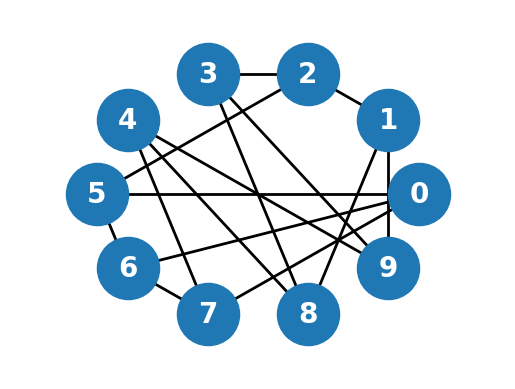

E = [(0, 5), (0, 6), (0, 7), (1, 2), (1, 8), (1, 9), (2, 3), (2, 5), (3, 8), (3, 9), (4, 7), (4, 8), (4, 9), (5, 6), (6, 7)]


In [4]:
g.add_edges_from(E)
# 将生成的图 G 打印出来
pos = nx.circular_layout(g)
options = {
    "with_labels": True,
    "font_size": 20,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 1000,
    "width": 2
}
nx.draw_networkx(g, pos, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

my_logger.info('E = {}'.format(E))

In [5]:
def build_hc(g, para):
    hc = Circuit()                  # 创建量子线路
    for i in g.edges:
        hc += ZZ(para).on(i)        # 对图中的每条边作用ZZ门
    hc.barrier()                    # 添加Barrier以方便展示线路
    return hc

In [6]:
def build_hb(g, para):
    hb = Circuit()                  # 创建量子线路
    for i in g.nodes:
        hb += RX(para).on(i)        # 对每个节点作用RX门
    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb

In [7]:
def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'gamma{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'beta{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    circ.as_ansatz()
    return circ

In [8]:
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

In [9]:
ham = Hamiltonian(build_ham(g))              # 生成哈密顿量
print('ham = {}'.format(ham))

ham = 1 [Z0 Z5] +
1 [Z0 Z6] +
1 [Z0 Z7] +
1 [Z1 Z2] +
1 [Z1 Z8] +
1 [Z1 Z9] +
1 [Z2 Z3] +
1 [Z2 Z5] +
1 [Z3 Z8] +
1 [Z3 Z9] +
1 [Z4 Z7] +
1 [Z4 Z8] +
1 [Z4 Z9] +
1 [Z5 Z6] +
1 [Z6 Z7] 


In [10]:
# 只有ansatz，无encoder
class MQAnsatzOnlyLayer(nn.Cell):
    def __init__(self, expectation_with_grad,params, weight='normal'):
        """Initialize a MQAnsatzOnlyLayer object."""
        super().__init__()
        self.evolution = MQAnsatzOnlyOps(expectation_with_grad)
        weight_size = len(self.evolution.expectation_with_grad.ansatz_params_name)
        if isinstance(weight, ms.Tensor):
            if weight.ndim != 1 or weight.shape[0] != weight_size:
                raise ValueError(f"Weight init shape error, required ({weight_size}, ), but get f{weight.shape}.")
        # Parameter是变量张量，代表在训练网络时，需要被更新的参数
        # initializer()是一个初始化器，调用这个接口可生成initializer对象（我输出这个对象和参数，发现两者是不同的）
#         self.weight = Parameter(initializer(weight, weight_size, dtype=ms.float32), name='ansatz_weight')
#         print(initializer(weight,weight_size,dtype=ms.float32))
        
        
        # 基于Tensor实现参数的初始化,基于np.random.rand(m)可以返回一个长度为m的数组
        # 初始参数params = [gamma0,beta0,gamma1,beta1...],params是一个数组
        self.weight =  Parameter(params.astype(np.float32), name='ansatz_weight')
#         my_logger.info(self.weight.asnumpy())
        

    def construct(self):
        """Construct a MQAnsatzOnlyLayer node."""
        return self.evolution(self.weight)

In [11]:
# 优化参数
def execute_function(layer,beta,gamma):
    my_logger.info('layer = {},initial_beta = {},initial_gamma = {}'.format(layer,beta,gamma))
#     if layer >= 10:
#         ITR = 450   # 训练迭代的次数
#     else:
#         if layer>=8:
#             ITR = 350
#         else:
#             if layer>=5:
#                 ITR = 300
#             else:
#                 ITR = 200
    lr = 0.05
    ITR = 2000 # the maximal number of iterations
    
    # 存储参数,先存储gamma,再存储beta
    params = []
    for i in range(0,len(beta)):
        params.append(gamma[i])
        params.append(beta[i])
    # 将列表转换为数组
    params = np.array(params)
    
    ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
    
    # 搭建QAOA 线路
    init_state_circ = UN(H, g.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
    ansatz = build_ansatz(g, layer)              # 生成ansatz线路
    circ = init_state_circ + ansatz              # 将初始化线路与ansatz线路组合成一个线路
    # circ.svg() # 线路可视化

    sim = Simulator('mqvector', circ.n_qubits)                     # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
    grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
    QuantumNet = MQAnsatzOnlyLayer((grad_ops),params)
    
    
    
    opti = Adam(QuantumNet.trainable_params(), learning_rate=lr)     # 需要优化的是Quantumnet中可训练的参数，学习率设为0.5
    train_net = nn.TrainOneStepCell(QuantumNet, opti)                     # 对神经网络进行一步训练
    
    F = [] # 存储优化过程中期望函数值的变化
    for i in range(0,ITR+1):
        cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
        if i%1 == 0:
            # 关于哈密顿量的期望值train_net.asnumpy(),train_net()是一个Tensor
            loss = train_net().asnumpy()[0]
            loss = round(loss,5)
            F.append(loss)
           
            # 判断是否达到迭代停止条件
            if len(F)>= 3:
                l = len(F) # 最新的期望函数值对应的下标是l-1
                delta1 = abs(F[l-1]-F[l-2])
                delta2 = abs(F[l-2]-F[l-3])
                if delta1 <= 0.001 and delta2 <= 0.001:
                    my_logger.info('train_step = {},F = {}'.format(i,F))
                    break;
    
    
#     for i in range(0,ITR+1):
#         cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
#         if i%10 == 0:
#             # 关于哈密顿量的期望值train_net.asnumpy(),train_net()是一个Tensor
#             my_logger.info("train_step = {},loss = {}".format(i,train_net().asnumpy()))  # 每训练10步，打印当前训练步数和当前得到的切割边数  
        
#     # train_net().asnumpy()是一个数组,返回优化后的期望值，注意存放的位置在测量之前
#     loss = train_net().asnumpy()[0]

    # 获取优化后的参数
    beta_opt = []
    gamma_opt = []
    params = []
    my_logger.info('lr = {},itr = {}'.format(lr,len(F)))
    # 获取线路参数
    pr = dict(zip(ansatz.params_name, QuantumNet.weight.asnumpy())) # 获取线路参数
    for key,value in pr.items():
        params.append(value)
    my_logger.info('优化后线路参数params = {}'.format(params))
    
    for i in range(0,len(params)):
        if i%2==0:
            gamma_opt.append(params[i])
        else:
            beta_opt.append(params[i])
        
    circ.measure_all()                               # 为线路中所有比特添加测量门
    result = sim.sampling(circ, pr=pr, shots=1000)
    
    
    # 最大化loss
    return result,gamma_opt,beta_opt,-loss,F

In [12]:
# 逐层训练，但每次优化优化都是线路内的全部参数
def layerwise_training(p,SEED):
    # 记录电路层数、loss之间的数值
    circuit_depth = []
    function_value = []
    for depth in range(1,p+1):
        circuit_depth.append(depth)
    
    # 存储层深从1到p，优化所需要的迭代次数
    iter = []
 
    # 初始化beta以及gamma为下述形式，和线性插值式子定义有关
    beta = [0]
    gamma = [0]
    
    # 随机初始化第1层的参数
    # 返回数值服从范围 [min, max) 内均匀分布的 随机tensor，形状为 shape, 数据类型dtype
    # 生成服从均匀分布的随机数,返回一个Tensor
    # minval,maxval是Tensor类型
    minval = Tensor(0, ms.float32)
    maxval = Tensor(np.pi, ms.float32)
    shape = tuple([1])
    param = ops.uniform(shape,minval,maxval,seed= SEED,dtype=ms.float32)
    beta.append(param.asnumpy()[0])
 
    param = ops.uniform(shape,minval,maxval, seed= SEED,dtype=ms.float32)
    gamma.append(param.asnumpy()[0])
    my_logger.info("circuit_depth = 1,beta = {},gamma = {}:".format(beta ,gamma))
    
    
    # 获取优化后的beta_opt,gamma_opt，其中iden1=1表示进行了数值优化，否则数值为0：未进行
    result,gamma_opt,beta_opt,loss,F = execute_function(1,beta[1:],gamma[1:])
    function_value.append(loss)
    iter.append(len(F)-1)
    
    # 用优化后的beta_opt[0],gamma_opt[0]更新第1层的初始化参数
    beta[1] = beta_opt[0]
    gamma[1] = gamma_opt[0]
    my_logger.info("curent_depth=1,更新后的beta[1:] = {},gamma[1:] = {}：".format(beta[1:],gamma[1:]))
    my_logger.info('\n\n\n')

    # layer表示已经搭建好的ansatz电路层数，初始值为1 
    for layer in range(1,p):
    
        # beta_i以及gamma_i分别存储电路层数为layer+1层时，线路内的全部参数，包括新增层（第layer+1）层的参数
        beta_i = []
        gamma_i = []
        
        # beta[layer+1]=0,gamma[layer+1]=0，线性插值策略定义
        beta.append(0)
        gamma.append(0)

        # 利用线性插值策略确定layer+1层电路
        for i in range(1,layer+2):
            
            beta_value = (i-1)*(1/layer)*(beta[i-1])+ (layer-i+1)*(1/layer)*(beta[i])
#             print('beta_value = {}'.format(beta_value))
            beta_i.append(beta_value)
            gamma_i.append((i-1)*(1/layer)*(gamma[i-1])+ (layer-i+1)*(1/layer)*(gamma[i]))

        my_logger.info('{}层ansatz电路,利用线性插值策略得到的beta_i = {},gamma_i = {}：'.format(layer+1,beta_i,gamma_i))

        # 对当前电路内的所有参数进行优化，注意每次循环后都会得到一个新的参数列表beta_i,gamma_i
        result,gamma_opt,beta_opt,loss,F = execute_function(layer+1,beta_i,gamma_i)
        function_value.append(loss)
        iter.append(len(F)-1)

        # 更新当前电路内的所有参数,这里beta和gamma中存储已经优化好的参数信息,共2(layer+1)个参数
        for j in range(1,layer+2):
            beta[j] = beta_opt[j-1]
            gamma[j] = gamma_opt[j-1]

        my_logger.info("curent_depth = {},更新后的beta = {},gamma = {}：".format(layer+1,beta,gamma))
        my_logger.info('\n\n\n')

    # 返回优化后的全部参数信息,其中x是概率最高的比特串，y是测得各个比特串的概率
    return result,beta[1:],gamma[1:],function_value,iter

In [13]:
# In[8]:

# 进行m次分层训练，观察数值效果
m = int(input('Please input the value of m:'))

# 搭建p层的线路
p  = int(input('Please input the value of p:'))

# 记录m个loss列表信息
value = []
# 记录m个消耗的迭代次数信息
iterations = []

# SEED = [3109, 3232, 3327, 3299, 3146, 3168, 3025, 3088, 3207, 3236, 3105, 3121, 3160, 3241, 3103, 3407, 3470, 3240, 3423, 3074, 3008, 3315, 3266, 3052, 3038, 3182, 3383, 3298, 3071, 3344, 3424, 3172, 3310, 3300, 3095, 3077, 3153, 3100, 3036, 3050, 3312, 3342, 3363, 3294, 3303, 3481, 3215, 3066, 3385, 3487]
SEED = []
for i in range(0,m):
    SEED.append(random.randint(100,2500))


# SEED = [1518, 824, 2953, 704, 416, 2895, 2483, 558, 3188, 2550, 1129, 3371, 1035, 1521, 1169, 3065, 3426, 1021, 1758, 934, 2267, 2351, 1964, 3188, 1901, 691, 1551, 2356, 1777, 394, 3235, 3374, 451, 450, 846, 420, 2887, 1148, 2347, 2255, 2142, 1127, 3220, 3368, 614, 3131, 2669, 3321, 2104, 1699, 726, 566, 3342, 2466, 1465, 1712, 274, 1267, 1178, 1435, 2546, 3291, 1316, 2536, 728, 2472, 2686, 973, 3259, 3106, 527, 1718, 3440, 526, 1172, 1021, 3472, 2455, 3184, 2466, 2165, 1168, 3161, 2818, 1947, 2371, 3271, 385, 1695, 975, 2149, 3036, 1963, 2498, 956, 1401, 854, 1655, 1396, 3318, 2757, 1187, 2017, 3197, 3062, 2838, 1314, 1749, 844, 1301, 1723, 1817, 2221, 204, 1575, 1431, 2431, 1511, 328, 904, 641, 3246, 234, 1270, 3002, 1949, 2834, 1498, 3212, 1553, 3061, 968, 2865, 1629, 1646, 3115, 535, 3035, 964, 2894, 1805, 1836, 1940, 452, 2651, 1080, 947, 1896, 820, 2635, 2474, 2595, 2908, 2924, 1256, 814, 275, 1655, 1013, 1581, 2669, 1754, 3458, 3050, 488, 3491, 2972, 2081, 3303, 2390, 1048, 3476, 811, 2787, 2117, 2139, 3131, 1134, 1677, 2418, 609, 2811, 828, 3034, 2652, 2716, 3385, 3118, 2488, 1850, 899, 1523, 1531, 2334, 688, 2586, 3329, 2969, 616, 2078, 1115, 1357, 1604, 3435, 1211, 1146, 1320, 318, 279, 2085, 2135, 2005, 2453, 2552, 736, 1893, 517, 1467, 2458, 1115, 2849, 904, 454, 915, 2452, 2789, 1849, 2676, 2929, 1834, 1843, 611, 1564, 2958, 1522, 250, 3110, 1028, 2690, 1026, 621, 2465, 1121, 2412, 2586, 1637, 2886, 2350, 1853, 3024, 1397, 2320, 470, 1945, 1667, 361, 275, 3265, 2035, 1115, 1153, 2471, 2326, 798, 573, 338, 1126, 1774, 1030, 1238, 1341, 2577, 1019, 2224, 751, 3297, 1585, 2993, 2968, 1777, 3049, 1431, 2548, 1322, 2546, 2964, 1997, 2754, 3383, 1667, 354, 3017, 1367, 2387, 748, 879, 2229, 1737, 3372, 1556, 2709, 1793, 740, 478, 3293, 358, 972, 3142, 1077, 2874, 3290, 1886, 2217, 883, 905, 3443, 1328, 3424, 1424, 1392, 3132, 1319, 1898, 622, 2649, 2007, 1712, 2418, 2354, 1786, 1631, 3314, 1799, 1231, 722, 2230, 2531, 2082, 3305, 2822, 1721, 2419, 600, 2293, 1466, 625, 527, 708, 1713, 1373, 822, 917, 2061, 877, 2251, 672, 1914, 364, 1872, 1994, 2068, 559, 3047, 2800, 1557, 1010, 432, 273, 2366, 787, 610, 1560, 2191, 1020, 3138, 556, 1095, 1827, 1163, 3182, 2256, 2315, 1600, 2366, 2274, 1359, 648, 1317, 200, 2224, 2224, 3435, 712, 454, 3435, 2723, 1722, 692, 2221, 1222, 1516, 810, 2242, 1193, 369, 1922, 220, 2309, 2747, 2430, 390, 1656, 583, 1583, 543, 2814, 2863, 1717, 1342, 2752, 2923, 296, 3250, 1648, 2276, 554, 3344, 2813, 3152, 346, 923, 3178, 2114, 2045, 1934, 3355, 428, 1579, 519, 1541, 3099, 2428, 2882, 3008, 1405, 433, 775, 351, 781, 1913, 1208, 1654, 1056, 1755, 1224, 1191, 3025, 2457, 2910, 1434, 2415, 514, 2747, 2166, 463, 2236, 1970, 2257, 3106, 887, 672, 2199, 1642, 519, 1049, 2107, 3237, 1978, 1406, 2030, 535, 660, 3427, 2476, 2762, 2241, 2246, 2973, 443, 3270, 1893, 1261, 2720, 2437, 1172, 2225, 2298, 2632, 2397, 3032]
# my_logger.info('随机种子SEED = {}'.format(SEED))


start_time = time.time()
for i in range(1,m+1):
    
    # 训练全部参数，返回电路内所有参数
    result, beta_opt,gamma_opt ,loss,iter = layerwise_training(p,SEED[i-1])  
    my_logger.info('第{}次INTERP优化运行,对所有参数进行优化后得到: beta={},gamma={}：'.format(i,beta_opt,gamma_opt))
    my_logger.info("function value ={}".format(loss))
    my_logger.info('本轮INTERP运行消耗的迭代数iter = {}'.format(iter))
    value.append(loss)
    iterations.append(iter)
    my_logger.info('\n\n\n')
    if i%10 == 0:
        my_logger.info('{}次训练，目标函数信息{}'.format(i,value))
        my_logger.info('\n')
        my_logger.info('{}次训练，消耗的迭代次数信息{}'.format(i,iterations))
        my_logger.info('\n')
my_logger.info('{}次训练，目标函数信息{}'.format(i,value))
my_logger.info('\n\n')
my_logger.info('{}次训练，消耗的迭代次数信息{}'.format(i,iterations))

end_time = time.time()
delta = end_time - start_time


my_logger.info('start_time = {}'.format(start_time))
my_logger.info('end_time = {}'.format(end_time))
my_logger.info('delta = {}'.format(delta))


Please input the value of m:500
Please input the value of p:10
随机种子SEED = [1518, 824, 2953, 704, 416, 2895, 2483, 558, 3188, 2550, 1129, 3371, 1035, 1521, 1169, 3065, 3426, 1021, 1758, 934, 2267, 2351, 1964, 3188, 1901, 691, 1551, 2356, 1777, 394, 3235, 3374, 451, 450, 846, 420, 2887, 1148, 2347, 2255, 2142, 1127, 3220, 3368, 614, 3131, 2669, 3321, 2104, 1699, 726, 566, 3342, 2466, 1465, 1712, 274, 1267, 1178, 1435, 2546, 3291, 1316, 2536, 728, 2472, 2686, 973, 3259, 3106, 527, 1718, 3440, 526, 1172, 1021, 3472, 2455, 3184, 2466, 2165, 1168, 3161, 2818, 1947, 2371, 3271, 385, 1695, 975, 2149, 3036, 1963, 2498, 956, 1401, 854, 1655, 1396, 3318, 2757, 1187, 2017, 3197, 3062, 2838, 1314, 1749, 844, 1301, 1723, 1817, 2221, 204, 1575, 1431, 2431, 1511, 328, 904, 641, 3246, 234, 1270, 3002, 1949, 2834, 1498, 3212, 1553, 3061, 968, 2865, 1629, 1646, 3115, 535, 3035, 964, 2894, 1805, 1836, 1940, 452, 2651, 1080, 947, 1896, 820, 2635, 2474, 2595, 2908, 2924, 1256, 814, 275, 1655, 1013, 1581, 26

curent_depth = 6,更新后的beta = [0, 1.9235879, 2.0577946, 2.1879864, 2.4850864, 2.7978797, 2.9437265],gamma = [0, 3.2916696, 3.454912, 3.4995573, 3.550299, 3.6879575, 3.7979805]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.9235879182815552, 2.0354267954826355, 2.144589106241862, 2.336536407470703, 2.589350859324137, 2.822187503178914, 2.9437265396118164],gamma_i = [3.2916696071624756, 3.427704890569051, 3.4846754868825274, 3.524928092956543, 3.596185127894083, 3.706294695536295, 3.797980546951294]：
layer = 7,initial_beta = [1.9235879182815552, 2.0354267954826355, 2.144589106241862, 2.336536407470703, 2.589350859324137, 2.822187503178914, 2.9437265396118164],initial_gamma = [3.2916696071624756, 3.427704890569051, 3.4846754868825274, 3.524928092956543, 3.596185127894083, 3.706294695536295, 3.797980546951294]
train_step = 34,F = [-9.6381, -10.78465, -10.49085, -10.78762, -10.60538, -10.89135, -10.72291, -10.87281, -10.83015, -10.85099, -10.89474, -10.85664, -10.91535, -10.87706, -10.92002, -10.8929

lr = 0.05,itr = 42
优化后线路参数params = [1.2426226, 2.7769575, 2.2301657, 2.5367146]
curent_depth = 2,更新后的beta = [0, 2.7769575, 2.5367146],gamma = [0, 1.2426226, 2.2301657]：




3层ansatz电路,利用线性插值策略得到的beta_i = [2.7769575119018555, 2.6568360328674316, 2.536714553833008],gamma_i = [1.2426226139068604, 1.7363941669464111, 2.230165719985962]：
layer = 3,initial_beta = [2.7769575119018555, 2.6568360328674316, 2.536714553833008],initial_gamma = [1.2426226139068604, 1.7363941669464111, 2.230165719985962]
train_step = 38,F = [-0.09576, -3.65514, -3.61961, -4.73591, -5.61553, -5.68331, -5.49001, -5.66567, -6.21197, -6.64859, -6.75277, -6.82589, -6.98756, -7.03539, -7.01459, -7.13, -7.23968, -7.22858, -7.2674, -7.32432, -7.35258, -7.43728, -7.50565, -7.53571, -7.5826, -7.61494, -7.63302, -7.65265, -7.65289, -7.64731, -7.65021, -7.65052, -7.65388, -7.66039, -7.66325, -7.66769, -7.67024, -7.66973, -7.67049]
lr = 0.05,itr = 39
优化后线路参数params = [1.1357429, 2.8943324, 2.3389034, 2.6676555, 2.513848, 3.577452

优化后线路参数params = [1.652992, 3.3775985, 1.8079553, 2.9856248, 2.4103694, 2.8812883, 1.7831283, 1.5654598, 1.7505549, 2.8371944, 2.5495214, 4.627124, 3.2335851, 5.44912, 2.4472773, 3.4455998]
curent_depth = 8,更新后的beta = [0, 3.3775985, 2.9856248, 2.8812883, 1.5654598, 2.8371944, 4.627124, 5.44912, 3.4455998],gamma = [0, 1.652992, 1.8079553, 2.4103694, 1.7831283, 1.7505549, 2.5495214, 3.2335851, 2.4472773]：




9层ansatz电路,利用线性插值策略得到的beta_i = [3.377598524093628, 3.0346215069293976, 2.9073724150657654, 2.0588955134153366, 2.20132714509964, 3.5084179639816284, 4.8326228857040405, 5.198680013418198, 3.4455997943878174],gamma_i = [1.6529920101165771, 1.7885848581790924, 2.259765863418579, 2.018343687057495, 1.7668415904045105, 2.050167366862297, 2.7205373644828796, 3.135296642780304, 2.447277307510376]：
layer = 9,initial_beta = [3.377598524093628, 3.0346215069293976, 2.9073724150657654, 2.0588955134153366, 2.20132714509964, 3.5084179639816284, 4.8326228857040405, 5.198680013418198, 3.44559979438

lr = 0.05,itr = 42
优化后线路参数params = [1.7488478, 1.1654404, 1.9126735, -1.0611548, 1.9527936, 0.8137281, 2.0313466, -0.36752436]
curent_depth = 4,更新后的beta = [0, 1.1654404, -1.0611548, 0.8137281, -0.36752436],gamma = [0, 1.7488478, 1.9126735, 1.9527936, 2.0313466]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1654404401779175, -0.5045060217380524, -0.12371337413787842, 0.5184149816632271, -0.3675243556499481],gamma_i = [1.7488478422164917, 1.8717170655727386, 1.9327335357666016, 1.9724318385124207, 2.031346559524536]：
layer = 5,initial_beta = [1.1654404401779175, -0.5045060217380524, -0.12371337413787842, 0.5184149816632271, -0.3675243556499481],initial_gamma = [1.7488478422164917, 1.8717170655727386, 1.9327335357666016, 1.9724318385124207, 2.031346559524536]
train_step = 46,F = [-5.20017, -5.604, -5.84224, -6.54894, -7.61874, -8.27594, -8.74358, -9.3086, -9.46225, -9.28433, -9.34911, -9.50364, -9.67338, -9.66413, -9.79365, -9.89341, -9.85064, -9.92738, -9.9629, -9.98407, -10.05779, -10.0871, -1





10层ansatz电路,利用线性插值策略得到的beta_i = [1.2075507640838623, -0.8082749313778347, 0.5192511412832471, 0.49708402156829834, 0.09083344580398664, -0.13164396377073392, -0.3084063132603963, -0.3908958004580603, -0.15536300341288248, 0.22001349925994873],gamma_i = [1.7112994194030762, 1.8587425549825032, 1.9143323236041596, 2.1585218509038286, 2.5458276536729603, 2.950024816724989, 3.224308331807454, 3.302423000335693, 3.1585450172424316, 2.0354790687561035]：
layer = 10,initial_beta = [1.2075507640838623, -0.8082749313778347, 0.5192511412832471, 0.49708402156829834, 0.09083344580398664, -0.13164396377073392, -0.3084063132603963, -0.3908958004580603, -0.15536300341288248, 0.22001349925994873],initial_gamma = [1.7112994194030762, 1.8587425549825032, 1.9143323236041596, 2.1585218509038286, 2.5458276536729603, 2.950024816724989, 3.224308331807454, 3.302423000335693, 3.1585450172424316, 2.0354790687561035]
train_step = 58,F = [-6.09254, -8.45085, -8.88637, -8.9256, -8.80314, -9.16085, -9.38557, -9.

layer = 6,initial_beta = [3.000953197479248, 2.1708526611328125, 2.2474560737609863, 3.364053773880005, 4.363233661651611, 2.7968811988830566],initial_gamma = [1.1805049180984497, 1.9840011835098268, 2.1232997417449955, 2.452475786209107, 2.831863355636597, 2.1280553340911865]
train_step = 25,F = [0.68846, -0.78188, -1.6424, -3.32432, -5.26662, -7.06251, -8.10033, -8.58546, -8.50519, -8.38984, -8.30202, -8.55194, -8.74559, -8.9222, -9.01762, -9.12937, -9.21993, -9.34064, -9.47788, -9.54655, -9.58495, -9.59703, -9.61641, -9.63231, -9.63139, -9.63195]
lr = 0.05,itr = 26
优化后线路参数params = [1.5464429, 2.823464, 1.904556, 2.8746247, 2.548331, 1.9868548, 1.8741317, 2.8415556, 2.9456575, 4.839003, 2.2271197, 2.7574828]
curent_depth = 6,更新后的beta = [0, 2.823464, 2.8746247, 1.9868548, 2.8415556, 4.839003, 2.7574828],gamma = [0, 1.5464429, 1.904556, 2.548331, 1.8741317, 2.9456575, 2.2271197]：




7层ansatz电路,利用线性插值策略得到的beta_i = [2.8234639167785645, 2.866097927093506, 2.2827781041463213, 2.4142051935





第4次训练,对所有参数进行优化后得到: beta=[3.715215, 3.030808, 2.9484084, 1.8404933, 2.6584773, 3.0106225, 4.2590303, 4.56283, 3.5416634, 2.8154058],gamma=[1.6620204, 1.9478012, 2.2382386, 1.933947, 1.8636882, 1.9353936, 2.2271285, 3.2462792, 3.4821675, 2.2744553]：
function value =[5.15236, 6.74981, 7.67209, 9.67025, 10.20099, 9.63195, 10.20549, 10.54734, 10.60641, 10.74187]
本轮INTERP运行消耗的迭代数iter = [40, 34, 38, 92, 63, 25, 52, 49, 53, 83]




circuit_depth = 1,beta = [0, 2.2599733],gamma = [0, 2.8395412]:
layer = 1,initial_beta = [2.2599733],initial_gamma = [2.8395412]
train_step = 39,F = [6.01041, 4.18496, 1.60239, -0.59859, -1.72564, -2.40136, -2.95676, -3.37948, -3.70391, -4.02575, -4.39406, -4.75401, -4.9879, -5.02136, -4.90089, -4.75919, -4.71157, -4.78775, -4.93482, -5.06786, -5.13153, -5.12966, -5.10363, -5.08988, -5.09734, -5.11342, -5.12335, -5.12475, -5.12619, -5.13458, -5.14696, -5.15501, -5.15462, -5.14938, -5.14577, -5.14694, -5.15105, -5.15446, -5.15546, -5.15504]
lr = 0.05,itr = 40
优化

lr = 0.05,itr = 41
优化后线路参数params = [3.2560053, 1.9229065, 3.400154, 2.1012647, 3.4476266, 2.1986284, 3.4779565, 2.3157086, 3.5029922, 2.4509776, 3.5569751, 2.7003293, 3.6821814, 2.8860426, 3.7230616, 2.9629154]
curent_depth = 8,更新后的beta = [0, 1.9229065, 2.1012647, 2.1986284, 2.3157086, 2.4509776, 2.7003293, 2.8860426, 2.9629154],gamma = [0, 3.2560053, 3.400154, 3.4476266, 3.4779565, 3.5029922, 3.5569751, 3.6821814, 3.7230616]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.922906517982483, 2.0789699405431747, 2.174287497997284, 2.271803557872772, 2.3833431005477905, 2.544484466314316, 2.7467576265335083, 2.895651698112488, 2.9629154205322266],gamma_i = [3.25600528717041, 3.382135510444641, 3.4357584714889526, 3.466582804918289, 3.4904743432998657, 3.5232357680797577, 3.58827668428421, 3.687291383743286, 3.7230615615844727]：
layer = 9,initial_beta = [1.922906517982483, 2.0789699405431747, 2.174287497997284, 2.271803557872772, 2.3833431005477905, 2.544484466314316, 2.7467576265335083, 2.895651698

lr = 0.05,itr = 31
优化后线路参数params = [1.3789299, 1.921881, 1.23777, 4.265625, 0.9360832, 3.5583286, 0.38078398, 2.9542255, 1.3560805, 3.9732134]
curent_depth = 5,更新后的beta = [0, 1.921881, 4.265625, 3.5583286, 2.9542255, 3.9732134],gamma = [0, 1.3789299, 1.23777, 0.9360832, 0.38078398, 1.3560805]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9218809604644775, 3.7968761920928955, 3.841247177124024, 3.316687393188477, 3.1580231189727783, 3.9732134342193604],gamma_i = [1.378929853439331, 1.2660019397735596, 1.0567579030990601, 0.7139635086059571, 0.5758432865142822, 1.3560805320739746]：
layer = 6,initial_beta = [1.9218809604644775, 3.7968761920928955, 3.841247177124024, 3.316687393188477, 3.1580231189727783, 3.9732134342193604],initial_gamma = [1.378929853439331, 1.2660019397735596, 1.0567579030990601, 0.7139635086059571, 0.5758432865142822, 1.3560805320739746]
train_step = 68,F = [-3.86921, -4.80466, -5.5174, -6.64192, -7.80351, -8.99179, -9.33191, -8.88932, -8.68632, -8.81545, -9.0698, -9.29397, -

lr = 0.05,itr = 101
优化后线路参数params = [1.2966309, 0.6894189, 1.6116965, 4.115554, 0.586991, 3.5159786, 1.3270551, 4.2274756, 1.3137684, 4.125285, 1.1448233, 2.274384, 0.8922457, 2.9788857, 0.2031526, 3.8154995, 1.0860957, 2.8327184, 2.5746434, 3.0036285]
curent_depth = 10,更新后的beta = [0, 0.6894189, 4.115554, 3.5159786, 4.2274756, 4.125285, 2.274384, 2.9788857, 3.8154995, 2.8327184, 3.0036285],gamma = [0, 1.2966309, 1.6116965, 0.586991, 1.3270551, 1.3137684, 1.1448233, 0.8922457, 0.2031526, 1.0860957, 2.5746434]：




第6次训练,对所有参数进行优化后得到: beta=[0.6894189, 4.115554, 3.5159786, 4.2274756, 4.125285, 2.274384, 2.9788857, 3.8154995, 2.8327184, 3.0036285],gamma=[1.2966309, 1.6116965, 0.586991, 1.3270551, 1.3137684, 1.1448233, 0.8922457, 0.2031526, 1.0860957, 2.5746434]：
function value =[5.14755, 7.95999, 9.56243, 10.05404, 10.041, 10.05814, 10.49186, 10.56361, 10.69556, 10.84187]
本轮INTERP运行消耗的迭代数iter = [20, 49, 40, 40, 30, 68, 43, 36, 41, 100]




circuit_depth = 1,beta = [0, 1.5565568],gamma = [0

lr = 0.05,itr = 41
优化后线路参数params = [1.3662744, 1.8825428, 1.3169217, 4.385548, 0.2896166, 3.5837154, 1.4083526, 4.5871625, 1.3860111, 3.3375847, 0.7325477, 2.756745, 2.1040711, 3.3342466]
curent_depth = 7,更新后的beta = [0, 1.8825428, 4.385548, 3.5837154, 4.5871625, 3.3375847, 2.756745, 3.3342466],gamma = [0, 1.3662744, 1.3169217, 0.2896166, 1.4083526, 1.3860111, 0.7325477, 2.1040711]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.8825428485870361, 4.027975933892386, 3.8128104891095838, 4.157113756452287, 4.051629168646675, 3.1716305528368265, 2.8392453193664546, 3.3342466354370117],gamma_i = [1.366274356842041, 1.3239720889500208, 0.5831323564052582, 0.9288943282195499, 1.3987776892525807, 1.199307288442339, 0.9284796203885759, 2.1040711402893066]：
layer = 8,initial_beta = [1.8825428485870361, 4.027975933892386, 3.8128104891095838, 4.157113756452287, 4.051629168646675, 3.1716305528368265, 2.8392453193664546, 3.3342466354370117],initial_gamma = [1.366274356842041, 1.3239720889500208, 0.58313235640

train_step = 41,F = [-1.50694, -2.47618, -2.66958, -2.86399, -3.33631, -4.05246, -4.82658, -5.20984, -5.12729, -5.12127, -5.43756, -5.78349, -5.9548, -6.08646, -6.31866, -6.5103, -6.58637, -6.68186, -6.68335, -6.72646, -6.70797, -6.67413, -6.6672, -6.67334, -6.69678, -6.69875, -6.7224, -6.73475, -6.75029, -6.7487, -6.75411, -6.75333, -6.75192, -6.74896, -6.74922, -6.75114, -6.75223, -6.75481, -6.75678, -6.75841, -6.75809, -6.75826]
lr = 0.05,itr = 42
优化后线路参数params = [1.8987743, 0.36583132, 0.9089749, 0.60775745]
curent_depth = 2,更新后的beta = [0, 0.36583132, 0.60775745],gamma = [0, 1.8987743, 0.9089749]：




3层ansatz电路,利用线性插值策略得到的beta_i = [0.36583131551742554, 0.4867943823337555, 0.6077574491500854],gamma_i = [1.898774266242981, 1.4038745760917664, 0.9089748859405518]：
layer = 3,initial_beta = [0.36583131551742554, 0.4867943823337555, 0.6077574491500854],initial_gamma = [1.898774266242981, 1.4038745760917664, 0.9089748859405518]
train_step = 38,F = [-0.17081, -3.65712, -3.64108, -4.75464,

train_step = 69,F = [-1.82045, -4.91782, -5.02769, -5.70475, -6.35685, -6.78228, -7.62759, -8.17232, -9.16073, -9.66864, -10.03199, -9.93263, -9.94075, -9.9381, -10.08527, -10.16065, -10.23064, -10.28468, -10.28056, -10.3049, -10.35554, -10.40561, -10.44214, -10.45474, -10.45351, -10.45848, -10.46696, -10.47965, -10.49125, -10.5036, -10.51294, -10.51922, -10.52501, -10.52785, -10.53091, -10.5323, -10.53451, -10.53635, -10.53922, -10.54145, -10.5432, -10.54468, -10.54588, -10.54771, -10.54969, -10.55156, -10.55324, -10.55475, -10.55627, -10.55766, -10.55904, -10.56045, -10.56185, -10.56324, -10.56452, -10.56572, -10.56696, -10.56819, -10.56941, -10.57059, -10.57173, -10.57284, -10.57394, -10.57501, -10.57607, -10.57712, -10.57814, -10.57915, -10.58014, -10.58113]
lr = 0.05,itr = 70
优化后线路参数params = [1.3024492, 1.0033386, 1.7688833, -0.54710174, 1.1087235, -0.38517076, 0.3614171, 0.87583345, 0.80840814, -0.11678615, 1.1749768, -1.1448531, -0.114938244, -2.5505452, 0.69146377, -0.32741067]

优化后线路参数params = [2.892741, 1.1908323, 2.724758, 0.72292936]
curent_depth = 2,更新后的beta = [0, 1.1908323, 0.72292936],gamma = [0, 2.892741, 2.724758]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.190832257270813, 0.9568808078765869, 0.7229293584823608],gamma_i = [2.8927409648895264, 2.8087494373321533, 2.7247579097747803]：
layer = 3,initial_beta = [1.190832257270813, 0.9568808078765869, 0.7229293584823608],initial_gamma = [2.8927409648895264, 2.8087494373321533, 2.7247579097747803]
train_step = 25,F = [-8.87989, -9.31314, -9.16226, -9.54672, -9.37461, -9.39661, -9.51296, -9.45523, -9.48356, -9.52629, -9.51868, -9.53664, -9.53972, -9.53169, -9.55136, -9.54637, -9.5438, -9.56333, -9.5548, -9.55555, -9.56156, -9.55664, -9.56064, -9.5617, -9.56211, -9.5631]
lr = 0.05,itr = 26
优化后线路参数params = [2.927397, 1.189269, 2.7773256, 1.0303485, 2.7143142, 0.5323201]
curent_depth = 3,更新后的beta = [0, 1.189269, 1.0303485, 0.5323201],gamma = [0, 2.927397, 2.7773256, 2.7143142]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1

lr = 0.05,itr = 35
优化后线路参数params = [3.0371847, 1.215972, 2.909611, 1.0109029, 2.865435, 0.9309364, 2.8263245, 0.84637415, 2.802271, 0.7297417, 2.7825317, 0.6157407, 2.7143054, 0.39157018, 2.585582, 0.24375017, 2.5760746, 0.1516414]
curent_depth = 9,更新后的beta = [0, 1.215972, 1.0109029, 0.9309364, 0.84637415, 0.7297417, 0.6157407, 0.39157018, 0.24375017, 0.1516414],gamma = [0, 3.0371847, 2.909611, 2.865435, 2.8263245, 2.802271, 2.7825317, 2.7143054, 2.585582, 2.5760746]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.2159719467163086, 1.0336883332994249, 0.9487067262331643, 0.8745615681012471, 0.7815783421198528, 0.679074592060513, 0.5410172045230865, 0.358721289369795, 0.23351586196157667, 0.15164139866828918],gamma_i = [3.037184715270996, 2.923785845438639, 2.8752517965104842, 2.839361270268758, 2.812961366441515, 2.7934979332817926, 2.7597896258036294, 2.685700204637315, 2.584525638156467, 2.5760746002197266]：
layer = 10,initial_beta = [1.2159719467163086, 1.0336883332994249, 0.948706726233164





7层ansatz电路,利用线性插值策略得到的beta_i = [1.924766182899475, 2.035568336645762, 2.1443912188212075, 2.3363335132598877, 2.5895747343699136, 2.8227378129959106, 2.942251682281494],gamma_i = [0.1500135213136673, 0.2860867157578468, 0.3429481089115143, 0.38299381732940674, 0.45451615254084266, 0.5653556982676188, 0.6565533876419067]：
layer = 7,initial_beta = [1.924766182899475, 2.035568336645762, 2.1443912188212075, 2.3363335132598877, 2.5895747343699136, 2.8227378129959106, 2.942251682281494],initial_gamma = [0.1500135213136673, 0.2860867157578468, 0.3429481089115143, 0.38299381732940674, 0.45451615254084266, 0.5653556982676188, 0.6565533876419067]
train_step = 34,F = [-9.64222, -10.78658, -10.48771, -10.78981, -10.60589, -10.89079, -10.724, -10.87142, -10.83171, -10.84966, -10.89602, -10.85585, -10.91585, -10.87686, -10.9201, -10.89304, -10.91888, -10.90592, -10.92106, -10.91514, -10.92073, -10.91928, -10.92232, -10.92249, -10.92373, -10.92306, -10.92496, -10.92406, -10.92589, -10.92457, -10.



circuit_depth = 1,beta = [0, 1.1980629],gamma = [0, 1.2504635]:
layer = 1,initial_beta = [1.1980629],initial_gamma = [1.2504635]
train_step = 51,F = [4.46496, 2.63177, 0.77745, -0.01485, 0.36976, 0.82933, 0.81278, 0.45349, 0.04752, -0.16673, -0.2023, -0.30724, -0.69593, -1.40207, -2.31429, -3.22244, -3.89984, -4.29123, -4.55265, -4.8154, -5.03229, -5.08008, -4.95198, -4.79607, -4.75189, -4.8259, -4.93413, -5.00902, -5.05049, -5.0889, -5.13006, -5.15212, -5.1425, -5.11889, -5.10784, -5.11502, -5.12736, -5.13525, -5.14094, -5.14833, -5.15493, -5.15625, -5.15308, -5.15029, -5.1504, -5.15187, -5.1529, -5.15376, -5.15511, -5.15636, -5.15659, -5.15606]
lr = 0.05,itr = 52
优化后线路参数params = [1.8621774, 0.73619014]
curent_depth=1,更新后的beta[1:] = [0.73619014],gamma[1:] = [1.8621774]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.736190140247345, 0.736190140247345],gamma_i = [1.8621773719787598, 1.8621773719787598]：
layer = 2,initial_beta = [0.736190140247345, 0.736190140247345],initial_gamma = [1.8621773

layer = 8,initial_beta = [1.855420470237732, -1.2337582281657626, -0.7500377808298383, -0.8321616905076162, -0.8981628077370779, -0.26091086012976505, 0.27404849869864323, -0.17163687944412231],initial_gamma = [1.7468894720077515, 1.5244196993964059, 2.2132987294878275, 2.158249923161098, 1.8889447450637817, 2.049390877996172, 2.2944512026650563, 1.1534936428070068]
train_step = 40,F = [-2.84111, -5.09608, -5.15365, -6.38707, -7.06614, -8.1322, -8.79565, -9.35169, -9.47855, -9.83246, -10.01779, -9.94763, -9.99701, -10.0535, -9.9923, -10.08647, -10.05976, -10.1015, -10.15565, -10.21512, -10.31253, -10.36147, -10.4104, -10.44324, -10.44354, -10.44792, -10.47416, -10.51105, -10.53975, -10.54913, -10.54141, -10.53693, -10.55098, -10.56294, -10.56485, -10.56332, -10.56397, -10.5694, -10.57202, -10.57169, -10.57259]
lr = 0.05,itr = 41
优化后线路参数params = [1.790874, 2.0782788, 1.5022883, -1.4766428, 2.5318453, -0.35246205, 1.8677881, -1.2092104, 1.8233507, -0.8865688, 2.0260613, 0.3011267, 2.5159

layer = 4,initial_beta = [1.1799228191375732, 1.080083926518758, 0.8626031676928202, 0.5274805426597595],initial_gamma = [2.93045973777771, 2.830232699712117, 2.757563511530558, 2.7124521732330322]
train_step = 22,F = [-9.68003, -10.07515, -9.93373, -10.07313, -10.03608, -10.14528, -10.09254, -10.11066, -10.14171, -10.15129, -10.14711, -10.14499, -10.17178, -10.15877, -10.16958, -10.1621, -10.17536, -10.17029, -10.17337, -10.17351, -10.17614, -10.17616, -10.17558]
lr = 0.05,itr = 23
优化后线路参数params = [2.9629874, 1.1602453, 2.7986073, 1.0634466, 2.758339, 0.8032335, 2.6822498, 0.3720401]
curent_depth = 4,更新后的beta = [0, 1.1602453, 1.0634466, 0.8032335, 0.3720401],gamma = [0, 2.9629874, 2.7986073, 2.758339, 2.6822498]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1602452993392944, 1.0876463055610657, 0.9333400726318359, 0.6954351514577866, 0.3720400929450989],gamma_i = [2.9629874229431152, 2.8397023677825928, 2.778473138809204, 2.7393166422843933, 2.6822497844696045]：
layer = 5,initial_beta = [1.1

train_step = 30,F = [-7.98846, -10.10764, -10.0906, -10.78885, -10.2263, -10.79514, -10.78378, -10.61971, -10.92112, -10.8822, -10.80065, -10.92455, -10.9415, -10.90409, -10.94258, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [3.0461538, 1.152054, 2.9460442, 0.8620033, 2.9181812, 0.80603296, 2.885148, 0.7543383, 2.8582518, 0.6925249, 2.8290827, 0.6188405, 2.8088973, 0.46919048, 2.7518563, 0.30385426, 2.632898, 0.22160237, 2.6117682, 0.13551961]
curent_depth = 10,更新后的beta = [0, 1.152054, 0.8620033, 0.80603296, 0.7543383, 0.6925249, 0.6188405, 0.46919048, 0.30385426, 0.22160237, 0.13551961],gamma = [0, 3.0461538, 2.9460442, 2.9181812, 2.885148, 2.8582518, 2.8290827, 2.8088973, 2.7518563, 2.632898, 2.6117682]：




第12次训练,对所有参数进行优化后得到: beta=[1.152054, 0.8620033, 0.80603296, 0.7543383, 0.6925249, 0.6188405, 0.46919048, 0.303854

curent_depth = 7,更新后的beta = [0, -1.2024307, -1.0224929, -0.92240065, -0.81494653, -0.55578715, -0.30575764, -0.20296013],gamma = [0, 0.1372244, 0.28263387, 0.3158599, 0.35700914, 0.41069874, 0.5382461, 0.64255726]：




8层ansatz电路,利用线性插值策略得到的beta_i = [-1.2024307250976562, -1.0481982912336076, -0.9509984339986528, -0.8609982984406607, -0.7038782238960266, -0.4843501448631286, -0.29107228347233366, -0.20296013355255127],gamma_i = [0.13722440600395203, 0.26186109014919823, 0.30636675868715557, 0.33937375886099674, 0.3800189707960401, 0.4471408426761627, 0.553147690636771, 0.6425572633743286]：
layer = 8,initial_beta = [-1.2024307250976562, -1.0481982912336076, -0.9509984339986528, -0.8609982984406607, -0.7038782238960266, -0.4843501448631286, -0.29107228347233366, -0.20296013355255127],initial_gamma = [0.13722440600395203, 0.26186109014919823, 0.30636675868715557, 0.33937375886099674, 0.3800189707960401, 0.4471408426761627, 0.553147690636771, 0.6425572633743286]
train_step = 40,F = [-10.105

layer = 4,initial_beta = [1.9606542587280273, 2.0620096524556475, 2.2793982823689776, 2.6128201484680176],initial_gamma = [0.21118023991584778, 0.3111257453759511, 0.3835940659046173, 0.4285852015018463]
train_step = 22,F = [-9.67948, -10.07385, -9.93417, -10.07149, -10.03539, -10.14604, -10.09216, -10.11049, -10.14115, -10.15128, -10.14763, -10.14436, -10.17177, -10.15878, -10.16972, -10.16201, -10.17507, -10.17057, -10.17325, -10.17348, -10.17611, -10.17622, -10.17555]
lr = 0.05,itr = 23
优化后线路参数params = [0.17864789, 1.9814395, 0.34302506, 2.0783415, 0.38333413, 2.3385131, 0.45950237, 2.7693717]
curent_depth = 4,更新后的beta = [0, 1.9814395, 2.0783415, 2.3385131, 2.7693717],gamma = [0, 0.17864789, 0.34302506, 0.38333413, 0.45950237]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.981439471244812, 2.054115980863571, 2.208427309989929, 2.446227788925171, 2.769371747970581],gamma_i = [0.17864789068698883, 0.3019307665526867, 0.36317959427833557, 0.402376189827919, 0.45950236916542053]：
layer = 5,init

layer = 10,initial_beta = [1.9356223344802856, 2.098967353502909, 2.1803023550245495, 2.2547175089518228, 2.340851757261488, 2.4439356856875953, 2.5939144293467202, 2.782818026012844, 2.903656138314141, 2.9912235736846924],initial_gamma = [0.10705594718456268, 0.21767833994494543, 0.2661487923728095, 0.3043034474054972, 0.33445045683119035, 0.3564929564793905, 0.3896857400735219, 0.4628386133246951, 0.5676486028565301, 0.5707123875617981]
train_step = 30,F = [-7.98846, -10.10764, -10.0906, -10.78886, -10.22629, -10.79514, -10.78378, -10.61971, -10.92112, -10.88221, -10.80065, -10.92455, -10.94151, -10.90409, -10.94258, -10.95092, -10.95192, -10.97525, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [0.09543878, 1.9895409, 0.19554687, 2.279595, 0.22340953, 2.3355634, 0.2564434, 2.3872547, 0.2833403, 2.4490666, 0.31250954, 2.522751, 0.33269417, 2.6724021, 0.38

lr = 0.05,itr = 35
优化后线路参数params = [3.2788157, 1.9391588, 3.424226, 2.1190994, 3.4574535, 2.2191944, 3.4986036, 2.326648, 3.5522914, 2.5858037, 3.6798398, 2.8358355, 3.784151, 2.9386315]
curent_depth = 7,更新后的beta = [0, 1.9391588, 2.1190994, 2.2191944, 2.326648, 2.5858037, 2.8358355, 2.9386315],gamma = [0, 3.2788157, 3.424226, 3.4574535, 3.4986036, 3.5522914, 3.6798398, 3.784151]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9391587972640991, 2.0933935812541415, 2.1905958311898366, 2.2805964606148854, 2.437714747020176, 2.657241378511701, 2.850520610809326, 2.938631534576416],gamma_i = [3.278815746307373, 3.4034531457083563, 3.4479599339621405, 3.4809678282056535, 3.5216126441955566, 3.588733809334891, 3.6947414534432546, 3.784151077270508]：
layer = 8,initial_beta = [1.9391587972640991, 2.0933935812541415, 2.1905958311898366, 2.2805964606148854, 2.437714747020176, 2.657241378511701, 2.850520610809326, 2.938631534576416],initial_gamma = [3.278815746307373, 3.4034531457083563, 3.4479599339621405

train_step = 25,F = [-9.68363, -10.08106, -9.92934, -10.06376, -10.04076, -10.14573, -10.09047, -10.10689, -10.14411, -10.15134, -10.14572, -10.14729, -10.16794, -10.16153, -10.16898, -10.16119, -10.17575, -10.16989, -10.17443, -10.17201, -10.17718, -10.17582, -10.17558, -10.17723, -10.17763, -10.1774]
lr = 0.05,itr = 26
优化后线路参数params = [2.9690142, 1.1606268, 2.8004143, 1.0677023, 2.7599514, 0.81022376, 2.6808257, 0.361011]
curent_depth = 4,更新后的beta = [0, 1.1606268, 1.0677023, 0.81022376, 0.361011],gamma = [0, 2.9690142, 2.8004143, 2.7599514, 2.6808257]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.160626769065857, 1.0909334123134613, 0.9389630258083344, 0.6979205682873726, 0.36101099848747253],gamma_i = [2.9690141677856445, 2.842564284801483, 2.7801828384399414, 2.740169942378998, 2.680825710296631]：
layer = 5,initial_beta = [1.160626769065857, 1.0909334123134613, 0.9389630258083344, 0.6979205682873726, 0.36101099848747253],initial_gamma = [2.9690141677856445, 2.842564284801483, 2.7801828384

train_step = 31,F = [-7.76068, -10.14383, -9.90405, -10.7658, -10.24702, -10.64915, -10.83741, -10.61449, -10.82536, -10.88466, -10.82143, -10.91588, -10.91922, -10.90542, -10.92908, -10.94974, -10.9546, -10.9481, -10.97619, -10.96876, -10.96705, -10.98532, -10.97194, -10.98352, -10.98069, -10.98281, -10.98485, -10.98623, -10.98581, -10.9877, -10.98792, -10.98763]
lr = 0.05,itr = 32
优化后线路参数params = [3.0432553, 1.1918758, 2.9290931, 0.9414152, 2.9015172, 0.81798977, 2.8951452, 0.6773813, 2.8868074, 0.65279377, 2.8328435, 0.6383148, 2.7905078, 0.5244292, 2.7131279, 0.33192256, 2.5950148, 0.21654215, 2.5945427, 0.131884]
curent_depth = 10,更新后的beta = [0, 1.1918758, 0.9414152, 0.81798977, 0.6773813, 0.65279377, 0.6383148, 0.5244292, 0.33192256, 0.21654215, 0.131884],gamma = [0, 3.0432553, 2.9290931, 2.9015172, 2.8951452, 2.8868074, 2.8328435, 2.7905078, 2.7131279, 2.5950148, 2.5945427]：




第16次训练,对所有参数进行优化后得到: beta=[1.1918758, 0.9414152, 0.81798977, 0.6773813, 0.65279377, 0.6383148, 0.5244

train_step = 45,F = [-5.88047, -6.9252, -8.20369, -9.08454, -9.60156, -9.71531, -9.79789, -9.97912, -9.985, -10.06942, -10.11179, -10.2145, -10.29069, -10.30234, -10.35905, -10.41379, -10.43582, -10.4352, -10.45939, -10.48536, -10.4833, -10.50226, -10.53753, -10.56283, -10.57673, -10.58763, -10.59488, -10.60428, -10.62478, -10.64192, -10.66036, -10.67991, -10.6955, -10.71515, -10.73813, -10.75703, -10.77449, -10.78558, -10.79138, -10.7944, -10.79583, -10.79739, -10.79841, -10.79966, -10.79957, -10.80048]
lr = 0.05,itr = 46
优化后线路参数params = [1.4412804, 1.9536645, 1.2745736, 4.205969, 1.2144097, 2.1319063, 0.89248383, 2.8235092, 0.2608234, 3.6404314, -0.18065394, 3.6247761, 1.0391502, 2.9076598]
curent_depth = 7,更新后的beta = [0, 1.9536645, 4.205969, 2.1319063, 2.8235092, 3.6404314, 3.6247761, 2.9076598],gamma = [0, 1.4412804, 1.2745736, 1.2144097, 0.89248383, 0.2608234, -0.18065394, 1.0391502]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9536645412445068, 3.8842110974448065, 2.724495581218174, 2.

lr = 0.05,itr = 32
优化后线路参数params = [3.3859293, 1.9656317, 3.559376, 2.437086]
curent_depth = 2,更新后的beta = [0, 1.9656317, 2.437086],gamma = [0, 3.3859293, 3.559376]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.9656317234039307, 2.201358914375305, 2.4370861053466797],gamma_i = [3.3859293460845947, 3.4726526737213135, 3.5593760013580322]：
layer = 3,initial_beta = [1.9656317234039307, 2.201358914375305, 2.4370861053466797],initial_gamma = [3.3859293460845947, 3.4726526737213135, 3.5593760013580322]
train_step = 28,F = [-8.92705, -9.34965, -9.22049, -9.54902, -9.36387, -9.43054, -9.51932, -9.46565, -9.50944, -9.52474, -9.52005, -9.54173, -9.53342, -9.54348, -9.55635, -9.53964, -9.55474, -9.56045, -9.55219, -9.56143, -9.55901, -9.55824, -9.5618, -9.56143, -9.56316, -9.56188, -9.56331, -9.56284, -9.56319]
lr = 0.05,itr = 29
优化后线路参数params = [3.3526063, 1.9604114, 3.5027428, 2.1110506, 3.571086, 2.6133769]
curent_depth = 3,更新后的beta = [0, 1.9604114, 2.1110506, 2.6133769],gamma = [0, 3.3526063, 3.50274

lr = 0.05,itr = 24
优化后线路参数params = [3.2486475, 1.9356183, 3.3730934, 2.119391, 3.4176369, 2.1977096, 3.460022, 2.2832193, 3.4888535, 2.386946, 3.5096195, 2.5151489, 3.5745919, 2.7514052, 3.7088614, 2.892703, 3.7123106, 2.9912174]
curent_depth = 9,更新后的beta = [0, 1.9356183, 2.119391, 2.1977096, 2.2832193, 2.386946, 2.5151489, 2.7514052, 2.892703, 2.9912174],gamma = [0, 3.2486475, 3.3730934, 3.4176369, 3.460022, 3.4888535, 3.5096195, 3.5745919, 3.7088614, 3.7123106]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.935618281364441, 2.0989717774920993, 2.1803054279751244, 2.254716078440348, 2.340845240486993, 2.443925036324395, 2.5939009984334307, 2.7828047540452743, 2.903649091720581, 2.9912173748016357],gamma_i = [3.248647451400757, 3.35926604270935, 3.4077383147345643, 3.44589360555013, 3.4760394626193576, 3.4980827967325845, 3.531276941299438, 3.6044295363956023, 3.7092445956336126, 3.712310552597046]：
layer = 10,initial_beta = [1.935618281364441, 2.0989717774920993, 2.1803054279751244, 2.254716

layer = 7,initial_beta = [1.923586130142212, 2.0354223251342773, 2.1445882320404053, 2.336536407470703, 2.5893501440684, 2.822186787923177, 2.943721055984497],initial_gamma = [0.15007838606834412, 0.28611140946547187, 0.34308143456776935, 0.383334681391716, 0.4545923670132954, 0.5647014280160267, 0.6563852429389954]
train_step = 34,F = [-9.63815, -10.78468, -10.49084, -10.78764, -10.60539, -10.89136, -10.72291, -10.87282, -10.83015, -10.851, -10.89474, -10.85665, -10.91534, -10.87706, -10.92002, -10.89292, -10.919, -10.90586, -10.92113, -10.91511, -10.92076, -10.91924, -10.92235, -10.92246, -10.92377, -10.923, -10.92501, -10.92402, -10.92593, -10.92454, -10.92622, -10.92509, -10.92625, -10.92572, -10.92618]
lr = 0.05,itr = 35
优化后线路参数params = [0.13722609, 1.9391663, 0.2826348, 2.1191, 0.31585905, 2.2191894, 0.35700655, 2.3266432, 0.41069865, 2.585808, 0.5382454, 2.8358338, 0.64255583, 2.9386337]
curent_depth = 7,更新后的beta = [0, 1.9391663, 2.1191, 2.2191894, 2.3266432, 2.585808, 2.8358338

train_step = 28,F = [-8.92695, -9.34909, -9.21922, -9.54923, -9.36368, -9.42985, -9.51969, -9.46521, -9.50888, -9.52516, -9.51981, -9.5416, -9.53367, -9.54304, -9.55639, -9.53979, -9.55448, -9.56064, -9.55212, -9.56134, -9.55908, -9.55817, -9.56184, -9.5614, -9.56316, -9.56189, -9.56327, -9.56288, -9.56315]
lr = 0.05,itr = 29
优化后线路参数params = [0.21099551, 1.9604268, 0.36108738, 2.1110008, 0.42954874, 2.6134427]
curent_depth = 3,更新后的beta = [0, 1.9604268, 2.1110008, 2.6134427],gamma = [0, 0.21099551, 0.36108738, 0.42954874]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9604268074035645, 2.0608094533284502, 2.278481403986613, 2.6134426593780518],gamma_i = [0.21099551022052765, 0.3110567579666773, 0.3839078346888224, 0.4295487403869629]：
layer = 4,initial_beta = [1.9604268074035645, 2.0608094533284502, 2.278481403986613, 2.6134426593780518],initial_gamma = [0.21099551022052765, 0.3110567579666773, 0.3839078346888224, 0.4295487403869629]
train_step = 22,F = [-9.67933, -10.072, -9.9362, -10.07067, -

curent_depth = 9,更新后的beta = [0, 1.9356177, 2.1193902, 2.1977096, 2.2832198, 2.3869452, 2.5151477, 2.751404, 2.8927023, 2.9912174],gamma = [0, 0.107054584, 0.23150077, 0.27604416, 0.31842947, 0.34726056, 0.3680267, 0.43299925, 0.5672693, 0.57071865]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.9356176853179932, 2.0989710754818387, 2.180305269029405, 2.254716396331787, 2.34084505505032, 2.443924109141032, 2.593899806340535, 2.7828036679161916, 2.9036484559377036, 2.9912173748016357],gamma_i = [0.10705458372831345, 0.2176734200782246, 0.26614563001526725, 0.3043010334173838, 0.3344467447863685, 0.35648995969030595, 0.38968422015508014, 0.46283704704708517, 0.5676525831222533, 0.5707186460494995]：
layer = 10,initial_beta = [1.9356176853179932, 2.0989710754818387, 2.180305269029405, 2.254716396331787, 2.34084505505032, 2.443924109141032, 2.593899806340535, 2.7828036679161916, 2.9036484559377036, 2.9912173748016357],initial_gamma = [0.10705458372831345, 0.2176734200782246, 0.26614563001526725, 0.

lr = 0.05,itr = 92
优化后线路参数params = [1.3463081, 2.7932527, 2.0549064, 1.2829419, 2.9751766, 3.9272575, 2.148194, 3.68828]
curent_depth = 4,更新后的beta = [0, 2.7932527, 1.2829419, 3.9272575, 3.68828],gamma = [0, 1.3463081, 2.0549064, 2.9751766, 2.148194]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.79325270652771, 1.6605196297168732, 2.6050997376441956, 3.8675131797790527, 3.6882801055908203],gamma_i = [1.3463081121444702, 1.877756804227829, 2.515041470527649, 2.7684309482574463, 2.1481940746307373]：
layer = 5,initial_beta = [2.79325270652771, 1.6605196297168732, 2.6050997376441956, 3.8675131797790527, 3.6882801055908203],initial_gamma = [1.3463081121444702, 1.877756804227829, 2.515041470527649, 2.7684309482574463, 2.1481940746307373]
train_step = 63,F = [-2.26465, -3.4655, -5.6187, -6.5864, -7.06443, -7.81142, -8.50591, -8.6927, -8.76965, -8.70658, -8.91747, -9.2906, -9.36731, -9.33415, -9.3839, -9.40151, -9.45287, -9.52247, -9.50833, -9.54398, -9.57364, -9.57307, -9.61149, -9.62566, -9.63646, -

curent_depth = 9,更新后的beta = [0, 2.3115966, 4.008775, 4.115239, 3.0902922, 2.2632875, 3.497921, 4.1305313, 5.0464525, 2.941019],gamma = [0, 1.8137978, 1.42927, 1.9907855, 2.6841354, 2.391695, 2.0428014, 2.4421203, 3.1299212, 2.568845]：




10层ansatz电路,利用线性插值策略得到的beta_i = [2.311596632003784, 3.820199833975898, 4.091580496893989, 3.4319411913553868, 2.6308451758490667, 2.81201352013482, 3.708791097005208, 4.334069357977972, 4.812515470716688, 2.941019058227539],gamma_i = [1.8137978315353394, 1.4719953404532538, 1.8660042683283486, 2.4530187845230103, 2.5216685401068792, 2.2366311815049915, 2.1759076913197832, 2.594964954588148, 3.067579401863946, 2.56884503364563]：
layer = 10,initial_beta = [2.311596632003784, 3.820199833975898, 4.091580496893989, 3.4319411913553868, 2.6308451758490667, 2.81201352013482, 3.708791097005208, 4.334069357977972, 4.812515470716688, 2.941019058227539],initial_gamma = [1.8137978315353394, 1.4719953404532538, 1.8660042683283486, 2.4530187845230103, 2.521668540106





7层ansatz电路,利用线性插值策略得到的beta_i = [4.3590593338012695, 4.24977978070577, 4.13871431350708, 3.947354793548584, 3.694807767868042, 3.458664933840433, 3.335873603820801],gamma_i = [2.9900825023651123, 2.856634457906087, 2.798210064570109, 2.756832242012024, 2.6865848700205484, 2.578569889068603, 2.4858644008636475]：
layer = 7,initial_beta = [4.3590593338012695, 4.24977978070577, 4.13871431350708, 3.947354793548584, 3.694807767868042, 3.458664933840433, 3.335873603820801],initial_gamma = [2.9900825023651123, 2.856634457906087, 2.798210064570109, 2.756832242012024, 2.6865848700205484, 2.578569889068603, 2.4858644008636475]
train_step = 34,F = [-9.65078, -10.79399, -10.49102, -10.79219, -10.60752, -10.8926, -10.72106, -10.87705, -10.82647, -10.8551, -10.89161, -10.8586, -10.91445, -10.87809, -10.91923, -10.89368, -10.91883, -10.9068, -10.92075, -10.91546, -10.92053, -10.91973, -10.92218, -10.92252, -10.92383, -10.92291, -10.92526, -10.9238, -10.92604, -10.9245, -10.92621, -10.92517, -10.926

layer = 3,initial_beta = [2.00854229927063, 2.9056994915008545, 3.802856683731079],initial_gamma = [1.3399614095687866, 1.2478079199790955, 1.1556544303894043]
train_step = 43,F = [-1.99318, -3.2833, -3.38115, -4.61881, -5.61766, -6.0279, -6.51413, -7.19564, -7.6623, -7.87865, -8.14948, -8.59916, -9.06836, -9.29683, -9.34503, -9.39113, -9.36586, -9.39025, -9.44963, -9.38486, -9.34844, -9.42391, -9.48712, -9.51149, -9.52278, -9.53976, -9.54623, -9.54257, -9.54613, -9.54367, -9.54389, -9.54543, -9.54882, -9.55625, -9.55819, -9.55879, -9.56154, -9.56392, -9.56238, -9.561, -9.56166, -9.56268, -9.56291, -9.5627]
lr = 0.05,itr = 44
优化后线路参数params = [1.3602266, 1.955678, 1.2095917, 4.1752915, 1.1402571, 2.605286]
curent_depth = 3,更新后的beta = [0, 1.955678, 4.1752915, 2.605286],gamma = [0, 1.3602266, 1.2095917, 1.1402571]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9556779861450195, 3.4354203542073565, 3.6519563198089595, 2.605285882949829],gamma_i = [1.3602266311645508, 1.2598033746083577, 1.18648020

layer = 9,initial_beta = [1.8908950090408325, 3.912640944123268, 2.659155309200287, 2.518553286790848, 2.926323413848877, 2.837482988834381, 2.481059432029724, 2.851207196712494, 3.3892698287963867],initial_gamma = [1.4341726303100586, 1.2933242172002792, 1.240537017583847, 1.0440715625882149, 0.9935720860958099, 0.9286302328109741, 0.4873099625110626, -0.05046495795249939, 1.0502405166625977]
train_step = 87,F = [-4.61253, -6.40936, -6.75507, -7.09795, -8.72743, -8.39392, -9.29578, -9.35721, -9.52827, -9.55349, -9.76001, -9.8615, -10.05679, -10.09187, -10.19003, -10.29475, -10.31724, -10.41211, -10.42915, -10.45873, -10.42381, -10.45214, -10.47457, -10.50528, -10.52976, -10.54467, -10.54412, -10.54686, -10.56634, -10.58009, -10.59287, -10.60245, -10.61138, -10.62037, -10.62973, -10.63898, -10.64864, -10.65872, -10.66881, -10.67736, -10.68694, -10.69696, -10.70678, -10.71646, -10.72579, -10.73531, -10.74487, -10.7541, -10.76278, -10.77144, -10.77958, -10.78719, -10.79424, -10.80081, -1

train_step = 23,F = [-9.67294, -10.17104, -10.32863, -10.36067, -10.39466, -10.40781, -10.46234, -10.53687, -10.48979, -10.53632, -10.52086, -10.55144, -10.55758, -10.5411, -10.55444, -10.54976, -10.56293, -10.55575, -10.56062, -10.56265, -10.56308, -10.56673, -10.56689, -10.56698]
lr = 0.05,itr = 24
优化后线路参数params = [2.9780653, 1.1956973, 2.805586, 1.055353, 2.7605717, 0.79940945, 2.655187, 0.47370118, 2.5352776, 0.21685989]
curent_depth = 5,更新后的beta = [0, 1.1956973, 1.055353, 0.79940945, 0.47370118, 0.21685989],gamma = [0, 2.9780653, 2.805586, 2.7605717, 2.655187, 2.5352776]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.19569730758667, 1.0834218978881838, 0.9017868876457216, 0.6691261410713196, 0.4223329216241837, 0.21685989201068878],gamma_i = [2.978065252304077, 2.8400819301605225, 2.7785774707794193, 2.7184177875518802, 2.6312050342559816, 2.5352776050567627]：
layer = 6,initial_beta = [1.19569730758667, 1.0834218978881838, 0.9017868876457216, 0.6691261410713196, 0.4223329216241837, 0.2168





第24次训练,对所有参数进行优化后得到: beta=[1.1918464, 0.9412362, 0.817955, 0.6772717, 0.6528261, 0.63825756, 0.5244307, 0.3320372, 0.21664244, 0.13199073],gamma=[3.0432625, 2.929149, 2.9015722, 2.8951714, 2.8868315, 2.8329, 2.7906032, 2.7132754, 2.5950775, 2.5944664]：
function value =[5.15585, 7.95718, 9.56216, 10.17812, 10.56698, 10.78937, 10.92619, 10.96065, 10.98315, 10.98763]
本轮INTERP运行消耗的迭代数iter = [20, 26, 24, 27, 23, 30, 34, 40, 34, 31]




circuit_depth = 1,beta = [0, 0.10654821],gamma = [0, 0.5871551]:
layer = 1,initial_beta = [0.10654821],initial_gamma = [0.5871551]
train_step = 32,F = [0.13969, -0.01756, -0.00562, -0.0, -0.00584, -0.05139, -0.28528, -0.95251, -2.18231, -3.73873, -4.81226, -4.72761, -4.3787, -4.49419, -4.7404, -4.82771, -4.7944, -4.80544, -4.92723, -5.07746, -5.13317, -5.07551, -5.00736, -5.0184, -5.08974, -5.14404, -5.14544, -5.12384, -5.11798, -5.13067, -5.14159, -5.14202, -5.14205]
lr = 0.05,itr = 33
优化后线路参数params = [1.2904446, -0.73539704]
curent_depth=1,更新后的beta[1:] 

curent_depth = 7,更新后的beta = [0, -1.2664126, 1.1173165, 0.42827725, 1.4046565, 0.24459855, -0.38663125, 0.15898377],gamma = [0, 1.3686725, 1.3183745, 0.31460333, 1.4036535, 1.3797114, 0.722818, 2.0813546]：




8层ansatz电路,利用线性插值策略得到的beta_i = [-1.266412615776062, 0.7767837558473859, 0.6251456056322369, 0.9862082685743059, 0.907488825065749, 0.06424718030861445, -0.3086862478937421, 0.1589837670326233],gamma_i = [1.368672490119934, 1.3255599396569386, 0.6013950960976736, 0.9369177137102399, 1.393392596926008, 1.1920275688171384, 0.9168946743011473, 2.0813546180725098]：
layer = 8,initial_beta = [-1.266412615776062, 0.7767837558473859, 0.6251456056322369, 0.9862082685743059, 0.907488825065749, 0.06424718030861445, -0.3086862478937421, 0.1589837670326233],initial_gamma = [1.368672490119934, 1.3255599396569386, 0.6013950960976736, 0.9369177137102399, 1.393392596926008, 1.1920275688171384, 0.9168946743011473, 2.0813546180725098]
train_step = 113,F = [-4.39111, -5.66157, -6.35782, -7.16373, -7.7

lr = 0.05,itr = 42
优化后线路参数params = [1.898625, 0.36611837, 0.9091939, 0.6075471]
curent_depth = 2,更新后的beta = [0, 0.36611837, 0.6075471],gamma = [0, 1.898625, 0.9091939]：




3层ansatz电路,利用线性插值策略得到的beta_i = [0.3661183714866638, 0.48683273792266846, 0.6075471043586731],gamma_i = [1.8986250162124634, 1.40390944480896, 0.9091938734054565]：
layer = 3,initial_beta = [0.3661183714866638, 0.48683273792266846, 0.6075471043586731],initial_gamma = [1.8986250162124634, 1.40390944480896, 0.9091938734054565]
train_step = 38,F = [-0.17113, -3.65765, -3.64077, -4.75459, -5.611, -5.66528, -5.47845, -5.66792, -6.22036, -6.65107, -6.74895, -6.82268, -6.98713, -7.03674, -7.01784, -7.13457, -7.24191, -7.22821, -7.26737, -7.32474, -7.35394, -7.43922, -7.50652, -7.53629, -7.58389, -7.61648, -7.6342, -7.65296, -7.6525, -7.6471, -7.65056, -7.65114, -7.65446, -7.66083, -7.66356, -7.66786, -7.67017, -7.66949, -7.67029]
lr = 0.05,itr = 39
优化后线路参数params = [2.0060523, 0.24711315, 0.8024423, 0.47406614, 0.627864, -0.4

lr = 0.05,itr = 50
优化后线路参数params = [1.4887826, -0.23534553, 1.3335459, 0.15610637, 0.73129195, 0.2602315, 1.3584685, 1.5766377, 1.3912294, 0.30447862, 0.5919265, -1.4856659, -0.091992415, -2.3074756, 0.6942594, -0.30403554]
curent_depth = 8,更新后的beta = [0, -0.23534553, 0.15610637, 0.2602315, 1.5766377, 0.30447862, -1.4856659, -2.3074756, -0.30403554],gamma = [0, 1.4887826, 1.3335459, 0.73129195, 1.3584685, 1.3912294, 0.5919265, -0.091992415, 0.6942594]：




9层ansatz电路,利用线性插值策略得到的beta_i = [-0.2353455275297165, 0.10717488080263138, 0.23420021310448647, 1.0829854011535645, 0.9405581802129745, -0.3668255843222141, -1.6911183297634125, -2.057045564055443, -0.3040355443954468],gamma_i = [1.4887826442718506, 1.3529505133628845, 0.8818554431200027, 1.1232773140072823, 1.3748489618301392, 1.091490812599659, 0.4209467824548483, 0.006289062090218067, 0.6942594051361084]：
layer = 9,initial_beta = [-0.2353455275297165, 0.10717488080263138, 0.23420021310448647, 1.0829854011535645, 0.9405581802129745,

curent_depth = 4,更新后的beta = [0, 1.1603453, 1.0634142, 0.8031845, 0.37218845],gamma = [0, -0.17860699, -0.34296122, -0.38328436, -0.45945653]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1603453159332275, 1.0876469910144806, 0.9332993626594543, 0.695435494184494, 0.3721884489059448],gamma_i = [-0.17860698699951172, -0.3018726631999016, -0.3631227910518646, -0.40232740342617035, -0.45945653319358826]：
layer = 5,initial_beta = [1.1603453159332275, 1.0876469910144806, 0.9332993626594543, 0.695435494184494, 0.3721884489059448],initial_gamma = [-0.17860698699951172, -0.3018726631999016, -0.3631227910518646, -0.40232740342617035, -0.45945653319358826]
train_step = 25,F = [-9.64456, -10.22232, -10.26582, -10.37054, -10.38613, -10.42943, -10.45519, -10.5125, -10.50941, -10.53833, -10.52207, -10.53554, -10.55667, -10.54501, -10.55287, -10.55031, -10.55491, -10.55824, -10.55993, -10.56591, -10.56025, -10.56761, -10.56563, -10.56838, -10.56748, -10.56799]
lr = 0.05,itr = 26
优化后线路参数params = [-0.15959206,

train_step = 30,F = [-7.98847, -10.10765, -10.09061, -10.78886, -10.22629, -10.79515, -10.78379, -10.61972, -10.92111, -10.88222, -10.80064, -10.92455, -10.94152, -10.90408, -10.94258, -10.95093, -10.95192, -10.97525, -10.96432, -10.96156, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98484, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [-0.09543812, 1.1520448, -0.19554262, 0.861984, -0.22340515, 0.8060244, -0.2564406, 0.75433534, -0.2833377, 0.6925259, -0.31250644, 0.6188429, -0.33268896, 0.46919292, -0.38973036, 0.3038623, -0.50870365, 0.22160465, -0.52982926, 0.13552438]
curent_depth = 10,更新后的beta = [0, 1.1520448, 0.861984, 0.8060244, 0.75433534, 0.6925259, 0.6188429, 0.46919292, 0.3038623, 0.22160465, 0.13552438],gamma = [0, -0.09543812, -0.19554262, -0.22340515, -0.2564406, -0.2833377, -0.31250644, -0.33268896, -0.38973036, -0.50870365, -0.52982926]：




第27次训练,对所有参数进行优化后得到: beta=[1.1520448, 0.861984, 0.8060244, 0.75433534, 





8层ansatz电路,利用线性插值策略得到的beta_i = [1.202426791191101, 1.0481971161706107, 0.9509996346064975, 0.8610006400517054, 0.7038788029125758, 0.48434890168053757, 0.2910729604107993, 0.20295879244804382],gamma_i = [3.004366636276245, 2.879730667386736, 2.835226331438337, 2.802220685141427, 2.7615751538957864, 2.694452217647007, 2.5884460381099155, 2.499037027359009]：
layer = 8,initial_beta = [1.202426791191101, 1.0481971161706107, 0.9509996346064975, 0.8610006400517054, 0.7038788029125758, 0.48434890168053757, 0.2910729604107993, 0.20295879244804382],initial_gamma = [3.004366636276245, 2.879730667386736, 2.835226331438337, 2.802220685141427, 2.7615751538957864, 2.694452217647007, 2.5884460381099155, 2.499037027359009]
train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85317, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.934

lr = 0.05,itr = 23
优化后线路参数params = [2.9629948, 4.30185, 2.7986178, 4.205052, 2.7583375, 3.9448419, 2.6822345, 3.5136487]
curent_depth = 4,更新后的beta = [0, 4.30185, 4.205052, 3.9448419, 3.5136487],gamma = [0, 2.9629948, 2.7986178, 2.7583375, 2.6822345]：




5层ansatz电路,利用线性插值策略得到的beta_i = [4.301849842071533, 4.229251384735107, 4.074946880340576, 3.837043583393097, 3.513648748397827],gamma_i = [2.9629948139190674, 2.839712083339691, 2.778477668762207, 2.7393117547035217, 2.682234525680542]：
layer = 5,initial_beta = [4.301849842071533, 4.229251384735107, 4.074946880340576, 3.837043583393097, 3.513648748397827],initial_gamma = [2.9629948139190674, 2.839712083339691, 2.778477668762207, 2.7393117547035217, 2.682234525680542]
train_step = 25,F = [-9.64444, -10.22266, -10.26564, -10.37078, -10.38667, -10.42949, -10.45522, -10.51286, -10.50966, -10.53829, -10.52204, -10.53555, -10.55662, -10.54499, -10.55288, -10.55024, -10.55491, -10.55824, -10.55998, -10.5659, -10.56027, -10.56764, -10.56561, -1

lr = 0.05,itr = 31
优化后线路参数params = [3.046154, 4.2936444, 2.9460454, 4.0035925, 2.9181824, 3.9476247, 2.885148, 3.8959324, 2.8582513, 3.8341212, 2.8290818, 3.7604356, 2.808897, 3.610783, 2.751857, 3.445446, 2.6328976, 3.3631945, 2.6117682, 3.2771125]
curent_depth = 10,更新后的beta = [0, 4.2936444, 4.0035925, 3.9476247, 3.8959324, 3.8341212, 3.7604356, 3.610783, 3.445446, 3.3631945, 3.2771125],gamma = [0, 3.046154, 2.9460454, 2.9181824, 2.885148, 2.8582513, 2.8290818, 2.808897, 2.751857, 2.6328976, 2.6117682]：




第29次训练,对所有参数进行优化后得到: beta=[4.2936444, 4.0035925, 3.9476247, 3.8959324, 3.8341212, 3.7604356, 3.610783, 3.445446, 3.3631945, 3.2771125],gamma=[3.046154, 2.9460454, 2.9181824, 2.885148, 2.8582513, 2.8290818, 2.808897, 2.751857, 2.6328976, 2.6117682]：
function value =[5.155, 7.95998, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [44, 29, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 1.1363066],gamma = [0, 2.74392

train_step = 40,F = [-10.10529, -10.69916, -10.59785, -10.66267, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [3.02718, 1.2186854, 2.8830311, 1.0403272, 2.835559, 0.94296426, 2.8052285, 0.8258835, 2.7801926, 0.690614, 2.72621, 0.44126195, 2.601004, 0.2555495, 2.5601246, 0.1786772]
curent_depth = 8,更新后的beta = [0, 1.2186854, 1.0403272, 0.94296426, 0.8258835, 0.690614, 0.44126195, 0.2555495, 0.1786772],gamma = [0, 3.02718, 2.8830311, 2.835559, 2.8052285, 2.7801926, 2.72621, 2.601004, 2.5601246]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2186853885650635, 1.0626219660043716, 0.967304989695549, 0.8697887882



circuit_depth = 1,beta = [0, 1.8227094],gamma = [0, 0.13547398]:
layer = 1,initial_beta = [1.8227094],initial_gamma = [0.13547398]
train_step = 34,F = [-2.0574, -3.09243, -3.79263, -4.4733, -4.91264, -5.06471, -5.13643, -5.08211, -4.9658, -4.91617, -4.91268, -4.93241, -4.99882, -5.07262, -5.11656, -5.14652, -5.1559, -5.14155, -5.12954, -5.1225, -5.11982, -5.12884, -5.13995, -5.14847, -5.15536, -5.15598, -5.15398, -5.15205, -5.15012, -5.15082, -5.15256, -5.15442, -5.15614, -5.15646, -5.1563]
lr = 0.05,itr = 35
优化后线路参数params = [0.29380864, 2.4046154]
curent_depth=1,更新后的beta[1:] = [2.4046154],gamma[1:] = [0.29380864]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4046154022216797, 2.4046154022216797],gamma_i = [0.29380863904953003, 0.29380863904953003]：
layer = 2,initial_beta = [2.4046154022216797, 2.4046154022216797],initial_gamma = [0.29380863904953003, 0.29380863904953003]
train_step = 26,F = [-6.61523, -7.04933, -7.22074, -7.59545, -7.61427, -7.69217, -7.81787, -7.89151, -7.87565, -7.7832, 

curent_depth = 8,更新后的beta = [0, 1.9229062, 2.1012647, 2.1986287, 2.3157096, 2.450976, 2.7003255, 2.8860402, 2.9629133],gamma = [0, 0.11441206, 0.2585608, 0.3060332, 0.3363629, 0.36139843, 0.41538098, 0.54058903, 0.581472]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229061603546143, 2.078969895839691, 2.1742876768112183, 2.271804243326187, 2.383342742919922, 2.5444819927215576, 2.7467541694641113, 2.895649343729019, 2.9629132747650146],gamma_i = [0.11441206187009811, 0.24054221343249083, 0.29416509717702866, 0.3249892592430115, 0.34888066351413727, 0.3816418871283531, 0.44668299704790115, 0.5456994026899338, 0.5814719796180725]：
layer = 9,initial_beta = [1.9229061603546143, 2.078969895839691, 2.1742876768112183, 2.271804243326187, 2.383342742919922, 2.5444819927215576, 2.7467541694641113, 2.895649343729019, 2.9629132747650146],initial_gamma = [0.11441206187009811, 0.24054221343249083, 0.29416509717702866, 0.3249892592430115, 0.34888066351413727, 0.3816418871283531, 0.44668299704790115, 0.54

lr = 0.05,itr = 40
优化后线路参数params = [1.7417219, 1.1491222, 1.903147, -1.0555024, 1.9416853, 0.8287815, 2.0006974, -0.4346896, 3.012738, 0.06921153]
curent_depth = 5,更新后的beta = [0, 1.1491222, -1.0555024, 0.8287815, -0.4346896, 0.06921153],gamma = [0, 1.7417219, 1.903147, 1.9416853, 2.0006974, 3.012738]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.1491222381591797, -0.6145774841308594, 0.07506792545318608, 0.3233930468559266, -0.3339093834161759, 0.06921152770519257],gamma_i = [1.7417218685150146, 1.8708619594573976, 1.9262699842453004, 1.965290141105652, 2.2031054973602298, 3.012737989425659]：
layer = 6,initial_beta = [1.1491222381591797, -0.6145774841308594, 0.07506792545318608, 0.3233930468559266, -0.3339093834161759, 0.06921152770519257],initial_gamma = [1.7417218685150146, 1.8708619594573976, 1.9262699842453004, 1.965290141105652, 2.2031054973602298, 3.012737989425659]
train_step = 58,F = [-6.85957, -7.17996, -8.10076, -8.85006, -9.48704, -9.68403, -10.00847, -9.93213, -10.12607, -10.21861

train_step = 74,F = [-7.78696, -7.5719, -9.71875, -9.73021, -10.10153, -9.98922, -10.13665, -10.29923, -10.22183, -10.30791, -10.29735, -10.44563, -10.41694, -10.43933, -10.46891, -10.47027, -10.51044, -10.51042, -10.55904, -10.54854, -10.56638, -10.57105, -10.59112, -10.58991, -10.60457, -10.61198, -10.62425, -10.62888, -10.64162, -10.64862, -10.6583, -10.66691, -10.67764, -10.68763, -10.69828, -10.70838, -10.72032, -10.73203, -10.74325, -10.75521, -10.76601, -10.77663, -10.78631, -10.79487, -10.8021, -10.80788, -10.81244, -10.81525, -10.81474, -10.79036, -10.67849, -10.80814, -10.7233, -10.81162, -10.80147, -10.7768, -10.81652, -10.82063, -10.80205, -10.81636, -10.82833, -10.81839, -10.81962, -10.83012, -10.82767, -10.82511, -10.83114, -10.83186, -10.82968, -10.83279, -10.83395, -10.83278, -10.8347, -10.83538, -10.83499]
lr = 0.05,itr = 75
优化后线路参数params = [1.714357, 1.2557546, 1.8870476, -1.042892, 1.72412, 0.711273, 2.5594995, 0.046215866, 2.5576718, 0.00072500226, 2.435869, 0.35995

lr = 0.05,itr = 35
优化后线路参数params = [0.13722664, 1.9391682, 0.28263494, 2.1191006, 0.31585866, 2.2191887, 0.35700563, 2.3266423, 0.41069862, 2.5858085, 0.53824496, 2.8358333, 0.64255536, 2.9386342]
curent_depth = 7,更新后的beta = [0, 1.9391682, 2.1191006, 2.2191887, 2.3266423, 2.5858085, 2.8358333, 2.9386342],gamma = [0, 0.13722664, 0.28263494, 0.31585866, 0.35700563, 0.41069862, 0.53824496, 0.64255536]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9391682147979736, 2.093395948410034, 2.190592084612165, 2.280590738568987, 2.437713520867484, 2.6572441714150563, 2.8505191462380544, 2.938634157180786],gamma_i = [0.1372266411781311, 0.26186232907431467, 0.30636617115565706, 0.33937121289116995, 0.38001691017832073, 0.4471404339585985, 0.5531464474541801, 0.6425553560256958]：
layer = 8,initial_beta = [1.9391682147979736, 2.093395948410034, 2.190592084612165, 2.280590738568987, 2.437713520867484, 2.6572441714150563, 2.8505191462380544, 2.938634157180786],initial_gamma = [0.1372266411781311, 0.2618623290

layer = 4,initial_beta = [1.968451738357544, 3.4080296357472735, 3.623578310012817, 2.615097761154175],initial_gamma = [1.3634086847305298, 1.2654640277226765, 1.195318023363749, 1.1529706716537476]
train_step = 41,F = [-4.35176, -4.85591, -5.27402, -5.92253, -6.69718, -7.54948, -8.1401, -8.43989, -8.55615, -8.82145, -9.31006, -9.28817, -9.44421, -9.5401, -9.47664, -9.66983, -9.69476, -9.80005, -9.89689, -9.97535, -10.03663, -10.05554, -10.07291, -10.05359, -10.06903, -10.10116, -10.12421, -10.13413, -10.15491, -10.16226, -10.16693, -10.16526, -10.15821, -10.16563, -10.17027, -10.17292, -10.16871, -10.17124, -10.17323, -10.17644, -10.1771, -10.17772]
lr = 0.05,itr = 42
优化后线路参数params = [1.3927834, 1.9761611, 1.2288015, 4.20258, 1.1887572, 2.3275852, 1.1103375, 3.509071]
curent_depth = 4,更新后的beta = [0, 1.9761611, 4.20258, 2.3275852, 3.509071],gamma = [0, 1.3927834, 1.2288015, 1.1887572, 1.1103375]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9761611223220825, 3.645975261926651, 3.2650825977325





9层ansatz电路,利用线性插值策略得到的beta_i = [1.897842288017273, 3.9492674320936203, 2.6891767978668213, 2.5807279646396637, 3.442816138267517, 3.4419286847114563, 2.6976378560066223, 3.4602197110652924, 2.818887233734131],gamma_i = [1.4321632385253906, 1.2885166555643082, 1.2307394742965698, 1.0880740731954575, 0.6038255840539932, 0.22987626865506172, 0.1970931813120842, 0.04841253533959389, 0.8213841915130615]：
layer = 9,initial_beta = [1.897842288017273, 3.9492674320936203, 2.6891767978668213, 2.5807279646396637, 3.442816138267517, 3.4419286847114563, 2.6976378560066223, 3.4602197110652924, 2.818887233734131],initial_gamma = [1.4321632385253906, 1.2885166555643082, 1.2307394742965698, 1.0880740731954575, 0.6038255840539932, 0.22987626865506172, 0.1970931813120842, 0.04841253533959389, 0.8213841915130615]
train_step = 74,F = [-6.15732, -8.24106, -8.74162, -9.13278, -9.21122, -9.66662, -9.53826, -9.73491, -9.67781, -9.7497, -9.9888, -10.1099, -10.21956, -10.1731, -10.24406, -10.231, -10.31121, 





5层ansatz电路,利用线性插值策略得到的beta_i = [4.307054042816162, 2.6371641755104065, 3.018090009689331, 3.6602601408958435, 2.7741031646728516],gamma_i = [1.7488105297088623, 1.8717928528785706, 1.9328394532203674, 1.9724994003772736, 2.0313217639923096]：
layer = 5,initial_beta = [4.307054042816162, 2.6371641755104065, 3.018090009689331, 3.6602601408958435, 2.7741031646728516],initial_gamma = [1.7488105297088623, 1.8717928528785706, 1.9328394532203674, 1.9724994003772736, 2.0313217639923096]
train_step = 47,F = [-5.19883, -5.60165, -5.84226, -6.54906, -7.61397, -8.28177, -8.74991, -9.3095, -9.46988, -9.2681, -9.35012, -9.48415, -9.66041, -9.66296, -9.78558, -9.89214, -9.84679, -9.93308, -9.97318, -9.99761, -10.0856, -10.1184, -10.21791, -10.28506, -10.34019, -10.37626, -10.41156, -10.46116, -10.48634, -10.48954, -10.50564, -10.52364, -10.5476, -10.54974, -10.54762, -10.55797, -10.55808, -10.55153, -10.55252, -10.55616, -10.5595, -10.56092, -10.56263, -10.56594, -10.56755, -10.56861, -10.56858, -

lr = 0.05,itr = 76
优化后线路参数params = [1.7141329, 4.3395014, 1.8782829, 2.094986, 1.9294741, 4.1615324, 1.865191, 2.71589, 2.8907802, 3.2930646, 3.0993788, 3.2838163, 3.1071205, 3.5982232, 3.2569556, 2.7817075, 2.2996922, 3.4529545]
curent_depth = 9,更新后的beta = [0, 4.3395014, 2.094986, 4.1615324, 2.71589, 3.2930646, 3.2838163, 3.5982232, 2.7817075, 3.4529545],gamma = [0, 1.7141329, 1.8782829, 1.9294741, 1.865191, 2.8907802, 3.0993788, 3.1071205, 3.2569556, 2.2996922]：




10层ansatz电路,利用线性插值策略得到的beta_i = [4.33950138092041, 2.344376564025879, 3.702299859788682, 3.1977707544962564, 3.0365425215827093, 3.288954257965088, 3.3886186281840005, 3.4167752795749236, 2.8562905258602562, 3.4529545307159424],gamma_i = [1.7141329050064087, 1.8600440157784355, 1.9180982907613116, 1.886618693669637, 2.4349627759721546, 2.9834907054901123, 3.101959387461344, 3.140417204962836, 3.150593015882704, 2.299692153930664]：
layer = 10,initial_beta = [4.33950138092041, 2.344376564025879, 3.702299859788682, 3.1977707

layer = 6,initial_beta = [1.193737506866455, -0.5968780517578125, 0.058989250659942705, 0.28815218210220345, -0.33091042637825013, 0.23194631934165955],initial_gamma = [1.7289716005325317, 1.8694923639297487, 1.9311900138854983, 1.9915651321411134, 2.0782695770263673, 2.1691064834594727]
train_step = 87,F = [-7.89002, -8.68156, -9.2301, -9.60249, -9.71144, -9.66392, -9.90144, -10.01973, -10.19956, -10.24407, -10.16013, -10.20047, -10.21354, -10.27953, -10.30379, -10.32035, -10.32509, -10.30625, -10.33009, -10.34004, -10.35139, -10.35452, -10.36512, -10.37201, -10.38154, -10.38985, -10.39633, -10.40161, -10.4138, -10.42376, -10.43662, -10.44975, -10.46664, -10.48638, -10.51085, -10.53572, -10.56016, -10.58433, -10.60666, -10.62248, -10.63305, -10.64373, -10.65777, -10.67415, -10.68674, -10.69288, -10.6945, -10.69464, -10.69597, -10.7004, -10.70641, -10.71077, -10.71384, -10.71662, -10.7197, -10.72308, -10.72609, -10.7286, -10.73135, -10.73428, -10.73704, -10.73972, -10.74226, -10.74467,

layer = 10,initial_beta = [1.1979211568832397, -0.7972247468100653, 0.5607058339648776, 0.0561630328496297, -0.1050943848159578, 0.14733702109919655, 0.24705857038497925, 0.2752192285325792, -0.28532992468939883, 0.31136035919189453],initial_gamma = [1.7141330242156982, 1.8600469960106742, 1.918101628621419, 1.8866209189097085, 2.4349774254692926, 2.9835056728786893, 3.1019621690114336, 3.140420622295803, 3.1505941285027395, 2.2996792793273926]
train_step = 64,F = [-9.12388, -9.81962, -9.8805, -9.70757, -10.04615, -10.22933, -10.26986, -10.32257, -10.41179, -10.41301, -10.43005, -10.4521, -10.46039, -10.46963, -10.4638, -10.4977, -10.5211, -10.52588, -10.52382, -10.54283, -10.54864, -10.55373, -10.56758, -10.57817, -10.58606, -10.59576, -10.60839, -10.61496, -10.62476, -10.63454, -10.64252, -10.65019, -10.65702, -10.66386, -10.67055, -10.67732, -10.68341, -10.68905, -10.69443, -10.69906, -10.70324, -10.70714, -10.71074, -10.71419, -10.71762, -10.72124, -10.72506, -10.72913, -10.73348, 

lr = 0.05,itr = 26
优化后线路参数params = [1.546393, 2.8231955, 1.9044937, 2.8745794, 2.548397, 1.986589, 1.8743788, 2.8420007, 2.9454644, 4.8382382, 2.227147, 2.7577202]
curent_depth = 6,更新后的beta = [0, 2.8231955, 2.8745794, 1.986589, 2.8420007, 4.8382382, 2.7577202],gamma = [0, 1.546393, 1.9044937, 2.548397, 1.8743788, 2.9454644, 2.227147]：




7层ansatz电路,利用线性插值策略得到的beta_i = [2.823195457458496, 2.8660154342651363, 2.282585779825846, 2.4142948389053345, 3.5074132283528643, 4.491485238075256, 2.7577202320098877],gamma_i = [1.5463930368423462, 1.8448102474212644, 2.3337626059850054, 2.2113879323005676, 2.231407324473063, 2.825744827588399, 2.227147102355957]：
layer = 7,initial_beta = [2.823195457458496, 2.8660154342651363, 2.282585779825846, 2.4142948389053345, 3.5074132283528643, 4.491485238075256, 2.7577202320098877],initial_gamma = [1.5463930368423462, 1.8448102474212644, 2.3337626059850054, 2.2113879323005676, 2.231407324473063, 2.825744827588399, 2.227147102355957]
train_step = 52,F = [0.7





circuit_depth = 1,beta = [0, 2.8423953],gamma = [0, 2.3998487]:
layer = 1,initial_beta = [2.8423953],initial_gamma = [2.3998487]
train_step = 45,F = [0.00121, 0.03078, 0.00228, 0.00025, -0.00594, -0.04689, -0.25843, -0.9384, -2.22238, -3.82523, -4.91287, -4.79048, -4.37175, -4.43241, -4.68334, -4.83423, -4.85889, -4.88106, -4.97161, -5.07264, -5.0961, -5.0446, -5.00654, -5.04246, -5.11708, -5.15604, -5.13989, -5.11216, -5.11163, -5.13249, -5.14761, -5.14767, -5.14485, -5.14754, -5.15078, -5.15002, -5.14898, -5.1517, -5.15556, -5.15607, -5.15392, -5.15315, -5.15478, -5.15631, -5.15624, -5.15567]
lr = 0.05,itr = 46
优化后线路参数params = [2.8438172, 3.867246]
curent_depth=1,更新后的beta[1:] = [3.867246],gamma[1:] = [2.8438172]：




2层ansatz电路,利用线性插值策略得到的beta_i = [3.86724591255188, 3.86724591255188],gamma_i = [2.8438172340393066, 2.8438172340393066]：
layer = 2,initial_beta = [3.86724591255188, 3.86724591255188],initial_gamma = [2.8438172340393066, 2.8438172340393066]
train_step = 30,F = [-6.5851

curent_depth = 8,更新后的beta = [0, 4.3602815, 4.181922, 4.0845566, 3.9674742, 3.832214, 3.5828698, 3.3971503, 3.3202748],gamma = [0, 3.0271816, 2.8830323, 2.83556, 2.8052323, 2.7801967, 2.7262142, 2.6010032, 2.5601144]：




9层ansatz电路,利用线性插值策略得到的beta_i = [4.360281467437744, 4.20421689748764, 4.108897924423218, 4.011380106210709, 3.899844169616699, 3.7387099862098694, 3.536439895629883, 3.3875408470630646, 3.320274829864502],gamma_i = [3.027181625366211, 2.9010509848594666, 2.8474281430244446, 2.8166052103042603, 2.792714476585388, 2.7599532306194305, 2.6949114203453064, 2.595892071723938, 2.5601143836975098]：
layer = 9,initial_beta = [4.360281467437744, 4.20421689748764, 4.108897924423218, 4.011380106210709, 3.899844169616699, 3.7387099862098694, 3.536439895629883, 3.3875408470630646, 3.320274829864502],initial_gamma = [3.027181625366211, 2.9010509848594666, 2.8474281430244446, 2.8166052103042603, 2.792714476585388, 2.7599532306194305, 2.6949114203453064, 2.595892071723938, 2.560114383697

layer = 5,initial_beta = [0.3486953377723694, 1.4808384627103806, 0.5363805890083313, -0.7257782518863678, -0.5467380285263062],initial_gamma = [1.7951664924621582, 1.2639979124069214, 0.6267004981637001, 0.373181339353323, 0.9933475255966187]
train_step = 63,F = [-2.26768, -3.46987, -5.6244, -6.58787, -7.06571, -7.81276, -8.50703, -8.69267, -8.76827, -8.7059, -8.91721, -9.29051, -9.36726, -9.33445, -9.38409, -9.40134, -9.45263, -9.52219, -9.50827, -9.54396, -9.57329, -9.57267, -9.6113, -9.62553, -9.63641, -9.63851, -9.64824, -9.67136, -9.67599, -9.68138, -9.69445, -9.70951, -9.71922, -9.72735, -9.74247, -9.75388, -9.76298, -9.77573, -9.78906, -9.8009, -9.81425, -9.83056, -9.84622, -9.86339, -9.8824, -9.90194, -9.92315, -9.94624, -9.97047, -9.99596, -10.02304, -10.05063, -10.07833, -10.10508, -10.12953, -10.15086, -10.16797, -10.18059, -10.18955, -10.1956, -10.19909, -10.20036, -10.20049, -10.20096]
lr = 0.05,itr = 64
优化后线路参数params = [1.9611483, 0.14067324, 0.9566491, 1.1782036, 1.0593

train_step = 86,F = [-3.56741, -6.59084, -7.84148, -9.17947, -9.08758, -9.61018, -9.73759, -9.83833, -10.06375, -10.25243, -10.32558, -10.20641, -10.26386, -10.25008, -10.24146, -10.28717, -10.38276, -10.4081, -10.46844, -10.48111, -10.5006, -10.50703, -10.50492, -10.51562, -10.5293, -10.52908, -10.5364, -10.54496, -10.54471, -10.54978, -10.55269, -10.55994, -10.5637, -10.56889, -10.5717, -10.57299, -10.57545, -10.57695, -10.57951, -10.58256, -10.58542, -10.58768, -10.59025, -10.59238, -10.59487, -10.59762, -10.60033, -10.60346, -10.60668, -10.61013, -10.6139, -10.61799, -10.62233, -10.62706, -10.63202, -10.63722, -10.64255, -10.6479, -10.65314, -10.65819, -10.66302, -10.66766, -10.67219, -10.6767, -10.68125, -10.68587, -10.69054, -10.6952, -10.69978, -10.7042, -10.70843, -10.71243, -10.71616, -10.7196, -10.72275, -10.72559, -10.72813, -10.7304, -10.73241, -10.73421, -10.73581, -10.73724, -10.73852, -10.73968, -10.74071, -10.74164, -10.74249]
lr = 0.05,itr = 87
优化后线路参数params = [1.48031

curent_depth = 6,更新后的beta = [0, 1.0929102, -1.5647748, -0.42684156, -1.2890567, -0.6168456, -0.28991473],gamma = [0, 1.7698951, 1.907384, 2.8260896, 1.7555704, 2.461527, 1.5766788]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.0929101705551147, -1.1218272646268208, -0.8061526219050089, -0.8579491078853607, -1.0649863084157307, -0.5623571276664734, -0.28991472721099854],gamma_i = [1.769895076751709, 1.8844692111015318, 2.519854426383972, 2.2908300161361694, 1.9908893108367918, 2.31405238310496, 1.57667875289917]：
layer = 7,initial_beta = [1.0929101705551147, -1.1218272646268208, -0.8061526219050089, -0.8579491078853607, -1.0649863084157307, -0.5623571276664734, -0.28991472721099854],initial_gamma = [1.769895076751709, 1.8844692111015318, 2.519854426383972, 2.2908300161361694, 1.9908893108367918, 2.31405238310496, 1.57667875289917]
train_step = 31,F = [1.47589, -0.3479, -1.15022, -1.6547, -1.74755, -1.853, -2.73512, -3.90012, -5.96399, -7.89013, -8.5392, -9.33434, -10.07267, -9.96074, -9.66384,

function value =[5.15631, 7.96128, 9.56241, 10.05405, 10.041, 10.05815, 10.42921, 10.59481, 10.89176, 10.52716]
本轮INTERP运行消耗的迭代数iter = [33, 47, 40, 40, 30, 68, 31, 51, 148, 36]




40次训练，目标函数信息[[5.15555, 7.95701, 9.56361, 10.17555, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.15513, 6.75795, 7.67049, 9.67076, 10.20096, 9.63224, 10.2052, 10.54723, 10.60523, 10.74269], [5.15577, 7.95706, 9.54654, 10.17775, 10.56826, 10.67129, 10.80668, 10.81124, 10.81022, 10.86438], [5.15236, 6.74981, 7.67209, 9.67025, 10.20099, 9.63195, 10.20549, 10.54734, 10.60641, 10.74187], [5.15504, 7.95994, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.14755, 7.95999, 9.56243, 10.05404, 10.041, 10.05814, 10.49186, 10.56361, 10.69556, 10.84187], [5.15484, 7.95988, 9.56245, 10.05398, 10.04111, 10.0587, 10.21528, 10.68628, 10.76518, 10.87484], [5.15584, 6.75826, 7.67029, 9.67081, 10.20096, 9.70878, 10.51458, 10.58113, 10.83157, 10.85142], [5.15642, 7.95711, 9.5631,





4层ansatz电路,利用线性插值策略得到的beta_i = [0.24710765480995178, 0.39840176701545715, 0.17049946387608844, -0.4365992546081543],gamma_i = [2.0060436725616455, 1.203615427017212, 0.744269589583079, 0.6280061602592468]：
layer = 4,initial_beta = [0.24710765480995178, 0.39840176701545715, 0.17049946387608844, -0.4365992546081543],initial_gamma = [2.0060436725616455, 1.203615427017212, 0.744269589583079, 0.6280061602592468]
train_step = 91,F = [-6.62908, -6.12768, -6.31959, -7.01936, -7.40044, -7.52053, -7.91549, -7.96482, -7.95292, -8.12041, -8.37232, -8.55443, -8.62413, -8.68374, -8.64331, -8.58532, -8.6651, -8.71762, -8.73437, -8.76625, -8.77818, -8.79602, -8.81784, -8.83663, -8.85055, -8.86069, -8.8694, -8.87708, -8.88136, -8.8789, -8.88526, -8.89279, -8.89496, -8.89685, -8.89806, -8.90214, -8.90577, -8.90883, -8.9124, -8.91675, -8.92202, -8.9277, -8.93409, -8.9417, -8.94962, -8.95818, -8.96782, -8.97858, -8.9905, -9.00356, -9.01808, -9.034, -9.05145, -9.07046, -9.09106, -9.11327, -9.13705, -9.

layer = 9,initial_beta = [1.0034186840057373, -0.35308338701725006, -0.4255073741078377, 0.40327053144574165, 0.37976887077093124, -0.5023633781820536, -1.4964325726032257, -2.2725767605006695, -0.327401727437973],initial_gamma = [1.3024394512176514, 1.7106210440397263, 1.273726999759674, 0.6417097970843315, 0.5850590467453003, 0.9459562227129936, 0.8524764180183411, -0.014076896011829376, 0.6913818717002869]
train_step = 47,F = [-7.07984, -7.64795, -8.22099, -9.67801, -9.29101, -9.26727, -9.65126, -10.12691, -9.95281, -9.98598, -10.19034, -10.33947, -10.20267, -10.24131, -10.34092, -10.39233, -10.35038, -10.39904, -10.44034, -10.4841, -10.48649, -10.50925, -10.53836, -10.54659, -10.55856, -10.57954, -10.58525, -10.60197, -10.61551, -10.62659, -10.64221, -10.65696, -10.66825, -10.68419, -10.69622, -10.71054, -10.72512, -10.73931, -10.75658, -10.7728, -10.78973, -10.80414, -10.8164, -10.82449, -10.82917, -10.83073, -10.8311, -10.83164]
lr = 0.05,itr = 48
优化后线路参数params = [1.3354509, 0.90

优化后线路参数params = [0.17867945, 1.9811616, 0.3429722, 2.078295, 0.38331702, 2.3385158, 0.45954844, 2.7693238]
curent_depth = 4,更新后的beta = [0, 1.9811616, 2.078295, 2.3385158, 2.7693238],gamma = [0, 0.17867945, 0.3429722, 0.38331702, 0.45954844]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9811615943908691, 2.054011642932892, 2.208405375480652, 2.4462177753448486, 2.7693238258361816],gamma_i = [0.1786794513463974, 0.301899004727602, 0.3631446063518524, 0.40237487852573395, 0.4595484435558319]：
layer = 5,initial_beta = [1.9811615943908691, 2.054011642932892, 2.208405375480652, 2.4462177753448486, 2.7693238258361816],initial_gamma = [0.1786794513463974, 0.301899004727602, 0.3631446063518524, 0.40237487852573395, 0.4595484435558319]
train_step = 25,F = [-9.64514, -10.22235, -10.26606, -10.37038, -10.38578, -10.42944, -10.45524, -10.51218, -10.50929, -10.53837, -10.52204, -10.5356, -10.55667, -10.54505, -10.55287, -10.55036, -10.55492, -10.55822, -10.55992, -10.5659, -10.56025, -10.5676, -10.56563, -

lr = 0.05,itr = 31
优化后线路参数params = [0.095437706, 1.9895533, 0.19553873, 2.279622, 0.22340053, 2.3355744, 0.25643742, 2.3872604, 0.2833349, 2.4490669, 0.31250334, 2.5227482, 0.3326832, 2.6723976, 0.38972503, 2.8377233, 0.50871027, 2.9199858, 0.5298333, 3.006064]
curent_depth = 10,更新后的beta = [0, 1.9895533, 2.279622, 2.3355744, 2.3872604, 2.4490669, 2.5227482, 2.6723976, 2.8377233, 2.9199858, 3.006064],gamma = [0, 0.095437706, 0.19553873, 0.22340053, 0.25643742, 0.2833349, 0.31250334, 0.3326832, 0.38972503, 0.50871027, 0.5298333]：




第42次训练,对所有参数进行优化后得到: beta=[1.9895533, 2.279622, 2.3355744, 2.3872604, 2.4490669, 2.5227482, 2.6723976, 2.8377233, 2.9199858, 3.006064],gamma=[0.095437706, 0.19553873, 0.22340053, 0.25643742, 0.2833349, 0.31250334, 0.3326832, 0.38972503, 0.50871027, 0.5298333]：
function value =[5.15574, 7.96099, 9.56318, 10.17564, 10.568, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [38, 31, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,bet

layer = 8,initial_beta = [1.9391671419143677, 2.0933957951409474, 2.19059225491115, 2.280591113226754, 2.437713588987078, 2.65724389893668, 2.8505193165370395, 2.938633918762207],initial_gamma = [0.13722628355026245, 0.2618620991706848, 0.3063662605626242, 0.3393716428961072, 0.3800172890935625, 0.44714054891041344, 0.5531466518129621, 0.6425557136535645]
train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [0.11441232, 1.9229066, 0.2585609, 2.1012652, 0.30603352, 2.1986287, 0.33636367, 2.3157096, 0.36139902, 2.4509773, 0.41538143, 2.700328, 

layer = 5,initial_beta = [1.9812510013580322, 2.0539506673812866, 2.208299994468689, 2.4461629986763, 2.7694036960601807],initial_gamma = [0.1786055713891983, 0.3018738515675068, 0.3631259649991989, 0.4023308753967285, 0.45945754647254944]
train_step = 25,F = [-9.64458, -10.2223, -10.26587, -10.37052, -10.38614, -10.42944, -10.45519, -10.51251, -10.5094, -10.53834, -10.52207, -10.53554, -10.55667, -10.545, -10.55288, -10.55031, -10.55491, -10.55824, -10.55993, -10.56591, -10.56025, -10.56762, -10.56562, -10.56838, -10.56748, -10.56799]
lr = 0.05,itr = 26
优化后线路参数params = [0.15959169, 1.9408907, 0.3354966, 2.0914273, 0.3793167, 2.3368304, 0.48244655, 2.6664598, 0.59443027, 2.924295]
curent_depth = 5,更新后的beta = [0, 1.9408907, 2.0914273, 2.3368304, 2.6664598, 2.924295],gamma = [0, 0.15959169, 0.3354966, 0.3793167, 0.48244655, 0.59443027]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9408906698226929, 2.061319994926453, 2.2386691570281987, 2.4686821460723882, 2.7180268287658693, 2.924294948577881]

curent_depth = 10,更新后的beta = [0, 1.9895471, 2.279608, 2.335568, 2.387257, 2.4490669, 2.5227501, 2.6724002, 2.837731, 2.919988, 3.0060682],gamma = [0, 0.09543809, 0.19554283, 0.2234054, 0.25644076, 0.28333774, 0.3125064, 0.332689, 0.3897302, 0.5087031, 0.5298288]：




第44次训练,对所有参数进行优化后得到: beta=[1.9895471, 2.279608, 2.335568, 2.387257, 2.4490669, 2.5227501, 2.6724002, 2.837731, 2.919988, 3.0060682],gamma=[0.09543809, 0.19554283, 0.2234054, 0.25644076, 0.28333774, 0.3125064, 0.332689, 0.3897302, 0.5087031, 0.5298288]：
function value =[5.15256, 7.95991, 9.56318, 10.17562, 10.56799, 10.78932, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [30, 30, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 2.2565382],gamma = [0, 2.287607]:
layer = 1,initial_beta = [2.2565382],initial_gamma = [2.287607]
train_step = 52,F = [0.02514, 0.13851, 0.07035, 0.00109, 0.0495, 0.044, 0.00744, 0.00108, 0.00891, 0.00897, 0.00132, -0.00848, -0.02426, -0.07042, -0.24116, -0.81674, -2.

train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271802, 1.218686, 2.8830314, 1.0403275, 2.835559, 0.9429642, 2.8052287, 0.82588345, 2.780193, 0.6906149, 2.7262106, 0.44126344, 2.601004, 0.25555024, 2.5601234, 0.17867745]
curent_depth = 8,更新后的beta = [0, 1.218686, 1.0403275, 0.9429642, 0.82588345, 0.6906149, 0.44126344, 0.25555024, 0.17867745],gamma = [0, 3.0271802, 2.8830314, 2.835559, 2.8052287, 2.780193, 2.7262106, 2.601004, 2.5601234]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2186859846115112, 1.0626223534345627, 0.9673050343990326, 0

train_step = 25,F = [-9.64513, -10.22233, -10.26606, -10.37037, -10.38575, -10.42944, -10.45524, -10.51217, -10.50928, -10.53838, -10.52204, -10.5356, -10.55667, -10.54505, -10.55287, -10.55037, -10.55492, -10.55822, -10.55992, -10.5659, -10.56025, -10.5676, -10.56563, -10.56837, -10.56749, -10.568]
lr = 0.05,itr = 26
优化后线路参数params = [0.1595914, 1.9408181, 0.33547834, 2.0913966, 0.37932852, 2.3368635, 0.48247492, 2.6664853, 0.59450907, 2.924302]
curent_depth = 5,更新后的beta = [0, 1.9408181, 2.0913966, 2.3368635, 2.6664853, 2.924302],gamma = [0, 0.1595914, 0.33547834, 0.37932852, 0.48247492, 0.59450907]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9408180713653564, 2.0612808704376224, 2.238676738739014, 2.4687122344970707, 2.718048667907715, 2.924302101135254],gamma_i = [0.159591406583786, 0.30030094981193545, 0.3617884457111359, 0.42058708071708684, 0.5048817515373231, 0.5945090651512146]：
layer = 6,initial_beta = [1.9408180713653564, 2.0612808704376224, 2.238676738739014, 2.4687122344970707, 2





第46次训练,对所有参数进行优化后得到: beta=[1.9895533, 2.2796216, 2.335574, 2.3872604, 2.4490669, 2.5227485, 2.6723976, 2.8377237, 2.919986, 3.0060644],gamma=[0.095437676, 0.19553873, 0.22340068, 0.2564375, 0.28333494, 0.3125033, 0.33268335, 0.38972542, 0.5087101, 0.52983326]：
function value =[5.1565, 7.961, 9.56317, 10.17565, 10.568, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [35, 31, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 1.7150252],gamma = [0, 2.2698987]:
layer = 1,initial_beta = [1.7150252],initial_gamma = [2.2698987]
train_step = 52,F = [0.04586, 0.04337, 0.06921, 0.02195, -0.00124, -0.00315, -0.00173, -0.00133, -0.00254, -0.00944, -0.04522, -0.22193, -0.87414, -2.30452, -4.12098, -5.07924, -4.58869, -4.00841, -4.21758, -4.78791, -5.0858, -5.00906, -4.85628, -4.83412, -4.93597, -5.05735, -5.11535, -5.09908, -5.0658, -5.06883, -5.10316, -5.13434, -5.14198, -5.13221, -5.12477, -5.13176, -5.14643, -5.15364, -5.14961, -5.14449, -5.14678, -5.1

train_step = 40,F = [-10.10525, -10.69912, -10.59784, -10.66259, -10.83904, -10.80643, -10.83413, -10.87634, -10.85316, -10.89644, -10.8941, -10.90157, -10.91453, -10.91221, -10.91388, -10.91367, -10.92421, -10.92778, -10.92466, -10.9297, -10.93027, -10.93319, -10.93565, -10.93498, -10.93805, -10.94034, -10.94095, -10.94336, -10.94516, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95799, -10.9591, -10.96007, -10.96066]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271847, 1.218693, 2.8830352, 1.0403323, 2.8355627, 0.94296175, 2.8052402, 0.8258782, 2.7802038, 0.69063395, 2.7262213, 0.44130275, 2.6010032, 0.25557184, 2.5600953, 0.17869079]
curent_depth = 8,更新后的beta = [0, 1.218693, 1.0403323, 0.94296175, 0.8258782, 0.69063395, 0.44130275, 0.25557184, 0.17869079],gamma = [0, 3.0271847, 2.8830352, 2.8355627, 2.8052402, 2.7802038, 2.7262213, 2.6010032, 2.5600953]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2186930179595947, 1.0626274049282074, 0.967304393649

train_step = 25,F = [-9.64443, -10.22266, -10.26563, -10.37078, -10.38666, -10.42948, -10.45522, -10.51286, -10.50966, -10.53829, -10.52205, -10.53555, -10.55662, -10.54499, -10.55288, -10.55025, -10.55491, -10.55824, -10.55998, -10.5659, -10.56027, -10.56764, -10.56561, -10.56841, -10.56745, -10.568]
lr = 0.05,itr = 26
优化后线路参数params = [2.9819994, 1.2006205, 2.8060749, 1.0501397, 2.7623062, 0.80480015, 2.659171, 0.4751601, 2.5472775, 0.2173026]
curent_depth = 5,更新后的beta = [0, 1.2006205, 1.0501397, 0.80480015, 0.4751601, 0.2173026],gamma = [0, 2.9819994, 2.8060749, 2.7623062, 2.659171, 2.5472775]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.2006205320358276, 1.0802358388900757, 0.9029359579086305, 0.6729441285133363, 0.4235885947942734, 0.217302605509758],gamma_i = [2.981999397277832, 2.8412597656250003, 2.779813671112061, 2.7210521697998047, 2.6367923736572267, 2.5472774505615234]：
layer = 6,initial_beta = [1.2006205320358276, 1.0802358388900757, 0.9029359579086305, 0.6729441285133363, 0.423





第48次训练,对所有参数进行优化后得到: beta=[1.1520545, 0.8620034, 0.80603147, 0.7543396, 0.6925271, 0.61884135, 0.46918955, 0.30385253, 0.22160155, 0.13551953],gamma=[3.0461538, 2.9460442, 2.9181817, 2.8851483, 2.858251, 2.8290818, 2.808897, 2.7518563, 2.6328983, 2.611769]：
function value =[5.15511, 7.95997, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [35, 29, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 0.9045712],gamma = [0, 0.14959337]:
layer = 1,initial_beta = [0.9045712],initial_gamma = [0.14959337]
train_step = 38,F = [2.84051, -0.01588, -2.11602, -3.56387, -4.3756, -4.58582, -4.48323, -4.36168, -4.35094, -4.45488, -4.62949, -4.81463, -4.94888, -5.00355, -5.00515, -5.00505, -5.0282, -5.06171, -5.08406, -5.09065, -5.09252, -5.10116, -5.11808, -5.13544, -5.14439, -5.14295, -5.13716, -5.13511, -5.14009, -5.1487, -5.15481, -5.15531, -5.15222, -5.14985, -5.15064, -5.15361, -5.1561, -5.15656, -5.15556]
lr = 0.05,itr = 39
优化

train_step = 40,F = [-10.10526, -10.69913, -10.59784, -10.66261, -10.83903, -10.80642, -10.83414, -10.87634, -10.85316, -10.89644, -10.8941, -10.90157, -10.91453, -10.91221, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93319, -10.93565, -10.93498, -10.93804, -10.94033, -10.94095, -10.94335, -10.94516, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95799, -10.9591, -10.96007, -10.96066]
lr = 0.05,itr = 41
优化后线路参数params = [-0.11440926, 1.2186906, -0.25855845, 1.0403309, -0.306031, 0.9429625, -0.33635584, 0.8258797, -0.36139202, 0.6906284, -0.4153745, 0.44129118, -0.5405894, 0.25556558, -0.581489, 0.17868696]
curent_depth = 8,更新后的beta = [0, 1.2186906, 1.0403309, 0.9429625, 0.8258797, 0.6906284, 0.44129118, 0.25556558, 0.17868696],gamma = [0, -0.11440926, -0.25855845, -0.306031, -0.33635584, -0.36139202, -0.4153745, -0.5405894, -0.581489]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2186906337738037, 1.0626258552074

layer = 5,initial_beta = [1.1605461835861206, 1.087645709514618, 0.9332443177700043, 0.6954472735524178, 0.37235984206199646],initial_gamma = [2.9629011154174805, 2.839714765548706, 2.778489351272583, 2.739239275455475, 2.681978940963745]
train_step = 25,F = [-9.64478, -10.22228, -10.26542, -10.37055, -10.38514, -10.42932, -10.45533, -10.51177, -10.50914, -10.53835, -10.52212, -10.53554, -10.55668, -10.54512, -10.5528, -10.55043, -10.55493, -10.55819, -10.55989, -10.5659, -10.56024, -10.56757, -10.56566, -10.56833, -10.56752, -10.56799]
lr = 0.05,itr = 26
优化后线路参数params = [2.9819984, 1.2008219, 2.8061335, 1.05021, 2.762234, 0.8046985, 2.659087, 0.47512278, 2.5470343, 0.21727331]
curent_depth = 5,更新后的beta = [0, 1.2008219, 1.05021, 0.8046985, 0.47512278, 0.21727331],gamma = [0, 2.9819984, 2.8061335, 2.762234, 2.659087, 2.5470343]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.200821876525879, 1.080332374572754, 0.9029031157493592, 0.6728682279586793, 0.42355288565158844, 0.2172733098268509],gamma

curent_depth = 10,更新后的beta = [0, 1.1520334, 0.8619591, 0.8060143, 0.7543305, 0.6925249, 0.61884534, 0.46919703, 0.3038742, 0.22160816, 0.13553189],gamma = [0, 3.0461552, 2.9460573, 2.9181957, 2.8851576, 2.85826, 2.829092, 2.8089135, 2.7518709, 2.6328754, 2.6117563]：




第50次训练,对所有参数进行优化后得到: beta=[1.1520334, 0.8619591, 0.8060143, 0.7543305, 0.6925249, 0.61884534, 0.46919703, 0.3038742, 0.22160816, 0.13553189],gamma=[3.0461552, 2.9460573, 2.9181957, 2.8851576, 2.85826, 2.829092, 2.8089135, 2.7518709, 2.6328754, 2.6117563]：
function value =[5.15461, 7.96114, 9.5628, 10.1757, 10.56799, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [35, 33, 28, 22, 25, 30, 34, 40, 23, 30]




50次训练，目标函数信息[[5.15555, 7.95701, 9.56361, 10.17555, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.15513, 6.75795, 7.67049, 9.67076, 10.20096, 9.63224, 10.2052, 10.54723, 10.60523, 10.74269], [5.15577, 7.95706, 9.54654, 10.17775, 10.56826, 10.67129, 10.80668, 10.81124, 10.8102

lr = 0.05,itr = 38
优化后线路参数params = [1.8602651, 0.72741926]
curent_depth=1,更新后的beta[1:] = [0.72741926],gamma[1:] = [1.8602651]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7274192571640015, 0.7274192571640015],gamma_i = [1.8602651357650757, 1.8602651357650757]：
layer = 2,initial_beta = [0.7274192571640015, 0.7274192571640015],initial_gamma = [1.8602651357650757, 1.8602651357650757]
train_step = 42,F = [-1.26921, -2.55729, -2.65339, -2.71709, -3.17242, -3.81622, -4.46027, -4.92295, -4.98365, -4.78355, -4.80136, -5.13823, -5.43795, -5.48376, -5.49745, -5.74443, -6.19352, -6.64404, -6.94322, -7.16046, -7.47226, -7.80059, -7.95832, -7.8702, -7.73166, -7.69387, -7.74532, -7.80274, -7.87279, -7.93474, -7.95846, -7.93514, -7.91348, -7.9098, -7.91709, -7.92516, -7.94059, -7.95585, -7.9615, -7.95712, -7.95322, -7.95247, -7.95298]
lr = 0.05,itr = 43
优化后线路参数params = [1.8135384, 1.2081596, 1.9883077, -0.73474985]
curent_depth = 2,更新后的beta = [0, 1.2081596, -0.73474985],gamma = [0, 1.8135384, 1.9883077]：



layer = 8,initial_beta = [1.2385543584823608, -0.7207946266446794, 0.45516577788761675, 0.39352100236075266, 0.21290022986275808, 0.11174496582576204, -0.9902510664292744, 0.24246929585933685],initial_gamma = [1.710229754447937, 1.8523959262030465, 1.9063786438533237, 2.4354379177093506, 2.6967287063598633, 2.6683752196175705, 2.8996527876172746, 2.184277296066284]
train_step = 109,F = [-4.21318, -7.62054, -8.27345, -8.74722, -9.35901, -9.52706, -9.77376, -10.09035, -10.1145, -9.96459, -9.98103, -10.08136, -10.1505, -10.17835, -10.23879, -10.28995, -10.30656, -10.33379, -10.35251, -10.372, -10.39203, -10.41598, -10.4267, -10.44044, -10.46363, -10.48403, -10.5006, -10.51307, -10.52245, -10.53228, -10.5428, -10.54992, -10.55652, -10.56164, -10.56535, -10.56899, -10.57354, -10.57749, -10.58179, -10.58627, -10.59088, -10.5959, -10.60104, -10.60632, -10.61198, -10.6179, -10.62395, -10.63036, -10.63704, -10.64424, -10.65199, -10.6603, -10.66914, -10.67847, -10.68829, -10.6985, -10.70868, -10





3层ansatz电路,利用线性插值策略得到的beta_i = [1.9333552122116089, 2.9045355916023254, 3.875715970993042],gamma_i = [1.3280977010726929, 1.240783929824829, 1.1534701585769653]：
layer = 3,initial_beta = [1.9333552122116089, 2.9045355916023254, 3.875715970993042],initial_gamma = [1.3280977010726929, 1.240783929824829, 1.1534701585769653]
train_step = 32,F = [-2.12528, -3.26513, -3.36062, -4.68966, -5.48569, -5.51835, -5.99445, -6.66994, -7.07428, -7.41744, -7.82672, -8.20998, -8.56728, -8.82797, -9.03059, -9.33061, -9.54299, -9.49158, -9.36953, -9.3531, -9.40038, -9.41259, -9.4154, -9.46796, -9.506, -9.51889, -9.53375, -9.54315, -9.55045, -9.54798, -9.54542, -9.54628, -9.54612]
lr = 0.05,itr = 33
优化后线路参数params = [1.3633267, 1.967908, 1.2164576, 4.1275215, 1.1528872, 2.6153412]
curent_depth = 3,更新后的beta = [0, 1.967908, 4.1275215, 2.6153412],gamma = [0, 1.3633267, 1.2164576, 1.1528872]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9679080247879028, 3.407650351524353, 3.6234614054361978, 2.6153411865234375],

lr = 0.05,itr = 110
优化后线路参数params = [1.4323876, 1.8982009, 1.2686529, 4.2422085, 1.2192234, 2.1744864, 1.0121639, 2.820888, 0.1975922, 4.0678096, 0.28199786, 2.433731, -0.06573441, 3.5275927, 0.82618546, 2.8183818]
curent_depth = 8,更新后的beta = [0, 1.8982009, 4.2422085, 2.1744864, 2.820888, 4.0678096, 2.433731, 3.5275927, 2.8183818],gamma = [0, 1.4323876, 1.2686529, 1.2192234, 1.0121639, 0.1975922, 0.28199786, -0.06573441, 0.82618546]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.8982008695602417, 3.949207529425621, 2.691416919231415, 2.5784874260425568, 3.4443488121032715, 3.455030143260956, 2.7071964740753174, 3.4389412999153137, 2.8183817863464355],gamma_i = [1.4323875904083252, 1.2891197502613068, 1.231580764055252, 1.0898111909627914, 0.6048780381679535, 0.22924432158470154, 0.19506479240953922, 0.04575557541102171, 0.8261854648590088]：
layer = 9,initial_beta = [1.8982008695602417, 3.949207529425621, 2.691416919231415, 2.5784874260425568, 3.4443488121032715, 3.455030143260956, 2.7071964740

lr = 0.05,itr = 41
优化后线路参数params = [1.7749901, 1.1450216, 1.9365741, -0.9650547, 2.0377758, 0.5867808, 2.2033293, -0.25822848]
curent_depth = 4,更新后的beta = [0, 1.1450216, -0.9650547, 0.5867808, -0.25822848],gamma = [0, 1.7749901, 1.9365741, 2.0377758, 2.2033293]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1450215578079224, -0.4375356286764145, -0.18913695216178894, 0.3755284696817398, -0.25822848081588745],gamma_i = [1.7749900817871094, 1.8961780965328217, 1.987174928188324, 2.079164147377014, 2.20332932472229]：
layer = 5,initial_beta = [1.1450215578079224, -0.4375356286764145, -0.18913695216178894, 0.3755284696817398, -0.25822848081588745],initial_gamma = [1.7749900817871094, 1.8961780965328217, 1.987174928188324, 2.079164147377014, 2.20332932472229]
train_step = 30,F = [-6.56233, -7.60955, -8.63173, -9.23297, -9.29894, -9.54009, -9.68816, -9.68437, -9.82819, -9.83847, -9.84279, -9.86109, -9.8922, -9.91696, -9.94053, -9.98724, -9.99078, -9.99891, -10.00538, -10.01483, -10.01232, -10.01276, 

layer = 10,initial_beta = [2.279679536819458, -0.8553904162512885, -0.3530076957411236, -1.1084480434656143, -0.9086916579140557, -0.14484185973803204, -0.17681277294953662, -0.6645407809151542, -0.33211258550484973, 0.21665923297405243],initial_gamma = [1.7849104404449463, 1.5513060092926025, 2.2804615232679577, 2.025251865386963, 1.7459095981385973, 1.6700249910354614, 1.9279375871022542, 2.564841402901543, 2.4437534279293485, 0.966322660446167]
train_step = 101,F = [-3.17039, -5.64551, -4.98157, -7.64271, -8.01447, -8.68094, -9.52384, -10.11351, -10.1066, -9.78239, -9.95095, -9.95287, -10.13027, -10.16106, -10.28543, -10.26778, -10.30374, -10.36025, -10.39736, -10.39091, -10.41087, -10.42773, -10.43336, -10.46195, -10.46346, -10.47511, -10.49513, -10.4946, -10.5025, -10.51022, -10.51747, -10.5322, -10.53876, -10.54784, -10.55655, -10.56388, -10.57333, -10.58124, -10.59002, -10.5977, -10.60532, -10.61282, -10.61976, -10.62664, -10.63315, -10.63958, -10.64519, -10.65097, -10.65624, -1





7层ansatz电路,利用线性插值策略得到的beta_i = [-1.217466115951538, -1.1081897417704263, -0.9971222480138142, -0.8057595789432526, -0.5532121161619822, -0.31707396606604255, -0.19429224729537964],gamma_i = [0.15151159465312958, 0.2849582110842069, 0.3433819810549418, 0.38475853204727173, 0.4550066788991292, 0.563024361928304, 0.6557245850563049]：
layer = 7,initial_beta = [-1.217466115951538, -1.1081897417704263, -0.9971222480138142, -0.8057595789432526, -0.5532121161619822, -0.31707396606604255, -0.19429224729537964],initial_gamma = [0.15151159465312958, 0.2849582110842069, 0.3433819810549418, 0.38475853204727173, 0.4550066788991292, 0.563024361928304, 0.6557245850563049]
train_step = 34,F = [-9.65084, -10.79402, -10.491, -10.79221, -10.60753, -10.8926, -10.72107, -10.87704, -10.82648, -10.8551, -10.89162, -10.85859, -10.91445, -10.87809, -10.91923, -10.89368, -10.91883, -10.9068, -10.92075, -10.91546, -10.92053, -10.91973, -10.92218, -10.92252, -10.92383, -10.92291, -10.92527, -10.9238, -10.92604

train_step = 29,F = [-6.61831, -7.02381, -7.217, -7.60558, -7.61002, -7.6841, -7.82937, -7.89536, -7.86548, -7.78158, -7.82481, -7.90027, -7.8974, -7.92672, -7.9514, -7.93147, -7.92456, -7.93515, -7.94417, -7.94416, -7.94684, -7.95874, -7.9588, -7.9531, -7.95608, -7.95623, -7.95731, -7.96057, -7.96083, -7.95997]
lr = 0.05,itr = 30
优化后线路参数params = [2.9022806, 4.3161983, 2.7276404, 3.8520045]
curent_depth = 2,更新后的beta = [0, 4.3161983, 3.8520045],gamma = [0, 2.9022806, 2.7276404]：




3层ansatz电路,利用线性插值策略得到的beta_i = [4.316198348999023, 4.084101438522339, 3.8520045280456543],gamma_i = [2.902280569076538, 2.814960479736328, 2.727640390396118]：
layer = 3,initial_beta = [4.316198348999023, 4.084101438522339, 3.8520045280456543],initial_gamma = [2.902280569076538, 2.814960479736328, 2.727640390396118]
train_step = 28,F = [-8.91738, -9.35571, -9.24123, -9.54852, -9.36076, -9.43415, -9.51662, -9.46525, -9.51335, -9.52645, -9.5193, -9.54262, -9.5346, -9.54198, -9.5562, -9.54089, -9.55493, -9.56016

train_step = 23,F = [-9.23573, -10.69438, -10.13834, -10.91053, -10.49375, -10.83881, -10.78762, -10.78319, -10.91645, -10.84814, -10.90789, -10.91298, -10.92316, -10.94941, -10.93877, -10.949, -10.95956, -10.96774, -10.96261, -10.97232, -10.96671, -10.97675, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [3.0345366, 4.347562, 2.9100857, 4.1638002, 2.8655457, 4.085478, 2.8231604, 3.9999623, 2.7943268, 3.8962283, 2.773565, 3.7680213, 2.7085898, 3.5317624, 2.574328, 3.390474, 2.5708811, 3.2919607]
curent_depth = 9,更新后的beta = [0, 4.347562, 4.1638002, 4.085478, 3.9999623, 3.8962283, 3.7680213, 3.5317624, 3.390474, 3.2919607],gamma = [0, 3.0345366, 2.9100857, 2.8655457, 2.8231604, 2.7943268, 2.773565, 2.7085898, 2.574328, 2.5708811]：




10层ansatz电路,利用线性插值策略得到的beta_i = [4.347561836242676, 4.18421819474962, 4.102882809109158, 4.028467496236165, 3.942332320743137, 3.8392474386427136, 3.689268350601196, 3.5003649658626976, 3.3795281516181093, 3.2919607162475586],gamma_i = [3.03453660

lr = 0.05,itr = 69
优化后线路参数params = [1.3716991, 2.0487452, 1.2342454, 4.706537, 0.31545883, 3.568546, 1.3860438, 4.4309263, 0.680165, 3.7585144, 1.5649455, 3.4315836]
curent_depth = 6,更新后的beta = [0, 2.0487452, 4.706537, 3.568546, 4.4309263, 3.7585144, 3.4315836],gamma = [0, 1.3716991, 1.2342454, 0.31545883, 1.3860438, 0.680165, 1.5649455]：




7层ansatz电路,利用线性插值策略得到的beta_i = [2.0487451553344727, 4.263571500778198, 3.9478762944539385, 3.999736189842224, 4.206789016723633, 3.7040259440739947, 3.4315836429595947],gamma_i = [1.3716990947723389, 1.257154365380605, 0.6217210292816162, 0.8507513105869293, 1.1507508556048074, 0.8276284039020537, 1.5649454593658447]：
layer = 7,initial_beta = [2.0487451553344727, 4.263571500778198, 3.9478762944539385, 3.999736189842224, 4.206789016723633, 3.7040259440739947, 3.4315836429595947],initial_gamma = [1.3716990947723389, 1.257154365380605, 0.6217210292816162, 0.8507513105869293, 1.1507508556048074, 0.8276284039020537, 1.5649454593658447]
train_step = 43,





第56次训练,对所有参数进行优化后得到: beta=[1.0265021, 4.4332166, 3.458601, 4.223298, 4.1631618, 2.26532, 2.9875903, 3.838251, 2.825888, 2.9980474],gamma=[1.3210984, 1.5985144, 0.6181755, 1.2881091, 1.3251531, 1.1420155, 0.90130997, 0.19981992, 1.0699363, 2.5367775]：
function value =[5.15097, 7.96152, 9.56244, 10.05406, 10.04099, 10.05817, 10.49158, 10.5723, 10.70966, 10.84168]
本轮INTERP运行消耗的迭代数iter = [29, 47, 40, 40, 30, 68, 43, 40, 81, 115]




circuit_depth = 1,beta = [0, 2.7658846],gamma = [0, 1.3628038]:
layer = 1,initial_beta = [2.7658846],initial_gamma = [1.3628038]
train_step = 26,F = [-4.02337, -4.5907, -4.85344, -5.12043, -5.11448, -4.97892, -4.95776, -4.99141, -5.01423, -5.06435, -5.13256, -5.15449, -5.13371, -5.12198, -5.1213, -5.1188, -5.12805, -5.14713, -5.15473, -5.15179, -5.15041, -5.14832, -5.14641, -5.15023, -5.15471, -5.15548, -5.1556]
lr = 0.05,itr = 27
优化后线路参数params = [1.2779523, 2.4204488]
curent_depth=1,更新后的beta[1:] = [2.4204488],gamma[1:] = [1.2779523]：




2层ansatz电路,利用线性插值策





8层ansatz电路,利用线性插值策略得到的beta_i = [1.298563838005066, 4.382235373769487, 3.8915337835039407, 3.9714516912187845, 4.038195575986589, 3.402001414980207, 2.8670096397399902, 3.308199405670166],gamma_i = [1.393054723739624, 1.6165806225367954, 0.9321267008781432, 0.9839258108820234, 1.251323069844927, 1.0942203657967702, 0.8510051965713501, 1.9889638423919678]：
layer = 8,initial_beta = [1.298563838005066, 4.382235373769487, 3.8915337835039407, 3.9714516912187845, 4.038195575986589, 3.402001414980207, 2.8670096397399902, 3.308199405670166],initial_gamma = [1.393054723739624, 1.6165806225367954, 0.9321267008781432, 0.9839258108820234, 1.251323069844927, 1.0942203657967702, 0.8510051965713501, 1.9889638423919678]
train_step = 36,F = [-2.85242, -5.0948, -5.1161, -6.36769, -7.05363, -8.1388, -8.81245, -9.38353, -9.53506, -9.87437, -10.02585, -9.94539, -9.98058, -10.03466, -9.99283, -10.09003, -10.05679, -10.10226, -10.14852, -10.20536, -10.29673, -10.3433, -10.40216, -10.44169, -10.4473, -10.4

lr = 0.05,itr = 39
优化后线路参数params = [1.1355704, 2.8944614, 2.3391137, 2.6675284, 2.5137405, 3.5780568]
curent_depth = 3,更新后的beta = [0, 2.8944614, 2.6675284, 3.5780568],gamma = [0, 1.1355704, 2.3391137, 2.5137405]：




4层ansatz电路,利用线性插值策略得到的beta_i = [2.8944613933563232, 2.743172725041707, 2.9710378646850586, 3.578056812286377],gamma_i = [1.1355704069137573, 1.9379326105117798, 2.397322654724121, 2.5137405395507812]：
layer = 4,initial_beta = [2.8944613933563232, 2.743172725041707, 2.9710378646850586, 3.578056812286377],initial_gamma = [1.1355704069137573, 1.9379326105117798, 2.397322654724121, 2.5137405395507812]
train_step = 90,F = [-6.62895, -6.12825, -6.32082, -7.02002, -7.39949, -7.5205, -7.91607, -7.96478, -7.95284, -8.12054, -8.37257, -8.55426, -8.62389, -8.68386, -8.6431, -8.58526, -8.66518, -8.71743, -8.73434, -8.76621, -8.77806, -8.79591, -8.81772, -8.83657, -8.85049, -8.8606, -8.86927, -8.87696, -8.88124, -8.87876, -8.88514, -8.89262, -8.89479, -8.89666, -8.89785, -8.9019, -8.90





9层ansatz电路,利用线性插值策略得到的beta_i = [2.1645586490631104, 3.685993880033493, 4.081523776054382, 3.5355515480041504, 2.8361656665802, 2.915136456489563, 4.105474472045898, 5.3829599022865295, 3.8580522537231445],gamma_i = [1.8303619623184204, 1.4731051623821259, 1.900435894727707, 2.411744177341461, 2.5445505380630493, 2.344041109085083, 2.4804846048355103, 3.4690023064613342, 3.246162176132202]：
layer = 9,initial_beta = [2.1645586490631104, 3.685993880033493, 4.081523776054382, 3.5355515480041504, 2.8361656665802, 2.915136456489563, 4.105474472045898, 5.3829599022865295, 3.8580522537231445],initial_gamma = [1.8303619623184204, 1.4731051623821259, 1.900435894727707, 2.411744177341461, 2.5445505380630493, 2.344041109085083, 2.4804846048355103, 3.4690023064613342, 3.246162176132202]
train_step = 43,F = [-3.49566, -8.78636, -7.88318, -8.88457, -9.14453, -9.68539, -9.7259, -9.9182, -10.25319, -10.07086, -10.08518, -10.17035, -10.29394, -10.42485, -10.49629, -10.56306, -10.49488, -10.55529, -1

lr = 0.05,itr = 48
优化后线路参数params = [1.4124676, 1.9479419, 1.2366965, 4.1866136, 1.1925422, 2.3466477, 1.0861914, 3.6134694, 0.9733886, 2.9093864]
curent_depth = 5,更新后的beta = [0, 1.9479419, 4.1866136, 2.3466477, 3.6134694, 2.9093864],gamma = [0, 1.4124676, 1.2366965, 1.1925422, 1.0861914, 0.9733886]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9479418992996216, 3.7388792276382445, 3.082634067535401, 2.853376388549805, 3.4726527690887457, 2.909386396408081],gamma_i = [1.4124675989151, 1.2718507051467896, 1.2102039098739625, 1.1500018835067751, 1.0636308550834657, 0.9733886122703552]：
layer = 6,initial_beta = [1.9479418992996216, 3.7388792276382445, 3.082634067535401, 2.853376388549805, 3.4726527690887457, 2.909386396408081],initial_gamma = [1.4124675989151, 1.2718507051467896, 1.2102039098739625, 1.1500018835067751, 1.0636308550834657, 0.9733886122703552]
train_step = 48,F = [-7.89252, -8.68027, -9.23448, -9.60786, -9.70346, -9.66036, -9.89849, -10.01893, -10.20163, -10.24175, -10.15988, -10.1

lr = 0.05,itr = 78
优化后线路参数params = [1.4338875, 1.9170477, 1.2893964, 4.131746, 1.2899321, 2.281672, 0.62865776, 3.21103, 0.40236112, 2.9183824, 0.16757883, 4.2062435, -0.41772956, 3.6711378, -0.5501651, 3.4458292, -0.49798542, 2.9315531, 1.4997379, 2.7505972]
curent_depth = 10,更新后的beta = [0, 1.9170477, 4.131746, 2.281672, 3.21103, 2.9183824, 4.2062435, 3.6711378, 3.4458292, 2.9315531, 2.7505972],gamma = [0, 1.4338875, 1.2893964, 1.2899321, 0.62865776, 0.40236112, 0.16757883, -0.41772956, -0.5501651, -0.49798542, 1.4997379]：




第59次训练,对所有参数进行优化后得到: beta=[1.9170477, 4.131746, 2.281672, 3.21103, 2.9183824, 4.2062435, 3.6711378, 3.4458292, 2.9315531, 2.7505972],gamma=[1.4338875, 1.2893964, 1.2899321, 0.62865776, 0.40236112, 0.16757883, -0.41772956, -0.5501651, -0.49798542, 1.4997379]：
function value =[5.15568, 7.95307, 9.54628, 10.17773, 10.5684, 10.6957, 10.80846, 10.80686, 10.8101, 10.93364]
本轮INTERP运行消耗的迭代数iter = [39, 42, 32, 41, 47, 48, 50, 46, 67, 77]




circuit_depth = 1,beta = [0,

layer = 8,initial_beta = [1.9391679763793945, 2.093395914350237, 2.190592084612165, 2.280590738568987, 2.4377134186880927, 2.657244001116071, 2.8505191802978516, 2.9386343955993652],initial_gamma = [0.13722656667232513, 0.26186226734093254, 0.3063661754131317, 0.3393712767532893, 0.380016986812864, 0.4471404424735478, 0.5531463708196367, 0.6425555348396301]
train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94985, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [0.11441281, 1.9229071, 0.25856152, 2.1012652, 0.30603385, 2.198628, 0.33636466, 2.3157089, 0.36140013, 2.450979, 0.41538265, 2.7003312



60次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 2

lr = 0.05,itr = 43
优化后线路参数params = [1.7337426, 4.3606887, 1.9133947, 2.0561626, 1.9600374, 4.0889473, 2.2643762, 3.386302, 2.957135, 2.3918207, 2.071973, 3.3846998]
curent_depth = 6,更新后的beta = [0, 4.3606887, 2.0561626, 4.0889473, 3.386302, 2.3918207, 3.3846998],gamma = [0, 1.7337426, 1.9133947, 1.9600374, 2.2643762, 2.957135, 2.071973]：




7层ansatz电路,利用线性插值策略得到的beta_i = [4.36068868637085, 2.440250277519226, 3.411352396011352, 3.7376246452331543, 3.054808219273885, 2.557300527890523, 3.384699821472168],gamma_i = [1.733742594718933, 1.8834526737531023, 1.94448979695638, 2.112206757068634, 2.495295763015747, 2.8096079826354976, 2.0719730854034424]：
layer = 7,initial_beta = [4.36068868637085, 2.440250277519226, 3.411352396011352, 3.7376246452331543, 3.054808219273885, 2.557300527890523, 3.384699821472168],initial_gamma = [1.733742594718933, 1.8834526737531023, 1.94448979695638, 2.112206757068634, 2.495295763015747, 2.8096079826354976, 2.0719730854034424]
train_step = 51,F = [-6.05418, -7.

lr = 0.05,itr = 31
优化后线路参数params = [0.2979754, 2.3895025]
curent_depth=1,更新后的beta[1:] = [2.3895025],gamma[1:] = [0.2979754]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.38950252532959, 2.38950252532959],gamma_i = [0.2979753911495209, 0.2979753911495209]：
layer = 2,initial_beta = [2.38950252532959, 2.38950252532959],initial_gamma = [0.2979753911495209, 0.2979753911495209]
train_step = 31,F = [-6.62557, -7.10009, -7.24858, -7.60828, -7.61184, -7.68198, -7.81705, -7.88667, -7.88217, -7.79635, -7.81186, -7.90159, -7.90711, -7.91739, -7.94928, -7.93646, -7.92495, -7.93599, -7.94448, -7.9452, -7.94652, -7.95547, -7.96054, -7.95468, -7.9549, -7.95744, -7.95677, -7.96002, -7.96115, -7.96001, -7.96034, -7.9609]
lr = 0.05,itr = 32
优化后线路参数params = [0.24406274, 1.9648318, 0.41533673, 2.436077]
curent_depth = 2,更新后的beta = [0, 1.9648318, 2.436077],gamma = [0, 0.24406274, 0.41533673]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.964831829071045, 2.2004544734954834, 2.436077117919922],gamma_i = [0.2440627366304397

layer = 9,initial_beta = [1.9228999614715576, 2.0789653658866882, 2.174288034439087, 2.271807938814163, 2.3833367824554443, 2.5444586873054504, 2.746723771095276, 2.8956317007541656, 2.962902307510376],initial_gamma = [0.11440807580947876, 0.24053887277841568, 0.29416198283433914, 0.32498177513480186, 0.34887097775936127, 0.38163258135318756, 0.4466760382056236, 0.5457028448581696, 0.5814965963363647]
train_step = 23,F = [-9.23577, -10.6944, -10.1384, -10.91051, -10.49378, -10.83883, -10.78758, -10.78321, -10.91645, -10.84816, -10.90789, -10.91298, -10.92318, -10.94939, -10.93878, -10.949, -10.95955, -10.96776, -10.9626, -10.97233, -10.96671, -10.97674, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [0.10705399, 1.9356152, 0.23149872, 2.1193917, 0.27604324, 2.1977105, 0.31842858, 2.2832181, 0.34725878, 2.3869414, 0.36802635, 2.5151422, 0.43299797, 2.7513978, 0.5672709, 2.892699, 0.57072085, 2.9912145]
curent_depth = 9,更新后的beta = [0, 1.9356152, 2.1193917, 2.1977105, 2.2832181,





6层ansatz电路,利用线性插值策略得到的beta_i = [1.947864055633545, 3.7385325431823735, 3.082610559463501, 2.8534314632415776, 3.4725232124328618, 2.9096083641052246],gamma_i = [1.4125933647155762, 1.2720584869384766, 1.2103718280792237, 1.1500244140625, 1.0633710622787476, 0.9726303815841675]：
layer = 6,initial_beta = [1.947864055633545, 3.7385325431823735, 3.082610559463501, 2.8534314632415776, 3.4725232124328618, 2.9096083641052246],initial_gamma = [1.4125933647155762, 1.2720584869384766, 1.2103718280792237, 1.1500244140625, 1.0633710622787476, 0.9726303815841675]
train_step = 87,F = [-7.89042, -8.68138, -9.23075, -9.6033, -9.71023, -9.66341, -9.90102, -10.01962, -10.19988, -10.24373, -10.16008, -10.20024, -10.21333, -10.27939, -10.30371, -10.3202, -10.32481, -10.30609, -10.32995, -10.33993, -10.35117, -10.35437, -10.36491, -10.37183, -10.38134, -10.38964, -10.39605, -10.40131, -10.41346, -10.42336, -10.43616, -10.4492, -10.46597, -10.48561, -10.50998, -10.53483, -10.55929, -10.58354, -10.60604,

layer = 10,initial_beta = [1.9436204433441162, 3.9388522836897106, 2.580896006690131, 3.0854875246683755, 3.2468345165252686, 2.9943543275197344, 2.8944517771402993, 2.866244316101074, 3.4270365503099227, 2.8302407264709473],initial_gamma = [1.4274566173553467, 1.2815332147810194, 1.2234777741962009, 1.25495445728302, 0.7065608004728954, 0.15804091261492836, 0.039614488681157425, 0.0011322125792503357, -0.009008301628960491, 0.8419716954231262]
train_step = 64,F = [-9.12353, -9.81982, -9.88062, -9.70721, -10.04633, -10.22906, -10.26995, -10.32301, -10.41209, -10.41295, -10.43019, -10.4523, -10.46062, -10.46962, -10.46398, -10.4978, -10.52116, -10.52583, -10.52393, -10.54286, -10.54867, -10.55377, -10.56767, -10.5782, -10.58612, -10.59582, -10.60845, -10.61502, -10.62484, -10.63463, -10.64261, -10.6503, -10.65712, -10.66396, -10.67066, -10.67743, -10.68352, -10.68916, -10.69454, -10.69917, -10.70334, -10.70724, -10.71084, -10.7143, -10.71773, -10.72135, -10.72518, -10.72926, -10.73362, 

lr = 0.05,itr = 69
优化后线路参数params = [1.7698953, 1.0929171, 1.9073879, -1.564757, 2.8260846, -0.42682913, 1.755573, -1.2890267, 2.4615378, -0.6168353, 1.5766823, -0.28990427]
curent_depth = 6,更新后的beta = [0, 1.0929171, -1.564757, -0.42682913, -1.2890267, -0.6168353, -0.28990427],gamma = [0, 1.7698953, 1.9073879, 2.8260846, 1.755573, 2.4615378, 1.5766823]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.0929170846939087, -1.1218113104502359, -0.8061384161313374, -0.8579279333353043, -1.064962923526764, -0.5623467912276586, -0.28990426659584045],gamma_i = [1.769895315170288, 1.8844724297523496, 2.5198523600896197, 2.290828824043274, 1.9908946355183919, 2.314061919848124, 1.5766823291778564]：
layer = 7,initial_beta = [1.0929170846939087, -1.1218113104502359, -0.8061384161313374, -0.8579279333353043, -1.064962923526764, -0.5623467912276586, -0.28990426659584045],initial_gamma = [1.769895315170288, 1.8844724297523496, 2.5198523600896197, 2.290828824043274, 1.9908946355183919, 2.314061919848124, 1.576682





circuit_depth = 1,beta = [0, 1.5702695],gamma = [0, 2.5080416]:
layer = 1,initial_beta = [1.5702695],initial_gamma = [2.5080416]
train_step = 39,F = [0.17423, 0.00107, -0.00017, -0.07064, -0.36095, -1.17239, -2.60099, -4.1795, -4.91624, -4.56042, -4.38638, -4.62257, -4.8582, -4.88513, -4.79581, -4.78522, -4.91273, -5.07951, -5.15233, -5.10273, -5.03062, -5.03042, -5.08833, -5.13468, -5.13905, -5.12669, -5.12697, -5.1386, -5.14442, -5.14052, -5.13905, -5.1467, -5.1551, -5.15532, -5.15051, -5.14901, -5.15236, -5.15556, -5.15564, -5.15466]
lr = 0.05,itr = 40
优化后线路参数params = [1.859812, 0.7250379]
curent_depth=1,更新后的beta[1:] = [0.7250379],gamma[1:] = [1.859812]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7250378727912903, 0.7250378727912903],gamma_i = [1.8598120212554932, 1.8598120212554932]：
layer = 2,initial_beta = [0.7250378727912903, 0.7250378727912903],initial_gamma = [1.8598120212554932, 1.8598120212554932]
train_step = 49,F = [-1.28513, -2.56369, -2.66435, -2.7292, -3.18435, -3.82819,

layer = 8,initial_beta = [1.2592999935150146, -0.8856893266950334, -0.6708471647330692, -1.015390647309167, -0.9102452056748527, -0.030460357666015625, 0.3023513896124703, -0.1924474835395813],initial_gamma = [1.7752971649169922, 1.8174775327954973, 2.5582595893314903, 2.2126950536455428, 1.7430521079472132, 1.9424709251948764, 2.212944320269993, 1.0376235246658325]
train_step = 70,F = [-3.73902, -5.8639, -6.9193, -7.73488, -8.13973, -8.87175, -9.60059, -9.68542, -9.71658, -9.93504, -9.95919, -9.97209, -10.09416, -10.03653, -10.07272, -10.16465, -10.16359, -10.22823, -10.23676, -10.20694, -10.2356, -10.24413, -10.2534, -10.28186, -10.27912, -10.28231, -10.29062, -10.29066, -10.30691, -10.31218, -10.3163, -10.3251, -10.32802, -10.33815, -10.34538, -10.35294, -10.36272, -10.37091, -10.3814, -10.39077, -10.40285, -10.41502, -10.42853, -10.44259, -10.45789, -10.47451, -10.4925, -10.51298, -10.53608, -10.56262, -10.59133, -10.61934, -10.6428, -10.65839, -10.66563, -10.66596, -10.66279, -10.

layer = 3,initial_beta = [0.3851102292537689, 0.4845038801431656, 0.5838975310325623],initial_gamma = [1.8770955801010132, 1.4048779606819153, 0.9326603412628174]
train_step = 38,F = [-0.38864, -3.61365, -3.58017, -4.7855, -5.72513, -5.76617, -5.52029, -5.7189, -6.30707, -6.69671, -6.72516, -6.80688, -7.00844, -7.0459, -7.01547, -7.15902, -7.27044, -7.24221, -7.29492, -7.35718, -7.37699, -7.46235, -7.52274, -7.54006, -7.58508, -7.61486, -7.62682, -7.6449, -7.6444, -7.63822, -7.64389, -7.64559, -7.64888, -7.65751, -7.66213, -7.66805, -7.6721, -7.67135, -7.67209]
lr = 0.05,itr = 39
优化后线路参数params = [2.0020282, 0.25002936, 0.80848557, 0.4750313, 0.6239416, -0.4273948]
curent_depth = 3,更新后的beta = [0, 0.25002936, 0.4750313, -0.4273948],gamma = [0, 2.0020282, 0.80848557, 0.6239416]：




4层ansatz电路,利用线性插值策略得到的beta_i = [0.2500293552875519, 0.40003064274787903, 0.17422258853912354, -0.4273948073387146],gamma_i = [2.002028226852417, 1.2063331206639607, 0.7469709118207295, 0.6239416003227234]：
lay

curent_depth = 8,更新后的beta = [0, -0.23659925, 0.15576386, 0.26038182, 1.5756801, 0.30427203, -1.4854884, -2.3075109, -0.3039843],gamma = [0, 1.4883991, 1.3336673, 0.73126787, 1.3584546, 1.3908646, 0.5922181, -0.09198868, 0.69435966]：




9层ansatz电路,利用线性插值策略得到的beta_i = [-0.23659925162792206, 0.10671847499907017, 0.23422732949256897, 1.0824432671070099, 0.9399760812520981, -0.3668881393969059, -1.6909940242767334, -2.0570700354874134, -0.30398431420326233],gamma_i = [1.4883991479873657, 1.3530087620019913, 0.8818677216768265, 1.1232595667243004, 1.3746595978736877, 1.0913721695542336, 0.42116640508174896, 0.0063048601150512695, 0.6943596601486206]：
layer = 9,initial_beta = [-0.23659925162792206, 0.10671847499907017, 0.23422732949256897, 1.0824432671070099, 0.9399760812520981, -0.3668881393969059, -1.6909940242767334, -2.0570700354874134, -0.30398431420326233],initial_gamma = [1.4883991479873657, 1.3530087620019913, 0.8818677216768265, 1.1232595667243004, 1.3746595978736877, 1.091372169554

lr = 0.05,itr = 35
优化后线路参数params = [1.7443041, 1.1561403, 1.9127982, -1.0726727, 1.9555306, 0.82213205, 2.0433366, -0.363803]
curent_depth = 4,更新后的beta = [0, 1.1561403, -1.0726727, 0.82213205, -0.363803],gamma = [0, 1.7443041, 1.9127982, 1.9555306, 2.0433366]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1561403274536133, -0.5154694616794586, -0.12527033686637878, 0.5256482884287834, -0.3638029992580414],gamma_i = [1.7443040609359741, 1.8706746399402618, 1.9341644048690796, 1.9774821400642395, 2.0433366298675537]：
layer = 5,initial_beta = [1.1561403274536133, -0.5154694616794586, -0.12527033686637878, 0.5256482884287834, -0.3638029992580414],initial_gamma = [1.7443040609359741, 1.8706746399402618, 1.9341644048690796, 1.9774821400642395, 2.0433366298675537]
train_step = 39,F = [-5.17015, -5.71211, -5.8599, -6.5902, -7.72733, -8.25592, -8.7288, -9.2133, -9.33168, -9.46614, -9.65342, -9.78643, -9.83551, -9.97829, -10.04913, -10.05177, -10.08743, -10.06196, -10.08995, -10.08075, -10.06507, -10.09





10层ansatz电路,利用线性插值策略得到的beta_i = [1.2011239528656006, -0.8350886503855388, 0.5386723942226833, 0.07784225543340045, -0.04748398231135474, 0.12724962085485458, 0.06125455722212791, 0.05800779329405889, -0.3152304275168313, -0.22602705657482147],gamma_i = [1.7311636209487915, 1.879757523536682, 1.9464823404947913, 1.9374226729075112, 2.23428914282057, 2.4762915240393744, 2.60013477007548, 2.8858863247765436, 2.885742611355252, 2.1420021057128906]：
layer = 10,initial_beta = [1.2011239528656006, -0.8350886503855388, 0.5386723942226833, 0.07784225543340045, -0.04748398231135474, 0.12724962085485458, 0.06125455722212791, 0.05800779329405889, -0.3152304275168313, -0.22602705657482147],initial_gamma = [1.7311636209487915, 1.879757523536682, 1.9464823404947913, 1.9374226729075112, 2.23428914282057, 2.4762915240393744, 2.60013477007548, 2.8858863247765436, 2.885742611355252, 2.1420021057128906]
train_step = 63,F = [-8.00852, -9.33769, -9.35095, -9.89523, -9.74017, -10.17544, -10.14992, -10.16

layer = 6,initial_beta = [0.14067503809928894, 0.9706948220729829, 0.8942764639854432, -0.22238904237747192, -1.2217941880226137, 0.34488505125045776],initial_gamma = [1.9611504077911377, 1.1575479030609133, 1.0182781457901002, 0.6891248583793641, 0.3097069263458252, 1.013478398323059]
train_step = 48,F = [0.68863, -0.78044, -1.64168, -3.32373, -5.26483, -7.0606, -8.09957, -8.58656, -8.5067, -8.39168, -8.30381, -8.55389, -8.74725, -8.92281, -9.01702, -9.12858, -9.21933, -9.3401, -9.47732, -9.54596, -9.58455, -9.59711, -9.61691, -9.6329, -9.6319, -9.63232, -9.6362, -9.64649, -9.65723, -9.66375, -9.66987, -9.67414, -9.67756, -9.68151, -9.68594, -9.69055, -9.6943, -9.69602, -9.69684, -9.6983, -9.69949, -9.70017, -9.7012, -9.70274, -9.70455, -9.70609, -9.70725, -9.70808, -9.70878]
lr = 0.05,itr = 49
优化后线路参数params = [1.6123569, 0.35558987, 1.2579753, 0.2499859, 0.54682094, 1.2232078, 1.1856924, 0.25225604, 0.2635175, -1.5526514, 0.93470037, 0.3495546]
curent_depth = 6,更新后的beta = [0, 0.35558

lr = 0.05,itr = 63
优化后线路参数params = [1.316439, 0.89267224, 1.7155323, -0.79651964, 1.118096, -1.060263, 0.78019315, -0.07173172, 0.4275777, 0.92105407, 1.1270776, -0.24515687, 0.6872514, 0.2802757, 0.755781, -1.1797314, 0.020301867, -1.6941788, 0.24807595, -0.09879412]
curent_depth = 10,更新后的beta = [0, 0.89267224, -0.79651964, -1.060263, -0.07173172, 0.92105407, -0.24515687, 0.2802757, -1.1797314, -1.6941788, -0.09879412],gamma = [0, 1.316439, 1.7155323, 1.118096, 0.78019315, 0.4275777, 1.1270776, 0.6872514, 0.755781, 0.020301867, 0.24807595]：




第68次训练,对所有参数进行优化后得到: beta=[0.89267224, -0.79651964, -1.060263, -0.07173172, 0.92105407, -0.24515687, 0.2802757, -1.1797314, -1.6941788, -0.09879412],gamma=[1.316439, 1.7155323, 1.118096, 0.78019315, 0.4275777, 1.1270776, 0.6872514, 0.755781, 0.020301867, 0.24807595]：
function value =[5.15583, 6.75839, 7.67024, 9.67081, 10.20096, 9.70878, 10.51604, 10.57867, 10.82584, 10.84802]
本轮INTERP运行消耗的迭代数iter = [39, 41, 38, 91, 63, 48, 60, 68, 48, 62]






layer = 7,initial_beta = [2.7859132289886475, 2.873994986216227, 2.242776791254679, 2.4038461446762085, 3.490963776906331, 4.377195795377095, 2.792045831680298],initial_gamma = [1.5292348861694336, 1.8245513637860613, 2.3577210505803423, 2.2753377556800842, 2.2632924715677896, 2.766211628913879, 2.206895351409912]
train_step = 60,F = [1.70109, -0.50143, -1.01989, -1.66342, -1.90449, -1.99988, -2.25249, -2.31282, -2.43041, -2.60638, -2.75049, -3.38811, -4.9732, -7.72047, -8.55463, -7.96221, -9.13649, -8.89114, -8.9339, -9.20939, -9.13693, -9.62852, -9.7031, -9.59207, -9.89476, -10.0164, -9.95127, -10.18753, -10.2941, -10.25647, -10.31778, -10.33943, -10.39902, -10.40204, -10.44205, -10.448, -10.4312, -10.4533, -10.4466, -10.45369, -10.46474, -10.46675, -10.47859, -10.48429, -10.49068, -10.49302, -10.49676, -10.50033, -10.50177, -10.50513, -10.50482, -10.50661, -10.50759, -10.50885, -10.51037, -10.5115, -10.51279, -10.51357, -10.51458, -10.51508, -10.51603]
lr = 0.05,itr = 61
优化后线路参数para

curent_depth=1,更新后的beta[1:] = [-0.7296816],gamma[1:] = [1.2811236]：




2层ansatz电路,利用线性插值策略得到的beta_i = [-0.7296816110610962, -0.7296816110610962],gamma_i = [1.2811236381530762, 1.2811236381530762]：
layer = 2,initial_beta = [-0.7296816110610962, -0.7296816110610962],initial_gamma = [1.2811236381530762, 1.2811236381530762]
train_step = 42,F = [-1.25271, -2.55123, -2.64416, -2.70542, -3.1592, -3.80228, -4.44713, -4.91576, -4.9881, -4.79432, -4.81213, -5.1566, -5.46761, -5.51371, -5.52733, -5.78139, -6.23289, -6.67205, -6.95826, -7.17653, -7.48759, -7.81343, -7.95959, -7.8638, -7.73089, -7.70145, -7.75048, -7.80429, -7.87309, -7.93707, -7.95865, -7.93467, -7.91373, -7.91179, -7.91806, -7.92546, -7.94063, -7.95625, -7.96131, -7.95709, -7.95349, -7.95291, -7.95307]
lr = 0.05,itr = 43
优化后线路参数params = [1.3283331, -1.2082728, 1.1537126, 0.7341875]
curent_depth = 2,更新后的beta = [0, -1.2082728, 0.7341875],gamma = [0, 1.3283331, 1.1537126]：




3层ansatz电路,利用线性插值策略得到的beta_i = [-1.2082728147506714, -0

lr = 0.05,itr = 33
优化后线路参数params = [1.4312646, -1.1577104, 1.2820398, 1.0073295, 1.2316664, -0.96455723, 0.8240564, -0.19447802, 0.41564968, 0.20855221, -0.14126363, 0.46221256, -0.31061766, 0.3168478, 1.0837045, -0.17020556]
curent_depth = 8,更新后的beta = [0, -1.1577104, 1.0073295, -0.96455723, -0.19447802, 0.20855221, 0.46221256, 0.3168478, -0.17020556],gamma = [0, 1.4312646, 1.2820398, 1.2316664, 0.8240564, 0.41564968, -0.14126363, -0.31061766, 1.0837045]：




9层ansatz电路,利用线性插值策略得到的beta_i = [-1.1577104330062866, 0.7366994768381119, -0.47158555686473846, -0.48325772397220135, 0.0070370957255363464, 0.3036748431622982, 0.4258713722229004, 0.255966130644083, -0.17020556330680847],gamma_i = [1.4312646389007568, 1.3006928712129593, 1.244259774684906, 0.9769101589918137, 0.6198530346155167, 0.2068071886897087, -0.18360213935375214, -0.13632738962769508, 1.0837044715881348]：
layer = 9,initial_beta = [-1.1577104330062866, 0.7366994768381119, -0.47158555686473846, -0.48325772397220135, 0.007037



70次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 2

curent_depth = 6,更新后的beta = [0, 1.2179846, 1.0837257, 0.9536144, 0.65647906, 0.3437116, 0.19776814],gamma = [0, 2.9915378, 2.828254, 2.7836094, 2.7328916, 2.5952296, 2.4851637]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.2179845571517944, 1.106102168560028, 0.9969848394393921, 0.8050467371940613, 0.5522232453028361, 0.31938770165046054, 0.19776813685894012],gamma_i = [2.9915378093719482, 2.855467955271403, 2.7984909216562905, 2.7582504749298096, 2.687004248301188, 2.5768853028615317, 2.485163688659668]：
layer = 7,initial_beta = [1.2179845571517944, 1.106102168560028, 0.9969848394393921, 0.8050467371940613, 0.5522232453028361, 0.31938770165046054, 0.19776813685894012],initial_gamma = [2.9915378093719482, 2.855467955271403, 2.7984909216562905, 2.7582504749298096, 2.687004248301188, 2.5768853028615317, 2.485163688659668]
train_step = 34,F = [-9.63726, -10.78413, -10.49089, -10.78742, -10.60524, -10.89128, -10.72284, -10.87272, -10.83018, -10.85088, -10.89478, -10.85656, -10.91537, -10.87701, -

lr = 0.05,itr = 48
优化后线路参数params = [1.328173, 1.968082, 1.1546265, 3.8490372]
curent_depth = 2,更新后的beta = [0, 1.968082, 3.8490372],gamma = [0, 1.328173, 1.1546265]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.9680819511413574, 2.908559560775757, 3.8490371704101562],gamma_i = [1.328173041343689, 1.2413997650146484, 1.154626488685608]：
layer = 3,initial_beta = [1.9680819511413574, 2.908559560775757, 3.8490371704101562],initial_gamma = [1.328173041343689, 1.2413997650146484, 1.154626488685608]
train_step = 40,F = [-2.13579, -3.26878, -3.42232, -4.73256, -5.53876, -5.699, -6.2304, -6.92836, -7.34601, -7.6462, -7.99081, -8.36432, -8.73797, -8.97676, -9.16499, -9.43743, -9.52167, -9.40041, -9.3554, -9.38992, -9.39825, -9.38643, -9.43531, -9.50806, -9.51806, -9.51996, -9.53429, -9.54753, -9.5537, -9.54451, -9.54037, -9.54533, -9.55031, -9.54925, -9.55221, -9.55978, -9.56253, -9.56266, -9.56137, -9.56179, -9.5624]
lr = 0.05,itr = 41
优化后线路参数params = [1.3595963, 1.9495671, 1.2063777, 4.181663, 1.14062

lr = 0.05,itr = 86
优化后线路参数params = [1.215819, 1.5097234, 1.9736573, 2.683938, 0.21540205, 4.5763083, 0.2847854, 3.9496949, 1.3179164, 3.3820636, 0.54586613, 5.4778934, 0.5207247, 4.0783644, 1.4410472, 4.6411214]
curent_depth = 8,更新后的beta = [0, 1.5097234, 2.683938, 4.5763083, 3.9496949, 3.3820636, 5.4778934, 4.0783644, 4.6411214],gamma = [0, 1.215819, 1.9736573, 0.21540205, 0.2847854, 1.3179164, 0.54586613, 0.5207247, 1.4410472]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.509723424911499, 2.537161201238632, 4.10321569442749, 4.184674888849258, 3.665879249572754, 4.167999774217606, 5.128011107444763, 4.148708999156952, 4.6411213874816895],gamma_i = [1.215819001197815, 1.87892746925354, 0.6549658514559269, 0.2587666381150484, 0.8013508915901184, 1.0283975452184677, 0.5395807772874832, 0.6357650235295296, 1.441047191619873]：
layer = 9,initial_beta = [1.509723424911499, 2.537161201238632, 4.10321569442749, 4.184674888849258, 3.665879249572754, 4.167999774217606, 5.128011107444763, 4.148708999156

lr = 0.05,itr = 26
优化后线路参数params = [0.15959325, 1.9409717, 0.33551762, 2.0914528, 0.3792866, 2.3367927, 0.48242158, 2.6664326, 0.59431577, 2.9242902]
curent_depth = 5,更新后的beta = [0, 1.9409717, 2.0914528, 2.3367927, 2.6664326, 2.9242902],gamma = [0, 0.15959325, 0.33551762, 0.3792866, 0.48242158, 0.59431577]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9409717321395874, 2.061356616020203, 2.2386567592620854, 2.4686486721038823, 2.718004131317139, 2.924290180206299],gamma_i = [0.15959325432777405, 0.3003327429294586, 0.361778998374939, 0.4205405831336976, 0.5048004150390626, 0.594315767288208]：
layer = 6,initial_beta = [1.9409717321395874, 2.061356616020203, 2.2386567592620854, 2.4686486721038823, 2.718004131317139, 2.924290180206299],initial_gamma = [0.15959325432777405, 0.3003327429294586, 0.361778998374939, 0.4205405831336976, 0.5048004150390626, 0.594315767288208]
train_step = 30,F = [-9.87693, -10.5261, -10.56096, -10.65134, -10.58566, -10.76423, -10.64933, -10.73098, -10.74164, -10.72497,

function value =[5.15469, 7.95996, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [33, 29, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 2.8430717],gamma = [0, 1.471283]:
layer = 1,initial_beta = [2.8430717],initial_gamma = [1.471283]
train_step = 31,F = [-2.53506, -4.11901, -4.71098, -4.67807, -4.73248, -4.90535, -5.01045, -4.9619, -4.86438, -4.88205, -5.01351, -5.12831, -5.1455, -5.10428, -5.081, -5.09668, -5.12064, -5.12706, -5.12576, -5.13568, -5.15074, -5.15325, -5.14413, -5.13945, -5.14561, -5.15352, -5.15497, -5.1529, -5.15291, -5.15432, -5.15431, -5.15384]
lr = 0.05,itr = 32
优化后线路参数params = [1.2711569, 2.4194462]
curent_depth=1,更新后的beta[1:] = [2.4194462],gamma[1:] = [1.2711569]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4194462299346924, 2.4194462299346924],gamma_i = [1.271156907081604, 1.271156907081604]：
layer = 2,initial_beta = [2.4194462299346924, 2.4194462299346924],initial_gamma = [1.271156907081604, 1.27

layer = 8,initial_beta = [3.0075979232788086, 2.346525464739118, 2.556049517222813, 3.6666725363050188, 3.6028128692081998, 2.73849047933306, 3.164734261376517, 2.668710947036743],initial_gamma = [1.2282637357711792, 2.0071891886847357, 2.0250969273703436, 2.518712554659162, 2.863516092300415, 2.6739823818206783, 2.5035840783800394, 3.144557237625122]
train_step = 59,F = [0.35494, -1.02372, -1.91931, -2.78848, -4.44815, -5.95779, -6.75364, -7.47766, -6.8486, -7.7141, -7.95196, -8.30802, -8.77247, -8.67712, -8.90368, -9.00366, -9.19101, -9.29267, -9.25406, -9.40911, -9.47193, -9.52361, -9.56303, -9.6206, -9.70186, -9.7397, -9.81778, -9.87451, -9.95546, -10.03988, -10.14272, -10.23123, -10.30364, -10.36423, -10.42121, -10.4649, -10.49034, -10.50601, -10.50889, -10.50534, -10.5011, -10.5044, -10.51602, -10.53382, -10.54854, -10.55838, -10.56625, -10.57159, -10.5736, -10.57414, -10.57544, -10.57761, -10.58122, -10.58526, -10.58852, -10.59128, -10.59332, -10.59462, -10.59554, -10.59629]
lr 

curent_depth = 2,更新后的beta = [0, 1.9671401, 2.4314582],gamma = [0, 3.3809152, 3.5553071]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.9671400785446167, 2.199299156665802, 2.4314582347869873],gamma_i = [3.3809151649475098, 3.4681111574172974, 3.555307149887085]：
layer = 3,initial_beta = [1.9671400785446167, 2.199299156665802, 2.4314582347869873],initial_gamma = [3.3809151649475098, 3.4681111574172974, 3.555307149887085]
train_step = 28,F = [-8.917, -9.35572, -9.24115, -9.54852, -9.36043, -9.43397, -9.51682, -9.46519, -9.51335, -9.52665, -9.51911, -9.54254, -9.53472, -9.54182, -9.55623, -9.54099, -9.55484, -9.5602, -9.55349, -9.56085, -9.55809, -9.55914, -9.56159, -9.56146, -9.56374, -9.5614, -9.56326, -9.56293, -9.56328]
lr = 0.05,itr = 29
优化后线路参数params = [3.3527124, 1.9617014, 3.5029483, 2.1116233, 3.5707884, 2.6144338]
curent_depth = 3,更新后的beta = [0, 1.9617014, 2.1116233, 2.6144338],gamma = [0, 3.3527124, 3.5029483, 3.5707884]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9617013931274414, 2.061649

lr = 0.05,itr = 24
优化后线路参数params = [3.2486486, 1.9356244, 3.3730993, 2.1193845, 3.4176397, 2.1977062, 3.460025, 2.283223, 3.4888592, 2.3869572, 3.5096204, 2.5151649, 3.5745957, 2.7514238, 3.7088575, 2.8927119, 3.7123039, 2.9912248]
curent_depth = 9,更新后的beta = [0, 1.9356244, 2.1193845, 2.1977062, 2.283223, 2.3869572, 2.5151649, 2.7514238, 2.8927119, 2.9912248],gamma = [0, 3.2486486, 3.3730993, 3.4176397, 3.460025, 3.4888592, 3.5096204, 3.5745957, 3.7088575, 3.7123039]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.935624361038208, 2.0989667309655085, 2.180301401350233, 2.2547173500061035, 2.3408530553181968, 2.4439383612738714, 2.5939178466796875, 2.782821178436279, 2.903657754262288, 2.991224765777588],gamma_i = [3.2486486434936523, 3.3592714733547635, 3.407741864522298, 3.4458966255187984, 3.4760440190633135, 3.498086399502224, 3.5312788486480713, 3.604431655671861, 3.709240463044908, 3.712303876876831]：
layer = 10,initial_beta = [1.935624361038208, 2.0989667309655085, 2.180301401350233, 2.2

layer = 7,initial_beta = [1.2168277502059937, 1.1060217221577961, 0.9972008864084878, 0.8052586019039154, 0.5520171523094177, 0.3188560679554939, 0.19934044778347015],initial_gamma = [2.9915804862976074, 2.855504870414734, 2.798643668492635, 2.758598804473877, 2.6870763301849365, 2.57623557249705, 2.4850382804870605]
train_step = 34,F = [-9.64219, -10.78656, -10.48772, -10.7898, -10.60588, -10.89079, -10.724, -10.87142, -10.83171, -10.84966, -10.89602, -10.85585, -10.91585, -10.87686, -10.9201, -10.89304, -10.91888, -10.90592, -10.92106, -10.91513, -10.92073, -10.91928, -10.92232, -10.92249, -10.92373, -10.92306, -10.92496, -10.92406, -10.92589, -10.92457, -10.92622, -10.92508, -10.92626, -10.92571, -10.92619]
lr = 0.05,itr = 35
优化后线路参数params = [3.0043788, 1.2024126, 2.858951, 1.0224665, 2.825757, 0.92240596, 2.7845972, 0.8149758, 2.7308908, 0.55578476, 2.6033986, 0.3057374, 2.4989586, 0.20297004]
curent_depth = 7,更新后的beta = [0, 1.2024126, 1.0224665, 0.92240596, 0.8149758, 0.55578476, 

train_step = 28,F = [-8.92426, -9.34536, -9.21338, -9.54985, -9.36491, -9.42517, -9.51879, -9.46263, -9.50563, -9.5265, -9.51898, -9.54194, -9.53491, -9.53959, -9.55661, -9.541, -9.55225, -9.5619, -9.55241, -9.56027, -9.55934, -9.55804, -9.56175, -9.5612, -9.56342, -9.56186, -9.5629, -9.56326, -9.56282]
lr = 0.05,itr = 29
优化后线路参数params = [3.3525398, 1.9613073, 3.502425, 2.1100495, 3.5716195, 2.6138973]
curent_depth = 3,更新后的beta = [0, 1.9613073, 2.1100495, 2.6138973],gamma = [0, 3.3525398, 3.502425, 3.5716195]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9613072872161865, 2.060468753178914, 2.2779987653096514, 2.6138973236083984],gamma_i = [3.3525397777557373, 3.4524632294972735, 3.5254898071289062, 3.5716195106506348]：
layer = 4,initial_beta = [1.9613072872161865, 2.060468753178914, 2.2779987653096514, 2.6138973236083984],initial_gamma = [3.3525397777557373, 3.4524632294972735, 3.5254898071289062, 3.5716195106506348]
train_step = 22,F = [-9.67907, -10.07023, -9.93698, -10.07081, -10.03543, -





10层ansatz电路,利用线性插值策略得到的beta_i = [1.9356142282485962, 2.098973234494527, 2.1803060902489553, 2.254715045293172, 2.340840657552083, 2.443916426764594, 2.5938898722330728, 2.7827941576639805, 2.9036432902018228, 2.991212844848633],gamma_i = [3.2486462593078613, 3.359262731340196, 3.4077362219492593, 3.4458922545115147, 3.476037210888333, 3.498080756929186, 3.5312759081522618, 3.604428980085584, 3.7092480924394393, 3.712315320968628]：
layer = 10,initial_beta = [1.9356142282485962, 2.098973234494527, 2.1803060902489553, 2.254715045293172, 2.340840657552083, 2.443916426764594, 2.5938898722330728, 2.7827941576639805, 2.9036432902018228, 2.991212844848633],initial_gamma = [3.2486462593078613, 3.359262731340196, 3.4077362219492593, 3.4458922545115147, 3.476037210888333, 3.498080756929186, 3.5312759081522618, 3.604428980085584, 3.7092480924394393, 3.712315320968628]
train_step = 30,F = [-7.98851, -10.10768, -10.09063, -10.78889, -10.22628, -10.79517, -10.78379, -10.61974, -10.92111, -10.8822

train_step = 34,F = [-9.63813, -10.78468, -10.49086, -10.78763, -10.60539, -10.89136, -10.72291, -10.87282, -10.83015, -10.851, -10.89473, -10.85665, -10.91534, -10.87706, -10.92002, -10.89292, -10.919, -10.90586, -10.92113, -10.91511, -10.92076, -10.91924, -10.92235, -10.92246, -10.92377, -10.923, -10.92501, -10.92402, -10.92593, -10.92454, -10.92622, -10.92509, -10.92625, -10.92572, -10.92618]
lr = 0.05,itr = 35
优化后线路参数params = [3.0043662, 1.2024249, 2.8589578, 1.0224922, 2.825734, 0.92240334, 2.7845864, 0.8149495, 2.7308939, 0.5557846, 2.6033478, 0.30575904, 2.4990373, 0.20295872]
curent_depth = 7,更新后的beta = [0, 1.2024249, 1.0224922, 0.92240334, 0.8149495, 0.5557846, 0.30575904, 0.20295872],gamma = [0, 3.0043662, 2.8589578, 2.825734, 2.7845864, 2.7308939, 2.6033478, 2.4990373]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.2024248838424683, 1.0481968436922346, 0.9510001455034527, 0.8610011509486607, 0.7038788284574236, 0.484348714351654, 0.29107328185013365, 0.20295871794223785],gamma_i = [

curent_depth = 3,更新后的beta = [0, 1.189298, 1.0302069, 0.53229827],gamma = [0, 2.9273868, 2.7773483, 2.7143118]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1892980337142944, 1.0832372903823853, 0.8642373681068419, 0.5322982668876648],gamma_i = [2.92738676071167, 2.8273611068725586, 2.7563361326853433, 2.7143118381500244]：
layer = 4,initial_beta = [1.1892980337142944, 1.0832372903823853, 0.8642373681068419, 0.5322982668876648],initial_gamma = [2.92738676071167, 2.8273611068725586, 2.7563361326853433, 2.7143118381500244]
train_step = 25,F = [-9.68368, -10.08108, -9.92938, -10.06358, -10.04088, -10.14581, -10.09033, -10.10702, -10.14409, -10.15132, -10.14576, -10.14726, -10.16797, -10.16149, -10.16902, -10.16116, -10.17574, -10.16992, -10.17441, -10.17202, -10.17717, -10.17582, -10.17557, -10.17724, -10.17763, -10.1774]
lr = 0.05,itr = 26
优化后线路参数params = [2.9690125, 1.1605978, 2.8004057, 1.0676991, 2.7599535, 0.8102532, 2.6808395, 0.3610061]
curent_depth = 4,更新后的beta = [0, 1.1605978, 1.0676991, 

10层ansatz电路,利用线性插值策略得到的beta_i = [1.2159713506698608, 1.0336885849634805, 0.9487071765793693, 0.8745619654655457, 0.7815783023834229, 0.6790741019778781, 0.5410166283448536, 0.3587209151850806, 0.2335156351327896, 0.1516411453485489],gamma_i = [3.037184715270996, 2.923785633511013, 2.875251558091905, 2.8393608729044595, 2.8129610220591226, 2.7934978008270264, 2.7597897052764893, 2.685700337092081, 2.5845255057017003, 2.576075315475464]：
layer = 10,initial_beta = [1.2159713506698608, 1.0336885849634805, 0.9487071765793693, 0.8745619654655457, 0.7815783023834229, 0.6790741019778781, 0.5410166283448536, 0.3587209151850806, 0.2335156351327896, 0.1516411453485489],initial_gamma = [3.037184715270996, 2.923785633511013, 2.875251558091905, 2.8393608729044595, 2.8129610220591226, 2.7934978008270264, 2.7597897052764893, 2.685700337092081, 2.5845255057017003, 2.576075315475464]
train_step = 31,F = [-7.76068, -10.14383, -9.90405, -10.7658, -10.24703, -10.64914, -10.83741, -10.6145, -10.82536, -10.8

lr = 0.05,itr = 49
优化后线路参数params = [1.7256044, 4.381218, 1.9084835, 2.037529, 1.9593806, 4.110322, 2.2380803, 3.4618497, 2.986751, 2.2928746, 2.088593, 3.390475]
curent_depth = 6,更新后的beta = [0, 4.381218, 2.037529, 4.110322, 3.4618497, 2.2928746, 3.390475],gamma = [0, 1.7256044, 1.9084835, 1.9593806, 2.2380803, 2.986751, 2.088593]：




7层ansatz电路,利用线性插值策略得到的beta_i = [4.381217956542969, 2.428143819173177, 3.4193909962972002, 3.786085844039917, 3.0721913178761797, 2.475807984670003, 3.390475034713745],gamma_i = [1.7256044149398804, 1.8780036568641663, 1.9424149195353189, 2.098730444908142, 2.487637201944987, 2.8370580673217773, 2.088593006134033]：
layer = 7,initial_beta = [4.381217956542969, 2.428143819173177, 3.4193909962972002, 3.786085844039917, 3.0721913178761797, 2.475807984670003, 3.390475034713745],initial_gamma = [1.7256044149398804, 1.8780036568641663, 1.9424149195353189, 2.098730444908142, 2.487637201944987, 2.8370580673217773, 2.088593006134033]
train_step = 50,F = [-5.88128, -





80次训练，目标函数信息[[5.15555, 7.95701, 9.56361, 10.17555, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.15513, 6.75795, 7.67049, 9.67076, 10.20096, 9.63224, 10.2052, 10.54723, 10.60523, 10.74269], [5.15577, 7.95706, 9.54654, 10.17775, 10.56826, 10.67129, 10.80668, 10.81124, 10.81022, 10.86438], [5.15236, 6.74981, 7.67209, 9.67025, 10.20099, 9.63195, 10.20549, 10.54734, 10.60641, 10.74187], [5.15504, 7.95994, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.14755, 7.95999, 9.56243, 10.05404, 10.041, 10.05814, 10.49186, 10.56361, 10.69556, 10.84187], [5.15484, 7.95988, 9.56245, 10.05398, 10.04111, 10.0587, 10.21528, 10.68628, 10.76518, 10.87484], [5.15584, 6.75826, 7.67029, 9.67081, 10.20096, 9.70878, 10.51458, 10.58113, 10.83157, 10.85142], [5.15642, 7.95711, 9.5631, 10.1774, 10.56813, 10.78899, 10.92618, 10.96061, 10.98316, 10.98763], [5.15589, 7.95722, 9.56219, 10.17812, 10.56698, 10.78937, 10.92619, 10.96065, 10.98315, 10.98763], [5.1560



circuit_depth = 1,beta = [0, 0.2511441],gamma = [0, 2.4584136]:
layer = 1,initial_beta = [0.2511441],initial_gamma = [2.4584136]
train_step = 31,F = [-0.68529, -2.01097, -3.6542, -4.86306, -4.99516, -4.56639, -4.46424, -4.66524, -4.88836, -4.98693, -4.9883, -4.98952, -5.02876, -5.0735, -5.08635, -5.07218, -5.06899, -5.09889, -5.13861, -5.15143, -5.13507, -5.11931, -5.12528, -5.14449, -5.15595, -5.15273, -5.1458, -5.14578, -5.151, -5.15439, -5.15415, -5.1535]
lr = 0.05,itr = 32
优化后线路参数params = [2.8417845, 0.73788947]
curent_depth=1,更新后的beta[1:] = [0.73788947],gamma[1:] = [2.8417845]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7378894686698914, 0.7378894686698914],gamma_i = [2.8417844772338867, 2.8417844772338867]：
layer = 2,initial_beta = [0.7378894686698914, 0.7378894686698914],initial_gamma = [2.8417844772338867, 2.8417844772338867]
train_step = 29,F = [-6.5979, -7.06901, -7.21477, -7.56247, -7.62228, -7.71496, -7.79643, -7.88616, -7.8888, -7.7807, -7.81374, -7.90161, -7.90265, -7.92164,

curent_depth = 8,更新后的beta = [0, 1.2186856, 1.0403277, 0.94296426, 0.82588416, 0.6906136, 0.44126037, 0.25554875, 0.17867655],gamma = [0, 3.0271795, 2.883031, 2.8355587, 2.8052278, 2.7801924, 2.7262096, 2.6010036, 2.5601258]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2186856269836426, 1.0626224130392075, 0.9673051089048386, 0.8697891980409622, 0.758248895406723, 0.5971061550080776, 0.39483246207237244, 0.2459397204220295, 0.1786765456199646],gamma_i = [3.027179479598999, 2.901049464941025, 2.84742671251297, 2.8166018426418304, 2.792710065841675, 2.7599488496780396, 2.6949081420898438, 2.595893919467926, 2.5601258277893066]：
layer = 9,initial_beta = [1.2186856269836426, 1.0626224130392075, 0.9673051089048386, 0.8697891980409622, 0.758248895406723, 0.5971061550080776, 0.39483246207237244, 0.2459397204220295, 0.1786765456199646],initial_gamma = [3.027179479598999, 2.901049464941025, 2.84742671251297, 2.8166018426418304, 2.792710065841675, 2.7599488496780396, 2.6949081420898438, 2.5958939194679

lr = 0.05,itr = 48
优化后线路参数params = [1.4125916, 1.9478713, 1.2369202, 4.186211, 1.1926663, 2.3468738, 1.0860599, 3.6132588, 0.972648, 2.9096]
curent_depth = 5,更新后的beta = [0, 1.9478713, 4.186211, 2.3468738, 3.6132588, 2.9096],gamma = [0, 1.4125916, 1.2369202, 1.1926663, 1.0860599, 0.972648]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9478713274002075, 3.7385431528091435, 3.0826086997985844, 2.8534277915954593, 3.472527074813843, 2.909600019454956],gamma_i = [1.412591576576233, 1.2720545053482055, 1.2103678703308107, 1.1500237464904788, 1.0633775472640992, 0.972648024559021]：
layer = 6,initial_beta = [1.9478713274002075, 3.7385431528091435, 3.0826086997985844, 2.8534277915954593, 3.472527074813843, 2.909600019454956],initial_gamma = [1.412591576576233, 1.2720545053482055, 1.2103678703308107, 1.1500237464904788, 1.0633775472640992, 0.972648024559021]
train_step = 87,F = [-7.89047, -8.68137, -9.23085, -9.60342, -9.71008, -9.66335, -9.90097, -10.01961, -10.19993, -10.24368, -10.16008, -10.20021, 

curent_depth = 9,更新后的beta = [0, 1.9436216, 4.188255, 2.121651, 3.5674043, 2.9903686, 2.9993322, 2.6847093, 3.5016336, 2.8302407],gamma = [0, 1.4274569, 1.263293, 1.2121025, 1.2763803, 0.25070783, 0.042211097, 0.034420583, -0.115381, 0.8419713]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.9436216354370117, 3.9388511445787215, 2.5808962451087103, 3.0854864915211992, 3.246828900443183, 2.9943524201711016, 2.894457896550496, 2.8662480513254796, 3.4270344310336642, 2.8302407264709473],gamma_i = [1.4274568557739258, 1.2815334531995983, 1.2234781980514524, 1.2549543778101602, 0.7065622640980613, 0.15804261797004276, 0.039614258954922356, 0.0011313421030839273, -0.009008526802062974, 0.8419712781906128]：
layer = 10,initial_beta = [1.9436216354370117, 3.9388511445787215, 2.5808962451087103, 3.0854864915211992, 3.246828900443183, 2.9943524201711016, 2.894457896550496, 2.8662480513254796, 3.4270344310336642, 2.8302407264709473],initial_gamma = [1.4274568557739258, 1.2815334531995983, 1.223478198051452

layer = 6,initial_beta = [3.0009379386901855, 2.1708630561828617, 2.247409296035767, 3.3640191555023193, 4.363249397277833, 2.7967710494995117],initial_gamma = [1.1804661750793457, 1.984032154083252, 2.1233238220214847, 2.4524807929992676, 2.831870603561401, 2.1280887126922607]
train_step = 25,F = [0.68835, -0.78199, -1.64264, -3.32485, -5.26797, -7.06358, -8.10049, -8.58522, -8.50508, -8.38961, -8.30164, -8.55167, -8.74536, -8.92198, -9.01737, -9.12922, -9.2198, -9.34064, -9.47803, -9.54682, -9.58518, -9.59702, -9.61629, -9.63217, -9.63131, -9.63193]
lr = 0.05,itr = 26
优化后线路参数params = [1.5464581, 2.8242567, 1.9045686, 2.8747108, 2.5482323, 1.9869539, 1.8740772, 2.841606, 2.9457188, 4.838902, 2.2271795, 2.7574003]
curent_depth = 6,更新后的beta = [0, 2.8242567, 2.8747108, 1.9869539, 2.841606, 4.838902, 2.7574003],gamma = [0, 1.5464581, 1.9045686, 2.5482323, 1.8740772, 2.9457188, 2.2271795]：




7层ansatz电路,利用线性插值策略得到的beta_i = [2.824256658554077, 2.8663017749786377, 2.2828728357950845, 2.4142





第83次训练,对所有参数进行优化后得到: beta=[3.7015524, 3.018651, 2.964778, 1.7204678, 2.4869912, 3.1211483, 4.156018, 4.7238865, 3.5247855, 2.8348181],gamma=[1.6867074, 1.9607517, 2.2094676, 1.9382997, 1.7623775, 1.9039224, 2.3595872, 3.2677476, 3.4912882, 2.271636]：
function value =[5.12367, 6.75749, 7.67055, 9.67064, 10.20096, 9.63193, 10.20557, 10.54738, 10.58383, 10.71986]
本轮INTERP运行消耗的迭代数iter = [17, 39, 38, 91, 63, 25, 52, 49, 45, 99]




circuit_depth = 1,beta = [0, 0.87923366],gamma = [0, 2.2463953]:
layer = 1,initial_beta = [0.87923366],initial_gamma = [2.2463953]
train_step = 38,F = [-1.11003, -2.68791, -4.18227, -5.04616, -4.98446, -4.51392, -4.39984, -4.67446, -5.01368, -5.15579, -5.08459, -4.96944, -4.94215, -5.00765, -5.09935, -5.15086, -5.14023, -5.10233, -5.09018, -5.1162, -5.14791, -5.15573, -5.14418, -5.13489, -5.13852, -5.14933, -5.15613, -5.15431, -5.1496, -5.14948, -5.15364, -5.15646, -5.15574, -5.1541, -5.15413, -5.15557, -5.15658, -5.15626, -5.15561]
lr = 0.05,itr = 39
优化后线路参数

curent_depth = 7,更新后的beta = [0, 1.2262461, -1.0647924, 0.9695167, 0.33035126, -0.48684523, -0.4829382, 0.23777938],gamma = [0, 1.7151742, 1.8835742, 1.9279952, 2.2325854, 2.9010315, 3.3149998, 2.1087828]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.2262461185455322, -0.7375011784689767, 0.3882855262075151, 0.6042793052537101, -0.01987580316407339, -0.4857289322784968, -0.37997854607445847, 0.2377793788909912],gamma_i = [1.7151741981506348, 1.8595170974731445, 1.9153035027640204, 2.102046762193952, 2.519062314714704, 3.0193081583295545, 3.1426830972943987, 2.1087827682495117]：
layer = 8,initial_beta = [1.2262461185455322, -0.7375011784689767, 0.3882855262075151, 0.6042793052537101, -0.01987580316407339, -0.4857289322784968, -0.37997854607445847, 0.2377793788909912],initial_gamma = [1.7151741981506348, 1.8595170974731445, 1.9153035027640204, 2.102046762193952, 2.519062314714704, 3.0193081583295545, 3.1426830972943987, 2.1087827682495117]
train_step = 46,F = [-5.40986, -5.6262, -7.654, -8.61877

curent_depth = 2,更新后的beta = [0, -1.208137, 0.73475254],gamma = [0, 1.327957, 1.1531873]：




3层ansatz电路,利用线性插值策略得到的beta_i = [-1.208137035369873, -0.23669224977493286, 0.7347525358200073],gamma_i = [1.327957034111023, 1.2405721545219421, 1.1531872749328613]：
layer = 3,initial_beta = [-1.208137035369873, -0.23669224977493286, 0.7347525358200073],initial_gamma = [1.327957034111023, 1.2405721545219421, 1.1531872749328613]
train_step = 32,F = [-2.13534, -3.26508, -3.36856, -4.69851, -5.48324, -5.5095, -5.98879, -6.65902, -7.05646, -7.40266, -7.81813, -8.20369, -8.56037, -8.82113, -9.02634, -9.32812, -9.54225, -9.49353, -9.37132, -9.35343, -9.40071, -9.41299, -9.41514, -9.46681, -9.50512, -9.51875, -9.53362, -9.54313, -9.55049, -9.54797, -9.54556, -9.54643, -9.54605]
lr = 0.05,itr = 33
优化后线路参数params = [1.3632705, -1.1741298, 1.216432, 0.98569816, 1.1528323, -0.5260381]
curent_depth = 3,更新后的beta = [0, -1.1741298, 0.98569816, -0.5260381],gamma = [0, 1.3632705, 1.216432, 1.1528323]：




4层ansat

lr = 0.05,itr = 109
优化后线路参数params = [1.4324143, -1.2435669, 1.2686809, 1.1008296, 1.2191991, -0.9674943, 1.0103341, -0.31641418, 0.19988956, 0.926309, 0.27996963, -0.7339827, -0.062322434, 0.4085604, 0.8236418, -0.32348186]
curent_depth = 8,更新后的beta = [0, -1.2435669, 1.1008296, -0.9674943, -0.31641418, 0.926309, -0.7339827, 0.4085604, -0.32348186],gamma = [0, 1.4324143, 1.2686809, 1.2191991, 1.0103341, 0.19988956, 0.27996963, -0.062322434, 0.8236418]：




9层ansatz电路,利用线性插值策略得到的beta_i = [-1.243566870689392, 0.8077800422906876, -0.4504133313894272, -0.5605692267417908, 0.3049474060535431, 0.3036996126174927, -0.44834691286087036, 0.3170551136136055, -0.32348185777664185],gamma_i = [1.4324142932891846, 1.289147600531578, 1.231569528579712, 1.088658481836319, 0.6051118448376656, 0.2299195844680071, 0.19439661595970392, 0.04842309234663844, 0.8236417770385742]：
layer = 9,initial_beta = [-1.243566870689392, 0.8077800422906876, -0.4504133313894272, -0.5605692267417908, 0.3049474060535431, 0.3

train_step = 27,F = [-9.65992, -10.10204, -9.87009, -10.11519, -10.05412, -10.1067, -10.07908, -10.11291, -10.16296, -10.11721, -10.15688, -10.15501, -10.16569, -10.15827, -10.15864, -10.17443, -10.16786, -10.1722, -10.17128, -10.17796, -10.17212, -10.1763, -10.17581, -10.17778, -10.1764, -10.17839, -10.17762, -10.17812]
lr = 0.05,itr = 28
优化后线路参数params = [0.17652178, -1.1649983, 0.34176415, -1.0650721, 0.38119468, -0.81548893, 0.460469, -0.37522745]
curent_depth = 4,更新后的beta = [0, -1.1649983, -1.0650721, -0.81548893, -0.37522745],gamma = [0, 0.17652178, 0.34176415, 0.38119468, 0.460469]：




5层ansatz电路,利用线性插值策略得到的beta_i = [-1.1649982929229736, -1.0900536179542542, -0.9402804970741272, -0.7054235637187958, -0.3752274513244629],gamma_i = [0.17652177810668945, 0.3004535585641861, 0.36147941648960114, 0.4010132625699043, 0.46046900749206543]：
layer = 5,initial_beta = [-1.1649982929229736, -1.0900536179542542, -0.9402804970741272, -0.7054235637187958, -0.3752274513244629],initial_gamma = [

layer = 10,initial_beta = [-1.2159720659255981, -1.033546143107944, -0.948671175373925, -0.8745703101158141, -0.7816466556655036, -0.6792569491598341, -0.5412679314613342, -0.3589015536838107, -0.2335830231507619, -0.15171357989311218],initial_gamma = [0.10436997562646866, 0.21774518241484958, 0.266267673836814, 0.3021732072035471, 0.3286086486445533, 0.3481040828757816, 0.3818301260471344, 0.45592807730038953, 0.5571088658438789, 0.5656250715255737]
train_step = 31,F = [-7.76066, -10.14417, -9.90378, -10.76597, -10.24748, -10.64862, -10.83734, -10.61468, -10.8251, -10.88481, -10.82165, -10.91558, -10.91944, -10.90576, -10.92879, -10.94981, -10.95466, -10.94802, -10.97629, -10.96876, -10.96703, -10.98531, -10.97199, -10.98349, -10.98069, -10.98283, -10.98481, -10.98626, -10.9858, -10.98771, -10.98791, -10.98763]
lr = 0.05,itr = 32
优化后线路参数params = [0.09833013, -1.1918452, 0.21244356, -0.9412343, 0.24001989, -0.8179533, 0.24642019, -0.6772687, 0.25476053, -0.6528259, 0.30869222, -0.63825

lr = 0.05,itr = 26
优化后线路参数params = [1.595181, 0.31810883, 1.237078, 0.2669775, 0.59324056, 1.154901, 1.2673001, 0.2997071, 0.19605649, -1.6968397, 0.9144378, 0.38396326]
curent_depth = 6,更新后的beta = [0, 0.31810883, 0.2669775, 1.154901, 0.2997071, -1.6968397, 0.38396326],gamma = [0, 1.595181, 1.237078, 0.59324056, 1.2673001, 0.19605649, 0.9144378]：




7层ansatz电路,利用线性插值策略得到的beta_i = [0.31810882687568665, 0.2754993786414464, 0.858926514784495, 0.727304071187973, -0.3658084869384765, -1.3500391989946365, 0.3839632570743561],gamma_i = [1.5951809883117676, 1.2967617909113565, 0.8078530232111613, 0.9302703440189362, 0.9102189143498739, 0.3157866994539896, 0.9144377708435059]：
layer = 7,initial_beta = [0.31810882687568665, 0.2754993786414464, 0.858926514784495, 0.727304071187973, -0.3658084869384765, -1.3500391989946365, 0.3839632570743561],initial_gamma = [1.5951809883117676, 1.2967617909113565, 0.8078530232111613, 0.9302703440189362, 0.9102189143498739, 0.3157866994539896, 0.9144377708435059

function value =[5.15597, 6.75806, 7.67056, 9.67073, 10.20096, 9.63218, 10.20527, 10.54726, 10.60533, 10.7427]
本轮INTERP运行消耗的迭代数iter = [37, 41, 38, 91, 63, 25, 52, 49, 52, 85]




circuit_depth = 1,beta = [0, 0.5785952],gamma = [0, 2.3253822]:
layer = 1,initial_beta = [0.5785952],initial_gamma = [2.3253822]
train_step = 39,F = [-0.31235, -1.36625, -2.88043, -4.3448, -5.1219, -4.92411, -4.41875, -4.34779, -4.66312, -5.01411, -5.15594, -5.08541, -4.96431, -4.92458, -4.98797, -5.08995, -5.15191, -5.14441, -5.10381, -5.08667, -5.10882, -5.14251, -5.15663, -5.14789, -5.13562, -5.13562, -5.14622, -5.15538, -5.15566, -5.15085, -5.14891, -5.15199, -5.1558, -5.15645, -5.15477, -5.15386, -5.15488, -5.15631, -5.15657, -5.15592]
lr = 0.05,itr = 40
优化后线路参数params = [1.8609694, 0.730735]
curent_depth=1,更新后的beta[1:] = [0.730735],gamma[1:] = [1.8609694]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7307350039482117, 0.7307350039482117],gamma_i = [1.8609694242477417, 1.8609694242477417]：
layer = 2,initial_beta 

layer = 8,initial_beta = [1.2269097566604614, -0.7380459138325282, 0.3877948863165719, 0.6040623528616769, -0.019418320485523777, -0.4852185462202344, -0.38097273877688814, 0.23788049817085266],initial_gamma = [1.7152704000473022, 1.859712209020342, 1.915453961917332, 2.101808394704546, 2.5188723291669572, 3.0194151060921803, 3.142547879900251, 2.1091737747192383]
train_step = 46,F = [-5.41576, -5.62741, -7.66438, -8.62403, -8.97873, -9.71046, -9.76548, -9.75491, -10.083, -10.15578, -10.07473, -10.24028, -10.27796, -10.18829, -10.3028, -10.32385, -10.36787, -10.41658, -10.44216, -10.49871, -10.53528, -10.56474, -10.59716, -10.62561, -10.66283, -10.68814, -10.71239, -10.7367, -10.74541, -10.75708, -10.76426, -10.76551, -10.76821, -10.76929, -10.7742, -10.77968, -10.78561, -10.79132, -10.79499, -10.7984, -10.80039, -10.80148, -10.80287, -10.80405, -10.80531, -10.80622, -10.80683]
lr = 0.05,itr = 47
优化后线路参数params = [1.7152549, 1.2082019, 1.8804455, -1.0627937, 1.9291017, 0.97093296, 2.302

train_step = 40,F = [-2.14342, -3.26814, -3.42895, -4.74066, -5.53903, -5.69971, -6.23696, -6.93266, -7.34713, -7.64866, -7.99185, -8.36575, -8.74098, -8.9771, -9.16692, -9.43969, -9.51999, -9.39998, -9.35554, -9.38974, -9.39884, -9.38614, -9.4359, -9.50852, -9.51786, -9.52013, -9.53412, -9.5478, -9.55365, -9.54444, -9.54045, -9.54523, -9.55041, -9.5492, -9.55231, -9.55978, -9.56254, -9.56266, -9.56134, -9.56182, -9.56238]
lr = 0.05,itr = 41
优化后线路参数params = [1.359588, 1.9496037, 1.2063938, 4.181682, 1.1406401, 2.6139483]
curent_depth = 3,更新后的beta = [0, 1.9496037, 4.181682, 2.6139483],gamma = [0, 1.359588, 1.2063938, 1.1406401]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9496036767959595, 3.437655965487162, 3.659104188283284, 2.613948345184326],gamma_i = [1.3595880270004272, 1.2574585676193237, 1.1844759384791055, 1.140640139579773]：
layer = 4,initial_beta = [1.9496036767959595, 3.437655965487162, 3.659104188283284, 2.613948345184326],initial_gamma = [1.3595880270004272, 1.2574585676193237, 

curent_depth = 8,更新后的beta = [0, 1.851708, 3.3770945, 4.405028, 3.7483468, 3.2744863, 5.553789, 3.996529, 4.533313],gamma = [0, 1.225525, 1.4817331, 0.68915695, 0.34846464, 1.2399164, 0.5441099, 0.54209524, 1.4190359]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.8517080545425415, 3.186421200633049, 4.148044526576996, 3.9946022033691406, 3.5114165544509888, 4.129224866628647, 5.164474129676819, 4.063627064228058, 4.533312797546387],gamma_i = [1.2255250215530396, 1.4497070759534836, 0.8873009830713272, 0.47622425481677055, 0.7941905409097672, 0.9789889827370644, 0.5436062216758728, 0.6517128273844719, 1.4190359115600586]：
layer = 9,initial_beta = [1.8517080545425415, 3.186421200633049, 4.148044526576996, 3.9946022033691406, 3.5114165544509888, 4.129224866628647, 5.164474129676819, 4.063627064228058, 4.533312797546387],initial_gamma = [1.2255250215530396, 1.4497070759534836, 0.8873009830713272, 0.47622425481677055, 0.7941905409097672, 0.9789889827370644, 0.5436062216758728, 0.6517128273844719, 1

train_step = 22,F = [-9.68041, -10.07484, -9.93406, -10.07297, -10.03621, -10.14533, -10.09251, -10.1108, -10.14176, -10.15131, -10.14712, -10.14497, -10.17185, -10.15873, -10.16959, -10.16212, -10.17536, -10.1703, -10.17335, -10.17352, -10.17615, -10.17615, -10.17559]
lr = 0.05,itr = 23
优化后线路参数params = [-0.17859577, 1.1602594, -0.3429719, 1.0634626, -0.38325566, 0.8032544, -0.45936194, 0.3720587]
curent_depth = 4,更新后的beta = [0, 1.1602594, 1.0634626, 0.8032544, 0.3720587],gamma = [0, -0.17859577, -0.3429719, -0.38325566, -0.45936194]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1602593660354614, 1.0876618027687073, 0.9333585202693939, 0.6954554915428162, 0.3720586895942688],gamma_i = [-0.17859576642513275, -0.30187785997986794, -0.36311377584934235, -0.4022822305560112, -0.4593619406223297]：
layer = 5,initial_beta = [1.1602593660354614, 1.0876618027687073, 0.9333585202693939, 0.6954554915428162, 0.3720586895942688],initial_gamma = [-0.17859576642513275, -0.30187785997986794, -0.3631137758493

layer = 10,initial_beta = [1.2059693336486816, 1.042625798119439, 0.9612903793652852, 0.886874775091807, 0.8007395598623488, 0.6976547572347853, 0.5476756592591603, 0.3587721751795874, 0.2379351324505276, 0.1503680944442749],initial_gamma = [-0.1070561334490776, -0.21767918186055288, -0.26614932219187415, -0.3043038646380106, -0.33445107274585295, -0.35649342669381034, -0.3896859586238861, -0.4628388384977976, -0.5676479074690077, -0.5707113742828369]
train_step = 30,F = [-7.98846, -10.10763, -10.0906, -10.78885, -10.22629, -10.79514, -10.78378, -10.6197, -10.92112, -10.8822, -10.80065, -10.92454, -10.9415, -10.90409, -10.94258, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [-0.09543889, 1.1520535, -0.19554806, 0.8620017, -0.22341093, 0.8060313, -0.2564444, 0.75433844, -0.28334105, 0.6925259, -0.31251028, 0.6188409, -0.3326



90次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 2

lr = 0.05,itr = 31
优化后线路参数params = [1.7627078, 1.2197329, 1.9038545, -1.1241266, 2.205971, -0.416199, 2.7604861, 0.18750775, 1.785912, -0.8309836]
curent_depth = 5,更新后的beta = [0, 1.2197329, -1.1241266, -0.416199, 0.18750775, -0.8309836],gamma = [0, 1.7627078, 1.9038545, 2.205971, 2.7604861, 1.785912]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.2197328805923462, -0.6553546667099, -0.6993700206279756, -0.1747162997722626, -0.01619051694869994, -0.830983579158783],gamma_i = [1.7627078294754028, 1.8756251573562623, 2.0851243972778324, 2.427777051925659, 2.5655713081359863, 1.785912036895752]：
layer = 6,initial_beta = [1.2197328805923462, -0.6553546667099, -0.6993700206279756, -0.1747162997722626, -0.01619051694869994, -0.830983579158783],initial_gamma = [1.7627078294754028, 1.8756251573562623, 2.0851243972778324, 2.427777051925659, 2.5655713081359863, 1.785912036895752]
train_step = 68,F = [-3.87581, -4.80772, -5.51949, -6.64421, -7.80505, -8.9938, -9.3319, -8.88933, -8.68702, -8.81625, -9.0709

lr = 0.05,itr = 99
优化后线路参数params = [1.8490251, 2.465507, 1.5289918, -0.958463, 2.550962, -0.3723889, 1.815975, -1.0871918, 1.8270504, -0.9872458, 1.9971845, 0.87009877, 2.2477987, 0.1659336, 2.9405737, -0.6803814, 2.0570867, 0.3092002, 0.5701976, 0.1376]
curent_depth = 10,更新后的beta = [0, 2.465507, -0.958463, -0.3723889, -1.0871918, -0.9872458, 0.87009877, 0.1659336, -0.6803814, 0.3092002, 0.1376],gamma = [0, 1.8490251, 1.5289918, 2.550962, 1.815975, 1.8270504, 1.9971845, 2.2477987, 2.9405737, 2.0570867, 0.5701976]：




第91次训练,对所有参数进行优化后得到: beta=[2.465507, -0.958463, -0.3723889, -1.0871918, -0.9872458, 0.87009877, 0.1659336, -0.6803814, 0.3092002, 0.1376],gamma=[1.8490251, 1.5289918, 2.550962, 1.815975, 1.8270504, 1.9971845, 2.2477987, 2.9405737, 2.0570867, 0.5701976]：
function value =[5.15222, 7.96098, 9.56238, 10.05407, 10.04097, 10.0582, 10.49167, 10.56274, 10.69595, 10.84252]
本轮INTERP运行消耗的迭代数iter = [29, 47, 40, 40, 30, 68, 44, 36, 41, 98]




circuit_depth = 1,beta = [0, 2.6373436],g

layer = 8,initial_beta = [1.9391673803329468, 2.0933956248419623, 2.190592186791556, 2.2805912494659424, 2.437713929585048, 2.6572441714150563, 2.850519112178257, 2.938633918762207],initial_gamma = [0.13722637295722961, 0.2618622396673475, 0.306366388286863, 0.33937159180641174, 0.38001719968659536, 0.44714053613798954, 0.5531465240887232, 0.6425555348396301]
train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [0.114412785, 1.9229068, 0.25856134, 2.101265, 0.30603385, 2.198628, 0.33636442, 2.315709, 0.36139992, 2.4509788, 0.41538242, 2.70033

curent_depth = 4,更新后的beta = [0, 1.9765718, 2.0765383, 2.3260884, 2.7663326],gamma = [0, 0.17651898, 0.34176737, 0.38119948, 0.4604698]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.976571798324585, 2.0515466928482056, 2.2013133764266968, 2.436149477958679, 2.7663326263427734],gamma_i = [0.176518976688385, 0.3004552721977234, 0.3614834249019623, 0.40101706236600876, 0.4604698121547699]：
layer = 5,initial_beta = [1.976571798324585, 2.0515466928482056, 2.2013133764266968, 2.436149477958679, 2.7663326263427734],initial_gamma = [0.176518976688385, 0.3004552721977234, 0.3614834249019623, 0.40101706236600876, 0.4604698121547699]
train_step = 23,F = [-9.67291, -10.17104, -10.32864, -10.36064, -10.39464, -10.4078, -10.46234, -10.53686, -10.48978, -10.53632, -10.52086, -10.55144, -10.55757, -10.5411, -10.55444, -10.54977, -10.56293, -10.55575, -10.56063, -10.56265, -10.56308, -10.56673, -10.56689, -10.56698]
lr = 0.05,itr = 24
优化后线路参数params = [0.16352807, 1.945893, 0.33600682, 2.0862381, 0.38102153, 2.

lr = 0.05,itr = 32
优化后线路参数params = [0.09833025, 1.9497471, 0.21244383, 2.2003574, 0.24002014, 2.3236394, 0.24642, 2.4643245, 0.25476024, 2.4887676, 0.3086921, 2.5033355, 0.35098916, 2.617162, 0.42831683, 2.8095555, 0.54651535, 2.9249501, 0.54712623, 3.009602]
curent_depth = 10,更新后的beta = [0, 1.9497471, 2.2003574, 2.3236394, 2.4643245, 2.4887676, 2.5033355, 2.617162, 2.8095555, 2.9249501, 3.009602],gamma = [0, 0.09833025, 0.21244383, 0.24002014, 0.24642, 0.25476024, 0.3086921, 0.35098916, 0.42831683, 0.54651535, 0.54712623]：




第93次训练,对所有参数进行优化后得到: beta=[1.9497471, 2.2003574, 2.3236394, 2.4643245, 2.4887676, 2.5033355, 2.617162, 2.8095555, 2.9249501, 3.009602],gamma=[0.09833025, 0.21244383, 0.24002014, 0.24642, 0.25476024, 0.3086921, 0.35098916, 0.42831683, 0.54651535, 0.54712623]：
function value =[5.15598, 7.95717, 9.56214, 10.17812, 10.56698, 10.78937, 10.92619, 10.96065, 10.98315, 10.98763]
本轮INTERP运行消耗的迭代数iter = [54, 26, 24, 27, 23, 30, 34, 40, 34, 31]




circuit_depth = 1,beta = 

lr = 0.05,itr = 51
优化后线路参数params = [1.7150574, 1.2255421, 1.8833466, -1.064089, 1.9278793, 0.96998197, 2.2330968, 0.3304122, 2.9007802, -0.48796764, 3.3152106, -0.48182878, 2.1084197, 0.23767099]
curent_depth = 7,更新后的beta = [0, 1.2255421, -1.064089, 0.96998197, 0.3304122, -0.48796764, -0.48182878, 0.23767099],gamma = [0, 1.7150574, 1.8833466, 1.9278793, 2.2330968, 2.9007802, 3.3152106, 2.1084197]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.2255420684814453, -0.7369987964630127, 0.3888188515390668, 0.6045135344777788, -0.02032201204981124, -0.48621367982455654, -0.37904309800692965, 0.23767098784446716],gamma_i = [1.715057373046875, 1.8593052455357142, 1.9151556832449774, 2.1022893360682895, 2.5192468506949286, 3.01918888092041, 3.1428118773869107, 2.10841965675354]：
layer = 8,initial_beta = [1.2255420684814453, -0.7369987964630127, 0.3888188515390668, 0.6045135344777788, -0.02032201204981124, -0.48621367982455654, -0.37904309800692965, 0.23767098784446716],initial_gamma = [1.715057373046875

curent_depth = 2,更新后的beta = [0, -0.3786254, -0.5792704],gamma = [0, 1.2629484, 2.2129657]：




3层ansatz电路,利用线性插值策略得到的beta_i = [-0.37862539291381836, -0.4789479076862335, -0.5792704224586487],gamma_i = [1.2629483938217163, 1.7379570603370667, 2.212965726852417]：
layer = 3,initial_beta = [-0.37862539291381836, -0.4789479076862335, -0.5792704224586487],initial_gamma = [1.2629483938217163, 1.7379570603370667, 2.212965726852417]
train_step = 38,F = [-0.4685, -3.6213, -3.62191, -4.82982, -5.74089, -5.76162, -5.5238, -5.73338, -6.31513, -6.69489, -6.73247, -6.82581, -7.01784, -7.0431, -7.02065, -7.16757, -7.26845, -7.24348, -7.30106, -7.35578, -7.37743, -7.46466, -7.52051, -7.53997, -7.58523, -7.61191, -7.62539, -7.64392, -7.64232, -7.63716, -7.64262, -7.64403, -7.64861, -7.65723, -7.66181, -7.66828, -7.67211, -7.6716, -7.67228]
lr = 0.05,itr = 39
优化后线路参数params = [1.1401399, -0.2501706, 2.332534, -0.47509968, 2.5184727, 0.42679217]
curent_depth = 3,更新后的beta = [0, -0.2501706, -0.47509968, 0.42

curent_depth = 8,更新后的beta = [0, -0.20051564, -0.71598977, -0.4885212, 0.18783678, -0.056635685, -1.0050318, 0.53056556, -0.35662556],gamma = [0, 1.3113356, 2.0255623, 1.9792233, 2.6404498, 2.5373547, 2.4602869, 2.6992474, 4.0429435]：




9层ansatz电路,利用线性插值策略得到的beta_i = [-0.20051564276218414, -0.6515555027872324, -0.5453883334994316, -0.0657974574714899, 0.06560054793953896, -0.4122842373326421, -0.6211324781179428, 0.41966667026281357, -0.3566255569458008],gamma_i = [1.311335563659668, 1.9362839460372925, 1.9908080101013184, 2.3924898207187653, 2.588902235031128, 2.5084542632102966, 2.520026981830597, 2.8672093749046326, 4.042943477630615]：
layer = 9,initial_beta = [-0.20051564276218414, -0.6515555027872324, -0.5453883334994316, -0.0657974574714899, 0.06560054793953896, -0.4122842373326421, -0.6211324781179428, 0.41966667026281357, -0.3566255569458008],initial_gamma = [1.311335563659668, 1.9362839460372925, 1.9908080101013184, 2.3924898207187653, 2.588902235031128, 2.5084542632102966, 2

lr = 0.05,itr = 28
优化后线路参数params = [-0.17653014, 1.1649696, -0.34176698, 1.0650897, -0.38118795, 0.8154914, -0.46047994, 0.37521183]
curent_depth = 4,更新后的beta = [0, 1.1649696, 1.0650897, 0.8154914, 0.37521183],gamma = [0, -0.17653014, -0.34176698, -0.38118795, -0.46047994]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.164969563484192, 1.0900596678256989, 0.9402905404567719, 0.7054214924573898, 0.37521183490753174],gamma_i = [-0.1765301376581192, -0.30045777186751366, -0.36147746443748474, -0.4010109454393387, -0.4604799449443817]：
layer = 5,initial_beta = [1.164969563484192, 1.0900596678256989, 0.9402905404567719, 0.7054214924573898, 0.37521183490753174],initial_gamma = [-0.1765301376581192, -0.30045777186751366, -0.36147746443748474, -0.4010109454393387, -0.4604799449443817]
train_step = 23,F = [-9.67298, -10.17127, -10.32838, -10.3609, -10.39459, -10.40781, -10.46243, -10.53686, -10.4898, -10.53632, -10.52088, -10.55147, -10.55754, -10.54113, -10.55443, -10.54976, -10.56295, -10.55572, -10.

train_step = 31,F = [-7.76066, -10.14417, -9.90378, -10.76597, -10.24748, -10.64862, -10.83734, -10.61468, -10.8251, -10.88481, -10.82165, -10.91558, -10.91944, -10.90576, -10.92879, -10.94981, -10.95466, -10.94802, -10.97629, -10.96876, -10.96703, -10.98531, -10.97199, -10.98349, -10.98069, -10.98283, -10.98481, -10.98626, -10.9858, -10.98771, -10.98791, -10.98763]
lr = 0.05,itr = 32
优化后线路参数params = [-0.09833016, 1.191845, -0.21244346, 0.94123405, -0.2400198, 0.81795293, -0.24642006, 0.67726827, -0.25476044, 0.65282595, -0.3086921, 0.6382573, -0.3509889, 0.524431, -0.4283162, 0.33203793, -0.5465152, 0.21664292, -0.5471267, 0.13199124]
curent_depth = 10,更新后的beta = [0, 1.191845, 0.94123405, 0.81795293, 0.67726827, 0.65282595, 0.6382573, 0.524431, 0.33203793, 0.21664292, 0.13199124],gamma = [0, -0.09833016, -0.21244346, -0.2400198, -0.24642006, -0.25476044, -0.3086921, -0.3509889, -0.4283162, -0.5465152, -0.5471267]：




第96次训练,对所有参数进行优化后得到: beta=[1.191845, 0.94123405, 0.81795293, 0.6772

train_step = 64,F = [-8.94958, -9.42108, -9.67139, -9.76391, -9.69398, -9.84512, -10.03828, -10.14877, -10.21174, -10.16613, -10.19358, -10.23516, -10.28854, -10.29481, -10.32814, -10.34199, -10.33973, -10.35576, -10.37331, -10.38739, -10.39231, -10.40117, -10.40428, -10.40714, -10.41451, -10.42174, -10.42717, -10.43172, -10.4369, -10.44052, -10.44568, -10.45012, -10.45498, -10.45968, -10.46378, -10.46785, -10.47283, -10.47724, -10.48217, -10.48705, -10.49227, -10.49764, -10.50335, -10.5093, -10.51538, -10.5217, -10.52822, -10.53474, -10.54127, -10.54768, -10.55373, -10.55902, -10.56237, -10.55973, -10.54374, -10.5447, -10.5769, -10.55999, -10.57667, -10.56978, -10.57717, -10.57536, -10.57832, -10.57931, -10.57974]
lr = 0.05,itr = 65
优化后线路参数params = [1.7372838, 1.1141163, 2.0089335, -1.7233608, 1.744991, 0.50087357, 2.416028, 0.09585173, 2.0960176, 0.5132934, 2.9599648, 0.758079, 2.3605983, 0.36031058]
curent_depth = 7,更新后的beta = [0, 1.1141163, -1.7233608, 0.50087357, 0.09585173, 0.513

lr = 0.05,itr = 55
优化后线路参数params = [1.279944, 2.4041917]
curent_depth=1,更新后的beta[1:] = [2.4041917],gamma[1:] = [1.279944]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.404191732406616, 2.404191732406616],gamma_i = [1.2799439430236816, 1.2799439430236816]：
layer = 2,initial_beta = [2.404191732406616, 2.404191732406616],initial_gamma = [1.2799439430236816, 1.2799439430236816]
train_step = 47,F = [-1.19854, -2.52949, -2.61108, -2.66601, -3.11908, -3.76317, -4.40883, -4.89084, -4.99824, -4.83294, -4.86339, -5.23893, -5.58274, -5.62453, -5.64069, -5.91662, -6.36476, -6.75539, -6.99853, -7.22349, -7.54161, -7.85286, -7.95132, -7.84196, -7.73835, -7.73406, -7.76416, -7.80373, -7.87396, -7.94371, -7.95722, -7.93257, -7.91823, -7.91986, -7.92042, -7.9253, -7.94136, -7.95697, -7.95996, -7.95691, -7.95544, -7.95432, -7.95316, -7.95538, -7.9595, -7.96136, -7.96123, -7.96098]
lr = 0.05,itr = 48
优化后线路参数params = [1.3274497, 1.9690568, 1.1546729, 3.8486261]
curent_depth = 2,更新后的beta = [0, 1.9690568, 3.848626

lr = 0.05,itr = 41
优化后线路参数params = [1.3511578, 1.0703241, 1.6389325, 4.6240396, 0.61000854, 3.4938686, 1.2739036, 4.350406, 1.3183565, 4.027327, 1.1160529, 2.8400743, 0.6247224, 3.3252769, 2.1095304, 2.8622773]
curent_depth = 8,更新后的beta = [0, 1.0703241, 4.6240396, 3.4938686, 4.350406, 4.027327, 2.8400743, 3.3252769, 2.8622773],gamma = [0, 1.3511578, 1.6389325, 0.61000854, 1.2739036, 1.3183565, 1.1160529, 0.6247224, 2.1095304]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.0703240633010864, 4.179825201630592, 3.7764113545417786, 4.029204577207565, 4.18886661529541, 3.582107275724411, 2.9613749384880066, 3.2674019038677216, 2.8622772693634033],gamma_i = [1.351157784461975, 1.6029606312513351, 0.8672395199537277, 1.0249429568648338, 1.2961300611495972, 1.2424926459789276, 0.993220254778862, 0.8103234246373177, 2.109530448913574]：
layer = 9,initial_beta = [1.0703240633010864, 4.179825201630592, 3.7764113545417786, 4.029204577207565, 4.18886661529541, 3.582107275724411, 2.9613749384880066, 3.267401

lr = 0.05,itr = 92
优化后线路参数params = [1.79508, 0.34894595, 1.0871205, 1.8579385, 0.16649015, -0.78533137, 0.9933125, -0.5467711]
curent_depth = 4,更新后的beta = [0, 0.34894595, 1.8579385, -0.78533137, -0.5467711],gamma = [0, 1.79508, 1.0871205, 0.16649015, 0.9933125]：




5层ansatz电路,利用线性插值策略得到的beta_i = [0.3489459455013275, 1.4806903824210167, 0.5363035798072815, -0.7256913036108017, -0.5467711091041565],gamma_i = [1.7950799465179443, 1.2641103863716125, 0.62680534273386, 0.37319573387503624, 0.9933124780654907]：
layer = 5,initial_beta = [0.3489459455013275, 1.4806903824210167, 0.5363035798072815, -0.7256913036108017, -0.5467711091041565],initial_gamma = [1.7950799465179443, 1.2641103863716125, 0.62680534273386, 0.37319573387503624, 0.9933124780654907]
train_step = 63,F = [-2.26981, -3.47292, -5.62838, -6.58894, -7.06666, -7.81373, -8.50784, -8.69265, -8.7673, -8.70543, -8.91706, -9.29047, -9.36723, -9.33466, -9.38423, -9.40123, -9.45248, -9.52201, -9.50822, -9.54396, -9.57304, -9.57239, -9.6





10层ansatz电路,利用线性插值策略得到的beta_i = [-0.12991954386234283, 0.0023453417751524187, 0.3113377044598261, 0.8948716421922047, 1.0666209326850042, 0.13211197323269314, -1.0154809157053628, -1.2193315823872883, -1.323681655857298, 0.3184458315372467],gamma_i = [1.4318574666976929, 1.2518448697196112, 0.8997565905253092, 1.151403268178304, 1.2884223328696356, 1.244452224837409, 0.8928699394067128, 0.16314258509212068, 0.028938094774881996, 0.7672346830368042]：
layer = 10,initial_beta = [-0.12991954386234283, 0.0023453417751524187, 0.3113377044598261, 0.8948716421922047, 1.0666209326850042, 0.13211197323269314, -1.0154809157053628, -1.2193315823872883, -1.323681655857298, 0.3184458315372467],initial_gamma = [1.4318574666976929, 1.2518448697196112, 0.8997565905253092, 1.151403268178304, 1.2884223328696356, 1.244452224837409, 0.8928699394067128, 0.16314258509212068, 0.028938094774881996, 0.7672346830368042]
train_step = 85,F = [-3.53642, -6.62075, -7.85593, -9.20372, -9.09375, -9.59695, -9.74557

train_step = 87,F = [-7.8911, -8.68108, -9.23191, -9.60473, -9.70812, -9.66251, -9.90027, -10.01942, -10.20045, -10.24313, -10.16001, -10.19984, -10.21295, -10.27916, -10.30358, -10.31997, -10.32433, -10.30582, -10.32971, -10.33976, -10.35079, -10.35413, -10.36455, -10.37152, -10.381, -10.38928, -10.39558, -10.40081, -10.41289, -10.4227, -10.4354, -10.44828, -10.46486, -10.48433, -10.50853, -10.53335, -10.55785, -10.58223, -10.60498, -10.62138, -10.63213, -10.64265, -10.65644, -10.67289, -10.68598, -10.69262, -10.69452, -10.69472, -10.69584, -10.70001, -10.70605, -10.71056, -10.71367, -10.71647, -10.71953, -10.72291, -10.72597, -10.7285, -10.73122, -10.73416, -10.73694, -10.73962, -10.74217, -10.74458, -10.74703, -10.74949, -10.75186, -10.75418, -10.75645, -10.75868, -10.76086, -10.76293, -10.7649, -10.76682, -10.76868, -10.77048, -10.77221, -10.77385, -10.77541, -10.7769, -10.7783, -10.77962, -10.78086, -10.78202, -10.78311, -10.78413, -10.78507, -10.78593]
lr = 0.05,itr = 88
优化后线路参数p

train_step = 63,F = [-9.12302, -9.82012, -9.88075, -9.7067, -10.04657, -10.22868, -10.27008, -10.32363, -10.41251, -10.41289, -10.43037, -10.45257, -10.46096, -10.46961, -10.46424, -10.49793, -10.52123, -10.52575, -10.52408, -10.54291, -10.54871, -10.55382, -10.5678, -10.57824, -10.58621, -10.59591, -10.60853, -10.61512, -10.62496, -10.63476, -10.64274, -10.65045, -10.65727, -10.6641, -10.67082, -10.67759, -10.68368, -10.68932, -10.69469, -10.69932, -10.70349, -10.70738, -10.71099, -10.71445, -10.71789, -10.72152, -10.72536, -10.72945, -10.73382, -10.73848, -10.74314, -10.74763, -10.75172, -10.75521, -10.75805, -10.76022, -10.76191, -10.76338, -10.7649, -10.76654, -10.76817, -10.76954, -10.77052, -10.7712]
lr = 0.05,itr = 64
优化后线路参数params = [1.706623, 1.2090073, 1.8722674, -1.0545487, 1.9205596, 1.117749, 1.9001739, -0.42388085, 2.6775134, -0.07690303, 3.3261776, 0.10532181, 3.185235, 0.31708702, 3.0711339, 0.39810437, 3.3633044, -0.47326225, 2.254237, 0.31365716]
curent_depth = 10,更新后



100次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 

train_step = 30,F = [-6.56726, -7.61346, -8.63219, -9.23332, -9.29869, -9.5392, -9.69079, -9.68585, -9.82713, -9.84212, -9.84549, -9.86057, -9.8941, -9.91884, -9.93919, -9.98758, -9.99249, -9.99879, -10.00507, -10.01576, -10.01318, -10.0126, -10.02556, -10.02918, -10.03096, -10.0333, -10.03678, -10.03728, -10.04021, -10.04104, -10.04111]
lr = 0.05,itr = 31
优化后线路参数params = [1.3790004, 1.9219261, 1.237818, 4.265468, 0.9368934, 3.559301, 0.38022354, 2.9545083, 1.3567823, 3.9743822]
curent_depth = 5,更新后的beta = [0, 1.9219261, 4.265468, 3.559301, 2.9545083, 3.9743822],gamma = [0, 1.3790004, 1.237818, 0.9368934, 0.38022354, 1.3567823]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9219261407852173, 3.7967597246170044, 3.84176778793335, 3.3173838615417486, 3.1584830760955813, 3.974382162094116],gamma_i = [1.3790004253387451, 1.2660544872283936, 1.0572632431983948, 0.714225459098816, 0.5755352973937988, 1.35678231716156]：
layer = 6,initial_beta = [1.9219261407852173, 3.7967597246170044, 3.8417677879333

layer = 10,initial_beta = [2.1697311401367188, 4.044728597005208, 3.4233634736802836, 3.489426612854004, 3.7199799749586315, 3.1926213900248213, 2.637943903605143, 3.1430780622694225, 3.618376308017307, 3.3454694747924805],initial_gamma = [1.379940390586853, 1.4375762277179294, 0.8789579735861883, 0.9391270081202189, 1.0939086543189154, 1.1861041122012668, 1.1176899870236714, 0.6950724919637044, 0.4606006410386827, 2.5896999835968018]
train_step = 85,F = [-4.88316, -7.20204, -7.37281, -9.1636, -8.93202, -9.64554, -9.96111, -10.01328, -10.19843, -10.35551, -10.37, -10.45926, -10.41816, -10.48563, -10.5702, -10.55407, -10.59251, -10.59587, -10.60033, -10.63141, -10.63215, -10.64787, -10.65483, -10.65659, -10.67421, -10.67042, -10.68278, -10.69104, -10.69511, -10.70153, -10.70266, -10.71057, -10.71254, -10.71656, -10.7203, -10.72395, -10.72735, -10.7296, -10.73338, -10.73636, -10.73975, -10.74231, -10.74574, -10.74862, -10.75164, -10.75443, -10.7575, -10.76031, -10.76316, -10.76586, -10.7

lr = 0.05,itr = 49
优化后线路参数params = [1.4159423, 1.9019817, 1.2330403, 4.245562, 1.182159, 2.1731644, 0.9033518, 2.8214781, 0.15489401, 3.9897196, 1.0530941, 2.892757]
curent_depth = 6,更新后的beta = [0, 1.9019817, 4.245562, 2.1731644, 2.8214781, 3.9897196, 2.892757],gamma = [0, 1.4159423, 1.2330403, 1.182159, 0.9033518, 0.15489401, 1.0530941]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.9019817113876343, 3.8549653490384417, 2.8639636039733887, 2.4973212480545044, 3.2108919620513916, 3.8068925142288204, 2.892756938934326],gamma_i = [1.4159423112869263, 1.2635239958763123, 1.1991194089253743, 1.042755365371704, 0.653865858912468, 0.3045940324664116, 1.0530941486358643]：
layer = 7,initial_beta = [1.9019817113876343, 3.8549653490384417, 2.8639636039733887, 2.4973212480545044, 3.2108919620513916, 3.8068925142288204, 2.892756938934326],initial_gamma = [1.4159423112869263, 1.2635239958763123, 1.1991194089253743, 1.042755365371704, 0.653865858912468, 0.3045940324664116, 1.0530941486358643]
train_step = 5

function value =[5.15584, 7.95308, 9.5463, 10.17773, 10.56839, 10.69568, 10.80843, 10.80684, 10.80983, 10.93397]
本轮INTERP运行消耗的迭代数iter = [36, 42, 32, 41, 47, 48, 50, 46, 67, 80]




circuit_depth = 1,beta = [0, 2.6149895],gamma = [0, 2.2827232]:
layer = 1,initial_beta = [2.6149895],initial_gamma = [2.2827232]
train_step = 49,F = [0.02967, 0.09423, 0.07806, 0.00689, 0.00521, 0.01763, 0.01177, -0.00564, -0.03029, -0.0877, -0.28519, -0.91557, -2.2545, -3.98558, -5.07402, -4.78219, -4.08496, -4.08661, -4.6199, -5.0752, -5.12156, -4.92598, -4.80135, -4.86083, -5.02183, -5.1393, -5.13713, -5.06939, -5.0424, -5.08582, -5.14174, -5.15526, -5.13332, -5.117, -5.1266, -5.14742, -5.15646, -5.15025, -5.14317, -5.14557, -5.15303, -5.15648, -5.15428, -5.15174, -5.1527, -5.15551, -5.15661, -5.15557, -5.15474, -5.1554]
lr = 0.05,itr = 50
优化后线路参数params = [1.8617083, 3.8736107]
curent_depth=1,更新后的beta[1:] = [3.8736107],gamma[1:] = [1.8617083]：




2层ansatz电路,利用线性插值策略得到的beta_i = [3.873610734939575, 3.87361

layer = 8,initial_beta = [4.333904266357422, 2.4270085607256204, 3.539859567369733, 3.73559638432094, 3.1062149660927907, 2.6454963343484055, 2.75346074785505, 3.372347831726074],initial_gamma = [1.7126106023788452, 1.847211309841701, 1.9019705738340102, 2.1110894850322177, 2.5157061304364885, 3.000657899039132, 3.176145315170288, 2.104297399520874]
train_step = 42,F = [-5.37005, -5.61331, -7.55074, -8.62627, -9.07553, -9.78538, -9.74758, -9.51487, -9.84023, -9.99737, -10.09217, -10.23882, -10.33527, -10.26951, -10.31179, -10.31828, -10.36962, -10.45916, -10.46594, -10.5157, -10.56561, -10.59979, -10.63828, -10.65447, -10.68115, -10.70852, -10.72554, -10.74193, -10.74954, -10.75657, -10.75853, -10.75884, -10.76427, -10.76783, -10.77326, -10.77683, -10.78097, -10.78487, -10.78657, -10.78837, -10.78967, -10.79059, -10.79064]
lr = 0.05,itr = 43
优化后线路参数params = [1.7194895, 4.3569527, 1.8874097, 2.061101, 1.9393392, 4.116416, 2.3900676, 3.2694807, 2.7179036, 3.058152, 3.1909046, 2.6361172, 

train_step = 22,F = [-9.6793, -10.07217, -9.93608, -10.07074, -10.03588, -10.14642, -10.09155, -10.11121, -10.14094, -10.15143, -10.14776, -10.14408, -10.17219, -10.15859, -10.16981, -10.16197, -10.1751, -10.17062, -10.17321, -10.17348, -10.17618, -10.17614, -10.17565]
lr = 0.05,itr = 23
优化后线路参数params = [3.320277, 1.9811592, 3.4845636, 2.0782957, 3.524908, 2.338512, 3.6011446, 2.769324]
curent_depth = 4,更新后的beta = [0, 1.9811592, 2.0782957, 2.338512, 2.769324],gamma = [0, 3.320277, 3.4845636, 3.524908, 3.6011446]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9811592102050781, 2.054011583328247, 2.2084038257598877, 2.446214973926544, 2.7693240642547607],gamma_i = [3.320276975631714, 3.4434919357299805, 3.504735827445984, 3.5439671874046326, 3.601144552230835]：
layer = 5,initial_beta = [1.9811592102050781, 2.054011583328247, 2.2084038257598877, 2.446214973926544, 2.7693240642547607],initial_gamma = [3.320276975631714, 3.4434919357299805, 3.504735827445984, 3.5439671874046326, 3.601144552230835]


train_step = 30,F = [-7.98848, -10.10766, -10.09062, -10.78887, -10.22628, -10.79516, -10.78378, -10.61972, -10.92111, -10.88222, -10.80064, -10.92455, -10.94152, -10.90408, -10.94258, -10.95094, -10.95192, -10.97524, -10.96432, -10.96156, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98484, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [3.2370303, 1.9895504, 3.3371332, 2.2796133, 3.3649957, 2.3355699, 3.3980322, 2.3872564, 3.4249299, 2.4490643, 3.4540985, 2.522749, 3.4742796, 2.6723988, 3.5313215, 2.837729, 3.6503005, 2.9199884, 3.671423, 3.0060668]
curent_depth = 10,更新后的beta = [0, 1.9895504, 2.2796133, 2.3355699, 2.3872564, 2.4490643, 2.522749, 2.6723988, 2.837729, 2.9199884, 3.0060668],gamma = [0, 3.2370303, 3.3371332, 3.3649957, 3.3980322, 3.4249299, 3.4540985, 3.4742796, 3.5313215, 3.6503005, 3.671423]：




第104次训练,对所有参数进行优化后得到: beta=[1.9895504, 2.2796133, 2.3355699, 2.3872564, 2.4490643, 2.522749, 2.6723988, 2.837729, 2.919





8层ansatz电路,利用线性插值策略得到的beta_i = [1.2024247646331787, 1.048196622303554, 0.9510003754070826, 0.8610016363007682, 0.7038791094507489, 0.4843487569264002, 0.29107354368482313, 0.20295876264572144],gamma_i = [3.004366397857666, 2.8797304289681573, 2.835226263318743, 2.802221093858991, 2.76157546043396, 2.6944520473480225, 2.5884460381099155, 2.499037027359009]：
layer = 8,initial_beta = [1.2024247646331787, 1.048196622303554, 0.9510003754070826, 0.8610016363007682, 0.7038791094507489, 0.4843487569264002, 0.29107354368482313, 0.20295876264572144],initial_gamma = [3.004366397857666, 2.8797304289681573, 2.835226263318743, 2.802221093858991, 2.76157546043396, 2.6944520473480225, 2.5884460381099155, 2.499037027359009]
train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.934

lr = 0.05,itr = 26
优化后线路参数params = [0.17258024, 1.9810011, 0.34118798, 2.0738957, 0.38164014, 2.3313377, 0.4607528, 2.7805865]
curent_depth = 4,更新后的beta = [0, 1.9810011, 2.0738957, 2.3313377, 2.7805865],gamma = [0, 0.17258024, 0.34118798, 0.38164014, 0.4607528]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9810011386871338, 2.0506720542907715, 2.2026166915893555, 2.4436498880386353, 2.7805864810943604],gamma_i = [0.17258024215698242, 0.29903604835271835, 0.3614140599966049, 0.4014182984828949, 0.46075278520584106]：
layer = 5,initial_beta = [1.9810011386871338, 2.0506720542907715, 2.2026166915893555, 2.4436498880386353, 2.7805864810943604],initial_gamma = [0.17258024215698242, 0.29903604835271835, 0.3614140599966049, 0.4014182984828949, 0.46075278520584106]
train_step = 27,F = [-9.66487, -10.17217, -10.32476, -10.37426, -10.39502, -10.4117, -10.46502, -10.54139, -10.49225, -10.53332, -10.5262, -10.55317, -10.55672, -10.54036, -10.55314, -10.55062, -10.56212, -10.55572, -10.56022, -10.56348, -1

train_step = 31,F = [-7.76068, -10.14383, -9.90405, -10.7658, -10.24703, -10.64914, -10.83741, -10.6145, -10.82536, -10.88466, -10.82143, -10.91588, -10.91922, -10.90542, -10.92908, -10.94974, -10.9546, -10.9481, -10.97619, -10.96876, -10.96705, -10.98533, -10.97194, -10.98352, -10.98069, -10.98281, -10.98485, -10.98623, -10.98581, -10.9877, -10.98792, -10.98763]
lr = 0.05,itr = 32
优化后线路参数params = [0.09833685, 1.9497151, 0.21249987, 2.2001739, 0.2400763, 2.3236, 0.24644843, 2.4642065, 0.25478688, 2.488797, 0.30875012, 2.5032768, 0.35108685, 2.617164, 0.42846698, 2.8096716, 0.5465784, 2.925052, 0.5470487, 3.00971]
curent_depth = 10,更新后的beta = [0, 1.9497151, 2.2001739, 2.3236, 2.4642065, 2.488797, 2.5032768, 2.617164, 2.8096716, 2.925052, 3.00971],gamma = [0, 0.09833685, 0.21249987, 0.2400763, 0.24644843, 0.25478688, 0.30875012, 0.35108685, 0.42846698, 0.5465784, 0.5470487]：




第106次训练,对所有参数进行优化后得到: beta=[1.9497151, 2.2001739, 2.3236, 2.4642065, 2.488797, 2.5032768, 2.617164, 2.8096716,





8层ansatz电路,利用线性插值策略得到的beta_i = [4.344016075134277, 4.189789363316127, 4.092594078608921, 4.0025955608912875, 3.845472063337053, 3.6259407315935404, 3.4326660973685126, 3.3445510864257812],gamma_i = [3.0043656826019287, 2.879730326788766, 2.8352264336177275, 2.8022217409951344, 2.7615760053907117, 2.6944522517068044, 2.5884467533656528, 2.499037742614746]：
layer = 8,initial_beta = [4.344016075134277, 4.189789363316127, 4.092594078608921, 4.0025955608912875, 3.845472063337053, 3.6259407315935404, 3.4326660973685126, 3.3445510864257812],initial_gamma = [3.0043656826019287, 2.879730326788766, 2.8352264336177275, 2.8022217409951344, 2.7615760053907117, 2.6944522517068044, 2.5884467533656528, 2.499037742614746]
train_step = 40,F = [-10.1053, -10.69916, -10.59785, -10.66268, -10.83904, -10.80639, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497

lr = 0.05,itr = 42
优化后线路参数params = [1.3927827, 1.9761883, 1.2288187, 4.2024784, 1.1888295, 2.3277023, 1.1104043, 3.509115]
curent_depth = 4,更新后的beta = [0, 1.9761883, 4.2024784, 2.3277023, 3.509115],gamma = [0, 1.3927827, 1.2288187, 1.1888295, 1.1104043]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9761883020401, 3.6459058821201324, 3.2650903463363647, 2.6230554580688477, 3.509114980697632],gamma_i = [1.3927826881408691, 1.2698096632957458, 1.208824098110199, 1.1692232191562653, 1.1104042530059814]：
layer = 5,initial_beta = [1.9761883020401, 3.6459058821201324, 3.2650903463363647, 2.6230554580688477, 3.509114980697632],initial_gamma = [1.3927826881408691, 1.2698096632957458, 1.208824098110199, 1.1692232191562653, 1.1104042530059814]
train_step = 47,F = [-5.19868, -5.60136, -5.84261, -6.54888, -7.61417, -8.28176, -8.74993, -9.30965, -9.46955, -9.26759, -9.34938, -9.48357, -9.65981, -9.66217, -9.78468, -9.89111, -9.84582, -9.93152, -9.97177, -9.99575, -10.08314, -10.11548, -10.21471, -10.28276,

train_step = 75,F = [-6.06703, -8.22417, -8.7573, -9.15623, -9.21006, -9.60735, -9.54487, -9.71045, -9.6419, -9.71575, -9.97939, -10.11086, -10.21758, -10.18034, -10.25241, -10.24665, -10.3169, -10.34167, -10.38646, -10.42065, -10.41308, -10.42456, -10.4162, -10.43013, -10.44234, -10.45707, -10.47419, -10.48307, -10.49533, -10.50154, -10.51412, -10.52116, -10.531, -10.5382, -10.54785, -10.55528, -10.56441, -10.57252, -10.58118, -10.58923, -10.59743, -10.60587, -10.61428, -10.623, -10.63153, -10.6403, -10.64883, -10.65738, -10.66548, -10.67299, -10.67966, -10.68557, -10.69095, -10.69585, -10.7005, -10.70494, -10.70923, -10.71344, -10.7176, -10.72167, -10.72568, -10.72957, -10.73329, -10.73674, -10.73987, -10.74267, -10.74513, -10.74727, -10.74914, -10.75077, -10.75222, -10.75351, -10.75466, -10.75569, -10.75663, -10.75748]
lr = 0.05,itr = 76
优化后线路参数params = [1.4274602, 1.9436876, 1.2633106, 4.188196, 1.2121191, 2.1216526, 1.2764019, 3.5672874, 0.25082093, 2.9900982, 0.042216424, 2.99937

layer = 6,initial_beta = [1.200621247291565, 1.0802358865737915, 0.9029355525970459, 0.6729441285133363, 0.4235892176628113, 0.217302143573761],initial_gamma = [2.981999158859253, 2.841260099411011, 2.779813289642334, 2.7210516929626465, 2.636792325973511, 2.547276258468628]
train_step = 30,F = [-9.87694, -10.52611, -10.56096, -10.65134, -10.58567, -10.76422, -10.64933, -10.73098, -10.74164, -10.72497, -10.77385, -10.73902, -10.77517, -10.77346, -10.76227, -10.78627, -10.77244, -10.78386, -10.78084, -10.78464, -10.78575, -10.78331, -10.78904, -10.78496, -10.78886, -10.78723, -10.78915, -10.78795, -10.78951, -10.78864, -10.78931]
lr = 0.05,itr = 31
优化后线路参数params = [2.9915147, 1.2180161, 2.8282747, 1.0837995, 2.7836313, 0.9536065, 2.7328858, 0.65651345, 2.5952241, 0.34371263, 2.485213, 0.19787101]
curent_depth = 6,更新后的beta = [0, 1.2180161, 1.0837995, 0.9536065, 0.65651345, 0.34371263, 0.19787101],gamma = [0, 2.9915147, 2.8282747, 2.7836313, 2.7328858, 2.5952241, 2.485213]：




7层ansatz电路

lr = 0.05,itr = 32
优化后线路参数params = [2.8521068, 0.72454333]
curent_depth=1,更新后的beta[1:] = [0.72454333],gamma[1:] = [2.8521068]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7245433330535889, 0.7245433330535889],gamma_i = [2.852106809616089, 2.852106809616089]：
layer = 2,initial_beta = [0.7245433330535889, 0.7245433330535889],initial_gamma = [2.852106809616089, 2.852106809616089]
train_step = 31,F = [-6.60827, -7.00371, -7.20038, -7.58823, -7.6151, -7.69834, -7.82147, -7.89652, -7.86552, -7.77377, -7.82761, -7.89925, -7.89602, -7.92933, -7.95008, -7.93175, -7.92458, -7.93314, -7.94437, -7.94418, -7.94692, -7.95959, -7.95802, -7.95302, -7.95608, -7.95594, -7.95756, -7.96048, -7.96098, -7.95987, -7.96017, -7.96098]
lr = 0.05,itr = 32
优化后线路参数params = [2.896987, 1.176659, 2.7238042, 0.7043857]
curent_depth = 2,更新后的beta = [0, 1.176659, 0.7043857],gamma = [0, 2.896987, 2.7238042]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.1766589879989624, 0.9405223429203033, 0.7043856978416443],gamma_i = [2.896986961364

layer = 9,initial_beta = [1.2186905145645142, 1.062625527381897, 0.9673043936491013, 0.8697852790355682, 0.75825434923172, 0.597128938883543, 0.39486266672611237, 0.24595760367810726, 0.17868860065937042],initial_gamma = [3.027184009552002, 2.9010535776615143, 2.8474302291870117, 2.816609352827072, 2.792719841003418, 2.759958565235138, 2.6949156522750854, 2.595890760421753, 2.560100555419922]
train_step = 23,F = [-9.23576, -10.6944, -10.13839, -10.91052, -10.49377, -10.83883, -10.78759, -10.78321, -10.91645, -10.84816, -10.90789, -10.91298, -10.92318, -10.9494, -10.93878, -10.949, -10.95956, -10.96775, -10.96261, -10.97232, -10.96671, -10.97674, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [3.034538, 1.2059761, 2.9100928, 1.0222013, 2.8655488, 0.94388306, 2.8231637, 0.8583732, 2.7943325, 0.75464845, 2.7735662, 0.62644684, 2.7085936, 0.39019096, 2.5743227, 0.24889165, 2.570873, 0.15037672]
curent_depth = 9,更新后的beta = [0, 1.2059761, 1.0222013, 0.94388306, 0.8583732, 0.7546484



110次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 

lr = 0.05,itr = 92
优化后线路参数params = [1.3465426, 2.7925475, 2.0544002, 1.2837955, 2.9750893, 3.9268498, 2.1482973, 3.6883805]
curent_depth = 4,更新后的beta = [0, 2.7925475, 1.2837955, 3.9268498, 3.6883805],gamma = [0, 1.3465426, 2.0544002, 2.9750893, 2.1482973]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.7925474643707275, 1.6609834730625153, 2.6053226590156555, 3.8672325015068054, 3.688380479812622],gamma_i = [1.3465425968170166, 1.8774358034133911, 2.514744758605957, 2.7683913111686707, 2.1482973098754883]：
layer = 5,initial_beta = [2.7925474643707275, 1.6609834730625153, 2.6053226590156555, 3.8672325015068054, 3.688380479812622],initial_gamma = [1.3465425968170166, 1.8774358034133911, 2.514744758605957, 2.7683913111686707, 2.1482973098754883]
train_step = 63,F = [-2.27067, -3.47422, -5.63002, -6.58934, -7.067, -7.81409, -8.50816, -8.69263, -8.7669, -8.70524, -8.91697, -9.29042, -9.36721, -9.33475, -9.38429, -9.40118, -9.4524, -9.52192, -9.50821, -9.54395, -9.57294, -9.57227, -9.6111, -9.6254, -

layer = 10,initial_beta = [3.2710049152374268, 3.1395163271162243, 2.8291138013203936, 2.2465243339538574, 2.0758628050486245, 3.010153161154853, 4.156860987345377, 4.3607863320244675, 4.466766039530436, 2.823735237121582],initial_gamma = [1.70981764793396, 1.8897000153859456, 2.241993983586629, 1.9895477294921873, 1.852940969996982, 1.8973140584097967, 2.248492876688639, 2.9782404899597164, 3.1128973960876465, 2.37410306930542]
train_step = 85,F = [-3.54037, -6.62556, -7.85437, -9.20593, -9.09753, -9.59692, -9.74324, -9.84262, -10.06934, -10.25025, -10.32224, -10.19788, -10.25687, -10.24405, -10.24012, -10.28234, -10.38064, -10.40324, -10.46467, -10.47704, -10.49781, -10.50483, -10.50531, -10.51316, -10.52848, -10.52824, -10.53474, -10.54387, -10.54315, -10.54925, -10.55236, -10.56016, -10.56393, -10.56902, -10.5723, -10.57346, -10.5764, -10.57801, -10.58092, -10.58433, -10.58744, -10.59023, -10.59318, -10.59585, -10.59883, -10.60223, -10.60561, -10.60951, -10.61348, -10.6177, -10.622

layer = 7,initial_beta = [1.9235756397247314, 2.035420775413513, 2.1445878346761065, 2.336532711982727, 2.589345693588257, 2.8221861521402993, 2.9437172412872314],initial_gamma = [0.1500789374113083, 0.2861107562979062, 0.34307952721913654, 0.38333386182785034, 0.45459413528442383, 0.5647032956282297, 0.6563776731491089]
train_step = 34,F = [-9.63817, -10.7847, -10.49085, -10.78764, -10.60539, -10.89136, -10.72291, -10.87282, -10.83015, -10.851, -10.89473, -10.85665, -10.91534, -10.87706, -10.92002, -10.89292, -10.919, -10.90586, -10.92113, -10.91511, -10.92076, -10.91924, -10.92235, -10.92246, -10.92377, -10.923, -10.92501, -10.92402, -10.92593, -10.92454, -10.92622, -10.92509, -10.92625, -10.92572, -10.92618]
lr = 0.05,itr = 35
优化后线路参数params = [0.13722645, 1.9391679, 0.2826348, 2.1191006, 0.31585878, 2.2191887, 0.35700598, 2.3266428, 0.41069874, 2.585808, 0.53824484, 2.8358333, 0.64255553, 2.9386344]
curent_depth = 7,更新后的beta = [0, 1.9391679, 2.1191006, 2.2191887, 2.3266428, 2.585808

train_step = 24,F = [-8.88284, -9.31319, -9.16247, -9.54615, -9.37559, -9.39774, -9.51234, -9.45543, -9.48435, -9.52567, -9.51849, -9.53735, -9.53951, -9.53163, -9.55183, -9.54616, -9.54378, -9.56334, -9.55476, -9.55569, -9.56152, -9.55672, -9.56064, -9.5616, -9.56219]
lr = 0.05,itr = 25
优化后线路参数params = [0.21156023, 1.9531901, 0.36094916, 2.1160145, 0.43011457, 2.6123939]
curent_depth = 3,更新后的beta = [0, 1.9531901, 2.1160145, 2.6123939],gamma = [0, 0.21156023, 0.36094916, 0.43011457]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9531900882720947, 2.061739683151245, 2.2814742724100747, 2.612393856048584],gamma_i = [0.2115602344274521, 0.3111528505881627, 0.38400429487228394, 0.4301145672798157]：
layer = 4,initial_beta = [1.9531900882720947, 2.061739683151245, 2.2814742724100747, 2.612393856048584],initial_gamma = [0.2115602344274521, 0.3111528505881627, 0.38400429487228394, 0.4301145672798157]
train_step = 27,F = [-9.65992, -10.10207, -9.87006, -10.11522, -10.0541, -10.1067, -10.0791, -10.11292

curent_depth = 9,更新后的beta = [0, 1.9256209, 2.1308496, 2.210656, 2.2952054, 2.4117382, 2.5255823, 2.7498095, 2.897776, 2.9898791],gamma = [0, 0.10436999, 0.23191714, 0.27608216, 0.3152189, 0.33932078, 0.3590835, 0.42732352, 0.55604446, 0.56562495]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.9256209135055542, 2.1080464124679565, 2.1929211881425643, 2.2670222123463946, 2.3599458005693226, 2.462335560056898, 2.600324710210164, 2.7826909224192296, 2.9080095820956755, 2.9898791313171387],gamma_i = [0.10436999052762985, 0.21774523705244064, 0.2662677102618747, 0.30217331647872925, 0.3286088307698568, 0.3481042120191786, 0.3818301757176717, 0.45592817333009505, 0.5571089585622152, 0.5656249523162842]：
layer = 10,initial_beta = [1.9256209135055542, 2.1080464124679565, 2.1929211881425643, 2.2670222123463946, 2.3599458005693226, 2.462335560056898, 2.600324710210164, 2.7826909224192296, 2.9080095820956755, 2.9898791313171387],initial_gamma = [0.10436999052762985, 0.21774523705244064, 0.266267710261874

layer = 7,initial_beta = [1.2168251276016235, 1.1060252587000527, 0.9972018798192341, 0.805259495973587, 0.5520179569721222, 0.31885387251774466, 0.1993420273065567],initial_gamma = [2.9915785789489746, 2.855506340662638, 2.79864501953125, 2.758599042892456, 2.6870765686035156, 2.576237082481384, 2.485038995742798]
train_step = 34,F = [-9.64224, -10.78659, -10.48771, -10.78982, -10.60589, -10.89079, -10.724, -10.87143, -10.83171, -10.84966, -10.89602, -10.85585, -10.91585, -10.87686, -10.9201, -10.89304, -10.91888, -10.90592, -10.92106, -10.91513, -10.92073, -10.91928, -10.92232, -10.92249, -10.92373, -10.92306, -10.92496, -10.92406, -10.92589, -10.92457, -10.92622, -10.92508, -10.92626, -10.92571, -10.92619]
lr = 0.05,itr = 35
优化后线路参数params = [3.0043786, 1.2024132, 2.858951, 1.0224668, 2.825757, 0.922406, 2.7845974, 0.8149756, 2.730891, 0.5557845, 2.6033983, 0.3057371, 2.4989593, 0.20296946]
curent_depth = 7,更新后的beta = [0, 1.2024132, 1.0224668, 0.922406, 0.8149756, 0.5557845, 0.305737

train_step = 28,F = [-8.9207, -9.3474, -9.21873, -9.55047, -9.36069, -9.4272, -9.52159, -9.46282, -9.50691, -9.52817, -9.51834, -9.54041, -9.53547, -9.54103, -9.55607, -9.54085, -9.55348, -9.56128, -9.55203, -9.56091, -9.55918, -9.55791, -9.56209, -9.56127, -9.56322, -9.56192, -9.56299, -9.56311, -9.563]
lr = 0.05,itr = 29
优化后线路参数params = [0.21095137, 1.9606133, 0.36084303, 2.111212, 0.42977086, 2.6138868]
curent_depth = 3,更新后的beta = [0, 1.9606133, 2.111212, 2.6138868],gamma = [0, 0.21095137, 0.36084303, 0.42977086]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9606132507324219, 2.0610124270121255, 2.278770287831624, 2.613886833190918],gamma_i = [0.21095137298107147, 0.31087914605935413, 0.38381897409756977, 0.4297708570957184]：
layer = 4,initial_beta = [1.9606132507324219, 2.0610124270121255, 2.278770287831624, 2.613886833190918],initial_gamma = [0.21095137298107147, 0.31087914605935413, 0.38381897409756977, 0.4297708570957184]
train_step = 22,F = [-9.67951, -10.07113, -9.93681, -10.07034, -

curent_depth = 9,更新后的beta = [0, 1.9356154, 2.1193917, 2.19771, 2.2832181, 2.3869414, 2.5151422, 2.7513978, 2.892699, 2.9912148],gamma = [0, 0.107054055, 0.2314987, 0.27604333, 0.31842864, 0.3472589, 0.3680264, 0.43299833, 0.56727076, 0.57072055]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.9356154203414917, 2.098972095383538, 2.1803059577941895, 2.2547154426574707, 2.340842194027371, 2.443919552697076, 2.5938940842946367, 2.7827981048160124, 2.903645197550455, 2.9912147521972656],gamma_i = [0.10705405473709106, 0.21767152018017236, 0.2661445207066006, 0.30430019895235694, 0.33444544672966003, 0.3564889000521766, 0.38968371351559955, 0.4628366463714175, 0.5676540666156344, 0.5707205533981323]：
layer = 10,initial_beta = [1.9356154203414917, 2.098972095383538, 2.1803059577941895, 2.2547154426574707, 2.340842194027371, 2.443919552697076, 2.5938940842946367, 2.7827981048160124, 2.903645197550455, 2.9912147521972656],initial_gamma = [0.10705405473709106, 0.21767152018017236, 0.2661445207066006, 0

layer = 6,initial_beta = [0.14067243039608002, 0.9706989735364914, 0.8942650675773621, -0.22239381074905396, -1.2217778503894807, 0.34487709403038025],initial_gamma = [1.9611473083496094, 1.1575496673583985, 1.0182771921157838, 0.6891232907772065, 0.30970875024795536, 1.0134817361831665]
train_step = 25,F = [0.68859, -0.78063, -1.6418, -3.32386, -5.2652, -7.06095, -8.09968, -8.58641, -8.50651, -8.39143, -8.30355, -8.55362, -8.74702, -8.92271, -9.01706, -9.12866, -9.21939, -9.34017, -9.47741, -9.54606, -9.58462, -9.5971, -9.61684, -9.63281, -9.63183, -9.63227]
lr = 0.05,itr = 26
优化后线路参数params = [1.595199, 0.3183896, 1.2370989, 0.2670122, 0.5931968, 1.1550015, 1.267215, 0.29959187, 0.19612719, -1.6966468, 0.91444534, 0.38387406]
curent_depth = 6,更新后的beta = [0, 0.3183896, 0.2670122, 1.1550015, 0.29959187, -1.6966468, 0.38387406],gamma = [0, 1.595199, 1.2370989, 0.5931968, 1.267215, 0.19612719, 0.91444534]：




7层ansatz电路,利用线性插值策略得到的beta_i = [0.3183895945549011, 0.27557510634263355, 0.8590

curent_depth = 10,更新后的beta = [0, -0.58582336, 0.110773526, 0.19788095, 1.2967149, 0.48005143, 0.13133381, -1.1089822, -1.4313817, -0.4004749, 0.32541817],gamma = [0, 1.4803655, 1.1808048, 0.9146979, 1.2067095, 1.2740033, 1.2143403, 0.9106579, -0.1043437, -0.34197915, 0.8670871]：




第116次训练,对所有参数进行优化后得到: beta=[-0.58582336, 0.110773526, 0.19788095, 1.2967149, 0.48005143, 0.13133381, -1.1089822, -1.4313817, -0.4004749, 0.32541817],gamma=[1.4803655, 1.1808048, 0.9146979, 1.2067095, 1.2740033, 1.2143403, 0.9106579, -0.1043437, -0.34197915, 0.8670871]：
function value =[5.15567, 6.7583, 7.67035, 9.67078, 10.20096, 9.63227, 10.20516, 10.54722, 10.60483, 10.74251]
本轮INTERP运行消耗的迭代数iter = [35, 41, 38, 91, 63, 25, 52, 49, 51, 86]




circuit_depth = 1,beta = [0, 2.4859354],gamma = [0, 1.9127419]:
layer = 1,initial_beta = [2.4859354],initial_gamma = [1.9127419]
train_step = 44,F = [5.45792, 3.64969, 1.68046, 0.39023, 0.00444, 0.07504, 0.16251, 0.11608, -0.07783, -0.41895, -0.94975, -1.76075, -2.88

train_step = 40,F = [-10.10527, -10.69913, -10.59784, -10.66262, -10.83903, -10.80642, -10.83414, -10.87634, -10.85317, -10.89644, -10.8941, -10.90157, -10.91453, -10.91221, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93319, -10.93565, -10.93498, -10.93804, -10.94034, -10.94095, -10.94335, -10.94516, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95799, -10.9591, -10.96007, -10.96066]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271838, 4.3602824, 2.8830347, 4.1819234, 2.8355618, 4.084555, 2.8052373, 3.9674723, 2.780201, 3.832221, 2.7262187, 3.582884, 2.6010034, 3.3971586, 2.5601032, 3.3202803]
curent_depth = 8,更新后的beta = [0, 4.3602824, 4.1819234, 4.084555, 3.9674723, 3.832221, 3.582884, 3.3971586, 3.3202803],gamma = [0, 3.0271838, 2.8830347, 2.8355618, 2.8052373, 2.780201, 2.7262187, 2.6010034, 2.5601032]：




9层ansatz电路,利用线性插值策略得到的beta_i = [4.3602824211120605, 4.20421826839447, 4.1088972091674805, 4.011378377

layer = 5,initial_beta = [-1.1654906272888184, 0.5044700503349304, 0.1235203742980957, -0.5186842903494835, 0.36751142144203186],initial_gamma = [1.3927818536758423, 1.2698036432266235, 1.208728313446045, 1.1690352261066437, 1.110203742980957]
train_step = 47,F = [-5.199, -5.6018, -5.84211, -6.54882, -7.61401, -8.28109, -8.74915, -9.30931, -9.46941, -9.26948, -9.3502, -9.48549, -9.66162, -9.66316, -9.78628, -9.89245, -9.8472, -9.93299, -9.97263, -9.99709, -10.08432, -10.11687, -10.21583, -10.28383, -10.34019, -10.37582, -10.41084, -10.46059, -10.48674, -10.48968, -10.50599, -10.52381, -10.54773, -10.54972, -10.5472, -10.55774, -10.55818, -10.55155, -10.55247, -10.55615, -10.55948, -10.56094, -10.56262, -10.5659, -10.56753, -10.56858, -10.56857, -10.56844]
lr = 0.05,itr = 48
优化后线路参数params = [1.4125469, -1.19372, 1.23685, 1.0447263, 1.1926365, -0.79476297, 1.0860962, 0.47171754, 0.97286946, -0.23204213]
curent_depth = 5,更新后的beta = [0, -1.19372, 1.0447263, -0.79476297, 0.47171754, -0.2320

lr = 0.05,itr = 76
优化后线路参数params = [1.427451, -1.1980685, 1.2632668, 1.0467495, 1.212077, -1.019946, 1.2763416, 0.42597583, 0.2505527, -0.15085511, 0.042212993, -0.14229007, 0.03432535, -0.45727158, -0.11540996, 0.36028096, 0.8420847, -0.31133625]
curent_depth = 9,更新后的beta = [0, -1.1980685, 1.0467495, -1.019946, 0.42597583, -0.15085511, -0.14229007, -0.45727158, 0.36028096, -0.31133625],gamma = [0, 1.427451, 1.2632668, 1.212077, 1.2763416, 0.2505527, 0.042212993, 0.03432535, -0.11540996, 0.8420847]：




10层ansatz电路,利用线性插值策略得到的beta_i = [-1.1980684995651245, 0.7973252534866332, -0.5606803231769137, -0.055998106797536196, 0.10551419688595666, -0.14704842534330154, -0.2472839057445526, -0.2755932344330681, 0.2856568263636695, -0.3113362491130829],gamma_i = [1.4274510145187378, 1.2815094921323988, 1.2234525283177693, 1.2549200455347695, 0.7064588665962219, 0.15795728233125475, 0.03958377862970034, 0.0010508360962072985, -0.00902166631486681, 0.8420847058296204]：
layer = 10,initial_beta = [-

lr = 0.05,itr = 64
优化后线路参数params = [1.9611425, 0.14066876, 0.95665485, 1.1782137, 1.0593573, 0.70493907, 0.13376746, -1.6134102, 1.0134867, 0.3448644]
curent_depth = 5,更新后的beta = [0, 0.14066876, 1.1782137, 0.70493907, -1.6134102, 0.3448644],gamma = [0, 1.9611425, 0.95665485, 1.0593573, 0.13376746, 1.0134867]：




6层ansatz电路,利用线性插值策略得到的beta_i = [0.14066876471042633, 0.9707047253847123, 0.894248926639557, -0.22240065336227416, -1.2217553079128267, 0.3448643982410431],gamma_i = [1.9611425399780273, 1.1575523853302, 1.018276309967041, 0.6891213536262513, 0.3097113132476807, 1.0134867429733276]：
layer = 6,initial_beta = [0.14066876471042633, 0.9707047253847123, 0.894248926639557, -0.22240065336227416, -1.2217553079128267, 0.3448643982410431],initial_gamma = [1.9611425399780273, 1.1575523853302, 1.018276309967041, 0.6891213536262513, 0.3097113132476807, 1.0134867429733276]
train_step = 25,F = [0.68855, -0.78087, -1.64194, -3.32403, -5.26567, -7.0614, -8.09983, -8.5862, -8.50626, -8.39111, -8

lr = 0.05,itr = 86
优化后线路参数params = [1.480776, -0.5802886, 1.1853644, 0.11112401, 0.9102986, 0.19716951, 1.2069007, 1.296571, 1.2730596, 0.4790149, 1.2118477, 0.13235095, 0.9136819, -1.112211, -0.10412151, -1.4272811, -0.34182942, -0.40058848, 0.8670713, 0.32570264]
curent_depth = 10,更新后的beta = [0, -0.5802886, 0.11112401, 0.19716951, 1.296571, 0.4790149, 0.13235095, -1.112211, -1.4272811, -0.40058848, 0.32570264],gamma = [0, 1.480776, 1.1853644, 0.9102986, 1.2069007, 1.2730596, 1.2118477, 0.9136819, -0.10412151, -0.34182942, 0.8670713]：




第119次训练,对所有参数进行优化后得到: beta=[-0.5802886, 0.11112401, 0.19716951, 1.296571, 0.4790149, 0.13235095, -1.112211, -1.4272811, -0.40058848, 0.32570264],gamma=[1.480776, 1.1853644, 0.9102986, 1.2069007, 1.2730596, 1.2118477, 0.9136819, -0.10412151, -0.34182942, 0.8670713]：
function value =[5.15497, 6.75801, 7.67053, 9.67075, 10.20096, 9.63221, 10.20523, 10.54724, 10.60526, 10.74269]
本轮INTERP运行消耗的迭代数iter = [39, 41, 38, 91, 63, 25, 52, 49, 52, 85]




circuit_

layer = 8,initial_beta = [1.9391670227050781, 2.093395573752267, 2.1905923570905412, 2.2805913516453336, 2.437713725226266, 2.657243830817086, 2.850519112178257, 2.938633918762207],initial_gamma = [0.13722634315490723, 0.26186210768563406, 0.3063663244247436, 0.33937166418348036, 0.380017272063664, 0.44714053188051495, 0.553146583693368, 0.6425555944442749]
train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [0.11441239, 1.9229065, 0.25856102, 2.101265, 0.3060335, 2.1986284, 0.33636382, 2.3157094, 0.36139923, 2.4509773, 0.41538176, 2.7003284



120次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 

curent_depth = 4,更新后的beta = [0, 1.1604439, 1.0632974, 0.8030828, 0.37228057],gamma = [0, 2.9629083, 2.798625, 2.7582772, 2.6820295]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.160443902015686, 1.0875840187072754, 0.933190107345581, 0.695382259786129, 0.3722805678844452],gamma_i = [2.9629082679748535, 2.8396958112716675, 2.778451085090637, 2.7392152547836304, 2.6820294857025146]：
layer = 5,initial_beta = [1.160443902015686, 1.0875840187072754, 0.933190107345581, 0.695382259786129, 0.3722805678844452],initial_gamma = [2.9629082679748535, 2.8396958112716675, 2.778451085090637, 2.7392152547836304, 2.6820294857025146]
train_step = 25,F = [-9.64513, -10.22234, -10.266, -10.37039, -10.38569, -10.42942, -10.45526, -10.51212, -10.50927, -10.53837, -10.52205, -10.5356, -10.55667, -10.54506, -10.55286, -10.55038, -10.55493, -10.55822, -10.55992, -10.5659, -10.56025, -10.5676, -10.56563, -10.56836, -10.5675, -10.568]
lr = 0.05,itr = 26
优化后线路参数params = [2.982001, 1.2007812, 2.8061168, 1.0501988, 2.76226

lr = 0.05,itr = 31
优化后线路参数params = [3.046155, 1.1520374, 2.9460547, 0.86196834, 2.9181924, 0.80601734, 2.8851554, 0.75433236, 2.8582578, 0.69252527, 2.8290899, 0.61884445, 2.8089097, 0.46919477, 2.7518678, 0.30386925, 2.632882, 0.221607, 2.6117601, 0.1355286]
curent_depth = 10,更新后的beta = [0, 1.1520374, 0.86196834, 0.80601734, 0.75433236, 0.69252527, 0.61884445, 0.46919477, 0.30386925, 0.221607, 0.1355286],gamma = [0, 3.046155, 2.9460547, 2.9181924, 2.8851554, 2.8582578, 2.8290899, 2.8089097, 2.7518678, 2.632882, 2.6117601]：




第121次训练,对所有参数进行优化后得到: beta=[1.1520374, 0.86196834, 0.80601734, 0.75433236, 0.69252527, 0.61884445, 0.46919477, 0.30386925, 0.221607, 0.1355286],gamma=[3.046155, 2.9460547, 2.9181924, 2.8851554, 2.8582578, 2.8290899, 2.8089097, 2.7518678, 2.632882, 2.6117601]：
function value =[5.15559, 7.961, 9.56314, 10.17565, 10.568, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [52, 31, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0,

train_step = 70,F = [-4.59886, -5.09934, -5.3878, -6.82015, -8.01642, -8.88847, -9.46665, -9.72591, -9.67089, -9.86243, -10.06036, -10.12543, -10.20949, -10.28797, -10.26958, -10.26636, -10.22521, -10.25811, -10.32751, -10.37766, -10.43669, -10.47249, -10.49839, -10.49277, -10.48137, -10.49538, -10.51805, -10.54081, -10.55613, -10.56908, -10.57895, -10.58829, -10.59984, -10.61469, -10.627, -10.63697, -10.65079, -10.66614, -10.68012, -10.69238, -10.70307, -10.71288, -10.71898, -10.72329, -10.72661, -10.72994, -10.73303, -10.73658, -10.73978, -10.74244, -10.74524, -10.74813, -10.751, -10.75392, -10.75684, -10.75955, -10.76199, -10.76421, -10.76616, -10.76795, -10.7697, -10.77139, -10.773, -10.77452, -10.77594, -10.77728, -10.77855, -10.77975, -10.78085, -10.78184, -10.78275]
lr = 0.05,itr = 71
优化后线路参数params = [1.7102263, 1.2385398, 1.8760849, -1.047321, 1.9184872, 1.0562592, 2.8232791, -0.103570506, 2.5281005, 0.63458675, 3.0188708, -1.1954781, 2.1842906, 0.24244384]
curent_depth = 7,更新后

本轮INTERP运行消耗的迭代数iter = [44, 42, 32, 41, 47, 87, 70, 109, 75, 64]




circuit_depth = 1,beta = [0, 1.5165751],gamma = [0, 0.9794176]:
layer = 1,initial_beta = [1.5165751],initial_gamma = [0.9794176]
train_step = 40,F = [0.4549, 0.0321, 0.00351, -0.01149, -0.13514, -0.51013, -1.40907, -2.89362, -4.39504, -4.89438, -4.4799, -4.3933, -4.6579, -4.86512, -4.85774, -4.76644, -4.77857, -4.9261, -5.09416, -5.15341, -5.09384, -5.02552, -5.03316, -5.09163, -5.13292, -5.1349, -5.12539, -5.12932, -5.14118, -5.14451, -5.1389, -5.13791, -5.1467, -5.15542, -5.15549, -5.15071, -5.14926, -5.15234, -5.1552, -5.15532, -5.1547]
lr = 0.05,itr = 41
优化后线路参数params = [0.2889884, 2.4146621]
curent_depth=1,更新后的beta[1:] = [2.4146621],gamma[1:] = [0.2889884]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4146621227264404, 2.4146621227264404],gamma_i = [0.2889884114265442, 0.2889884114265442]：
layer = 2,initial_beta = [2.4146621227264404, 2.4146621227264404],initial_gamma = [0.2889884114265442, 0.2889884114265442]
train_ste

lr = 0.05,itr = 41
优化后线路参数params = [0.11440907, 1.9229015, 0.25855827, 2.1012616, 0.30603078, 2.1986303, 0.33635518, 2.3157134, 0.36139137, 2.4509633, 0.41537395, 2.7002993, 0.5405895, 2.886026, 0.58149076, 2.962905]
curent_depth = 8,更新后的beta = [0, 1.9229015, 2.1012616, 2.1986303, 2.3157134, 2.4509633, 2.7002993, 2.886026, 2.962905],gamma = [0, 0.11440907, 0.25855827, 0.30603078, 0.33635518, 0.36139137, 0.41537395, 0.5405895, 0.58149076]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229015111923218, 2.0789666026830673, 2.1742881536483765, 2.2718072533607483, 2.3833383321762085, 2.544464260339737, 2.746730923652649, 2.8956357836723328, 2.962904930114746],gamma_i = [0.11440906673669815, 0.24053962249308825, 0.29416265338659286, 0.32498352974653244, 0.3488732725381851, 0.38163483515381813, 0.4466778412461281, 0.5457021668553352, 0.5814907550811768]：
layer = 9,initial_beta = [1.9229015111923218, 2.0789666026830673, 2.1742881536483765, 2.2718072533607483, 2.3833383321762085, 2.544464260339737, 2.

lr = 0.05,itr = 24
优化后线路参数params = [0.1635272, -1.1956978, 0.33600673, -1.0553533, 0.38102084, -0.7994088, 0.48640662, -0.47370037, 0.6063152, -0.2168596]
curent_depth = 5,更新后的beta = [0, -1.1956978, -1.0553533, -0.7994088, -0.47370037, -0.2168596],gamma = [0, 0.1635272, 0.33600673, 0.38102084, 0.48640662, 0.6063152]：




6层ansatz电路,利用线性插值策略得到的beta_i = [-1.1956977844238281, -1.0834221839904785, -0.9017865896224977, -0.6691254258155823, -0.42233221828937534, -0.2168595939874649],gamma_i = [0.1635272055864334, 0.301510825753212, 0.3630151987075806, 0.4231751561164856, 0.5103883385658264, 0.6063151955604553]：
layer = 6,initial_beta = [-1.1956977844238281, -1.0834221839904785, -0.9017865896224977, -0.6691254258155823, -0.42233221828937534, -0.2168595939874649],initial_gamma = [0.1635272055864334, 0.301510825753212, 0.3630151987075806, 0.4231751561164856, 0.5103883385658264, 0.6063151955604553]
train_step = 30,F = [-9.93028, -10.56007, -10.57578, -10.65686, -10.60627, -10.75756, -10.66269, -





第124次训练,对所有参数进行优化后得到: beta=[-1.1918448, -0.94123423, -0.81795263, -0.6772682, -0.6528256, -0.63825774, -0.52443147, -0.33203775, -0.2166426, -0.13199095],gamma=[0.09833018, 0.21244359, 0.24001986, 0.24642004, 0.25476032, 0.30869225, 0.3509892, 0.42831692, 0.5465156, 0.5471265]：
function value =[5.15575, 7.95717, 9.56216, 10.17812, 10.56698, 10.78937, 10.92619, 10.96065, 10.98315, 10.98763]
本轮INTERP运行消耗的迭代数iter = [40, 26, 24, 27, 23, 30, 34, 40, 34, 31]




circuit_depth = 1,beta = [0, 2.4090924],gamma = [0, 0.6394897]:
layer = 1,initial_beta = [2.4090924],initial_gamma = [0.6394897]
train_step = 37,F = [-1.68161, -3.28564, -4.64051, -5.15512, -4.81734, -4.4497, -4.52948, -4.85517, -5.10889, -5.14551, -5.0441, -4.95879, -4.97087, -5.05397, -5.13446, -5.15524, -5.12511, -5.09545, -5.10239, -5.13323, -5.15483, -5.15281, -5.14013, -5.13586, -5.14383, -5.15395, -5.15638, -5.15217, -5.14929, -5.1515, -5.15542, -5.15657, -5.15504, -5.15395, -5.15483, -5.15627, -5.15658, -5.15593]
lr = 0.0

train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [0.114412524, 1.9229069, 0.25856116, 2.1012647, 0.30603355, 2.1986284, 0.33636364, 2.3157096, 0.3613993, 2.4509776, 0.41538185, 2.700329, 0.54058874, 2.886042, 0.5814698, 2.962915]
curent_depth = 8,更新后的beta = [0, 1.9229069, 2.1012647, 2.1986284, 2.3157096, 2.4509776, 2.700329, 2.886042, 2.962915],gamma = [0, 0.114412524, 0.25856116, 0.30603355, 0.33636364, 0.3613993, 0.41538185, 0.54058874, 0.5814698]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229068756103516, 2.0789699852466583, 2.17428749799

layer = 5,initial_beta = [1.1601463556289673, 1.087470293045044, 0.9331628382205963, 0.6953629031777382, 0.3722093999385834],initial_gamma = [2.962939739227295, 2.8396579027175903, 2.778412342071533, 2.739220380783081, 2.6820993423461914]
train_step = 25,F = [-9.64521, -10.22264, -10.26646, -10.37043, -10.38651, -10.42941, -10.45528, -10.5127, -10.50953, -10.53831, -10.52196, -10.5357, -10.55662, -10.545, -10.55293, -10.55025, -10.55495, -10.55824, -10.55998, -10.56587, -10.56026, -10.56764, -10.5656, -10.56842, -10.56744, -10.56801]
lr = 0.05,itr = 26
优化后线路参数params = [2.982011, 1.2006718, 2.806087, 1.0501828, 2.7623103, 0.8047853, 2.6591473, 0.47509822, 2.5472074, 0.21731484]
curent_depth = 5,更新后的beta = [0, 1.2006718, 1.0501828, 0.8047853, 0.47509822, 0.21731484],gamma = [0, 2.982011, 2.806087, 2.7623103, 2.6591473, 2.5472074]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.2006717920303345, 1.0802806138992311, 0.9029443144798279, 0.6729104757308961, 0.4235415458679199, 0.21731483936309814],ga

curent_depth = 10,更新后的beta = [0, 1.1520516, 0.8619987, 0.80603147, 0.7543383, 0.69252545, 0.61884123, 0.46919063, 0.30385575, 0.22160275, 0.1355209],gamma = [0, 3.046154, 2.9460459, 2.9181826, 2.8851488, 2.8582523, 2.829083, 2.8088987, 2.7518578, 2.6328957, 2.6117666]：




第126次训练,对所有参数进行优化后得到: beta=[1.1520516, 0.8619987, 0.80603147, 0.7543383, 0.69252545, 0.61884123, 0.46919063, 0.30385575, 0.22160275, 0.1355209],gamma=[3.046154, 2.9460459, 2.9181826, 2.8851488, 2.8582523, 2.829083, 2.8088987, 2.7518578, 2.6328957, 2.6117666]：
function value =[5.15567, 7.95705, 9.56363, 10.17555, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [50, 26, 29, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 0.20401858],gamma = [0, 0.9612203]:
layer = 1,initial_beta = [0.20401858],initial_gamma = [0.9612203]
train_step = 41,F = [0.28129, 0.00929, -8e-05, -0.04616, -0.2348, -0.77379, -1.8699, -3.32759, -4.43171, -4.57491, -4.5403, -4.80574, -4.95751, -4.82239,

layer = 8,initial_beta = [-1.2024130821228027, -1.048173291342599, -0.9509949002947126, -0.8610174315316336, -0.7038938828877039, -0.4843424814088003, -0.2910561519009726, -0.20296970009803772],initial_gamma = [0.1372143030166626, 0.26186623743602205, 0.30635156376021244, 0.33935533676828655, 0.3800123121057238, 0.4471281894615718, 0.5531139884676252, 0.6426335573196411]
train_step = 40,F = [-10.10529, -10.6989, -10.59787, -10.6628, -10.83901, -10.80637, -10.83418, -10.87635, -10.8532, -10.89648, -10.89401, -10.90164, -10.91456, -10.91219, -10.91386, -10.91366, -10.92424, -10.92776, -10.92465, -10.92969, -10.93026, -10.93319, -10.93563, -10.93496, -10.93804, -10.94032, -10.94094, -10.94334, -10.94514, -10.94681, -10.94803, -10.94985, -10.95137, -10.95282, -10.95436, -10.95572, -10.95683, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [0.11442074, -1.2186927, 0.25857002, -1.0403279, 0.30604112, -0.94297147, 0.33638772, -0.8258965, 0.3614184, -0.69060236, 

lr = 0.05,itr = 23
优化后线路参数params = [-0.17890523, 1.1611528, -0.34279802, 1.06334, -0.38310093, 0.8033571, -0.45992327, 0.37227455]
curent_depth = 4,更新后的beta = [0, 1.1611528, 1.06334, 0.8033571, 0.37227455],gamma = [0, -0.17890523, -0.34279802, -0.38310093, -0.45992327]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1611528396606445, 1.0877931714057922, 0.933348536491394, 0.6955864802002907, 0.3722745478153229],gamma_i = [-0.17890523374080658, -0.30182482674717903, -0.362949475646019, -0.4023065119981766, -0.45992326736450195]：
layer = 5,initial_beta = [1.1611528396606445, 1.0877931714057922, 0.933348536491394, 0.6955864802002907, 0.3722745478153229],initial_gamma = [-0.17890523374080658, -0.30182482674717903, -0.362949475646019, -0.4023065119981766, -0.45992326736450195]
train_step = 25,F = [-9.64462, -10.22339, -10.26244, -10.3718, -10.38294, -10.42914, -10.45596, -10.51004, -10.50903, -10.53826, -10.52235, -10.53545, -10.55656, -10.54554, -10.55247, -10.5507, -10.555, -10.558, -10.55988, -10

train_step = 30,F = [-7.98854, -10.10772, -10.09065, -10.78892, -10.22626, -10.7952, -10.7838, -10.61977, -10.92109, -10.88226, -10.80063, -10.92455, -10.94157, -10.90406, -10.94254, -10.95099, -10.95193, -10.97521, -10.96432, -10.96157, -10.97721, -10.97836, -10.97111, -10.97921, -10.98223, -10.98014, -10.98204, -10.98248, -10.98484, -10.98542, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [-0.09543526, 1.1520119, -0.1955213, 0.86191463, -0.22338204, 0.8059966, -0.2564252, 0.75432175, -0.28332376, 0.6925246, -0.31249022, 0.6188502, -0.3326613, 0.46920374, -0.3897057, 0.30389586, -0.50873953, 0.2216146, -0.5298493, 0.13554482]
curent_depth = 10,更新后的beta = [0, 1.1520119, 0.86191463, 0.8059966, 0.75432175, 0.6925246, 0.6188502, 0.46920374, 0.30389586, 0.2216146, 0.13554482],gamma = [0, -0.09543526, -0.1955213, -0.22338204, -0.2564252, -0.28332376, -0.31249022, -0.3326613, -0.3897057, -0.50873953, -0.5298493]：




第128次训练,对所有参数进行优化后得到: beta=[1.1520119, 0.86191463, 0.8059966, 0.75432175, 0

优化后线路参数params = [-0.13722324, 1.2024338, -0.28263333, 1.0224934, -0.31586057, 0.9223984, -0.35701084, 0.8149445, -0.41069868, 0.5557887, -0.5382469, 0.30575675, -0.6425582, 0.20296104]
curent_depth = 7,更新后的beta = [0, 1.2024338, 1.0224934, 0.9223984, 0.8149445, 0.5557887, 0.30575675, 0.20296104],gamma = [0, -0.13722324, -0.28263333, -0.31586057, -0.35701084, -0.41069868, -0.5382469, -0.6425582]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.2024338245391846, 1.048199142728533, 0.9509969523974826, 0.8609961697033472, 0.7038777300289699, 0.48435099635805395, 0.2910716469798769, 0.2029610425233841],gamma_i = [-0.1372232437133789, -0.2618604643004281, -0.30636707374027794, -0.339375010558537, -0.3800199159554073, -0.44714103851999554, -0.5531485421316964, -0.642558217048645]：
layer = 8,initial_beta = [1.2024338245391846, 1.048199142728533, 0.9509969523974826, 0.8609961697033472, 0.7038777300289699, 0.48435099635805395, 0.2910716469798769, 0.2029610425233841],initial_gamma = [-0.1372232437133789, -0

lr = 0.05,itr = 39
优化后线路参数params = [2.0056024, 0.24752004, 0.80310744, 0.4739209, 0.6274638, -0.43502253]
curent_depth = 3,更新后的beta = [0, 0.24752004, 0.4739209, -0.43502253],gamma = [0, 2.0056024, 0.80310744, 0.6274638]：




4层ansatz电路,利用线性插值策略得到的beta_i = [0.24752004444599152, 0.39845395584901167, 0.17093976338704425, -0.4350225329399109],gamma_i = [2.0056023597717285, 1.2039390802383423, 0.7445595661799113, 0.6274638175964355]：
layer = 4,initial_beta = [0.24752004444599152, 0.39845395584901167, 0.17093976338704425, -0.4350225329399109],initial_gamma = [2.0056023597717285, 1.2039390802383423, 0.7445595661799113, 0.6274638175964355]
train_step = 91,F = [-6.62708, -6.1317, -6.32151, -7.01605, -7.39665, -7.51803, -7.91493, -7.96437, -7.95076, -8.11829, -8.37131, -8.55295, -8.62288, -8.68433, -8.64333, -8.58459, -8.66417, -8.71655, -8.73448, -8.76612, -8.77731, -8.79523, -8.81712, -8.83614, -8.85019, -8.86016, -8.86862, -8.87647, -8.88083, -8.8783, -8.88459, -8.89197, -8.89423, -8.89603, -

layer = 9,initial_beta = [-0.23805230855941772, 0.10633874870836735, 0.23425893113017082, 1.0817934945225716, 0.9393716603517532, -0.36682869121432304, -1.6907839477062225, -2.0571744851768017, -0.30392035841941833],initial_gamma = [1.4880338907241821, 1.353179544210434, 0.8817488253116608, 1.1231595873832703, 1.3744418621063232, 1.0912239402532578, 0.4213950987905264, 0.006320548243820667, 0.6944841742515564]
train_step = 53,F = [-5.33115, -7.65353, -8.00207, -8.70055, -9.23698, -9.43982, -9.10628, -9.49807, -9.65996, -9.70481, -9.78645, -9.90775, -9.94436, -10.0075, -9.99117, -10.00222, -10.03873, -10.07407, -10.12213, -10.13742, -10.14294, -10.15125, -10.16725, -10.18037, -10.20525, -10.2277, -10.24114, -10.25575, -10.27009, -10.28476, -10.30445, -10.32213, -10.34209, -10.36416, -10.39099, -10.42376, -10.4629, -10.50312, -10.53557, -10.55592, -10.5682, -10.57616, -10.57826, -10.57865, -10.58127, -10.58601, -10.59144, -10.59606, -10.59906, -10.60173, -10.60477, -10.60636, -10.60618, 



130次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 

lr = 0.05,itr = 23
优化后线路参数params = [0.17859732, 1.9813355, 0.34297404, 2.0781322, 0.38325506, 2.3383415, 0.45935822, 2.7695374]
curent_depth = 4,更新后的beta = [0, 1.9813355, 2.0781322, 2.3383415, 2.7695374],gamma = [0, 0.17859732, 0.34297404, 0.38325506, 0.45935822]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9813355207443237, 2.0539329946041107, 2.208236813545227, 2.446140468120575, 2.7695374488830566],gamma_i = [0.1785973161458969, 0.3018798567354679, 0.3631145507097244, 0.40228085219860077, 0.45935821533203125]：
layer = 5,initial_beta = [1.9813355207443237, 2.0539329946041107, 2.208236813545227, 2.446140468120575, 2.7695374488830566],initial_gamma = [0.1785973161458969, 0.3018798567354679, 0.3631145507097244, 0.40228085219860077, 0.45935821533203125]
train_step = 25,F = [-9.64443, -10.22266, -10.26563, -10.37078, -10.38667, -10.42948, -10.45522, -10.51286, -10.50966, -10.53829, -10.52205, -10.53555, -10.55662, -10.54499, -10.55288, -10.55024, -10.55491, -10.55824, -10.55998, -10.5659, -10.5

lr = 0.05,itr = 31
优化后线路参数params = [0.09543892, 1.9895389, 0.19554819, 2.2795904, 0.2234112, 2.3355608, 0.2564446, 2.3872538, 0.2833412, 2.4490666, 0.31251037, 2.522752, 0.33269566, 2.6724021, 0.38973677, 2.8377388, 0.5086947, 2.9199905, 0.5298243, 3.0060735]
curent_depth = 10,更新后的beta = [0, 1.9895389, 2.2795904, 2.3355608, 2.3872538, 2.4490666, 2.522752, 2.6724021, 2.8377388, 2.9199905, 3.0060735],gamma = [0, 0.09543892, 0.19554819, 0.2234112, 0.2564446, 0.2833412, 0.31251037, 0.33269566, 0.38973677, 0.5086947, 0.5298243]：




第131次训练,对所有参数进行优化后得到: beta=[1.9895389, 2.2795904, 2.3355608, 2.3872538, 2.4490666, 2.522752, 2.6724021, 2.8377388, 2.9199905, 3.0060735],gamma=[0.09543892, 0.19554819, 0.2234112, 0.2564446, 0.2833412, 0.31251037, 0.33269566, 0.38973677, 0.5086947, 0.5298243]：
function value =[5.15609, 7.96002, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [39, 29, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [

layer = 8,initial_beta = [1.2024126052856445, 1.0481730188642229, 0.9509950024741036, 0.8610177380698067, 0.703894087246486, 0.4843424728938511, 0.2910560965538025, 0.202969491481781],initial_gamma = [3.004378080368042, 2.8797263758523126, 2.835241215569632, 2.802237340382167, 2.7615802628653388, 2.6944644791739325, 2.5884789058140343, 2.498959541320801]
train_step = 40,F = [-10.10529, -10.6989, -10.59787, -10.6628, -10.83901, -10.80637, -10.83418, -10.87636, -10.8532, -10.89648, -10.89401, -10.90164, -10.91456, -10.91219, -10.91386, -10.91367, -10.92424, -10.92776, -10.92465, -10.92969, -10.93026, -10.93319, -10.93563, -10.93496, -10.93804, -10.94032, -10.94094, -10.94334, -10.94514, -10.94681, -10.94803, -10.94985, -10.95137, -10.95282, -10.95436, -10.95572, -10.95683, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271723, 1.218693, 2.8830228, 1.040328, 2.8355517, 0.9429717, 2.8052056, 0.8258964, 2.7801745, 0.6906027, 2.7261891, 0.44122756, 2.60100

lr = 0.05,itr = 42
优化后线路参数params = [1.3927784, 1.9762076, 1.2288612, 4.202376, 1.1889052, 2.3278673, 1.1104598, 3.5091999]
curent_depth = 4,更新后的beta = [0, 1.9762076, 4.202376, 2.3278673, 3.5091999],gamma = [0, 1.3927784, 1.2288612, 1.1889052, 1.1104598]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9762076139450073, 3.645833820104599, 3.265121579170227, 2.6232004165649414, 3.509199857711792],gamma_i = [1.3927783966064453, 1.2698405086994171, 1.2088832259178162, 1.1692938804626465, 1.110459804534912]：
layer = 5,initial_beta = [1.9762076139450073, 3.645833820104599, 3.265121579170227, 2.6232004165649414, 3.509199857711792],initial_gamma = [1.3927783966064453, 1.2698405086994171, 1.2088832259178162, 1.1692938804626465, 1.110459804534912]
train_step = 47,F = [-5.19889, -5.60131, -5.84278, -6.54814, -7.61463, -8.28007, -8.74813, -9.30939, -9.46786, -9.27037, -9.34842, -9.48626, -9.66194, -9.66151, -9.78513, -9.89038, -9.8455, -9.92892, -9.96831, -9.99154, -10.07596, -10.1069, -10.20376, -10.27523,





10层ansatz电路,利用线性插值策略得到的beta_i = [1.895128846168518, 3.9569823609458075, 2.588329845004611, 2.567448298136393, 3.1327111456129284, 3.2243926260206432, 3.2487328847249346, 3.6789252493116584, 3.355304267671373, 2.894630193710327],gamma_i = [1.4342617988586426, 1.2896464135911727, 1.2309101819992065, 1.0274027188618977, 0.6423316366142697, 0.30443213052219814, -0.02402513225873311, -0.35777119133207524, -0.02396763695610893, 1.0596630573272705]：
layer = 10,initial_beta = [1.895128846168518, 3.9569823609458075, 2.588329845004611, 2.567448298136393, 3.1327111456129284, 3.2243926260206432, 3.2487328847249346, 3.6789252493116584, 3.355304267671373, 2.894630193710327],initial_gamma = [1.4342617988586426, 1.2896464135911727, 1.2309101819992065, 1.0274027188618977, 0.6423316366142697, 0.30443213052219814, -0.02402513225873311, -0.35777119133207524, -0.02396763695610893, 1.0596630573272705]
train_step = 65,F = [-6.22543, -8.30824, -9.09868, -9.00603, -8.95531, -9.37752, -9.67179, -9.68316, -9

lr = 0.05,itr = 72
优化后线路参数params = [1.3729934, 2.05183, 1.2334878, 4.725472, 0.31491542, 3.5578175, 1.3826518, 4.448471, 0.6736631, 3.7200599, 1.5613799, 3.3914042]
curent_depth = 6,更新后的beta = [0, 2.05183, 4.725472, 3.5578175, 4.448471, 3.7200599, 3.3914042],gamma = [0, 1.3729934, 1.2334878, 0.31491542, 1.3826518, 0.6736631, 1.5613799]：




7层ansatz电路,利用线性插值策略得到的beta_i = [2.0518300533294678, 4.279864986737569, 3.9470356305440264, 4.003144264221191, 4.205667336781819, 3.6652839183807373, 3.391404151916504],gamma_i = [1.3729933500289917, 1.2567387620608013, 0.6211062272389729, 0.8487836122512817, 1.1463222304979959, 0.8216158847014109, 1.5613799095153809]：
layer = 7,initial_beta = [2.0518300533294678, 4.279864986737569, 3.9470356305440264, 4.003144264221191, 4.205667336781819, 3.6652839183807373, 3.391404151916504],initial_gamma = [1.3729933500289917, 1.2567387620608013, 0.6211062272389729, 0.8487836122512817, 1.1463222304979959, 0.8216158847014109, 1.5613799095153809]
train_step = 51,F 

train_step = 41,F = [0.07741, 0.00114, -0.00402, -0.10658, -0.48349, -1.39105, -2.78403, -4.13978, -4.64924, -4.53548, -4.7024, -4.93279, -4.89347, -4.70767, -4.65297, -4.79955, -5.01404, -5.12617, -5.10628, -5.06656, -5.07495, -5.09566, -5.09236, -5.08553, -5.10508, -5.13989, -5.15651, -5.14726, -5.13563, -5.13746, -5.1445, -5.14698, -5.14811, -5.15238, -5.15602, -5.15481, -5.1519, -5.15203, -5.15433, -5.15555, -5.15554, -5.15583]
lr = 0.05,itr = 42
优化后线路参数params = [1.867292, 3.8755696]
curent_depth=1,更新后的beta[1:] = [3.8755696],gamma[1:] = [1.867292]：




2层ansatz电路,利用线性插值策略得到的beta_i = [3.8755695819854736, 3.8755695819854736],gamma_i = [1.867292046546936, 1.867292046546936]：
layer = 2,initial_beta = [3.8755695819854736, 3.8755695819854736],initial_gamma = [1.867292046546936, 1.867292046546936]
train_step = 33,F = [-1.47164, -2.48704, -2.67379, -2.79826, -3.2472, -4.01056, -4.76258, -5.15509, -5.15463, -5.1482, -5.41918, -5.77977, -5.97334, -6.06713, -6.24614, -6.46606, -6.57416, -6.63

curent_depth = 7,更新后的beta = [0, 4.0301137, 2.2416387, 3.6601827, 2.9430313, 3.0694635, 1.3273574, 2.807513],gamma = [0, 1.2708757, 1.7361763, 0.9194562, 0.36750236, 1.0845819, 0.24205045, 0.94721866]：




8层ansatz电路,利用线性插值策略得到的beta_i = [4.030113697052002, 2.497135094233921, 3.2548844133104593, 3.2503819125039235, 2.9972165312085832, 2.571718897138323, 1.5388082095554896, 2.8075129985809326],gamma_i = [1.2708756923675537, 1.6697047437940324, 1.152804774897439, 0.6040539996964591, 0.6748221431459699, 0.8438585954053061, 0.34278876866613117, 0.947218656539917]：
layer = 8,initial_beta = [4.030113697052002, 2.497135094233921, 3.2548844133104593, 3.2503819125039235, 2.9972165312085832, 2.571718897138323, 1.5388082095554896, 2.8075129985809326],initial_gamma = [1.2708756923675537, 1.6697047437940324, 1.152804774897439, 0.6040539996964591, 0.6748221431459699, 0.8438585954053061, 0.34278876866613117, 0.947218656539917]
train_step = 69,F = [-1.85552, -4.94417, -5.02298, -5.71962, -6.37999, -6.79

train_step = 38,F = [-2.14681, -3.27465, -3.39058, -4.72727, -5.49191, -5.5334, -6.03458, -6.70368, -7.10103, -7.4484, -7.8414, -8.22198, -8.58973, -8.83792, -9.04027, -9.3451, -9.54047, -9.48524, -9.36608, -9.35106, -9.40338, -9.4114, -9.41567, -9.47242, -9.50785, -9.5202, -9.53242, -9.54322, -9.55118, -9.54746, -9.54541, -9.54528, -9.54678, -9.54775, -9.55063, -9.5581, -9.56146, -9.56219, -9.56199]
lr = 0.05,itr = 39
优化后线路参数params = [1.7850357, 1.1797903, 1.933137, -1.0332451, 2.0032673, 0.52114826]
curent_depth = 3,更新后的beta = [0, 1.1797903, -1.0332451, 0.52114826],gamma = [0, 1.7850357, 1.933137, 2.0032673]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1797902584075928, -0.2955666383107503, -0.5151139696439107, 0.5211482644081116],gamma_i = [1.7850357294082642, 1.883769949277242, 1.9565138022104898, 2.003267288208008]：
layer = 4,initial_beta = [1.1797902584075928, -0.2955666383107503, -0.5151139696439107, 0.5211482644081116],initial_gamma = [1.7850357294082642, 1.883769949277242, 1.9565138

lr = 0.05,itr = 46
优化后线路参数params = [1.3200264, 0.95619214, 1.7215842, -0.86359596, 2.2426355, -0.12543105, 2.102088, -1.3482397, 1.6825783, -0.68044007, 2.6529381, -1.309855, 3.2110312, -1.351068, 2.5266922, 0.23400682]
curent_depth = 8,更新后的beta = [0, 0.95619214, -0.86359596, -0.12543105, -1.3482397, -0.68044007, -1.309855, -1.351068, 0.23400682],gamma = [0, 1.3200264, 1.7215842, 2.2426355, 2.102088, 1.6825783, 2.6529381, 3.2110312, 2.5266922]：




9层ansatz电路,利用线性插值策略得到的beta_i = [0.956192135810852, -0.6361224502325058, -0.30997227504849434, -0.8896864298731089, -1.0143398642539978, -0.9164706617593765, -1.3201582431793213, -1.1529336646199226, 0.2340068221092224],gamma_i = [1.3200263977050781, 1.6713894754648209, 2.1123726665973663, 2.154793292284012, 1.8923331499099731, 2.0464632511138916, 2.792461395263672, 3.125488817691803, 2.5266921520233154]：
layer = 9,initial_beta = [0.956192135810852, -0.6361224502325058, -0.30997227504849434, -0.8896864298731089, -1.0143398642539978, -0.916470

lr = 0.05,itr = 42
优化后线路参数params = [1.3927479, 1.9761536, 1.2289225, 4.2026873, 1.1888156, 2.3279305, 1.1102618, 3.5091784]
curent_depth = 4,更新后的beta = [0, 1.9761536, 4.2026873, 2.3279305, 3.5091784],gamma = [0, 1.3927479, 1.2289225, 1.1888156, 1.1102618]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9761536121368408, 3.6460538506507874, 3.2653088569641113, 2.623242437839508, 3.509178400039673],gamma_i = [1.3927478790283203, 1.2698788344860077, 1.2088690400123596, 1.1691771447658539, 1.1102617979049683]：
layer = 5,initial_beta = [1.9761536121368408, 3.6460538506507874, 3.2653088569641113, 2.623242437839508, 3.509178400039673],initial_gamma = [1.3927478790283203, 1.2698788344860077, 1.2088690400123596, 1.1691771447658539, 1.1102617979049683]
train_step = 46,F = [-5.20016, -5.60366, -5.84232, -6.54841, -7.61842, -8.27549, -8.74321, -9.30851, -9.46213, -9.28425, -9.34872, -9.50326, -9.67295, -9.66381, -9.7932, -9.89297, -9.85039, -9.9268, -9.96258, -9.98353, -10.05722, -10.08652, -10.16798, -10.





10层ansatz电路,利用线性插值策略得到的beta_i = [1.9340860843658447, 3.949814716974894, 2.6223689979977074, 2.6445550123850503, 3.050764216317071, 3.2729069656795926, 3.449663956960042, 3.5329114066229925, 3.2973658243815103, 2.9216842651367188],gamma_i = [1.4302960634231567, 1.2828671269946628, 1.227286458015442, 0.9831146796544392, 0.5958342055479685, 0.19162195093101925, -0.08263576279083887, -0.16081083979871535, -0.017497910393608956, 1.1062203645706177]：
layer = 10,initial_beta = [1.9340860843658447, 3.949814716974894, 2.6223689979977074, 2.6445550123850503, 3.050764216317071, 3.2729069656795926, 3.449663956960042, 3.5329114066229925, 3.2973658243815103, 2.9216842651367188],initial_gamma = [1.4302960634231567, 1.2828671269946628, 1.227286458015442, 0.9831146796544392, 0.5958342055479685, 0.19162195093101925, -0.08263576279083887, -0.16081083979871535, -0.017497910393608956, 1.1062203645706177]
train_step = 58,F = [-6.09243, -8.45175, -8.88743, -8.92574, -8.80303, -9.16109, -9.38574, -9.5589,

layer = 7,initial_beta = [1.2180184125900269, 1.1061780452728271, 0.9970065355300902, 0.8050603866577148, 0.5522481898466746, 0.31940775612990063, 0.1978832483291626],initial_gamma = [2.991511821746826, 2.855482896169027, 2.798514684041341, 2.7582592964172363, 2.6869982083638506, 2.5768901109695435, 2.4852187633514404]
train_step = 34,F = [-9.63824, -10.78475, -10.49085, -10.78766, -10.60541, -10.89137, -10.72292, -10.87283, -10.83014, -10.85102, -10.89473, -10.85666, -10.91534, -10.87707, -10.92002, -10.89293, -10.919, -10.90586, -10.92113, -10.91511, -10.92076, -10.91924, -10.92235, -10.92246, -10.92377, -10.923, -10.92501, -10.92402, -10.92593, -10.92454, -10.92622, -10.92509, -10.92625, -10.92572, -10.92618]
lr = 0.05,itr = 35
优化后线路参数params = [3.004366, 1.2024237, 2.8589578, 1.0224919, 2.825734, 0.9224046, 2.7845871, 0.81495035, 2.730894, 0.5557836, 2.6033478, 0.30575964, 2.4990377, 0.20295829]
curent_depth = 7,更新后的beta = [0, 1.2024237, 1.0224919, 0.9224046, 0.81495035, 0.5557836, 

train_step = 40,F = [-2.13219, -3.26381, -3.41774, -4.72841, -5.54478, -5.72588, -6.26348, -6.96443, -7.38715, -7.68092, -8.0088, -8.38039, -8.76418, -9.00281, -9.18521, -9.44414, -9.50846, -9.39124, -9.35922, -9.3934, -9.39588, -9.38314, -9.43951, -9.5127, -9.51852, -9.52025, -9.53467, -9.54841, -9.55334, -9.54402, -9.54018, -9.54514, -9.55072, -9.54938, -9.55263, -9.55995, -9.56256, -9.56265, -9.56136, -9.5618, -9.56231]
lr = 0.05,itr = 41
优化后线路参数params = [1.3595921, 1.9502695, 1.2065115, 4.1819396, 1.1408334, 2.6144176]
curent_depth = 3,更新后的beta = [0, 1.9502695, 4.1819396, 2.6144176],gamma = [0, 1.3595921, 1.2065115, 1.1408334]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9502694606781006, 3.438049554824829, 3.659432252248128, 2.614417552947998],gamma_i = [1.359592080116272, 1.257538358370463, 1.1846187909444172, 1.1408333778381348]：
layer = 4,initial_beta = [1.9502694606781006, 3.438049554824829, 3.659432252248128, 2.614417552947998],initial_gamma = [1.359592080116272, 1.257538358370463,

lr = 0.05,itr = 40
优化后线路参数params = [1.2983888, 0.810987, 1.6579429, 4.434293, 0.6481649, 3.507372, 1.2490566, 4.659516, 1.4725773, 4.117061, 1.6823969, 3.6095, 1.3973703, 3.300136, 1.2207738, 2.8482637, 2.579496, 2.827739]
curent_depth = 9,更新后的beta = [0, 0.810987, 4.434293, 3.507372, 4.659516, 4.117061, 3.6095, 3.300136, 2.8482637, 2.827739],gamma = [0, 1.2983888, 1.6579429, 0.6481649, 1.2490566, 1.4725773, 1.6823969, 1.3973703, 1.2207738, 2.579496]：




10层ansatz电路,利用线性插值策略得到的beta_i = [0.8109869956970215, 4.031703260209825, 3.7133543226453987, 4.275467872619629, 4.358152124616835, 3.891478379567464, 3.5063786506652828, 3.199720011817084, 2.8459832138485375, 2.8277390003204346],gamma_i = [1.2983888387680054, 1.6179924408594766, 0.8725600308842127, 1.048759361108144, 1.3732347753312852, 1.5658304691314697, 1.5873880386352537, 1.3581266668107772, 1.3717429372999401, 2.579495906829834]：
layer = 10,initial_beta = [0.8109869956970215, 4.031703260209825, 3.7133543226453987, 4.275467872619629





7层ansatz电路,利用线性插值策略得到的beta_i = [1.923600196838379, 2.035470167795817, 2.1446021397908526, 2.336543560028076, 2.5893640518188477, 2.822199503580729, 2.943796157836914],gamma_i = [0.15006113052368164, 0.28612072765827173, 0.3430957496166229, 0.38334009051322937, 0.45458948612213135, 0.5647048155466715, 0.6564154028892517]：
layer = 7,initial_beta = [1.923600196838379, 2.035470167795817, 2.1446021397908526, 2.336543560028076, 2.5893640518188477, 2.822199503580729, 2.943796157836914],initial_gamma = [0.15006113052368164, 0.28612072765827173, 0.3430957496166229, 0.38334009051322937, 0.45458948612213135, 0.5647048155466715, 0.6564154028892517]
train_step = 34,F = [-9.6375, -10.78429, -10.49088, -10.78748, -10.60528, -10.89131, -10.72286, -10.87275, -10.83017, -10.85092, -10.89477, -10.85658, -10.91537, -10.87702, -10.92002, -10.89291, -10.919, -10.90585, -10.92112, -10.91512, -10.92074, -10.91925, -10.92234, -10.92247, -10.92376, -10.92301, -10.925, -10.92402, -10.92592, -10.92455, -10.92



140次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 

curent_depth = 3,更新后的beta = [0, 4.3275247, 2.1078792, 3.6778755],gamma = [0, 1.7813538, 1.9320114, 2.0012999]：




4层ansatz电路,利用线性插值策略得到的beta_i = [4.327524662017822, 2.847760995229085, 2.631211280822754, 3.677875518798828],gamma_i = [1.7813538312911987, 1.8817921876907349, 1.9551075299580891, 2.0012998580932617]：
layer = 4,initial_beta = [4.327524662017822, 2.847760995229085, 2.631211280822754, 3.677875518798828],initial_gamma = [1.7813538312911987, 1.8817921876907349, 1.9551075299580891, 2.0012998580932617]
train_step = 34,F = [-4.37059, -4.74823, -5.242, -5.84959, -6.67537, -7.55596, -8.21276, -8.50767, -8.43081, -8.3528, -8.6846, -9.34556, -9.57793, -9.42407, -9.70175, -9.7447, -9.72666, -10.00558, -10.02732, -10.01278, -10.07658, -10.036, -10.0947, -10.12881, -10.10142, -10.15406, -10.15009, -10.14668, -10.15055, -10.14445, -10.16816, -10.16142, -10.16983, -10.17036, -10.1706]
lr = 0.05,itr = 35
优化后线路参数params = [1.7442951, 4.2977576, 1.9128048, 2.0689251, 1.9555477, 3.9637325, 2.04

train_step = 58,F = [-4.4959, -5.98281, -6.22814, -6.51893, -7.70085, -7.90366, -8.74007, -9.41157, -9.62707, -9.76075, -9.99675, -9.97306, -10.03629, -10.12488, -10.19414, -10.31337, -10.39974, -10.37715, -10.32584, -10.34257, -10.40883, -10.46113, -10.4916, -10.50365, -10.5094, -10.51441, -10.53211, -10.55893, -10.58445, -10.60014, -10.60913, -10.622, -10.64075, -10.65838, -10.67144, -10.68319, -10.69756, -10.71131, -10.72307, -10.73422, -10.7447, -10.75404, -10.76337, -10.77243, -10.7797, -10.78618, -10.79269, -10.79812, -10.80262, -10.80651, -10.80969, -10.8125, -10.81471, -10.8164, -10.81791, -10.81914, -10.82016, -10.82105, -10.8218]
lr = 0.05,itr = 59
优化后线路参数params = [1.7121516, 4.368554, 1.9017409, 1.8335499, 1.7406234, 3.5057862, 2.1038625, 3.1491785, 2.2375677, 3.4862554, 2.5086782, 2.8344615, 2.8092642, 4.183245, 2.86777, 2.6776338, 2.3634312, 2.8253686]
curent_depth = 9,更新后的beta = [0, 4.368554, 1.8335499, 3.5057862, 3.1491785, 3.4862554, 2.8344615, 4.183245, 2.6776338, 2.82

lr = 0.05,itr = 48
优化后线路参数params = [1.7292281, 1.1936047, 1.9050918, -1.0453842, 1.9491655, 0.79513574, 2.055278, -0.47209182, 2.1675315, 0.23239052]
curent_depth = 5,更新后的beta = [0, 1.1936047, -1.0453842, 0.79513574, -0.47209182, 0.23239052],gamma = [0, 1.7292281, 1.9050918, 1.9491655, 2.055278, 2.1675315]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.1936047077178955, -0.5975863933563232, 0.058927774429321345, 0.28824471235275273, -0.3311953544616699, 0.23239052295684814],gamma_i = [1.729228138923645, 1.8699190378189088, 1.9315359830856327, 1.9916105031967166, 2.077728748321533, 2.1675314903259277]：
layer = 6,initial_beta = [1.1936047077178955, -0.5975863933563232, 0.058927774429321345, 0.28824471235275273, -0.3311953544616699, 0.23239052295684814],initial_gamma = [1.729228138923645, 1.8699190378189088, 1.9315359830856327, 1.9916105031967166, 2.077728748321533, 2.1675314903259277]
train_step = 48,F = [-7.89434, -8.67877, -9.23809, -9.61209, -9.69693, -9.65696, -9.89564, -10.01815, -10.20314,

train_step = 45,F = [-4.51984, -4.93455, -7.8591, -9.05968, -9.2287, -9.2189, -9.90508, -9.70402, -9.80101, -10.13295, -10.38926, -10.48655, -10.33029, -10.4155, -10.53444, -10.55768, -10.52598, -10.57206, -10.62578, -10.67612, -10.64683, -10.6688, -10.69394, -10.70968, -10.70972, -10.7162, -10.72729, -10.73637, -10.73779, -10.74596, -10.75694, -10.76037, -10.76137, -10.76522, -10.77103, -10.77462, -10.77835, -10.78149, -10.78386, -10.78576, -10.78787, -10.78959, -10.79046, -10.79146, -10.79224, -10.79272]
lr = 0.05,itr = 46
优化后线路参数params = [1.7179139, 1.2104871, 1.8872058, -1.0821916, 1.9401705, 0.9597189, 2.4327574, 0.13776727, 2.7650917, 0.00087915687, 2.994005, -0.2388321, 3.3029282, -0.36367828, 3.477748, -0.26378977, 3.113772, -0.031893678, 2.0666575, 0.15116772]
curent_depth = 10,更新后的beta = [0, 1.2104871, -1.0821916, 0.9597189, 0.13776727, 0.00087915687, -0.2388321, -0.36367828, -0.26378977, -0.031893678, 0.15116772],gamma = [0, 1.7179139, 1.8872058, 1.9401705, 2.4327574, 2.7650

layer = 7,initial_beta = [0.3182654082775116, 0.27553180853525794, 0.858850767215093, 0.7273863255977631, -0.36578428745269775, -1.3504308462142942, 0.38406968116760254],initial_gamma = [1.5951577425003052, 1.2967311938603718, 0.8078420559565226, 0.930331826210022, 0.9102713018655777, 0.3157186980048815, 0.9144777655601501]
train_step = 52,F = [0.72661, -1.06457, -1.88209, -2.22095, -2.49077, -3.159, -4.56272, -6.91897, -8.94026, -8.85289, -8.09571, -8.05515, -8.49508, -8.82799, -9.12258, -9.28374, -9.21024, -9.12224, -9.13832, -9.31755, -9.40398, -9.34083, -9.3467, -9.41313, -9.50478, -9.56691, -9.59855, -9.66653, -9.77059, -9.8827, -9.97842, -10.04536, -10.08153, -10.1018, -10.1056, -10.12316, -10.15507, -10.16579, -10.16604, -10.17369, -10.173, -10.16461, -10.16792, -10.18006, -10.18842, -10.19245, -10.19598, -10.19781, -10.1987, -10.20155, -10.20412, -10.20486, -10.20544]
lr = 0.05,itr = 53
优化后线路参数params = [1.4848813, -0.18874681, 1.4196013, 0.22560377, 0.51483434, 0.6941191, 1.371

lr = 0.05,itr = 38
优化后线路参数params = [1.8682543, 0.72837424]
curent_depth=1,更新后的beta[1:] = [0.72837424],gamma[1:] = [1.8682543]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7283742427825928, 0.7283742427825928],gamma_i = [1.86825430393219, 1.86825430393219]：
layer = 2,initial_beta = [0.7283742427825928, 0.7283742427825928],initial_gamma = [1.86825430393219, 1.86825430393219]
train_step = 41,F = [-1.49771, -2.47249, -2.66359, -2.85403, -3.32181, -4.03581, -4.81401, -5.20829, -5.12768, -5.11278, -5.42481, -5.77525, -5.9507, -6.08066, -6.31156, -6.50719, -6.58358, -6.68026, -6.68317, -6.72523, -6.70926, -6.67391, -6.66763, -6.6725, -6.69681, -6.69819, -6.72206, -6.73423, -6.75004, -6.74857, -6.75397, -6.75344, -6.75193, -6.7491, -6.74917, -6.75115, -6.75211, -6.75475, -6.75669, -6.7584, -6.75808, -6.75828]
lr = 0.05,itr = 42
优化后线路参数params = [1.8986995, 0.36588833, 0.90908945, 0.607625]
curent_depth = 2,更新后的beta = [0, 0.36588833, 0.607625],gamma = [0, 1.8986995, 0.90908945]：




3层ansatz电路,利用线性插值策

layer = 8,initial_beta = [0.8883060812950134, -0.6444383774484906, 0.11497295754296438, 0.11043278660093034, -0.14307951927185059, -0.5682539428983415, -1.601182482072285, -0.3340684473514557],initial_gamma = [1.2707525491714478, 1.6697391612189156, 1.1528000150408062, 0.60419648034232, 0.674982019833156, 0.8438570456845419, 0.34273947562490187, 0.9470509886741638]
train_step = 68,F = [-1.85256, -4.94114, -5.022, -5.7175, -6.37508, -6.79188, -7.64701, -8.18629, -9.1836, -9.66664, -10.03632, -9.93513, -9.95307, -9.94766, -10.08476, -10.15509, -10.21732, -10.27468, -10.27275, -10.30248, -10.35695, -10.41047, -10.44551, -10.45781, -10.45326, -10.4558, -10.46367, -10.4771, -10.48865, -10.50144, -10.51082, -10.51844, -10.52463, -10.52741, -10.53002, -10.53125, -10.53365, -10.53579, -10.53869, -10.54059, -10.54225, -10.54369, -10.5449, -10.5467, -10.54859, -10.55046, -10.55212, -10.55365, -10.55513, -10.55648, -10.55784, -10.55923, -10.56058, -10.56194, -10.5632, -10.56439, -10.5656, -10.566

优化后线路参数params = [1.7824712, 1.1875768, 1.9347471, -1.0387045, 2.0019407, 0.53370464]
curent_depth = 3,更新后的beta = [0, 1.1875768, -1.0387045, 0.53370464],gamma = [0, 1.7824712, 1.9347471, 2.0019407]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1875767707824707, -0.29661075274149573, -0.5145681301752726, 0.5337046384811401],gamma_i = [1.7824711799621582, 1.8839884599049885, 1.9571449756622314, 2.0019407272338867]：
layer = 4,initial_beta = [1.1875767707824707, -0.29661075274149573, -0.5145681301752726, 0.5337046384811401],initial_gamma = [1.7824711799621582, 1.8839884599049885, 1.9571449756622314, 2.0019407272338867]
train_step = 37,F = [-4.3858, -4.75262, -5.25001, -5.8588, -6.69867, -7.57881, -8.23435, -8.51949, -8.42336, -8.33368, -8.63162, -9.23958, -9.59362, -9.49372, -9.62559, -9.73503, -9.74391, -9.92237, -10.00449, -9.96675, -10.00041, -10.05925, -10.1343, -10.16086, -10.10731, -10.13252, -10.14384, -10.1485, -10.15277, -10.15016, -10.16198, -10.15835, -10.16644, -10.16472, -10.17319, -1

layer = 9,initial_beta = [1.1704046726226807, -0.7906559407711029, 0.24351179599761963, 0.5612553879618645, 0.23905985662713647, 0.08965279546100646, 0.40712006390094757, 0.7314456310123205, -0.14511092007160187],initial_gamma = [1.741481065750122, 1.877004861831665, 1.9019506573677063, 1.9614956974983215, 2.0969014167785645, 2.2332106828689575, 2.557591497898102, 3.3272479474544525, 3.1458191871643066]
train_step = 63,F = [-5.02783, -4.15374, -6.31468, -6.22116, -7.57352, -7.94916, -8.7079, -9.37272, -9.82276, -9.90405, -9.91919, -10.08755, -10.04542, -10.21632, -10.42605, -10.45213, -10.54826, -10.56834, -10.55452, -10.60589, -10.59829, -10.62319, -10.67079, -10.69019, -10.7436, -10.75447, -10.76992, -10.77332, -10.7765, -10.78745, -10.79122, -10.80436, -10.80704, -10.81046, -10.81361, -10.8149, -10.81875, -10.82157, -10.82682, -10.83001, -10.8343, -10.83678, -10.83923, -10.84169, -10.84397, -10.84602, -10.84774, -10.8494, -10.85067, -10.8521, -10.8534, -10.85482, -10.85615, -10.8575

layer = 5,initial_beta = [-1.160417914390564, -1.0875774323940277, -0.9331874549388885, -0.6953712031245232, -0.3722518980503082],initial_gamma = [0.1786816567182541, 0.30190223827958107, 0.3631454259157181, 0.40237002819776535, 0.4595348536968231]
train_step = 25,F = [-9.64516, -10.2224, -10.26607, -10.3704, -10.38586, -10.42945, -10.45524, -10.51223, -10.50932, -10.53837, -10.52203, -10.53561, -10.55666, -10.54504, -10.55288, -10.55036, -10.55493, -10.55822, -10.55993, -10.56589, -10.56025, -10.5676, -10.56563, -10.56837, -10.56749, -10.568]
lr = 0.05,itr = 26
优化后线路参数params = [0.15959157, -1.2007616, 0.33548203, -1.0501925, 0.37932217, -0.8047358, 0.48247063, -0.47510958, 0.5944903, -0.21729188]
curent_depth = 5,更新后的beta = [0, -1.2007616, -1.0501925, -0.8047358, -0.47510958, -0.21729188],gamma = [0, 0.15959157, 0.33548203, 0.37932217, 0.48247063, 0.5944903]：




6层ansatz电路,利用线性插值策略得到的beta_i = [-1.2007615566253662, -1.0803062915802002, -0.9029184579849244, -0.672885298728943, -0.42354

lr = 0.05,itr = 31
优化后线路参数params = [0.09543776, -1.1520407, 0.19553986, -0.8619749, 0.22340208, -0.80602056, 0.25643846, -0.75433326, 0.28333572, -0.69252545, 0.31250408, -0.6188436, 0.332685, -0.46919426, 0.38972688, -0.30386695, 0.50870866, -0.22160615, 0.5298321, -0.13552718]
curent_depth = 10,更新后的beta = [0, -1.1520407, -0.8619749, -0.80602056, -0.75433326, -0.69252545, -0.6188436, -0.46919426, -0.30386695, -0.22160615, -0.13552718],gamma = [0, 0.09543776, 0.19553986, 0.22340208, 0.25643846, 0.28333572, 0.31250408, 0.332685, 0.38972688, 0.50870866, 0.5298321]：




第146次训练,对所有参数进行优化后得到: beta=[-1.1520407, -0.8619749, -0.80602056, -0.75433326, -0.69252545, -0.6188436, -0.46919426, -0.30386695, -0.22160615, -0.13552718],gamma=[0.09543776, 0.19553986, 0.22340208, 0.25643846, 0.28333572, 0.31250408, 0.332685, 0.38972688, 0.50870866, 0.5298321]：
function value =[5.15438, 7.96093, 9.56322, 10.17564, 10.568, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [42, 31, 28

layer = 7,initial_beta = [0.35594943165779114, 0.26763228575388587, 0.898876537879308, 0.737803041934967, -0.34933761755625403, -1.2355496784051259, 0.34952324628829956],initial_gamma = [1.6123604774475098, 1.3170470794041949, 0.783866802851359, 0.8662476539611816, 0.8782976468404134, 0.37538020809491474, 0.9346895813941956]
train_step = 60,F = [1.7011, -0.50174, -1.02022, -1.66393, -1.90415, -1.99994, -2.25235, -2.31285, -2.42996, -2.60555, -2.74786, -3.37984, -4.9567, -7.70143, -8.56097, -7.95738, -9.13238, -8.89597, -8.93056, -9.21017, -9.13628, -9.6273, -9.70668, -9.59393, -9.89563, -10.01903, -9.95262, -10.18827, -10.29435, -10.25681, -10.31839, -10.33986, -10.39882, -10.40199, -10.4421, -10.44779, -10.43109, -10.45347, -10.44671, -10.45381, -10.46484, -10.4668, -10.47868, -10.48435, -10.49069, -10.49301, -10.49675, -10.50033, -10.50175, -10.50511, -10.50479, -10.50658, -10.50757, -10.50881, -10.51033, -10.51145, -10.51274, -10.5135, -10.51451, -10.515, -10.51595]
lr = 0.05,itr = 

lr = 0.05,itr = 38
优化后线路参数params = [1.2823822, 2.4108415]
curent_depth=1,更新后的beta[1:] = [2.4108415],gamma[1:] = [1.2823822]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.410841464996338, 2.410841464996338],gamma_i = [1.2823822498321533, 1.2823822498321533]：
layer = 2,initial_beta = [2.410841464996338, 2.410841464996338],initial_gamma = [1.2823822498321533, 1.2823822498321533]
train_step = 49,F = [-1.23713, -2.54908, -2.64638, -2.69922, -3.14134, -3.77836, -4.42772, -4.91032, -4.99687, -4.79839, -4.7913, -5.11656, -5.43162, -5.49254, -5.50056, -5.73499, -6.18042, -6.63868, -6.94643, -7.16088, -7.4659, -7.79432, -7.95759, -7.87343, -7.72997, -7.69067, -7.74503, -7.80505, -7.87278, -7.93301, -7.95816, -7.93587, -7.91295, -7.90848, -7.91694, -7.92585, -7.94078, -7.9556, -7.96164, -7.95711, -7.95291, -7.95216, -7.95317, -7.95557, -7.95923, -7.9618, -7.96144, -7.96038, -7.95989, -7.95991]
lr = 0.05,itr = 50
优化后线路参数params = [1.3299993, 1.971043, 1.1542051, 3.8462567]
curent_depth = 2,更新后的beta = [0, 

lr = 0.05,itr = 53
优化后线路参数params = [1.3245629, 2.0514045, 1.485295, 4.2775583, 0.39295164, 3.4839394, 1.4405551, 4.118452, 0.9864317, 4.2594953, 1.6967977, 3.4818292, 0.8765613, 3.562852, 2.5024118, 3.3565154]
curent_depth = 8,更新后的beta = [0, 2.0514045, 4.2775583, 3.4839394, 4.118452, 4.2594953, 3.4818292, 3.562852, 3.3565154],gamma = [0, 1.3245629, 1.485295, 0.39295164, 1.4405551, 0.9864317, 1.6967977, 0.8765613, 2.5024118]：




9层ansatz电路,利用线性插值策略得到的beta_i = [2.0514044761657715, 3.999289095401764, 3.682344138622284, 3.8805098235607147, 4.188973665237427, 3.9678704738616943, 3.5020848512649536, 3.5370598435401917, 3.356515407562256],gamma_i = [1.324562907218933, 1.4652035385370255, 0.666037492454052, 1.0477037988603115, 1.2134934067726135, 1.2528189718723297, 1.4917386174201965, 1.0797926038503647, 2.5024118423461914]：
layer = 9,initial_beta = [2.0514044761657715, 3.999289095401764, 3.682344138622284, 3.8805098235607147, 4.188973665237427, 3.9678704738616943, 3.5020848512649536, 3.5370

layer = 4,initial_beta = [0.24740588665008545, 0.3984697063763936, 0.1707526346047719, -0.43574532866477966],initial_gamma = [2.0058681964874268, 1.2038038969039917, 0.7444405158360798, 0.6277780532836914]
train_step = 91,F = [-6.62725, -6.12918, -6.31852, -7.01552, -7.3991, -7.51853, -7.9138, -7.96428, -7.95128, -8.11829, -8.37067, -8.55326, -8.6234, -8.68384, -8.64367, -8.58485, -8.66422, -8.71705, -8.73428, -8.76609, -8.77772, -8.79555, -8.81741, -8.83629, -8.85032, -8.86038, -8.86901, -8.87678, -8.88113, -8.87863, -8.88491, -8.89241, -8.89464, -8.8965, -8.89762, -8.90166, -8.90525, -8.90826, -8.91174, -8.91601, -8.92121, -8.9268, -8.93308, -8.94059, -8.9484, -8.95684, -8.96634, -8.97697, -8.98874, -9.00165, -9.016, -9.03176, -9.04905, -9.06789, -9.08832, -9.11037, -9.134, -9.15921, -9.18586, -9.21382, -9.24295, -9.27314, -9.3042, -9.3358, -9.3675, -9.39881, -9.42918, -9.45814, -9.48537, -9.51066, -9.53389, -9.55495, -9.57378, -9.59031, -9.60455, -9.61662, -9.6267, -9.63504, -9.6418

train_step = 51,F = [-5.34829, -7.65154, -8.00417, -8.70112, -9.23863, -9.4443, -9.10661, -9.49775, -9.65956, -9.70273, -9.78535, -9.90781, -9.94408, -10.0076, -9.99173, -10.00157, -10.0384, -10.07354, -10.12177, -10.13742, -10.14298, -10.15154, -10.16766, -10.18087, -10.20627, -10.22903, -10.24315, -10.25867, -10.27456, -10.29129, -10.3146, -10.33738, -10.36426, -10.39591, -10.432, -10.46999, -10.50521, -10.53241, -10.55319, -10.56722, -10.57242, -10.57301, -10.57508, -10.57989, -10.58577, -10.59171, -10.59566, -10.59796, -10.6011, -10.60407, -10.60502, -10.6049]
lr = 0.05,itr = 52
优化后线路参数params = [1.4329127, -0.12644301, 1.229986, 0.019901678, 0.8069095, 0.3916431, 1.3234532, 1.1411923, 1.2600592, 1.0044727, 1.2233214, -0.95327413, 0.22938219, -1.1340685, -0.06402845, -1.5334967, 0.7653748, 0.3170746]
curent_depth = 9,更新后的beta = [0, -0.12644301, 0.019901678, 0.3916431, 1.1411923, 1.0044727, -0.95327413, -1.1340685, -1.5334967, 0.3170746],gamma = [0, 1.4329127, 1.229986, 0.8069095, 1.

train_step = 63,F = [-2.30539, -3.52761, -5.69592, -6.60451, -7.07998, -7.82847, -8.52036, -8.69149, -8.75028, -8.69758, -8.91261, -9.28743, -9.36577, -9.33791, -9.38636, -9.39923, -9.44884, -9.51832, -9.50794, -9.5433, -9.56872, -9.56719, -9.60848, -9.62386, -9.63539, -9.63566, -9.64638, -9.67027, -9.67471, -9.67987, -9.69334, -9.70877, -9.71797, -9.72578, -9.74118, -9.75263, -9.76152, -9.77423, -9.78763, -9.79932, -9.81258, -9.82881, -9.84425, -9.86125, -9.88012, -9.89948, -9.92048, -9.94335, -9.96735, -9.99262, -10.01951, -10.04693, -10.07455, -10.10135, -10.12605, -10.14786, -10.16564, -10.17897, -10.18852, -10.19498, -10.19882, -10.20036, -10.20056, -10.20091]
lr = 0.05,itr = 64
优化后线路参数params = [1.9610252, 0.1405366, 0.95673573, 1.1785995, 1.0590812, 0.70358574, 0.13388352, -1.6119434, 1.0136304, 0.34447142]
curent_depth = 5,更新后的beta = [0, 0.1405366, 1.1785995, 0.70358574, -1.6119434, 0.34447142],gamma = [0, 1.9610252, 0.95673573, 1.0590812, 0.13388352, 1.0136304]：




6层ansatz电路,

layer = 10,initial_beta = [0.8553453683853149, -0.6929548978805541, -0.9913952085706921, -0.3698382377624511, 0.3470533953772651, 0.3899892121553421, -0.1404038742184639, -0.9799744420581393, -2.347768505414327, -0.5865510702133179],initial_gamma = [1.2915018796920776, 1.668160319328308, 1.2390524678760104, 0.8510066270828247, 0.5674446688758003, 0.5035538938310411, 0.5297319293022156, 0.26840837134255296, -0.26932234565416974, -0.13949158787727356]
train_step = 24,F = [-8.19693, -9.5563, -9.57659, -9.76697, -10.16509, -10.35102, -10.41478, -10.39463, -10.31422, -10.35997, -10.39889, -10.44503, -10.5259, -10.51658, -10.50517, -10.53594, -10.57631, -10.60007, -10.60632, -10.62193, -10.63681, -10.65281, -10.65668, -10.65685, -10.6559]
lr = 0.05,itr = 25
优化后线路参数params = [1.270395, 0.89091134, 1.730809, -0.8629331, 1.0705847, -1.1181507, 0.8110318, -0.13276748, 0.34737545, 0.48240298, 0.6760308, -0.19380924, 0.3212264, 0.22379126, 0.21008867, -0.61745864, -0.06749409, -2.6174004, -0.059365



150次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 

lr = 0.05,itr = 29
优化后线路参数params = [0.21101576, 1.9604154, 0.36116233, 2.111, 0.42948857, 2.6133535]
curent_depth = 3,更新后的beta = [0, 1.9604154, 2.111, 2.6133535],gamma = [0, 0.21101576, 0.36116233, 0.42948857]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9604153633117676, 2.0608051617940264, 2.2784512042999268, 2.6133534908294678],gamma_i = [0.2110157608985901, 0.31111347675323486, 0.3839377462863922, 0.42948856949806213]：
layer = 4,initial_beta = [1.9604153633117676, 2.0608051617940264, 2.2784512042999268, 2.6133534908294678],initial_gamma = [0.2110157608985901, 0.31111347675323486, 0.3839377462863922, 0.42948856949806213]
train_step = 22,F = [-9.67928, -10.07235, -9.93594, -10.07081, -10.03589, -10.1464, -10.09155, -10.11119, -10.14096, -10.15142, -10.14773, -10.14412, -10.17216, -10.1586, -10.16981, -10.16197, -10.1751, -10.17061, -10.17322, -10.17348, -10.17617, -10.17614, -10.17564]
lr = 0.05,itr = 23
优化后线路参数params = [0.17868368, 1.9811682, 0.34297365, 2.0782957, 0.3833148, 2.3385131, 0

layer = 10,initial_beta = [1.9356178045272827, 2.098970664872063, 2.180305348502265, 2.254716634750366, 2.340845425923665, 2.4439246919420032, 2.5939006010691323, 2.782804515626695, 2.9036489062839084, 2.991217613220215],initial_gamma = [0.10705460608005524, 0.2176737669441435, 0.2661458783679538, 0.30430118242899573, 0.33444694677988684, 0.3564901351928711, 0.3896843592325846, 0.4628372258610195, 0.5676522917217679, 0.5707179307937622]
train_step = 30,F = [-7.98848, -10.10766, -10.09062, -10.78888, -10.22628, -10.79516, -10.78379, -10.61973, -10.92111, -10.88222, -10.80064, -10.92455, -10.94153, -10.90408, -10.94257, -10.95094, -10.95192, -10.97524, -10.96432, -10.96156, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98484, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [0.09543777, 1.9895524, 0.19553958, 2.2796187, 0.22340168, 2.3355727, 0.2564381, 2.3872602, 0.28333545, 2.4490674, 0.3125039, 2.5227487, 0.3326846, 2.6723983, 0.38





7层ansatz电路,利用线性插值策略得到的beta_i = [1.0926529169082642, -1.122438073158264, -0.8067078590393066, -0.8587795197963715, -1.0658920009930928, -0.5627368191878, -0.2902947664260864],gamma_i = [1.7698886394500732, 1.884336213270823, 2.519928971926371, 2.2908776998519897, 1.9906880855560303, 2.3136865496635437, 1.5765460729599]：
layer = 7,initial_beta = [1.0926529169082642, -1.122438073158264, -0.8067078590393066, -0.8587795197963715, -1.0658920009930928, -0.5627368191878, -0.2902947664260864],initial_gamma = [1.7698886394500732, 1.884336213270823, 2.519928971926371, 2.2908776998519897, 1.9906880855560303, 2.3136865496635437, 1.5765460729599]
train_step = 43,F = [1.47399, -0.34736, -1.16226, -1.67052, -1.73929, -1.7577, -2.45636, -3.67978, -5.41376, -7.40685, -8.49417, -9.11106, -9.84352, -10.04895, -9.72063, -9.69506, -9.99215, -10.13344, -10.08574, -10.11739, -10.25216, -10.3839, -10.36815, -10.30034, -10.2875, -10.32777, -10.38192, -10.40208, -10.40299, -10.41695, -10.42882, -10.42719, -1

layer = 2,initial_beta = [2.3970119953155518, 2.3970119953155518],initial_gamma = [1.2741321325302124, 1.2741321325302124]
train_step = 34,F = [-1.43709, -2.48633, -2.65866, -2.74392, -3.1993, -3.96008, -4.74383, -5.21802, -5.27897, -5.27272, -5.50565, -5.82862, -6.03655, -6.1812, -6.37464, -6.56792, -6.62281, -6.66435, -6.69795, -6.71067, -6.71423, -6.66918, -6.67931, -6.68485, -6.69937, -6.70176, -6.7225, -6.74102, -6.74806, -6.75255, -6.75419, -6.75553, -6.74973, -6.7495, -6.74968]
lr = 0.05,itr = 35
优化后线路参数params = [1.2655078, 2.7581575, 2.2092586, 2.556881]
curent_depth = 2,更新后的beta = [0, 2.7581575, 2.556881],gamma = [0, 1.2655078, 2.2092586]：




3层ansatz电路,利用线性插值策略得到的beta_i = [2.75815749168396, 2.657519221305847, 2.5568809509277344],gamma_i = [1.2655078172683716, 1.7373831868171692, 2.209258556365967]：
layer = 3,initial_beta = [2.75815749168396, 2.657519221305847, 2.5568809509277344],initial_gamma = [1.2655078172683716, 1.7373831868171692, 2.209258556365967]
train_step = 38,F = 

train_step = 103,F = [-1.70206, -4.86638, -5.02901, -5.62465, -6.24874, -6.68481, -7.51325, -8.05279, -9.01775, -9.59371, -10.01664, -9.98073, -9.93863, -9.91636, -10.07077, -10.17282, -10.25499, -10.3085, -10.30404, -10.31385, -10.35163, -10.3962, -10.432, -10.44807, -10.45702, -10.46533, -10.47576, -10.48407, -10.49506, -10.5061, -10.51608, -10.52112, -10.52647, -10.52924, -10.53324, -10.53497, -10.53665, -10.538, -10.54035, -10.54333, -10.54541, -10.547, -10.54814, -10.54986, -10.552, -10.55389, -10.55559, -10.55706, -10.55854, -10.56002, -10.56138, -10.56279, -10.56423, -10.56562, -10.56691, -10.56811, -10.56933, -10.57058, -10.57179, -10.57294, -10.57406, -10.57516, -10.57624, -10.5773, -10.57835, -10.57938, -10.5804, -10.5814, -10.5824, -10.5834, -10.5844, -10.5854, -10.5864, -10.58741, -10.58843, -10.58946, -10.59051, -10.59156, -10.59263, -10.59371, -10.59481, -10.59592, -10.59704, -10.59818, -10.59932, -10.60048, -10.60164, -10.60281, -10.60399, -10.60517, -10.60635, -10.60752

train_step = 38,F = [-0.16367, -3.65323, -3.63509, -4.75258, -5.6143, -5.66963, -5.47984, -5.66681, -6.21907, -6.65068, -6.74879, -6.82248, -6.98728, -7.03694, -7.01756, -7.13436, -7.2425, -7.22899, -7.26808, -7.32556, -7.3543, -7.43932, -7.50678, -7.53634, -7.58374, -7.61632, -7.63397, -7.65286, -7.65248, -7.64693, -7.65026, -7.6508, -7.6541, -7.66058, -7.66341, -7.66781, -7.67026, -7.66962, -7.6704]
lr = 0.05,itr = 39
优化后线路参数params = [2.0058582, 3.3888297, 0.80269253, 3.615648, 0.6277634, 2.7054603]
curent_depth = 3,更新后的beta = [0, 3.3888297, 3.615648, 2.7054603],gamma = [0, 2.0058582, 0.80269253, 0.6277634]：




4层ansatz电路,利用线性插值策略得到的beta_i = [3.3888297080993652, 3.540041923522949, 3.312252124150594, 2.7054603099823],gamma_i = [2.0058581829071045, 1.2037477493286133, 0.7443828185399373, 0.6277633905410767]：
layer = 4,initial_beta = [3.3888297080993652, 3.540041923522949, 3.312252124150594, 2.7054603099823],initial_gamma = [2.0058581829071045, 1.2037477493286133, 0.7443828185399373, 0

layer = 9,initial_beta = [2.905596971511841, 3.2485671043395996, 3.375811278820038, 4.224296033382416, 4.081866383552551, 2.7747692316770554, 1.4505606442689896, 1.0845063403248787, 2.8375847339630127],initial_gamma = [1.4886038303375244, 1.3530070185661316, 0.8818271458148956, 1.1232493668794632, 1.3747534155845642, 1.0914267748594284, 0.4210525080561638, 0.006295938044786453, 0.6943143606185913]
train_step = 52,F = [-5.34698, -7.65168, -8.004, -8.70107, -9.2385, -9.44399, -9.10657, -9.49776, -9.65959, -9.70288, -9.78542, -9.9078, -9.94409, -10.00759, -9.99168, -10.00161, -10.03842, -10.07357, -10.12179, -10.13741, -10.14297, -10.15151, -10.16762, -10.18081, -10.20617, -10.22891, -10.24297, -10.25841, -10.27417, -10.29072, -10.31372, -10.3361, -10.36246, -10.39348, -10.42918, -10.46731, -10.50326, -10.53121, -10.55229, -10.5667, -10.57256, -10.57329, -10.57503, -10.5796, -10.58539, -10.59138, -10.59552, -10.59786, -10.60092, -10.60398, -10.60509, -10.60497, -10.60523]
lr = 0.05,itr = 

curent_depth = 5,更新后的beta = [0, 1.2008107, 1.0502074, 0.8047051, 0.47512555, 0.21727456],gamma = [0, 2.9819984, 2.8061304, 2.7622392, 2.6590903, 2.5470514]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.2008106708526611, 1.0803280353546143, 0.9029060006141664, 0.6728732705116273, 0.42355535328388216, 0.21727456152439117],gamma_i = [2.9819984436035156, 2.8413040161132814, 2.779795694351197, 2.720979642868042, 2.6366825103759766, 2.547051429748535]：
layer = 6,initial_beta = [1.2008106708526611, 1.0803280353546143, 0.9029060006141664, 0.6728732705116273, 0.42355535328388216, 0.21727456152439117],initial_gamma = [2.9819984436035156, 2.8413040161132814, 2.779795694351197, 2.720979642868042, 2.6366825103759766, 2.547051429748535]
train_step = 30,F = [-9.87833, -10.52761, -10.56114, -10.65156, -10.58627, -10.76408, -10.64973, -10.7311, -10.74182, -10.72511, -10.77386, -10.73908, -10.77532, -10.77333, -10.76243, -10.78627, -10.77244, -10.78394, -10.7808, -10.78469, -10.78572, -10.78335, -10.78904, -10





circuit_depth = 1,beta = [0, 0.115180016],gamma = [0, 0.7900174]:
layer = 1,initial_beta = [0.115180016],initial_gamma = [0.7900174]
train_step = 40,F = [0.01616, -9e-05, -0.03304, -0.29279, -0.99336, -2.21181, -3.65229, -4.57024, -4.57565, -4.59367, -4.86059, -4.95954, -4.8092, -4.67211, -4.7298, -4.92931, -5.09854, -5.12912, -5.08176, -5.06542, -5.0879, -5.09958, -5.09157, -5.09609, -5.12515, -5.15249, -5.15395, -5.14001, -5.13483, -5.14152, -5.14743, -5.1485, -5.15046, -5.15453, -5.15575, -5.15317, -5.15158, -5.1533, -5.15544, -5.15584, -5.15564]
lr = 0.05,itr = 41
优化后线路参数params = [1.2732075, -0.7330062]
curent_depth=1,更新后的beta[1:] = [-0.7330062],gamma[1:] = [1.2732075]：




2层ansatz电路,利用线性插值策略得到的beta_i = [-0.7330061793327332, -0.7330061793327332],gamma_i = [1.2732075452804565, 1.2732075452804565]：
layer = 2,initial_beta = [-0.7330061793327332, -0.7330061793327332],initial_gamma = [1.2732075452804565, 1.2732075452804565]
train_step = 41,F = [-1.49087, -2.49174, -2.6754, -2.80679





8层ansatz电路,利用线性插值策略得到的beta_i = [0.1884903758764267, -0.16630680433341435, -0.5595703635896955, -0.9969854184559414, -0.38141303403036936, 1.0353299379348755, 1.5571055327142986, 0.304503858089447],gamma_i = [1.6566448211669922, 1.7127729824611118, 2.367929526737758, 2.137394496372768, 1.9183170795440674, 2.3742038522447855, 2.8984626361301964, 2.1570019721984863]：
layer = 8,initial_beta = [0.1884903758764267, -0.16630680433341435, -0.5595703635896955, -0.9969854184559414, -0.38141303403036936, 1.0353299379348755, 1.5571055327142986, 0.304503858089447],initial_gamma = [1.6566448211669922, 1.7127729824611118, 2.367929526737758, 2.137394496372768, 1.9183170795440674, 2.3742038522447855, 2.8984626361301964, 2.1570019721984863]
train_step = 49,F = [-4.50023, -5.7942, -6.77816, -7.82672, -8.11377, -8.50432, -9.23225, -9.92801, -10.10276, -10.28444, -10.23882, -10.17834, -10.13916, -10.38016, -10.3605, -10.29789, -10.37559, -10.40715, -10.40909, -10.40372, -10.47352, -10.477, -10.47566, -

lr = 0.05,itr = 29
优化后线路参数params = [0.21104495, 1.9604272, 0.36125165, 2.1111107, 0.42940694, 2.6132805]
curent_depth = 3,更新后的beta = [0, 1.9604272, 2.1111107, 2.6132805],gamma = [0, 0.21104495, 0.36125165, 0.42940694]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.960427165031433, 2.060882846514384, 2.27850063641866, 2.6132805347442627],gamma_i = [0.21104495227336884, 0.31118275225162506, 0.38397008180618286, 0.42940694093704224]：
layer = 4,initial_beta = [1.960427165031433, 2.060882846514384, 2.27850063641866, 2.6132805347442627],initial_gamma = [0.21104495227336884, 0.31118275225162506, 0.38397008180618286, 0.42940694093704224]
train_step = 22,F = [-9.67922, -10.07291, -9.93554, -10.07102, -10.03592, -10.14638, -10.09152, -10.11115, -10.14103, -10.15137, -10.14768, -10.14421, -10.1721, -10.15862, -10.1698, -10.16197, -10.17511, -10.1706, -10.17323, -10.17348, -10.17617, -10.17615, -10.17562]
lr = 0.05,itr = 23
优化后线路参数params = [0.17867704, 1.9811949, 0.34298155, 2.078293, 0.38331413, 2.338517

layer = 10,initial_beta = [1.9356186389923096, 2.098970333735148, 2.1803045007917614, 2.2547164758046465, 2.3408465915256076, 2.4439268112182617, 2.593903064727783, 2.7828068733215328, 2.903650283813476, 2.9912185668945312],initial_gamma = [0.10705489665269852, 0.21767448799477682, 0.2661462823549906, 0.3043015201886495, 0.3344475527604421, 0.3564905822277069, 0.3896844983100891, 0.4628374179204304, 0.5676516890525818, 0.5707172751426697]
train_step = 30,F = [-7.98848, -10.10766, -10.09061, -10.78887, -10.22629, -10.79516, -10.78379, -10.61972, -10.92111, -10.88222, -10.80064, -10.92455, -10.94152, -10.90408, -10.94257, -10.95094, -10.95192, -10.97524, -10.96432, -10.96156, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98484, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [0.09543789, 1.989551, 0.19554049, 2.2796164, 0.2234026, 2.3355715, 0.25643885, 2.3872592, 0.28333613, 2.4490674, 0.31250462, 2.5227492, 0.33268586, 2.6723988, 0

curent_depth = 6,更新后的beta = [0, 2.8232248, 2.874583, 1.9865978, 2.841995, 4.8382487, 2.7577133],gamma = [0, 1.5463946, 1.904495, 2.5483923, 1.8743728, 2.94547, 2.2271485]：




7层ansatz电路,利用线性插值策略得到的beta_i = [2.8232247829437256, 2.8660233020782466, 2.2825928529103594, 2.4142963886260986, 3.507412910461426, 4.4914928277333575, 2.7577133178710938],gamma_i = [1.5463945865631104, 1.8448115984598794, 2.3337598641713457, 2.211382567882538, 2.231405258178711, 2.82574983437856, 2.2271485328674316]：
layer = 7,initial_beta = [2.8232247829437256, 2.8660233020782466, 2.2825928529103594, 2.4142963886260986, 3.507412910461426, 4.4914928277333575, 2.7577133178710938],initial_gamma = [1.5463945865631104, 1.8448115984598794, 2.3337598641713457, 2.211382567882538, 2.231405258178711, 2.82574983437856, 2.2271485328674316]
train_step = 52,F = [0.7283, -1.06455, -1.88262, -2.21702, -2.48267, -3.14615, -4.53771, -6.88201, -8.92594, -8.86215, -8.09907, -8.05019, -8.48659, -8.81732, -9.11637, -9.28328, -9.21344

train_step = 54,F = [1.39359, 0.15041, 0.07745, 0.38057, 0.41275, 0.23934, 0.07747, 0.00959, 7e-05, 0.00042, -0.01075, -0.0426, -0.11117, -0.25802, -0.57981, -1.25364, -2.43561, -3.89564, -4.88553, -4.96368, -4.41742, -4.07678, -4.3028, -4.78795, -5.11154, -5.11235, -4.94394, -4.83823, -4.88649, -5.02572, -5.13481, -5.14737, -5.09837, -5.06498, -5.08191, -5.12452, -5.15251, -5.15063, -5.13422, -5.12707, -5.13683, -5.15134, -5.15652, -5.152, -5.14733, -5.14852, -5.1532, -5.15623, -5.15578, -5.15396, -5.15353, -5.15495, -5.15641, -5.1565, -5.15576]
lr = 0.05,itr = 55
优化后线路参数params = [1.2808524, -0.729416]
curent_depth=1,更新后的beta[1:] = [-0.729416],gamma[1:] = [1.2808524]：




2层ansatz电路,利用线性插值策略得到的beta_i = [-0.729416012763977, -0.729416012763977],gamma_i = [1.2808524370193481, 1.2808524370193481]：
layer = 2,initial_beta = [-0.729416012763977, -0.729416012763977],initial_gamma = [1.2808524370193481, 1.2808524370193481]
train_step = 42,F = [-1.2563, -2.55176, -2.64384, -2.70699, -3.16334, -

layer = 8,initial_beta = [-1.225968360900879, 0.7372948101588658, -0.3884950535637991, -0.6043716158185686, 0.020055787903921957, 0.48592615979058396, 0.37959739565849304, -0.23773661255836487],initial_gamma = [1.426463007926941, 1.2821587324142456, 1.2263487918036322, 1.039448925427028, 0.6224554053374698, 0.1223307805401938, -0.0011426295552935117, 1.0329585075378418]
train_step = 46,F = [-5.40748, -5.62568, -7.64982, -8.61665, -8.96602, -9.70581, -9.76071, -9.75071, -10.07867, -10.15685, -10.07524, -10.24088, -10.27736, -10.18798, -10.30322, -10.32311, -10.36739, -10.41645, -10.44162, -10.49902, -10.53489, -10.5647, -10.59728, -10.62575, -10.66314, -10.68785, -10.7119, -10.73621, -10.7449, -10.75671, -10.76402, -10.76564, -10.76838, -10.76948, -10.77436, -10.77971, -10.78562, -10.79127, -10.79499, -10.79843, -10.80042, -10.80148, -10.80285, -10.80404, -10.80531, -10.80624, -10.80686]
lr = 0.05,itr = 47
优化后线路参数params = [1.4265358, -1.207915, 1.2613139, 1.0625064, 1.2126491, -0.970993

lr = 0.05,itr = 41
优化后线路参数params = [1.78212, 1.1917925, 1.9352863, -1.0402565, 2.0006614, 0.52746385]
curent_depth = 3,更新后的beta = [0, 1.1917925, -1.0402565, 0.52746385],gamma = [0, 1.78212, 1.9352863, 2.0006614]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1917924880981445, -0.2962401707967123, -0.5176830490430196, 0.5274638533592224],gamma_i = [1.7821199893951416, 1.884230852127075, 1.9570779800415037, 2.0006613731384277]：
layer = 4,initial_beta = [1.1917924880981445, -0.2962401707967123, -0.5176830490430196, 0.5274638533592224],initial_gamma = [1.7821199893951416, 1.884230852127075, 1.9570779800415037, 2.0006613731384277]
train_step = 40,F = [-4.40963, -4.74522, -5.26583, -5.85893, -6.72043, -7.6021, -8.24124, -8.51994, -8.42995, -8.34608, -8.63085, -9.18962, -9.65169, -9.77883, -9.77755, -9.72243, -9.78419, -9.87123, -9.85582, -9.83338, -9.89777, -9.98616, -10.00178, -9.98309, -9.96214, -9.99993, -10.02722, -10.03486, -10.03353, -10.03299, -10.04241, -10.03905, -10.03882, -10.0452, -10.05

train_step = 73,F = [-3.38441, -3.38789, -5.53677, -5.53848, -6.43152, -6.81834, -8.05382, -8.99515, -9.60834, -9.70568, -9.8457, -9.81156, -9.85688, -9.96088, -10.13405, -10.38838, -10.52943, -10.56179, -10.56424, -10.59973, -10.60709, -10.59383, -10.60355, -10.61543, -10.63935, -10.67417, -10.70428, -10.70374, -10.6947, -10.69419, -10.70036, -10.71481, -10.72328, -10.72649, -10.7242, -10.72427, -10.72742, -10.73245, -10.73722, -10.73938, -10.74073, -10.74251, -10.74573, -10.74931, -10.75262, -10.75518, -10.75785, -10.76077, -10.76418, -10.76764, -10.77116, -10.77462, -10.77829, -10.7822, -10.78638, -10.79064, -10.79497, -10.79945, -10.80414, -10.80904, -10.8141, -10.81932, -10.82465, -10.83008, -10.83552, -10.84087, -10.84598, -10.85072, -10.85493, -10.85842, -10.86104, -10.86277, -10.86376, -10.86429]
lr = 0.05,itr = 74
优化后线路参数params = [1.8217463, 1.1982323, 1.6372925, -1.0427294, 2.605418, -0.077350214, 1.899037, -0.79303575, 1.9549227, -0.5443547, 1.8426331, 0.7806348, 1.9756668, 



160次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 

layer = 3,initial_beta = [1.9596202373504639, 2.1963874101638794, 2.433154582977295],initial_gamma = [0.24436412751674652, 0.3304590508341789, 0.41655397415161133]
train_step = 28,F = [-8.9242, -9.34534, -9.21337, -9.54986, -9.3649, -9.42513, -9.5188, -9.46261, -9.50561, -9.52652, -9.51896, -9.54193, -9.53492, -9.53957, -9.55661, -9.54101, -9.55223, -9.56191, -9.55241, -9.56027, -9.55934, -9.55804, -9.56175, -9.5612, -9.56342, -9.56186, -9.5629, -9.56326, -9.56281]
lr = 0.05,itr = 29
优化后线路参数params = [0.21094744, 1.961311, 0.36083052, 2.1100495, 0.43003017, 2.6139016]
curent_depth = 3,更新后的beta = [0, 1.961311, 2.1100495, 2.6139016],gamma = [0, 0.21094744, 0.36083052, 0.43003017]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9613109827041626, 2.0604699850082397, 2.278000195821126, 2.6139016151428223],gamma_i = [0.2109474390745163, 0.3108694901069005, 0.383897066116333, 0.4300301671028137]：
layer = 4,initial_beta = [1.9613109827041626, 2.0604699850082397, 2.278000195821126, 2.6139016151428223],in

curent_depth = 9,更新后的beta = [0, 1.9356151, 2.1193926, 2.1977103, 2.2832177, 2.3869393, 2.5151396, 2.751395, 2.8926978, 2.9912133],gamma = [0, 0.10705372, 0.2314977, 0.27604285, 0.31842813, 0.3472581, 0.36802626, 0.4329976, 0.56727123, 0.57072186]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.935615062713623, 2.0989729033576117, 2.180306355158488, 2.2547152042388916, 2.3408407900068493, 2.4439171950022383, 2.5938913822174072, 2.7827956146664086, 2.9036439789666066, 2.991213321685791],gamma_i = [0.1070537194609642, 0.21767059548033607, 0.266143927971522, 0.3042997022469838, 0.3344447745217217, 0.35648838678995765, 0.3896833757559458, 0.46283619602521253, 0.567654636171129, 0.5707218647003174]：
layer = 10,initial_beta = [1.935615062713623, 2.0989729033576117, 2.180306355158488, 2.2547152042388916, 2.3408407900068493, 2.4439171950022383, 2.5938913822174072, 2.7827956146664086, 2.9036439789666066, 2.991213321685791],initial_gamma = [0.1070537194609642, 0.21767059548033607, 0.266143927971522, 0.30

layer = 7,initial_beta = [1.923607587814331, 2.0354888836542764, 2.1446070671081543, 2.33654522895813, 2.58936874071757, 2.8222046693166094, 2.9438211917877197],initial_gamma = [0.15005546808242798, 0.2861244032780329, 0.34310107429822284, 0.38334183394908905, 0.45458839337031043, 0.5647070209185282, 0.6564277410507202]
train_step = 34,F = [-9.63728, -10.78414, -10.49088, -10.78742, -10.60524, -10.89129, -10.72284, -10.87272, -10.83018, -10.85089, -10.89478, -10.85656, -10.91537, -10.87701, -10.92003, -10.89291, -10.91899, -10.90585, -10.92111, -10.91512, -10.92074, -10.91925, -10.92234, -10.92247, -10.92376, -10.92301, -10.925, -10.92403, -10.92592, -10.92455, -10.92622, -10.92509, -10.92626, -10.92572, -10.92618]
lr = 0.05,itr = 35
优化后线路参数params = [0.13722153, 1.939154, 0.28263253, 2.1190987, 0.31586137, 2.219197, 0.3570133, 2.3266509, 0.41069865, 2.5858014, 0.5382479, 2.8358371, 0.6425596, 2.9386303]
curent_depth = 7,更新后的beta = [0, 1.939154, 2.1190987, 2.219197, 2.3266509, 2.5858014

train_step = 28,F = [-8.9276, -9.34989, -9.22036, -9.54866, -9.36451, -9.43085, -9.51877, -9.4662, -9.50982, -9.52404, -9.52036, -9.54195, -9.53302, -9.54384, -9.55642, -9.53947, -9.55487, -9.56033, -9.55222, -9.56147, -9.55901, -9.5583, -9.56174, -9.56146, -9.56314, -9.56188, -9.56336, -9.5628, -9.56322]
lr = 0.05,itr = 29
优化后线路参数params = [2.9305663, 4.3227706, 2.7803926, 4.1721926, 2.7121317, 3.6698747]
curent_depth = 3,更新后的beta = [0, 4.3227706, 4.1721926, 3.6698747],gamma = [0, 2.9305663, 2.7803926, 2.7121317]：




4层ansatz电路,利用线性插值策略得到的beta_i = [4.322770595550537, 4.222385247548421, 4.004753271738688, 3.669874668121338],gamma_i = [2.9305663108825684, 2.8304505348205566, 2.7576390107472735, 2.7121317386627197]：
layer = 4,initial_beta = [4.322770595550537, 4.222385247548421, 4.004753271738688, 3.669874668121338],initial_gamma = [2.9305663108825684, 2.8304505348205566, 2.7576390107472735, 2.7121317386627197]
train_step = 22,F = [-9.67925, -10.07253, -9.93582, -10.07088, -10.03589, -10





10层ansatz电路,利用线性插值策略得到的beta_i = [4.3475661277771, 4.184215280744764, 4.102881219651963, 4.028470039367676, 3.942340056101481, 3.839259836408827, 3.689283768335978, 3.5003796948326955, 3.3795358339945474, 3.2919669151306152],gamma_i = [3.0345380306243896, 2.923918379677666, 2.8754463460710307, 2.837291161219279, 2.8071451716952858, 2.7851020495096845, 2.75190806388855, 2.67875509791904, 2.573940383063422, 2.5708742141723633]：
layer = 10,initial_beta = [4.3475661277771, 4.184215280744764, 4.102881219651963, 4.028470039367676, 3.942340056101481, 3.839259836408827, 3.689283768335978, 3.5003796948326955, 3.3795358339945474, 3.2919669151306152],initial_gamma = [3.0345380306243896, 2.923918379677666, 2.8754463460710307, 2.837291161219279, 2.8071451716952858, 2.7851020495096845, 2.75190806388855, 2.67875509791904, 2.573940383063422, 2.5708742141723633]
train_step = 30,F = [-7.98848, -10.10766, -10.09061, -10.78887, -10.22628, -10.79516, -10.78379, -10.61972, -10.92111, -10.88222, -10.80064

curent_depth = 6,更新后的beta = [0, 1.0917437, -1.5777243, -0.41517174, -1.3039503, -0.5684546, -0.2395629],gamma = [0, 1.7685539, 1.9083426, 2.8265092, 1.7591441, 2.4729664, 1.5825194]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.0917437076568604, -1.1328129967053728, -0.8026892741521199, -0.859561026096344, -1.058785080909729, -0.5136393358310063, -0.23956289887428284],gamma_i = [1.7685538530349731, 1.8850444753964741, 2.520453691482544, 2.2928266525268555, 1.9970848560333252, 2.324558595816294, 1.5825194120407104]：
layer = 7,initial_beta = [1.0917437076568604, -1.1328129967053728, -0.8026892741521199, -0.859561026096344, -1.058785080909729, -0.5136393358310063, -0.23956289887428284],initial_gamma = [1.7685538530349731, 1.8850444753964741, 2.520453691482544, 2.2928266525268555, 1.9970848560333252, 2.324558595816294, 1.5825194120407104]
train_step = 62,F = [1.44417, -0.37426, -1.11921, -1.58353, -1.75297, -2.02626, -2.96959, -4.33568, -6.30618, -7.93088, -8.5134, -8.98482, -9.61924, -10.13744, 

curent_depth = 10,更新后的beta = [0, 2.3539171, -1.1491476, -0.1968258, -1.7932965, -1.268977, -0.80365247, 0.78051364, -0.51504034, 0.29932058, -0.1877624],gamma = [0, 1.8362416, 1.5215337, 2.432107, 1.9140395, 1.6731298, 1.4441079, 1.1473277, 1.1624094, 1.0362602, 0.96493894]：




第164次训练,对所有参数进行优化后得到: beta=[2.3539171, -1.1491476, -0.1968258, -1.7932965, -1.268977, -0.80365247, 0.78051364, -0.51504034, 0.29932058, -0.1877624],gamma=[1.8362416, 1.5215337, 2.432107, 1.9140395, 1.6731298, 1.4441079, 1.1473277, 1.1624094, 1.0362602, 0.96493894]：
function value =[5.15314, 7.96101, 9.56235, 10.03524, 10.0336, 10.05854, 10.51342, 10.51843, 10.53224, 10.90874]
本轮INTERP运行消耗的迭代数iter = [27, 47, 40, 29, 27, 72, 62, 38, 41, 156]




circuit_depth = 1,beta = [0, 1.6089197],gamma = [0, 1.0300978]:
layer = 1,initial_beta = [1.6089197],initial_gamma = [1.0300978]
train_step = 46,F = [0.3837, 0.01287, -0.00923, -0.00042, -0.03137, -0.19317, -0.71641, -1.80565, -3.37907, -4.73383, -4.87867, -4.33328, -4.29

train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [0.11441272, 1.9229069, 0.25856137, 2.101265, 0.30603376, 2.1986282, 0.33636433, 2.3157089, 0.36139995, 2.4509783, 0.4153824, 2.7003305, 0.54058886, 2.8860428, 0.58146846, 2.9629154]
curent_depth = 8,更新后的beta = [0, 1.9229069, 2.101265, 2.1986282, 2.3157089, 2.4509783, 2.7003305, 2.8860428, 2.9629154],gamma = [0, 0.11441272, 0.25856137, 0.30603376, 0.33636433, 0.36139995, 0.4153824, 0.54058886, 0.58146846]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229068756103516, 2.078970193862915, 2.17428737

lr = 0.05,itr = 26
优化后线路参数params = [2.9819994, 1.2006122, 2.806072, 1.0501385, 2.7623122, 0.804804, 2.6591735, 0.47515944, 2.5472896, 0.21730432]
curent_depth = 5,更新后的beta = [0, 1.2006122, 1.0501385, 0.804804, 0.47515944, 0.21730432],gamma = [0, 2.9819994, 2.806072, 2.7623122, 2.6591735, 2.5472896]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.200612187385559, 1.0802332162857056, 0.9029378056526185, 0.6729461908340455, 0.4235884130001068, 0.2173043191432953],gamma_i = [2.981999397277832, 2.841257476806641, 2.7798161029815676, 2.7210566997528076, 2.636796712875366, 2.5472896099090576]：
layer = 6,initial_beta = [1.200612187385559, 1.0802332162857056, 0.9029378056526185, 0.6729461908340455, 0.4235884130001068, 0.2173043191432953],initial_gamma = [2.981999397277832, 2.841257476806641, 2.7798161029815676, 2.7210566997528076, 2.636796712875366, 2.5472896099090576]
train_step = 30,F = [-9.87684, -10.52601, -10.56095, -10.65132, -10.58563, -10.76423, -10.64931, -10.73097, -10.74163, -10.72496, -10.77

function value =[5.15492, 7.96016, 9.56332, 10.17558, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [19, 29, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 1.9562097],gamma = [0, 0.7359707]:
layer = 1,initial_beta = [1.9562097],initial_gamma = [0.7359707]
train_step = 39,F = [-0.25392, -1.16647, -2.69526, -4.32542, -5.14241, -4.7723, -4.28452, -4.35983, -4.7538, -5.07259, -5.11736, -4.98836, -4.89646, -4.93485, -5.05201, -5.13894, -5.13697, -5.08887, -5.07199, -5.10426, -5.1436, -5.15244, -5.13686, -5.12632, -5.13475, -5.1503, -5.15581, -5.15008, -5.14535, -5.14873, -5.15484, -5.15632, -5.15369, -5.15231, -5.15414, -5.15634, -5.15634, -5.15519, -5.15508, -5.15607]
lr = 0.05,itr = 40
优化后线路参数params = [0.29250878, 2.4113085]
curent_depth=1,更新后的beta[1:] = [2.4113085],gamma[1:] = [0.29250878]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.411308526992798, 2.411308526992798],gamma_i = [0.2925087809562683, 0.2925087809562683]：
layer = 2,initial_bet

lr = 0.05,itr = 41
优化后线路参数params = [0.11441268, 1.9229065, 0.2585614, 2.101265, 0.30603373, 2.1986284, 0.3363643, 2.315709, 0.3613999, 2.4509783, 0.4153824, 2.70033, 0.540589, 2.8860428, 0.5814684, 2.9629154]
curent_depth = 8,更新后的beta = [0, 1.9229065, 2.101265, 2.1986284, 2.315709, 2.4509783, 2.70033, 2.8860428, 2.9629154],gamma = [0, 0.11441268, 0.2585614, 0.30603373, 0.3363643, 0.3613999, 0.4153824, 0.540589, 0.5814684]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.922906517982483, 2.0789701491594315, 2.1742875576019287, 2.271803855895996, 2.3833436965942383, 2.544485181570053, 2.746758222579956, 2.8956519067287445, 2.9629154205322266],gamma_i = [0.11441268026828766, 0.2405428122729063, 0.29416564851999283, 0.32499033585190773, 0.3488820940256119, 0.3816433250904083, 0.4466840326786041, 0.5456989035010338, 0.581468403339386]：
layer = 9,initial_beta = [1.922906517982483, 2.0789701491594315, 2.1742875576019287, 2.271803855895996, 2.3833436965942383, 2.544485181570053, 2.746758222579956, 2.895

lr = 0.05,itr = 26
优化后线路参数params = [2.9819994, 4.342212, 2.8060746, 4.191732, 2.7623067, 3.9463937, 2.6591716, 3.6167529, 2.5472786, 3.3588958]
curent_depth = 5,更新后的beta = [0, 4.342212, 4.191732, 3.9463937, 3.6167529, 3.3588958],gamma = [0, 2.9819994, 2.8060746, 2.7623067, 2.6591716, 2.5472786]：




6层ansatz电路,利用线性插值策略得到的beta_i = [4.342212200164795, 4.221827983856201, 4.044529008865357, 3.814537382125855, 3.5651814460754396, 3.358895778656006],gamma_i = [2.981999397277832, 2.841259574890137, 2.7798138618469244, 2.7210526466369633, 2.6367929935455328, 2.547278642654419]：
layer = 6,initial_beta = [4.342212200164795, 4.221827983856201, 4.044529008865357, 3.814537382125855, 3.5651814460754396, 3.358895778656006],initial_gamma = [2.981999397277832, 2.841259574890137, 2.7798138618469244, 2.7210526466369633, 2.6367929935455328, 2.547278642654419]
train_step = 30,F = [-9.87692, -10.52609, -10.56096, -10.65134, -10.58565, -10.76423, -10.64933, -10.73098, -10.74164, -10.72497, -10.77385, -10.739

本轮INTERP运行消耗的迭代数iter = [53, 29, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 3.0467334],gamma = [0, 0.16923769]:
layer = 1,initial_beta = [3.0467334],initial_gamma = [0.16923769]
train_step = 31,F = [-1.47293, -2.63496, -3.38658, -4.17767, -4.72255, -4.9588, -5.13242, -5.12465, -5.01399, -4.95649, -4.91529, -4.8921, -4.93964, -5.00754, -5.05954, -5.11433, -5.14871, -5.1505, -5.14683, -5.1369, -5.12386, -5.12337, -5.12817, -5.13523, -5.14626, -5.15266, -5.1554, -5.15619, -5.15363, -5.15202, -5.15144, -5.15169]
lr = 0.05,itr = 32
优化后线路参数params = [0.2953611, 2.393098]
curent_depth=1,更新后的beta[1:] = [2.393098],gamma[1:] = [0.2953611]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.3930981159210205, 2.3930981159210205],gamma_i = [0.29536110162734985, 0.29536110162734985]：
layer = 2,initial_beta = [2.3930981159210205, 2.3930981159210205],initial_gamma = [0.29536110162734985, 0.29536110162734985]
train_step = 31,F = [-6.62723, -7.0841, -7.24404, -7.61326, -7.61022, -7.67721, -7.8230

lr = 0.05,itr = 41
优化后线路参数params = [0.11440786, 1.9229002, 0.2585571, 2.1012607, 0.30602986, 2.1986308, 0.3363526, 2.3157146, 0.36138886, 2.4509587, 0.41537118, 2.7002902, 0.5405896, 2.886021, 0.58149725, 2.9629016]
curent_depth = 8,更新后的beta = [0, 1.9229002, 2.1012607, 2.1986308, 2.3157146, 2.4509587, 2.7002902, 2.886021, 2.9629016],gamma = [0, 0.11440786, 0.2585571, 0.30602986, 0.3363526, 0.36138886, 0.41537118, 0.5405896, 0.58149725]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229001998901367, 2.0789656043052673, 2.174288272857666, 2.2718081772327423, 2.383336663246155, 2.544458031654358, 2.7467228770256042, 2.8956309854984283, 2.9629015922546387],gamma_i = [0.11440785974264145, 0.24053845461457968, 0.29416166990995407, 0.32498156279325485, 0.34887072443962097, 0.3816322311758995, 0.44667577743530273, 0.5457030311226845, 0.5814972519874573]：
layer = 9,initial_beta = [1.9229001998901367, 2.0789656043052673, 2.174288272857666, 2.2718081772327423, 2.383336663246155, 2.544458031654358, 2.746

lr = 0.05,itr = 28
优化后线路参数params = [0.15670049, 1.9415076, 0.33203053, 2.0916443, 0.37848938, 2.3432186, 0.48145178, 2.6598763, 0.59715897, 2.9114091]
curent_depth = 5,更新后的beta = [0, 1.9415076, 2.0916443, 2.3432186, 2.6598763, 2.9114091],gamma = [0, 0.15670049, 0.33203053, 0.37848938, 0.48145178, 0.59715897]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9415075778961182, 2.061616945266724, 2.2425888538360597, 2.469881677627564, 2.7101829051971436, 2.9114091396331787],gamma_i = [0.1567004919052124, 0.29696452617645264, 0.3599058389663697, 0.41967433691024786, 0.5045932173728943, 0.5971589684486389]：
layer = 6,initial_beta = [1.9415075778961182, 2.061616945266724, 2.2425888538360597, 2.469881677627564, 2.7101829051971436, 2.9114091396331787],initial_gamma = [0.1567004919052124, 0.29696452617645264, 0.3599058389663697, 0.41967433691024786, 0.5045932173728943, 0.5971589684486389]
train_step = 29,F = [-9.8872, -10.51875, -10.54689, -10.66668, -10.56638, -10.76808, -10.65156, -10.7273, -10.7406, -1

function value =[5.15588, 7.95718, 9.56309, 10.17741, 10.56813, 10.78899, 10.92618, 10.96061, 10.98316, 10.98763]
本轮INTERP运行消耗的迭代数iter = [33, 26, 25, 25, 27, 29, 34, 40, 34, 31]




170次训练，目标函数信息[[5.15555, 7.95701, 9.56361, 10.17555, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.15513, 6.75795, 7.67049, 9.67076, 10.20096, 9.63224, 10.2052, 10.54723, 10.60523, 10.74269], [5.15577, 7.95706, 9.54654, 10.17775, 10.56826, 10.67129, 10.80668, 10.81124, 10.81022, 10.86438], [5.15236, 6.74981, 7.67209, 9.67025, 10.20099, 9.63195, 10.20549, 10.54734, 10.60641, 10.74187], [5.15504, 7.95994, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.14755, 7.95999, 9.56243, 10.05404, 10.041, 10.05814, 10.49186, 10.56361, 10.69556, 10.84187], [5.15484, 7.95988, 9.56245, 10.05398, 10.04111, 10.0587, 10.21528, 10.68628, 10.76518, 10.87484], [5.15584, 6.75826, 7.67029, 9.67081, 10.20096, 9.70878, 10.51458, 10.58113, 10.83157, 10.85142], [5.15642, 7.95711, 9.563



170次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 

train_step = 47,F = [-1.245, -2.54251, -2.62376, -2.69344, -3.16306, -3.81483, -4.45361, -4.91021, -4.98236, -4.81115, -4.87073, -5.25701, -5.57624, -5.60078, -5.62746, -5.91682, -6.36741, -6.75252, -6.99323, -7.22302, -7.54623, -7.85615, -7.95022, -7.84142, -7.74048, -7.73422, -7.76122, -7.80203, -7.87543, -7.94513, -7.95654, -7.93201, -7.91908, -7.92037, -7.91979, -7.92486, -7.9416, -7.95698, -7.95968, -7.95705, -7.9558, -7.95425, -7.95298, -7.95543, -7.95954, -7.96123, -7.96122, -7.9611]
lr = 0.05,itr = 48
优化后线路参数params = [1.8138665, 1.172838, 1.9870085, -0.7069512]
curent_depth = 2,更新后的beta = [0, 1.172838, -0.7069512],gamma = [0, 1.8138665, 1.9870085]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.1728379726409912, 0.23294338583946228, -0.7069512009620667],gamma_i = [1.8138664960861206, 1.9004374742507935, 1.9870084524154663]：
layer = 3,initial_beta = [1.1728379726409912, 0.23294338583946228, -0.7069512009620667],initial_gamma = [1.8138664960861206, 1.9004374742507935, 1.9870084524154663]


lr = 0.05,itr = 37
优化后线路参数params = [1.7975798, 2.059048, 1.5006268, -1.4865332, 2.5327964, -0.37531957, 1.8694321, -1.1983699, 1.8390372, -0.86518407, 2.033133, 0.2857834, 2.5064301, -0.14770381, 1.0513797, 0.26295853]
curent_depth = 8,更新后的beta = [0, 2.059048, -1.4865332, -0.37531957, -1.1983699, -0.86518407, 0.2857834, -0.14770381, 0.26295853],gamma = [0, 1.7975798, 1.5006268, 2.5327964, 1.8694321, 1.8390372, 2.033133, 2.5064301, 1.0513797]：




9层ansatz电路,利用线性插值策略得到的beta_i = [2.0590479373931885, -1.0433355271816254, -0.6531229689717293, -0.8897260017693043, -1.0317769646644592, -0.4335712641477585, 0.17741160467267036, -0.09637101925909519, 0.2629585266113281],gamma_i = [1.7975797653198242, 1.5377459228038788, 2.274753987789154, 2.1181937009096146, 1.8542346358299255, 1.9118231236934662, 2.1514573097229004, 2.324548840522766, 1.051379680633545]：
layer = 9,initial_beta = [2.0590479373931885, -1.0433355271816254, -0.6531229689717293, -0.8897260017693043, -1.0317769646644592, -0.4335712

lr = 0.05,itr = 92
优化后线路参数params = [1.3463832, 2.7930439, 2.054757, 1.283169, 2.9751477, 3.927159, 2.148229, 3.6883075]
curent_depth = 4,更新后的beta = [0, 2.7930439, 1.283169, 3.927159, 3.6883075],gamma = [0, 1.3463832, 2.054757, 2.9751477, 2.148229]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.793043851852417, 1.6606377363204956, 2.605164051055908, 3.867446184158325, 3.688307523727417],gamma_i = [1.3463832139968872, 1.877663642168045, 2.5149524211883545, 2.76841801404953, 2.148228883743286]：
layer = 5,initial_beta = [2.793043851852417, 1.6606377363204956, 2.605164051055908, 3.867446184158325, 3.688307523727417],initial_gamma = [1.3463832139968872, 1.877663642168045, 2.5149524211883545, 2.76841801404953, 2.148228883743286]
train_step = 63,F = [-2.26647, -3.46816, -5.62214, -6.5874, -7.06532, -7.8123, -8.50666, -8.69271, -8.7688, -8.70617, -8.91735, -9.29058, -9.36731, -9.33438, -9.38404, -9.40141, -9.45274, -9.52231, -9.50829, -9.54398, -9.57341, -9.57282, -9.61137, -9.62557, -9.63643, -9.63858

curent_depth = 9,更新后的beta = [0, 2.3157938, 4.008479, 4.1284647, 3.0976872, 2.2590692, 3.487401, 4.1210227, 5.0510955, 2.9361205],gamma = [0, 1.8153404, 1.4289682, 1.9946511, 2.6887507, 2.3901463, 2.0399687, 2.4532714, 3.1310809, 2.5613883]：




10层ansatz电路,利用线性插值策略得到的beta_i = [2.315793752670288, 3.8204029666052923, 4.10180123647054, 3.4412797292073565, 2.631788333257039, 2.8049944506751165, 3.6986082394917803, 4.3277055422465, 4.816098266177707, 2.9361205101013184],gamma_i = [1.8153403997421265, 1.4718984365463255, 1.8689437707265217, 2.4573841889699297, 2.522859361436632, 2.234511799282498, 2.177736282348633, 2.603895717196994, 3.0677816867828365, 2.5613882541656494]：
layer = 10,initial_beta = [2.315793752670288, 3.8204029666052923, 4.10180123647054, 3.4412797292073565, 2.631788333257039, 2.8049944506751165, 3.6986082394917803, 4.3277055422465, 4.816098266177707, 2.9361205101013184],initial_gamma = [1.8153403997421265, 1.4718984365463255, 1.8689437707265217, 2.4573841889699297, 2.5228

layer = 6,initial_beta = [0.140662282705307, 0.9707155406475068, 0.8942199707031251, -0.22241263389587396, -1.2217133879661561, 0.34484368562698364],initial_gamma = [1.961134672164917, 1.1575565814971924, 1.0182738304138184, 0.6891175568103791, 0.3097160935401917, 1.0134949684143066]
train_step = 25,F = [0.68847, -0.78134, -1.64223, -3.32436, -5.2666, -7.06229, -8.1001, -8.58579, -8.50576, -8.39048, -8.30256, -8.5526, -8.74616, -8.92234, -9.01724, -9.12896, -9.21961, -9.34042, -9.47773, -9.54645, -9.58491, -9.59705, -9.61655, -9.63248, -9.63156, -9.63209]
lr = 0.05,itr = 26
优化后线路参数params = [1.5951655, 0.31787145, 1.2370602, 0.26694787, 0.593278, 1.1548154, 1.2673715, 0.29980326, 0.19599669, -1.6970019, 0.9144315, 0.38403872]
curent_depth = 6,更新后的beta = [0, 0.31787145, 0.26694787, 1.1548154, 0.29980326, -1.6970019, 0.38403872],gamma = [0, 1.5951655, 1.2370602, 0.593278, 1.2673715, 0.19599669, 0.9144315]：




7层ansatz电路,利用线性插值策略得到的beta_i = [0.31787145137786865, 0.27543512980143225, 0.858

curent_depth = 10,更新后的beta = [0, -0.57801586, 0.11061381, 0.19466676, 1.300035, 0.48300013, 0.13067397, -1.1133349, -1.4262276, -0.40022686, 0.32588723],gamma = [0, 1.4796069, 1.188671, 0.90848786, 1.2069681, 1.2772471, 1.2095518, 0.9120312, -0.10475417, -0.34102324, 0.867028]：




第173次训练,对所有参数进行优化后得到: beta=[-0.57801586, 0.11061381, 0.19466676, 1.300035, 0.48300013, 0.13067397, -1.1133349, -1.4262276, -0.40022686, 0.32588723],gamma=[1.4796069, 1.188671, 0.90848786, 1.2069681, 1.2772471, 1.2095518, 0.9120312, -0.10475417, -0.34102324, 0.867028]：
function value =[5.15256, 6.75819, 7.67065, 9.67069, 10.20096, 9.63209, 10.20537, 10.5473, 10.60573, 10.74192]
本轮INTERP运行消耗的迭代数iter = [33, 40, 38, 91, 63, 25, 52, 49, 52, 84]




circuit_depth = 1,beta = [0, 1.9049128],gamma = [0, 0.25562298]:
layer = 1,initial_beta = [1.9049128],initial_gamma = [0.25562298]
train_step = 32,F = [-2.80832, -3.75236, -4.33494, -4.8464, -5.06147, -5.13671, -5.1058, -4.99958, -4.94947, -4.93312, -4.95598, -5.02441,

train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [0.11441274, 1.9229071, 0.25856137, 2.101265, 0.3060338, 2.1986284, 0.33636448, 2.3157089, 0.36139998, 2.450979, 0.41538247, 2.7003312, 0.5405888, 2.8860433, 0.5814679, 2.9629157]
curent_depth = 8,更新后的beta = [0, 1.9229071, 2.101265, 2.1986284, 2.3157089, 2.450979, 2.7003312, 2.8860433, 2.9629157],gamma = [0, 0.11441274, 0.25856137, 0.3060338, 0.33636448, 0.36139998, 0.41538247, 0.5405888, 0.5814679]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229071140289307, 2.0789702236652374, 2.1742875576019

lr = 0.05,itr = 92
优化后线路参数params = [1.3463986, 2.7929804, 2.0547106, 1.2832723, 2.9751434, 3.9270992, 2.148233, 3.688319]
curent_depth = 4,更新后的beta = [0, 2.7929804, 1.2832723, 3.9270992, 3.688319],gamma = [0, 1.3463986, 2.0547106, 2.9751434, 2.148233]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.792980432510376, 1.6606993079185486, 2.6051857471466064, 3.8674041628837585, 3.688318967819214],gamma_i = [1.3463985919952393, 1.8776326179504395, 2.51492702960968, 2.7684158086776733, 2.148232936859131]：
layer = 5,initial_beta = [2.792980432510376, 1.6606993079185486, 2.6051857471466064, 3.8674041628837585, 3.688318967819214],initial_gamma = [1.3463985919952393, 1.8776326179504395, 2.51492702960968, 2.7684158086776733, 2.148232936859131]
train_step = 63,F = [-2.26697, -3.46885, -5.62307, -6.58752, -7.0654, -7.81244, -8.50677, -8.69268, -8.76859, -8.70606, -8.91727, -9.29053, -9.36727, -9.33438, -9.38404, -9.40138, -9.45269, -9.52226, -9.50828, -9.54397, -9.57338, -9.57277, -9.61134, -9.62556, -9.636

curent_depth = 9,更新后的beta = [0, 2.3118627, 4.008771, 4.116092, 3.0907478, 2.2632937, 3.4978151, 4.1306057, 5.046333, 2.9409192],gamma = [0, 1.8138496, 1.4293448, 1.9909594, 2.683996, 2.392032, 2.0427167, 2.4421492, 3.130026, 2.569062]：




10层ansatz电路,利用线性插值策略得到的beta_i = [2.3118627071380615, 3.8202255831824408, 4.092243035634358, 3.432529290517171, 2.631051116519504, 2.811969916025798, 3.7087453206380205, 4.334100617302788, 4.812397983339098, 2.9409191608428955],gamma_i = [1.8138495683670044, 1.472067528300815, 1.8661561542087128, 2.452983776728312, 2.5217937098609076, 2.2367807229359946, 2.17586088180542, 2.595010704464382, 3.06769675678677, 2.5690619945526123]：
layer = 10,initial_beta = [2.3118627071380615, 3.8202255831824408, 4.092243035634358, 3.432529290517171, 2.631051116519504, 2.811969916025798, 3.7087453206380205, 4.334100617302788, 4.812397983339098, 2.9409191608428955],initial_gamma = [1.8138495683670044, 1.472067528300815, 1.8661561542087128, 2.452983776728312, 2.5217937098





7层ansatz电路,利用线性插值策略得到的beta_i = [1.9235765933990479, 2.035423715909322, 2.1445886294047036, 2.3365325927734375, 2.589346090952555, 2.822187662124634, 2.943722724914551],gamma_i = [3.29167103767395, 3.4277039368947344, 3.4846731026967364, 3.524927020072937, 3.5961868762969966, 3.7062964836756387, 3.7979722023010254]：
layer = 7,initial_beta = [1.9235765933990479, 2.035423715909322, 2.1445886294047036, 2.3365325927734375, 2.589346090952555, 2.822187662124634, 2.943722724914551],initial_gamma = [3.29167103767395, 3.4277039368947344, 3.4846731026967364, 3.524927020072937, 3.5961868762969966, 3.7062964836756387, 3.7979722023010254]
train_step = 34,F = [-9.63813, -10.78468, -10.49086, -10.78763, -10.60539, -10.89136, -10.72291, -10.87282, -10.83015, -10.851, -10.89473, -10.85665, -10.91534, -10.87706, -10.92002, -10.89292, -10.919, -10.90586, -10.92113, -10.91511, -10.92076, -10.91924, -10.92235, -10.92246, -10.92377, -10.923, -10.92501, -10.92402, -10.92593, -10.92454, -10.92622, -10.9250

lr = 0.05,itr = 48
优化后线路参数params = [1.8141943, 1.1721867, 1.9869673, -0.70610225]
curent_depth = 2,更新后的beta = [0, 1.1721867, -0.70610225],gamma = [0, 1.8141943, 1.9869673]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.1721867322921753, 0.23304224014282227, -0.7061022520065308],gamma_i = [1.8141943216323853, 1.9005808234214783, 1.9869673252105713]：
layer = 3,initial_beta = [1.1721867322921753, 0.23304224014282227, -0.7061022520065308],initial_gamma = [1.8141943216323853, 1.9005808234214783, 1.9869673252105713]
train_step = 40,F = [-2.14472, -3.26487, -3.42776, -4.73859, -5.53953, -5.70469, -6.24273, -6.93876, -7.35395, -7.65435, -7.99594, -8.36992, -8.74604, -8.98218, -9.17147, -9.44211, -9.51796, -9.39779, -9.35671, -9.39081, -9.39774, -9.38552, -9.43735, -9.50946, -9.51752, -9.52008, -9.53444, -9.5481, -9.55361, -9.54422, -9.54043, -9.54538, -9.55043, -9.54912, -9.55243, -9.55988, -9.56253, -9.56262, -9.56134, -9.56185, -9.56238]
lr = 0.05,itr = 41
优化后线路参数params = [1.7820191, 1.1919417, 1.93





9层ansatz电路,利用线性插值策略得到的beta_i = [2.0572316646575928, -1.0473969280719757, -0.6515946760773659, -0.8899824358522892, -1.0337042808532715, -0.4337349832057953, 0.17889009416103363, -0.09591414034366608, 0.2631322741508484],gamma_i = [1.796918272972107, 1.5367679595947266, 2.274944692850113, 2.1186935156583786, 1.853352665901184, 1.9093680828809738, 2.1489603519439697, 2.323633074760437, 1.0537116527557373]：
layer = 9,initial_beta = [2.0572316646575928, -1.0473969280719757, -0.6515946760773659, -0.8899824358522892, -1.0337042808532715, -0.4337349832057953, 0.17889009416103363, -0.09591414034366608, 0.2631322741508484],initial_gamma = [1.796918272972107, 1.5367679595947266, 2.274944692850113, 2.1186935156583786, 1.853352665901184, 1.9093680828809738, 2.1489603519439697, 2.323633074760437, 1.0537116527557373]
train_step = 41,F = [-2.30736, -5.38097, -6.93462, -8.43796, -8.55741, -9.70227, -9.5696, -9.78746, -9.94946, -9.90101, -10.21935, -10.16876, -10.24293, -10.30573, -10.3069, -10.398

layer = 5,initial_beta = [1.9814467430114746, 2.0541231632232666, 2.20842969417572, 2.446229577064514, 2.769386053085327],initial_gamma = [0.17865483462810516, 0.3019355423748493, 0.3631800562143326, 0.4023708999156952, 0.4594905972480774]
train_step = 25,F = [-9.64522, -10.22265, -10.26646, -10.37044, -10.38653, -10.42941, -10.45528, -10.51271, -10.50954, -10.53831, -10.52196, -10.5357, -10.55662, -10.545, -10.55293, -10.55025, -10.55495, -10.55824, -10.55998, -10.56587, -10.56026, -10.56764, -10.5656, -10.56842, -10.56744, -10.56801]
lr = 0.05,itr = 26
优化后线路参数params = [0.1595818, 1.9409221, 0.33550596, 2.09141, 0.3792816, 2.3368065, 0.48244488, 2.6664941, 0.59438217, 2.9242778]
curent_depth = 5,更新后的beta = [0, 1.9409221, 2.09141, 2.3368065, 2.6664941, 2.9242778],gamma = [0, 0.1595818, 0.33550596, 0.3792816, 0.48244488, 0.59438217]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9409221410751343, 2.061312365531921, 2.2386478900909426, 2.468681573867798, 2.7180508613586425, 2.9242777824401855],g

curent_depth = 10,更新后的beta = [0, 1.9895391, 2.2795892, 2.3355598, 2.387253, 2.4490657, 2.5227513, 2.672403, 2.8377395, 2.9199908, 3.0060732],gamma = [0, 0.095438756, 0.19554809, 0.22341129, 0.2564448, 0.2833415, 0.3125107, 0.33269578, 0.38973618, 0.50869495, 0.5298241]：




第178次训练,对所有参数进行优化后得到: beta=[1.9895391, 2.2795892, 2.3355598, 2.387253, 2.4490657, 2.5227513, 2.672403, 2.8377395, 2.9199908, 3.0060732],gamma=[0.095438756, 0.19554809, 0.22341129, 0.2564448, 0.2833415, 0.3125107, 0.33269578, 0.38973618, 0.50869495, 0.5298241]：
function value =[5.15589, 7.95706, 9.56364, 10.17555, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [55, 26, 29, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 2.243084],gamma = [0, 1.2928897]:
layer = 1,initial_beta = [2.243084],initial_gamma = [1.2928897]
train_step = 25,F = [-4.91096, -5.12354, -5.10992, -5.07277, -5.07555, -5.13482, -5.14072, -5.14626, -5.12938, -5.12788, -5.14647, -5.1503, -5.15409, -5.14

lr = 0.05,itr = 66
优化后线路参数params = [1.4047021, 2.025384, 1.1417375, 4.784698, 1.4060576, 2.5935977, 0.73690975, 3.0698974, 1.0492045, 2.4595523, 0.19527537, 2.576887, 0.74823767, 2.7828534]
curent_depth = 7,更新后的beta = [0, 2.025384, 4.784698, 2.5935977, 3.0698974, 2.4595523, 2.576887, 2.7828534],gamma = [0, 1.4047021, 1.1417375, 1.4060576, 0.73690975, 1.0492045, 0.19527537, 0.74823767]：




8层ansatz电路,利用线性插值策略得到的beta_i = [2.025383949279785, 4.390510286603655, 3.219626324517386, 2.8657689435141425, 2.8083209310259134, 2.4930764607020786, 2.6063106741224016, 2.782853364944458],gamma_i = [1.404702067375183, 1.17930383341653, 1.3305375576019287, 1.0236873967306954, 0.8707503420966012, 0.8052247251783097, 0.2742699810436794, 0.748237669467926]：
layer = 8,initial_beta = [2.025383949279785, 4.390510286603655, 3.219626324517386, 2.8657689435141425, 2.8083209310259134, 2.4930764607020786, 2.6063106741224016, 2.782853364944458],initial_gamma = [1.404702067375183, 1.17930383341653, 1.3305375576019

lr = 0.05,itr = 30
优化后线路参数params = [-0.23938327, 1.1745247, -0.4137151, 0.70996857]
curent_depth = 2,更新后的beta = [0, 1.1745247, 0.70996857],gamma = [0, -0.23938327, -0.4137151]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.1745246648788452, 0.9422466158866882, 0.7099685668945312],gamma_i = [-0.239383265376091, -0.3265491798520088, -0.41371509432792664]：
layer = 3,initial_beta = [1.1745246648788452, 0.9422466158866882, 0.7099685668945312],initial_gamma = [-0.239383265376091, -0.3265491798520088, -0.41371509432792664]
train_step = 28,F = [-8.91733, -9.35572, -9.24096, -9.54854, -9.36042, -9.43394, -9.51693, -9.46519, -9.51332, -9.52668, -9.51909, -9.54253, -9.53474, -9.54181, -9.55625, -9.541, -9.55483, -9.56022, -9.55348, -9.56085, -9.5581, -9.55913, -9.5616, -9.56146, -9.56374, -9.5614, -9.56326, -9.56294, -9.56328]
lr = 0.05,itr = 29
优化后线路参数params = [-0.21111956, 1.1798922, -0.36134857, 1.0299665, -0.42920244, 0.5271539]
curent_depth = 3,更新后的beta = [0, 1.1798922, 1.0299665, 0.5271539],gamma =

train_step = 23,F = [-9.23574, -10.69438, -10.13834, -10.91053, -10.49375, -10.83882, -10.78761, -10.7832, -10.91645, -10.84814, -10.90789, -10.91298, -10.92316, -10.94941, -10.93877, -10.949, -10.95956, -10.96774, -10.96261, -10.97232, -10.96671, -10.97675, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [-0.107056126, 1.2059695, -0.23150705, 1.0222079, -0.2760471, 0.9438854, -0.31843224, 0.85836935, -0.3472661, 0.75463575, -0.36802757, 0.6264287, -0.43300277, 0.3901696, -0.567265, 0.24888103, -0.5707115, 0.150368]
curent_depth = 9,更新后的beta = [0, 1.2059695, 1.0222079, 0.9438854, 0.85836935, 0.75463575, 0.6264287, 0.3901696, 0.24888103, 0.150368],gamma = [0, -0.107056126, -0.23150705, -0.2760471, -0.31843224, -0.3472661, -0.36802757, -0.43300277, -0.567265, -0.5707115]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.2059694528579712, 1.0426258113649156, 0.9612903793652852, 0.8868746956189473, 0.8007395731078253, 0.6976548499531217, 0.5476756791273752, 0.35877213213178843, 0.2379351357



180次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 





2层ansatz电路,利用线性插值策略得到的beta_i = [2.4172229766845703, 2.4172229766845703],gamma_i = [0.3017820417881012, 0.3017820417881012]：
layer = 2,initial_beta = [2.4172229766845703, 2.4172229766845703],initial_gamma = [0.3017820417881012, 0.3017820417881012]
train_step = 30,F = [-6.5659, -7.04142, -7.18131, -7.50829, -7.63473, -7.74127, -7.77575, -7.89119, -7.8887, -7.7687, -7.81684, -7.89628, -7.90167, -7.92523, -7.94337, -7.93786, -7.92834, -7.92741, -7.94301, -7.94666, -7.94508, -7.95803, -7.95964, -7.95331, -7.95531, -7.9562, -7.9574, -7.95971, -7.96122, -7.96038, -7.95976]
lr = 0.05,itr = 31
优化后线路参数params = [0.24095099, 1.967557, 0.41406837, 2.434672]
curent_depth = 2,更新后的beta = [0, 1.967557, 2.434672],gamma = [0, 0.24095099, 0.41406837]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.9675569534301758, 2.201114535331726, 2.4346721172332764],gamma_i = [0.24095098674297333, 0.32750967890024185, 0.4140683710575104]：
layer = 3,initial_beta = [1.9675569534301758, 2.201114535331726, 2.4346721172332764],

layer = 9,initial_beta = [1.922904372215271, 2.0789688378572464, 2.174287974834442, 2.2718054056167603, 2.383341073989868, 2.5444755256175995, 2.7467459440231323, 2.8956446051597595, 2.9629104137420654],initial_gamma = [0.11441107094287872, 0.240541385486722, 0.29416433721780777, 0.3249872848391533, 0.3488781154155731, 0.3816394917666912, 0.4466812163591385, 0.5457003191113472, 0.581478476524353]
train_step = 23,F = [-9.23575, -10.69439, -10.13836, -10.91052, -10.49376, -10.83882, -10.7876, -10.7832, -10.91645, -10.84815, -10.90789, -10.91298, -10.92317, -10.94941, -10.93877, -10.949, -10.95956, -10.96775, -10.96261, -10.97232, -10.96671, -10.97675, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [0.107055455, 1.9356207, 0.23150434, 2.1193874, 0.27604577, 2.1977084, 0.3184311, 2.2832217, 0.3472637, 2.3869522, 0.368027, 2.515157, 0.43300107, 2.7514148, 0.567267, 2.8927078, 0.5707145, 2.9912214]
curent_depth = 9,更新后的beta = [0, 1.9356207, 2.1193874, 2.1977084, 2.2832217, 2.386952

lr = 0.05,itr = 31
优化后线路参数params = [0.15008043, 1.9235741, 0.31331578, 2.0577848, 0.3579595, 2.187987, 0.40870735, 2.4850767, 0.5463685, 2.7978804, 0.6563748, 2.943711]
curent_depth = 6,更新后的beta = [0, 1.9235741, 2.0577848, 2.187987, 2.4850767, 2.7978804, 2.943711],gamma = [0, 0.15008043, 0.31331578, 0.3579595, 0.40870735, 0.5463685, 0.6563748]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.9235740900039673, 2.0354163448015847, 2.1445863246917725, 2.3365318775177, 2.5893445809682207, 2.8221855163574214, 2.943711042404175],gamma_i = [0.15008042752742767, 0.28610988706350327, 0.3430782655874888, 0.3833334296941757, 0.45459439357121784, 0.5647028684616089, 0.6563748121261597]：
layer = 7,initial_beta = [1.9235740900039673, 2.0354163448015847, 2.1445863246917725, 2.3365318775177, 2.5893445809682207, 2.8221855163574214, 2.943711042404175],initial_gamma = [0.15008042752742767, 0.28610988706350327, 0.3430782655874888, 0.3833334296941757, 0.45459439357121784, 0.5647028684616089, 0.6563748121261597]
trai

lr = 0.05,itr = 30
优化后线路参数params = [0.23916098, 1.9667916, 0.41469204, 2.429988]
curent_depth = 2,更新后的beta = [0, 1.9667916, 2.429988],gamma = [0, 0.23916098, 0.41469204]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.9667916297912598, 2.198389768600464, 2.429987907409668],gamma_i = [0.23916098475456238, 0.32692651450634, 0.4146920442581177]：
layer = 3,initial_beta = [1.9667916297912598, 2.198389768600464, 2.429987907409668],initial_gamma = [0.23916098475456238, 0.32692651450634, 0.4146920442581177]
train_step = 28,F = [-8.91765, -9.35564, -9.2419, -9.54843, -9.36175, -9.4348, -9.51575, -9.46544, -9.51342, -9.52574, -9.51991, -9.54287, -9.53417, -9.54255, -9.55603, -9.54055, -9.55526, -9.55996, -9.55361, -9.56098, -9.558, -9.5592, -9.56146, -9.56153, -9.56374, -9.5614, -9.56334, -9.56284, -9.56333]
lr = 0.05,itr = 29
优化后线路参数params = [0.21113266, 1.9616686, 0.361476, 2.1114147, 0.4291426, 2.6141016]
curent_depth = 3,更新后的beta = [0, 1.9616686, 2.1114147, 2.6141016],gamma = [0, 0.21113266, 0.361476

train_step = 23,F = [-9.23574, -10.69438, -10.13834, -10.91053, -10.49375, -10.83881, -10.78762, -10.78319, -10.91645, -10.84814, -10.90789, -10.91298, -10.92316, -10.94941, -10.93876, -10.949, -10.95956, -10.96774, -10.96261, -10.97232, -10.96671, -10.97675, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [0.107056454, 1.9356246, 0.2315081, 2.1193836, 0.27604765, 2.1977067, 0.3184328, 2.2832236, 0.3472672, 2.386959, 0.3680276, 2.515167, 0.4330033, 2.7514265, 0.567264, 2.8927133, 0.57071066, 2.991226]
curent_depth = 9,更新后的beta = [0, 1.9356246, 2.1193836, 2.1977067, 2.2832236, 2.386959, 2.515167, 2.7514265, 2.8927133, 2.991226],gamma = [0, 0.107056454, 0.2315081, 0.27604765, 0.3184328, 0.3472672, 0.3680276, 0.4330033, 0.567264, 0.57071066]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.935624599456787, 2.098965909745958, 2.1803015602959523, 2.254717985788981, 2.340854432847765, 2.443940374586317, 2.5939201513926187, 2.782823536131117, 2.9036591582828097, 2.9912259578704834],gamma_i = 

train_step = 87,F = [-7.89096, -8.6813, -9.2317, -9.60449, -9.70866, -9.66285, -9.90057, -10.01949, -10.20035, -10.24323, -10.16006, -10.19996, -10.21307, -10.27929, -10.30362, -10.32007, -10.32445, -10.30591, -10.32979, -10.33982, -10.35091, -10.35421, -10.36467, -10.37162, -10.38112, -10.3894, -10.39574, -10.40098, -10.41309, -10.42293, -10.43566, -10.4486, -10.46524, -10.48477, -10.50903, -10.53387, -10.55835, -10.58269, -10.60536, -10.62163, -10.63233, -10.64289, -10.65674, -10.67318, -10.68616, -10.69268, -10.69452, -10.69471, -10.69587, -10.7001, -10.70614, -10.71061, -10.71372, -10.71652, -10.71958, -10.72296, -10.72601, -10.72853, -10.73126, -10.7342, -10.73697, -10.73965, -10.7422, -10.74461, -10.74706, -10.74952, -10.75189, -10.7542, -10.75647, -10.75871, -10.76088, -10.76295, -10.76492, -10.76684, -10.7687, -10.7705, -10.77222, -10.77386, -10.77542, -10.77691, -10.77831, -10.77963, -10.78087, -10.78203, -10.78312, -10.78414, -10.78507, -10.78594]
lr = 0.05,itr = 88
优化后线路参数pa

train_step = 64,F = [-9.12356, -9.8198, -9.88059, -9.70728, -10.04628, -10.22911, -10.26993, -10.32291, -10.41203, -10.41298, -10.43016, -10.45226, -10.46057, -10.46963, -10.46394, -10.49778, -10.52114, -10.52584, -10.5239, -10.54286, -10.54866, -10.55376, -10.56765, -10.57819, -10.5861, -10.59581, -10.60843, -10.61501, -10.62482, -10.63461, -10.64259, -10.65027, -10.6571, -10.66394, -10.67064, -10.67741, -10.6835, -10.68914, -10.69452, -10.69915, -10.70332, -10.70722, -10.71083, -10.71429, -10.71772, -10.72134, -10.72516, -10.72924, -10.7336, -10.73826, -10.74294, -10.74744, -10.75156, -10.75509, -10.75796, -10.76017, -10.76187, -10.76335, -10.76486, -10.7665, -10.76814, -10.76954, -10.77055, -10.77124, -10.77178]
lr = 0.05,itr = 65
优化后线路参数params = [1.4345449, 1.9276637, 1.268074, 4.2005143, 1.2195203, 2.0211413, 1.2425243, 3.5700583, 0.45967406, 3.2159991, -0.1850802, 3.0342398, -0.041812185, 2.8225021, 0.07148258, 2.7415614, -0.22094344, 3.6166205, 0.88718164, 2.8280401]
curent_dept





7层ansatz电路,利用线性插值策略得到的beta_i = [1.915130615234375, 3.8304773966471353, 2.837497552235921, 2.285218834877014, 3.0981823603312173, 4.191819588343302, 2.887829303741455],gamma_i = [1.4293290376663208, 1.2859803636868794, 1.2227507432301838, 1.0950365960597992, 0.6890463059147198, 0.24454882368445396, 0.9776222705841064]：
layer = 7,initial_beta = [1.915130615234375, 3.8304773966471353, 2.837497552235921, 2.285218834877014, 3.0981823603312173, 4.191819588343302, 2.887829303741455],initial_gamma = [1.4293290376663208, 1.2859803636868794, 1.2227507432301838, 1.0950365960597992, 0.6890463059147198, 0.24454882368445396, 0.9776222705841064]
train_step = 71,F = [-4.59954, -5.09987, -5.38814, -6.82074, -8.01696, -8.88919, -9.46633, -9.72588, -9.6713, -9.86239, -10.0606, -10.12518, -10.20963, -10.28815, -10.26909, -10.2661, -10.22532, -10.25791, -10.32732, -10.37744, -10.43663, -10.47262, -10.49844, -10.49294, -10.48152, -10.4955, -10.5181, -10.54092, -10.55634, -10.5693, -10.5792, -10.58855, -





第185次训练,对所有参数进行优化后得到: beta=[1.939824, 4.197059, 2.0348837, 3.5029964, 3.2422283, 3.11482, 2.8354373, 2.7370348, 3.5805905, 2.825184],gamma=[1.4344339, 1.2684523, 1.2214025, 1.2173443, 0.53289866, -0.09712633, -0.13962181, 0.038662158, -0.22686122, 0.88904583]：
function value =[5.15436, 7.95304, 9.54607, 10.17769, 10.56844, 10.78593, 10.7836, 10.84743, 10.75756, 10.7637]
本轮INTERP运行消耗的迭代数iter = [31, 42, 32, 41, 47, 87, 71, 107, 74, 61]




circuit_depth = 1,beta = [0, 0.99618435],gamma = [0, 1.3950272]:
layer = 1,initial_beta = [0.99618435],initial_gamma = [1.3950272]
train_step = 40,F = [3.29767, 0.58771, -1.27711, -2.33252, -3.11308, -3.63741, -3.94244, -4.16458, -4.41299, -4.6862, -4.89969, -4.97581, -4.91931, -4.81538, -4.76405, -4.81452, -4.94182, -5.07336, -5.14515, -5.1455, -5.1104, -5.08368, -5.08479, -5.10533, -5.1259, -5.13529, -5.13684, -5.13944, -5.14592, -5.1517, -5.15229, -5.1488, -5.14618, -5.14763, -5.15198, -5.15563, -5.15646, -5.15528, -5.15425, -5.1544, -5.15521]
l

lr = 0.05,itr = 53
优化后线路参数params = [1.484826, -0.1888966, 1.4195161, 0.22528994, 0.5151713, 0.69366026, 1.3709419, 1.2250457, 1.0265145, -0.7431363, 0.119593434, -1.7657114, 0.9845923, -0.304424]
curent_depth = 7,更新后的beta = [0, -0.1888966, 0.22528994, 0.69366026, 1.2250457, -0.7431363, -1.7657114, -0.304424],gamma = [0, 1.484826, 1.4195161, 0.5151713, 1.3709419, 1.0265145, 0.119593434, 0.9845923]：




8层ansatz电路,利用线性插值策略得到的beta_i = [-0.18889659643173218, 0.16612043551036287, 0.5598401682717459, 0.9973090716770716, 0.381539123398917, -1.035300612449646, -1.556956078324999, -0.304423987865448],gamma_i = [1.4848259687423706, 1.428846069744655, 0.7735555171966553, 1.004183053970337, 1.223330157143729, 0.7673942169972827, 0.2431647032499313, 0.9845923185348511]：
layer = 8,initial_beta = [-0.18889659643173218, 0.16612043551036287, 0.5598401682717459, 0.9973090716770716, 0.381539123398917, -1.035300612449646, -1.556956078324999, -0.304423987865448],initial_gamma = [1.4848259687423706, 1.42884

curent_depth = 2,更新后的beta = [0, 1.1728864, -0.70429474],gamma = [0, 1.814174, 1.9880152]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.1728863716125488, 0.2342958152294159, -0.704294741153717],gamma_i = [1.8141740560531616, 1.9010946154594421, 1.9880151748657227]：
layer = 3,initial_beta = [1.1728863716125488, 0.2342958152294159, -0.704294741153717],initial_gamma = [1.8141740560531616, 1.9010946154594421, 1.9880151748657227]
train_step = 40,F = [-2.15542, -3.25225, -3.42422, -4.73153, -5.53404, -5.69888, -6.23473, -6.92824, -7.34212, -7.64525, -7.9949, -8.37085, -8.74259, -8.97954, -9.17215, -9.44534, -9.52106, -9.39857, -9.35856, -9.39124, -9.39537, -9.38631, -9.43967, -9.50862, -9.51518, -9.51976, -9.53559, -9.54867, -9.55358, -9.54379, -9.54078, -9.54617, -9.54999, -9.54857, -9.55262, -9.56013, -9.56241, -9.56243, -9.56136, -9.56202, -9.56244]
lr = 0.05,itr = 41
优化后线路参数params = [1.7820863, 1.1924802, 1.9353193, -1.0399973, 2.0005364, 0.52811193]
curent_depth = 3,更新后的beta = [0, 1.1924802, -1

lr = 0.05,itr = 119
优化后线路参数params = [1.9452932, 0.1880255, 0.7322411, -0.80657, 2.896634, -2.8573465, 2.5624547, -0.16395435, 2.6594927, -1.2778246, 2.0150409, -0.38587922, 2.675936, 0.17605823, 1.0106741, -0.3145791]
curent_depth = 8,更新后的beta = [0, 0.1880255, -0.80657, -2.8573465, -0.16395435, -1.2778246, -0.38587922, 0.17605823, -0.3145791],gamma = [0, 1.9452932, 0.7322411, 2.896634, 2.5624547, 2.6594927, 2.0150409, 2.675936, 1.0106741]：




9层ansatz电路,利用线性插值策略得到的beta_i = [0.18802550435066223, -0.6822455562651157, -2.344652399420738, -1.1739764176309109, -0.7208894938230515, -0.9433451071381569, -0.24539485573768616, 0.11472856625914574, -0.3145790994167328],gamma_i = [1.9452931880950928, 0.8838726058602333, 2.355535849928856, 2.68777197599411, 2.6109737157821655, 2.4178232848644257, 2.18026465177536, 2.4677782505750656, 1.0106741189956665]：
layer = 9,initial_beta = [0.18802550435066223, -0.6822455562651157, -2.344652399420738, -1.1739764176309109, -0.7208894938230515, -0.94334510713

layer = 4,initial_beta = [-1.1805040836334229, -1.079991340637207, -0.8623032768567402, -0.5274398922920227],initial_gamma = [0.21105855703353882, 0.3111102183659871, 0.38387373089790344, 0.4293490946292877]
train_step = 22,F = [-9.68008, -10.0736, -9.93509, -10.07175, -10.03618, -10.1461, -10.09176, -10.11126, -10.14144, -10.15127, -10.14754, -10.14448, -10.17212, -10.15858, -10.16973, -10.1621, -10.17517, -10.17054, -10.17323, -10.17354, -10.17615, -10.17615, -10.17561]
lr = 0.05,itr = 23
优化后线路参数params = [0.17860709, -1.1603373, 0.3429695, -1.063391, 0.38329756, -0.80315304, 0.45946002, -0.37219185]
curent_depth = 4,更新后的beta = [0, -1.1603373, -1.063391, -0.80315304, -0.37219185],gamma = [0, 0.17860709, 0.3429695, 0.38329756, 0.45946002]：




5层ansatz电路,利用线性插值策略得到的beta_i = [-1.1603373289108276, -1.0876275599002838, -0.9332720041275024, -0.695412740111351, -0.372191846370697],gamma_i = [0.17860709130764008, 0.3018789030611515, 0.3631335347890854, 0.4023381769657135, 0.4594600200653076]

layer = 10,initial_beta = [-1.20597243309021, -1.0426233874426947, -0.961288809776306, -0.8868757486343384, -0.8007440368334452, -0.6976623866293166, -0.5476852456728617, -0.35878152648607886, -0.2379402650727166, -0.1503722071647644],initial_gamma = [0.10705522447824478, 0.21767595493131214, 0.2661472658316294, 0.30430230498313904, 0.3344486918714311, 0.3564915094110701, 0.38968498508135474, 0.46283782521883643, 0.5676504241095648, 0.5707154273986816]
train_step = 30,F = [-7.98847, -10.10765, -10.09061, -10.78886, -10.22629, -10.79515, -10.78379, -10.61972, -10.92111, -10.88222, -10.80065, -10.92455, -10.94152, -10.90408, -10.94258, -10.95093, -10.95192, -10.97525, -10.96432, -10.96156, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98484, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [0.09543816, -1.1520454, 0.19554292, -0.8619851, 0.22340548, -0.80602473, 0.25644085, -0.75433564, 0.28333792, -0.69252604, 0.31250668, -0.61884284

lr = 0.05,itr = 35
优化后线路参数params = [0.13722129, 1.939154, 0.2826325, 2.1190984, 0.3158616, 2.2191975, 0.35701346, 2.3266513, 0.41069862, 2.5858014, 0.5382482, 2.8358371, 0.64255965, 2.93863]
curent_depth = 7,更新后的beta = [0, 1.939154, 2.1190984, 2.2191975, 2.3266513, 2.5858014, 2.8358371, 2.93863],gamma = [0, 0.13722129, 0.2826325, 0.3158616, 0.35701346, 0.41069862, 0.5382482, 0.64255965]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.939154028892517, 2.093392082623073, 2.1905977725982666, 2.280599696295602, 2.437715632574899, 2.6572401523590083, 2.8505218369620184, 2.9386301040649414],gamma_i = [0.1372212916612625, 0.26185947018010275, 0.30636758037975853, 0.33937695622444153, 0.38002138904162813, 0.4471413535731179, 0.5531498193740845, 0.6425596475601196]：
layer = 8,initial_beta = [1.939154028892517, 2.093392082623073, 2.1905977725982666, 2.280599696295602, 2.437715632574899, 2.6572401523590083, 2.8505218369620184, 2.9386301040649414],initial_gamma = [0.1372212916612625, 0.26185947018010275, 0

layer = 4,initial_beta = [1.9616754055023193, 2.06152081489563, 2.2790113290150957, 2.6141469478607178],initial_gamma = [0.2111312299966812, 0.3113507876793543, 0.3840235670407613, 0.4291495680809021]
train_step = 22,F = [-9.68007, -10.07511, -9.93377, -10.07311, -10.0361, -10.14528, -10.09254, -10.11068, -10.14171, -10.1513, -10.14711, -10.14498, -10.17179, -10.15877, -10.16958, -10.1621, -10.17536, -10.17029, -10.17337, -10.17351, -10.17614, -10.17616, -10.17558]
lr = 0.05,itr = 23
优化后线路参数params = [0.17860404, 1.981345, 0.34298366, 2.078144, 0.38325378, 2.3383567, 0.45934516, 2.7695498]
curent_depth = 4,更新后的beta = [0, 1.981345, 2.078144, 2.3383567, 2.7695498],gamma = [0, 0.17860404, 0.34298366, 0.38325378, 0.45934516]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9813450574874878, 2.053944319486618, 2.208250403404236, 2.4461550116539, 2.76954984664917],gamma_i = [0.17860403656959534, 0.30188875645399094, 0.3631187230348587, 0.4022766277194023, 0.45934516191482544]：
layer = 5,initial_beta = 

train_step = 30,F = [-7.98846, -10.10763, -10.0906, -10.78885, -10.2263, -10.79514, -10.78378, -10.6197, -10.92112, -10.8822, -10.80065, -10.92455, -10.9415, -10.90409, -10.94259, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [0.095439024, 1.9895371, 0.19554934, 2.279586, 0.22341244, 2.3355594, 0.2564454, 2.387253, 0.28334194, 2.4490666, 0.3125112, 2.5227523, 0.33269718, 2.6724036, 0.38973778, 2.8377414, 0.50869334, 2.919991, 0.52982324, 3.0060744]
curent_depth = 10,更新后的beta = [0, 1.9895371, 2.279586, 2.3355594, 2.387253, 2.4490666, 2.5227523, 2.6724036, 2.8377414, 2.919991, 3.0060744],gamma = [0, 0.095439024, 0.19554934, 0.22341244, 0.2564454, 0.28334194, 0.3125112, 0.33269718, 0.38973778, 0.50869334, 0.52982324]：




第190次训练,对所有参数进行优化后得到: beta=[1.9895371, 2.279586, 2.3355594, 2.387253, 2.4490666, 2.5227523, 2.6724036, 2.8



190次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 

lr = 0.05,itr = 20
优化后线路参数params = [2.8526871, 0.74649906]
curent_depth=1,更新后的beta[1:] = [0.74649906],gamma[1:] = [2.8526871]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7464990615844727, 0.7464990615844727],gamma_i = [2.852687120437622, 2.852687120437622]：
layer = 2,initial_beta = [0.7464990615844727, 0.7464990615844727],initial_gamma = [2.852687120437622, 2.852687120437622]
train_step = 29,F = [-6.63572, -7.0645, -7.25033, -7.63384, -7.60153, -7.65493, -7.84237, -7.89754, -7.8608, -7.79773, -7.82158, -7.89835, -7.90289, -7.92136, -7.95179, -7.93281, -7.92339, -7.9389, -7.94483, -7.94296, -7.94722, -7.95716, -7.95962, -7.95397, -7.95555, -7.95704, -7.95689, -7.96055, -7.96078, -7.95987]
lr = 0.05,itr = 30
优化后线路参数params = [2.902425, 1.1750594, 2.726348, 0.7117776]
curent_depth = 2,更新后的beta = [0, 1.1750594, 0.7117776],gamma = [0, 2.902425, 2.726348]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.17505943775177, 0.9434185326099396, 0.7117776274681091],gamma_i = [2.9024250507354736, 2.814386487007141,

layer = 9,initial_beta = [1.2186849117279053, 1.0626216977834702, 0.9673052430152893, 0.8697895407676697, 0.7582480609416962, 0.597103651612997, 0.3948293775320053, 0.2459376696497202, 0.17867515981197357],initial_gamma = [3.02717924118042, 2.901049017906189, 2.847426414489746, 2.8166011571884155, 2.792708992958069, 2.759947657585144, 2.694907307624817, 2.5958943963050842, 2.5601279735565186]
train_step = 23,F = [-9.23573, -10.69438, -10.13833, -10.91054, -10.49375, -10.83881, -10.78762, -10.78319, -10.91645, -10.84814, -10.90789, -10.91298, -10.92316, -10.94942, -10.93876, -10.949, -10.95956, -10.96774, -10.96261, -10.97232, -10.96671, -10.97675, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [3.0345361, 1.2059678, 2.9100838, 1.0222086, 2.865545, 0.9438857, 2.82316, 0.8583683, 2.794325, 0.7546323, 2.773565, 0.6264245, 2.708589, 0.390165, 2.5743287, 0.24887879, 2.5708826, 0.15036623]
curent_depth = 9,更新后的beta = [0, 1.2059678, 1.0222086, 0.9438857, 0.8583683, 0.7546323, 0.6264

lr = 0.05,itr = 64
优化后线路参数params = [1.961147, 0.140672, 0.95665056, 1.1782066, 1.0593612, 0.7049673, 0.13376576, -1.6134375, 1.0134825, 0.34487563]
curent_depth = 5,更新后的beta = [0, 0.140672, 1.1782066, 0.7049673, -1.6134375, 0.34487563],gamma = [0, 1.961147, 0.95665056, 1.0593612, 0.13376576, 1.0134825]：




6层ansatz电路,利用线性插值策略得到的beta_i = [0.1406719982624054, 0.9706996500492097, 0.8942630171775818, -0.22239462137222282, -1.2217748999595641, 0.34487563371658325],gamma_i = [1.9611469507217407, 1.157549834251404, 1.0182769536972047, 0.689123034477234, 0.30970909595489504, 1.0134824514389038]：
layer = 6,initial_beta = [0.1406719982624054, 0.9706996500492097, 0.8942630171775818, -0.22239462137222282, -1.2217748999595641, 0.34487563371658325],initial_gamma = [1.9611469507217407, 1.157549834251404, 1.0182769536972047, 0.689123034477234, 0.30970909595489504, 1.0134824514389038]
train_step = 25,F = [0.68859, -0.78066, -1.64182, -3.32389, -5.26526, -7.06101, -8.0997, -8.58638, -8.50648, -8.39139,

lr = 0.05,itr = 87
优化后线路参数params = [1.4803983, -0.585692, 1.1809198, 0.11083394, 0.9145583, 0.19788161, 1.2066832, 1.2966084, 1.2739866, 0.47999725, 1.2141535, 0.13129228, 0.9108143, -1.1090575, -0.10435057, -1.4313718, -0.34200272, -0.40049317, 0.86708844, 0.3254168]
curent_depth = 10,更新后的beta = [0, -0.585692, 0.11083394, 0.19788161, 1.2966084, 0.47999725, 0.13129228, -1.1090575, -1.4313718, -0.40049317, 0.3254168],gamma = [0, 1.4803983, 1.1809198, 0.9145583, 1.2066832, 1.2739866, 1.2141535, 0.9108143, -0.10435057, -0.34200272, 0.86708844]：




第192次训练,对所有参数进行优化后得到: beta=[-0.585692, 0.11083394, 0.19788161, 1.2966084, 0.47999725, 0.13129228, -1.1090575, -1.4313718, -0.40049317, 0.3254168],gamma=[1.4803983, 1.1809198, 0.9145583, 1.2066832, 1.2739866, 1.2141535, 0.9108143, -0.10435057, -0.34200272, 0.86708844]：
function value =[5.15583, 6.7583, 7.67036, 9.67078, 10.20096, 9.63227, 10.20517, 10.54722, 10.60486, 10.74252]
本轮INTERP运行消耗的迭代数iter = [44, 41, 38, 91, 63, 25, 52, 49, 51, 86]






layer = 8,initial_beta = [1.2024319171905518, 1.0481987680707658, 0.9509978549821034, 0.8609974469457353, 0.703878036567143, 0.4843504769461495, 0.2910720429250172, 0.20296041667461395],initial_gamma = [-0.137224018573761, -0.26186093262263704, -0.30636687363897047, -0.3393741718360356, -0.38001928159168785, -0.4471409405980791, -0.553148090839386, -0.6425575613975525]
train_step = 40,F = [-10.10527, -10.69914, -10.59784, -10.66263, -10.83903, -10.80641, -10.83415, -10.87634, -10.85317, -10.89644, -10.8941, -10.90157, -10.91452, -10.91221, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93319, -10.93565, -10.93498, -10.93804, -10.94033, -10.94095, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.9591, -10.96007, -10.96066]
lr = 0.05,itr = 41
优化后线路参数params = [-0.11441036, 1.2186892, -0.2585594, 1.04033, -0.3060319, 0.94296306, -0.33635843, 0.8258808, -0.36139438, 0.69062394, -0.4

lr = 0.05,itr = 41
优化后线路参数params = [1.3666018, 1.9965539, 1.2050165, 4.106668, 1.1038154, 2.5547726, 0.93829095, 3.399815]
curent_depth = 4,更新后的beta = [0, 1.9965539, 4.106668, 2.5547726, 3.399815],gamma = [0, 1.3666018, 1.2050165, 1.1038154, 0.93829095]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.996553897857666, 3.579139471054077, 3.33072030544281, 2.7660332322120667, 3.399815082550049],gamma_i = [1.366601824760437, 1.245412826538086, 1.1544159650802612, 1.0624343156814575, 0.9382909536361694]：
layer = 5,initial_beta = [1.996553897857666, 3.579139471054077, 3.33072030544281, 2.7660332322120667, 3.399815082550049],initial_gamma = [1.366601824760437, 1.245412826538086, 1.1544159650802612, 1.0624343156814575, 0.9382909536361694]
train_step = 30,F = [-6.56219, -7.60945, -8.63171, -9.23295, -9.29894, -9.54012, -9.68807, -9.68434, -9.82823, -9.83836, -9.84272, -9.86112, -9.89213, -9.9169, -9.94057, -9.98723, -9.99073, -9.99892, -10.00539, -10.0148, -10.01229, -10.01277, -10.02571, -10.02892, -10

layer = 10,initial_beta = [0.8628182411193848, 3.997515625423855, 3.4943436251746283, 4.249764839808146, 4.0492095947265625, 3.284568150838216, 3.3171745141347246, 3.806280215581258, 3.473582161797417, 2.9249343872070312],initial_gamma = [1.3565917015075684, 1.5902846124437118, 0.8618155188030665, 1.1161256233851116, 1.3955699337853327, 1.4714092413584392, 1.2132601141929624, 0.5772405266761779, 0.6981697877248128, 2.17580246925354]
train_step = 100,F = [-3.17495, -5.65058, -4.98693, -7.64005, -8.02407, -8.69874, -9.54178, -10.12437, -10.09453, -9.77742, -9.95747, -9.96109, -10.13903, -10.16715, -10.28757, -10.26764, -10.30484, -10.35856, -10.39997, -10.396, -10.41735, -10.43372, -10.43856, -10.46606, -10.46765, -10.48065, -10.50186, -10.50277, -10.51109, -10.51837, -10.52641, -10.54207, -10.54931, -10.55915, -10.56793, -10.57606, -10.58563, -10.594, -10.60282, -10.61082, -10.6183, -10.62568, -10.63209, -10.63869, -10.64471, -10.65051, -10.65563, -10.66077, -10.66561, -10.67046, -10.67

layer = 6,initial_beta = [0.14067332446575165, 0.9706971496343613, 0.8942696809768678, -0.22239201068878173, -1.22178493142128, 0.3448798358440399],initial_gamma = [1.9611485004425049, 1.1575490474700927, 1.0182777643203735, 0.6891240358352663, 0.30970799922943115, 1.013480544090271]
train_step = 25,F = [0.68861, -0.78055, -1.64174, -3.3238, -5.26502, -7.06079, -8.09964, -8.58648, -8.5066, -8.39154, -8.30367, -8.55374, -8.74712, -8.92275, -9.01705, -9.12863, -9.21936, -9.34014, -9.47737, -9.54601, -9.58459, -9.5971, -9.61687, -9.63285, -9.63186, -9.6323]
lr = 0.05,itr = 26
优化后线路参数params = [1.595203, 0.31845623, 1.2371035, 0.26702031, 0.59318674, 1.1550233, 1.2671968, 0.2995686, 0.19614242, -1.6966075, 0.9144475, 0.38385478]
curent_depth = 6,更新后的beta = [0, 0.31845623, 0.26702031, 1.1550233, 0.2995686, -1.6966075, 0.38385478],gamma = [0, 1.595203, 1.2371035, 0.59318674, 1.2671968, 0.19614242, 0.9144475]：




7层ansatz电路,利用线性插值策略得到的beta_i = [0.31845623254776, 0.27559296786785126, 0.8590223

curent_depth = 10,更新后的beta = [0, -0.58610827, 0.1106404, 0.19787896, 1.2969508, 0.4801694, 0.13143069, -1.1088107, -1.431401, -0.40043584, 0.32542217],gamma = [0, 1.4802941, 1.1805485, 0.91501075, 1.2067686, 1.2740357, 1.2147642, 0.91030794, -0.10432598, -0.34192517, 0.8670838]：




第195次训练,对所有参数进行优化后得到: beta=[-0.58610827, 0.1106404, 0.19787896, 1.2969508, 0.4801694, 0.13143069, -1.1088107, -1.431401, -0.40043584, 0.32542217],gamma=[1.4802941, 1.1805485, 0.91501075, 1.2067686, 1.2740357, 1.2147642, 0.91030794, -0.10432598, -0.34192517, 0.8670838]：
function value =[5.15607, 6.75787, 7.67037, 9.67079, 10.20096, 9.6323, 10.20514, 10.54721, 10.60476, 10.74248]
本轮INTERP运行消耗的迭代数iter = [42, 42, 38, 91, 63, 25, 52, 49, 51, 86]




circuit_depth = 1,beta = [0, 3.101975],gamma = [0, 2.9253173]:
layer = 1,initial_beta = [3.101975],initial_gamma = [2.9253173]
train_step = 39,F = [-0.09078, -0.96531, -2.1857, -3.18406, -3.79903, -4.47375, -4.9408, -5.04139, -5.08719, -5.08763, -4.96684, -4.87383, -

train_step = 40,F = [-10.10526, -10.69913, -10.59784, -10.66261, -10.83903, -10.80642, -10.83414, -10.87634, -10.85316, -10.89644, -10.8941, -10.90157, -10.91453, -10.91221, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93027, -10.93319, -10.93565, -10.93498, -10.93804, -10.94033, -10.94095, -10.94335, -10.94516, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95799, -10.9591, -10.96007, -10.96066]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271838, 4.3602834, 2.8830345, 4.181924, 2.8355618, 4.084555, 2.8052368, 3.9674718, 2.780201, 3.8322217, 2.7262187, 3.582885, 2.6010032, 3.397159, 2.5601025, 3.32028]
curent_depth = 8,更新后的beta = [0, 4.3602834, 4.181924, 4.084555, 3.9674718, 3.8322217, 3.582885, 3.397159, 3.32028],gamma = [0, 3.0271838, 2.8830345, 2.8355618, 2.8052368, 2.780201, 2.7262187, 2.6010032, 2.5601025]：




9层ansatz电路,利用线性插值策略得到的beta_i = [4.360283374786377, 4.204218804836273, 4.10889732837677, 4.011378079652786, 

lr = 0.05,itr = 92
优化后线路参数params = [1.3464149, 2.7929313, 2.0546753, 1.2833321, 2.9751377, 3.9270706, 2.1482399, 3.688326]
curent_depth = 4,更新后的beta = [0, 2.7929313, 1.2833321, 3.9270706, 3.688326],gamma = [0, 1.3464149, 2.0546753, 2.9751377, 2.1482399]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.792931318283081, 1.6607319116592407, 2.6052013635635376, 3.867384433746338, 3.688325881958008],gamma_i = [1.3464149236679077, 1.8776102364063263, 2.5149065256118774, 2.768413245677948, 2.148239850997925]：
layer = 5,initial_beta = [2.792931318283081, 1.6607319116592407, 2.6052013635635376, 3.867384433746338, 3.688325881958008],initial_gamma = [1.3464149236679077, 1.8776102364063263, 2.5149065256118774, 2.768413245677948, 2.148239850997925]
train_step = 63,F = [-2.26739, -3.46945, -5.62385, -6.58772, -7.06558, -7.81262, -8.50692, -8.69267, -8.7684, -8.70597, -8.91724, -9.29052, -9.36726, -9.33441, -9.38407, -9.40136, -9.45266, -9.52222, -9.50827, -9.54397, -9.57333, -9.57271, -9.61132, -9.62554, -9.6

layer = 10,initial_beta = [3.268239736557007, 3.1379885938432484, 2.833188321855333, 2.250240882237752, 2.0757401254442005, 3.0068414476182728, 4.1552910804748535, 4.36441405614217, 4.468501885732015, 2.8241829872131348],initial_gamma = [1.7086002826690674, 1.8890873856014674, 2.240587340460883, 1.9907747109731038, 1.8536391258239746, 1.8978266716003418, 2.2497010231018066, 2.9775889449649386, 3.113260507583618, 2.3762800693511963]
train_step = 86,F = [-3.56683, -6.58938, -7.84135, -9.17841, -9.08633, -9.61037, -9.73844, -9.83869, -10.0638, -10.25304, -10.3259, -10.20672, -10.26467, -10.25066, -10.24195, -10.28789, -10.38346, -10.40893, -10.46931, -10.48178, -10.50102, -10.50733, -10.50495, -10.51586, -10.52933, -10.5292, -10.53661, -10.54513, -10.54494, -10.54993, -10.55282, -10.56002, -10.56378, -10.56893, -10.5717, -10.57301, -10.57544, -10.57696, -10.57949, -10.58253, -10.58537, -10.58759, -10.59014, -10.59224, -10.5947, -10.59742, -10.6001, -10.60318, -10.60636, -10.60977, -10.613

lr = 0.05,itr = 128
优化后线路参数params = [2.6578293, 3.310737, 2.255048, 4.4192595, 2.058488, 3.983042, 2.872271, 4.3503604, 3.0537326, 2.0520034, 1.7447978, 4.8440056]
curent_depth = 6,更新后的beta = [0, 3.310737, 4.4192595, 3.983042, 4.3503604, 2.0520034, 4.8440056],gamma = [0, 2.6578293, 2.255048, 2.058488, 2.872271, 3.0537326, 1.7447978]：




7层ansatz电路,利用线性插值策略得到的beta_i = [3.310736894607544, 4.234505772590637, 4.128447850545247, 4.1667011976242065, 3.584241390228271, 2.5173370838165283, 4.844005584716797],gamma_i = [2.6578292846679688, 2.3221782445907593, 2.1240079402923584, 2.465379476547241, 2.9327582518259683, 2.835576832294464, 1.7447978258132935]：
layer = 7,initial_beta = [3.310736894607544, 4.234505772590637, 4.128447850545247, 4.1667011976242065, 3.584241390228271, 2.5173370838165283, 4.844005584716797],initial_gamma = [2.6578292846679688, 2.3221782445907593, 2.1240079402923584, 2.465379476547241, 2.9327582518259683, 2.835576832294464, 1.7447978258132935]
train_step = 117,F = [-0.33

curent_depth = 10,更新后的beta = [0, 5.3682117, 4.121883, 3.2221944, 3.4503555, 4.230159, 3.948276, 3.470739, 3.3842323, 2.8481755, 6.085332],gamma = [0, 2.9050786, 1.7143034, 2.1997955, 2.3961406, 2.7531629, 2.7534704, 2.6748135, 2.3411324, 2.2728503, 1.735858]：




第198次训练,对所有参数进行优化后得到: beta=[5.3682117, 4.121883, 3.2221944, 3.4503555, 4.230159, 3.948276, 3.470739, 3.3842323, 2.8481755, 6.085332],gamma=[2.9050786, 1.7143034, 2.1997955, 2.3961406, 2.7531629, 2.7534704, 2.6748135, 2.3411324, 2.2728503, 1.735858]：
function value =[0.00018, 6.75834, 7.67129, 9.25373, 10.21608, 9.94025, 10.36222, 10.69724, 10.71794, 10.89387]
本轮INTERP运行消耗的迭代数iter = [14, 39, 35, 71, 75, 127, 117, 105, 35, 42]




circuit_depth = 1,beta = [0, 1.772424],gamma = [0, 2.04066]:
layer = 1,initial_beta = [1.772424],initial_gamma = [2.04066]
train_step = 42,F = [2.10884, 0.72655, 0.09302, 0.00196, 0.02338, -0.03668, -0.24012, -0.68791, -1.56146, -2.92145, -4.30671, -4.83429, -4.52031, -4.42197, -4.67163, -4.87812, -4.8

train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94095, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271807, 1.2186862, 2.883032, 1.0403277, 2.8355596, 0.9429641, 2.8052304, 0.8258829, 2.7801948, 0.6906167, 2.726212, 0.441268, 2.6010041, 0.25555295, 2.56012, 0.1786795]
curent_depth = 8,更新后的beta = [0, 1.2186862, 1.0403277, 0.9429641, 0.8258829, 0.6906167, 0.441268, 0.25555295, 0.1786795],gamma = [0, 3.0271807, 2.883032, 2.8355596, 2.8052304, 2.7801948, 2.726212, 2.6010041, 2.56012]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2186862230300903, 1.0626224875450134, 0.9673049747943878, 0.8697883

lr = 0.05,itr = 92
优化后线路参数params = [1.7950927, 0.34891084, 1.0870957, 1.8579745, 0.16648555, -0.7853464, 0.9933177, -0.54676676]
curent_depth = 4,更新后的beta = [0, 0.34891084, 1.8579745, -0.7853464, -0.54676676],gamma = [0, 1.7950927, 1.0870957, 0.16648555, 0.9933177]：




5层ansatz电路,利用线性插值策略得到的beta_i = [0.3489108383655548, 1.4807086065411568, 0.536314070224762, -0.7257014811038971, -0.5467667579650879],gamma_i = [1.7950927019119263, 1.264094978570938, 0.6267906427383423, 0.3731935918331146, 0.993317723274231]：
layer = 5,initial_beta = [0.3489108383655548, 1.4807086065411568, 0.536314070224762, -0.7257014811038971, -0.5467667579650879],initial_gamma = [1.7950927019119263, 1.264094978570938, 0.6267906427383423, 0.3731935918331146, 0.993317723274231]
train_step = 63,F = [-2.26951, -3.47249, -5.62782, -6.58878, -7.06651, -7.81358, -8.50772, -8.69265, -8.76744, -8.7055, -8.91708, -9.29047, -9.36723, -9.33463, -9.38421, -9.40124, -9.4525, -9.52203, -9.50822, -9.54396, -9.57308, -9.57243, -9.61





10层ansatz电路,利用线性插值策略得到的beta_i = [-0.12999199330806732, 0.002393205960591633, 0.3111960320836968, 0.8948461810747782, 1.0667352543936834, 0.13219212161170119, -1.0155166387557983, -1.2193461656570435, -1.323490387863583, 0.31853264570236206],gamma_i = [1.4318653345108032, 1.251835995250278, 0.8997740877999199, 1.151331623395284, 1.2884092728296914, 1.244485100110372, 0.8928467432657877, 0.16311999989880455, 0.02895537349912855, 0.7672027349472046]：
layer = 10,initial_beta = [-0.12999199330806732, 0.002393205960591633, 0.3111960320836968, 0.8948461810747782, 1.0667352543936834, 0.13219212161170119, -1.0155166387557983, -1.2193461656570435, -1.323490387863583, 0.31853264570236206],initial_gamma = [1.4318653345108032, 1.251835995250278, 0.8997740877999199, 1.151331623395284, 1.2884092728296914, 1.244485100110372, 0.8928467432657877, 0.16311999989880455, 0.02895537349912855, 0.7672027349472046]
train_step = 85,F = [-3.53569, -6.62022, -7.85612, -9.20364, -9.09337, -9.59679, -9.74577, -9



200次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 1.0112143],gamma = [0, 1.9191214]:
layer = 1,initial_beta = [1.0112143],initial_gamma = [1.9191214]
train_step = 17,F = [-4.54311, -4.82946, -5.11121, -5.12199, -5.02038, -5.01512, -5.02616, -5.05274, -5.12154, -5.15256, -5.137, -5.12966, -5.12485, -5.11992, -5.13594, -5.15168, -5.15218, -5.15195]
lr = 0.05,itr = 18
优化后线路参数params = [1.8678236, 0.7095253]
curent_depth=1,更新后的beta[1:] = [0.7095253],gamma[1:] = [1.8678236]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7095252871513367, 0.7095252871513367],gamma_i = [1.867823600769043, 1.867823600769043]：
layer = 2,initial_beta = [0.7095252871513367, 0.7095252871513367],initial_gamma = [1.867823600769043, 1.867823600769043]
train_step = 47,F = [-1.44683, -2.59448, -2.69097, -2.83455, -3.37461, -4.05423, -4.64873, -4.96271, -4.87268, -4.71523, -4.89545, -5.26205, -5.44357, -5.41785, -5.48381, -5.79826, -6.24686, -6.6361, -6.89667, -7.14758, -7.49631, -7.82096, -7.94817, -7.86549, -7.76119, -7.71987, -7.73385, -7.78211

train_step = 51,F = [-1.86609, -4.94989, -5.13422, -6.18453, -6.70879, -7.73331, -8.30799, -8.9734, -9.1206, -9.35978, -9.75432, -9.85428, -9.8493, -9.94445, -10.0979, -10.08683, -10.14427, -10.20158, -10.24068, -10.25489, -10.31698, -10.34468, -10.36832, -10.39613, -10.42014, -10.44894, -10.47753, -10.50374, -10.52739, -10.53902, -10.54498, -10.55137, -10.55494, -10.5581, -10.56184, -10.56379, -10.56599, -10.56924, -10.57183, -10.57456, -10.57751, -10.5796, -10.5817, -10.58373, -10.5856, -10.58757, -10.5893, -10.59066, -10.59179, -10.59293, -10.59392, -10.59481]
lr = 0.05,itr = 52
优化后线路参数params = [1.7920789, 2.1078773, 1.5022631, -1.4334373, 2.5325365, -0.34673154, 1.8842585, -1.173401, 1.8372835, -0.9827976, 1.9688694, 0.30639136, 2.661052, -0.25398266, 0.93457264, 0.31000206]
curent_depth = 8,更新后的beta = [0, 2.1078773, -1.4334373, -0.34673154, -1.173401, -0.9827976, 0.30639136, -0.25398266, 0.31000206],gamma = [0, 1.7920789, 1.5022631, 2.5325365, 1.8842585, 1.8372835, 1.9688694, 2.66

lr = 0.05,itr = 39
优化后线路参数params = [2.005972, 0.24708751, 0.8024767, 0.47399423, 0.62782466, -0.4363961]
curent_depth = 3,更新后的beta = [0, 0.24708751, 0.47399423, -0.4363961],gamma = [0, 2.005972, 0.8024767, 0.62782466]：




4层ansatz电路,利用线性插值策略得到的beta_i = [0.2470875084400177, 0.3983586529890696, 0.1705307861169179, -0.4363960921764374],gamma_i = [2.005971908569336, 1.2036417722702026, 0.7442593574523926, 0.6278246641159058]：
layer = 4,initial_beta = [0.2470875084400177, 0.3983586529890696, 0.1705307861169179, -0.4363960921764374],initial_gamma = [2.005971908569336, 1.2036417722702026, 0.7442593574523926, 0.6278246641159058]
train_step = 91,F = [-6.62932, -6.12875, -6.32219, -7.02114, -7.39882, -7.52081, -7.91689, -7.96488, -7.95301, -8.12105, -8.3732, -8.55441, -8.62391, -8.68406, -8.64289, -8.5853, -8.6654, -8.71738, -8.73446, -8.76628, -8.77804, -8.79593, -8.81774, -8.83662, -8.85052, -8.86061, -8.86924, -8.87695, -8.8812, -8.87872, -8.88513, -8.89258, -8.89474, -8.89661, -8.89779, -8.

layer = 9,initial_beta = [-0.2355187088251114, 0.10712087154388428, 0.2342051826417446, 1.0829112976789474, 0.9404830634593964, -0.3668249472975731, -1.6910952627658844, -2.057057175785303, -0.30402830243110657],initial_gamma = [1.4887348413467407, 1.3529649823904037, 0.8818482309579849, 1.1232703402638435, 1.3748239874839783, 1.0914739891886711, 0.4209746588021517, 0.00629082228988409, 0.6942740082740784]
train_step = 51,F = [-5.35064, -7.65126, -8.00445, -8.7012, -9.23886, -9.44491, -9.10665, -9.49771, -9.65951, -9.70245, -9.78521, -9.90782, -9.94405, -10.00762, -9.99181, -10.00149, -10.03837, -10.07348, -10.12173, -10.13743, -10.143, -10.1516, -10.16774, -10.18096, -10.20645, -10.22927, -10.2435, -10.25917, -10.27532, -10.2924, -10.3163, -10.33986, -10.36774, -10.40052, -10.43721, -10.47476, -10.50857, -10.53452, -10.55484, -10.56806, -10.57204, -10.57254, -10.57528, -10.58047, -10.58648, -10.59229, -10.59587, -10.59816, -10.60144, -10.60418, -10.60487, -10.60478]
lr = 0.05,itr = 52

train_step = 47,F = [-5.19869, -5.60112, -5.84299, -6.5482, -7.61473, -8.28053, -8.74861, -9.30964, -9.46802, -9.26928, -9.34811, -9.48517, -9.66096, -9.66108, -9.78436, -9.88977, -9.84487, -9.92841, -9.96813, -9.99122, -10.07593, -10.10686, -10.20406, -10.2753, -10.33694, -10.3732, -10.40614, -10.45639, -10.48658, -10.4893, -10.50582, -10.52299, -10.5475, -10.55011, -10.54567, -10.55647, -10.55875, -10.55186, -10.5522, -10.55583, -10.5593, -10.56104, -10.56241, -10.56563, -10.56741, -10.56848, -10.56854, -10.56835]
lr = 0.05,itr = 48
优化后线路参数params = [1.7291777, 1.1935637, 1.9050157, -1.0452865, 1.9491351, 0.7951315, 2.055315, -0.47203928, 2.1677644, 0.23236133]
curent_depth = 5,更新后的beta = [0, 1.1935637, -1.0452865, 0.7951315, -0.47203928, 0.23236133],gamma = [0, 1.7291777, 1.9050157, 1.9491351, 2.055315, 2.1677644]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.19356369972229, -0.5975164890289306, 0.05896428823471073, 0.2882631897926331, -0.33115915954113007, 0.2323613315820694],gamma_i = [1.

train_step = 66,F = [-6.3393, -8.31611, -9.12893, -9.00613, -8.97701, -9.37264, -9.67196, -9.67479, -9.65939, -9.71748, -9.71445, -9.82387, -9.9078, -10.0017, -10.12114, -10.1993, -10.27955, -10.3507, -10.41926, -10.47977, -10.5256, -10.57125, -10.60414, -10.63574, -10.65926, -10.66989, -10.67998, -10.69118, -10.69609, -10.70005, -10.7102, -10.72485, -10.73588, -10.74382, -10.75168, -10.75746, -10.76108, -10.76452, -10.76873, -10.77334, -10.77813, -10.78368, -10.78843, -10.7917, -10.79443, -10.79674, -10.79875, -10.80076, -10.80284, -10.80467, -10.80634, -10.80801, -10.80961, -10.81116, -10.8127, -10.8142, -10.81564, -10.81707, -10.81846, -10.81979, -10.82104, -10.82223, -10.82336, -10.82442, -10.82543, -10.8264, -10.82734]
lr = 0.05,itr = 67
优化后线路参数params = [1.7113333, 1.2205467, 1.8770506, -1.06518, 1.9232067, 0.9825257, 2.6050105, -0.015750015, 2.7560525, 0.34941134, 2.917268, -0.5174326, 3.299711, -0.44192865, 3.7772617, -0.23054716, 2.8850114, -0.13217312, 1.7375652, -0.07727855]


lr = 0.05,itr = 49
优化后线路参数params = [1.612358, 0.3556967, 1.2579781, 0.24998093, 0.54681706, 1.2232444, 1.1856908, 0.25226185, 0.26351786, -1.5526253, 0.9346973, 0.34954515]
curent_depth = 6,更新后的beta = [0, 0.3556967, 0.24998093, 1.2232444, 0.25226185, -1.5526253, 0.34954515],gamma = [0, 1.612358, 1.2579781, 0.54681706, 1.1856908, 0.26351786, 0.9346973]：




7层ansatz电路,利用线性插值策略得到的beta_i = [0.3556967079639435, 0.2676002234220505, 0.8988232612609862, 0.7377531379461288, -0.3493672013282776, -1.2355968902508416, 0.3495451509952545],gamma_i = [1.6123579740524292, 1.3170413970947266, 0.7838707367579142, 0.8662539124488831, 0.8782997926076253, 0.3753810922304789, 0.9346972703933716]：
layer = 7,initial_beta = [0.3556967079639435, 0.2676002234220505, 0.8988232612609862, 0.7377531379461288, -0.3493672013282776, -1.2355968902508416, 0.3495451509952545],initial_gamma = [1.6123579740524292, 1.3170413970947266, 0.7838707367579142, 0.8662539124488831, 0.8782997926076253, 0.3753810922304789, 0.93469727

lr = 0.05,itr = 166
优化后线路参数params = [1.3096277, 0.85191554, 1.7195596, -0.82188386, 1.1085985, -1.1212133, 0.8513484, -0.25022805, 0.52676666, 0.06828677, 0.69057184, -0.098284654, 0.73991024, -0.71778303, 0.37146857, -1.0283382, -0.030167017, -1.6350007, 0.74125177, 0.34646785]
curent_depth = 10,更新后的beta = [0, 0.85191554, -0.82188386, -1.1212133, -0.25022805, 0.06828677, -0.098284654, -0.71778303, -1.0283382, -1.6350007, 0.34646785],gamma = [0, 1.3096277, 1.7195596, 1.1085985, 0.8513484, 0.52676666, 0.69057184, 0.73991024, 0.37146857, -0.030167017, 0.74125177]：




第204次训练,对所有参数进行优化后得到: beta=[0.85191554, -0.82188386, -1.1212133, -0.25022805, 0.06828677, -0.098284654, -0.71778303, -1.0283382, -1.6350007, 0.34646785],gamma=[1.3096277, 1.7195596, 1.1085985, 0.8513484, 0.52676666, 0.69057184, 0.73991024, 0.37146857, -0.030167017, 0.74125177]：
function value =[5.1565, 6.75835, 7.6702, 9.67082, 10.20096, 9.70878, 10.51456, 10.58114, 10.8316, 10.85127]
本轮INTERP运行消耗的迭代数iter = [41, 41, 38, 91,

layer = 7,initial_beta = [1.3368780612945557, -0.39247937997182203, -0.8358714977900186, -0.6962443590164185, -0.6809840202331543, -0.9091397672891617, -0.3186473548412323],initial_gamma = [1.7670044898986816, 1.8583159248034158, 2.463299711545308, 2.2772722840309143, 2.192701975504557, 2.8981822331746416, 2.477404832839966]
train_step = 99,F = [0.78471, 0.01321, -0.26623, -0.85403, -1.76488, -2.68967, -4.50125, -5.92984, -6.34504, -6.05874, -6.19815, -6.35535, -6.37646, -6.51869, -6.91124, -7.57084, -8.22685, -8.8108, -8.93328, -8.96009, -9.39788, -9.78692, -9.96978, -10.03959, -10.18326, -10.47739, -10.42833, -10.42472, -10.37441, -10.48924, -10.57627, -10.59884, -10.61958, -10.6247, -10.6012, -10.64187, -10.65204, -10.65492, -10.67387, -10.6614, -10.66777, -10.67866, -10.68006, -10.68694, -10.68744, -10.68546, -10.68818, -10.69265, -10.69528, -10.69738, -10.69741, -10.69862, -10.70113, -10.70245, -10.70402, -10.705, -10.70647, -10.70817, -10.70971, -10.71096, -10.71235, -10.71367, -

lr = 0.05,itr = 49
优化后线路参数params = [2.8446543, 3.8712165]
curent_depth=1,更新后的beta[1:] = [3.8712165],gamma[1:] = [2.8446543]：




2层ansatz电路,利用线性插值策略得到的beta_i = [3.8712165355682373, 3.8712165355682373],gamma_i = [2.8446543216705322, 2.8446543216705322]：
layer = 2,initial_beta = [3.8712165355682373, 3.8712165355682373],initial_gamma = [2.8446543216705322, 2.8446543216705322]
train_step = 26,F = [-6.59476, -7.03848, -7.19983, -7.55874, -7.62366, -7.71684, -7.79888, -7.89126, -7.88188, -7.77395, -7.81911, -7.90052, -7.89966, -7.92492, -7.94785, -7.93509, -7.92647, -7.93097, -7.94356, -7.94593, -7.9458, -7.95809, -7.95955, -7.95312, -7.95567, -7.95636, -7.95721]
lr = 0.05,itr = 27
优化后线路参数params = [2.8926387, 4.3331313, 2.7242045, 3.8643699]
curent_depth = 2,更新后的beta = [0, 4.3331313, 3.8643699],gamma = [0, 2.8926387, 2.7242045]：




3层ansatz电路,利用线性插值策略得到的beta_i = [4.333131313323975, 4.098750591278076, 3.8643698692321777],gamma_i = [2.892638683319092, 2.8084216117858887, 2.7242045402526855]：


layer = 9,initial_beta = [4.36028528213501, 4.204215705394745, 4.108902812004089, 4.01139172911644, 3.899842381477356, 3.7386805713176727, 3.536394953727722, 3.387507826089859, 3.3202476501464844],initial_gamma = [3.027172565460205, 2.9010415077209473, 2.847419500350952, 2.8165853917598724, 2.79269015789032, 2.7599304020404816, 2.6948928833007812, 2.5958974063396454, 2.5601654052734375]
train_step = 34,F = [-9.23562, -10.69432, -10.13822, -10.91056, -10.49369, -10.83877, -10.78766, -10.78316, -10.91645, -10.84811, -10.90789, -10.913, -10.92314, -10.94943, -10.93875, -10.94899, -10.95957, -10.96772, -10.96262, -10.97232, -10.9667, -10.97675, -10.97575, -10.97575, -10.97943, -10.97733, -10.982, -10.97851, -10.98257, -10.98051, -10.98307, -10.98151, -10.98289, -10.98262, -10.98315]
lr = 0.05,itr = 35
优化后线路参数params = [3.0372226, 4.3575654, 2.909676, 4.152336, 2.8655105, 4.07253, 2.8263738, 3.9879797, 2.802272, 3.8714466, 2.7825093, 3.7576032, 2.7142692, 3.5333762, 2.5855482, 3.3854096, 2.5

train_step = 30,F = [-9.87693, -10.5261, -10.56096, -10.65134, -10.58566, -10.76423, -10.64933, -10.73098, -10.74164, -10.72497, -10.77385, -10.73902, -10.77517, -10.77347, -10.76226, -10.78627, -10.77244, -10.78386, -10.78084, -10.78464, -10.78575, -10.78331, -10.78904, -10.78496, -10.78886, -10.78723, -10.78915, -10.78795, -10.78951, -10.78864, -10.78931]
lr = 0.05,itr = 31
优化后线路参数params = [2.9915144, 1.2180163, 2.828275, 1.0838, 2.783631, 0.95360625, 2.7328858, 0.6565136, 2.595224, 0.34371266, 2.4852135, 0.19787158]
curent_depth = 6,更新后的beta = [0, 1.2180163, 1.0838, 0.95360625, 0.6565136, 0.34371266, 0.19787158],gamma = [0, 2.9915144, 2.828275, 2.783631, 2.7328858, 2.595224, 2.4852135]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.218016266822815, 1.10616934299469, 0.9970041513442992, 0.8050599098205566, 0.5522466003894806, 0.31940581152836484, 0.19787158071994781],gamma_i = [2.9915144443511963, 2.8554815451304116, 2.7985123793284097, 2.7582584619522095, 2.6869985262552896, 2.5768888394037





2层ansatz电路,利用线性插值策略得到的beta_i = [-0.7362604737281799, -0.7362604737281799],gamma_i = [1.2733439207077026, 1.2733439207077026]：
layer = 2,initial_beta = [-0.7362604737281799, -0.7362604737281799],initial_gamma = [1.2733439207077026, 1.2733439207077026]
train_step = 41,F = [-1.47761, -2.49047, -2.671, -2.78892, -3.24987, -4.01813, -4.7752, -5.18167, -5.19671, -5.20112, -5.4699, -5.81364, -6.00297, -6.11738, -6.30954, -6.51687, -6.60004, -6.65148, -6.68016, -6.70144, -6.72691, -6.68477, -6.67772, -6.6794, -6.70179, -6.70328, -6.71369, -6.73254, -6.74703, -6.75233, -6.75153, -6.75554, -6.7529, -6.7507, -6.74858, -6.75131, -6.75278, -6.75453, -6.75643, -6.75823, -6.75839, -6.75797]
lr = 0.05,itr = 42
优化后线路参数params = [1.2426127, -0.36450016, 2.2304592, -0.6051522]
curent_depth = 2,更新后的beta = [0, -0.36450016, -0.6051522],gamma = [0, 1.2426127, 2.2304592]：




3层ansatz电路,利用线性插值策略得到的beta_i = [-0.36450016498565674, -0.4848261773586273, -0.6051521897315979],gamma_i = [1.2426127195358276, 1.736

train_step = 49,F = [-4.50506, -5.79737, -6.78181, -7.83168, -8.11572, -8.50798, -9.23881, -9.92983, -10.10384, -10.28355, -10.2397, -10.17705, -10.13993, -10.37986, -10.36084, -10.2984, -10.37546, -10.40752, -10.40921, -10.40399, -10.47381, -10.47714, -10.47582, -10.48989, -10.50031, -10.50579, -10.50882, -10.51744, -10.51685, -10.51443, -10.51798, -10.52022, -10.52199, -10.5236, -10.52763, -10.5287, -10.53028, -10.53256, -10.53423, -10.53538, -10.53744, -10.53877, -10.53994, -10.54125, -10.54234, -10.54344, -10.54449, -10.54554, -10.54639, -10.54723]
lr = 0.05,itr = 50
优化后线路参数params = [1.6529788, 0.23595895, 1.8079623, -0.15597746, 2.4103646, -0.26029932, 1.7831273, -1.5761727, 1.7505401, -0.30440518, 2.5495324, 1.4855416, 3.2335851, 2.3075237, 2.4472814, 0.30400926]
curent_depth = 8,更新后的beta = [0, 0.23595895, -0.15597746, -0.26029932, -1.5761727, -0.30440518, 1.4855416, 2.3075237, 0.30400926],gamma = [0, 1.6529788, 1.8079623, 2.4103646, 1.7831273, 1.7505401, 2.5495324, 3.2335851, 2.

layer = 4,initial_beta = [1.1812936067581177, 1.0843089818954468, 0.8660349249839782, 0.5264714360237122],initial_gamma = [-0.21056005358695984, -0.3104721407095591, -0.3841263155142466, -0.43152257800102234]
train_step = 22,F = [-9.6804, -10.06355, -9.9424, -10.0687, -10.0361, -10.14555, -10.09243, -10.11135, -10.14052, -10.15225, -10.14791, -10.14321, -10.17296, -10.15839, -10.16983, -10.1617, -10.17552, -10.17038, -10.17333, -10.1734, -10.17636, -10.17583, -10.17594]
lr = 0.05,itr = 23
优化后线路参数params = [-0.17890829, 1.1611403, -0.3427932, 1.0633447, -0.38309687, 0.8033756, -0.4599315, 0.37225544]
curent_depth = 4,更新后的beta = [0, 1.1611403, 1.0633447, 0.8033756, 0.37225544],gamma = [0, -0.17890829, -0.3427932, -0.38309687, -0.4599315]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1611403226852417, 1.087793618440628, 0.9333601593971252, 0.6955955624580383, 0.37225544452667236],gamma_i = [-0.17890828847885132, -0.3018219694495201, -0.3629450350999832, -0.4023055285215378, -0.45993149280548096]：

layer = 10,initial_beta = [1.2059869766235352, 1.0426138771904838, 0.9612819486194185, 0.8868799209594727, 0.800763746102651, 0.6976955268118117, 0.5477264622847239, 0.35882179604636294, 0.2379619561963611, 0.15039028227329254],initial_gamma = [-0.10705149173736572, -0.2176622019873725, -0.2661385767989688, -0.3042956590652466, -0.3344384895430671, -0.3564832674132453, -0.38968076308568317, -0.462833649582333, -0.5676618284649319, -0.5707322359085083]
train_step = 30,F = [-7.98854, -10.10772, -10.09065, -10.78892, -10.22626, -10.7952, -10.7838, -10.61977, -10.92109, -10.88226, -10.80063, -10.92455, -10.94157, -10.90406, -10.94254, -10.95099, -10.95193, -10.97521, -10.96432, -10.96157, -10.97721, -10.97836, -10.97111, -10.97921, -10.98223, -10.98014, -10.98204, -10.98248, -10.98484, -10.98542, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [-0.0954353, 1.1520123, -0.1955215, 0.8619155, -0.22338231, 0.80599713, -0.25642547, 0.7543221, -0.28332397, 0.6925247, -0.31249034, 0.6188498, -0.332

layer = 7,initial_beta = [1.0918676853179932, -1.1325328548749287, -0.8023658990859985, -0.8592159152030945, -1.058649977048238, -0.5139533877372742, -0.23986530303955078],initial_gamma = [1.7685351371765137, 1.8850880463918047, 2.520427068074544, 2.292835235595703, 1.9972786903381348, 2.324928243954976, 1.5826809406280518]
train_step = 39,F = [1.44455, -0.37552, -1.11537, -1.57883, -1.76102, -2.07712, -3.04029, -4.47054, -6.40101, -7.87318, -8.51045, -8.98027, -9.59019, -10.11206, -9.68445, -9.77973, -10.06129, -9.99027, -9.95646, -10.01434, -10.03189, -10.08153, -10.19157, -10.19386, -10.17898, -10.24294, -10.28643, -10.30509, -10.33864, -10.34537, -10.35305, -10.38078, -10.38166, -10.38501, -10.40599, -10.41214, -10.4104, -10.41688, -10.41733, -10.41754]
lr = 0.05,itr = 40
优化后线路参数params = [1.8281795, 1.9878759, 1.5176449, -1.5688757, 2.5225728, -0.34763348, 1.7369481, -1.503678, 1.791522, -0.35576802, 2.3967955, 0.48405612, 0.94259715, -0.2107928]
curent_depth = 7,更新后的beta = [0, 1.9



210次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 1.0511277],gamma = [0, 2.1388526]:
layer = 1,initial_beta = [1.0511277],initial_gamma = [2.1388526]
train_step = 36,F = [-2.22628, -3.95896, -5.0523, -4.94437, -4.5059, -4.53227, -4.83796, -5.07377, -5.09154, -4.99742, -4.9552, -5.01034, -5.09886, -5.1382, -5.11411, -5.08577, -5.09915, -5.13518, -5.15213, -5.1417, -5.12901, -5.13367, -5.14879, -5.1562, -5.15127, -5.14567, -5.14836, -5.1547, -5.15648, -5.15382, -5.15239, -5.15427, -5.15634, -5.15616, -5.15514, -5.1553, -5.15623]
lr = 0.05,itr = 37
优化后线路参数params = [1.8641381, 0.733473]
curent_depth=1,更新后的beta[1:] = [0.733473],gamma[1:] = [1.8641381]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.733473002910614, 0.733473002910614],gamma_i = [1.864138126373291, 1.864138126373291]：
layer = 2,initial_beta = [0.733473002910614, 0.733473002910614],initial_gamma = [1.864138126373291, 1.864138126373291]
train_step = 40,F = [-1.24214, -2.53816, -2.61393, -2.68831, -3.16696, -3.82393, -4.45918, -4.90805, -4.97894, -4.82065,

lr = 0.05,itr = 62
优化后线路参数params = [1.6993464, 1.4070287, 2.0027723, -0.1894308, 2.473909, -0.5776445, 1.6749189, -1.6723772, 2.6357915, -1.8643496, 3.2278764, -1.9619983, 2.4798622, -0.2991571]
curent_depth = 7,更新后的beta = [0, 1.4070287, -0.1894308, -0.5776445, -1.6723772, -1.8643496, -1.9619983, -0.2991571],gamma = [0, 1.6993464, 2.0027723, 2.473909, 1.6749189, 2.6357915, 3.2278764, 2.4798622]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.4070286750793457, 0.03863483667373657, -0.46672632013048443, -1.2032060708318437, -1.7546511037009103, -1.8922492436000278, -1.7244495962347304, -0.29915711283683777],gamma_i = [1.6993464231491089, 1.9594257729394093, 2.3392984526497975, 2.017343180520194, 2.0867214543478827, 2.8049586500440324, 3.1210172516959056, 2.4798622131347656]：
layer = 8,initial_beta = [1.4070286750793457, 0.03863483667373657, -0.46672632013048443, -1.2032060708318437, -1.7546511037009103, -1.8922492436000278, -1.7244495962347304, -0.29915711283683777],initial_gamma = [1.69934642314

lr = 0.05,itr = 38
优化后线路参数params = [0.43758255, -0.24153695, 0.8060068, -0.47604132, 0.61730224, 0.43412855]
curent_depth = 3,更新后的beta = [0, -0.24153695, -0.47604132, 0.43412855],gamma = [0, 0.43758255, 0.8060068, 0.61730224]：




4层ansatz电路,利用线性插值策略得到的beta_i = [-0.241536945104599, -0.397873193025589, -0.17265136043230694, 0.4341285526752472],gamma_i = [0.4375825524330139, 0.6831987102826436, 0.7431052724520364, 0.6173022389411926]：
layer = 4,initial_beta = [-0.241536945104599, -0.397873193025589, -0.17265136043230694, 0.4341285526752472],initial_gamma = [0.4375825524330139, 0.6831987102826436, 0.7431052724520364, 0.6173022389411926]
train_step = 69,F = [-4.80517, -5.411, -6.59842, -7.11264, -7.45099, -7.72239, -7.5384, -7.60758, -7.64565, -7.5931, -7.64629, -7.67591, -7.76183, -7.80424, -7.84504, -7.89912, -7.91665, -7.95275, -7.99106, -8.05823, -8.13152, -8.19718, -8.25611, -8.29984, -8.31431, -8.3649, -8.43309, -8.49575, -8.55441, -8.61748, -8.67226, -8.71991, -8.76013, -8.80533, -8

train_step = 70,F = [-4.88129, -7.32033, -7.1496, -8.61303, -8.79822, -9.44033, -10.05926, -9.81148, -9.97874, -10.22417, -10.15353, -10.12424, -10.11966, -10.1199, -10.20547, -10.267, -10.25282, -10.26047, -10.27752, -10.2825, -10.31144, -10.32819, -10.32827, -10.34204, -10.34829, -10.35385, -10.36762, -10.37279, -10.38069, -10.38751, -10.38982, -10.39781, -10.40312, -10.40721, -10.41142, -10.41371, -10.41792, -10.42154, -10.42548, -10.42974, -10.43357, -10.43853, -10.4434, -10.44862, -10.45389, -10.45918, -10.465, -10.4709, -10.47706, -10.48333, -10.48991, -10.49686, -10.50418, -10.51196, -10.52019, -10.52895, -10.53812, -10.54756, -10.55679, -10.56515, -10.57176, -10.57608, -10.57844, -10.57993, -10.58158, -10.58369, -10.58592, -10.58773, -10.58894, -10.58972, -10.59044]
lr = 0.05,itr = 71
优化后线路参数params = [0.27182394, -2.212509, 1.4044869, -0.8852171, 0.88374853, -0.14997946, 0.9737631, -0.31591898, 0.29173663, -0.96885574, 0.56501424, -0.41447213, 0.78530276, 0.76170856, 1.5371956,

train_step = 29,F = [-4.4101, -4.74376, -5.26803, -5.85904, -6.72418, -7.60655, -8.2428, -8.52056, -8.43224, -8.35078, -8.63769, -9.19522, -9.65976, -9.79779, -9.79048, -9.72824, -9.79515, -9.86859, -9.85218, -9.8333, -9.8966, -9.98255, -9.99618, -9.97753, -9.95926, -9.99697, -10.02449, -10.03521, -10.03442, -10.03492]
lr = 0.05,itr = 30
优化后线路参数params = [1.3620133, 2.0391548, 1.2096874, 4.0690627, 1.0941752, 2.599173, 0.92033386, 3.4253945]
curent_depth = 4,更新后的beta = [0, 2.0391548, 4.0690627, 2.599173, 3.4253945],gamma = [0, 1.3620133, 1.2096874, 1.0941752, 0.92033386]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.0391547679901123, 3.5615857243537903, 3.334117889404297, 2.8057284355163574, 3.4253945350646973],gamma_i = [1.362013339996338, 1.2477688491344452, 1.1519312858581543, 1.0507148802280426, 0.9203338623046875]：
layer = 5,initial_beta = [2.0391547679901123, 3.5615857243537903, 3.334117889404297, 2.8057284355163574, 3.4253945350646973],initial_gamma = [1.362013339996338, 1.2477688491344

curent_depth = 9,更新后的beta = [0, 0.7163924, 4.2693644, 3.2978249, 4.5587034, 3.5826313, 3.2850266, 3.9026456, 3.5436742, 2.912797],gamma = [0, 1.3224525, 1.6202887, 0.6175758, 1.352942, 1.3644443, 1.6941262, 0.48838815, 0.5265782, 2.1864598]：




10层ansatz电路,利用线性插值策略得到的beta_i = [0.7163923978805542, 3.874589694870843, 3.513722525702582, 4.138410568237305, 4.0164411597781715, 3.450362549887763, 3.4908995628356934, 3.8228741751776796, 3.4735767576429577, 2.912796974182129],gamma_i = [1.3224525451660156, 1.5871958202785916, 0.8404009143511453, 1.107819934686025, 1.3593321376376681, 1.5109695858425565, 1.2922135492165883, 0.49687482582198245, 0.7110094759199355, 2.18645977973938]：
layer = 10,initial_beta = [0.7163923978805542, 3.874589694870843, 3.513722525702582, 4.138410568237305, 4.0164411597781715, 3.450362549887763, 3.4908995628356934, 3.8228741751776796, 3.4735767576429577, 2.912796974182129],initial_gamma = [1.3224525451660156, 1.5871958202785916, 0.8404009143511453, 1.107819934686025

lr = 0.05,itr = 69
优化后线路参数params = [1.7698914, 1.092779, 1.9073064, -1.5651269, 2.8261833, -0.4270797, 1.7555244, -1.2896392, 2.4613183, -0.6170168, 1.5766121, -0.29008636]
curent_depth = 6,更新后的beta = [0, 1.092779, -1.5651269, -0.4270797, -1.2896392, -0.6170168, -0.29008636],gamma = [0, 1.7698914, 1.9073064, 2.8261833, 1.7555244, 2.4613183, 1.5766121]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.0927790403366089, -1.1221425731976824, -0.8064287702242533, -0.8583594709634781, -1.065431753794352, -0.5625283867120743, -0.2900863587856293],gamma_i = [1.769891381263733, 1.8844039241472879, 2.5198910236358643, 2.2908538579940796, 1.9907890160878499, 2.3138672312100725, 1.576612114906311]：
layer = 7,initial_beta = [1.0927790403366089, -1.1221425731976824, -0.8064287702242533, -0.8583594709634781, -1.065431753794352, -0.5625283867120743, -0.2900863587856293],initial_gamma = [1.769891381263733, 1.8844039241472879, 2.5198910236358643, 2.2908538579940796, 1.9907890160878499, 2.3138672312100725, 1.57661

本轮INTERP运行消耗的迭代数iter = [37, 47, 40, 40, 30, 68, 44, 36, 41, 98]




circuit_depth = 1,beta = [0, 3.0997174],gamma = [0, 0.7561668]:
layer = 1,initial_beta = [3.0997174],initial_gamma = [0.7561668]
train_step = 38,F = [-0.06617, -0.49512, -1.48527, -2.91211, -4.21423, -4.66234, -4.56783, -4.73631, -4.96073, -4.94322, -4.77818, -4.71211, -4.82476, -5.01258, -5.12577, -5.11959, -5.07985, -5.07991, -5.10134, -5.10499, -5.09719, -5.10684, -5.13516, -5.15533, -5.15203, -5.13997, -5.13808, -5.14468, -5.14885, -5.14945, -5.15171, -5.15526, -5.15565, -5.15317, -5.15225, -5.15405, -5.15573, -5.15588, -5.15577]
lr = 0.05,itr = 39
优化后线路参数params = [0.2971442, 2.408235]
curent_depth=1,更新后的beta[1:] = [2.408235],gamma[1:] = [0.2971442]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4082350730895996, 2.4082350730895996],gamma_i = [0.29714420437812805, 0.29714420437812805]：
layer = 2,initial_beta = [2.4082350730895996, 2.4082350730895996],initial_gamma = [0.29714420437812805, 0.29714420437812805]
train_step = 2

lr = 0.05,itr = 41
优化后线路参数params = [0.1144122, 1.9229064, 0.258561, 2.1012645, 0.30603346, 2.1986284, 0.33636332, 2.3157094, 0.36139902, 2.4509768, 0.41538152, 2.7003272, 0.54058874, 2.8860412, 0.58147067, 2.9629145]
curent_depth = 8,更新后的beta = [0, 1.9229064, 2.1012645, 2.1986284, 2.3157094, 2.4509768, 2.7003272, 2.8860412, 2.9629145],gamma = [0, 0.1144122, 0.258561, 0.30603346, 0.33636332, 0.36139902, 0.41538152, 0.54058874, 0.58147067]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229063987731934, 2.078969717025757, 2.174287438392639, 2.271804004907608, 2.3833431005477905, 2.5444832146167755, 2.7467556595802307, 2.895650327205658, 2.96291446685791],gamma_i = [0.11441220343112946, 0.24054238758981228, 0.29416534304618835, 0.3249896205961704, 0.34888117015361786, 0.3816424608230591, 0.4466833248734474, 0.5456989780068398, 0.5814706683158875]：
layer = 9,initial_beta = [1.9229063987731934, 2.078969717025757, 2.174287438392639, 2.271804004907608, 2.3833431005477905, 2.5444832146167755, 2.746755

train_step = 27,F = [-6.79019, -7.74372, -8.6816, -9.1295, -9.27913, -9.54513, -9.66762, -9.68208, -9.80466, -9.86784, -9.87824, -9.87529, -9.92426, -9.94424, -9.92701, -9.98817, -9.99747, -9.9993, -10.01882, -10.0189, -10.01361, -10.01887, -10.0286, -10.02589, -10.03129, -10.03379, -10.03435, -10.03348]
lr = 0.05,itr = 28
优化后线路参数params = [1.7622764, 1.2169123, 1.901079, -1.1114081, 2.1763732, -0.46002737, 2.7739186, 0.17331669, 1.7872353, -0.9113912]
curent_depth = 5,更新后的beta = [0, 1.2169123, -1.1114081, -0.46002737, 0.17331669, -0.9113912],gamma = [0, 1.7622764, 1.901079, 2.1763732, 2.7739186, 1.7872353]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.2169122695922852, -0.6457440376281739, -0.7205796658992768, -0.20668974518775943, -0.043624889850616466, -0.9113911986351013],gamma_i = [1.7622764110565186, 1.8733185291290284, 2.066255569458008, 2.4153913974761965, 2.5765819549560547, 1.7872352600097656]：
layer = 6,initial_beta = [1.2169122695922852, -0.6457440376281739, -0.7205796658992768, -0

train_step = 36,F = [-7.40577, -9.00419, -9.31482, -9.60192, -9.88027, -9.91581, -10.03923, -10.10918, -10.26934, -10.34258, -10.3545, -10.3807, -10.44802, -10.44198, -10.44287, -10.44924, -10.47202, -10.47546, -10.47858, -10.49311, -10.49974, -10.50307, -10.50355, -10.50669, -10.5087, -10.51312, -10.5173, -10.52007, -10.51976, -10.51808, -10.51917, -10.52065, -10.52226, -10.52336, -10.52446, -10.52485, -10.52574]
lr = 0.05,itr = 37
优化后线路参数params = [1.8606663, 2.523546, 1.4601456, -1.0529591, 2.529899, -0.3593475, 1.8849639, -1.459738, 1.6989875, -1.3691446, 1.522326, -0.6551216, 1.8348335, -0.41516745, 2.057178, 0.3926909, 1.9937001, 0.16141514, 1.6261013, 0.36129004]
curent_depth = 10,更新后的beta = [0, 2.523546, -1.0529591, -0.3593475, -1.459738, -1.3691446, -0.6551216, -0.41516745, 0.3926909, 0.16141514, 0.36129004],gamma = [0, 1.8606663, 1.4601456, 2.529899, 1.8849639, 1.6989875, 1.522326, 1.8348335, 2.057178, 1.9937001, 1.6261013]：




第216次训练,对所有参数进行优化后得到: beta=[2.523546, -1.0529591

train_step = 45,F = [1.44108, -0.36031, -1.05929, -1.51477, -1.76894, -2.33837, -3.30018, -4.79574, -6.75182, -7.98019, -8.81688, -9.26466, -9.58011, -9.61056, -9.51956, -9.65932, -9.70065, -9.76732, -9.86496, -9.93096, -9.97235, -10.00157, -10.00669, -10.0308, -10.08266, -10.12673, -10.16929, -10.17703, -10.15863, -10.15947, -10.17873, -10.19477, -10.19706, -10.19692, -10.19963, -10.20338, -10.21039, -10.21562, -10.21651, -10.21517, -10.21539, -10.21916, -10.22282, -10.22449, -10.22491, -10.22582]
lr = 0.05,itr = 46
优化后线路参数params = [1.3699157, 1.9139504, 1.3157076, 4.4142895, 0.2819043, 3.5809352, 1.4162242, 4.6253605, 1.3954709, 3.3216014, 0.73789126, 2.7256174, 2.122072, 3.3210118]
curent_depth = 7,更新后的beta = [0, 1.9139504, 4.4142895, 3.5809352, 4.6253605, 3.3216014, 2.7256174, 3.3210118],gamma = [0, 1.3699157, 1.3157076, 0.2819043, 1.4162242, 1.3954709, 0.73789126, 2.122072]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9139504432678223, 4.057098184313093, 3.819036449704851, 4.17774966784

lr = 0.05,itr = 36
优化后线路参数params = [1.2780093, 2.4067736]
curent_depth=1,更新后的beta[1:] = [2.4067736],gamma[1:] = [1.2780093]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.406773567199707, 2.406773567199707],gamma_i = [1.278009295463562, 1.278009295463562]：
layer = 2,initial_beta = [2.406773567199707, 2.406773567199707],initial_gamma = [1.278009295463562, 1.278009295463562]
train_step = 47,F = [-1.22879, -2.53502, -2.61152, -2.68061, -3.15295, -3.80698, -4.44502, -4.90292, -4.98452, -4.82556, -4.89668, -5.29788, -5.62494, -5.64523, -5.67604, -5.9731, -6.41733, -6.78127, -7.00814, -7.24301, -7.57187, -7.86919, -7.94142, -7.8334, -7.7475, -7.74743, -7.7641, -7.80149, -7.87754, -7.94702, -7.95416, -7.93147, -7.92236, -7.92335, -7.91989, -7.9251, -7.94245, -7.95685, -7.95869, -7.9573, -7.95672, -7.95458, -7.95299, -7.95567, -7.95952, -7.96091, -7.96123, -7.96133]
lr = 0.05,itr = 48
优化后线路参数params = [1.3281503, 1.9680313, 1.1548722, 3.8493977]
curent_depth = 2,更新后的beta = [0, 1.9680313, 3.8493977],gam

lr = 0.05,itr = 32
优化后线路参数params = [1.301334, 0.80078894, 1.6621436, 4.3974915, 0.6391299, 3.4847527, 1.2659751, 4.853821, 1.5091069, 3.8254714, 1.3390563, 2.4914684, 1.0963306, 3.5215366, 2.6557217, 3.3886068]
curent_depth = 8,更新后的beta = [0, 0.80078894, 4.3974915, 3.4847527, 4.853821, 3.8254714, 2.4914684, 3.5215366, 3.3886068],gamma = [0, 1.301334, 1.6621436, 0.6391299, 1.2659751, 1.5091069, 1.3390563, 1.0963306, 2.6557217]：




9层ansatz电路,利用线性插值策略得到的beta_i = [0.800788938999176, 3.9479036405682564, 3.712937355041504, 4.340420246124268, 4.339646100997925, 3.325220286846161, 2.748985469341278, 3.5049203634262085, 3.3886067867279053],gamma_i = [1.301334023475647, 1.6170423924922943, 0.8948833048343658, 1.030908152461052, 1.3875409960746765, 1.4453378915786743, 1.2783748507499695, 1.2912545204162598, 2.655721664428711]：
layer = 9,initial_beta = [0.800788938999176, 3.9479036405682564, 3.712937355041504, 4.340420246124268, 4.339646100997925, 3.325220286846161, 2.748985469341278, 3.50492036

train_step = 91,F = [-6.62789, -6.12821, -6.32108, -7.01956, -7.39824, -7.51994, -7.91604, -7.96439, -7.95225, -8.12001, -8.37212, -8.55373, -8.62365, -8.68405, -8.64311, -8.58518, -8.66508, -8.71721, -8.7343, -8.76619, -8.77799, -8.79582, -8.81761, -8.83653, -8.85047, -8.86054, -8.8692, -8.87693, -8.88122, -8.87872, -8.88509, -8.89256, -8.89475, -8.89662, -8.89778, -8.90183, -8.90543, -8.90846, -8.91197, -8.91627, -8.92149, -8.92711, -8.93342, -8.94097, -8.9488, -8.95728, -8.96682, -8.97749, -8.9893, -9.00225, -9.01664, -9.03245, -9.04978, -9.06866, -9.08913, -9.11122, -9.13488, -9.16013, -9.1868, -9.21479, -9.24393, -9.27413, -9.30519, -9.33678, -9.36846, -9.39973, -9.43005, -9.45895, -9.48611, -9.51134, -9.5345, -9.5555, -9.57426, -9.59072, -9.6049, -9.61691, -9.62694, -9.63524, -9.64203, -9.64755, -9.65198, -9.65554, -9.6584, -9.66073, -9.66266, -9.66427, -9.66566, -9.66689, -9.66799, -9.669, -9.66993, -9.67079]
lr = 0.05,itr = 92
优化后线路参数params = [1.346437, 2.7928743, 2.0546355, 1.

lr = 0.05,itr = 52
优化后线路参数params = [1.7086027, 3.2682338, 1.9116473, 3.1217082, 2.3345718, 2.750733, 1.8188587, 1.9999946, 1.8814521, 2.136366, 1.9182981, 4.0949597, 2.912498, 4.275942, 3.2053883, 4.6740694, 2.3762777, 2.8241925]
curent_depth = 9,更新后的beta = [0, 3.2682338, 3.1217082, 2.750733, 1.9999946, 2.136366, 4.0949597, 4.275942, 4.6740694, 2.8241925],gamma = [0, 1.7086027, 1.9116473, 2.3345718, 1.8188587, 1.8814521, 1.9182981, 2.912498, 3.2053883, 2.3762777]：




10层ansatz电路,利用线性插值策略得到的beta_i = [3.2682337760925293, 3.1379887792799206, 2.8331718444824214, 2.2502407232920327, 2.0757564438713922, 3.006852043999566, 4.155287106831868, 4.364414638943142, 4.468527528974745, 2.824192523956299],gamma_i = [1.7086026668548584, 1.8890868028004961, 2.240588612026638, 1.9907631079355874, 1.853632820977105, 1.8978281021118164, 2.2496980826059976, 2.977584732903374, 3.113264905081855, 2.3762776851654053]：
layer = 10,initial_beta = [3.2682337760925293, 3.1379887792799206, 2.8331718444824214, 2.25

lr = 0.05,itr = 30
优化后线路参数params = [0.15151124, 1.9241266, 0.31164753, 2.0552585, 0.3592494, 2.1890764, 0.41026843, 2.482589, 0.54448384, 2.799962, 0.65572536, 2.9473026]
curent_depth = 6,更新后的beta = [0, 1.9241266, 2.0552585, 2.1890764, 2.482589, 2.799962, 2.9473026],gamma = [0, 0.15151124, 0.31164753, 0.3592494, 0.41026843, 0.54448384, 0.65572536]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.9241266250610352, 2.033403197924296, 2.144470453262329, 2.335832715034485, 2.5883800188700357, 2.8245187997817993, 2.9473025798797607],gamma_i = [0.15151123702526093, 0.2849581514795621, 0.3433821201324463, 0.38475891947746277, 0.45500689744949335, 0.5630240937074025, 0.655725359916687]：
layer = 7,initial_beta = [1.9241266250610352, 2.033403197924296, 2.144470453262329, 2.335832715034485, 2.5883800188700357, 2.8245187997817993, 2.9473025798797607],initial_gamma = [0.15151123702526093, 0.2849581514795621, 0.3433821201324463, 0.38475891947746277, 0.45500689744949335, 0.5630240937074025, 0.655725359916687]




220次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.1799293],gamma = [0, 3.133125]:
layer = 1,initial_beta = [2.1799293],initial_gamma = [3.133125]
train_step = 37,F = [-1.08209, -3.37916, -4.80098, -5.1125, -4.75643, -4.39641, -4.33474, -4.5379, -4.84704, -5.08571, -5.15043, -5.07374, -4.97794, -4.9594, -5.02325, -5.10755, -5.15162, -5.14383, -5.11519, -5.10076, -5.11192, -5.13598, -5.15316, -5.15412, -5.14532, -5.13973, -5.14341, -5.15161, -5.15635, -5.15517, -5.15193, -5.15121, -5.15353, -5.15607, -5.15653, -5.15544, -5.15475, -5.1553]
lr = 0.05,itr = 38
优化后线路参数params = [3.432089, 2.4100866]
curent_depth=1,更新后的beta[1:] = [2.4100866],gamma[1:] = [3.432089]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4100866317749023, 2.4100866317749023],gamma_i = [3.43208909034729, 3.43208909034729]：
layer = 2,initial_beta = [2.4100866317749023, 2.4100866317749023],initial_gamma = [3.43208909034729, 3.43208909034729]
train_step = 29,F = [-6.6154, -7.0259, -7.21399, -7.5992, -7.61234, -7.68944, -7.82454, -7.8946, -7.86839, -

curent_depth = 8,更新后的beta = [0, 1.9229062, 2.1012647, 2.1986277, 2.3157086, 2.450978, 2.700331, 2.886043, 2.962916],gamma = [0, 3.2560053, 3.4001546, 3.4476268, 3.4779572, 3.5029926, 3.5569756, 3.6821818, 3.7230604]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229061603546143, 2.078969895839691, 2.174286961555481, 2.2718032896518707, 2.3833433389663696, 2.54448539018631, 2.746758997440338, 2.895652174949646, 2.9629158973693848],gamma_i = [3.25600528717041, 3.3821359276771545, 3.4357587695121765, 3.466583341360092, 3.4904749393463135, 3.523236244916916, 3.5882771611213684, 3.6872916519641876, 3.723060369491577]：
layer = 9,initial_beta = [1.9229061603546143, 2.078969895839691, 2.174286961555481, 2.2718032896518707, 2.3833433389663696, 2.54448539018631, 2.746758997440338, 2.895652174949646, 2.9629158973693848],initial_gamma = [3.25600528717041, 3.3821359276771545, 3.4357587695121765, 3.466583341360092, 3.4904749393463135, 3.523236244916916, 3.5882771611213684, 3.6872916519641876, 3.72306036949





6层ansatz电路,利用线性插值策略得到的beta_i = [1.2006224393844604, 1.0802364110946656, 0.9029355883598329, 0.6729437947273255, 0.4235887706279755, 0.21730217337608337],gamma_i = [-0.1595933586359024, -0.3003323346376419, -0.3617794990539551, -0.42054150104522714, -0.5048012733459473, -0.5943180322647095]：
layer = 6,initial_beta = [1.2006224393844604, 1.0802364110946656, 0.9029355883598329, 0.6729437947273255, 0.4235887706279755, 0.21730217337608337],initial_gamma = [-0.1595933586359024, -0.3003323346376419, -0.3617794990539551, -0.42054150104522714, -0.5048012733459473, -0.5943180322647095]
train_step = 30,F = [-9.87695, -10.52612, -10.56096, -10.65134, -10.58567, -10.76423, -10.64933, -10.73098, -10.74164, -10.72497, -10.77385, -10.73902, -10.77517, -10.77346, -10.76227, -10.78627, -10.77244, -10.78386, -10.78084, -10.78464, -10.78575, -10.78331, -10.78904, -10.78496, -10.78886, -10.78723, -10.78915, -10.78795, -10.78951, -10.78864, -10.78931]
lr = 0.05,itr = 31
优化后线路参数params = [-0.150078, 1.218

function value =[5.15476, 7.95995, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [40, 29, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 1.8427277],gamma = [0, 0.9710757]:
layer = 1,initial_beta = [1.8427277],initial_gamma = [0.9710757]
train_step = 36,F = [-0.77046, -2.1847, -3.76836, -4.5735, -4.5089, -4.67261, -4.98197, -5.05878, -4.90062, -4.76035, -4.78925, -4.9378, -5.07124, -5.10913, -5.09232, -5.09569, -5.11946, -5.12278, -5.10382, -5.09713, -5.11819, -5.14549, -5.15427, -5.14752, -5.14339, -5.14646, -5.14854, -5.1474, -5.14859, -5.15342, -5.15657, -5.15539, -5.15346, -5.15378, -5.15495, -5.15527, -5.15544]
lr = 0.05,itr = 37
优化后线路参数params = [1.2733943, 2.4078958]
curent_depth=1,更新后的beta[1:] = [2.4078958],gamma[1:] = [1.2733943]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.407895803451538, 2.407895803451538],gamma_i = [1.2733943462371826, 1.2733943462371826]：
layer = 2,initial_beta = [2.407895803451538, 2.4078958

curent_depth = 7,更新后的beta = [0, 3.330091, 2.9161708, 2.4483972, 1.9168015, 3.8846998, 4.907481, 3.4460926],gamma = [0, 1.6566482, 1.7221321, 2.6262302, 1.7707589, 2.11507, 3.0220387, 2.1570013]：




8层ansatz电路,利用线性插值策略得到的beta_i = [3.3300909996032715, 2.9753022875104627, 2.5820467812674384, 2.144628184182303, 2.760186467851911, 4.176923070635114, 4.698711395263672, 3.4460926055908203],gamma_i = [1.6566481590270996, 1.7127772399357386, 2.3679164818355014, 2.1373894555228095, 1.9183208261217388, 2.3742039884839734, 2.898461920874459, 2.157001256942749]：
layer = 8,initial_beta = [3.3300909996032715, 2.9753022875104627, 2.5820467812674384, 2.144628184182303, 2.760186467851911, 4.176923070635114, 4.698711395263672, 3.4460926055908203],initial_gamma = [1.6566481590270996, 1.7127772399357386, 2.3679164818355014, 2.1373894555228095, 1.9183208261217388, 2.3742039884839734, 2.898461920874459, 2.157001256942749]
train_step = 49,F = [-4.5004, -5.7943, -6.77827, -7.82688, -8.11384, -8.50445, -9.2324

layer = 3,initial_beta = [0.3651667535305023, 0.48588497936725616, 0.60660320520401],initial_gamma = [1.8996403217315674, 1.404134750366211, 0.9086291790008545]
train_step = 38,F = [-0.15449, -3.66318, -3.6441, -4.75433, -5.61075, -5.66728, -5.48209, -5.66902, -6.21735, -6.64895, -6.75171, -6.82687, -6.98796, -7.03502, -7.01687, -7.13315, -7.23928, -7.22709, -7.26675, -7.32275, -7.3523, -7.43787, -7.50504, -7.53572, -7.58336, -7.61555, -7.63386, -7.65298, -7.65258, -7.64736, -7.65052, -7.65091, -7.65443, -7.66076, -7.66348, -7.66784, -7.6701, -7.66952, -7.6703]
lr = 0.05,itr = 39
优化后线路参数params = [2.0060673, 0.24703266, 0.80236155, 0.47399583, 0.6278549, -0.4365587]
curent_depth = 3,更新后的beta = [0, 0.24703266, 0.47399583, -0.4365587],gamma = [0, 2.0060673, 0.80236155, 0.6278549]：




4层ansatz电路,利用线性插值策略得到的beta_i = [0.24703265726566315, 0.3983414421478907, 0.1704776585102081, -0.43655869364738464],gamma_i = [2.0060672760009766, 1.203596790631612, 0.7441926598548889, 0.6278548836708069]：
l

curent_depth = 8,更新后的beta = [0, -0.23530376, 0.15611431, 0.2602269, 1.5766702, 0.30448323, -1.4856758, -2.3074715, -0.3040375],gamma = [0, 1.4887941, 1.3335391, 0.73129755, 1.3584688, 1.3912418, 0.5919176, -0.09199238, 0.69425565]：




9层ansatz电路,利用线性插值策略得到的beta_i = [-0.23530375957489014, 0.10718705132603645, 0.23419875651597977, 1.0830039456486702, 0.9405767023563385, -0.3668264076113701, -1.6911247372627258, -2.0570422634482384, -0.30403751134872437],gamma_i = [1.4887940883636475, 1.3529459983110428, 0.8818579465150833, 1.1232795640826225, 1.3748552799224854, 1.0914952084422112, 0.4209400862455368, 0.0062886252999305725, 0.6942556500434875]：
layer = 9,initial_beta = [-0.23530375957489014, 0.10718705132603645, 0.23419875651597977, 1.0830039456486702, 0.9405767023563385, -0.3668264076113701, -1.6911247372627258, -2.0570422634482384, -0.30403751134872437],initial_gamma = [1.4887940883636475, 1.3529459983110428, 0.8818579465150833, 1.1232795640826225, 1.3748552799224854, 1.09149520844221





5层ansatz电路,利用线性插值策略得到的beta_i = [1.1650090217590332, 1.0900478959083557, 0.9402834475040436, 0.7054433599114418, 0.3752553164958954],gamma_i = [2.9650700092315674, 2.841135323047638, 2.7801098823547363, 2.7405762672424316, 2.681117057800293]：
layer = 5,initial_beta = [1.1650090217590332, 1.0900478959083557, 0.9402834475040436, 0.7054433599114418, 0.3752553164958954],initial_gamma = [2.9650700092315674, 2.841135323047638, 2.7801098823547363, 2.7405762672424316, 2.681117057800293]
train_step = 23,F = [-9.67292, -10.17111, -10.32857, -10.3607, -10.39462, -10.4078, -10.46237, -10.53685, -10.48978, -10.53632, -10.52086, -10.55145, -10.55756, -10.54111, -10.55444, -10.54976, -10.56294, -10.55574, -10.56063, -10.56264, -10.56308, -10.56673, -10.5669, -10.56698]
lr = 0.05,itr = 24
优化后线路参数params = [2.9780633, 1.1957002, 2.8055866, 1.0553563, 2.7605696, 0.79941404, 2.6551886, 0.47370076, 2.5352693, 0.21686676]
curent_depth = 5,更新后的beta = [0, 1.1957002, 1.0553563, 0.79941404, 0.47370076, 0.216

lr = 0.05,itr = 32
优化后线路参数params = [3.0432625, 1.1918453, 2.9291492, 0.94123375, 2.901573, 0.8179533, 2.8951724, 0.67726964, 2.8868318, 0.6528269, 2.8329003, 0.6382575, 2.7906036, 0.5244314, 2.7132764, 0.33203837, 2.5950773, 0.21664329, 2.594465, 0.13199149]
curent_depth = 10,更新后的beta = [0, 1.1918453, 0.94123375, 0.8179533, 0.67726964, 0.6528269, 0.6382575, 0.5244314, 0.33203837, 0.21664329, 0.13199149],gamma = [0, 3.0432625, 2.9291492, 2.901573, 2.8951724, 2.8868318, 2.8329003, 2.7906036, 2.7132764, 2.5950773, 2.594465]：




第225次训练,对所有参数进行优化后得到: beta=[1.1918453, 0.94123375, 0.8179533, 0.67726964, 0.6528269, 0.6382575, 0.5244314, 0.33203837, 0.21664329, 0.13199149],gamma=[3.0432625, 2.9291492, 2.901573, 2.8951724, 2.8868318, 2.8329003, 2.7906036, 2.7132764, 2.5950773, 2.594465]：
function value =[5.15586, 7.95719, 9.56215, 10.17812, 10.56698, 10.78937, 10.92619, 10.96065, 10.98315, 10.98763]
本轮INTERP运行消耗的迭代数iter = [52, 26, 24, 27, 23, 30, 34, 40, 34, 31]




circuit_depth = 1,beta = [0

train_step = 52,F = [0.72804, -1.06452, -1.88261, -2.21781, -2.48413, -3.14861, -4.54264, -6.88934, -8.92882, -8.86034, -8.09841, -8.05116, -8.48829, -8.81945, -9.11764, -9.28346, -9.21274, -9.12159, -9.13352, -9.31333, -9.40383, -9.34176, -9.34476, -9.4088, -9.50063, -9.56491, -9.59694, -9.66231, -9.76466, -9.87736, -9.97383, -10.04182, -10.07891, -10.10058, -10.10526, -10.12234, -10.15432, -10.16557, -10.16561, -10.17335, -10.17296, -10.16427, -10.16727, -10.17948, -10.18795, -10.19204, -10.19563, -10.19754, -10.1985, -10.20134, -10.20392, -10.20465, -10.20522]
lr = 0.05,itr = 53
优化后线路参数params = [1.484892, -0.18864073, 1.4193581, 0.22505759, 0.5157864, 0.69260347, 1.3707055, 1.2244518, 1.0265195, -0.7430157, 0.11956949, -1.7661698, 0.98460615, -0.30442894]
curent_depth = 7,更新后的beta = [0, -0.18864073, 0.22505759, 0.69260347, 1.2244518, -0.7430157, -1.7661698, -0.30442894],gamma = [0, 1.484892, 1.4193581, 0.5157864, 1.3707055, 1.0265195, 0.11956949, 0.98460615]：




8层ansatz电路,利用线性插值策略

layer = 2,initial_beta = [0.7247318625450134, 0.7247318625450134],initial_gamma = [1.8609756231307983, 1.8609756231307983]
train_step = 42,F = [-1.29416, -2.56379, -2.65997, -2.73199, -3.19687, -3.84542, -4.48521, -4.9321, -4.97255, -4.77154, -4.80706, -5.14921, -5.4352, -5.471, -5.489, -5.74275, -6.19308, -6.64018, -6.93651, -7.15585, -7.47251, -7.80147, -7.95805, -7.86983, -7.73363, -7.69477, -7.74399, -7.80046, -7.8725, -7.93537, -7.9585, -7.93482, -7.91396, -7.91039, -7.91689, -7.92458, -7.94041, -7.95591, -7.9614, -7.95716, -7.95344, -7.95258, -7.95283]
lr = 0.05,itr = 43
优化后线路参数params = [1.8134286, 1.2081608, 1.9882548, -0.73506093]
curent_depth = 2,更新后的beta = [0, 1.2081608, -0.73506093],gamma = [0, 1.8134286, 1.9882548]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.2081607580184937, 0.23654991388320923, -0.7350609302520752],gamma_i = [1.8134286403656006, 1.9008417129516602, 1.9882547855377197]：
layer = 3,initial_beta = [1.2081607580184937, 0.23654991388320923, -0.7350609302520752],init

lr = 0.05,itr = 47
优化后线路参数params = [1.7151916, 1.2081125, 1.8803922, -1.0627015, 1.9290514, 0.9709508, 2.3017282, 0.22551835, 2.776734, -0.25161853, 3.3002055, -0.47743326, 3.4353428, -0.21472038, 1.9809312, 0.17329195]
curent_depth = 8,更新后的beta = [0, 1.2081125, -1.0627015, 0.9709508, 0.22551835, -0.25161853, -0.47743326, -0.21472038, 0.17329195],gamma = [0, 1.7151916, 1.8803922, 1.9290514, 2.3017282, 2.776734, 3.3002055, 3.4353428, 1.9809312]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2081124782562256, -0.778849720954895, 0.4625377207994461, 0.5050555095076561, -0.013050094246864319, -0.3362990580499172, -0.4117550440132618, -0.16621884144842625, 0.17329195141792297],gamma_i = [1.7151916027069092, 1.8597421199083328, 1.9168865978717804, 2.1619744300842285, 2.5392311811447144, 2.9730358719825745, 3.3339897990226746, 3.253541335463524, 1.9809311628341675]：
layer = 9,initial_beta = [1.2081124782562256, -0.778849720954895, 0.4625377207994461, 0.5050555095076561, -0.013050094246864319, -0.3362

lr = 0.05,itr = 23
优化后线路参数params = [2.9629073, 1.1604378, 2.7986233, 1.0632975, 2.758278, 0.80308247, 2.682036, 0.37227255]
curent_depth = 4,更新后的beta = [0, 1.1604378, 1.0632975, 0.80308247, 0.37227255],gamma = [0, 2.9629073, 2.7986233, 2.758278, 2.682036]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.160437822341919, 1.0875825881958008, 0.9331899881362915, 0.6953799873590469, 0.3722725510597229],gamma_i = [2.962907314300537, 2.839694321155548, 2.778450608253479, 2.7392174005508423, 2.6820359230041504]：
layer = 5,initial_beta = [1.160437822341919, 1.0875825881958008, 0.9331899881362915, 0.6953799873590469, 0.3722725510597229],initial_gamma = [2.962907314300537, 2.839694321155548, 2.778450608253479, 2.7392174005508423, 2.6820359230041504]
train_step = 25,F = [-9.64514, -10.22237, -10.266, -10.3704, -10.38573, -10.42942, -10.45526, -10.51214, -10.50928, -10.53837, -10.52204, -10.5356, -10.55667, -10.54506, -10.55287, -10.55037, -10.55493, -10.55822, -10.55992, -10.56589, -10.56025, -10.5676, -10

lr = 0.05,itr = 31
优化后线路参数params = [3.0461552, 1.1520396, 2.946054, 0.86197275, 2.9181914, 0.80602014, 2.8851547, 0.75433284, 2.8582575, 0.6925262, 2.829089, 0.6188449, 2.8089087, 0.46919486, 2.7518666, 0.30386811, 2.632882, 0.22160599, 2.6117601, 0.13552804]
curent_depth = 10,更新后的beta = [0, 1.1520396, 0.86197275, 0.80602014, 0.75433284, 0.6925262, 0.6188449, 0.46919486, 0.30386811, 0.22160599, 0.13552804],gamma = [0, 3.0461552, 2.946054, 2.9181914, 2.8851547, 2.8582575, 2.829089, 2.8089087, 2.7518666, 2.632882, 2.6117601]：




第228次训练,对所有参数进行优化后得到: beta=[1.1520396, 0.86197275, 0.80602014, 0.75433284, 0.6925262, 0.6188449, 0.46919486, 0.30386811, 0.22160599, 0.13552804],gamma=[3.0461552, 2.946054, 2.9181914, 2.8851547, 2.8582575, 2.829089, 2.8089087, 2.7518666, 2.632882, 2.6117601]：
function value =[5.15512, 7.96097, 9.56316, 10.17565, 10.568, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [34, 31, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [

layer = 8,initial_beta = [1.2024356126785278, 1.0481997047151836, 0.9509963733809335, 0.8609951479094369, 0.7038775512150355, 0.4843515498297554, 0.29107118078640526, 0.20296135544776917],initial_gamma = [3.0043702125549316, 2.879732608795166, 2.8352254458836144, 2.8022170066833496, 2.7615722928728372, 2.694451604570661, 2.588443756103515, 2.4990339279174805]
train_step = 40,F = [-10.10526, -10.69913, -10.59784, -10.66261, -10.83903, -10.80642, -10.83414, -10.87634, -10.85316, -10.89644, -10.8941, -10.90157, -10.91453, -10.91221, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93319, -10.93565, -10.93498, -10.93804, -10.94033, -10.94095, -10.94335, -10.94516, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95799, -10.9591, -10.96007, -10.96066]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271835, 1.218691, 2.8830345, 1.0403311, 2.8355618, 0.94296235, 2.8052373, 0.8258795, 2.780201, 0.6906294, 2.7262187, 0.4412931, 2

layer = 5,initial_beta = [1.9813344478607178, 2.0539389848709106, 2.20824658870697, 2.4461492896080017, 2.7695391178131104],initial_gamma = [0.17860399186611176, 0.3018854595720768, 0.3631165027618408, 0.40227867662906647, 0.4593535363674164]
train_step = 25,F = [-9.64449, -10.2227, -10.26566, -10.37078, -10.3867, -10.4295, -10.45523, -10.51287, -10.50968, -10.53829, -10.52204, -10.53556, -10.55662, -10.54499, -10.55289, -10.55024, -10.55491, -10.55824, -10.55999, -10.5659, -10.56027, -10.56764, -10.56561, -10.56842, -10.56745, -10.568]
lr = 0.05,itr = 26
优化后线路参数params = [0.15959343, 1.9409747, 0.33551875, 2.0914526, 0.37928373, 2.3367918, 0.48242104, 2.6664333, 0.5943104, 2.9242897]
curent_depth = 5,更新后的beta = [0, 1.9409747, 2.0914526, 2.3367918, 2.6664333, 2.9242897],gamma = [0, 0.15959343, 0.33551875, 0.37928373, 0.48242104, 0.5943104]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9409747123718262, 2.061357021331787, 2.2386560916900637, 2.468648386001587, 2.718004608154297, 2.9242897033691

curent_depth = 10,更新后的beta = [0, 1.9895387, 2.2795901, 2.335561, 2.3872533, 2.4490654, 2.522751, 2.672403, 2.8377402, 2.9199913, 3.0060737],gamma = [0, 0.09543887, 0.19554824, 0.22341114, 0.2564448, 0.28334165, 0.31251103, 0.33269638, 0.38973674, 0.50869375, 0.5298236]：




第230次训练,对所有参数进行优化后得到: beta=[1.9895387, 2.2795901, 2.335561, 2.3872533, 2.4490654, 2.522751, 2.672403, 2.8377402, 2.9199913, 3.0060737],gamma=[0.09543887, 0.19554824, 0.22341114, 0.2564448, 0.28334165, 0.31251103, 0.33269638, 0.38973674, 0.50869375, 0.5298236]：
function value =[5.15471, 7.96028, 9.5633, 10.17558, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [30, 29, 28, 22, 25, 30, 34, 40, 23, 30]




230次训练，目标函数信息[[5.15555, 7.95701, 9.56361, 10.17555, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.15513, 6.75795, 7.67049, 9.67076, 10.20096, 9.63224, 10.2052, 10.54723, 10.60523, 10.74269], [5.15577, 7.95706, 9.54654, 10.17775, 10.56826, 10.67129, 10.80668, 10.81124



230次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.8606257],gamma = [0, 0.4628572]:
layer = 1,initial_beta = [2.8606257],initial_gamma = [0.4628572]
train_step = 24,F = [-2.95809, -4.14377, -4.525, -4.81107, -5.11415, -5.10708, -4.93618, -4.8791, -4.93695, -4.98855, -5.01039, -5.06622, -5.13705, -5.15418, -5.12724, -5.11246, -5.11865, -5.12163, -5.12291, -5.1374, -5.15334, -5.15452, -5.14939, -5.14901, -5.14932]
lr = 0.05,itr = 25
优化后线路参数params = [0.2894286, 2.3865757]
curent_depth=1,更新后的beta[1:] = [2.3865757],gamma[1:] = [0.2894286]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.386575698852539, 2.386575698852539],gamma_i = [0.28942859172821045, 0.28942859172821045]：
layer = 2,initial_beta = [2.386575698852539, 2.386575698852539],initial_gamma = [0.28942859172821045, 0.28942859172821045]
train_step = 31,F = [-6.644, -7.08905, -7.26862, -7.64551, -7.59816, -7.64075, -7.84624, -7.9004, -7.85767, -7.80565, -7.82138, -7.89549, -7.90692, -7.91899, -7.95024, -7.93466, -7.92268, -7.94011, -7.94601, -7.94203, -7.9473,

curent_depth = 8,更新后的beta = [0, 1.922893, 2.1012554, 2.1986332, 2.3157206, 2.4509382, 2.7002478, 2.8859973, 2.9628873],gamma = [0, 0.114402756, 0.25855294, 0.30602568, 0.33634, 0.36137754, 0.41535968, 0.5405905, 0.581528]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9228930473327637, 2.078960120677948, 2.174288749694824, 2.2718127965927124, 2.383329391479492, 2.544429302215576, 2.7466851472854614, 2.8956085443496704, 2.9628872871398926],gamma_i = [0.11440275609493256, 0.24053416587412357, 0.2941574975848198, 0.32497213780879974, 0.3488587737083435, 0.3816208392381668, 0.4466673880815506, 0.5457077100872993, 0.5815280079841614]：
layer = 9,initial_beta = [1.9228930473327637, 2.078960120677948, 2.174288749694824, 2.2718127965927124, 2.383329391479492, 2.544429302215576, 2.7466851472854614, 2.8956085443496704, 2.9628872871398926],initial_gamma = [0.11440275609493256, 0.24053416587412357, 0.2941574975848198, 0.32497213780879974, 0.3488587737083435, 0.3816208392381668, 0.4466673880815506, 0.545707

layer = 5,initial_beta = [2.7930662631988525, 1.6606425344944, 2.605158746242523, 3.8674387335777283, 3.6883063316345215],initial_gamma = [1.3463702201843262, 1.8776718378067017, 2.514963388442993, 2.7684208750724792, 2.1482203006744385]
train_step = 63,F = [-2.26623, -3.46778, -5.62168, -6.58716, -7.06509, -7.81211, -8.50649, -8.69268, -8.76893, -8.70623, -8.91733, -9.29055, -9.36728, -9.3343, -9.38399, -9.40142, -9.45275, -9.52232, -9.5083, -9.54397, -9.57346, -9.57286, -9.61139, -9.62559, -9.63644, -9.6386, -9.6483, -9.67139, -9.67602, -9.68142, -9.69447, -9.70952, -9.71925, -9.72739, -9.7425, -9.7539, -9.76302, -9.77576, -9.78909, -9.80093, -9.81428, -9.83059, -9.84626, -9.86344, -9.88244, -9.90198, -9.92321, -9.9463, -9.97054, -9.99603, -10.02311, -10.05072, -10.07842, -10.10516, -10.12961, -10.15093, -10.16803, -10.18063, -10.18957, -10.19561, -10.1991, -10.20036, -10.20048, -10.20096]
lr = 0.05,itr = 64
优化后线路参数params = [1.1804398, 3.0009158, 2.1849475, 1.9633969, 2.0822246, 2.43

layer = 10,initial_beta = [2.315779447555542, 3.8203937477535668, 4.1017830106947155, 3.441268444061279, 2.6317853397793236, 2.8049905035230847, 3.698595364888509, 4.327695210774739, 4.816125022040473, 2.9361324310302734],initial_gamma = [1.8153444528579712, 1.4718924230999415, 1.8689470688501992, 2.457399805386861, 2.5228551228841143, 2.2345025804307728, 2.1777472496032715, 2.603904353247748, 3.0677658187018495, 2.5613484382629395]
train_step = 52,F = [-4.59051, -6.40472, -6.15666, -7.33652, -8.93609, -9.50915, -9.32143, -9.3827, -9.77016, -10.0628, -10.13995, -10.32378, -10.24678, -10.33889, -10.46176, -10.614, -10.66073, -10.63706, -10.65257, -10.67688, -10.69107, -10.70213, -10.70422, -10.72753, -10.75073, -10.76065, -10.7698, -10.77656, -10.78573, -10.792, -10.79532, -10.79926, -10.79902, -10.80212, -10.80425, -10.80799, -10.8114, -10.8151, -10.81749, -10.81981, -10.82123, -10.82263, -10.82416, -10.82589, -10.82746, -10.82902, -10.83027, -10.83142, -10.83255, -10.83376, -10.83478,

train_step = 34,F = [-9.63792, -10.78454, -10.49086, -10.78758, -10.60535, -10.89134, -10.72289, -10.87279, -10.83016, -10.85097, -10.89475, -10.85662, -10.91535, -10.87705, -10.92002, -10.89292, -10.919, -10.90585, -10.92112, -10.91511, -10.92075, -10.91924, -10.92235, -10.92246, -10.92377, -10.923, -10.925, -10.92402, -10.92592, -10.92455, -10.92622, -10.92509, -10.92625, -10.92572, -10.92618]
lr = 0.05,itr = 35
优化后线路参数params = [0.13722497, -1.2024292, 0.28263414, -1.0224926, 0.31585956, -0.9224015, 0.35700822, -0.8149475, 0.41069874, -0.5557864, 0.53824574, -0.3057581, 0.6425568, -0.20295972]
curent_depth = 7,更新后的beta = [0, -1.2024292, -1.0224926, -0.9224015, -0.8149475, -0.5557864, -0.3057581, -0.20295972],gamma = [0, 0.13722497, 0.28263414, 0.31585956, 0.35700822, 0.41069874, 0.53824574, 0.6425568]：




8层ansatz电路,利用线性插值策略得到的beta_i = [-1.202429175376892, -1.048197865486145, -0.9509989619255065, -0.8609992010252816, -0.7038784367697579, -0.4843497191156659, -0.2910726070404053, -0.

lr = 0.05,itr = 29
优化后线路参数params = [2.930581, 1.1811794, 2.780449, 1.0305583, 2.7120926, 0.5282118]
curent_depth = 3,更新后的beta = [0, 1.1811794, 1.0305583, 0.5282118],gamma = [0, 2.930581, 2.780449, 2.7120926]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.181179404258728, 1.0807653665542603, 0.8631094892819722, 0.528211772441864],gamma_i = [2.9305810928344727, 2.8304929733276367, 2.7576634883880615, 2.712092638015747]：
layer = 4,initial_beta = [1.181179404258728, 1.0807653665542603, 0.8631094892819722, 0.528211772441864],initial_gamma = [2.9305810928344727, 2.8304929733276367, 2.7576634883880615, 2.712092638015747]
train_step = 22,F = [-9.67929, -10.0723, -9.93599, -10.07077, -10.03589, -10.14643, -10.09152, -10.11122, -10.14096, -10.15141, -10.14775, -10.1441, -10.17218, -10.15859, -10.16981, -10.16197, -10.17509, -10.17062, -10.17321, -10.17348, -10.17618, -10.17614, -10.17564]
lr = 0.05,itr = 23
优化后线路参数params = [2.9629111, 1.1604275, 2.7986197, 1.0632968, 2.7582767, 0.80307865, 2.6820476, 0.

layer = 10,initial_beta = [1.2059755325317383, 1.0426227781507704, 0.9612878759702046, 0.88687664270401, 0.8007480767038133, 0.6976685722668966, 0.5476921002070109, 0.35878808961974246, 0.23794401850965285, 0.15037499368190765],initial_gamma = [3.0345380306243896, 2.923919015460544, 2.875446690453423, 2.837291081746419, 2.807145595550537, 2.7851025793287487, 2.751908302307129, 2.6787556012471514, 2.573940144644843, 2.570873975753784]
train_step = 30,F = [-7.98848, -10.10766, -10.09061, -10.78888, -10.22628, -10.79516, -10.78379, -10.61972, -10.92111, -10.88222, -10.80064, -10.92455, -10.94152, -10.90408, -10.94257, -10.95094, -10.95192, -10.97524, -10.96432, -10.96156, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98484, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [3.0461552, 1.1520414, 2.9460526, 0.86197853, 2.91819, 0.80602366, 2.885153, 0.7543364, 2.8582559, 0.692528, 2.8290873, 0.61884433, 2.808907, 0.46919304, 2.7518651, 0

curent_depth = 6,更新后的beta = [0, 0.31811807, 0.2669787, 1.154907, 0.29969764, -1.696824, 0.38395807],gamma = [0, 1.595182, 1.2370794, 0.59323895, 1.2672949, 0.19606069, 0.91443783]：




7层ansatz电路,利用线性插值策略得到的beta_i = [0.31811806559562683, 0.27550193667411804, 0.858930895725886, 0.7273023128509521, -0.36580955982208246, -1.3500269502401352, 0.3839580714702606],gamma_i = [1.595181941986084, 1.2967631419499714, 0.8078524271647135, 0.9302669167518616, 0.9102168182531992, 0.31579021116097766, 0.9144378304481506]：
layer = 7,initial_beta = [0.31811806559562683, 0.27550193667411804, 0.858930895725886, 0.7273023128509521, -0.36580955982208246, -1.3500269502401352, 0.3839580714702606],initial_gamma = [1.595181941986084, 1.2967631419499714, 0.8078524271647135, 0.9302669167518616, 0.9102168182531992, 0.31579021116097766, 0.9144378304481506]
train_step = 52,F = [0.7278, -1.06448, -1.88261, -2.21856, -2.48549, -3.1509, -4.54725, -6.89618, -8.93146, -8.85865, -8.09782, -8.05206, -8.48989, -8.82144, -9

本轮INTERP运行消耗的迭代数iter = [30, 41, 38, 91, 63, 25, 52, 49, 52, 85]




circuit_depth = 1,beta = [0, 1.3263861],gamma = [0, 2.3863297]:
layer = 1,initial_beta = [1.3263861],initial_gamma = [2.3863297]
train_step = 40,F = [-0.07307, -0.54293, -1.63606, -3.21673, -4.62052, -4.95514, -4.52665, -4.44169, -4.6869, -4.9122, -4.9526, -4.88576, -4.87291, -4.96524, -5.08839, -5.14221, -5.10417, -5.04832, -5.05047, -5.10343, -5.14748, -5.15017, -5.13144, -5.12399, -5.13451, -5.14692, -5.14909, -5.14608, -5.14752, -5.1526, -5.15439, -5.15199, -5.15072, -5.15318, -5.15615, -5.15631, -5.15476, -5.15438, -5.15553, -5.15639, -5.15623]
lr = 0.05,itr = 41
优化后线路参数params = [2.8444126, 0.73093414]
curent_depth=1,更新后的beta[1:] = [0.73093414],gamma[1:] = [2.8444126]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7309341430664062, 0.7309341430664062],gamma_i = [2.8444125652313232, 2.8444125652313232]：
layer = 2,initial_beta = [0.7309341430664062, 0.7309341430664062],initial_gamma = [2.8444125652313232, 2.8444125652313232

lr = 0.05,itr = 41
优化后线路参数params = [3.0271268, 1.2184575, 2.8830137, 1.0401789, 2.8355064, 0.94299144, 2.8050568, 0.8259123, 2.780057, 0.69019157, 2.7260947, 0.4405077, 2.601034, 0.25516295, 2.560568, 0.17849502]
curent_depth = 8,更新后的beta = [0, 1.2184575, 1.0401789, 0.94299144, 0.8259123, 0.69019157, 0.4405077, 0.25516295, 0.17849502],gamma = [0, 3.0271268, 2.8830137, 2.8355064, 2.8050568, 2.780057, 2.7260947, 2.601034, 2.560568]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2184574604034424, 1.062463715672493, 0.9672883003950119, 0.8698169738054276, 0.7580519318580627, 0.5965601205825806, 0.3941715210676193, 0.24557946249842644, 0.17849501967430115],gamma_i = [3.0271267890930176, 2.9010278582572937, 2.8473832607269287, 2.816475421190262, 2.792556881904602, 2.759821116924286, 2.694829523563385, 2.595975697040558, 2.56056809425354]：
layer = 9,initial_beta = [1.2184574604034424, 1.062463715672493, 0.9672883003950119, 0.8698169738054276, 0.7580519318580627, 0.5965601205825806, 0.3941715210676193

layer = 5,initial_beta = [-1.1654644012451172, 0.504423052072525, 0.12351110577583313, -0.5186450332403183, 0.3675098419189453],initial_gamma = [1.3927812576293945, 1.2698059976100922, 1.2087584733963013, 1.1690938174724579, 1.110267162322998]
train_step = 47,F = [-5.1989, -5.60166, -5.84226, -6.54886, -7.61403, -8.28134, -8.74944, -9.30941, -9.4695, -9.26882, -9.34996, -9.48482, -9.66099, -9.66286, -9.78576, -9.89206, -9.84678, -9.9326, -9.97245, -9.99678, -10.08413, -10.11664, -10.21575, -10.28367, -10.33993, -10.37578, -10.41074, -10.46052, -10.48657, -10.48957, -10.50582, -10.52365, -10.54766, -10.54976, -10.54725, -10.55775, -10.55819, -10.55156, -10.55247, -10.55612, -10.55947, -10.56094, -10.5626, -10.56589, -10.56753, -10.56858, -10.56858, -10.56844]
lr = 0.05,itr = 48
优化后线路参数params = [1.4125643, -1.1936947, 1.2368691, 1.0447161, 1.1926359, -0.7947828, 1.0860903, 0.471716, 0.97281885, -0.23204882]
curent_depth = 5,更新后的beta = [0, -1.1936947, 1.0447161, -0.7947828, 0.471716, -0.2

lr = 0.05,itr = 76
优化后线路参数params = [1.4274548, -1.1980081, 1.2632831, 1.0466955, 1.2120929, -1.0199435, 1.2763641, 0.4258734, 0.25065106, -0.15109059, 0.0422133, -0.14226274, 0.034379832, -0.4570288, -0.11539249, 0.36013222, 0.8420155, -0.31134596]
curent_depth = 9,更新后的beta = [0, -1.1980081, 1.0466955, -1.0199435, 0.4258734, -0.15109059, -0.14226274, -0.4570288, 0.36013222, -0.31134596],gamma = [0, 1.4274548, 1.2632831, 1.2120929, 1.2763641, 0.25065106, 0.0422133, 0.034379832, -0.11539249, 0.8420155]：




10层ansatz电路,利用线性插值策略得到的beta_i = [-1.1980080604553223, 0.7972839673360188, -0.5606903764936658, -0.05606555938720703, 0.10533784826596576, -0.1471671031581031, -0.24718476335207618, -0.2754374676280551, 0.28552353050973683, -0.3113459646701813],gamma_i = [1.4274548292160034, 1.2815244330300226, 1.2234684891170924, 1.254940350850423, 0.7065235177675883, 0.15801205568843418, 0.03960214306910832, 0.0010970938536855879, -0.009013824992709696, 0.8420155048370361]：
layer = 10,initial_beta = 

layer = 6,initial_beta = [1.1936304569244385, -0.5973452091217042, 0.05895860195159919, 0.2882275104522706, -0.33108440935611727, 0.23224537074565887],initial_gamma = [1.729140281677246, 1.8697710037231445, 1.9314149618148806, 1.9915950536727909, 2.0779208660125734, 2.168088674545288]
train_step = 48,F = [-7.89285, -8.68007, -9.23511, -9.60861, -9.70236, -9.65984, -9.89806, -10.01881, -10.20191, -10.24141, -10.15985, -10.19873, -10.21182, -10.27849, -10.30323, -10.31941, -10.32302, -10.30508, -10.32908, -10.33928, -10.34979, -10.35348, -10.36361, -10.37072, -10.38011, -10.38833, -10.39438, -10.39953, -10.41144, -10.42102, -10.43346, -10.44597, -10.46205, -10.48109, -10.50483, -10.52955, -10.55412, -10.57881, -10.60219, -10.61955, -10.63064, -10.64095, -10.65434, -10.67082, -10.68467, -10.69212, -10.69451, -10.69485, -10.69568]
lr = 0.05,itr = 49
优化后线路参数params = [1.7256572, 1.2396077, 1.9085635, -1.1039531, 1.9594424, 0.96838087, 2.2382665, 0.320098, 2.986691, -0.8480395, 2.0884821, 0.2

lr = 0.05,itr = 82
优化后线路参数params = [1.7073764, 1.2229481, 1.851632, -0.9887257, 1.8516772, 0.86075926, 2.512663, -0.06771974, 2.7343621, 0.22941628, 2.9794328, -1.074301, 3.559442, -0.5294982, 3.6877959, -0.3016959, 3.6571283, 0.19532692, 1.6344882, 0.38052973]
curent_depth = 10,更新后的beta = [0, 1.2229481, -0.9887257, 0.86075926, -0.06771974, 0.22941628, -1.074301, -0.5294982, -0.3016959, 0.19532692, 0.38052973],gamma = [0, 1.7073764, 1.851632, 1.8516772, 2.512663, 2.7343621, 2.9794328, 3.559442, 3.6877959, 3.6571283, 1.6344882]：




第238次训练,对所有参数进行优化后得到: beta=[1.2229481, -0.9887257, 0.86075926, -0.06771974, 0.22941628, -1.074301, -0.5294982, -0.3016959, 0.19532692, 0.38052973],gamma=[1.7073764, 1.851632, 1.8516772, 2.512663, 2.7343621, 2.9794328, 3.559442, 3.6877959, 3.6571283, 1.6344882]：
function value =[5.1558, 7.95311, 9.54633, 10.17773, 10.56838, 10.69568, 10.80841, 10.80684, 10.80972, 10.93384]
本轮INTERP运行消耗的迭代数iter = [39, 42, 32, 41, 47, 48, 50, 46, 67, 81]




circuit_depth = 1,b

layer = 8,initial_beta = [4.344006538391113, 4.189765930175781, 4.092587062290736, 4.002609934125628, 3.8454870496477396, 3.6259358269827704, 3.43264889717102, 3.344562292098999],initial_gamma = [3.0043787956237793, 2.8797264780317033, 2.835240874971662, 2.802236863545009, 2.761579990386963, 2.694464411054338, 2.588478599275861, 2.4989588260650635]
train_step = 40,F = [-10.10528, -10.6989, -10.59787, -10.6628, -10.83901, -10.80638, -10.83417, -10.87635, -10.8532, -10.89648, -10.89401, -10.90164, -10.91456, -10.91219, -10.91386, -10.91366, -10.92423, -10.92776, -10.92465, -10.92969, -10.93026, -10.93319, -10.93563, -10.93496, -10.93804, -10.94032, -10.94094, -10.94334, -10.94514, -10.94681, -10.94803, -10.94985, -10.95137, -10.95282, -10.95436, -10.95572, -10.95683, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [3.027172, 4.3602858, 2.8830225, 4.181921, 2.835552, 4.0845637, 2.8052056, 3.9674885, 2.7801747, 3.832196, 2.7261894, 3.582821, 2.6010022, 3.3971

lr = 0.05,itr = 42
优化后线路参数params = [1.7488462, 1.1654382, 1.9126743, -1.0611253, 1.9527849, 0.81370234, 2.0313358, -0.36754787]
curent_depth = 4,更新后的beta = [0, 1.1654382, -1.0611253, 0.81370234, -0.36754787],gamma = [0, 1.7488462, 1.9126743, 1.9527849, 2.0313358]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.165438175201416, -0.5044844150543213, -0.1237114667892456, 0.5183897912502289, -0.367547869682312],gamma_i = [1.748846173286438, 1.8717172741889954, 1.9327296018600464, 1.9724226295948029, 2.0313358306884766]：
layer = 5,initial_beta = [1.165438175201416, -0.5044844150543213, -0.1237114667892456, 0.5183897912502289, -0.367547869682312],initial_gamma = [1.748846173286438, 1.8717172741889954, 1.9327296018600464, 1.9724226295948029, 2.0313358306884766]
train_step = 46,F = [-5.20014, -5.60383, -5.84228, -6.54875, -7.61856, -8.27588, -8.74354, -9.3086, -9.46231, -9.28402, -9.34896, -9.50315, -9.67303, -9.66396, -9.79332, -9.89319, -9.85042, -9.92718, -9.96284, -9.98399, -10.05788, -10.08718, -1





10层ansatz电路,利用线性插值策略得到的beta_i = [1.2077971696853638, -0.8085571792390611, 0.5194054378403558, 0.49734946091969806, 0.09086436322993702, -0.13342598784301016, -0.31023523211479187, -0.3886597885025872, -0.15311786863538954, 0.22056913375854492],gamma_i = [1.711315631866455, 1.85883453157213, 1.9144711361991034, 2.1587427059809365, 2.546218236287435, 2.9503521389431424, 3.224744876225789, 3.30251489745246, 3.1556134753757052, 2.0360612869262695]：
layer = 10,initial_beta = [1.2077971696853638, -0.8085571792390611, 0.5194054378403558, 0.49734946091969806, 0.09086436322993702, -0.13342598784301016, -0.31023523211479187, -0.3886597885025872, -0.15311786863538954, 0.22056913375854492],initial_gamma = [1.711315631866455, 1.85883453157213, 1.9144711361991034, 2.1587427059809365, 2.546218236287435, 2.9503521389431424, 3.224744876225789, 3.30251489745246, 3.1556134753757052, 2.0360612869262695]
train_step = 60,F = [-6.09271, -8.44544, -8.87993, -8.92489, -8.80374, -9.15945, -9.3847, -9.55388,



240次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.2263036],gamma = [0, 1.4954505]:
layer = 1,initial_beta = [2.2263036],initial_gamma = [1.4954505]
train_step = 36,F = [-3.2468, -4.82754, -5.12113, -4.8004, -4.58741, -4.64343, -4.8614, -5.07788, -5.15554, -5.08624, -5.00108, -5.00588, -5.07911, -5.14106, -5.15145, -5.12707, -5.10622, -5.11279, -5.13832, -5.15557, -5.15234, -5.14184, -5.13999, -5.14755, -5.1551, -5.15586, -5.15201, -5.15037, -5.15309, -5.15611, -5.15627, -5.15485, -5.15442, -5.15548, -5.15654, -5.15641, -5.15581]
lr = 0.05,itr = 37
优化后线路参数params = [1.272971, 2.4138916]
curent_depth=1,更新后的beta[1:] = [2.4138916],gamma[1:] = [1.272971]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.413891553878784, 2.413891553878784],gamma_i = [1.2729710340499878, 1.2729710340499878]：
layer = 2,initial_beta = [2.413891553878784, 2.413891553878784],initial_gamma = [1.2729710340499878, 1.2729710340499878]
train_step = 41,F = [-1.50415, -2.47355, -2.66501, -2.85981, -3.33152, -4.04586, -4.81982, -5.20535, -5.12046, -





8层ansatz电路,利用线性插值策略得到的beta_i = [3.330389976501465, 2.975980963025774, 2.583106517791748, 2.1455284527369907, 2.760500635419573, 4.176953383854457, 4.69916888645717, 3.4459476470947266],gamma_i = [1.656755805015564, 1.7129689795630318, 2.3673630441938127, 2.1371683052607944, 1.9184691565377372, 2.374197823660714, 2.898428406034197, 2.1569712162017822]：
layer = 8,initial_beta = [3.330389976501465, 2.975980963025774, 2.583106517791748, 2.1455284527369907, 2.760500635419573, 4.176953383854457, 4.69916888645717, 3.4459476470947266],initial_gamma = [1.656755805015564, 1.7129689795630318, 2.3673630441938127, 2.1371683052607944, 1.9184691565377372, 2.374197823660714, 2.898428406034197, 2.1569712162017822]
train_step = 49,F = [-4.5076, -5.79905, -6.78378, -7.83432, -8.11671, -8.50989, -9.24225, -9.93074, -10.1044, -10.28305, -10.24018, -10.17637, -10.14033, -10.3797, -10.36102, -10.29867, -10.3754, -10.40773, -10.40928, -10.40414, -10.47396, -10.47722, -10.47591, -10.48982, -10.50037, -10.5

train_step = 40,F = [-2.13268, -3.27132, -3.42365, -4.73463, -5.54208, -5.70762, -6.24156, -6.94094, -7.35977, -7.65746, -7.99632, -8.36896, -8.74577, -8.98404, -9.17032, -9.43907, -9.51763, -9.39722, -9.35583, -9.39098, -9.39821, -9.3854, -9.43591, -9.50953, -9.51881, -9.52016, -9.53409, -9.54759, -9.55364, -9.54446, -9.54022, -9.5451, -9.55051, -9.54944, -9.55229, -9.55976, -9.56256, -9.56271, -9.56136, -9.56175, -9.56236]
lr = 0.05,itr = 41
优化后线路参数params = [1.7819817, 1.1917048, 1.9351637, -1.0401818, 2.0009806, 0.5274063]
curent_depth = 3,更新后的beta = [0, 1.1917048, -1.0401818, 0.5274063],gamma = [0, 1.7819817, 1.9351637, 2.0009806]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1917047500610352, -0.2962195873260498, -0.5176524122556051, 0.5274062752723694],gamma_i = [1.7819817066192627, 1.8841030597686768, 1.9571026961008706, 2.0009806156158447]：
layer = 4,initial_beta = [1.1917047500610352, -0.2962195873260498, -0.5176524122556051, 0.5274062752723694],initial_gamma = [1.7819817066192627, 1

train_step = 36,F = [-2.77476, -7.1393, -7.26867, -8.85248, -9.28717, -9.52342, -9.56947, -9.48062, -9.71057, -9.6743, -9.62844, -9.79436, -9.75099, -9.83836, -9.9094, -9.91719, -9.98282, -10.02338, -10.09963, -10.15196, -10.24586, -10.3201, -10.39923, -10.46357, -10.47816, -10.47081, -10.45936, -10.4634, -10.46691, -10.47638, -10.49462, -10.50666, -10.50832, -10.50888, -10.51084, -10.51068, -10.51062]
lr = 0.05,itr = 37
优化后线路参数params = [1.8808496, 2.332476, 1.4924895, -1.2250019, 2.4021719, -0.31711927, 1.9040301, -1.656053, 1.6618357, -0.98098534, 1.4595094, -0.24513933, 1.9877944, -0.33320853, 2.08835, 0.24622428, 0.3252387, 0.16100343]
curent_depth = 9,更新后的beta = [0, 2.332476, -1.2250019, -0.31711927, -1.656053, -0.98098534, -0.24513933, -0.33320853, 0.24622428, 0.16100343],gamma = [0, 1.8808496, 1.4924895, 2.4021719, 1.9040301, 1.6618357, 1.4595094, 1.9877944, 2.08835, 0.3252387]：




10层ansatz电路,利用线性插值策略得到的beta_i = [2.3324759006500244, -0.8297266165415446, -0.5188709729247623, -1

layer = 6,initial_beta = [1.9493565559387207, 3.7440068244934084, 3.0821095466613775, 2.8528326034545906, 3.4773663043975835, 2.908923387527466],initial_gamma = [1.4121681451797485, 1.270892071723938, 1.2079107522964478, 1.1489190816879273, 1.066575026512146, 0.9804996252059937]
train_step = 42,F = [-7.6384, -8.46925, -9.22057, -9.44424, -9.53021, -9.49626, -9.76376, -9.87051, -10.0456, -10.07362, -10.12267, -10.13143, -10.16106, -10.18986, -10.23224, -10.24183, -10.25405, -10.29483, -10.30319, -10.31236, -10.33029, -10.32978, -10.33482, -10.3487, -10.35634, -10.36768, -10.38392, -10.39974, -10.41945, -10.44828, -10.48662, -10.53265, -10.5797, -10.61331, -10.63033, -10.62979, -10.62532, -10.63007, -10.64309, -10.66116, -10.67251, -10.67215, -10.67135]
lr = 0.05,itr = 43
优化后线路参数params = [1.4078624, 1.9225031, 1.2282013, 4.2270527, 1.1815455, 2.194232, 0.87727517, 2.8968213, 0.18440148, 3.8914726, 1.0696234, 2.898445]
curent_depth = 6,更新后的beta = [0, 1.9225031, 4.2270527, 2.194232, 2.8968

lr = 0.05,itr = 108
优化后线路参数params = [1.4618443, 1.9065151, 1.3180363, 4.1766887, 1.2826825, 2.1883547, 0.63688487, 3.186304, 0.42404428, 2.8539038, 0.14116123, 4.3189507, -0.36558822, 3.7933192, -0.40886986, 3.5721536, -0.5433189, 3.3993008, 0.9954644, 2.9592128]
curent_depth = 10,更新后的beta = [0, 1.9065151, 4.1766887, 2.1883547, 3.186304, 2.8539038, 4.3189507, 3.7933192, 3.5721536, 3.3993008, 2.9592128],gamma = [0, 1.4618443, 1.3180363, 1.2826825, 0.63688487, 0.42404428, 0.14116123, -0.36558822, -0.40886986, -0.5433189, 0.9954644]：




第243次训练,对所有参数进行优化后得到: beta=[1.9065151, 4.1766887, 2.1883547, 3.186304, 2.8539038, 4.3189507, 3.7933192, 3.5721536, 3.3993008, 2.9592128],gamma=[1.4618443, 1.3180363, 1.2826825, 0.63688487, 0.42404428, 0.14116123, -0.36558822, -0.40886986, -0.5433189, 0.9954644]：
function value =[5.15615, 7.95714, 9.54654, 10.17775, 10.56825, 10.67135, 10.80664, 10.81133, 10.8097, 10.96797]
本轮INTERP运行消耗的迭代数iter = [32, 40, 32, 41, 46, 42, 51, 53, 64, 107]




circuit_depth 

layer = 8,initial_beta = [1.9391672611236572, 2.0933958121708462, 2.19059225491115, 2.280590976987566, 2.43771345274789, 2.65724389893668, 2.8505192824772423, 2.938633680343628],initial_gamma = [0.13722635805606842, 0.26186205872467583, 0.3063663073948451, 0.33937164715358187, 0.3800172933510372, 0.44714062980243136, 0.5531466773578099, 0.6425555348396301]
train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [0.1144123, 1.9229068, 0.25856093, 2.1012652, 0.3060335, 2.1986287, 0.33636358, 2.3157096, 0.36139894, 2.4509776, 0.41538146, 2.7003279,





5层ansatz电路,利用线性插值策略得到的beta_i = [1.1604068279266357, 1.0875749289989471, 0.9331876039505005, 0.6953675672411919, 0.37223753333091736],gamma_i = [2.9629106521606445, 2.839688003063202, 2.7784464359283447, 2.7392269372940063, 2.68207049369812]：
layer = 5,initial_beta = [1.1604068279266357, 1.0875749289989471, 0.9331876039505005, 0.6953675672411919, 0.37223753333091736],initial_gamma = [2.9629106521606445, 2.839688003063202, 2.7784464359283447, 2.7392269372940063, 2.68207049369812]
train_step = 25,F = [-9.64518, -10.22243, -10.26609, -10.37041, -10.38594, -10.42946, -10.45524, -10.51228, -10.50935, -10.53837, -10.52203, -10.53562, -10.55666, -10.54504, -10.55288, -10.55035, -10.55493, -10.55823, -10.55994, -10.56589, -10.56025, -10.56761, -10.56562, -10.56838, -10.56748, -10.568]
lr = 0.05,itr = 26
优化后线路参数params = [2.982001, 1.200753, 2.8061078, 1.0501903, 2.7622747, 0.8047403, 2.6591256, 0.47511083, 2.5471146, 0.21729304]
curent_depth = 5,更新后的beta = [0, 1.200753, 1.0501903, 0.8047403,

lr = 0.05,itr = 31
优化后线路参数params = [3.0461547, 1.1520402, 2.946053, 0.8619721, 2.9181912, 0.8060193, 2.8851547, 0.7543316, 2.8582575, 0.6925232, 2.8290899, 0.61884207, 2.808909, 0.4691936, 2.7518675, 0.3038687, 2.6328845, 0.22160701, 2.61176, 0.13552791]
curent_depth = 10,更新后的beta = [0, 1.1520402, 0.8619721, 0.8060193, 0.7543316, 0.6925232, 0.61884207, 0.4691936, 0.3038687, 0.22160701, 0.13552791],gamma = [0, 3.0461547, 2.946053, 2.9181912, 2.8851547, 2.8582575, 2.8290899, 2.808909, 2.7518675, 2.6328845, 2.61176]：




第245次训练,对所有参数进行优化后得到: beta=[1.1520402, 0.8619721, 0.8060193, 0.7543316, 0.6925232, 0.61884207, 0.4691936, 0.3038687, 0.22160701, 0.13552791],gamma=[3.0461547, 2.946053, 2.9181912, 2.8851547, 2.8582575, 2.8290899, 2.808909, 2.7518675, 2.6328845, 2.61176]：
function value =[5.15174, 7.96085, 9.56325, 10.17563, 10.568, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [30, 31, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 1.0189486],g

lr = 0.05,itr = 53
优化后线路参数params = [1.4851526, -0.18795763, 1.4198971, 0.22685842, 0.51367, 0.69560075, 1.3713733, 1.2261351, 1.0265476, -0.74351513, 0.11951474, -1.7646563, 0.9845323, -0.30479446]
curent_depth = 7,更新后的beta = [0, -0.18795763, 0.22685842, 0.69560075, 1.2261351, -0.74351513, -1.7646563, -0.30479446],gamma = [0, 1.4851526, 1.4198971, 0.51367, 1.3713733, 1.0265476, 0.11951474, 0.9845323]：




8层ansatz电路,利用线性插值策略得到的beta_i = [-0.18795762956142426, 0.16759898619992392, 0.5616743692329951, 0.9987632547106062, 0.3819993053163801, -1.0352697542735507, -1.5561046132019587, -0.30479446053504944],gamma_i = [1.4851526021957397, 1.4292192970003401, 0.7725920421736581, 1.0037861807005746, 1.2235908338001795, 0.7673953196832111, 0.24308867752552032, 0.9845322966575623]：
layer = 8,initial_beta = [-0.18795762956142426, 0.16759898619992392, 0.5616743692329951, 0.9987632547106062, 0.3819993053163801, -1.0352697542735507, -1.5561046132019587, -0.30479446053504944],initial_gamma = [1.4851526

curent_depth = 2,更新后的beta = [0, 1.9668182, 2.4302793],gamma = [0, 0.23919187, 0.41457877]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.9668182134628296, 2.19854873418808, 2.43027925491333],gamma_i = [0.23919187486171722, 0.32688532024621964, 0.41457876563072205]：
layer = 3,initial_beta = [1.9668182134628296, 2.19854873418808, 2.43027925491333],initial_gamma = [0.23919187486171722, 0.32688532024621964, 0.41457876563072205]
train_step = 28,F = [-8.91785, -9.35575, -9.24188, -9.54844, -9.36158, -9.43477, -9.51594, -9.46545, -9.51345, -9.52585, -9.51982, -9.54283, -9.53424, -9.54249, -9.55606, -9.5406, -9.55522, -9.55998, -9.5536, -9.56097, -9.55801, -9.5592, -9.56148, -9.56152, -9.56374, -9.5614, -9.56333, -9.56285, -9.56333]
lr = 0.05,itr = 29
优化后线路参数params = [0.2111319, 1.9616742, 0.36146235, 2.111451, 0.42914483, 2.6141438]
curent_depth = 3,更新后的beta = [0, 1.9616742, 2.111451, 2.6141438],gamma = [0, 0.2111319, 0.36146235, 0.42914483]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9616742134094238, 2.

lr = 0.05,itr = 24
优化后线路参数params = [0.10705633, 1.9356242, 0.2315079, 2.1193843, 0.2760475, 2.1977067, 0.31843266, 2.2832236, 0.34726685, 2.3869586, 0.36802754, 2.5151663, 0.43300316, 2.7514255, 0.56726414, 2.8927126, 0.570711, 2.9912255]
curent_depth = 9,更新后的beta = [0, 1.9356242, 2.1193843, 2.1977067, 2.2832236, 2.3869586, 2.5151663, 2.7514255, 2.8927126, 2.9912255],gamma = [0, 0.10705633, 0.2315079, 0.2760475, 0.31843266, 0.34726685, 0.36802754, 0.43300316, 0.56726414, 0.570711]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.9356242418289185, 2.0989665057924056, 2.180301719241672, 2.254717985788981, 2.3408541679382324, 2.443939791785346, 2.5939193566640215, 2.782822635438707, 2.9036584695180254, 2.991225481033325],gamma_i = [0.10705632716417313, 0.21767994513114294, 0.26614980896313983, 0.3043042719364166, 0.33445165554682416, 0.35649382405810887, 0.38968607783317566, 0.4628389312161339, 0.5676471259858873, 0.5707110166549683]：
layer = 10,initial_beta = [1.9356242418289185, 2.09896650579240





7层ansatz电路,利用线性插值策略得到的beta_i = [1.2180043458938599, 1.1061648726463318, 0.997003436088562, 0.8050567507743835, 0.5522420704364777, 0.3194045672814051, 0.19786471128463745],gamma_i = [2.991515636444092, 2.8554801543553667, 2.7985098361968994, 2.7582573890686035, 2.6870001951853433, 2.5768901109695435, 2.485203266143799]：
layer = 7,initial_beta = [1.2180043458938599, 1.1061648726463318, 0.997003436088562, 0.8050567507743835, 0.5522420704364777, 0.3194045672814051, 0.19786471128463745],initial_gamma = [2.991515636444092, 2.8554801543553667, 2.7985098361968994, 2.7582573890686035, 2.6870001951853433, 2.5768901109695435, 2.485203266143799]
train_step = 34,F = [-9.63809, -10.78464, -10.49084, -10.78762, -10.60538, -10.89135, -10.72291, -10.87281, -10.83016, -10.85099, -10.89474, -10.85664, -10.91535, -10.87706, -10.92002, -10.89292, -10.919, -10.90586, -10.92113, -10.91511, -10.92075, -10.91924, -10.92235, -10.92246, -10.92377, -10.923, -10.92501, -10.92402, -10.92592, -10.92454, -10.926

curent_depth = 2,更新后的beta = [0, 1.191576, 0.72277844],gamma = [0, 2.8926218, 2.7242618]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.1915760040283203, 0.9571772217750549, 0.7227784395217896],gamma_i = [2.8926217555999756, 2.8084417581558228, 2.72426176071167]：
layer = 3,initial_beta = [1.1915760040283203, 0.9571772217750549, 0.7227784395217896],initial_gamma = [2.8926217555999756, 2.8084417581558228, 2.72426176071167]
train_step = 24,F = [-8.88237, -9.3133, -9.16262, -9.54628, -9.37533, -9.39765, -9.5125, -9.45539, -9.48428, -9.52581, -9.51851, -9.53723, -9.53953, -9.53167, -9.55178, -9.54615, -9.54382, -9.56335, -9.55473, -9.55568, -9.56153, -9.5567, -9.56065, -9.56162, -9.56218]
lr = 0.05,itr = 25
优化后线路参数params = [2.9300413, 1.1884677, 2.7806423, 1.0256157, 2.7114787, 0.529234]
curent_depth = 3,更新后的beta = [0, 1.1884677, 1.0256157, 0.529234],gamma = [0, 2.9300413, 2.7806423, 2.7114787]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1884677410125732, 1.0798997084299722, 0.8601551254590352, 0.5292339

lr = 0.05,itr = 35
优化后线路参数params = [3.0372226, 1.2159722, 2.9096754, 1.010743, 2.8655105, 0.93093646, 2.8263738, 0.8463875, 2.8022718, 0.72985446, 2.7825089, 0.61601067, 2.7142692, 0.39178282, 2.5855484, 0.24381661, 2.5759678, 0.15171356]
curent_depth = 9,更新后的beta = [0, 1.2159722, 1.010743, 0.93093646, 0.8463875, 0.72985446, 0.61601067, 0.39178282, 0.24381661, 0.15171356],gamma = [0, 3.0372226, 2.9096754, 2.8655105, 2.8263738, 2.8022718, 2.7825089, 2.7142692, 2.5855484, 2.5759678]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.2159721851348877, 1.0335462623172336, 0.9486712482240465, 0.8745704889297485, 0.7816469271977742, 0.6792572206921048, 0.5412680506706238, 0.35890144109725947, 0.23358294202221763, 0.151713564991951],gamma_i = [3.0372226238250732, 2.923847277959188, 2.8753248850504556, 2.839419364929199, 2.8129838307698565, 2.7934882905748157, 2.7597622871398926, 2.685664547814263, 2.5844838884141708, 2.575967788696289]：
layer = 10,initial_beta = [1.2159721851348877, 1.0335462623172336, 

curent_depth = 6,更新后的beta = [0, -1.2180051, -1.0837984, -0.9536061, -0.6565067, -0.3437127, -0.19786662],gamma = [0, 0.1500773, 0.3133192, 0.3579643, 0.40870607, 0.5463653, 0.65638816]：




7层ansatz电路,利用线性插值策略得到的beta_i = [-1.2180050611495972, -1.1061661839485168, -0.9970035552978516, -0.8050564229488373, -0.5522420406341553, -0.3194050093491872, -0.19786661863327026],gamma_i = [0.15007729828357697, 0.286112221578757, 0.34308260679244995, 0.3833351880311966, 0.454592486222585, 0.5647024611632029, 0.6563881635665894]：
layer = 7,initial_beta = [-1.2180050611495972, -1.1061661839485168, -0.9970035552978516, -0.8050564229488373, -0.5522420406341553, -0.3194050093491872, -0.19786661863327026],initial_gamma = [0.15007729828357697, 0.286112221578757, 0.34308260679244995, 0.3833351880311966, 0.454592486222585, 0.5647024611632029, 0.6563881635665894]
train_step = 34,F = [-9.6381, -10.78465, -10.49084, -10.78763, -10.60538, -10.89135, -10.72291, -10.87281, -10.83016, -10.85099, -10.89474, -10.856



250次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 1.9389776],gamma = [0, 1.4224885]:
layer = 1,initial_beta = [1.9389776],initial_gamma = [1.4224885]
train_step = 26,F = [-3.02282, -3.99903, -4.43606, -4.8616, -5.13699, -5.09941, -4.9817, -4.94924, -4.93916, -4.93478, -4.98752, -5.07713, -5.13089, -5.13944, -5.14181, -5.13741, -5.11897, -5.11121, -5.12358, -5.13704, -5.1451, -5.15348, -5.15623, -5.1514, -5.1484, -5.14903, -5.14981]
lr = 0.05,itr = 27
优化后线路参数params = [1.280269, 2.431868]
curent_depth=1,更新后的beta[1:] = [2.431868],gamma[1:] = [1.280269]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.431868076324463, 2.431868076324463],gamma_i = [1.2802690267562866, 1.2802690267562866]：
layer = 2,initial_beta = [2.431868076324463, 2.431868076324463],initial_gamma = [1.2802690267562866, 1.2802690267562866]
train_step = 47,F = [-1.41213, -2.59952, -2.71614, -2.81599, -3.3061, -3.96915, -4.5929, -4.96938, -4.91716, -4.70631, -4.7808, -5.08148, -5.27726, -5.29103, -5.30913, -5.51418, -5.91414, -6.38555, -6.7567, -6.9752,





8层ansatz电路,利用线性插值策略得到的beta_i = [1.3835755586624146, 3.378846730504717, 4.4790200505937845, 4.512418815067836, 4.6635952677045545, 4.6956281661987305, 3.4954857826232906, 2.9424543380737305],gamma_i = [1.330124020576477, 1.4483649900981357, 0.5775754026004246, 0.3471524800573076, 0.883917144366673, 1.2258013657161166, 0.8358438866479055, 2.21649432182312]：
layer = 8,initial_beta = [1.3835755586624146, 3.378846730504717, 4.4790200505937845, 4.512418815067836, 4.6635952677045545, 4.6956281661987305, 3.4954857826232906, 2.9424543380737305],initial_gamma = [1.330124020576477, 1.4483649900981357, 0.5775754026004246, 0.3471524800573076, 0.883917144366673, 1.2258013657161166, 0.8358438866479055, 2.21649432182312]
train_step = 90,F = [0.24731, -0.9965, -1.26395, -1.2993, -1.08674, -1.54832, -1.98229, -2.27472, -2.89249, -3.59675, -3.95095, -4.83847, -6.02906, -6.68331, -6.90151, -8.21023, -8.46975, -8.57883, -9.03721, -9.00849, -9.00873, -9.21211, -9.49879, -9.43288, -9.54082, -9.52649, -9.

优化后线路参数params = [1.2653303, -0.38722572, 2.2097096, -0.58663464]
curent_depth = 2,更新后的beta = [0, -0.38722572, -0.58663464],gamma = [0, 1.2653303, 2.2097096]：




3层ansatz电路,利用线性插值策略得到的beta_i = [-0.3872257173061371, -0.486930176615715, -0.586634635925293],gamma_i = [1.2653303146362305, 1.7375199794769287, 2.209709644317627]：
layer = 3,initial_beta = [-0.3872257173061371, -0.486930176615715, -0.586634635925293],initial_gamma = [1.2653303146362305, 1.7375199794769287, 2.209709644317627]
train_step = 38,F = [-0.43014, -3.60893, -3.58681, -4.79306, -5.72159, -5.75445, -5.51149, -5.72032, -6.31429, -6.69882, -6.72034, -6.80148, -7.00702, -7.04785, -7.01781, -7.16214, -7.2734, -7.24263, -7.29498, -7.35906, -7.37959, -7.46511, -7.52529, -7.54222, -7.58801, -7.61842, -7.62959, -7.64665, -7.64558, -7.63927, -7.64518, -7.64678, -7.64969, -7.65824, -7.66275, -7.66835, -7.67207, -7.6711, -7.67194]
lr = 0.05,itr = 39
优化后线路参数params = [1.1389753, -0.24948643, 2.333635, -0.47508088, 2.5175238, 0.428450

lr = 0.05,itr = 69
优化后线路参数params = [1.8393687, -0.99461615, 1.3755863, 0.5642325, 2.030451, 0.38957188, 2.784658, -0.84951437, 2.3358338, 0.117065564, 1.9698584, 1.1374484, 3.2588594, 2.5480986, 2.447162, 0.32797515]
curent_depth = 8,更新后的beta = [0, -0.99461615, 0.5642325, 0.38957188, -0.84951437, 0.117065564, 1.1374484, 2.5480986, 0.32797515],gamma = [0, 1.8393687, 1.3755863, 2.030451, 2.784658, 2.3358338, 1.9698584, 3.2588594, 2.447162]：




9层ansatz电路,利用线性插值策略得到的beta_i = [-0.9946161508560181, 0.36937644332647324, 0.4332370385527611, -0.38485702499747276, -0.36622440069913864, 0.49970913864672184, 1.4901109635829926, 2.270583137869835, 0.32797515392303467],gamma_i = [1.8393687009811401, 1.433559074997902, 1.8667348623275757, 2.501830369234085, 2.5602458715438843, 2.198593020439148, 2.292108654975891, 3.157397210597992, 2.447161912918091]：
layer = 9,initial_beta = [-0.9946161508560181, 0.36937644332647324, 0.4332370385527611, -0.38485702499747276, -0.36622440069913864, 0.49970913864672

train_step = 25,F = [-9.64467, -10.22231, -10.266, -10.37048, -10.38623, -10.42946, -10.45518, -10.51256, -10.50942, -10.53834, -10.52206, -10.53556, -10.55667, -10.54499, -10.55289, -10.5503, -10.55491, -10.55824, -10.55994, -10.5659, -10.56025, -10.56762, -10.56562, -10.56839, -10.56747, -10.568]
lr = 0.05,itr = 26
优化后线路参数params = [2.9820015, 1.2006974, 2.806094, 1.050165, 2.7622807, 0.8047655, 2.6591494, 0.4751281, 2.5471668, 0.21730098]
curent_depth = 5,更新后的beta = [0, 1.2006974, 1.050165, 0.8047655, 0.4751281, 0.21730098],gamma = [0, 2.9820015, 2.806094, 2.7622807, 2.6591494, 2.5471668]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.200697422027588, 1.0802715301513672, 0.9029253363609315, 0.6729105591773987, 0.4235626876354218, 0.21730098128318787],gamma_i = [2.982001543045044, 2.841275453567505, 2.779805994033814, 2.7210281848907476, 2.6367528915405276, 2.5471668243408203]：
layer = 6,initial_beta = [1.200697422027588, 1.0802715301513672, 0.9029253363609315, 0.6729105591773987, 0.423562687





第253次训练,对所有参数进行优化后得到: beta=[1.1520474, 0.861988, 0.8060259, 0.75433517, 0.6925244, 0.6188416, 0.46919173, 0.3038607, 0.22160447, 0.13552307],gamma=[3.0461543, 2.9460485, 2.918186, 2.8851511, 2.8582544, 2.829086, 2.8089025, 2.7518616, 2.6328905, 2.6117642]：
function value =[5.1549, 7.95983, 9.56323, 10.17561, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [19, 30, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 1.4338623],gamma = [0, 1.7253094]:
layer = 1,initial_beta = [1.4338623],initial_gamma = [1.7253094]
train_step = 32,F = [-1.06281, -1.96812, -2.96199, -3.72458, -4.41838, -4.83336, -5.07901, -5.15082, -5.08936, -5.01441, -4.9227, -4.88727, -4.9016, -4.94387, -5.01627, -5.07732, -5.12569, -5.15154, -5.1535, -5.14684, -5.13241, -5.12484, -5.12263, -5.12817, -5.13753, -5.14656, -5.1536, -5.15606, -5.15609, -5.15384, -5.15223, -5.15129, -5.15206]
lr = 0.05,itr = 33
优化后线路参数params = [1.8646637, 0.7117233]
curent_depth=1,更新后的beta[1:

layer = 8,initial_beta = [1.0709511041641235, -0.4323163884026664, -0.11294159080301011, 0.5400842960391725, 0.25432298013142174, -0.4785392114094325, -0.3292456780161176, -0.5316499471664429],initial_gamma = [1.7528300285339355, 1.8067813600812639, 2.337032215935843, 2.495268310819353, 2.280952249254499, 2.087008612496512, 2.1002212251935686, 1.556342601776123]
train_step = 77,F = [-7.35606, -7.09297, -7.90774, -9.08429, -9.77695, -9.60365, -9.94248, -9.75851, -9.87006, -9.98049, -10.02514, -10.03802, -10.07812, -10.16054, -10.1468, -10.21483, -10.26297, -10.28979, -10.35526, -10.36912, -10.41531, -10.42079, -10.44078, -10.44521, -10.46692, -10.48613, -10.5103, -10.52582, -10.53274, -10.53077, -10.53029, -10.53259, -10.53606, -10.5401, -10.54188, -10.54498, -10.54738, -10.55159, -10.5551, -10.55904, -10.56157, -10.56358, -10.56568, -10.5679, -10.57058, -10.57322, -10.57616, -10.57922, -10.5825, -10.58621, -10.59027, -10.59477, -10.59983, -10.60563, -10.61234, -10.62, -10.62849, -10.63





3层ansatz电路,利用线性插值策略得到的beta_i = [1.9670515060424805, 2.199089288711548, 2.4311270713806152],gamma_i = [0.239281564950943, 0.32659319043159485, 0.4139048159122467]：
layer = 3,initial_beta = [1.9670515060424805, 2.199089288711548, 2.4311270713806152],initial_gamma = [0.239281564950943, 0.32659319043159485, 0.4139048159122467]
train_step = 28,F = [-8.91709, -9.35569, -9.2413, -9.54851, -9.3607, -9.43411, -9.51659, -9.46523, -9.51335, -9.52647, -9.51927, -9.54262, -9.53461, -9.54195, -9.5562, -9.54091, -9.55492, -9.56016, -9.55352, -9.56087, -9.55807, -9.55915, -9.56156, -9.56147, -9.56374, -9.5614, -9.56328, -9.56292, -9.56329]
lr = 0.05,itr = 29
优化后线路参数params = [0.21112233, 1.9616997, 0.3613799, 2.1115768, 0.4291878, 2.6143692]
curent_depth = 3,更新后的beta = [0, 1.9616997, 2.1115768, 2.6143692],gamma = [0, 0.21112233, 0.3613799, 0.4291878]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9616997241973877, 2.0616177717844644, 2.279174248377482, 2.6143691539764404],gamma_i = [0.2111223340034485, 0.3

lr = 0.05,itr = 24
优化后线路参数params = [0.107056126, 1.9356234, 0.23150729, 2.1193843, 0.27604732, 2.1977072, 0.3184323, 2.2832234, 0.34726614, 2.3869576, 0.3680275, 2.5151644, 0.4330028, 2.7514236, 0.56726485, 2.8927119, 0.5707115, 2.9912248]
curent_depth = 9,更新后的beta = [0, 1.9356234, 2.1193843, 2.1977072, 2.2832234, 2.3869576, 2.5151644, 2.7514236, 2.8927119, 2.9912248],gamma = [0, 0.107056126, 0.23150729, 0.27604732, 0.3184323, 0.34726614, 0.3680275, 0.4330028, 0.56726485, 0.5707115]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.9356234073638916, 2.0989664130740695, 2.180302090115017, 2.254717985788981, 2.340853532155355, 2.4439384142557783, 2.5939174493153887, 2.782820992999606, 2.903657754262288, 2.991224765777588],gamma_i = [0.10705612599849701, 0.21767937971485984, 0.26614953411950004, 0.30430397391319275, 0.3344510992368062, 0.35649341344833374, 0.38968593875567115, 0.4628388120068444, 0.5676478147506714, 0.5707114934921265]：
layer = 10,initial_beta = [1.9356234073638916, 2.0989664130740

layer = 6,initial_beta = [0.14053469896316528, 0.9709910988807678, 0.8935818314552308, -0.22262901067733765, -1.2206448495388031, 0.34446337819099426],initial_gamma = [1.9610230922698975, 1.1575944423675537, 1.018141269683838, 0.6890005350112915, 0.3098349094390869, 1.0136327743530273]
train_step = 42,F = [0.68612, -0.79367, -1.65017, -3.33398, -5.29413, -7.08747, -8.10714, -8.57432, -8.49231, -8.37373, -8.28446, -8.53451, -8.73042, -8.91448, -9.01841, -9.13276, -9.22191, -9.34388, -9.4828, -9.55319, -9.5901, -9.59629, -9.61161, -9.62676, -9.62711, -9.62919, -9.63354, -9.64453, -9.6563, -9.6635, -9.67005, -9.67395, -9.67674, -9.68017, -9.68422, -9.68885, -9.69274, -9.6947, -9.69583, -9.69747, -9.6987, -9.69928, -9.7002]
lr = 0.05,itr = 43
优化后线路参数params = [1.596134, 0.33103132, 1.2691808, 0.24533483, 0.5535293, 1.1853428, 1.1967338, 0.2522929, 0.255378, -1.5865555, 0.94315845, 0.3719965]
curent_depth = 6,更新后的beta = [0, 0.33103132, 0.24533483, 1.1853428, 0.2522929, -1.5865555, 0.3719965]





第256次训练,对所有参数进行优化后得到: beta=[0.89086884, -0.8627532, -1.1184571, -0.13311253, 0.4824544, -0.19416241, 0.22443551, -0.61644703, -2.6176593, -0.41096827],gamma=[1.2702236, 1.7308099, 1.0704678, 0.811347, 0.3468209, 0.6766935, 0.32130307, 0.2099579, -0.067303106, -0.058869638]：
function value =[5.15362, 6.75801, 7.6703, 9.66995, 10.20091, 9.7002, 10.2282, 10.73202, 10.74375, 10.65589]
本轮INTERP运行消耗的迭代数iter = [23, 41, 38, 90, 63, 42, 71, 64, 43, 24]




circuit_depth = 1,beta = [0, 2.029973],gamma = [0, 1.9479378]:
layer = 1,initial_beta = [2.029973],initial_gamma = [1.9479378]
train_step = 50,F = [4.80055, 2.88178, 1.10133, 0.14739, 0.01802, 0.17754, 0.25238, 0.17271, -0.02654, -0.32584, -0.77253, -1.49425, -2.6156, -3.99026, -4.99124, -5.02231, -4.49456, -4.23981, -4.40444, -4.71756, -4.9181, -4.9412, -4.90333, -4.92519, -5.01617, -5.10275, -5.1187, -5.07438, -5.04024, -5.06207, -5.11647, -5.15225, -5.15027, -5.13212, -5.12504, -5.1341, -5.14609, -5.14994, -5.14784, -5.14784, -5.15178,

train_step = 40,F = [-10.10526, -10.69913, -10.59784, -10.66261, -10.83904, -10.80642, -10.83414, -10.87634, -10.85316, -10.89644, -10.8941, -10.90157, -10.91453, -10.91221, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93027, -10.93319, -10.93565, -10.93498, -10.93804, -10.94033, -10.94095, -10.94335, -10.94516, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95799, -10.9591, -10.96007, -10.96066]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271835, 1.2186905, 2.8830342, 1.0403308, 2.8355618, 0.9429626, 2.805237, 0.82587934, 2.7802007, 0.6906285, 2.7262187, 0.4412919, 2.6010034, 0.255566, 2.5601025, 0.17868738]
curent_depth = 8,更新后的beta = [0, 1.2186905, 1.0403308, 0.9429626, 0.82587934, 0.6906285, 0.4412919, 0.255566, 0.17868738],gamma = [0, 3.0271835, 2.8830342, 2.8355618, 2.805237, 2.7802007, 2.7262187, 2.6010034, 2.5601025]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2186905145645142, 1.0626257359981537, 0.9673046320676804, 0

curent_depth = 4,更新后的beta = [0, 1.1450262, -0.9665808, 0.5890752, -0.2575631],gamma = [0, 1.7750404, 1.9366956, 2.0373044, 2.2017481]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1450262069702148, -0.4386790543794632, -0.18875280022621155, 0.37741562724113464, -0.25756311416625977],gamma_i = [1.7750403881072998, 1.8962817788124084, 1.9869999885559082, 2.078415334224701, 2.2017481327056885]：
layer = 5,initial_beta = [1.1450262069702148, -0.4386790543794632, -0.18875280022621155, 0.37741562724113464, -0.25756311416625977],initial_gamma = [1.7750403881072998, 1.8962817788124084, 1.9869999885559082, 2.078415334224701, 2.2017481327056885]
train_step = 30,F = [-6.55392, -7.60275, -8.63191, -9.23306, -9.30012, -9.5412, -9.68431, -9.68217, -9.82899, -9.83238, -9.8387, -9.86119, -9.88915, -9.91478, -9.94254, -9.98648, -9.98843, -9.99934, -10.00551, -10.01317, -10.01121, -10.01319, -10.02573, -10.0283, -10.0299, -10.03331, -10.03732, -10.03763, -10.03989, -10.04057, -10.04097]
lr = 0.05,itr = 31
优化后线路

lr = 0.05,itr = 85
优化后线路参数params = [1.7302489, 1.2660809, 1.9039255, -0.9946175, 2.4185069, -0.086339004, 2.6486034, -0.7768846, 2.3661299, 0.008001384, 2.2271392, -1.4419453, 2.73231, -2.7829208, 2.4488084, -1.0206132, 1.5327314, -1.374546]
curent_depth = 9,更新后的beta = [0, 1.2660809, -0.9946175, -0.086339004, -0.7768846, 0.008001384, -1.4419453, -2.7829208, -1.0206132, -1.374546],gamma = [0, 1.7302489, 1.9039255, 2.4185069, 2.6486034, 2.3661299, 2.2271392, 2.73231, 2.4488084, 1.5327314]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.2660808563232422, -0.7434288130866156, -0.2881786748766899, -0.546702745060126, -0.34083683778428364, -0.6364193706669741, -1.8889371554056802, -2.391296916537814, -1.0599390665690103, -1.3745460510253906],gamma_i = [1.7302489280700684, 1.8846281369527178, 2.304155455695258, 2.5719045797983804, 2.4916736814710827, 2.304356257120768, 2.3955295085906982, 2.6693096955617266, 2.34702209631602, 1.5327314138412476]：
layer = 10,initial_beta = [1.2660808563232422, -0.7434

优化后线路参数params = [1.4123921, 1.947981, 1.2365527, 4.1868825, 1.1924573, 2.3465033, 1.0862824, 3.6136262, 0.9738819, 2.909248]
curent_depth = 5,更新后的beta = [0, 1.947981, 4.1868825, 2.3465033, 3.6136262, 2.909248],gamma = [0, 1.4123921, 1.2365527, 1.1924573, 1.0862824, 0.9738819]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9479809999465942, 3.7391021966934206, 3.0826549530029297, 2.8533524513244632, 3.4727506160736086, 2.909248113632202],gamma_i = [1.4123921394348145, 1.271720600128174, 1.2100954771041872, 1.14998733997345, 1.0638022780418397, 0.9738819003105164]：
layer = 6,initial_beta = [1.9479809999465942, 3.7391021966934206, 3.0826549530029297, 2.8533524513244632, 3.4727506160736086, 2.909248113632202],initial_gamma = [1.4123921394348145, 1.271720600128174, 1.2100954771041872, 1.14998733997345, 1.0638022780418397, 0.9738819003105164]
train_step = 48,F = [-7.89386, -8.67922, -9.23711, -9.61095, -9.69871, -9.65794, -9.89646, -10.01837, -10.20274, -10.24031, -10.15974, -10.19801, -10.21102, -1

lr = 0.05,itr = 66
优化后线路参数params = [1.4302754, 1.9206334, 1.2646501, 4.2068233, 1.2185925, 2.1589067, 0.53595984, 3.158213, 0.3872854, 2.7905378, 0.2240161, 3.6548984, -0.155997, 3.5857854, -0.6430556, 3.369596, 0.26483843, 3.2758973, 1.3965604, 3.2147639]
curent_depth = 10,更新后的beta = [0, 1.9206334, 4.2068233, 2.1589067, 3.158213, 2.7905378, 3.6548984, 3.5857854, 3.369596, 3.2758973, 3.2147639],gamma = [0, 1.4302754, 1.2646501, 1.2185925, 0.53595984, 0.3872854, 0.2240161, -0.155997, -0.6430556, 0.26483843, 1.3965604]：




第259次训练,对所有参数进行优化后得到: beta=[1.9206334, 4.2068233, 2.1589067, 3.158213, 2.7905378, 3.6548984, 3.5857854, 3.369596, 3.2758973, 3.2147639],gamma=[1.4302754, 1.2646501, 1.2185925, 0.53595984, 0.3872854, 0.2240161, -0.155997, -0.6430556, 0.26483843, 1.3965604]：
function value =[5.15617, 7.95308, 9.5464, 10.17774, 10.56835, 10.6956, 10.79604, 10.79475, 10.83886, 10.82812]
本轮INTERP运行消耗的迭代数iter = [37, 42, 32, 41, 47, 48, 40, 43, 75, 65]




circuit_depth = 1,beta = [0, 0.9586

layer = 8,initial_beta = [1.202306866645813, 1.0483049494879586, 0.9510159151894704, 0.8610159329005649, 0.7038166437830243, 0.4842039006096976, 0.29106827718870976, 0.20272734761238098],initial_gamma = [3.004192352294922, 2.879653862544468, 2.83524819782802, 2.802353858947754, 2.7617068971906384, 2.6943824631827216, 2.588179622377668, 2.4994094371795654]
train_step = 40,F = [-10.10609, -10.70062, -10.59848, -10.66299, -10.83852, -10.80577, -10.83496, -10.87632, -10.85355, -10.8965, -10.89428, -10.90135, -10.9142, -10.91198, -10.91388, -10.91372, -10.92418, -10.92775, -10.92451, -10.92956, -10.93018, -10.93306, -10.93562, -10.93484, -10.9379, -10.94026, -10.94085, -10.94325, -10.94507, -10.94672, -10.94795, -10.94976, -10.9513, -10.95275, -10.95429, -10.95564, -10.95676, -10.95792, -10.95903, -10.96002, -10.96061]
lr = 0.05,itr = 41
优化后线路参数params = [3.027127, 1.218458, 2.8830137, 1.0401791, 2.8355064, 0.94299114, 2.8050568, 0.82591194, 2.7800572, 0.6901923, 2.7260954, 0.44050947, 2.601



260次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 1.3613087],gamma = [0, 0.6906189]:
layer = 1,initial_beta = [1.3613087],initial_gamma = [0.6906189]
train_step = 47,F = [0.08389, 0.04423, 0.10452, 0.04744, 0.00654, -1e-04, -0.00084, -0.00978, -0.04098, -0.14782, -0.52059, -1.51796, -3.19504, -4.78764, -5.03337, -4.2297, -3.9572, -4.40552, -4.97764, -5.14991, -4.95419, -4.77844, -4.82137, -5.00332, -5.13824, -5.1287, -5.05178, -5.03237, -5.08879, -5.14531, -5.1482, -5.1214, -5.11271, -5.13142, -5.15146, -5.1528, -5.14342, -5.14122, -5.14888, -5.15528, -5.15422, -5.15093, -5.15151, -5.15476, -5.15618, -5.15508, -5.15429, -5.15521]
lr = 0.05,itr = 48
优化后线路参数params = [0.2907811, 2.4133136]
curent_depth=1,更新后的beta[1:] = [2.4133136],gamma[1:] = [0.2907811]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.413313627243042, 2.413313627243042],gamma_i = [0.2907811105251312, 0.2907811105251312]：
layer = 2,initial_beta = [2.413313627243042, 2.413313627243042],initial_gamma = [0.2907811105251312, 0.2907811105251312]
train_ste

lr = 0.05,itr = 41
优化后线路参数params = [0.11441245, 1.9229071, 0.25856116, 2.1012652, 0.3060336, 2.1986287, 0.33636388, 2.3157094, 0.36139923, 2.4509783, 0.4153818, 2.700329, 0.5405887, 2.886042, 0.58146936, 2.9629147]
curent_depth = 8,更新后的beta = [0, 1.9229071, 2.1012652, 2.1986287, 2.3157094, 2.4509783, 2.700329, 2.886042, 2.9629147],gamma = [0, 0.11441245, 0.25856116, 0.3060336, 0.33636388, 0.36139923, 0.4153818, 0.5405887, 0.58146936]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229071140289307, 2.078970432281494, 2.174287796020508, 2.271804094314575, 2.383343815803528, 2.5444848239421844, 2.7467573285102844, 2.895651191473007, 2.9629147052764893],gamma_i = [0.11441244930028915, 0.24054257478564978, 0.2941654995083809, 0.32499003037810326, 0.3488815575838089, 0.3816426917910576, 0.44668351113796234, 0.5456987619400024, 0.5814693570137024]：
layer = 9,initial_beta = [1.9229071140289307, 2.078970432281494, 2.174287796020508, 2.271804094314575, 2.383343815803528, 2.5444848239421844, 2.7467573285

layer = 5,initial_beta = [1.1451060771942139, -0.4381195604801178, -0.18891465663909912, 0.3765527606010437, -0.2578853368759155],initial_gamma = [1.775019884109497, 1.8962372243404388, 1.98710697889328, 2.078795552253723, 2.2024693489074707]
train_step = 30,F = [-6.55777, -7.60599, -8.63176, -9.23298, -9.29947, -9.54083, -9.68598, -9.68322, -9.82883, -9.83514, -9.84053, -9.86127, -9.8905, -9.91562, -9.94171, -9.98685, -9.98942, -9.99914, -10.00551, -10.01393, -10.01166, -10.013, -10.02575, -10.0286, -10.03012, -10.03324, -10.03719, -10.03761, -10.04001, -10.04068, -10.04097]
lr = 0.05,itr = 31
优化后线路参数params = [1.7627107, 1.2197645, 1.9038546, -1.1241432, 2.2061493, -0.415967, 2.7603714, 0.18761168, 1.786067, -0.83069855]
curent_depth = 5,更新后的beta = [0, 1.2197645, -1.1241432, -0.415967, 0.18761168, -0.83069855],gamma = [0, 1.7627107, 1.9038546, 2.2061493, 2.7603714, 1.786067]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.2197644710540771, -0.6553617000579834, -0.6992374897003175, -0.174535518

layer = 10,initial_beta = [2.14753794670105, -0.978072510825263, -0.4373921338054868, -1.0771695226430893, -0.8885552684466044, -0.0846542451116774, -0.05702571074167889, -0.6478702889548407, -0.2977738330761591, 0.24799089133739471],initial_gamma = [1.8603595495224, 1.5662157668007743, 2.1997199588351775, 2.0791258017222085, 1.7524046103159585, 1.734705474641588, 2.069509983062744, 2.4756962193383107, 2.4073554144965277, 0.9178333282470703]
train_step = 26,F = [-6.04891, -7.3854, -8.55755, -9.11234, -9.51326, -9.46449, -9.9396, -9.64677, -10.00678, -10.05452, -10.23147, -10.23738, -10.29648, -10.28976, -10.2863, -10.31668, -10.32558, -10.38778, -10.42503, -10.45915, -10.44786, -10.45552, -10.44999, -10.45921, -10.4719, -10.47098, -10.47059]
lr = 0.05,itr = 27
优化后线路参数params = [1.8833, 2.3039827, 1.5034622, -1.2543422, 2.3804574, -0.33017197, 1.9184304, -1.4473907, 1.7654144, -0.56545776, 1.8032501, 0.05983092, 2.1475234, -0.2139127, 2.5258615, -0.36201864, 2.3482997, 0.18694174, 0.7196

layer = 7,initial_beta = [1.9224693775177002, 3.842831492424011, 2.8717947006225586, 2.5457202196121216, 3.2284271717071533, 3.725509524345398, 2.898653030395508],initial_gamma = [1.4077963829040527, 1.2581185897191365, 1.1971263090769448, 1.0292771756649017, 0.6462147136529286, 0.3322139730056127, 1.0696271657943726]
train_step = 51,F = [-6.05346, -7.33108, -8.54566, -9.24934, -9.73952, -9.7609, -9.84635, -9.98051, -9.99591, -10.04594, -10.08115, -10.17202, -10.21913, -10.23324, -10.30846, -10.36669, -10.43506, -10.46761, -10.48018, -10.4924, -10.49816, -10.51919, -10.53585, -10.5687, -10.59077, -10.60423, -10.62054, -10.62903, -10.63781, -10.65501, -10.66804, -10.67897, -10.69016, -10.70066, -10.71394, -10.72876, -10.74405, -10.76009, -10.77573, -10.78999, -10.7996, -10.80333, -10.80187, -10.79793, -10.79567, -10.79676, -10.80026, -10.80371, -10.80606, -10.80727, -10.80732, -10.80672]
lr = 0.05,itr = 52
优化后线路参数params = [1.4278752, 1.928712, 1.2590492, 4.2091336, 1.2094101, 2.1540716,

layer = 2,initial_beta = [0.7475413680076599, 0.7475413680076599],initial_gamma = [1.8628219366073608, 1.8628219366073608]
train_step = 41,F = [-1.35837, -2.46414, -2.65904, -2.71892, -3.12245, -3.85648, -4.63483, -5.14093, -5.22494, -5.18381, -5.3842, -5.73928, -5.97149, -6.08711, -6.25404, -6.47754, -6.59497, -6.63054, -6.67572, -6.68628, -6.72609, -6.69451, -6.67647, -6.6816, -6.69757, -6.70705, -6.70771, -6.72856, -6.74229, -6.75188, -6.75062, -6.75493, -6.75442, -6.75132, -6.74921, -6.75035, -6.7528, -6.7537, -6.75604, -6.75767, -6.7586, -6.75791]
lr = 0.05,itr = 42
优化后线路参数params = [1.8986095, 0.3649396, 0.9128689, 0.60344666]
curent_depth = 2,更新后的beta = [0, 0.3649396, 0.60344666],gamma = [0, 1.8986095, 0.9128689]：




3层ansatz电路,利用线性插值策略得到的beta_i = [0.3649396002292633, 0.4841931313276291, 0.6034466624259949],gamma_i = [1.8986095190048218, 1.4057392179965973, 0.9128689169883728]：
layer = 3,initial_beta = [0.3649396002292633, 0.4841931313276291, 0.6034466624259949],initial_gamma = 

train_step = 49,F = [-4.50062, -5.79445, -6.77845, -7.82711, -8.11393, -8.50462, -9.23278, -9.92816, -10.10284, -10.28438, -10.23888, -10.17824, -10.13922, -10.38014, -10.36053, -10.29793, -10.37558, -10.40718, -10.4091, -10.40374, -10.47354, -10.47701, -10.47567, -10.49001, -10.5002, -10.50592, -10.50879, -10.51756, -10.51682, -10.51456, -10.51801, -10.52031, -10.522, -10.52367, -10.52765, -10.52875, -10.53032, -10.53262, -10.5343, -10.53544, -10.53751, -10.53882, -10.54001, -10.54131, -10.5424, -10.5435, -10.54454, -10.54559, -10.54643, -10.54727]
lr = 0.05,itr = 50
优化后线路参数params = [1.4883715, -0.23683426, 1.3337497, 0.15579256, 0.73114246, 0.26038787, 1.3584567, 1.5755055, 1.3907993, 0.3043053, 0.5922519, -1.4853754, -0.09199145, -2.3075802, 0.6943844, -0.30397215]
curent_depth = 8,更新后的beta = [0, -0.23683426, 0.15579256, 0.26038787, 1.5755055, 0.3043053, -1.4853754, -2.3075802, -0.30397215],gamma = [0, 1.4883715, 1.3337497, 0.73114246, 1.3584567, 1.3907993, 0.5922519, -0.09199145, 0

layer = 4,initial_beta = [1.1798934936523438, 1.0799704392751057, 0.8624112606048584, 0.5272159576416016],initial_gamma = [2.9304702281951904, 2.830301523208618, 2.757612387339274, 2.712402820587158]
train_step = 22,F = [-9.68036, -10.07487, -9.93402, -10.07299, -10.03619, -10.14532, -10.09252, -10.11078, -10.14175, -10.15131, -10.14712, -10.14497, -10.17184, -10.15874, -10.16959, -10.16212, -10.17536, -10.1703, -10.17336, -10.17352, -10.17615, -10.17615, -10.17559]
lr = 0.05,itr = 23
优化后线路参数params = [2.9629955, 1.1602576, 2.798619, 1.0634604, 2.7583373, 0.8032518, 2.682233, 0.37205714]
curent_depth = 4,更新后的beta = [0, 1.1602576, 1.0634604, 0.8032518, 0.37205714],gamma = [0, 2.9629955, 2.798619, 2.7583373, 2.682233]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1602575778961182, 1.0876596570014954, 0.9333560764789581, 0.6954531371593475, 0.37205713987350464],gamma_i = [2.9629955291748047, 2.839713156223297, 2.7784781455993652, 2.7393112182617188, 2.6822330951690674]：
layer = 5,initial_beta = [

train_step = 30,F = [-7.98846, -10.10764, -10.0906, -10.78885, -10.22629, -10.79514, -10.78378, -10.61971, -10.92112, -10.88221, -10.80065, -10.92454, -10.9415, -10.90409, -10.94258, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [3.046154, 1.1520537, 2.9460444, 0.86200315, 2.9181814, 0.80603194, 2.8851483, 0.75433797, 2.8582518, 0.6925252, 2.8290825, 0.6188404, 2.8088973, 0.46919024, 2.751856, 0.30385426, 2.6328979, 0.22160238, 2.6117682, 0.13551925]
curent_depth = 10,更新后的beta = [0, 1.1520537, 0.86200315, 0.80603194, 0.75433797, 0.6925252, 0.6188404, 0.46919024, 0.30385426, 0.22160238, 0.13551925],gamma = [0, 3.046154, 2.9460444, 2.9181814, 2.8851483, 2.8582518, 2.8290825, 2.8088973, 2.751856, 2.6328979, 2.6117682]：




第265次训练,对所有参数进行优化后得到: beta=[1.1520537, 0.86200315, 0.80603194, 0.75433797, 0.6925252, 0.6188404, 0.469190





8层ansatz电路,利用线性插值策略得到的beta_i = [1.2024251222610474, 1.0481967755726405, 0.9510002391678944, 0.8610012957027979, 0.7038788710321698, 0.4843487654413495, 0.2910735585859843, 0.20295868813991547],gamma_i = [3.004366159439087, 2.879730599267142, 2.8352265017373215, 2.8022211960383823, 2.76157546043396, 2.6944521154676164, 2.588446242468698, 2.499037027359009]：
layer = 8,initial_beta = [1.2024251222610474, 1.0481967755726405, 0.9510002391678944, 0.8610012957027979, 0.7038788710321698, 0.4843487654413495, 0.2910735585859843, 0.20295868813991547],initial_gamma = [3.004366159439087, 2.879730599267142, 2.8352265017373215, 2.8022211960383823, 2.76157546043396, 2.6944521154676164, 2.588446242468698, 2.499037027359009]
train_step = 40,F = [-10.1053, -10.69916, -10.59785, -10.66267, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.9349

lr = 0.05,itr = 28
优化后线路参数params = [0.17652437, 1.976599, 0.34176612, 2.076518, 0.38119337, 2.3260992, 0.46047342, 2.7663622]
curent_depth = 4,更新后的beta = [0, 1.976599, 2.076518, 2.3260992, 2.7663622],gamma = [0, 0.17652437, 0.34176612, 0.38119337, 0.46047342]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9765989780426025, 2.0515382885932922, 2.2013086080551147, 2.436164915561676, 2.766362190246582],gamma_i = [0.17652437090873718, 0.3004556819796562, 0.3614797443151474, 0.4010133817791939, 0.4604734182357788]：
layer = 5,initial_beta = [1.9765989780426025, 2.0515382885932922, 2.2013086080551147, 2.436164915561676, 2.766362190246582],initial_gamma = [0.17652437090873718, 0.3004556819796562, 0.3614797443151474, 0.4010133817791939, 0.4604734182357788]
train_step = 23,F = [-9.67295, -10.17116, -10.3285, -10.36078, -10.39462, -10.40781, -10.46239, -10.53686, -10.48979, -10.53632, -10.52087, -10.55146, -10.55756, -10.54112, -10.55444, -10.54976, -10.56294, -10.55574, -10.56064, -10.56264, -10.56308, 

train_step = 31,F = [-7.76066, -10.14417, -9.90378, -10.76597, -10.24748, -10.64863, -10.83734, -10.61468, -10.8251, -10.88481, -10.82165, -10.91558, -10.91944, -10.90576, -10.9288, -10.94981, -10.95466, -10.94802, -10.97629, -10.96876, -10.96703, -10.98531, -10.97199, -10.98349, -10.98069, -10.98283, -10.98481, -10.98626, -10.9858, -10.98771, -10.98791, -10.98763]
lr = 0.05,itr = 32
优化后线路参数params = [0.098330215, 1.9497476, 0.21244377, 2.2003574, 0.24002016, 2.323639, 0.24642023, 2.4643235, 0.25476068, 2.4887671, 0.3086923, 2.5033352, 0.35098934, 2.617162, 0.42831668, 2.8095553, 0.5465154, 2.9249504, 0.5471263, 3.009602]
curent_depth = 10,更新后的beta = [0, 1.9497476, 2.2003574, 2.323639, 2.4643235, 2.4887671, 2.5033352, 2.617162, 2.8095553, 2.9249504, 3.009602],gamma = [0, 0.098330215, 0.21244377, 0.24002016, 0.24642023, 0.25476068, 0.3086923, 0.35098934, 0.42831668, 0.5465154, 0.5471263]：




第267次训练,对所有参数进行优化后得到: beta=[1.9497476, 2.2003574, 2.323639, 2.4643235, 2.4887671, 2.5033352, 2.6

train_step = 50,F = [-5.88243, -6.93026, -8.20816, -9.0885, -9.60456, -9.71527, -9.7975, -9.97861, -9.98306, -10.06678, -10.10833, -10.21133, -10.28691, -10.29771, -10.35387, -10.41143, -10.43653, -10.43477, -10.45802, -10.48596, -10.48278, -10.50043, -10.53703, -10.56319, -10.57687, -10.58889, -10.59681, -10.60568, -10.62668, -10.64485, -10.6636, -10.68414, -10.70069, -10.72067, -10.74407, -10.76274, -10.77936, -10.78917, -10.79351, -10.79541, -10.79608, -10.79744, -10.79849, -10.79977, -10.79998, -10.80141, -10.80432, -10.80726, -10.809, -10.80897, -10.80845]
lr = 0.05,itr = 51
优化后线路参数params = [1.7151779, 1.22627, 1.8835818, -1.0648173, 1.9279991, 0.9695022, 2.2325685, 0.33034822, 2.9010406, -0.48680612, 3.314993, -0.4829766, 2.1087954, 0.23778276]
curent_depth = 7,更新后的beta = [0, 1.22627, -1.0648173, 0.9695022, 0.33034822, -0.48680612, -0.4829766, 0.23778276],gamma = [0, 1.7151779, 1.8835818, 1.9279991, 2.2325685, 2.9010406, 3.314993, 2.1087954]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1





2层ansatz电路,利用线性插值策略得到的beta_i = [3.869877576828003, 3.869877576828003],gamma_i = [2.8418149948120117, 2.8418149948120117]：
layer = 2,initial_beta = [3.869877576828003, 3.869877576828003],initial_gamma = [2.8418149948120117, 2.8418149948120117]
train_step = 26,F = [-6.58174, -7.04422, -7.193, -7.53544, -7.62883, -7.72931, -7.78688, -7.89014, -7.88692, -7.77188, -7.81718, -7.8991, -7.90084, -7.92462, -7.94579, -7.93647, -7.92755, -7.92932, -7.94318, -7.94649, -7.94539, -7.95785, -7.95978, -7.95322, -7.95548, -7.95635, -7.95725]
lr = 0.05,itr = 27
优化后线路参数params = [2.8925543, 4.33362, 2.724051, 3.8643875]
curent_depth = 2,更新后的beta = [0, 4.33362, 3.8643875],gamma = [0, 2.8925543, 2.724051]：




3层ansatz电路,利用线性插值策略得到的beta_i = [4.333620071411133, 4.099003791809082, 3.8643875122070312],gamma_i = [2.89255428314209, 2.808302640914917, 2.724050998687744]：
layer = 3,initial_beta = [4.333620071411133, 4.099003791809082, 3.8643875122070312],initial_gamma = [2.89255428314209, 2.808302640914917, 2.

train_step = 34,F = [-9.23563, -10.69432, -10.13822, -10.91056, -10.49369, -10.83877, -10.78766, -10.78315, -10.91645, -10.84811, -10.90788, -10.91299, -10.92314, -10.94943, -10.93875, -10.94899, -10.95957, -10.96772, -10.96262, -10.97232, -10.9667, -10.97675, -10.97575, -10.97575, -10.97943, -10.97733, -10.982, -10.97851, -10.98257, -10.98051, -10.98307, -10.98151, -10.98289, -10.98262, -10.98315]
lr = 0.05,itr = 35
优化后线路参数params = [3.0372229, 4.357565, 2.9096758, 4.152335, 2.8655107, 4.07253, 2.8263738, 3.9879806, 2.8022716, 3.871448, 2.7825089, 3.7576041, 2.7142692, 3.5333762, 2.585548, 3.3854098, 2.575967, 3.2933066]
curent_depth = 9,更新后的beta = [0, 4.357565, 4.152335, 4.07253, 3.9879806, 3.871448, 3.7576041, 3.5333762, 3.3854098, 3.2933066],gamma = [0, 3.0372229, 2.9096758, 2.8655107, 2.8263738, 2.8022716, 2.7825089, 2.7142692, 2.585548, 2.575967]：




10层ansatz电路,利用线性插值策略得到的beta_i = [4.357564926147461, 4.175138473510742, 4.090264320373535, 4.01616366704305, 3.9232402907477484, 3.8

curent_depth = 6,更新后的beta = [0, 1.2180052, 1.0837728, 0.95361006, 0.6565033, 0.3437127, 0.19783781],gamma = [0, 2.9915223, 2.8282673, 2.783624, 2.7328875, 2.5952244, 2.485195]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.2180051803588867, 1.1061448454856873, 0.9969976345698038, 0.8050566911697388, 0.5522397756576538, 0.3194002086917559, 0.19783781468868256],gamma_i = [2.9915223121643066, 2.8554764986038204, 2.7985050678253174, 2.75825572013855, 2.686999797821045, 2.576886137326558, 2.4851949214935303]：
layer = 7,initial_beta = [1.2180051803588867, 1.1061448454856873, 0.9969976345698038, 0.8050566911697388, 0.5522397756576538, 0.3194002086917559, 0.19783781468868256],initial_gamma = [2.9915223121643066, 2.8554764986038204, 2.7985050678253174, 2.75825572013855, 2.686999797821045, 2.576886137326558, 2.4851949214935303]
train_step = 34,F = [-9.63784, -10.78449, -10.49086, -10.78756, -10.60534, -10.89133, -10.72289, -10.87279, -10.83016, -10.85096, -10.89475, -10.85662, -10.91536, -10.87704, -10.



270次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 1.7671163],gamma = [0, 1.62949]:
layer = 1,initial_beta = [1.7671163],initial_gamma = [1.62949]
train_step = 35,F = [0.07699, -0.3326, -0.75512, -1.49239, -2.36264, -3.20635, -3.94972, -4.55572, -4.95629, -5.12155, -5.12928, -5.06297, -4.96155, -4.87473, -4.84753, -4.87734, -4.93606, -5.00768, -5.07907, -5.12893, -5.15067, -5.15408, -5.14539, -5.13099, -5.12173, -5.12097, -5.12589, -5.13519, -5.1455, -5.15252, -5.15592, -5.15635, -5.15446, -5.15244, -5.15151, -5.15164]
lr = 0.05,itr = 36
优化后线路参数params = [1.27739, 2.430958]
curent_depth=1,更新后的beta[1:] = [2.430958],gamma[1:] = [1.27739]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4309580326080322, 2.4309580326080322],gamma_i = [1.2773900032043457, 1.2773900032043457]：
layer = 2,initial_beta = [2.4309580326080322, 2.4309580326080322],initial_gamma = [1.2773900032043457, 1.2773900032043457]
train_step = 47,F = [-1.42087, -2.59557, -2.70028, -2.81748, -3.32824, -3.99806, -4.6111, -4.96591, -4.90144, -4.71105, -4.82

layer = 8,initial_beta = [1.1509208679199219, 4.191005434308733, 3.8521702970777234, 4.0255250590188165, 4.081883941377912, 3.3910907677241733, 2.826359851019723, 3.2536327838897705],initial_gamma = [1.305759072303772, 1.5864267519542148, 0.9612089054925099, 1.0174178225653512, 1.2524582147598267, 1.1173608132771082, 1.014901569911412, 2.2523064613342285]
train_step = 38,F = [-2.36683, -4.99766, -6.40982, -7.34264, -8.19467, -8.9014, -9.11007, -9.18675, -9.53148, -9.86011, -10.13884, -10.23635, -10.20916, -10.20471, -10.25274, -10.36378, -10.41163, -10.38629, -10.41208, -10.45285, -10.47906, -10.47396, -10.47135, -10.47862, -10.4824, -10.48829, -10.49233, -10.50063, -10.50839, -10.51168, -10.51051, -10.50871, -10.51078, -10.51339, -10.51614, -10.51779, -10.5188, -10.51866, -10.5192]
lr = 0.05,itr = 39
优化后线路参数params = [1.2950468, 0.878922, 1.6473532, 4.4865875, 0.6726638, 3.4889917, 1.2744637, 4.847636, 1.4813234, 3.788843, 1.2322025, 2.742033, 0.8927927, 3.4914062, 2.3789206, 3.081536]





5层ansatz电路,利用线性插值策略得到的beta_i = [1.1601439714431763, 1.0874676406383514, 0.9331618845462799, 0.6953621730208397, 0.3722039759159088],gamma_i = [-0.17865538597106934, -0.30193623900413513, -0.363180473446846, -0.40237051993608475, -0.45948880910873413]：
layer = 5,initial_beta = [1.1601439714431763, 1.0874676406383514, 0.9331618845462799, 0.6953621730208397, 0.3722039759159088],initial_gamma = [-0.17865538597106934, -0.30193623900413513, -0.363180473446846, -0.40237051993608475, -0.45948880910873413]
train_step = 25,F = [-9.64523, -10.22266, -10.26647, -10.37044, -10.38654, -10.42942, -10.45528, -10.51272, -10.50954, -10.53831, -10.52196, -10.5357, -10.55661, -10.545, -10.55293, -10.55024, -10.55495, -10.55824, -10.55999, -10.56587, -10.56026, -10.56764, -10.5656, -10.56842, -10.56744, -10.56801]
lr = 0.05,itr = 26
优化后线路参数params = [-0.15958184, 1.200669, -0.33550647, 1.0501823, -0.37928066, 0.80478674, -0.4824443, 0.47509852, -0.59437996, 0.21731494]
curent_depth = 5,更新后的beta = [0, 1.

lr = 0.05,itr = 31
优化后线路参数params = [-0.0954388, 1.1520525, -0.1955475, 0.86199975, -0.22341034, 0.8060304, -0.25644404, 0.7543383, -0.2833409, 0.69252616, -0.31251007, 0.6188411, -0.33269513, 0.46919036, -0.38973597, 0.30385473, -0.50869554, 0.22160238, -0.5298248, 0.13551976]
curent_depth = 10,更新后的beta = [0, 1.1520525, 0.86199975, 0.8060304, 0.7543383, 0.69252616, 0.6188411, 0.46919036, 0.30385473, 0.22160238, 0.13551976],gamma = [0, -0.0954388, -0.1955475, -0.22341034, -0.25644404, -0.2833409, -0.31251007, -0.33269513, -0.38973597, -0.50869554, -0.5298248]：




第272次训练,对所有参数进行优化后得到: beta=[1.1520525, 0.86199975, 0.8060304, 0.7543383, 0.69252616, 0.6188411, 0.46919036, 0.30385473, 0.22160238, 0.13551976],gamma=[-0.0954388, -0.1955475, -0.22341034, -0.25644404, -0.2833409, -0.31251007, -0.33269513, -0.38973597, -0.50869554, -0.5298248]：
function value =[5.15576, 7.95707, 9.56364, 10.17554, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [37, 26, 29, 22

lr = 0.05,itr = 51
优化后线路参数params = [1.7150085, 1.2252681, 1.8832574, -1.0638349, 1.9278378, 0.97017425, 2.2332883, 0.33042753, 2.9006827, -0.48837665, 3.3152874, -0.4814252, 2.1082892, 0.23762864]
curent_depth = 7,更新后的beta = [0, 1.2252681, -1.0638349, 0.97017425, 0.33042753, -0.48837665, -0.4814252, 0.23762864],gamma = [0, 1.7150085, 1.8832574, 1.9278378, 2.2332883, 2.9006827, 3.3152874, 2.1082892]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.2252681255340576, -0.7368201868874685, 0.38902877909796574, 0.6046046955244881, -0.02048854742731368, -0.4863905182906559, -0.37870321954999653, 0.23762863874435425],gamma_i = [1.7150084972381592, 1.8592218330928256, 1.915100574493408, 2.102380956922259, 2.5193144593920027, 3.019141163144792, 3.1428590502057756, 2.1082892417907715]：
layer = 8,initial_beta = [1.2252681255340576, -0.7368201868874685, 0.38902877909796574, 0.6046046955244881, -0.02048854742731368, -0.4863905182906559, -0.37870321954999653, 0.23762863874435425],initial_gamma = [1.71500849723

优化后线路参数params = [1.3273124, 1.9689764, 1.154051, 3.8457701]
curent_depth = 2,更新后的beta = [0, 1.9689764, 3.8457701],gamma = [0, 1.3273124, 1.154051]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.968976378440857, 2.9073732495307922, 3.8457701206207275],gamma_i = [1.3273123502731323, 1.2406816482543945, 1.1540509462356567]：
layer = 3,initial_beta = [1.968976378440857, 2.9073732495307922, 3.8457701206207275],initial_gamma = [1.3273123502731323, 1.2406816482543945, 1.1540509462356567]
train_step = 40,F = [-2.14849, -3.25468, -3.42107, -4.72928, -5.53698, -5.70698, -6.243, -6.939, -7.35592, -7.65621, -7.99927, -8.37382, -8.74914, -8.98659, -9.17593, -9.44509, -9.51755, -9.39642, -9.35882, -9.39181, -9.39532, -9.38534, -9.43973, -9.50992, -9.51607, -9.51984, -9.53537, -9.54863, -9.55354, -9.54383, -9.54058, -9.54589, -9.55022, -9.54878, -9.55261, -9.56009, -9.56246, -9.5625, -9.56135, -9.56195, -9.56241]
lr = 0.05,itr = 41
优化后线路参数params = [1.3595439, 1.9494557, 1.2063462, 4.1816864, 1.1410078, 2.6137

lr = 0.05,itr = 86
优化后线路参数params = [1.8737186, 2.3626654, 2.0078907, 3.1257377, 0.8327917, 5.250406, -0.09538525, 4.2618947, 0.24413748, 4.6514425, 1.1876495, 4.7504044, 0.42290616, 3.2340252, 1.2571007, 4.5477734]
curent_depth = 8,更新后的beta = [0, 2.3626654, 3.1257377, 5.250406, 4.2618947, 4.6514425, 4.7504044, 3.2340252, 4.5477734],gamma = [0, 1.8737186, 2.0078907, 0.8327917, -0.09538525, 0.24413748, 1.1876495, 0.42290616, 1.2571007]：




9层ansatz电路,利用线性插值策略得到的beta_i = [2.3626654148101807, 3.0303536355495453, 4.719238758087158, 4.632586359977722, 4.4566686153411865, 4.688553214073181, 4.371309578418732, 3.3982437551021576, 4.547773361206055],gamma_i = [1.8737186193466187, 1.9911191910505295, 1.1265664398670197, 0.25268109887838364, 0.07437611371278763, 0.5979544837027788, 0.9964636564254761, 0.527180477976799, 1.2571007013320923]：
layer = 9,initial_beta = [2.3626654148101807, 3.0303536355495453, 4.719238758087158, 4.632586359977722, 4.4566686153411865, 4.688553214073181, 4.371309578418

lr = 0.05,itr = 42
优化后线路参数params = [1.7488134, 1.1654334, 1.9127543, -1.0609384, 1.9528048, 0.8138983, 2.0312457, -0.36755523]
curent_depth = 4,更新后的beta = [0, 1.1654334, -1.0609384, 0.8138983, -0.36755523],gamma = [0, 1.7488134, 1.9127543, 1.9528048, 2.0312457]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.165433406829834, -0.5043454170227051, -0.12352001667022705, 0.5185349360108376, -0.3675552308559418],gamma_i = [1.7488133907318115, 1.8717690706253052, 1.9327795505523682, 1.972415030002594, 2.031245708465576]：
layer = 5,initial_beta = [1.165433406829834, -0.5043454170227051, -0.12352001667022705, 0.5185349360108376, -0.3675552308559418],initial_gamma = [1.7488133907318115, 1.8717690706253052, 1.9327795505523682, 1.972415030002594, 2.031245708465576]
train_step = 47,F = [-5.19893, -5.60151, -5.84248, -6.5485, -7.61428, -8.28066, -8.74874, -9.30937, -9.46871, -9.26969, -9.34926, -9.48561, -9.66158, -9.66226, -9.78554, -9.89133, -9.84622, -9.9309, -9.97047, -9.99431, -10.08025, -10.11201, -10

curent_depth = 9,更新后的beta = [0, 1.2030133, -1.0584602, 0.9741914, 0.28890532, -0.09699342, -0.052112684, -0.57704526, -0.24089818, 0.21474037],gamma = [0, 1.7108986, 1.8760633, 1.9247209, 2.259837, 2.7771842, 3.1243007, 3.3259182, 3.34473, 2.0348601]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.203013300895691, -0.8071853982077704, 0.5224910577138264, 0.5173340241114298, 0.07451713416311474, -0.07704642415046692, -0.22709020972251892, -0.5023459096749623, -0.1902716722753313, 0.21474036574363708],gamma_i = [1.7108986377716064, 1.8577117125193277, 1.9139080974790783, 2.1481315692265825, 2.5472520987192793, 2.9314582347869873, 3.191506544748942, 3.330098576015896, 3.199188815222846, 2.034860134124756]：
layer = 10,initial_beta = [1.203013300895691, -0.8071853982077704, 0.5224910577138264, 0.5173340241114298, 0.07451713416311474, -0.07704642415046692, -0.22709020972251892, -0.5023459096749623, -0.1902716722753313, 0.21474036574363708],initial_gamma = [1.7108986377716064, 1.8577117125193277, 1.9

train_step = 68,F = [-3.87224, -4.80613, -5.5182, -6.64285, -7.804, -8.99264, -9.33196, -8.88936, -8.68666, -8.81581, -9.07031, -9.29466, -9.34216, -9.31707, -9.34012, -9.34972, -9.3846, -9.40721, -9.45871, -9.53015, -9.56532, -9.58424, -9.59818, -9.63286, -9.63912, -9.65518, -9.68104, -9.68857, -9.7089, -9.72688, -9.74088, -9.76106, -9.77694, -9.79229, -9.80997, -9.82569, -9.84293, -9.85911, -9.87314, -9.88695, -9.89992, -9.91333, -9.92581, -9.93696, -9.94769, -9.95765, -9.96723, -9.9761, -9.98432, -9.99217, -9.99939, -10.00613, -10.01226, -10.01801, -10.0233, -10.02814, -10.03254, -10.0365, -10.04009, -10.04328, -10.04612, -10.04859, -10.05074, -10.05258, -10.05415, -10.05545, -10.05654, -10.05744, -10.05817]
lr = 0.05,itr = 69
优化后线路参数params = [1.7698936, 1.0928564, 1.9073528, -1.5649204, 2.8261273, -0.42693624, 1.7555522, -1.2892925, 2.461442, -0.61690724, 1.5766518, -0.2899766]
curent_depth = 6,更新后的beta = [0, 1.0928564, -1.5649204, -0.42693624, -1.2892925, -0.61690724, -0.2899766],

function value =[5.15606, 7.96094, 9.56238, 10.05406, 10.04099, 10.05817, 10.4916, 10.57229, 10.62393, 10.83257]
本轮INTERP运行消耗的迭代数iter = [41, 47, 40, 40, 30, 68, 43, 40, 39, 51]




circuit_depth = 1,beta = [0, 0.16887033],gamma = [0, 1.9669596]:
layer = 1,initial_beta = [0.16887033],initial_gamma = [1.9669596]
train_step = 26,F = [-2.33667, -3.24529, -4.02009, -4.61436, -4.9233, -5.13011, -5.13019, -5.05706, -4.99205, -4.92174, -4.91818, -4.96023, -5.00975, -5.07705, -5.12514, -5.14669, -5.15574, -5.14429, -5.13181, -5.12514, -5.12282, -5.13099, -5.14025, -5.14921, -5.15525, -5.15588, -5.15501]
lr = 0.05,itr = 27
优化后线路参数params = [1.8631104, 0.74571836]
curent_depth=1,更新后的beta[1:] = [0.74571836],gamma[1:] = [1.8631104]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7457183599472046, 0.7457183599472046],gamma_i = [1.8631104230880737, 1.8631104230880737]：
layer = 2,initial_beta = [0.7457183599472046, 0.7457183599472046],initial_gamma = [1.8631104230880737, 1.8631104230880737]
train_step = 42,F = 

curent_depth = 7,更新后的beta = [0, -0.18876794, 0.22474892, 0.692116, 1.2241688, -0.74294204, -1.7663971, -0.30436847],gamma = [0, 1.4848472, 1.4192734, 0.516141, 1.3706009, 1.0265177, 0.11958436, 0.9846186]：




8层ansatz电路,利用线性插值策略得到的beta_i = [-0.1887679398059845, 0.16567508663449967, 0.5585825656141553, 0.9961461680276054, 0.3811212863240923, -1.0353577733039856, -1.5575358825070516, -0.3043684661388397],gamma_i = [1.4848471879959106, 1.4286410638264249, 0.7741788199969699, 1.0044038210596358, 1.2231367145265852, 0.7673939232315335, 0.24316067993640897, 0.984618604183197]：
layer = 8,initial_beta = [-0.1887679398059845, 0.16567508663449967, 0.5585825656141553, 0.9961461680276054, 0.3811212863240923, -1.0353577733039856, -1.5575358825070516, -0.3043684661388397],initial_gamma = [1.4848471879959106, 1.4286410638264249, 0.7741788199969699, 1.0044038210596358, 1.2231367145265852, 0.7673939232315335, 0.24316067993640897, 0.984618604183197]
train_step = 49,F = [-4.50695, -5.79862, -6.78327, -7





3层ansatz电路,利用线性插值策略得到的beta_i = [1.2083631753921509, 0.2373080551624298, -0.7337470650672913],gamma_i = [1.812980055809021, 1.900258481502533, 1.987536907196045]：
layer = 3,initial_beta = [1.2083631753921509, 0.2373080551624298, -0.7337470650672913],initial_gamma = [1.812980055809021, 1.900258481502533, 1.987536907196045]
train_step = 32,F = [-2.10545, -3.26941, -3.34869, -4.6761, -5.49037, -5.53279, -6.00231, -6.68608, -7.10154, -7.43932, -7.839, -8.21864, -8.57663, -8.83781, -9.03577, -9.33204, -9.54332, -9.48911, -9.36701, -9.35249, -9.39973, -9.41202, -9.41544, -9.46934, -9.50774, -9.5192, -9.53374, -9.54301, -9.55036, -9.54808, -9.54508, -9.54598, -9.54633]
lr = 0.05,itr = 33
优化后线路参数params = [1.7781634, 1.1726286, 1.9251328, -0.9863455, 1.9886869, 0.5264555]
curent_depth = 3,更新后的beta = [0, 1.1726286, -0.9863455, 0.5264555],gamma = [0, 1.7781634, 1.9251328, 1.9886869]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.17262864112854, -0.2666874726613363, -0.48207851250966394, 0.526455521583

layer = 9,initial_beta = [1.2081092596054077, -0.7788469940423965, 0.4625399559736252, 0.5050816144794226, -0.013046346604824066, -0.33631110191345215, -0.41172391176223755, -0.1661636047065258, 0.17334967851638794],initial_gamma = [1.7151883840560913, 1.8597397357225418, 1.9168841540813446, 2.1619632095098495, 2.5392314195632935, 2.9730506539344788, 3.3339649438858032, 3.253425434231758, 1.9809352159500122]
train_step = 67,F = [-5.82026, -8.12928, -9.02429, -9.0533, -9.57028, -10.12038, -9.93625, -9.76915, -9.9694, -10.08946, -10.08977, -10.23495, -10.35916, -10.38992, -10.46009, -10.45851, -10.56248, -10.625, -10.62616, -10.58533, -10.59167, -10.63318, -10.64991, -10.63476, -10.64894, -10.67594, -10.6802, -10.67099, -10.67824, -10.69033, -10.69175, -10.69198, -10.70099, -10.70539, -10.70561, -10.70971, -10.71518, -10.71652, -10.71973, -10.72411, -10.72676, -10.72966, -10.73393, -10.73696, -10.74035, -10.7443, -10.74775, -10.75131, -10.75529, -10.7589, -10.76283, -10.76685, -10.77071,

lr = 0.05,itr = 92
优化后线路参数params = [1.795149, 0.34874773, 1.0869792, 1.858156, 0.16646597, -0.78542775, 0.9933396, -0.5467455]
curent_depth = 4,更新后的beta = [0, 0.34874773, 1.858156, -0.78542775, -0.5467455],gamma = [0, 1.795149, 1.0869792, 0.16646597, 0.9933396]：




5层ansatz电路,利用线性插值策略得到的beta_i = [0.34874773025512695, 1.480803906917572, 0.5363641083240509, -0.7257571816444397, -0.5467454791069031],gamma_i = [1.7951489686965942, 1.2640216052532196, 0.6267225593328476, 0.37318437546491623, 0.9933395981788635]：
layer = 5,initial_beta = [0.34874773025512695, 1.480803906917572, 0.5363641083240509, -0.7257571816444397, -0.5467454791069031],initial_gamma = [1.7951489686965942, 1.2640216052532196, 0.6267225593328476, 0.37318437546491623, 0.9933395981788635]
train_step = 63,F = [-2.26813, -3.47053, -5.62524, -6.58809, -7.0659, -7.81296, -8.5072, -8.69266, -8.76806, -8.7058, -8.91718, -9.2905, -9.36725, -9.33449, -9.38412, -9.40132, -9.4526, -9.52215, -9.50826, -9.54396, -9.57324, -9.57261, -9.6





10层ansatz电路,利用线性插值策略得到的beta_i = [-0.1264822632074356, 0.003624455796347726, 0.30889741703867907, 0.8913465241591134, 1.065369725227356, 0.13444795873430043, -1.0135708252588906, -1.2228311565187242, -1.3276747796270583, 0.3171384930610657],gamma_i = [1.432932734489441, 1.2525306145350137, 0.9009448091189065, 1.151169161001841, 1.288166364034017, 1.2437340948316786, 0.8919812689224879, 0.16414073440763685, 0.028174897034962974, 0.765360951423645]：
layer = 10,initial_beta = [-0.1264822632074356, 0.003624455796347726, 0.30889741703867907, 0.8913465241591134, 1.065369725227356, 0.13444795873430043, -1.0135708252588906, -1.2228311565187242, -1.3276747796270583, 0.3171384930610657],initial_gamma = [1.432932734489441, 1.2525306145350137, 0.9009448091189065, 1.151169161001841, 1.288166364034017, 1.2437340948316786, 0.8919812689224879, 0.16414073440763685, 0.028174897034962974, 0.765360951423645]
train_step = 86,F = [-3.56795, -6.59287, -7.84178, -9.18103, -9.08925, -9.60982, -9.73646, -9.8

curent_depth = 5,更新后的beta = [0, 0.14064322, 1.1782539, 0.7047551, -1.6132704, 0.34471917],gamma = [0, 1.9610901, 0.95671636, 1.0593514, 0.13377422, 1.0135338]：




6层ansatz电路,利用线性插值策略得到的beta_i = [0.14064322412014008, 0.9707317560911178, 0.8941546320915224, -0.222455084323883, -1.221672487258911, 0.34471917152404785],gamma_i = [1.961090087890625, 1.1575911045074463, 1.0182974100112916, 0.6891205549240113, 0.3097261428833008, 1.0135338306427002]：
layer = 6,initial_beta = [0.14064322412014008, 0.9707317560911178, 0.8941546320915224, -0.222455084323883, -1.221672487258911, 0.34471917152404785],initial_gamma = [1.961090087890625, 1.1575911045074463, 1.0182974100112916, 0.6891205549240113, 0.3097261428833008, 1.0135338306427002]
train_step = 25,F = [0.68854, -0.78151, -1.64215, -3.32402, -5.26576, -7.06171, -8.1001, -8.5858, -8.50559, -8.39036, -8.30258, -8.5525, -8.74606, -8.92243, -9.01757, -9.12925, -9.21985, -9.34052, -9.4777, -9.54632, -9.58478, -9.59705, -9.61657, -9.63249, -9.63153, -

lr = 0.05,itr = 85
优化后线路参数params = [1.4796188, -0.57807565, 1.1884897, 0.110556304, 0.90871495, 0.19472197, 1.2069523, 1.3000528, 1.2770907, 0.48290145, 1.2098018, 0.13081864, 0.9119946, -1.1131837, -0.104710594, -1.4262077, -0.34100413, -0.40024358, 0.86701, 0.32589185]
curent_depth = 10,更新后的beta = [0, -0.57807565, 0.110556304, 0.19472197, 1.3000528, 0.48290145, 0.13081864, -1.1131837, -1.4262077, -0.40024358, 0.32589185],gamma = [0, 1.4796188, 1.1884897, 0.90871495, 1.2069523, 1.2770907, 1.2098018, 0.9119946, -0.104710594, -0.34100413, 0.86701]：




第280次训练,对所有参数进行优化后得到: beta=[-0.57807565, 0.110556304, 0.19472197, 1.3000528, 0.48290145, 0.13081864, -1.1131837, -1.4262077, -0.40024358, 0.32589185],gamma=[1.4796188, 1.1884897, 0.90871495, 1.2069523, 1.2770907, 1.2098018, 0.9119946, -0.104710594, -0.34100413, 0.86701]：
function value =[5.15579, 6.74958, 7.67213, 9.67027, 10.20099, 9.63205, 10.20538, 10.5473, 10.60567, 10.74194]
本轮INTERP运行消耗的迭代数iter = [43, 34, 38, 92, 63, 25, 52, 49, 52,



280次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.5536623],gamma = [0, 0.8164512]:
layer = 1,initial_beta = [2.5536623],initial_gamma = [0.8164512]
train_step = 39,F = [-0.31497, -1.36956, -2.88549, -4.35037, -5.12281, -4.92158, -4.41723, -4.34867, -4.66489, -5.01541, -5.1559, -5.08481, -4.96389, -4.9246, -4.98854, -5.09028, -5.15212, -5.14418, -5.10363, -5.08673, -5.10893, -5.14269, -5.1566, -5.14781, -5.13562, -5.13562, -5.14628, -5.15542, -5.15562, -5.15083, -5.14892, -5.152, -5.15581, -5.15645, -5.15476, -5.15386, -5.1549, -5.15632, -5.15656, -5.15592]
lr = 0.05,itr = 40
优化后线路参数params = [1.2806252, 2.4102972]
curent_depth=1,更新后的beta[1:] = [2.4102972],gamma[1:] = [1.2806252]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.410297155380249, 2.410297155380249],gamma_i = [1.2806252241134644, 1.2806252241134644]：
layer = 2,initial_beta = [2.410297155380249, 2.410297155380249],initial_gamma = [1.2806252241134644, 1.2806252241134644]
train_step = 42,F = [-1.24285, -2.54661, -2.63596, -2.69733, -3.15293, -3.7971, -4

layer = 8,initial_beta = [1.9146738052368164, 3.879647254943847, 2.753804649625505, 2.5375331810542514, 3.1610036236899237, 3.6268029553549628, 3.5225809301648816, 2.9037106037139893],initial_gamma = [1.4263211488723755, 1.28187780720847, 1.2261363097599571, 1.0397875990186418, 0.6227232622248785, 0.12217632148947033, -0.0009530314377375892, 1.0324132442474365]
train_step = 46,F = [-5.41586, -5.62743, -7.66454, -8.62411, -8.97888, -9.71052, -9.76554, -9.75496, -10.08305, -10.15577, -10.07472, -10.24027, -10.27796, -10.18829, -10.3028, -10.32386, -10.36788, -10.41658, -10.44217, -10.49871, -10.53529, -10.56474, -10.59716, -10.62561, -10.66283, -10.68815, -10.7124, -10.73671, -10.74541, -10.75709, -10.76426, -10.76551, -10.76821, -10.76929, -10.7742, -10.77968, -10.78561, -10.79132, -10.79499, -10.79841, -10.80039, -10.80148, -10.80287, -10.80405, -10.80531, -10.80622, -10.80683]
lr = 0.05,itr = 47
优化后线路参数params = [1.4263353, 1.9333854, 1.2611446, 4.2043915, 1.2124887, 2.1706595, 0.83954

lr = 0.05,itr = 33
优化后线路参数params = [1.7782471, 1.1735442, 1.9251268, -0.9860035, 1.9886862, 0.5263155]
curent_depth = 3,更新后的beta = [0, 1.1735442, -0.9860035, 0.5263155],gamma = [0, 1.7782471, 1.9251268, 1.9886862]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.17354416847229, -0.26615428924560547, -0.48189717531204224, 0.5263155102729797],gamma_i = [1.7782471179962158, 1.8761668999989825, 1.9463132619857786, 1.988686203956604]：
layer = 4,initial_beta = [1.17354416847229, -0.26615428924560547, -0.48189717531204224, 0.5263155102729797],initial_gamma = [1.7782471179962158, 1.8761668999989825, 1.9463132619857786, 1.988686203956604]
train_step = 41,F = [-4.3525, -4.85642, -5.27379, -5.92446, -6.69637, -7.5477, -8.13899, -8.43856, -8.55261, -8.8132, -9.30506, -9.2929, -9.43887, -9.54365, -9.47704, -9.66716, -9.69577, -9.7996, -9.89558, -9.97561, -10.03758, -10.05575, -10.07333, -10.05428, -10.06895, -10.10101, -10.12422, -10.13367, -10.15489, -10.16208, -10.16698, -10.1652, -10.15821, -10.16564, -10

lr = 0.05,itr = 110
优化后线路参数params = [1.7092066, 1.2433918, 1.8729434, -1.100614, 1.9223737, 0.9671178, 2.129421, 0.32072297, 2.9440238, -0.9261734, 2.8595653, 0.70769435, 3.2073443, -0.38588813, 2.315405, 0.3232054]
curent_depth = 8,更新后的beta = [0, 1.2433918, -1.100614, 0.9671178, 0.32072297, -0.9261734, 0.70769435, -0.38588813, 0.3232054],gamma = [0, 1.7092066, 1.8729434, 1.9223737, 2.129421, 2.9440238, 2.8595653, 3.2073443, 2.315405]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.243391752243042, -0.8076132386922836, 0.4501848518848419, 0.5631210245192051, -0.3027252107858658, -0.3134729862213135, 0.43429873138666153, -0.2972514368593693, 0.3232054114341736],gamma_i = [1.7092065811157227, 1.8524762988090515, 1.9100160896778107, 2.0517782419919968, 2.536722421646118, 2.9123518764972687, 2.9465100169181824, 3.095851868391037, 2.3154048919677734]：
layer = 9,initial_beta = [1.243391752243042, -0.8076132386922836, 0.4501848518848419, 0.5631210245192051, -0.3027252107858658, -0.3134729862213135, 0.

train_step = 91,F = [-6.62917, -6.12939, -6.32082, -7.019, -7.39946, -7.52011, -7.9157, -7.96491, -7.95257, -8.1202, -8.37251, -8.55425, -8.6238, -8.68392, -8.6432, -8.58512, -8.66494, -8.71733, -8.73447, -8.76623, -8.77789, -8.79579, -8.81764, -8.83649, -8.85044, -8.86052, -8.86914, -8.87686, -8.88115, -8.87867, -8.88503, -8.8925, -8.89468, -8.89654, -8.89769, -8.90174, -8.90533, -8.90834, -8.91184, -8.91612, -8.92133, -8.92693, -8.93323, -8.94075, -8.94857, -8.95703, -8.96655, -8.97719, -8.98898, -9.00191, -9.01628, -9.03205, -9.04936, -9.06822, -9.08867, -9.11074, -9.13438, -9.15961, -9.18627, -9.21424, -9.24337, -9.27357, -9.30463, -9.33622, -9.36792, -9.39921, -9.42956, -9.45849, -9.48569, -9.51095, -9.53415, -9.55519, -9.57398, -9.59048, -9.6047, -9.61674, -9.6268, -9.63512, -9.64194, -9.64747, -9.65192, -9.65549, -9.65836, -9.6607, -9.66263, -9.66425, -9.66564, -9.66687, -9.66797, -9.66898, -9.66991, -9.67078]
lr = 0.05,itr = 92
优化后线路参数params = [1.7951355, 3.4903812, 1.0870087, 

lr = 0.05,itr = 52
优化后线路参数params = [1.4329082, 3.0151575, 1.2299875, 3.1614985, 0.8069026, 3.5332747, 1.3234916, 4.2827635, 1.2600573, 4.1460276, 1.2233226, 2.1883218, 0.22939767, 2.0075405, -0.06404124, 1.6080431, 0.76537716, 3.4586532]
curent_depth = 9,更新后的beta = [0, 3.0151575, 3.1614985, 3.5332747, 4.2827635, 4.1460276, 2.1883218, 2.0075405, 1.6080431, 3.4586532],gamma = [0, 1.4329082, 1.2299875, 0.8069026, 1.3234916, 1.2600573, 1.2233226, 0.22939767, -0.06404124, 0.76537716]：




10层ansatz电路,利用线性插值策略得到的beta_i = [3.015157461166382, 3.145238425996568, 3.4506577385796438, 4.032933870951334, 4.206799083285861, 3.2759361267089844, 2.1280613740285235, 1.9187632666693792, 1.8136664231618245, 3.458653211593628],gamma_i = [1.4329081773757935, 1.2525342437956068, 0.9009214573436313, 1.151295244693756, 1.2882503271102905, 1.2437307967080011, 0.8920143097639084, 0.16418902244832778, 0.028116358651055225, 0.7653771638870239]：
layer = 10,initial_beta = [3.015157461166382, 3.145238425996568, 3.45

6层ansatz电路,利用线性插值策略得到的beta_i = [1.1936097145080566, -0.5973251342773438, 0.05897468328475958, 0.28823698759078986, -0.3310744971036911, 0.23223985731601715],gamma_i = [1.7291191816329956, 1.8697438955307006, 1.9313988685607912, 1.9915953636169437, 2.0779474258422854, 2.1681718826293945]：
layer = 6,initial_beta = [1.1936097145080566, -0.5973251342773438, 0.05897468328475958, 0.28823698759078986, -0.3310744971036911, 0.23223985731601715],initial_gamma = [1.7291191816329956, 1.8697438955307006, 1.9313988685607912, 1.9915953636169437, 2.0779474258422854, 2.1681718826293945]
train_step = 48,F = [-7.89265, -8.6803, -9.23476, -9.60821, -9.70309, -9.66028, -9.89842, -10.0189, -10.20176, -10.24159, -10.1599, -10.19888, -10.21198, -10.27863, -10.30328, -10.31951, -10.32319, -10.30519, -10.32918, -10.33936, -10.34994, -10.35357, -10.36375, -10.37084, -10.38024, -10.38847, -10.39456, -10.39972, -10.41166, -10.42127, -10.43375, -10.44632, -10.46247, -10.48158, -10.50539, -10.53014, -10.55469, -10.5

lr = 0.05,itr = 78
优化后线路参数params = [1.7077466, 1.2249484, 1.8523021, -0.9899175, 1.8512293, 0.85810876, 2.5126176, -0.0697983, 2.7387857, 0.22391325, 2.974366, -1.0654392, 3.5593202, -0.5295738, 3.6914115, -0.3042865, 3.640419, 0.20921232, 1.6414597, 0.39028987]
curent_depth = 10,更新后的beta = [0, 1.2249484, -0.9899175, 0.85810876, -0.0697983, 0.22391325, -1.0654392, -0.5295738, -0.3042865, 0.20921232, 0.39028987],gamma = [0, 1.7077466, 1.8523021, 1.8512293, 2.5126176, 2.7387857, 2.974366, 3.5593202, 3.6914115, 3.640419, 1.6414597]：




第284次训练,对所有参数进行优化后得到: beta=[1.2249484, -0.9899175, 0.85810876, -0.0697983, 0.22391325, -1.0654392, -0.5295738, -0.3042865, 0.20921232, 0.39028987],gamma=[1.7077466, 1.8523021, 1.8512293, 2.5126176, 2.7387857, 2.974366, 3.5593202, 3.6914115, 3.640419, 1.6414597]：
function value =[5.1554, 7.95322, 9.54637, 10.17774, 10.56839, 10.6957, 10.80846, 10.80685, 10.81008, 10.93349]
本轮INTERP运行消耗的迭代数iter = [38, 42, 32, 41, 47, 48, 50, 46, 67, 77]




circuit_depth = 1

layer = 8,initial_beta = [1.2024263143539429, 1.0481972524097987, 0.9509998730250766, 0.8610006400517054, 0.7038787773677281, 0.4843489698001316, 0.2910728220428739, 0.2029590755701065],initial_gamma = [3.004366636276245, 2.879730463027954, 2.8352264336177275, 2.802220787320818, 2.7615750517163953, 2.694451979228428, 2.5884457996913364, 2.4990367889404297]
train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85317, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271804, 1.2186872, 2.8830316, 1.0403283, 2.8355591, 0.94296384, 2.8052294, 0.8258831, 2.7801938, 0.6906165, 2.726211, 0.44126675, 2.

lr = 0.05,itr = 42
优化后线路参数params = [1.3927811, 1.9762489, 1.2288624, 4.2022576, 1.1889918, 2.3279874, 1.110545, 3.5092301]
curent_depth = 4,更新后的beta = [0, 1.9762489, 4.2022576, 2.3279874, 3.5092301],gamma = [0, 1.3927811, 1.2288624, 1.1889918, 1.110545]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.976248860359192, 3.6457554399967194, 3.2651225328445435, 2.6232981085777283, 3.509230136871338],gamma_i = [1.392781138420105, 1.2698420882225037, 1.2089270949363708, 1.169380098581314, 1.110545039176941]：
layer = 5,initial_beta = [1.976248860359192, 3.6457554399967194, 3.2651225328445435, 2.6232981085777283, 3.509230136871338],initial_gamma = [1.392781138420105, 1.2698420882225037, 1.2089270949363708, 1.169380098581314, 1.110545039176941]
train_step = 47,F = [-5.19876, -5.60114, -5.84301, -6.54804, -7.61485, -8.2801, -8.74816, -9.30956, -9.4676, -9.27006, -9.34793, -9.48597, -9.66156, -9.66099, -9.78458, -9.88969, -9.8449, -9.92789, -9.96739, -9.99029, -10.07426, -10.10488, -10.20136, -10.27338, -1

curent_depth = 9,更新后的beta = [0, 1.899655, 4.2126875, 2.1295424, 2.6145742, 3.3382878, 3.0156624, 3.8016288, 3.552893, 2.8728628],gamma = [0, 1.4339687, 1.27074, 1.220849, 0.9444365, 0.5034903, 0.16862097, -0.5368985, -0.0131846955, 0.97145855]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.8996549844741821, 3.9556838803821135, 2.592463493347168, 2.452896912892659, 3.0166373252868652, 3.1948987642923994, 3.2776512304941807, 3.7463541825612383, 3.4773340225219727, 2.8728628158569336],gamma_i = [1.4339686632156372, 1.2888765467537773, 1.2319359249538844, 1.0365740060806274, 0.6994664006763034, 0.3546595043606228, -0.06655218203862509, -0.4205176497085226, 0.0962201100256708, 0.9714585542678833]：
layer = 10,initial_beta = [1.8996549844741821, 3.9556838803821135, 2.592463493347168, 2.452896912892659, 3.0166373252868652, 3.1948987642923994, 3.2776512304941807, 3.7463541825612383, 3.4773340225219727, 2.8728628158569336],initial_gamma = [1.4339686632156372, 1.2888765467537773, 1.2319359249538844, 1.0

layer = 7,initial_beta = [1.9235857725143433, 2.035421669483185, 2.144587993621826, 2.3365365266799927, 2.589350382486979, 2.822186827659607, 2.9437201023101807],initial_gamma = [0.15007846057415009, 0.28611129770676297, 0.3430813650290171, 0.3833347409963608, 0.45459244648615516, 0.5647012690703074, 0.6563845872879028]
train_step = 34,F = [-9.63815, -10.78469, -10.49084, -10.78764, -10.60539, -10.89136, -10.72291, -10.87282, -10.83015, -10.851, -10.89473, -10.85665, -10.91534, -10.87706, -10.92002, -10.89292, -10.919, -10.90586, -10.92113, -10.91511, -10.92076, -10.91924, -10.92235, -10.92246, -10.92377, -10.923, -10.92501, -10.92402, -10.92593, -10.92454, -10.92622, -10.92509, -10.92625, -10.92572, -10.92618]
lr = 0.05,itr = 35
优化后线路参数params = [0.13722624, 1.9391668, 0.28263485, 2.1191003, 0.31585893, 2.2191896, 0.3570063, 2.3266432, 0.41069862, 2.585808, 0.5382452, 2.8358338, 0.64255583, 2.938634]
curent_depth = 7,更新后的beta = [0, 1.9391668, 2.1191003, 2.2191896, 2.3266432, 2.585808, 

train_step = 28,F = [-8.92798, -9.35108, -9.22312, -9.54839, -9.36464, -9.4321, -9.51831, -9.46691, -9.51078, -9.52351, -9.52074, -9.54211, -9.53271, -9.54454, -9.5563, -9.53933, -9.5553, -9.56002, -9.55237, -9.56161, -9.55888, -9.55843, -9.56168, -9.56152, -9.56314, -9.56186, -9.56342, -9.56273, -9.56329]
lr = 0.05,itr = 29
优化后线路参数params = [0.21106078, 1.9604443, 0.3613022, 2.111109, 0.4293687, 2.6132302]
curent_depth = 3,更新后的beta = [0, 1.9604443, 2.111109, 2.6132302],gamma = [0, 0.21106078, 0.3613022, 0.4293687]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9604443311691284, 2.0608874559402466, 2.2784827550252276, 2.6132302284240723],gamma_i = [0.2110607773065567, 0.3112217237552007, 0.3839910328388214, 0.4293687045574188]：
layer = 4,initial_beta = [1.9604443311691284, 2.0608874559402466, 2.2784827550252276, 2.6132302284240723],initial_gamma = [0.2110607773065567, 0.3112217237552007, 0.3839910328388214, 0.4293687045574188]
train_step = 22,F = [-9.67918, -10.07315, -9.93534, -10.07113, -10.0

curent_depth = 9,更新后的beta = [0, 1.9356191, 2.1193883, 2.1977088, 2.2832205, 2.3869486, 2.5151525, 2.75141, 2.8927052, 2.9912193],gamma = [0, 0.10705505, 0.23150273, 0.27604526, 0.3184305, 0.3472625, 0.36802703, 0.43300036, 0.56726784, 0.5707164]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.9356191158294678, 2.098969539006551, 2.1803042888641357, 2.254716634750366, 2.340847227308485, 2.443928082784017, 2.593904972076416, 2.782808939615885, 2.9036512109968395, 2.9912192821502686],gamma_i = [0.10705505311489105, 0.21767520738972557, 0.26614692144923735, 0.3043020963668823, 0.3344482845730252, 0.35649118158552384, 0.3896848062674204, 0.4628375735547807, 0.5676510069105359, 0.570716381072998]：
layer = 10,initial_beta = [1.9356191158294678, 2.098969539006551, 2.1803042888641357, 2.254716634750366, 2.340847227308485, 2.443928082784017, 2.593904972076416, 2.782808939615885, 2.9036512109968395, 2.9912192821502686],initial_gamma = [0.10705505311489105, 0.21767520738972557, 0.26614692144923735, 0.3043

lr = 0.05,itr = 69
优化后线路参数params = [1.7698965, 1.0929589, 1.9074129, -1.5646447, 2.8260543, -0.42675284, 1.7555877, -1.2888405, 2.4616048, -0.6167793, 1.5767035, -0.2898482]
curent_depth = 6,更新后的beta = [0, 1.0929589, -1.5646447, -0.42675284, -1.2888405, -0.6167793, -0.2898482],gamma = [0, 1.7698965, 1.9074129, 2.8260543, 1.7555877, 2.4616048, 1.5767035]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.092958927154541, -1.1217107574144998, -0.8060501217842101, -0.8577966839075089, -1.064820130666097, -0.5622908075650533, -0.2898482084274292],gamma_i = [1.7698965072631836, 1.8844934900601702, 2.5198405186335244, 2.2908210158348083, 1.990926742553711, 2.3141212860743203, 1.5767035484313965]：
layer = 7,initial_beta = [1.092958927154541, -1.1217107574144998, -0.8060501217842101, -0.8577966839075089, -1.064820130666097, -0.5622908075650533, -0.2898482084274292],initial_gamma = [1.7698965072631836, 1.8844934900601702, 2.5198405186335244, 2.2908210158348083, 1.990926742553711, 2.3141212860743203, 1.5767

layer = 1,initial_beta = [0.6535409],initial_gamma = [1.6526469]
train_step = 35,F = [-3.43645, -4.86332, -5.09703, -4.82486, -4.61811, -4.67111, -4.8986, -5.10267, -5.1502, -5.07532, -5.00682, -5.02034, -5.08958, -5.14579, -5.15136, -5.12384, -5.10604, -5.1182, -5.14353, -5.15603, -5.15046, -5.14124, -5.14131, -5.14957, -5.1561, -5.15518, -5.15123, -5.15089, -5.15409, -5.15641, -5.15596, -5.15459, -5.15461, -5.1559, -5.15663, -5.1562]
lr = 0.05,itr = 36
优化后线路参数params = [1.8683095, 0.7307974]
curent_depth=1,更新后的beta[1:] = [0.7307974],gamma[1:] = [1.8683095]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7307974100112915, 0.7307974100112915],gamma_i = [1.868309497833252, 1.868309497833252]：
layer = 2,initial_beta = [0.7307974100112915, 0.7307974100112915],initial_gamma = [1.868309497833252, 1.868309497833252]
train_step = 41,F = [-1.48302, -2.46449, -2.65074, -2.83708, -3.29936, -4.00854, -4.79049, -5.20043, -5.12028, -5.08982, -5.39634, -5.75542, -5.93556, -6.05913, -6.28694, -6.49192, -6.5726





8层ansatz电路,利用线性插值策略得到的beta_i = [-0.18872196972370148, 0.1657732959304537, 0.5587310450417654, 0.9962719678878784, 0.38116552148546495, -1.0353537457329884, -1.5574727867330822, -0.3043895661830902],gamma_i = [1.4848631620407104, 1.4286681754248483, 0.7741004569189889, 1.004372000694275, 1.2231571844645908, 0.7673928971801485, 0.2431554560150419, 0.9846143126487732]：
layer = 8,initial_beta = [-0.18872196972370148, 0.1657732959304537, 0.5587310450417654, 0.9962719678878784, 0.38116552148546495, -1.0353537457329884, -1.5574727867330822, -0.3043895661830902],initial_gamma = [1.4848631620407104, 1.4286681754248483, 0.7741004569189889, 1.004372000694275, 1.2231571844645908, 0.7673928971801485, 0.2431554560150419, 0.9846143126487732]
train_step = 49,F = [-4.50593, -5.79795, -6.78248, -7.83259, -8.11607, -8.50864, -9.24, -9.93015, -10.10404, -10.28338, -10.23987, -10.17682, -10.14007, -10.37981, -10.3609, -10.29849, -10.37544, -10.40759, -10.40923, -10.40404, -10.47386, -10.47717, -10.4758



290次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 1.4061542],gamma = [0, 0.27781248]:
layer = 1,initial_beta = [1.4061542],initial_gamma = [0.27781248]
train_step = 41,F = [2.13421, 0.46689, -0.13557, 0.11468, -0.06253, -0.79633, -1.80829, -2.83195, -3.61289, -4.04532, -4.29856, -4.58125, -4.89528, -5.08552, -5.04628, -4.86899, -4.74788, -4.77289, -4.88651, -4.98867, -5.03872, -5.0651, -5.10047, -5.1376, -5.14905, -5.13006, -5.10726, -5.10517, -5.12033, -5.13476, -5.14108, -5.14505, -5.15101, -5.15539, -5.1542, -5.15009, -5.1485, -5.15051, -5.15304, -5.15418, -5.15483, -5.15583]
lr = 0.05,itr = 42
优化后线路参数params = [0.29652494, 2.4106846]
curent_depth=1,更新后的beta[1:] = [2.4106846],gamma[1:] = [0.29652494]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.410684585571289, 2.410684585571289],gamma_i = [0.29652494192123413, 0.29652494192123413]：
layer = 2,initial_beta = [2.410684585571289, 2.410684585571289],initial_gamma = [0.29652494192123413, 0.29652494192123413]
train_step = 26,F = [-6.59822, -7.04062, -7.20329, -7.5

lr = 0.05,itr = 41
优化后线路参数params = [0.114420794, 1.9229001, 0.25857013, 2.1012647, 0.30604118, 2.198621, 0.33638802, 2.3156958, 0.36141878, 2.4509907, 0.41540405, 2.700367, 0.5405905, 2.8860707, 0.581425, 2.9629388]
curent_depth = 8,更新后的beta = [0, 1.9229001, 2.1012647, 2.198621, 2.3156958, 2.4509907, 2.700367, 2.8860707, 2.9629388],gamma = [0, 0.114420794, 0.25857013, 0.30604118, 0.33638802, 0.36141878, 0.41540405, 0.5405905, 0.581425]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229000806808472, 2.0789691358804703, 2.17428195476532, 2.2717927396297455, 2.38334321975708, 2.544506788253784, 2.7467929124832153, 2.895679235458374, 2.9629387855529785],gamma_i = [0.11442079395055771, 0.2405514670535922, 0.2941734194755554, 0.32500795647501945, 0.3489034026861191, 0.3816632591187954, 0.44670066982507706, 0.5456948354840279, 0.5814250111579895]：
layer = 9,initial_beta = [1.9229000806808472, 2.0789691358804703, 2.17428195476532, 2.2717927396297455, 2.38334321975708, 2.544506788253784, 2.74679291248

curent_depth = 4,更新后的beta = [0, 0.34875363, 1.8581488, -0.78542435, -0.54674643],gamma = [0, 1.7951471, 1.0869836, 0.16646667, 0.9933388]：




5层ansatz电路,利用线性插值策略得到的beta_i = [0.3487536311149597, 1.4808000177145004, 0.5363622307777405, -0.7257548719644547, -0.5467464327812195],gamma_i = [1.7951470613479614, 1.2640244364738464, 0.6267251148819923, 0.3731847070157528, 0.9933388233184814]：
layer = 5,initial_beta = [0.3487536311149597, 1.4808000177145004, 0.5363622307777405, -0.7257548719644547, -0.5467464327812195],initial_gamma = [1.7951470613479614, 1.2640244364738464, 0.6267251148819923, 0.3731847070157528, 0.9933388233184814]
train_step = 63,F = [-2.26818, -3.4706, -5.62534, -6.58812, -7.06592, -7.81298, -8.50722, -8.69266, -8.76804, -8.70579, -8.91717, -9.2905, -9.36725, -9.3345, -9.38412, -9.40132, -9.4526, -9.52215, -9.50826, -9.54396, -9.57323, -9.5726, -9.61126, -9.62551, -9.6364, -9.63848, -9.64822, -9.67135, -9.67597, -9.68137, -9.69444, -9.70951, -9.71921, -9.72734, -9.74246, -

layer = 10,initial_beta = [-0.12647229433059692, 0.0036282489697138445, 0.30893123522400856, 0.8913454711437224, 1.0653366380267673, 0.13442697789933955, -1.013562560081482, -1.2228310638003879, -1.3277263045310974, 0.31712204217910767],initial_gamma = [1.432928204536438, 1.2525313827726574, 0.9009403056568569, 1.1511944333712258, 1.2881828678978815, 1.243733114666409, 0.8919878453016281, 0.16415047314431933, 0.028163214524586998, 0.7653641700744629]
train_step = 86,F = [-3.568, -6.59313, -7.84183, -9.18124, -9.08946, -9.60977, -9.73632, -9.83782, -10.06377, -10.25158, -10.32511, -10.20592, -10.26271, -10.24924, -10.24074, -10.28614, -10.38175, -10.40686, -10.46718, -10.48012, -10.49998, -10.50656, -10.50487, -10.51525, -10.52926, -10.5289, -10.5361, -10.54472, -10.54438, -10.54956, -10.5525, -10.55983, -10.56361, -10.56884, -10.57171, -10.57296, -10.57546, -10.57696, -10.57954, -10.58264, -10.58552, -10.58784, -10.59044, -10.59262, -10.59514, -10.59795, -10.60072, -10.60391, -10.6072,

layer = 7,initial_beta = [-1.2179917097091675, -1.1061208446820576, -0.9969900051752726, -0.8050486445426941, -0.5522278745969136, -0.3193926513195038, -0.19779396057128906],initial_gamma = [0.15006057918071747, 0.28612110763788223, 0.34309623638788855, 0.38334016501903534, 0.4545891682306925, 0.5647047062714894, 0.6564165353775024]
train_step = 34,F = [-9.63748, -10.78427, -10.49088, -10.78747, -10.60527, -10.8913, -10.72286, -10.87274, -10.83017, -10.85092, -10.89477, -10.85658, -10.91537, -10.87702, -10.92002, -10.89291, -10.919, -10.90585, -10.92111, -10.91512, -10.92074, -10.91925, -10.92234, -10.92247, -10.92376, -10.92301, -10.925, -10.92402, -10.92592, -10.92455, -10.92622, -10.92509, -10.92626, -10.92572, -10.92618]
lr = 0.05,itr = 35
优化后线路参数params = [0.13722263, -1.2024355, 0.2826331, -1.0224936, 0.31586087, -0.9223973, 0.35701168, -0.81494343, 0.41069865, -0.5557896, 0.53824735, -0.30575633, 0.64255863, -0.20296149]
curent_depth = 7,更新后的beta = [0, -1.2024355, -1.0224936, -0.





3层ansatz电路,利用线性插值策略得到的beta_i = [0.36608603596687317, 0.4843348115682602, 0.6025835871696472],gamma_i = [1.8977047204971313, 1.406223624944687, 0.9147425293922424]：
layer = 3,initial_beta = [0.36608603596687317, 0.4843348115682602, 0.6025835871696472],initial_gamma = [1.8977047204971313, 1.406223624944687, 0.9147425293922424]
train_step = 38,F = [-0.05147, -3.65321, -3.59973, -4.72056, -5.62197, -5.701, -5.50086, -5.6676, -6.21281, -6.65161, -6.75411, -6.8255, -6.98841, -7.03569, -7.01218, -7.12787, -7.24016, -7.22957, -7.2685, -7.32621, -7.35349, -7.43785, -7.50689, -7.53623, -7.58246, -7.61464, -7.6324, -7.65241, -7.65308, -7.64729, -7.65006, -7.65031, -7.65355, -7.6602, -7.66313, -7.66763, -7.67034, -7.66988, -7.67064]
lr = 0.05,itr = 39
优化后线路参数params = [2.0057328, 0.24743938, 0.8029377, 0.47391084, 0.62753886, -0.43526778]
curent_depth = 3,更新后的beta = [0, 0.24743938, 0.47391084, -0.43526778],gamma = [0, 2.0057328, 0.8029377, 0.62753886]：




4层ansatz电路,利用线性插值策略得到的beta_i = [0.2474

curent_depth = 8,更新后的beta = [0, -0.23746538, 0.15565911, 0.26044756, 1.5750233, 0.30423594, -1.4852642, -2.3076134, -0.30394542],gamma = [0, 1.4881964, 1.3338348, 0.73108304, 1.3584487, 1.3906163, 0.5923915, -0.09199001, 0.6944363]：




9层ansatz电路,利用线性插值策略得到的beta_i = [-0.23746538162231445, 0.10651854798197746, 0.23425044864416122, 1.0820573940873146, 0.9396296143531799, -0.3668266087770462, -1.690851479768753, -2.057154878973961, -0.3039454221725464],gamma_i = [1.4881963729858398, 1.353129968047142, 0.8817709684371948, 1.1231866031885147, 1.3745325207710266, 1.091281995177269, 0.4212961159646511, 0.006313281133770943, 0.6944363117218018]：
layer = 9,initial_beta = [-0.23746538162231445, 0.10651854798197746, 0.23425044864416122, 1.0820573940873146, 0.9396296143531799, -0.3668266087770462, -1.690851479768753, -2.057154878973961, -0.3039454221725464],initial_gamma = [1.4881963729858398, 1.353129968047142, 0.8817709684371948, 1.1231866031885147, 1.3745325207710266, 1.091281995177269, 0.4212

layer = 5,initial_beta = [1.160141944885254, 1.0874664187431335, 0.9331601560115814, 0.6953602731227875, 0.37220388650894165],initial_gamma = [2.962939739227295, 2.839657187461853, 2.7784109115600586, 2.7392197847366333, 2.682102680206299]
train_step = 25,F = [-9.64523, -10.22264, -10.26649, -10.37043, -10.38654, -10.42942, -10.45528, -10.51272, -10.50954, -10.53831, -10.52196, -10.5357, -10.55662, -10.54499, -10.55293, -10.55024, -10.55495, -10.55824, -10.55998, -10.56587, -10.56026, -10.56764, -10.5656, -10.56842, -10.56744, -10.56801]
lr = 0.05,itr = 26
优化后线路参数params = [2.9820108, 1.2006698, 2.8060863, 1.0501823, 2.762312, 0.8047864, 2.659149, 0.47509745, 2.5472107, 0.21731527]
curent_depth = 5,更新后的beta = [0, 1.2006698, 1.0501823, 0.8047864, 0.47509745, 0.21731527],gamma = [0, 2.9820108, 2.8060863, 2.762312, 2.659149, 2.5472107]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.200669765472412, 1.08027982711792, 0.9029447674751283, 0.6729108095169067, 0.42354101240634917, 0.21731527149677277],

curent_depth = 10,更新后的beta = [0, 1.152052, 0.8619985, 0.8060305, 0.75433916, 0.69252694, 0.61884135, 0.4691898, 0.30385417, 0.22160216, 0.13552004],gamma = [0, 3.046154, 2.9460459, 2.9181826, 2.8851485, 2.8582518, 2.829083, 2.8088982, 2.7518578, 2.632897, 2.611768]：




第295次训练,对所有参数进行优化后得到: beta=[1.152052, 0.8619985, 0.8060305, 0.75433916, 0.69252694, 0.61884135, 0.4691898, 0.30385417, 0.22160216, 0.13552004],gamma=[3.046154, 2.9460459, 2.9181826, 2.8851485, 2.8582518, 2.829083, 2.8088982, 2.7518578, 2.632897, 2.611768]：
function value =[5.15336, 7.95709, 9.56365, 10.17554, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [28, 26, 29, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 2.2757888],gamma = [0, 0.98856807]:
layer = 1,initial_beta = [2.2757888],initial_gamma = [0.98856807]
train_step = 35,F = [-2.50724, -4.13264, -5.00232, -4.97439, -4.61985, -4.58156, -4.81303, -5.04559, -5.12789, -5.07253, -4.99367, -4.98523, -5.05392, -5.13236

curent_depth = 7,更新后的beta = [0, 1.9153031, 4.206431, 2.1721025, 2.8112464, 3.6283655, 3.6246028, 2.903807],gamma = [0, 1.4264119, 1.2580047, 1.2135898, 0.9090392, 0.24054536, -0.17339368, 1.0327865]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.915303111076355, 3.8791269404547553, 2.753339154379708, 2.5373275620596747, 3.1614403043474466, 3.627290453229631, 3.5216319561004634, 2.9038069248199463],gamma_i = [1.4264118671417236, 1.2820628370557512, 1.226279752595084, 1.0395608799798146, 0.6225418405873434, 0.12227706398282728, -0.0010822287627628713, 1.03278648853302]：
layer = 8,initial_beta = [1.915303111076355, 3.8791269404547553, 2.753339154379708, 2.5373275620596747, 3.1614403043474466, 3.627290453229631, 3.5216319561004634, 2.9038069248199463],initial_gamma = [1.4264118671417236, 1.2820628370557512, 1.226279752595084, 1.0395608799798146, 0.6225418405873434, 0.12227706398282728, -0.0010822287627628713, 1.03278648853302]
train_step = 46,F = [-5.41021, -5.62628, -7.65465, -8.6191, -8.97015, -

layer = 3,initial_beta = [1.1766144037246704, 0.9405113458633423, 0.7044082880020142],initial_gamma = [-0.24457807838916779, -0.33116013556718826, -0.41774219274520874]
train_step = 28,F = [-8.92737, -9.3491, -9.2189, -9.54913, -9.36396, -9.42987, -9.51953, -9.46536, -9.50893, -9.52494, -9.5199, -9.54168, -9.53355, -9.54311, -9.55643, -9.53974, -9.55448, -9.56063, -9.55212, -9.56134, -9.55909, -9.55818, -9.56182, -9.56141, -9.56316, -9.56189, -9.56328, -9.56287, -9.56315]
lr = 0.05,itr = 29
优化后线路参数params = [-0.21099682, 1.1811595, -0.36109543, 1.0306338, -0.42954493, 0.52816576]
curent_depth = 3,更新后的beta = [0, 1.1811595, 1.0306338, 0.52816576],gamma = [0, -0.21099682, -0.36109543, -0.42954493]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.181159496307373, 1.0808090368906655, 0.8631444573402405, 0.5281657576560974],gamma_i = [-0.2109968215227127, -0.3110625594854355, -0.383911927541097, -0.42954492568969727]：
layer = 4,initial_beta = [1.181159496307373, 1.0808090368906655, 0.8631444573402405, 

lr = 0.05,itr = 24
优化后线路参数params = [-0.10705448, 1.2059754, -0.23150046, 1.0222021, -0.2760441, 0.9438832, -0.31842938, 0.85837334, -0.3472604, 0.7546481, -0.36802664, 0.6264459, -0.43299913, 0.39018947, -0.5672696, 0.24889077, -0.5707189, 0.1503759]
curent_depth = 9,更新后的beta = [0, 1.2059754, 1.0222021, 0.9438832, 0.85837334, 0.7546481, 0.6264459, 0.39018947, 0.24889077, 0.1503759],gamma = [0, -0.10705448, -0.23150046, -0.2760441, -0.31842938, -0.3472604, -0.36802664, -0.43299913, -0.5672696, -0.5707189]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.2059754133224487, 1.0426213873757255, 0.961287392510308, 0.8868766228357949, 0.8007482025358412, 0.6976693338818021, 0.5476937492688496, 0.3587897585497962, 0.23794467581642997, 0.15037590265274048],gamma_i = [-0.10705447942018509, -0.21767313033342361, -0.2661455141173468, -0.3043009539445241, -0.334446605708864, -0.35648983385827804, -0.38968414068222046, -0.46283702055613196, -0.5676528745227389, -0.5707188844680786]：
layer = 10,initial_beta =

train_step = 48,F = [-7.89293, -8.68001, -9.23528, -9.60881, -9.70206, -9.6597, -9.89794, -10.01878, -10.20198, -10.24131, -10.15985, -10.19867, -10.21176, -10.27845, -10.30321, -10.31938, -10.32296, -10.30504, -10.32905, -10.33926, -10.34974, -10.35344, -10.36356, -10.37068, -10.38006, -10.38829, -10.39432, -10.39947, -10.41137, -10.42093, -10.43336, -10.44586, -10.46192, -10.48094, -10.50465, -10.52937, -10.55394, -10.57864, -10.60206, -10.61946, -10.63057, -10.64087, -10.65424, -10.67072, -10.6846, -10.6921, -10.69451, -10.69486, -10.69567]
lr = 0.05,itr = 49
优化后线路参数params = [1.4159296, 1.9019873, 1.2330196, 4.245531, 1.1821433, 2.1732523, 0.903304, 2.8215106, 0.15490876, 3.9895556, 1.053124, 2.892769]
curent_depth = 6,更新后的beta = [0, 1.9019873, 4.245531, 2.1732523, 2.8215106, 3.9895556, 2.892769],gamma = [0, 1.4159296, 1.2330196, 1.1821433, 0.903304, 0.15490876, 1.053124]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.9019873142242432, 3.8549404541651406, 2.8640119234720864, 2.4973814487457

curent_depth = 10,更新后的beta = [0, 1.9188732, 4.1300697, 2.2799246, 3.209494, 2.9170096, 4.209876, 3.671076, 3.443054, 2.9489071, 2.7629461],gamma = [0, 1.4342507, 1.2899954, 1.2898384, 0.6274836, 0.4057881, 0.16495883, -0.41736966, -0.54534453, -0.51949614, 1.5089791]：




第298次训练,对所有参数进行优化后得到: beta=[1.9188732, 4.1300697, 2.2799246, 3.209494, 2.9170096, 4.209876, 3.671076, 3.443054, 2.9489071, 2.7629461],gamma=[1.4342507, 1.2899954, 1.2898384, 0.6274836, 0.4057881, 0.16495883, -0.41736966, -0.54534453, -0.51949614, 1.5089791]：
function value =[5.1558, 7.95312, 9.54634, 10.17774, 10.56838, 10.69567, 10.8084, 10.80684, 10.80966, 10.93375]
本轮INTERP运行消耗的迭代数iter = [39, 42, 32, 41, 47, 48, 50, 46, 67, 82]




circuit_depth = 1,beta = [0, 3.0910833],gamma = [0, 2.2308009]:
layer = 1,initial_beta = [3.0910833],initial_gamma = [2.2308009]
train_step = 42,F = [0.00034, -0.00656, -0.01687, -0.14467, -0.64292, -1.70331, -3.20512, -4.55579, -4.93211, -4.55175, -4.45642, -4.65391, -4.81209, -4.83628,

lr = 0.05,itr = 53
优化后线路参数params = [1.4849589, 2.9531343, 1.419486, 3.3671055, 0.5152598, 3.8349283, 1.3708646, 4.3664646, 1.0265237, 2.3984628, 0.119550005, 1.3757744, 0.9845876, 2.8370733]
curent_depth = 7,更新后的beta = [0, 2.9531343, 3.3671055, 3.8349283, 4.3664646, 2.3984628, 1.3757744, 2.8370733],gamma = [0, 1.4849589, 1.419486, 0.5152598, 1.3708646, 1.0265237, 0.119550005, 0.9845876]：




8层ansatz电路,利用线性插值策略得到的beta_i = [2.953134298324585, 3.3079667431967597, 3.70126461982727, 4.138663325990949, 3.5230352537972585, 2.1062660898481096, 1.584531375340053, 2.83707332611084],gamma_i = [1.4849588871002197, 1.4288393088749476, 0.7736101576260157, 1.004176846572331, 1.2232899495533534, 0.7673883650984081, 0.24312680533954073, 0.9845876097679138]：
layer = 8,initial_beta = [2.953134298324585, 3.3079667431967597, 3.70126461982727, 4.138663325990949, 3.5230352537972585, 2.1062660898481096, 1.584531375340053, 2.83707332611084],initial_gamma = [1.4849588871002197, 1.4288393088749476, 0.7736101576

layer = 3,initial_beta = [1.1917603015899658, 0.9572683274745941, 0.7227763533592224],initial_gamma = [-0.24902555346488953, -0.33313263952732086, -0.4172397255897522]
train_step = 25,F = [-8.88203, -9.31301, -9.16198, -9.54629, -9.37543, -9.39712, -9.51252, -9.45541, -9.48394, -9.52584, -9.51857, -9.53709, -9.53963, -9.53159, -9.55161, -9.54633, -9.54371, -9.56332, -9.55484, -9.55559, -9.56153, -9.55671, -9.56062, -9.56164, -9.56215, -9.5631]
lr = 0.05,itr = 26
优化后线路参数params = [-0.21423118, 1.1892242, -0.36427826, 1.0301307, -0.42728576, 0.53227186]
curent_depth = 3,更新后的beta = [0, 1.1892242, 1.0301307, 0.53227186],gamma = [0, -0.21423118, -0.36427826, -0.42728576]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1892242431640625, 1.0831619103749592, 0.8641777833302815, 0.5322718620300293],gamma_i = [-0.21423117816448212, -0.3142625639835993, -0.3852807581424713, -0.427285760641098]：
layer = 4,initial_beta = [1.1892242431640625, 1.0831619103749592, 0.8641777833302815, 0.5322718620300293],initial

lr = 0.05,itr = 35
优化后线路参数params = [-0.10440813, 1.215972, -0.23198207, 1.0109035, -0.276158, 0.9309364, -0.31526864, 0.8463739, -0.3393219, 0.7297411, -0.35906085, 0.6157398, -0.42728692, 0.39156953, -0.5560107, 0.24375, -0.5655172, 0.15164115]
curent_depth = 9,更新后的beta = [0, 1.215972, 1.0109035, 0.9309364, 0.8463739, 0.7297411, 0.6157398, 0.39156953, 0.24375, 0.15164115],gamma = [0, -0.10440813, -0.23198207, -0.276158, -0.31526864, -0.3393219, -0.35906085, -0.42728692, -0.5560107, -0.5655172]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.2159719467163086, 1.0336888631184895, 0.9487068586879306, 0.8745614091555277, 0.7815779050191243, 0.679073863559299, 0.5410163899262745, 0.35872074299388457, 0.23351568811469608, 0.1516411453485489],gamma_i = [-0.1044081300497055, -0.21780718531873489, -0.26634112993876136, -0.3022317588329315, -0.32863156663046944, -0.34809477461708915, -0.38180287679036456, -0.45589221186108053, -0.5570669968922932, -0.5655171871185303]：
layer = 10,initial_beta = [1.2159



300次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.4197109],gamma = [0, 2.234833]:
layer = 1,initial_beta = [2.4197109],initial_gamma = [2.234833]
train_step = 51,F = [0.33877, 0.02164, 0.24169, 0.2013, 0.05669, 0.00051, 0.01429, 0.03108, 0.02449, -0.00015, -0.03457, -0.08887, -0.21048, -0.53159, -1.31333, -2.71228, -4.24037, -5.03881, -4.75127, -4.10518, -4.0851, -4.58297, -5.05182, -5.14147, -4.95906, -4.81508, -4.84773, -4.99285, -5.11973, -5.14764, -5.09659, -5.05225, -5.06935, -5.12307, -5.15551, -5.1468, -5.12595, -5.1231, -5.13799, -5.15269, -5.1554, -5.14909, -5.14483, -5.14838, -5.15466, -5.15653, -5.15419, -5.15251, -5.15363, -5.15574, -5.15656, -5.15586]
lr = 0.05,itr = 52
优化后线路参数params = [1.8604897, 3.8737257]
curent_depth=1,更新后的beta[1:] = [3.8737257],gamma[1:] = [1.8604897]：




2层ansatz电路,利用线性插值策略得到的beta_i = [3.873725652694702, 3.873725652694702],gamma_i = [1.8604897260665894, 1.8604897260665894]：
layer = 2,initial_beta = [3.873725652694702, 3.873725652694702],initial_gamma = [1.8604897260

layer = 8,initial_beta = [4.366962909698486, 2.4047070230756487, 3.5305432592119486, 3.7461631638663153, 3.1211655480521063, 2.6552677835736955, 2.762765032904489, 3.379237413406372],initial_gamma = [1.7150269746780396, 1.8592528785978044, 1.9151208571025302, 2.1023469822747365, 2.519289629799979, 3.019159180777413, 3.142841747828892, 2.108336925506592]
train_step = 46,F = [-5.40255, -5.62456, -7.64109, -8.61224, -8.95878, -9.70303, -9.7582, -9.7481, -10.07617, -10.15733, -10.07559, -10.24111, -10.27711, -10.18774, -10.30337, -10.32268, -10.36707, -10.41632, -10.44123, -10.49906, -10.53458, -10.56452, -10.5972, -10.62571, -10.6632, -10.6876, -10.71154, -10.73588, -10.7446, -10.75647, -10.76387, -10.76569, -10.76846, -10.76957, -10.77444, -10.77972, -10.78562, -10.79124, -10.79499, -10.79845, -10.80044, -10.80149, -10.80284, -10.80405, -10.80532, -10.80627, -10.80688]
lr = 0.05,itr = 47
优化后线路参数params = [1.7149489, 4.3493366, 1.8801858, 2.079246, 1.9288547, 4.112621, 2.3005219, 3.3700178





4层ansatz电路,利用线性插值策略得到的beta_i = [4.322750568389893, 4.22240686416626, 4.004744052886963, 3.669762134552002],gamma_i = [2.9305953979492188, 2.8305285771687823, 2.7576797008514404, 2.7120487689971924]：
layer = 4,initial_beta = [4.322750568389893, 4.22240686416626, 4.004744052886963, 3.669762134552002],initial_gamma = [2.9305953979492188, 2.8305285771687823, 2.7576797008514404, 2.7120487689971924]
train_step = 22,F = [-9.67932, -10.072, -9.93619, -10.07069, -10.03586, -10.14641, -10.09157, -10.11121, -10.14092, -10.15145, -10.14777, -10.14405, -10.1722, -10.15858, -10.16981, -10.16197, -10.1751, -10.17062, -10.17321, -10.17348, -10.17618, -10.17613, -10.17565]
lr = 0.05,itr = 23
优化后线路参数params = [2.9629068, 4.3020344, 2.7986243, 4.20489, 2.7582781, 3.944676, 2.6820323, 3.5138686]
curent_depth = 4,更新后的beta = [0, 4.3020344, 4.20489, 3.944676, 3.5138686],gamma = [0, 2.9629068, 2.7986243, 2.7582781, 2.6820323]：




5层ansatz电路,利用线性插值策略得到的beta_i = [4.302034378051758, 4.229175925254822, 4.0747

layer = 10,initial_beta = [4.347568511962891, 4.184215121799045, 4.10288037194146, 4.028469562530518, 3.9423416720496283, 3.8392631477779817, 3.6892875830332437, 3.5003834565480547, 3.3795377678341336, 3.291969060897827],initial_gamma = [3.0345380306243896, 2.9239200750986734, 2.8754471407996283, 2.837291638056437, 2.8071463108062744, 2.7851030826568604, 2.7519086201985674, 2.6787557601928706, 2.5739392704433866, 2.570873737335205]
train_step = 30,F = [-7.9885, -10.10767, -10.09063, -10.78888, -10.22629, -10.79517, -10.78379, -10.61974, -10.92111, -10.88222, -10.80064, -10.92455, -10.94153, -10.90408, -10.94257, -10.95094, -10.95192, -10.97524, -10.96432, -10.96156, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98015, -10.98205, -10.98248, -10.98484, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [3.046155, 4.293633, 2.946054, 4.003566, 2.918192, 3.947612, 2.8851552, 3.895925, 2.8582578, 3.8341193, 2.8290894, 3.7604382, 2.8089092, 3.610789, 2.7518663, 3.4454618, 

layer = 7,initial_beta = [2.0487172603607178, 4.263502875963846, 3.9478181203206377, 3.9996495246887207, 4.206694920857747, 3.7039925654729204, 3.4315502643585205],initial_gamma = [1.3716984987258911, 1.2571407556533813, 0.6217286785443623, 0.850756511092186, 1.1507301529248555, 0.8275896608829498, 1.5649317502975464]
train_step = 43,F = [1.47565, -0.34781, -1.15175, -1.65667, -1.74626, -1.83933, -2.70115, -3.86413, -5.908, -7.83814, -8.52405, -9.32478, -10.05346, -9.96025, -9.67667, -9.77826, -10.00479, -10.12581, -10.03281, -10.12926, -10.29714, -10.3767, -10.35408, -10.29709, -10.28741, -10.34958, -10.38326, -10.39514, -10.40902, -10.42706, -10.42858, -10.42933, -10.43618, -10.45391, -10.46666, -10.47431, -10.47662, -10.47894, -10.481, -10.48468, -10.48837, -10.49047, -10.49133, -10.49165]
lr = 0.05,itr = 44
优化后线路参数params = [1.3931997, 1.2982084, 1.6539947, 4.896134, 0.64298815, 3.4897826, 1.2393798, 4.332849, 1.2674984, 3.6453042, 0.6605259, 2.7935805, 1.9887725, 3.3089387]
curent_

train_step = 42,F = [-1.23404, -2.5438, -2.63252, -2.69173, -3.1452, -3.78838, -4.43354, -4.90726, -4.99203, -4.80752, -4.82918, -5.18505, -5.50849, -5.55299, -5.56739, -5.83095, -6.28351, -6.70551, -6.97473, -7.19501, -7.50725, -7.82935, -7.95876, -7.85559, -7.73192, -7.71291, -7.75627, -7.80484, -7.8732, -7.93992, -7.95859, -7.93393, -7.91478, -7.91473, -7.91915, -7.9255, -7.94074, -7.95665, -7.96096, -7.957, -7.9541, -7.95346, -7.95314]
lr = 0.05,itr = 43
优化后线路参数params = [1.812884, 1.2084017, 1.9874411, -0.73350465]
curent_depth = 2,更新后的beta = [0, 1.2084017, -0.73350465],gamma = [0, 1.812884, 1.9874411]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.2084016799926758, 0.23744851350784302, -0.7335046529769897],gamma_i = [1.812883973121643, 1.9001625180244446, 1.987441062927246]：
layer = 3,initial_beta = [1.2084016799926758, 0.23744851350784302, -0.7335046529769897],initial_gamma = [1.812883973121643, 1.9001625180244446, 1.987441062927246]
train_step = 32,F = [-2.10131, -3.26955, -3.3456, -4.6

lr = 0.05,itr = 47
优化后线路参数params = [1.7152295, 1.2081681, 1.8804247, -1.0627581, 1.9290819, 0.9709407, 2.3019118, 0.22507529, 2.7765722, -0.25132757, 3.300082, -0.4776614, 3.4368691, -0.21531819, 1.9808707, 0.17262638]
curent_depth = 8,更新后的beta = [0, 1.2081681, -1.0627581, 0.9709407, 0.22507529, -0.25132757, -0.4776614, -0.21531819, 0.17262638],gamma = [0, 1.7152295, 1.8804247, 1.9290819, 2.3019118, 2.7765722, 3.300082, 3.4368691, 1.9808707]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2081681489944458, -0.778892308473587, 0.46251600980758667, 0.504774821922183, -0.01312614232301712, -0.336202759295702, -0.41207559779286385, -0.16682511754333973, 0.17262637615203857],gamma_i = [1.7152295112609863, 1.859775334596634, 1.916917622089386, 2.162100613117218, 2.5392420291900635, 2.9728883802890778, 3.3342787623405457, 3.2548693418502808, 1.9808707237243652]：
layer = 9,initial_beta = [1.2081681489944458, -0.778892308473587, 0.46251600980758667, 0.504774821922183, -0.01312614232301712, -0.3362027592

train_step = 40,F = [-4.40965, -4.74524, -5.26586, -5.85876, -6.7206, -7.60232, -8.24124, -8.51983, -8.42986, -8.34608, -8.63118, -9.19037, -9.65145, -9.77649, -9.77594, -9.72177, -9.78307, -9.87144, -9.85608, -9.83349, -9.89836, -9.98697, -10.00245, -9.98374, -9.9626, -10.00046, -10.02775, -10.03477, -10.0334, -10.03276, -10.04228, -10.03902, -10.03878, -10.04522, -10.05388, -10.05256, -10.05105, -10.05166, -10.05462, -10.05395, -10.05398]
lr = 0.05,itr = 41
优化后线路参数params = [1.3666189, 1.996889, 1.2050889, 4.105896, 1.1036944, 2.5560498, 0.9373911, 3.400123]
curent_depth = 4,更新后的beta = [0, 1.996889, 4.105896, 2.5560498, 3.400123],gamma = [0, 1.3666189, 1.2050889, 1.1036944, 0.9373911]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9968889951705933, 3.578644245862961, 3.330972909927368, 2.767068088054657, 3.400122880935669],gamma_i = [1.3666188716888428, 1.2454713582992554, 1.1543916463851929, 1.0621186047792435, 0.9373911023139954]：
layer = 5,initial_beta = [1.9968889951705933, 3.578644245862

lr = 0.05,itr = 74
优化后线路参数params = [1.3209043, 1.9448606, 1.5039159, 4.1720037, 0.54086715, 3.2175565, 1.2402539, 3.9128246, 1.1761061, 3.702121, 1.3019165, 2.3663197, 1.1694199, 3.710262, 1.0124218, 2.8599727, 2.4701726, 2.9505866]
curent_depth = 9,更新后的beta = [0, 1.9448606, 4.1720037, 3.2175565, 3.9128246, 3.702121, 2.3663197, 3.710262, 2.8599727, 2.9505866],gamma = [0, 1.3209043, 1.5039159, 0.54086715, 1.2402539, 1.1761061, 1.3019165, 1.1694199, 1.0124218, 2.4701726]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.944860577583313, 3.924543393982781, 3.429655869801839, 3.6810685793558755, 3.795767068862915, 3.1084315247005883, 2.814300457636515, 3.521308872434828, 2.8700409200456405, 2.9505865573883057],gamma_i = [1.32090425491333, 1.4835812780592177, 0.7548779845237732, 1.0071250001589456, 1.2046162419848971, 1.2320218218697443, 1.2577509482701619, 1.1345314317279391, 1.1743941571977403, 2.470172643661499]：
layer = 10,initial_beta = [1.944860577583313, 3.924543393982781, 3.429655869801839, 3

curent_depth = 5,更新后的beta = [0, 1.1936293, -1.0451077, 0.7949991, -0.47192714, 0.23225425],gamma = [0, 1.7291461, 1.9049392, 1.9490787, 2.0553725, 2.1680534]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.193629264831543, -0.5973603248596191, 0.05895638465881353, 0.2882286190986634, -0.331090858578682, 0.2322542518377304],gamma_i = [1.729146122932434, 1.8697805643081666, 1.9314228773117068, 1.9915961980819703, 2.0779086589813236, 2.168053388595581]：
layer = 6,initial_beta = [1.193629264831543, -0.5973603248596191, 0.05895638465881353, 0.2882286190986634, -0.331090858578682, 0.2322542518377304],initial_gamma = [1.729146122932434, 1.8697805643081666, 1.9314228773117068, 1.9915961980819703, 2.0779086589813236, 2.168053388595581]
train_step = 48,F = [-7.89294, -8.67999, -9.23529, -9.60882, -9.70203, -9.65967, -9.89792, -10.01877, -10.20198, -10.24131, -10.15984, -10.19866, -10.21175, -10.27844, -10.30321, -10.31938, -10.32295, -10.30503, -10.32904, -10.33925, -10.34974, -10.35344, -10.36355, -10.3

curent_depth = 10,更新后的beta = [0, 1.2153673, -1.0792603, 0.32595173, -0.072348244, 0.21173865, -0.93360007, -0.6713633, -0.50025105, -0.28248298, 0.19305944],gamma = [0, 1.6968534, 1.8481895, 1.8251668, 2.3842473, 2.6843164, 2.942767, 3.4408035, 3.5318336, 3.671543, 2.2015188]：




第306次训练,对所有参数进行优化后得到: beta=[1.2153673, -1.0792603, 0.32595173, -0.072348244, 0.21173865, -0.93360007, -0.6713633, -0.50025105, -0.28248298, 0.19305944],gamma=[1.6968534, 1.8481895, 1.8251668, 2.3842473, 2.6843164, 2.942767, 3.4408035, 3.5318336, 3.671543, 2.2015188]：
function value =[5.15575, 7.9531, 9.54633, 10.17774, 10.56838, 10.69567, 10.8084, 10.80684, 10.69205, 10.94657]
本轮INTERP运行消耗的迭代数iter = [38, 42, 32, 41, 47, 48, 50, 46, 31, 53]




circuit_depth = 1,beta = [0, 0.8741498],gamma = [0, 0.1420224]:
layer = 1,initial_beta = [0.8741498],initial_gamma = [0.1420224]
train_step = 31,F = [2.67538, -0.21705, -2.40561, -3.92996, -4.68088, -4.75097, -4.5145, -4.30078, -4.2474, -4.36543, -4.60238, -4.86294, -5.

layer = 8,initial_beta = [1.2024511098861694, 1.0482031447546822, 0.9509865641593932, 0.8609818305288042, 0.7038744006838117, 0.48435688870293747, 0.29106773010322023, 0.2029663473367691],initial_gamma = [-0.13721539080142975, -0.261856021625655, -0.3063688193048749, -0.33938237598964144, -0.38002539106777733, -0.44714242645672386, -0.5531542726925441, -0.6425629258155823]
train_step = 40,F = [-10.1052, -10.69908, -10.59782, -10.6625, -10.83904, -10.80647, -10.83409, -10.87633, -10.85314, -10.89643, -10.89411, -10.90156, -10.91453, -10.91222, -10.91388, -10.91367, -10.92421, -10.92779, -10.92467, -10.9297, -10.93027, -10.9332, -10.93566, -10.93499, -10.93806, -10.94034, -10.94096, -10.94336, -10.94516, -10.94683, -10.94805, -10.94987, -10.95139, -10.95284, -10.95438, -10.95574, -10.95685, -10.95799, -10.9591, -10.96008, -10.96066]
lr = 0.05,itr = 41
优化后线路参数params = [-0.11440258, 1.2186996, -0.2585526, 1.040337, -0.3060256, 0.94295913, -0.3363398, 0.8258719, -0.36137712, 0.69065493, -0.

lr = 0.05,itr = 92
优化后线路参数params = [1.7950317, 0.34909627, 1.0872288, 1.8577456, 0.16650894, -0.7852356, 0.9932896, -0.546794]
curent_depth = 4,更新后的beta = [0, 0.34909627, 1.8577456, -0.7852356, -0.546794],gamma = [0, 1.7950317, 1.0872288, 0.16650894, 0.9932896]：




5层ansatz电路,利用线性插值策略得到的beta_i = [0.34909626841545105, 1.4805833026766777, 0.5362550318241119, -0.7256251871585846, -0.5467939972877502],gamma_i = [1.7950316667556763, 1.2641794979572296, 0.6268688589334488, 0.3732041046023369, 0.993289589881897]：
layer = 5,initial_beta = [0.34909626841545105, 1.4805833026766777, 0.5362550318241119, -0.7256251871585846, -0.5467939972877502],initial_gamma = [1.7950316667556763, 1.2641794979572296, 0.6268688589334488, 0.3732041046023369, 0.993289589881897]
train_step = 63,F = [-2.2711, -3.47481, -5.63081, -6.58955, -7.06718, -7.81428, -8.50831, -8.69262, -8.76671, -8.70514, -8.91694, -9.29042, -9.36721, -9.33479, -9.38432, -9.40116, -9.45237, -9.52189, -9.50819, -9.54395, -9.57289, -9.57222, -9





10层ansatz电路,利用线性插值策略得到的beta_i = [-0.129392609000206, 0.0020697332090801653, 0.31252853241231704, 0.8950757483641305, 1.065691418117947, 0.1314084264967177, -1.0152617692947388, -1.21918515364329, -1.3252379066414302, 0.31783679127693176],gamma_i = [1.431769609451294, 1.2518929640452066, 0.8995921545558504, 1.1520763436953225, 1.2886669238408408, 1.244274550014072, 0.8931113978226979, 0.16336274312602148, 0.028680589463975698, 0.7675006985664368]：
layer = 10,initial_beta = [-0.129392609000206, 0.0020697332090801653, 0.31252853241231704, 0.8950757483641305, 1.065691418117947, 0.1314084264967177, -1.0152617692947388, -1.21918515364329, -1.3252379066414302, 0.31783679127693176],initial_gamma = [1.431769609451294, 1.2518929640452066, 0.8995921545558504, 1.1520763436953225, 1.2886669238408408, 1.244274550014072, 0.8931113978226979, 0.16336274312602148, 0.028680589463975698, 0.7675006985664368]
train_step = 85,F = [-3.54047, -6.6258, -7.8543, -9.20609, -9.09772, -9.59687, -9.7431, -9.8425

curent_depth = 5,更新后的beta = [0, 0.14066565, 1.1782209, 0.7049116, -1.613383, 0.3448552],gamma = [0, 1.9611391, 0.956658, 1.0593529, 0.13376932, 1.0134904]：




6层ansatz电路,利用线性插值策略得到的beta_i = [0.14066565036773682, 0.9707098245620728, 0.8942353010177613, -0.22240626811981196, -1.221735405921936, 0.3448551893234253],gamma_i = [1.9611390829086304, 1.1575542211532595, 1.0182749271392824, 0.6891194522380829, 0.30971354246139526, 1.0134904384613037]：
layer = 6,initial_beta = [0.14066565036773682, 0.9707098245620728, 0.8942353010177613, -0.22240626811981196, -1.221735405921936, 0.3448551893234253],initial_gamma = [1.9611390829086304, 1.1575542211532595, 1.0182749271392824, 0.6891194522380829, 0.30971354246139526, 1.0134904384613037]
train_step = 25,F = [0.68851, -0.7811, -1.64208, -3.3242, -5.26613, -7.06184, -8.09996, -8.586, -8.50602, -8.3908, -8.3029, -8.55295, -8.74645, -8.92246, -9.01718, -9.12886, -9.21953, -9.34033, -9.47762, -9.54632, -9.58481, -9.59707, -9.61665, -9.63259, -9.63165, -

lr = 0.05,itr = 85
优化后线路参数params = [1.4794357, -0.57892597, 1.1876036, 0.11012849, 0.90974176, 0.19483316, 1.207127, 1.3006707, 1.2769397, 0.4831359, 1.2112685, 0.13127524, 0.91098666, -1.1125685, -0.10461971, -1.4262326, -0.3408277, -0.40019676, 0.866955, 0.3259046]
curent_depth = 10,更新后的beta = [0, -0.57892597, 0.11012849, 0.19483316, 1.3006707, 0.4831359, 0.13127524, -1.1125685, -1.4262326, -0.40019676, 0.3259046],gamma = [0, 1.4794357, 1.1876036, 0.90974176, 1.207127, 1.2769397, 1.2112685, 0.91098666, -0.10461971, -0.3408277, 0.866955]：




第309次训练,对所有参数进行优化后得到: beta=[-0.57892597, 0.11012849, 0.19483316, 1.3006707, 0.4831359, 0.13127524, -1.1125685, -1.4262326, -0.40019676, 0.3259046],gamma=[1.4794357, 1.1876036, 0.90974176, 1.207127, 1.2769397, 1.2112685, 0.91098666, -0.10461971, -0.3408277, 0.866955]：
function value =[5.15577, 6.75808, 7.67058, 9.67072, 10.20096, 9.63215, 10.2053, 10.54727, 10.6054, 10.74188]
本轮INTERP运行消耗的迭代数iter = [34, 41, 38, 91, 63, 25, 52, 49, 52, 84]




circ





8层ansatz电路,利用线性插值策略得到的beta_i = [-1.2024253606796265, -1.0481968096324374, -0.9510002391678944, -0.8610012957027979, -0.7038788965770176, -0.4843487569264003, -0.2910734053168978, -0.20295868813991547],gamma_i = [0.13722628355026245, 0.2618620991706848, 0.3063662392752511, 0.3393716301236834, 0.3800172890935625, 0.44714056594031193, 0.5531466858727592, 0.6425555944442749]：
layer = 8,initial_beta = [-1.2024253606796265, -1.0481968096324374, -0.9510002391678944, -0.8610012957027979, -0.7038788965770176, -0.4843487569264003, -0.2910734053168978, -0.20295868813991547],initial_gamma = [0.13722628355026245, 0.2618620991706848, 0.3063662392752511, 0.3393716301236834, 0.3800172890935625, 0.44714056594031193, 0.5531466858727592, 0.6425555944442749]
train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.9302



310次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.9444778],gamma = [0, 1.1885238]:
layer = 1,initial_beta = [2.9444778],initial_gamma = [1.1885238]
train_step = 33,F = [-2.63456, -3.46793, -4.22706, -4.72031, -5.00604, -5.15162, -5.10694, -5.04409, -4.96702, -4.91908, -4.94159, -4.98298, -5.0442, -5.10594, -5.13761, -5.15498, -5.15056, -5.13641, -5.12765, -5.12181, -5.12731, -5.13655, -5.14622, -5.15401, -5.15587, -5.15556, -5.1527, -5.15106, -5.15077, -5.15204, -5.15413, -5.15566, -5.15658, -5.15638]
lr = 0.05,itr = 34
优化后线路参数params = [1.2755953, 2.417082]
curent_depth=1,更新后的beta[1:] = [2.417082],gamma[1:] = [1.2755953]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4170820713043213, 2.4170820713043213],gamma_i = [1.2755953073501587, 1.2755953073501587]：
layer = 2,initial_beta = [2.4170820713043213, 2.4170820713043213],initial_gamma = [1.2755953073501587, 1.2755953073501587]
train_step = 40,F = [-1.32155, -2.5599, -2.63908, -2.74064, -3.24617, -3.91382, -4.53464, -4.93533, -4.9444, -4.78195, -4.91156, -5.3207

train_step = 53,F = [-5.25835, -6.31136, -7.75634, -8.43346, -8.94886, -9.54828, -9.66991, -9.85199, -9.94011, -10.00899, -10.07942, -10.20062, -10.22869, -10.26126, -10.24721, -10.30583, -10.36729, -10.40092, -10.45341, -10.47269, -10.4964, -10.51227, -10.54022, -10.58004, -10.61282, -10.64777, -10.6674, -10.68202, -10.69093, -10.70052, -10.70847, -10.71378, -10.71959, -10.7278, -10.73602, -10.74325, -10.74915, -10.75417, -10.76015, -10.76743, -10.77385, -10.77934, -10.78357, -10.78741, -10.79166, -10.79598, -10.79975, -10.80244, -10.80439, -10.80618, -10.80801, -10.80946, -10.81044, -10.81112]
lr = 0.05,itr = 54
优化后线路参数params = [1.4332949, 1.9391189, 1.2677114, 4.2052736, 1.2164673, 2.1539116, 0.89191025, 2.8273466, 0.30333441, 3.4646125, -0.16856769, 3.664071, -0.11482362, 3.2709088, 1.0982251, 2.9090693]
curent_depth = 8,更新后的beta = [0, 1.9391189, 4.2052736, 2.1539116, 2.8273466, 3.4646125, 3.664071, 3.2709088, 2.9090693],gamma = [0, 1.4332949, 1.2677114, 1.2164673, 0.89191025, 0.30

lr = 0.05,itr = 23
优化后线路参数params = [0.17868797, 1.981173, 0.34297478, 2.0782964, 0.3833125, 2.3385103, 0.4595369, 2.7693443]
curent_depth = 4,更新后的beta = [0, 1.981173, 2.0782964, 2.3385103, 2.7693443],gamma = [0, 0.17868797, 0.34297478, 0.3833125, 0.4595369]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.981173038482666, 2.054015576839447, 2.2084033489227295, 2.44621878862381, 2.7693443298339844],gamma_i = [0.17868797481060028, 0.3019030801951885, 0.3631436377763748, 0.40236859768629074, 0.45953691005706787]：
layer = 5,initial_beta = [1.981173038482666, 2.054015576839447, 2.2084033489227295, 2.44621878862381, 2.7693443298339844],initial_gamma = [0.17868797481060028, 0.3019030801951885, 0.3631436377763748, 0.40236859768629074, 0.45953691005706787]
train_step = 25,F = [-9.64518, -10.22244, -10.26602, -10.37043, -10.38585, -10.42944, -10.45526, -10.51222, -10.50933, -10.53837, -10.52203, -10.53561, -10.55666, -10.54505, -10.55287, -10.55036, -10.55493, -10.55822, -10.55993, -10.56589, -10.56025, -

lr = 0.05,itr = 31
优化后线路参数params = [0.0954378, 1.9895523, 0.1955398, 2.2796185, 0.2234019, 2.3355725, 0.25643837, 2.3872597, 0.28333575, 2.4490674, 0.31250408, 2.522749, 0.33268487, 2.672398, 0.3897267, 2.8377252, 0.508708, 2.9199862, 0.52983224, 3.0060654]
curent_depth = 10,更新后的beta = [0, 1.9895523, 2.2796185, 2.3355725, 2.3872597, 2.4490674, 2.522749, 2.672398, 2.8377252, 2.9199862, 3.0060654],gamma = [0, 0.0954378, 0.1955398, 0.2234019, 0.25643837, 0.28333575, 0.31250408, 0.33268487, 0.3897267, 0.508708, 0.52983224]：




第312次训练,对所有参数进行优化后得到: beta=[1.9895523, 2.2796185, 2.3355725, 2.3872597, 2.4490674, 2.522749, 2.672398, 2.8377252, 2.9199862, 3.0060654],gamma=[0.0954378, 0.1955398, 0.2234019, 0.25643837, 0.28333575, 0.31250408, 0.33268487, 0.3897267, 0.508708, 0.52983224]：
function value =[5.15175, 7.9608, 9.56321, 10.17564, 10.568, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [30, 31, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 1.17

layer = 8,initial_beta = [1.202426552772522, 1.0481973886489868, 0.9509998645101274, 0.8610006826264518, 0.7038787943976266, 0.4843490123748779, 0.29107318392821724, 0.20295892655849457],initial_gamma = [-0.13722608983516693, -0.26186212258679525, -0.3063664053167615, -0.3393718898296356, -0.3800174210752759, -0.44714053613798954, -0.5531468391418457, -0.6425559520721436]
train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85317, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [-0.11441233, 1.2186862, -0.25856107, 1.0403279, -0.3060335, 0.94296414, -0.33636338, 0.8258832, -0.36139897, 0.6906158,

train_step = 91,F = [-6.62902, -6.12839, -6.32073, -7.01983, -7.39958, -7.52045, -7.91598, -7.96481, -7.95282, -8.12049, -8.37256, -8.55428, -8.6239, -8.68386, -8.64313, -8.58525, -8.66514, -8.71743, -8.73437, -8.76622, -8.77804, -8.7959, -8.81772, -8.83657, -8.85049, -8.86059, -8.86926, -8.87696, -8.88124, -8.87876, -8.88513, -8.89262, -8.89478, -8.89666, -8.89784, -8.9019, -8.9055, -8.90853, -8.91205, -8.91636, -8.92159, -8.92722, -8.93355, -8.94111, -8.94896, -8.95745, -8.96702, -8.9777, -8.98953, -9.0025, -9.01692, -9.03275, -9.0501, -9.06901, -9.0895, -9.11161, -9.1353, -9.16056, -9.18726, -9.21526, -9.24442, -9.27462, -9.30569, -9.33728, -9.36894, -9.4002, -9.4305, -9.45937, -9.48649, -9.51169, -9.53481, -9.55577, -9.57449, -9.59092, -9.60507, -9.61705, -9.62705, -9.63533, -9.6421, -9.6476, -9.65202, -9.65557, -9.65843, -9.66075, -9.66267, -9.66429, -9.66568, -9.6669, -9.668, -9.66901, -9.66994, -9.6708]
lr = 0.05,itr = 92
优化后线路参数params = [1.3464187, 2.79292, 2.0546675, 1.2833453

lr = 0.05,itr = 52
优化后线路参数params = [1.7086124, 3.268197, 1.9116378, 3.1217132, 2.3345904, 2.7505994, 1.8187432, 2.0000622, 1.8814714, 2.1364946, 1.9182947, 4.09494, 2.9124515, 4.2758965, 3.2054243, 4.674244, 2.3762681, 2.8242543]
curent_depth = 9,更新后的beta = [0, 3.268197, 3.1217132, 2.7505994, 2.0000622, 2.1364946, 4.09494, 4.2758965, 4.674244, 2.8242543],gamma = [0, 1.7086124, 1.9116378, 2.3345904, 1.8187432, 1.8814714, 1.9182947, 2.9124515, 3.2054243, 2.3762681]：




10层ansatz电路,利用线性插值策略得到的beta_i = [3.2681970596313477, 3.137989150153266, 2.833069112565782, 2.250241279602051, 2.0758580101860895, 3.006914880540636, 4.155258973439534, 4.364418188730875, 4.468689521153768, 2.824254274368286],gamma_i = [1.7086124420166016, 1.8890794118245442, 2.240600956810845, 1.9906922976175943, 1.853592210345798, 1.8978372944725883, 2.249680280685425, 2.9775565730200872, 3.1132958465152316, 2.376268148422241]：
layer = 10,initial_beta = [3.2681970596313477, 3.137989150153266, 2.833069112565782, 2.2502412

lr = 0.05,itr = 64
优化后线路参数params = [1.9611387, 0.1406649, 0.9566579, 1.1782231, 1.0593512, 0.70490396, 0.13377, -1.6133744, 1.0134912, 0.34485403]
curent_depth = 5,更新后的beta = [0, 0.1406649, 1.1782231, 0.70490396, -1.6133744, 0.34485403],gamma = [0, 1.9611387, 0.9566579, 1.0593512, 0.13377, 1.0134912]：




6层ansatz电路,利用线性插值策略得到的beta_i = [0.14066490530967712, 0.970711487531662, 0.8942316293716432, -0.2224073648452758, -1.2217286765575408, 0.3448540270328522],gamma_i = [1.9611387252807617, 1.157554054260254, 1.0182738780975344, 0.6891187250614168, 0.30971423387527464, 1.013491153717041]：
layer = 6,initial_beta = [0.14066490530967712, 0.970711487531662, 0.8942316293716432, -0.2224073648452758, -1.2217286765575408, 0.3448540270328522],initial_gamma = [1.9611387252807617, 1.157554054260254, 1.0182738780975344, 0.6891187250614168, 0.30971423387527464, 1.013491153717041]
train_step = 25,F = [0.68849, -0.78118, -1.64214, -3.32426, -5.26632, -7.06202, -8.10001, -8.58593, -8.50593, -8.39069, -8.3

lr = 0.05,itr = 85
优化后线路参数params = [1.479486, -0.5786642, 1.1879319, 0.11027282, 0.90935284, 0.19478242, 1.2070795, 1.3004827, 1.2770407, 0.48309454, 1.2107242, 0.13108625, 0.9113181, -1.1128064, -0.10466357, -1.4262288, -0.3408881, -0.40020573, 0.8669767, 0.32589906]
curent_depth = 10,更新后的beta = [0, -0.5786642, 0.11027282, 0.19478242, 1.3004827, 0.48309454, 0.13108625, -1.1128064, -1.4262288, -0.40020573, 0.32589906],gamma = [0, 1.479486, 1.1879319, 0.90935284, 1.2070795, 1.2770407, 1.2107242, 0.9113181, -0.10466357, -0.3408881, 0.8669767]：




第315次训练,对所有参数进行优化后得到: beta=[-0.5786642, 0.11027282, 0.19478242, 1.3004827, 0.48309454, 0.13108625, -1.1128064, -1.4262288, -0.40020573, 0.32589906],gamma=[1.479486, 1.1879319, 0.90935284, 1.2070795, 1.2770407, 1.2107242, 0.9113181, -0.10466357, -0.3408881, 0.8669767]：
function value =[5.1538, 6.75837, 7.67055, 9.67072, 10.20096, 9.63213, 10.20532, 10.54728, 10.6055, 10.74189]
本轮INTERP运行消耗的迭代数iter = [33, 41, 38, 91, 63, 25, 52, 49, 52, 84]




c

lr = 0.05,itr = 72
优化后线路参数params = [1.7370925, 4.252291, 2.0017064, 1.4272667, 1.7454787, 3.6267166, 2.4496977, 3.2479916, 2.06077, 3.6314325, 2.9623013, 3.9105692, 2.3622723, 3.5032232]
curent_depth = 7,更新后的beta = [0, 4.252291, 1.4272667, 3.6267166, 3.2479916, 3.6314325, 3.9105692, 3.5032232],gamma = [0, 1.7370925, 2.0017064, 1.7454787, 2.4496977, 2.06077, 2.9623013, 2.3622723]：




8层ansatz电路,利用线性插值策略得到的beta_i = [4.252291202545166, 1.8308416434696744, 2.9983023575374053, 3.410302298409598, 3.412323406764439, 3.7111858640398294, 3.8523769038064137, 3.503223180770874],gamma_i = [1.7370924949645996, 1.9639043807983398, 1.8186866385596137, 2.1478895970753262, 2.2830144337245395, 2.318350383213588, 2.8765828268868585, 2.362272262573242]：
layer = 8,initial_beta = [4.252291202545166, 1.8308416434696744, 2.9983023575374053, 3.410302298409598, 3.412323406764439, 3.7111858640398294, 3.8523769038064137, 3.503223180770874],initial_gamma = [1.7370924949645996, 1.9639043807983398, 1.81868663855961

curent_depth = 2,更新后的beta = [0, 1.1745932, 0.7103811],gamma = [0, 2.9022782, 2.7276647]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.174593210220337, 0.9424871504306793, 0.7103810906410217],gamma_i = [2.902278184890747, 2.814971446990967, 2.7276647090911865]：
layer = 3,initial_beta = [1.174593210220337, 0.9424871504306793, 0.7103810906410217],initial_gamma = [2.902278184890747, 2.814971446990967, 2.7276647090911865]
train_step = 28,F = [-8.91735, -9.35571, -9.24122, -9.54852, -9.36072, -9.43413, -9.51664, -9.46524, -9.51335, -9.52647, -9.51928, -9.54262, -9.53461, -9.54197, -9.5562, -9.5409, -9.55492, -9.56016, -9.55351, -9.56087, -9.55807, -9.55915, -9.56156, -9.56147, -9.56374, -9.5614, -9.56328, -9.56292, -9.56329]
lr = 0.05,itr = 29
优化后线路参数params = [2.9304698, 1.1798933, 2.7802136, 1.0300162, 2.7124033, 0.5272273]
curent_depth = 3,更新后的beta = [0, 1.1798933, 1.0300162, 0.5272273],gamma = [0, 2.9304698, 2.7802136, 2.7124033]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1798932552337646, 1.0799752

lr = 0.05,itr = 24
优化后线路参数params = [3.0345368, 1.2059697, 2.9100854, 1.0222079, 2.8655455, 0.9438861, 2.823161, 0.85836935, 2.7943265, 0.75463474, 2.7735653, 0.6264284, 2.7085898, 0.39016953, 2.574328, 0.24888101, 2.570881, 0.15036836]
curent_depth = 9,更新后的beta = [0, 1.2059697, 1.0222079, 0.9438861, 0.85836935, 0.75463474, 0.6264284, 0.39016953, 0.24888101, 0.15036836],gamma = [0, 3.0345368, 2.9100854, 2.8655455, 2.823161, 2.7943265, 2.7735653, 2.7085898, 2.574328, 2.570881]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.2059696912765503, 1.0426258378558688, 0.961290935675303, 0.8868749340375264, 0.8007390101750691, 0.6976541545655992, 0.5476754605770111, 0.35877208246125114, 0.23793516225285, 0.1503683626651764],gamma_i = [3.034536838531494, 2.923913372887505, 2.875443273120456, 2.8372890949249268, 2.807141807344225, 2.785099320941501, 2.7519067923227944, 2.678753826353285, 2.5739449395073786, 2.570880889892578]：
layer = 10,initial_beta = [1.2059696912765503, 1.0426258378558688, 0.9612909356

lr = 0.05,itr = 71
优化后线路参数params = [1.3727276, -1.0917217, 1.2333138, 1.5773647, 0.315041, 0.41787192, 1.3833684, 1.300966, 0.6740235, 0.5126608, 1.5597422, 0.18440829]
curent_depth = 6,更新后的beta = [0, -1.0917217, 1.5773647, 0.41787192, 1.300966, 0.5126608, 0.18440829],gamma = [0, 1.3727276, 1.2333138, 0.315041, 1.3833684, 0.6740235, 1.5597422]：




7层ansatz电路,利用线性插值策略得到的beta_i = [-1.0917216539382935, 1.1325169603029885, 0.8043695092201233, 0.859418973326683, 1.038197616736094, 0.4579520498712857, 0.1844082921743393],gamma_i = [1.372727632522583, 1.2565494378407795, 0.6211319367090861, 0.8492046892642975, 1.146920084953308, 0.8216432929039001, 1.5597422122955322]：
layer = 7,initial_beta = [-1.0917216539382935, 1.1325169603029885, 0.8043695092201233, 0.859418973326683, 1.038197616736094, 0.4579520498712857, 0.1844082921743393],initial_gamma = [1.372727632522583, 1.2565494378407795, 0.6211319367090861, 0.8492046892642975, 1.146920084953308, 0.8216432929039001, 1.5597422122955322]
train_st

curent_depth = 10,更新后的beta = [0, -1.1095507, 0.90342194, 0.023162883, 0.37199855, 0.9591984, -0.8528221, 0.6953324, 0.4986308, -0.8523474, -0.23892975],gamma = [0, 1.3811861, 1.4774191, 0.68843466, 1.1129911, 1.0652835, 1.226997, 1.1658571, 0.9164469, 0.059926685, 2.5254827]：




第318次训练,对所有参数进行优化后得到: beta=[-1.1095507, 0.90342194, 0.023162883, 0.37199855, 0.9591984, -0.8528221, 0.6953324, 0.4986308, -0.8523474, -0.23892975],gamma=[1.3811861, 1.4774191, 0.68843466, 1.1129911, 1.0652835, 1.226997, 1.1658571, 0.9164469, 0.059926685, 2.5254827]：
function value =[5.15429, 7.95988, 9.56245, 10.05399, 10.04108, 10.05868, 10.22554, 10.71562, 10.86492, 10.933]
本轮INTERP运行消耗的迭代数iter = [41, 49, 40, 40, 30, 70, 45, 55, 73, 115]




circuit_depth = 1,beta = [0, 0.121041715],gamma = [0, 1.7916805]:
layer = 1,initial_beta = [0.121041715],initial_gamma = [1.7916805]
train_step = 35,F = [-1.8708, -2.82226, -3.68983, -4.35763, -4.78972, -5.07474, -5.12769, -5.11625, -5.03137, -4.94736, -4.91937, -4.91653

lr = 0.05,itr = 45
优化后线路参数params = [1.7495579, 1.8451638, 1.4882282, -1.7550504, 2.496075, -0.34899086, 1.9034389, -1.1926361, 1.8741329, -0.50250304, 2.4842582, 0.3462023, 1.1550066, -0.16592637]
curent_depth = 7,更新后的beta = [0, 1.8451638, -1.7550504, -0.34899086, -1.1926361, -0.50250304, 0.3462023, -0.16592637],gamma = [0, 1.7495579, 1.4882282, 2.496075, 1.9034389, 1.8741329, 2.4842582, 1.1550066]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.8451638221740723, -1.2407341003417967, -0.7507221613611492, -0.8310738716806684, -0.8968648059027535, -0.26001579420907156, 0.27304107376507347, -0.16592636704444885],gamma_i = [1.7495578527450562, 1.5255610091345648, 2.208118711199079, 2.1574257782527377, 1.8908791882651192, 2.0484543868473595, 2.294365099498204, 1.1550066471099854]：
layer = 8,initial_beta = [1.8451638221740723, -1.2407341003417967, -0.7507221613611492, -0.8310738716806684, -0.8968648059027535, -0.26001579420907156, 0.27304107376507347, -0.16592636704444885],initial_gamma = [1.74955785





3层ansatz电路,利用线性插值策略得到的beta_i = [1.933264136314392, 2.90443354845047, 3.875602960586548],gamma_i = [1.3285887241363525, 1.241311252117157, 1.1540337800979614]：
layer = 3,initial_beta = [1.933264136314392, 2.90443354845047, 3.875602960586548],initial_gamma = [1.3285887241363525, 1.241311252117157, 1.1540337800979614]
train_step = 32,F = [-2.10729, -3.2701, -3.35068, -4.67845, -5.49012, -5.53085, -6.0011, -6.68386, -7.09778, -7.43615, -7.83705, -8.21717, -8.57512, -8.83615, -9.0345, -9.33123, -9.54311, -9.48969, -9.36744, -9.35241, -9.39977, -9.41218, -9.41536, -9.46902, -9.50757, -9.51921, -9.53369, -9.54298, -9.55036, -9.54808, -9.5451, -9.546, -9.54632]
lr = 0.05,itr = 33
优化后线路参数params = [1.3634117, 1.9689229, 1.2164489, 4.1278906, 1.1528789, 2.6151836]
curent_depth = 3,更新后的beta = [0, 1.9689229, 4.1278906, 2.6151836],gamma = [0, 1.3634117, 1.2164489, 1.1528789]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9689228534698486, 3.408234675725301, 3.6236549218495684, 2.6151835918426514],gamma_

layer = 9,initial_beta = [1.9332791566848755, 3.9206029921770096, 2.6791386008262634, 2.6376218795776367, 3.1549283266067505, 3.477512925863266, 3.554592549800873, 3.3101526498794556, 2.970860004425049],initial_gamma = [1.4262549877166748, 1.2817252278327942, 1.2245889902114868, 0.9791356027126312, 0.6023226827383041, 0.16912182793021202, -0.19350745528936386, -0.11703479662537575, 1.160813808441162]
train_step = 67,F = [-5.82259, -8.16356, -9.01455, -9.06376, -9.60277, -10.11376, -9.91603, -9.79821, -10.0061, -10.0995, -10.09654, -10.25725, -10.38928, -10.40543, -10.4643, -10.48944, -10.59506, -10.63091, -10.61639, -10.58084, -10.60499, -10.64003, -10.63894, -10.63368, -10.65942, -10.67797, -10.67311, -10.67087, -10.68274, -10.68997, -10.68916, -10.69314, -10.70147, -10.70319, -10.70518, -10.71053, -10.7142, -10.71582, -10.72013, -10.72362, -10.72622, -10.7299, -10.7338, -10.73678, -10.74067, -10.7444, -10.7479, -10.7518, -10.75567, -10.75941, -10.7635, -10.76746, -10.77149, -10.7756,



320次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 1.0706497],gamma = [0, 1.1007938]:
layer = 1,initial_beta = [1.0706497],initial_gamma = [1.1007938]
train_step = 51,F = [3.52433, 1.46306, 0.22984, 0.01786, 0.25665, 0.41422, 0.37194, 0.21665, 0.04897, -0.08689, -0.20338, -0.34968, -0.60892, -1.11516, -2.02818, -3.33806, -4.57543, -5.03649, -4.67205, -4.18985, -4.15194, -4.53747, -4.96956, -5.12617, -5.02373, -4.88798, -4.86964, -4.96521, -5.08252, -5.13633, -5.11677, -5.07926, -5.07615, -5.10869, -5.14109, -5.148, -5.13712, -5.13007, -5.13602, -5.14733, -5.15309, -5.15132, -5.14819, -5.14899, -5.15273, -5.15523, -5.15488, -5.1537, -5.15387, -5.15522, -5.15615, -5.15601]
lr = 0.05,itr = 52
优化后线路参数params = [0.2932867, 2.4198833]
curent_depth=1,更新后的beta[1:] = [2.4198833],gamma[1:] = [0.2932867]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4198832511901855, 2.4198832511901855],gamma_i = [0.2932867109775543, 0.2932867109775543]：
layer = 2,initial_beta = [2.4198832511901855, 2.4198832511901855],initial_gamma = [0.29

lr = 0.05,itr = 41
优化后线路参数params = [0.11440912, 1.922902, 0.25855842, 2.1012616, 0.30603093, 2.1986299, 0.3363558, 2.315713, 0.36139202, 2.4509637, 0.4153744, 2.7003014, 0.5405894, 2.8860273, 0.58148944, 2.9629054]
curent_depth = 8,更新后的beta = [0, 1.922902, 2.1012616, 2.1986299, 2.315713, 2.4509637, 2.7003014, 2.8860273, 2.9629054],gamma = [0, 0.11440912, 0.25855842, 0.30603093, 0.3363558, 0.36139202, 0.4153744, 0.5405894, 0.58148944]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.92290198802948, 2.078966662287712, 2.174287796020508, 2.27180677652359, 2.3833383321762085, 2.5444653630256653, 2.7467328906059265, 2.895637094974518, 2.9629054069519043],gamma_i = [0.11440911889076233, 0.2405397593975067, 0.2941628023982048, 0.32498397678136826, 0.34887391328811646, 0.3816354125738144, 0.44667814671993256, 0.5457018986344337, 0.5814894437789917]：
layer = 9,initial_beta = [1.92290198802948, 2.078966662287712, 2.174287796020508, 2.27180677652359, 2.3833383321762085, 2.5444653630256653, 2.74673289060592

lr = 0.05,itr = 26
优化后线路参数params = [-0.15959156, 1.2007585, -0.3354831, 1.0501915, -0.37932083, 0.80473745, -0.48246917, 0.47510964, -0.5944866, 0.21729265]
curent_depth = 5,更新后的beta = [0, 1.2007585, 1.0501915, 0.80473745, 0.47510964, 0.21729265],gamma = [0, -0.15959156, -0.3354831, -0.37932083, -0.48246917, -0.5944866]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.200758457183838, 1.0803049087524415, 0.9029190778732301, 0.6728863239288331, 0.42354623973369604, 0.2172926515340805],gamma_i = [-0.15959155559539795, -0.30030479431152346, -0.36178573966026306, -0.4205801665782929, -0.5048726558685304, -0.5944865942001343]：
layer = 6,initial_beta = [1.200758457183838, 1.0803049087524415, 0.9029190778732301, 0.6728863239288331, 0.42354623973369604, 0.2172926515340805],initial_gamma = [-0.15959155559539795, -0.30030479431152346, -0.36178573966026306, -0.4205801665782929, -0.5048726558685304, -0.5944865942001343]
train_step = 30,F = [-9.87781, -10.52708, -10.56105, -10.65149, -10.58605, -10.76412, -1





第322次训练,对所有参数进行优化后得到: beta=[1.1520411, 0.8619757, 0.8060208, 0.7543334, 0.6925255, 0.6188437, 0.4691941, 0.30386648, 0.22160591, 0.13552698],gamma=[-0.09543783, -0.19554015, -0.22340235, -0.25643867, -0.28333592, -0.31250438, -0.33268544, -0.38972712, -0.5087078, -0.52983177]：
function value =[5.15512, 7.96093, 9.56323, 10.17563, 10.568, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [35, 31, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 2.5742075],gamma = [0, 0.8755736]:
layer = 1,initial_beta = [2.5742075],initial_gamma = [0.8755736]
train_step = 38,F = [-0.89967, -2.36628, -3.93784, -4.98878, -5.06298, -4.57399, -4.36152, -4.59418, -4.94999, -5.1419, -5.11709, -4.99723, -4.93545, -4.97791, -5.0728, -5.14545, -5.15048, -5.11321, -5.08991, -5.10484, -5.13821, -5.15602, -5.15037, -5.13771, -5.13541, -5.14496, -5.15462, -5.15609, -5.15151, -5.14906, -5.15165, -5.15556, -5.15653, -5.15494, -5.15391, -5.15481, -5.15627, -5.15658, -5.15595]






8层ansatz电路,利用线性插值策略得到的beta_i = [1.9144701957702637, 3.87983192716326, 2.753950834274292, 2.537598303386143, 3.1608530453273227, 3.6266314642769943, 3.5229158060891286, 2.9036800861358643],gamma_i = [1.426295280456543, 1.2818192413875034, 1.2260873658316473, 1.03986280305045, 0.6227856682879584, 0.12214582094124384, -0.0009075701236724854, 1.0322803258895874]：
layer = 8,initial_beta = [1.9144701957702637, 3.87983192716326, 2.753950834274292, 2.537598303386143, 3.1608530453273227, 3.6266314642769943, 3.5229158060891286, 2.9036800861358643],initial_gamma = [1.426295280456543, 1.2818192413875034, 1.2260873658316473, 1.03986280305045, 0.6227856682879584, 0.12214582094124384, -0.0009075701236724854, 1.0322803258895874]
train_step = 46,F = [-5.41776, -5.62779, -7.66785, -8.62579, -8.98189, -9.71157, -9.76675, -9.75589, -10.08407, -10.15547, -10.07462, -10.24008, -10.27814, -10.18835, -10.30267, -10.32403, -10.36799, -10.41659, -10.44227, -10.49858, -10.53535, -10.5647, -10.59709, -10.6255

layer = 4,initial_beta = [1.1884433031082153, 1.0798426071802774, 0.8601091901461283, 0.5292430520057678],initial_gamma = [2.929983377456665, 2.8303959369659424, 2.7575662930806475, 2.7114944458007812]
train_step = 27,F = [-9.65988, -10.10208, -9.86987, -10.11528, -10.05411, -10.10666, -10.07902, -10.11294, -10.16294, -10.11722, -10.15684, -10.15502, -10.16568, -10.15827, -10.15864, -10.17443, -10.16786, -10.17218, -10.1713, -10.17794, -10.17212, -10.1763, -10.17582, -10.17777, -10.1764, -10.17839, -10.17762, -10.17812]
lr = 0.05,itr = 28
优化后线路参数params = [2.965063, 1.1649736, 2.7998257, 1.065088, 2.7604039, 0.81549203, 2.6811135, 0.37521523]
curent_depth = 4,更新后的beta = [0, 1.1649736, 1.065088, 0.81549203, 0.37521523],gamma = [0, 2.965063, 2.7998257, 2.7604039, 2.6811135]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1649736166000366, 1.0900594294071198, 0.9402900338172913, 0.7054228335618973, 0.37521523237228394],gamma_i = [2.9650630950927734, 2.841135025024414, 2.780114769935608, 2.740581274

layer = 10,initial_beta = [1.2159720659255981, 1.0335456132888794, 0.9486717383066812, 0.8745710055033366, 0.7816475166214837, 0.6792581015162997, 0.5412691434224446, 0.35890246099895895, 0.23358316057258183, 0.15171386301517487],initial_gamma = [3.0372228622436523, 2.9238475163777666, 2.875325308905707, 2.8394195238749185, 2.8129838307698565, 2.7934882905748157, 2.7597622076670327, 2.6856642564137774, 2.584483358595106, 2.5759668350219727]
train_step = 31,F = [-7.76066, -10.14417, -9.90378, -10.76597, -10.24748, -10.64863, -10.83734, -10.61468, -10.8251, -10.88481, -10.82165, -10.91558, -10.91944, -10.90576, -10.9288, -10.94982, -10.95466, -10.94802, -10.97629, -10.96875, -10.96703, -10.98531, -10.97199, -10.98349, -10.98069, -10.98283, -10.98481, -10.98626, -10.9858, -10.98771, -10.98791, -10.98763]
lr = 0.05,itr = 32
优化后线路参数params = [3.0432625, 1.1918432, 2.9291496, 0.9412319, 2.9015734, 0.81795204, 2.8951728, 0.67726654, 2.8868327, 0.6528254, 2.832901, 0.6382575, 2.7906044, 0.52443

lr = 0.05,itr = 35
优化后线路参数params = [3.278819, 1.9391674, 3.4242275, 2.1191006, 3.4574516, 2.2191892, 3.4985986, 2.326643, 3.5522914, 2.5858083, 3.679838, 2.835833, 3.7841482, 2.9386344]
curent_depth = 7,更新后的beta = [0, 1.9391674, 2.1191006, 2.2191892, 2.326643, 2.5858083, 2.835833, 2.9386344],gamma = [0, 3.278819, 3.4242275, 3.4574516, 3.4985986, 3.5522914, 3.679838, 3.7841482]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9391673803329468, 2.0933958292007446, 2.190592425210135, 2.2805913516453336, 2.437713827405657, 2.657243932996477, 2.8505189759390697, 2.9386343955993652],gamma_i = [3.2788190841674805, 3.4034548486982072, 3.447958980287824, 3.480964149747576, 3.5216097831726074, 3.5887332643781384, 3.694739409855434, 3.7841482162475586]：
layer = 8,initial_beta = [1.9391673803329468, 2.0933958292007446, 2.190592425210135, 2.2805913516453336, 2.437713827405657, 2.657243932996477, 2.8505189759390697, 2.9386343955993652],initial_gamma = [3.2788190841674805, 3.4034548486982072, 3.447958980287824





4层ansatz电路,利用线性插值策略得到的beta_i = [4.314434051513672, 2.8750470479329424, 2.6595631440480547, 3.667982339859009],gamma_i = [1.7781919240951538, 1.8761579593022664, 1.9463307460149128, 1.9887102842330933]：
layer = 4,initial_beta = [4.314434051513672, 2.8750470479329424, 2.6595631440480547, 3.667982339859009],initial_gamma = [1.7781919240951538, 1.8761579593022664, 1.9463307460149128, 1.9887102842330933]
train_step = 41,F = [-4.35179, -4.85638, -5.27473, -5.92359, -6.6991, -7.55143, -8.14166, -8.44056, -8.55483, -8.81853, -9.30906, -9.29066, -9.44266, -9.54142, -9.47821, -9.66951, -9.6967, -9.80175, -9.89719, -9.97685, -10.03793, -10.05538, -10.07321, -10.05402, -10.06928, -10.10155, -10.12446, -10.1342, -10.15508, -10.16234, -10.16696, -10.16502, -10.15819, -10.16576, -10.17034, -10.17297, -10.16869, -10.17128, -10.17326, -10.17648, -10.1771, -10.17773]
lr = 0.05,itr = 42
优化后线路参数params = [1.7488137, 4.30702, 1.9127499, 2.080676, 1.9527881, 3.9554653, 2.03123, 2.774029]
curent_depth = 4

lr = 0.05,itr = 68
优化后线路参数params = [1.7111441, 4.3458333, 1.8766388, 2.0814607, 1.9254606, 4.116483, 2.2614706, 3.429475, 2.768715, 3.042189, 3.1133032, 3.1062844, 3.3402996, 2.5583005, 3.3482337, 2.893005, 2.0363781, 3.3552947]
curent_depth = 9,更新后的beta = [0, 4.3458333, 2.0814607, 4.116483, 3.429475, 3.042189, 3.1062844, 2.5583005, 2.893005, 3.3552947],gamma = [0, 1.7111441, 1.8766388, 1.9254606, 2.2614706, 2.768715, 3.1133032, 3.3402996, 3.3482337, 2.0363781]：




10层ansatz电路,利用线性插值策略得到的beta_i = [4.3458333015441895, 2.3330576684739857, 3.664255989922417, 3.6584777832031246, 3.214316076702542, 3.070675770441691, 2.9236230850219727, 2.632679250505235, 2.94437042872111, 3.355294704437256],gamma_i = [1.7111440896987915, 1.858250472280714, 1.9146112865871852, 2.1494672298431396, 2.5432729721069336, 2.9218652513292103, 3.1889686584472656, 3.3420627382066512, 3.202471971511841, 2.0363781452178955]：
layer = 10,initial_beta = [4.3458333015441895, 2.3330576684739857, 3.664255989922417, 3.65847

lr = 0.05,itr = 31
优化后线路参数params = [2.9915793, 4.35842, 2.8282912, 4.225456, 2.783821, 4.095463, 2.7333765, 3.798241, 2.5944762, 3.4843504, 2.485039, 3.340933]
curent_depth = 6,更新后的beta = [0, 4.35842, 4.225456, 4.095463, 3.798241, 3.4843504, 3.340933],gamma = [0, 2.9915793, 2.8282912, 2.783821, 2.7333765, 2.5944762, 2.485039]：




7层ansatz电路,利用线性插值策略得到的beta_i = [4.358419895172119, 4.24761684735616, 4.1387939453125, 3.9468518495559692, 3.6936107476552325, 3.460447549819946, 3.340933084487915],gamma_i = [2.991579294204712, 2.85550586382548, 2.798644463221232, 2.758598804473877, 2.687076409657796, 2.5762366851170855, 2.485038995742798]：
layer = 7,initial_beta = [4.358419895172119, 4.24761684735616, 4.1387939453125, 3.9468518495559692, 3.6936107476552325, 3.460447549819946, 3.340933084487915],initial_gamma = [2.991579294204712, 2.85550586382548, 2.798644463221232, 2.758598804473877, 2.687076409657796, 2.5762366851170855, 2.485038995742798]
train_step = 34,F = [-9.64222, -10.78658, -10.4877

lr = 0.05,itr = 30
优化后线路参数params = [0.23920044, 1.9668454, 0.4142882, 2.4302318]
curent_depth = 2,更新后的beta = [0, 1.9668454, 2.4302318],gamma = [0, 0.23920044, 0.4142882]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.9668453931808472, 2.198538601398468, 2.430231809616089],gamma_i = [0.2392004430294037, 0.32674431800842285, 0.414288192987442]：
layer = 3,initial_beta = [1.9668453931808472, 2.198538601398468, 2.430231809616089],initial_gamma = [0.2392004430294037, 0.32674431800842285, 0.414288192987442]
train_step = 28,F = [-8.91674, -9.35538, -9.24129, -9.54849, -9.36128, -9.4342, -9.51601, -9.46519, -9.51324, -9.5261, -9.51958, -9.54277, -9.53439, -9.54213, -9.55612, -9.54074, -9.55502, -9.5601, -9.55356, -9.5609, -9.55803, -9.55916, -9.56151, -9.56149, -9.56375, -9.5614, -9.5633, -9.56288, -9.5633]
lr = 0.05,itr = 29
优化后线路参数params = [0.21112703, 1.9616952, 0.3614248, 2.1114507, 0.42918667, 2.6142347]
curent_depth = 3,更新后的beta = [0, 1.9616952, 2.1114507, 2.6142347],gamma = [0, 0.21112703, 0.361

train_step = 23,F = [-9.23574, -10.69438, -10.13834, -10.91053, -10.49375, -10.83881, -10.78761, -10.78319, -10.91645, -10.84814, -10.90789, -10.91298, -10.92316, -10.94941, -10.93876, -10.949, -10.95956, -10.96774, -10.96261, -10.97232, -10.96671, -10.97675, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [0.10705611, 1.935624, 0.23150715, 2.1193843, 0.2760473, 2.197707, 0.31843257, 2.283223, 0.34726644, 2.386957, 0.3680277, 2.5151644, 0.43300283, 2.751424, 0.56726485, 2.8927119, 0.5707111, 2.9912248]
curent_depth = 9,更新后的beta = [0, 1.935624, 2.1193843, 2.197707, 2.283223, 2.386957, 2.5151644, 2.751424, 2.8927119, 2.9912248],gamma = [0, 0.10705611, 0.23150715, 0.2760473, 0.31843257, 0.34726644, 0.3680277, 0.43300283, 0.56726485, 0.5707111]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.9356240034103394, 2.0989664793014526, 2.1803019046783447, 2.2547175884246826, 2.3408529228634305, 2.4439380168914795, 2.5939176082611084, 2.7828213638729515, 2.903657754262288, 2.991224765777588],gamm

curent_depth = 6,更新后的beta = [0, 1.9235742, 2.0577855, 2.1879873, 2.4850767, 2.7978802, 2.943712],gamma = [0, 0.15008023, 0.31331596, 0.35795975, 0.4087073, 0.5463684, 0.6563751]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.9235742092132568, 2.0354169607162476, 2.144586722056071, 2.3365319967269897, 2.5893445014953613, 2.822185476620992, 2.943711996078491],gamma_i = [0.15008023381233215, 0.28611000378926593, 0.34307848413785297, 0.3833335191011429, 0.454594333966573, 0.5647028684616089, 0.6563751101493835]：
layer = 7,initial_beta = [1.9235742092132568, 2.0354169607162476, 2.144586722056071, 2.3365319967269897, 2.5893445014953613, 2.822185476620992, 2.943711996078491],initial_gamma = [0.15008023381233215, 0.28611000378926593, 0.34307848413785297, 0.3833335191011429, 0.454594333966573, 0.5647028684616089, 0.6563751101493835]
train_step = 34,F = [-9.63821, -10.78473, -10.49085, -10.78765, -10.6054, -10.89137, -10.72292, -10.87283, -10.83014, -10.85101, -10.89473, -10.85666, -10.91534, -10.87706,

lr = 0.05,itr = 27
优化后线路参数params = [3.3903813, 1.9509912, 3.5584328, 2.4186087]
curent_depth = 2,更新后的beta = [0, 1.9509912, 2.4186087],gamma = [0, 3.3903813, 3.5584328]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.950991153717041, 2.184799909591675, 2.4186086654663086],gamma_i = [3.390381336212158, 3.4744070768356323, 3.5584328174591064]：
layer = 3,initial_beta = [1.950991153717041, 2.184799909591675, 2.4186086654663086],initial_gamma = [3.390381336212158, 3.4744070768356323, 3.5584328174591064]
train_step = 25,F = [-8.87977, -9.31331, -9.1627, -9.54677, -9.37446, -9.39687, -9.51299, -9.45518, -9.48371, -9.52632, -9.51866, -9.53667, -9.53967, -9.53175, -9.55144, -9.54627, -9.54388, -9.56335, -9.55473, -9.55561, -9.56156, -9.55663, -9.56066, -9.56169, -9.56212, -9.56309]
lr = 0.05,itr = 26
优化后线路参数params = [3.3557982, 1.9523733, 3.5058856, 2.111238, 3.5688725, 2.6092796]
curent_depth = 3,更新后的beta = [0, 1.9523733, 2.111238, 2.6092796],gamma = [0, 3.3557982, 3.5058856, 3.5688725]：




4层ansatz电路,

lr = 0.05,itr = 35
优化后线路参数params = [3.2460008, 1.9256206, 3.3735745, 2.13069, 3.4177504, 2.2106564, 3.456861, 2.2952187, 3.4809148, 2.411851, 3.5006537, 2.5258515, 3.5688806, 2.7500224, 3.6976037, 2.8978422, 3.7071102, 2.9899511]
curent_depth = 9,更新后的beta = [0, 1.9256206, 2.13069, 2.2106564, 2.2952187, 2.411851, 2.5258515, 2.7500224, 2.8978422, 2.9899511],gamma = [0, 3.2460008, 3.3735745, 3.4177504, 3.456861, 3.4809148, 3.5006537, 3.5688806, 3.6976037, 3.7071102]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.9256205558776855, 2.107904593149821, 2.1928861141204834, 2.2670312722524004, 2.360014385647244, 2.462517844306098, 2.6005751291910806, 2.78287124633789, 2.9080764982435436, 2.9899511337280273],gamma_i = [3.2460007667541504, 3.359399636586507, 3.4079335000779887, 3.4438241322835283, 3.470224248038398, 3.48968768119812, 3.523396015167236, 3.597485701243082, 3.6986599763234453, 3.7071101665496826]：
layer = 10,initial_beta = [1.9256205558776855, 2.107904593149821, 2.1928861141204834, 2.26703



330次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.3873458],gamma = [0, 1.6821227]:
layer = 1,initial_beta = [2.3873458],initial_gamma = [1.6821227]
train_step = 36,F = [1.82104, -1.07467, -3.43862, -4.8841, -5.11481, -4.66446, -4.26285, -4.13839, -4.25319, -4.50535, -4.79489, -5.03305, -5.14306, -5.11035, -5.00988, -4.9459, -4.96755, -5.04736, -5.12319, -5.15375, -5.14267, -5.11905, -5.10666, -5.11236, -5.13013, -5.14819, -5.1562, -5.15251, -5.145, -5.14267, -5.14708, -5.15318, -5.15619, -5.15561, -5.15375, -5.15283, -5.15362]
lr = 0.05,itr = 37
优化后线路参数params = [1.2710679, 2.4167974]
curent_depth=1,更新后的beta[1:] = [2.4167974],gamma[1:] = [1.2710679]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.416797399520874, 2.416797399520874],gamma_i = [1.2710678577423096, 1.2710678577423096]：
layer = 2,initial_beta = [2.416797399520874, 2.416797399520874],initial_gamma = [1.2710678577423096, 1.2710678577423096]
train_step = 32,F = [-1.53343, -2.47707, -2.67002, -2.88634, -3.37699, -4.09168, -4.8436, -5.18703, -5.08221, -5

train_step = 60,F = [0.39767, -1.00783, -1.95246, -2.76409, -4.42331, -5.953, -6.67311, -7.43525, -6.74363, -7.64411, -7.895, -8.24296, -8.65613, -8.6499, -8.84986, -8.96088, -9.12949, -9.24755, -9.20427, -9.39112, -9.41397, -9.49971, -9.51962, -9.5998, -9.64617, -9.70882, -9.76668, -9.81092, -9.89083, -9.96714, -10.06244, -10.1476, -10.2338, -10.29747, -10.3625, -10.41837, -10.4632, -10.49262, -10.50701, -10.50786, -10.5046, -10.5025, -10.50486, -10.51724, -10.5343, -10.54909, -10.55882, -10.5666, -10.57172, -10.57384, -10.5748, -10.57592, -10.5782, -10.58165, -10.5855, -10.58882, -10.59155, -10.59358, -10.59486, -10.5958, -10.59652]
lr = 0.05,itr = 61
优化后线路参数params = [1.3118546, 2.9401798, 2.0245013, 2.4287364, 1.9792159, 2.6510758, 2.638659, 3.3271117, 2.5316596, 3.0842333, 2.4664474, 2.1326966, 2.7000327, 3.6722305, 4.042759, 2.7857325]
curent_depth = 8,更新后的beta = [0, 2.9401798, 2.4287364, 2.6510758, 3.3271117, 3.0842333, 2.1326966, 3.6722305, 2.7857325],gamma = [0, 1.3118546, 2.02

lr = 0.05,itr = 48
优化后线路参数params = [1.8129259, 1.1743919, 1.9872468, -0.7061157]
curent_depth = 2,更新后的beta = [0, 1.1743919, -0.7061157],gamma = [0, 1.8129259, 1.9872468]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.1743918657302856, 0.23413807153701782, -0.70611572265625],gamma_i = [1.812925934791565, 1.9000863432884216, 1.9872467517852783]：
layer = 3,initial_beta = [1.1743918657302856, 0.23413807153701782, -0.70611572265625],initial_gamma = [1.812925934791565, 1.9000863432884216, 1.9872467517852783]
train_step = 40,F = [-2.12801, -3.26315, -3.40994, -4.71709, -5.53789, -5.70433, -6.22878, -6.92974, -7.35344, -7.6509, -7.99442, -8.36756, -8.74071, -8.98313, -9.16884, -9.43756, -9.52118, -9.39862, -9.35672, -9.3913, -9.39596, -9.38593, -9.4366, -9.50864, -9.51768, -9.51962, -9.53499, -9.54769, -9.55365, -9.54434, -9.54028, -9.54566, -9.5502, -9.54915, -9.55226, -9.5599, -9.5625, -9.56258, -9.5614, -9.56182, -9.56243]
lr = 0.05,itr = 41
优化后线路参数params = [1.7820119, 1.1920471, 1.9352223, -1.0400





9层ansatz电路,利用线性插值策略得到的beta_i = [2.0555195808410645, -1.052742063999176, -0.6345409750938416, -0.8779101222753525, -1.0582850277423859, -0.46256351470947266, 0.18154354766011238, -0.11807180754840374, 0.2753256857395172],gamma_i = [1.7906103134155273, 1.536985620856285, 2.2638347446918488, 2.1250279396772385, 1.858056902885437, 1.9011136442422867, 2.1512797474861145, 2.342905193567276, 1.0252559185028076]：
layer = 9,initial_beta = [2.0555195808410645, -1.052742063999176, -0.6345409750938416, -0.8779101222753525, -1.0582850277423859, -0.46256351470947266, 0.18154354766011238, -0.11807180754840374, 0.2753256857395172],initial_gamma = [1.7906103134155273, 1.536985620856285, 2.2638347446918488, 2.1250279396772385, 1.858056902885437, 1.9011136442422867, 2.1512797474861145, 2.342905193567276, 1.0252559185028076]
train_step = 81,F = [-1.31785, -5.15143, -5.70986, -7.18657, -7.91136, -8.62652, -9.53908, -9.04482, -9.56969, -9.61247, -9.99493, -9.95045, -10.10067, -10.16972, -10.23341, -10.3

lr = 0.05,itr = 26
优化后线路参数params = [0.15960681, 1.9405928, 0.3353861, 2.0913248, 0.3794131, 2.337007, 0.48262668, 2.6663792, 0.5946507, 2.9244]
curent_depth = 5,更新后的beta = [0, 1.9405928, 2.0913248, 2.337007, 2.6663792, 2.9244],gamma = [0, 0.15960681, 0.3353861, 0.3794131, 0.48262668, 0.5946507]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9405927658081055, 2.0611783981323244, 2.2387341499328617, 2.468755912780762, 2.7179833889007567, 2.9244000911712646],gamma_i = [0.15960681438446045, 0.30023024082183836, 0.3618022978305817, 0.4206985294818879, 0.5050314784049988, 0.5946506857872009]：
layer = 6,initial_beta = [1.9405927658081055, 2.0611783981323244, 2.2387341499328617, 2.468755912780762, 2.7179833889007567, 2.9244000911712646],initial_gamma = [0.15960681438446045, 0.30023024082183836, 0.3618022978305817, 0.4206985294818879, 0.5050314784049988, 0.5946506857872009]
train_step = 30,F = [-9.87963, -10.52906, -10.56151, -10.6516, -10.58698, -10.76391, -10.65021, -10.73112, -10.742, -10.72526, -10

function value =[5.15, 7.96095, 9.56317, 10.17594, 10.568, 10.78934, 10.92619, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [30, 31, 27, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 2.9060795],gamma = [0, 1.3867325]:
layer = 1,initial_beta = [2.9060795],initial_gamma = [1.3867325]
train_step = 24,F = [-2.83624, -3.81124, -4.27892, -4.80241, -5.10855, -5.08576, -5.02924, -5.00016, -4.933, -4.90175, -4.96042, -5.04159, -5.08822, -5.1246, -5.15389, -5.14821, -5.12682, -5.12032, -5.12151, -5.1235, -5.13527, -5.14929, -5.15371, -5.15415, -5.15396]
lr = 0.05,itr = 25
优化后线路参数params = [1.2785468, 2.3927653]
curent_depth=1,更新后的beta[1:] = [2.3927653],gamma[1:] = [1.2785468]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.3927652835845947, 2.3927652835845947],gamma_i = [1.2785468101501465, 1.2785468101501465]：
layer = 2,initial_beta = [2.3927652835845947, 2.3927652835845947],initial_gamma = [1.2785468101501465, 1.2785468101501465]
train_step = 41,F = [-1.3573, -2.46493, -2.65722, -





8层ansatz电路,利用线性插值策略得到的beta_i = [3.330280303955078, 2.975720064980643, 2.5826903070722302, 2.145172255379813, 2.760374954768589, 4.176941394805908, 4.698991434914725, 3.4460015296936035],gamma_i = [1.6567161083221436, 1.712895665849958, 2.367580447878156, 2.137254987444196, 1.9184115614209856, 2.3742011955806186, 2.8984416893550327, 2.156982660293579]：
layer = 8,initial_beta = [3.330280303955078, 2.975720064980643, 2.5826903070722302, 2.145172255379813, 2.760374954768589, 4.176941394805908, 4.698991434914725, 3.4460015296936035],initial_gamma = [1.6567161083221436, 1.712895665849958, 2.367580447878156, 2.137254987444196, 1.9184115614209856, 2.3742011955806186, 2.8984416893550327, 2.156982660293579]
train_step = 49,F = [-4.50475, -5.79717, -6.78158, -7.83136, -8.1156, -8.50776, -9.2384, -9.92972, -10.10378, -10.28361, -10.23964, -10.17714, -10.13988, -10.37988, -10.36082, -10.29837, -10.37547, -10.4075, -10.4092, -10.40398, -10.47379, -10.47713, -10.47581, -10.4899, -10.5003, -10.505

lr = 0.05,itr = 30
优化后线路参数params = [0.21118788, 1.9606489, 0.3611086, 2.1126878, 0.42857853, 2.6128066]
curent_depth = 3,更新后的beta = [0, 1.9606489, 2.1126878, 2.6128066],gamma = [0, 0.21118788, 0.3611086, 0.42857853]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9606488943099976, 2.062008182207743, 2.2793940703074136, 2.612806558609009],gamma_i = [0.21118788421154022, 0.3111350287993749, 0.3835985759894053, 0.42857852578163147]：
layer = 4,initial_beta = [1.9606488943099976, 2.062008182207743, 2.2793940703074136, 2.612806558609009],initial_gamma = [0.21118788421154022, 0.3111350287993749, 0.3835985759894053, 0.42857852578163147]
train_step = 22,F = [-9.67948, -10.07389, -9.93414, -10.0715, -10.0354, -10.14604, -10.09217, -10.11048, -10.14116, -10.15128, -10.14762, -10.14437, -10.17176, -10.15879, -10.16972, -10.162, -10.17507, -10.17056, -10.17325, -10.17348, -10.17611, -10.17622, -10.17555]
lr = 0.05,itr = 23
优化后线路参数params = [0.17864908, 1.9814409, 0.34302568, 2.078343, 0.38333353, 2.338513, 0





10层ansatz电路,利用线性插值策略得到的beta_i = [1.935623288154602, 2.098967671394348, 2.1803025934431286, 2.254717747370402, 2.340852393044366, 2.4439366393619113, 2.5939153830210366, 2.7828188737233477, 2.9036565621693926, 2.9912235736846924],gamma_i = [0.10705596208572388, 0.21767852703730264, 0.2661488850911458, 0.3043036063512166, 0.3344507151179843, 0.3564930823114183, 0.38968567053476966, 0.4628385504086812, 0.5676484306653341, 0.5707122683525085]：
layer = 10,initial_beta = [1.935623288154602, 2.098967671394348, 2.1803025934431286, 2.254717747370402, 2.340852393044366, 2.4439366393619113, 2.5939153830210366, 2.7828188737233477, 2.9036565621693926, 2.9912235736846924],initial_gamma = [0.10705596208572388, 0.21767852703730264, 0.2661488850911458, 0.3043036063512166, 0.3344507151179843, 0.3564930823114183, 0.38968567053476966, 0.4628385504086812, 0.5676484306653341, 0.5707122683525085]
train_step = 30,F = [-7.98846, -10.10764, -10.0906, -10.78886, -10.22629, -10.79514, -10.78378, -10.61971, -1

lr = 0.05,itr = 69
优化后线路参数params = [1.7698957, 1.0929297, 1.9073955, -1.5647228, 2.8260756, -0.42680615, 1.7555772, -1.2889705, 2.461558, -0.6168181, 1.5766886, -0.28988734]
curent_depth = 6,更新后的beta = [0, 1.0929297, -1.5647228, -0.42680615, -1.2889705, -0.6168181, -0.28988734],gamma = [0, 1.7698957, 1.9073955, 2.8260756, 1.7555772, 2.461558, 1.5766886]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.092929720878601, -1.1217806935310362, -0.8061116933822632, -0.8578883111476898, -1.0649196704228718, -0.5623296151558558, -0.28988733887672424],gamma_i = [1.7698956727981567, 1.8844788471857705, 2.519848863283793, 2.290826380252838, 1.9909041722615557, 2.3140798608462014, 1.5766886472702026]：
layer = 7,initial_beta = [1.092929720878601, -1.1217806935310362, -0.8061116933822632, -0.8578883111476898, -1.0649196704228718, -0.5623296151558558, -0.28988733887672424],initial_gamma = [1.7698956727981567, 1.8844788471857705, 2.519848863283793, 2.290826380252838, 1.9909041722615557, 2.3140798608462014, 1.57

本轮INTERP运行消耗的迭代数iter = [33, 47, 40, 40, 30, 68, 43, 36, 41, 100]




circuit_depth = 1,beta = [0, 2.2180982],gamma = [0, 2.0570538]:
layer = 1,initial_beta = [2.2180982],initial_gamma = [2.0570538]
train_step = 55,F = [3.52197, 1.40254, 0.16584, 0.06349, 0.40816, 0.56418, 0.45492, 0.24773, 0.08115, -0.00416, -0.03234, -0.0376, -0.04026, -0.05028, -0.07709, -0.13922, -0.27763, -0.57699, -1.182, -2.2316, -3.60468, -4.73945, -5.06931, -4.63772, -4.17526, -4.19634, -4.58523, -4.98737, -5.1449, -5.05176, -4.90019, -4.86213, -4.95547, -5.08397, -5.1493, -5.13381, -5.09049, -5.07494, -5.09897, -5.13557, -5.1545, -5.14896, -5.13496, -5.13117, -5.14094, -5.15292, -5.15644, -5.15239, -5.1487, -5.1498, -5.15362, -5.15617, -5.15602, -5.1546, -5.15404, -5.155]
lr = 0.05,itr = 56
优化后线路参数params = [2.8438857, 0.7262147]
curent_depth=1,更新后的beta[1:] = [0.7262147],gamma[1:] = [2.8438857]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7262147068977356, 0.7262147068977356],gamma_i = [2.843885660171509, 2.843885660

lr = 0.05,itr = 41
优化后线路参数params = [3.0271819, 1.2186886, 2.883033, 1.0403297, 2.8355606, 0.94296354, 2.8052337, 0.8258813, 2.7801974, 0.6906223, 2.726215, 0.44127917, 2.6010036, 0.25555912, 2.560112, 0.17868306]
curent_depth = 8,更新后的beta = [0, 1.2186886, 1.0403297, 0.94296354, 0.8258813, 0.6906223, 0.44127917, 0.25555912, 0.17868306],gamma = [0, 3.0271819, 2.883033, 2.8355606, 2.8052337, 2.7801974, 2.726215, 2.6010036, 2.560112]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2186886072158813, 1.0626245588064194, 0.9673050791025162, 0.8697871416807175, 0.758251816034317, 0.5971186459064484, 0.39484915882349014, 0.24594960920512676, 0.1786830574274063],gamma_i = [3.02718186378479, 2.901051640510559, 2.8474286794662476, 2.816606283187866, 2.792715549468994, 2.759953945875168, 2.694912075996399, 2.5958921909332275, 2.5601119995117188]：
layer = 9,initial_beta = [1.2186886072158813, 1.0626245588064194, 0.9673050791025162, 0.8697871416807175, 0.758251816034317, 0.5971186459064484, 0.3948491588234901

train_step = 30,F = [-6.56238, -7.60958, -8.63183, -9.23306, -9.29901, -9.54005, -9.68827, -9.68438, -9.8281, -9.83856, -9.84283, -9.86101, -9.89228, -9.91704, -9.94048, -9.98728, -9.99084, -9.99889, -10.00537, -10.01487, -10.01234, -10.01275, -10.0257, -10.02894, -10.0305, -10.03321, -10.03698, -10.03749, -10.04014, -10.04085, -10.04101]
lr = 0.05,itr = 31
优化后线路参数params = [1.3789408, 1.921872, 1.2377759, 4.2656035, 0.9361317, 3.5583868, 0.38075674, 2.9542346, 1.3561119, 3.973289]
curent_depth = 5,更新后的beta = [0, 1.921872, 4.2656035, 3.5583868, 2.9542346, 3.973289],gamma = [0, 1.3789408, 1.2377759, 0.9361317, 0.38075674, 1.3561119]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9218720197677612, 3.796857237815857, 3.8412734985351564, 3.3167259216308596, 3.1580454826354982, 3.9732890129089355],gamma_i = [1.3789408206939697, 1.2660089015960694, 1.0567893981933596, 0.7139817237854005, 0.5758277654647828, 1.3561118841171265]：
layer = 6,initial_beta = [1.9218720197677612, 3.796857237815857, 3.841273

train_step = 36,F = [-5.80152, -7.01846, -7.8393, -8.9168, -9.38447, -9.69246, -9.73868, -9.50565, -9.8521, -9.80075, -10.02671, -10.05552, -10.20366, -10.245, -10.25394, -10.31022, -10.30875, -10.3641, -10.39264, -10.4354, -10.44825, -10.4513, -10.46092, -10.46563, -10.46675, -10.47542, -10.47695, -10.48319, -10.49145, -10.4913, -10.4962, -10.49833, -10.49837, -10.50016, -10.50268, -10.50266, -10.50302]
lr = 0.05,itr = 37
优化后线路参数params = [1.2420503, 0.83865696, 1.6363031, 4.3645926, 0.7467716, 3.4819586, 1.2461764, 4.5249786, 1.364065, 3.629544, 1.3655972, 2.9681456, 0.9004059, 3.478262, 0.5895933, 3.5122874, 0.7989863, 3.0757284, 2.35822, 2.8826432]
curent_depth = 10,更新后的beta = [0, 0.83865696, 4.3645926, 3.4819586, 4.5249786, 3.629544, 2.9681456, 3.478262, 3.5122874, 3.0757284, 2.8826432],gamma = [0, 1.2420503, 1.6363031, 0.7467716, 1.2461764, 1.364065, 1.3655972, 0.9004059, 0.5895933, 0.7989863, 2.35822]：




第338次训练,对所有参数进行优化后得到: beta=[0.83865696, 4.3645926, 3.4819586, 4.5249786, 3





8层ansatz电路,利用线性插值策略得到的beta_i = [1.2024352550506592, 1.0481998579842704, 0.9509965692247662, 0.8609951564243861, 0.7038773809160505, 0.48435140507561814, 0.29107129360948286, 0.20296160876750946],gamma_i = [3.0043699741363525, 2.879732370376587, 2.8352255480630055, 2.8022171088627403, 2.761572190693446, 2.694451434271676, 2.5884437901633124, 2.4990341663360596]：
layer = 8,initial_beta = [1.2024352550506592, 1.0481998579842704, 0.9509965692247662, 0.8609951564243861, 0.7038773809160505, 0.48435140507561814, 0.29107129360948286, 0.20296160876750946],initial_gamma = [3.0043699741363525, 2.879732370376587, 2.8352255480630055, 2.8022171088627403, 2.761572190693446, 2.694451434271676, 2.5884437901633124, 2.4990341663360596]
train_step = 40,F = [-10.10526, -10.69912, -10.59784, -10.66261, -10.83903, -10.80642, -10.83414, -10.87634, -10.85316, -10.89644, -10.8941, -10.90157, -10.91453, -10.91221, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93027, -10.93319, -10.935

lr = 0.05,itr = 23
优化后线路参数params = [0.17859472, 1.9813324, 0.34297046, 2.0781288, 0.38325605, 2.338336, 0.4593641, 2.7695324]
curent_depth = 4,更新后的beta = [0, 1.9813324, 2.0781288, 2.338336, 2.7695324],gamma = [0, 0.17859472, 0.34297046, 0.38325605, 0.4593641]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9813324213027954, 2.053929716348648, 2.2082324028015137, 2.446135103702545, 2.7695324420928955],gamma_i = [0.17859472334384918, 0.3018765263259411, 0.36311325430870056, 0.40228305757045746, 0.4593640863895416]：
layer = 5,initial_beta = [1.9813324213027954, 2.053929716348648, 2.2082324028015137, 2.446135103702545, 2.7695324420928955],initial_gamma = [0.17859472334384918, 0.3018765263259411, 0.36311325430870056, 0.40228305757045746, 0.4593640863895416]
train_step = 25,F = [-9.6444, -10.22264, -10.26561, -10.37078, -10.38663, -10.42947, -10.45522, -10.51284, -10.50965, -10.53829, -10.52205, -10.53555, -10.55662, -10.54499, -10.55288, -10.55025, -10.55491, -10.55824, -10.55998, -10.5659, -10.5602

lr = 0.05,itr = 31
优化后线路参数params = [0.09543877, 1.98954, 0.19554761, 2.279592, 0.2234107, 2.335562, 0.25644425, 2.387254, 0.28334105, 2.449066, 0.3125104, 2.5227513, 0.3326954, 2.6724021, 0.389736, 2.8377383, 0.5086953, 2.9199905, 0.5298245, 3.006073]
curent_depth = 10,更新后的beta = [0, 1.98954, 2.279592, 2.335562, 2.387254, 2.449066, 2.5227513, 2.6724021, 2.8377383, 2.9199905, 3.006073],gamma = [0, 0.09543877, 0.19554761, 0.2234107, 0.25644425, 0.28334105, 0.3125104, 0.3326954, 0.389736, 0.5086953, 0.5298245]：




第340次训练,对所有参数进行优化后得到: beta=[1.98954, 2.279592, 2.335562, 2.387254, 2.449066, 2.5227513, 2.6724021, 2.8377383, 2.9199905, 3.006073],gamma=[0.09543877, 0.19554761, 0.2234107, 0.25644425, 0.28334105, 0.3125104, 0.3326954, 0.389736, 0.5086953, 0.5298245]：
function value =[5.15505, 7.95992, 9.56328, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [35, 29, 28, 22, 25, 30, 34, 40, 23, 30]




340次训练，目标函数信息[[5.15555, 7.95701, 9.56361, 10.17555



340次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 3.0983868],gamma = [0, 2.223976]:
layer = 1,initial_beta = [3.0983868],initial_gamma = [2.223976]
train_step = 37,F = [-0.00538, -0.02345, -0.13613, -0.62191, -1.67631, -3.16681, -4.51064, -4.91355, -4.58173, -4.51155, -4.6997, -4.82614, -4.82096, -4.80567, -4.885, -5.03266, -5.13574, -5.12409, -5.05062, -5.01895, -5.05967, -5.1196, -5.14459, -5.13622, -5.12731, -5.13249, -5.14036, -5.14042, -5.13911, -5.14524, -5.154, -5.15568, -5.15106, -5.14851, -5.15128, -5.155, -5.15576, -5.15487]
lr = 0.05,itr = 38
优化后线路参数params = [1.8594762, 3.8753285]
curent_depth=1,更新后的beta[1:] = [3.8753285],gamma[1:] = [1.8594762]：




2层ansatz电路,利用线性插值策略得到的beta_i = [3.875328540802002, 3.875328540802002],gamma_i = [1.8594762086868286, 1.8594762086868286]：
layer = 2,initial_beta = [3.875328540802002, 3.875328540802002],initial_gamma = [1.8594762086868286, 1.8594762086868286]
train_step = 42,F = [-1.21535, -2.5409, -2.63436, -2.68414, -3.12428, -3.76041, -4.41057, -4.90017, -5.001

curent_depth = 7,更新后的beta = [0, 4.380132, 2.0942707, 4.1978464, 3.0380273, 3.7761803, 1.946114, 3.3840368],gamma = [0, 1.7102264, 1.8760848, 1.9184877, 2.823272, 2.5281065, 3.0188713, 2.184291]：




8层ansatz电路,利用线性插值策略得到的beta_i = [4.38013219833374, 2.4208223479134694, 3.5968247822352812, 3.5350926262991766, 3.3543785640171597, 3.253304174968174, 2.1515314919607977, 3.3840367794036865],gamma_i = [1.7102264165878296, 1.8523907491139002, 1.9063725641795566, 2.4355072804859708, 2.696772473199027, 2.6683249814169745, 2.899645532880511, 2.184290885925293]：
layer = 8,initial_beta = [4.38013219833374, 2.4208223479134694, 3.5968247822352812, 3.5350926262991766, 3.3543785640171597, 3.253304174968174, 2.1515314919607977, 3.3840367794036865],initial_gamma = [1.7102264165878296, 1.8523907491139002, 1.9063725641795566, 2.4355072804859708, 2.696772473199027, 2.6683249814169745, 2.899645532880511, 2.184290885925293]
train_step = 109,F = [-4.21478, -7.62244, -8.27408, -8.74697, -9.35984, -9.52772, -9.7

train_step = 33,F = [-6.59263, -7.01528, -7.18948, -7.55647, -7.62449, -7.71807, -7.80124, -7.89503, -7.87572, -7.76944, -7.8235, -7.89911, -7.89794, -7.92752, -7.94779, -7.93448, -7.92565, -7.93048, -7.94403, -7.94522, -7.94617, -7.95915, -7.95863, -7.95299, -7.95581, -7.95607, -7.95743, -7.96022, -7.96113, -7.96003, -7.95998, -7.96099, -7.96033, -7.9611]
lr = 0.05,itr = 34
优化后线路参数params = [0.24408808, -1.1826533, 0.4166824, -0.7086865]
curent_depth = 2,更新后的beta = [0, -1.1826533, -0.7086865],gamma = [0, 0.24408808, 0.4166824]：




3层ansatz电路,利用线性插值策略得到的beta_i = [-1.1826533079147339, -0.9456698894500732, -0.7086864709854126],gamma_i = [0.2440880835056305, 0.3303852379322052, 0.4166823923587799]：
layer = 3,initial_beta = [-1.1826533079147339, -0.9456698894500732, -0.7086864709854126],initial_gamma = [0.2440880835056305, 0.3303852379322052, 0.4166823923587799]
train_step = 28,F = [-8.92607, -9.34618, -9.21496, -9.54968, -9.3655, -9.4259, -9.51821, -9.46296, -9.50628, -9.52609, -9.51918, 

layer = 9,initial_beta = [-1.2186925411224365, -1.0626272410154343, -0.9673044085502625, -0.8697844445705414, -0.7582560777664185, -0.5971349291503429, -0.39487023651599884, -0.2459620237350464, -0.17869099974632263],initial_gamma = [0.11440781503915787, 0.2405385272577405, 0.29416169226169586, 0.3249814882874489, 0.348870649933815, 0.3816322013735771, 0.44667576998472214, 0.5457031354308128, 0.5814976692199707]
train_step = 23,F = [-9.23577, -10.6944, -10.1384, -10.91051, -10.49378, -10.83883, -10.78758, -10.78321, -10.91645, -10.84816, -10.90788, -10.91298, -10.92318, -10.94939, -10.93878, -10.949, -10.95955, -10.96776, -10.9626, -10.97233, -10.96671, -10.97674, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [0.1070539, -1.2059777, 0.23149823, -1.0222003, 0.27604306, -0.94388247, 0.31842843, -0.8583747, 0.34725848, -0.7546523, 0.3680263, -0.62645173, 0.43299788, -0.3901962, 0.56727123, -0.24889405, 0.57072127, -0.15037861]
curent_depth = 9,更新后的beta = [0, -1.2059777, -1.0222





6层ansatz电路,利用线性插值策略得到的beta_i = [1.2168142795562744, -0.6563300609588623, -0.6996408879756928, -0.17420881390571596, -0.015085697174072266, -0.8312846422195435],gamma_i = [1.7629272937774658, 1.8764032840728762, 2.083383369445801, 2.4287134170532227, 2.5707479238510134, 1.781350016593933]：
layer = 6,initial_beta = [1.2168142795562744, -0.6563300609588623, -0.6996408879756928, -0.17420881390571596, -0.015085697174072266, -0.8312846422195435],initial_gamma = [1.7629272937774658, 1.8764032840728762, 2.083383369445801, 2.4287134170532227, 2.5707479238510134, 1.781350016593933]
train_step = 103,F = [-2.71657, -4.69759, -5.0506, -6.13038, -6.75556, -8.00463, -8.54005, -8.67638, -8.40219, -8.46816, -8.76048, -8.92679, -8.97779, -9.02852, -9.13807, -9.26384, -9.28737, -9.23753, -9.21156, -9.2435, -9.26217, -9.32204, -9.36553, -9.38474, -9.40181, -9.41063, -9.4147, -9.42361, -9.43838, -9.45928, -9.47516, -9.47842, -9.48042, -9.48756, -9.49278, -9.49809, -9.5056, -9.51023, -9.514, -9.5186, -9

train_step = 112,F = [-4.73455, -5.49297, -6.21675, -7.52009, -7.41101, -7.30138, -7.82699, -8.0291, -8.01272, -8.28996, -8.2962, -8.23523, -8.24359, -8.34783, -8.44459, -8.48173, -8.54523, -8.53997, -8.57856, -8.66524, -8.70042, -8.72172, -8.75544, -8.77753, -8.77995, -8.78777, -8.80632, -8.81011, -8.81006, -8.81576, -8.81509, -8.81614, -8.82179, -8.82496, -8.82639, -8.8302, -8.83387, -8.83805, -8.84518, -8.85469, -8.86952, -8.89774, -8.94902, -9.03467, -9.15205, -9.28145, -9.43184, -9.63262, -9.85188, -10.03565, -10.14284, -10.18168, -10.20229, -10.21474, -10.21571, -10.21906, -10.22848, -10.24477, -10.25785, -10.27041, -10.28559, -10.30704, -10.33235, -10.35878, -10.3836, -10.40716, -10.42961, -10.45401, -10.47891, -10.50202, -10.52319, -10.54179, -10.55603, -10.56866, -10.58026, -10.59021, -10.59828, -10.60489, -10.60977, -10.6141, -10.61752, -10.61941, -10.62002, -10.61489, -10.54389, -10.14957, -10.60014, -10.31223, -10.50872, -10.62702, -10.5218, -10.49576, -10.58794, -10.63499,

curent_depth = 6,更新后的beta = [0, 2.0497265, 4.7190046, 3.5564518, 4.4451876, 3.7103572, 3.3814523],gamma = [0, 1.3730564, 1.2331963, 0.31514895, 1.3823681, 0.6682287, 1.5589179]：




7层ansatz电路,利用线性插值策略得到的beta_i = [2.0497264862060547, 4.274124940236409, 3.943969408671061, 4.000819683074951, 4.2002441088358555, 3.6555397113164263, 3.3814523220062256],gamma_i = [1.373056411743164, 1.2565062840779622, 0.6211647192637125, 0.8487585186958313, 1.144321620464325, 0.8166768848896027, 1.5589178800582886]：
layer = 7,initial_beta = [2.0497264862060547, 4.274124940236409, 3.943969408671061, 4.000819683074951, 4.2002441088358555, 3.6555397113164263, 3.3814523220062256],initial_gamma = [1.373056411743164, 1.2565062840779622, 0.6211647192637125, 0.8487585186958313, 1.144321620464325, 0.8166768848896027, 1.5589178800582886]
train_step = 39,F = [1.44453, -0.37549, -1.11552, -1.579, -1.76078, -2.07559, -3.03845, -4.46675, -6.39803, -7.87448, -8.5112, -8.98116, -9.59148, -10.11273, -9.6843, -9.77975, -10.

lr = 0.05,itr = 48
优化后线路参数params = [1.8135428, 4.314787, 1.987136, 2.4356306]
curent_depth = 2,更新后的beta = [0, 4.314787, 2.4356306],gamma = [0, 1.8135428, 1.987136]：




3层ansatz电路,利用线性插值策略得到的beta_i = [4.314786911010742, 3.3752087354660034, 2.4356305599212646],gamma_i = [1.8135428428649902, 1.900339424610138, 1.9871360063552856]：
layer = 3,initial_beta = [4.314786911010742, 3.3752087354660034, 2.4356305599212646],initial_gamma = [1.8135428428649902, 1.900339424610138, 1.9871360063552856]
train_step = 40,F = [-2.1366, -3.26367, -3.41883, -4.72769, -5.53884, -5.70491, -6.23622, -6.93484, -7.35418, -7.65297, -7.99568, -8.3692, -8.74383, -8.98317, -9.17051, -9.44019, -9.51946, -9.39787, -9.35692, -9.3912, -9.39668, -9.3857, -9.43712, -9.50916, -9.51754, -9.51985, -9.53477, -9.54791, -9.55365, -9.54423, -9.54036, -9.54555, -9.55031, -9.54913, -9.55235, -9.55991, -9.56251, -9.5626, -9.56137, -9.56184, -9.56241]
lr = 0.05,itr = 41
优化后线路参数params = [1.7820088, 4.333588, 1.9352187, 2.1014857, 2.0





9层ansatz电路,利用线性插值策略得到的beta_i = [4.234985828399658, 2.284770965576172, 2.603174567222595, 2.4031224846839905, 2.0950183868408203, 2.3179000318050385, 2.7829105257987976, 2.745980590581894, 2.9266178607940674],gamma_i = [1.8180782794952393, 1.675735965371132, 2.4747333228588104, 2.094217360019684, 1.927817463874817, 1.8872829526662827, 1.6491253077983856, 2.062993176281452, 0.640508234500885]：
layer = 9,initial_beta = [4.234985828399658, 2.284770965576172, 2.603174567222595, 2.4031224846839905, 2.0950183868408203, 2.3179000318050385, 2.7829105257987976, 2.745980590581894, 2.9266178607940674],initial_gamma = [1.8180782794952393, 1.675735965371132, 2.4747333228588104, 2.094217360019684, 1.927817463874817, 1.8872829526662827, 1.6491253077983856, 2.062993176281452, 0.640508234500885]
train_step = 74,F = [-3.37614, -3.39996, -5.54575, -5.55733, -6.45941, -6.84836, -8.08767, -9.02896, -9.61417, -9.70021, -9.84242, -9.81053, -9.85669, -9.96124, -10.13802, -10.39225, -10.53103, -10.5586, -10

lr = 0.05,itr = 92
优化后线路参数params = [1.3463991, 2.7929783, 2.0547094, 1.2832737, 2.9751434, 3.9270985, 2.1482325, 3.688319]
curent_depth = 4,更新后的beta = [0, 2.7929783, 1.2832737, 3.9270985, 3.688319],gamma = [0, 1.3463991, 2.0547094, 2.9751434, 2.1482325]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.792978286743164, 1.6606998443603516, 2.605186104774475, 3.8674036264419556, 3.688318967819214],gamma_i = [1.3463990688323975, 1.8776318430900574, 2.5149264335632324, 2.768415689468384, 2.1482324600219727]：
layer = 5,initial_beta = [2.792978286743164, 1.6606998443603516, 2.605186104774475, 3.8674036264419556, 3.688318967819214],initial_gamma = [1.3463990688323975, 1.8776318430900574, 2.5149264335632324, 2.768415689468384, 2.1482324600219727]
train_step = 63,F = [-2.26698, -3.46885, -5.62308, -6.58752, -7.0654, -7.81244, -8.50677, -8.69268, -8.76859, -8.70606, -8.91727, -9.29053, -9.36727, -9.33438, -9.38404, -9.40138, -9.45269, -9.52226, -9.50828, -9.54397, -9.57338, -9.57277, -9.61134, -9.62556, -9

layer = 10,initial_beta = [3.26835036277771, 3.137973546981811, 2.8334678014119463, 2.2502425511678057, 2.075463400946723, 3.006673600938585, 4.155374685923258, 4.364400492774116, 4.468041923311021, 2.824002981185913],initial_gamma = [1.7085716724395752, 1.889108896255493, 2.240560319688585, 1.9909631411234536, 1.8537379370795355, 1.8977925512525768, 2.2497450510660806, 2.9776635699801974, 3.1131812466515436, 2.376304864883423]
train_step = 86,F = [-3.56581, -6.58762, -7.84118, -9.17728, -9.0848, -9.61044, -9.73946, -9.83913, -10.06391, -10.25381, -10.32629, -10.20706, -10.26567, -10.25136, -10.24255, -10.28875, -10.38432, -10.40992, -10.47036, -10.48258, -10.50151, -10.50768, -10.50499, -10.51615, -10.52936, -10.52936, -10.53686, -10.54534, -10.54521, -10.55012, -10.55298, -10.56012, -10.56387, -10.56898, -10.57172, -10.57305, -10.57545, -10.57698, -10.57948, -10.5825, -10.58533, -10.5875, -10.59003, -10.5921, -10.59453, -10.59722, -10.59987, -10.6029, -10.60604, -10.60939, -10.61306,

train_step = 34,F = [-9.63727, -10.78414, -10.49088, -10.78742, -10.60524, -10.89128, -10.72284, -10.87272, -10.83018, -10.85088, -10.89478, -10.85656, -10.91537, -10.87701, -10.92003, -10.89291, -10.91899, -10.90585, -10.92111, -10.91512, -10.92074, -10.91925, -10.92234, -10.92247, -10.92376, -10.92301, -10.925, -10.92403, -10.92592, -10.92455, -10.92622, -10.92509, -10.92626, -10.92572, -10.92618]
lr = 0.05,itr = 35
优化后线路参数params = [3.2788143, 1.9391541, 3.4242253, 2.119099, 3.4574542, 2.2191975, 3.4986062, 2.3266509, 3.5522914, 2.5858014, 3.679841, 2.8358374, 3.784152, 2.9386303]
curent_depth = 7,更新后的beta = [0, 1.9391541, 2.119099, 2.2191975, 2.3266509, 2.5858014, 2.8358374, 2.9386303],gamma = [0, 3.2788143, 3.4242253, 3.4574542, 3.4986062, 3.5522914, 3.679841, 3.784152]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9391541481018066, 2.0933925083705356, 2.1905979088374545, 2.280599423817226, 2.4377153600965227, 2.6572402204786023, 2.8505220753805975, 2.9386303424835205],gamma_i = [3.278814

curent_depth = 3,更新后的beta = [0, 1.9606059, 2.1126995, 2.6127002],gamma = [0, 0.21124691, 0.3611881, 0.42852488]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9606058597564697, 2.062001625696818, 2.279366413752238, 2.6127002239227295],gamma_i = [0.21124690771102905, 0.31120771169662476, 0.38363370299339294, 0.4285248816013336]：
layer = 4,initial_beta = [1.9606058597564697, 2.062001625696818, 2.279366413752238, 2.6127002239227295],initial_gamma = [0.21124690771102905, 0.31120771169662476, 0.38363370299339294, 0.4285248816013336]
train_step = 22,F = [-9.67946, -10.07422, -9.93385, -10.07153, -10.03543, -10.14596, -10.09221, -10.11035, -10.1412, -10.15128, -10.14755, -10.14445, -10.17168, -10.15884, -10.16971, -10.16198, -10.17509, -10.17054, -10.17327, -10.17345, -10.17612, -10.17623, -10.17554]
lr = 0.05,itr = 23
优化后线路参数params = [0.17865872, 1.981451, 0.34303176, 2.0783532, 0.3833291, 2.338509, 0.45948324, 2.7693946]
curent_depth = 4,更新后的beta = [0, 1.981451, 2.0783532, 2.338509, 2.7693946],gamm

layer = 10,initial_beta = [1.9356228113174438, 2.09896719455719, 2.1803024874793158, 2.254717906316121, 2.340852896372477, 2.4439375665452747, 2.5939167340596514, 2.7828203307257753, 2.9036573039160833, 2.991224527359009],initial_gamma = [0.10705597698688507, 0.21767905851205188, 0.26614931888050497, 0.304303894440333, 0.3344510859913296, 0.35649345318476355, 0.3896860182285309, 0.4628389245933956, 0.567648066414727, 0.5707113742828369]
train_step = 30,F = [-7.98846, -10.10763, -10.0906, -10.78885, -10.22629, -10.79514, -10.78378, -10.6197, -10.92112, -10.8822, -10.80065, -10.92455, -10.9415, -10.90409, -10.94258, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [0.09543885, 1.989539, 0.1955481, 2.2795901, 0.22341113, 2.3355603, 0.25644487, 2.387253, 0.2833415, 2.4490662, 0.31251067, 2.5227516, 0.3326962, 2.672403, 0.38973647,

lr = 0.05,itr = 35
优化后线路参数params = [3.278816, 1.9391589, 3.424226, 2.1190991, 3.4574533, 2.2191942, 3.4986036, 2.326648, 3.5522914, 2.585804, 3.67984, 2.8358357, 3.784151, 2.9386318]
curent_depth = 7,更新后的beta = [0, 1.9391589, 2.1190991, 2.2191942, 2.326648, 2.585804, 2.8358357, 2.9386318],gamma = [0, 3.278816, 3.424226, 3.4574533, 3.4986036, 3.5522914, 3.67984, 3.784151]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9391589164733887, 2.093393393925258, 2.1905955927712575, 2.2805963584354947, 2.4377148491995673, 2.65724161693028, 2.850520849227905, 2.938631772994995],gamma_i = [3.278815984725952, 3.403453179768153, 3.4479597636631554, 3.4809677260262624, 3.5216126441955566, 3.5887338774544846, 3.694741657802037, 3.784151077270508]：
layer = 8,initial_beta = [1.9391589164733887, 2.093393393925258, 2.1905955927712575, 2.2805963584354947, 2.4377148491995673, 2.65724161693028, 2.850520849227905, 2.938631772994995],initial_gamma = [3.278815984725952, 3.403453179768153, 3.4479597636631554, 3.48096772

layer = 4,initial_beta = [1.9616965055465698, 2.061544378598531, 2.2790625890096026, 2.614251136779785],initial_gamma = [0.2111266553401947, 0.3113225201765696, 0.3840085665384928, 0.42918479442596436]
train_step = 22,F = [-9.68018, -10.07495, -9.93391, -10.07305, -10.03613, -10.14529, -10.09254, -10.11072, -10.14172, -10.15131, -10.14711, -10.14497, -10.17181, -10.15875, -10.16958, -10.16211, -10.17536, -10.17029, -10.17336, -10.17351, -10.17615, -10.17616, -10.17558]
lr = 0.05,itr = 23
优化后线路参数params = [0.17860244, 1.9813362, 0.34297854, 2.0781386, 0.3832538, 2.33835, 0.45935327, 2.7695405]
curent_depth = 4,更新后的beta = [0, 1.9813362, 2.0781386, 2.33835, 2.7695405],gamma = [0, 0.17860244, 0.34297854, 0.3832538, 0.45935327]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.981336236000061, 2.053938001394272, 2.2082443237304688, 2.4461476802825928, 2.769540548324585],gamma_i = [0.1786024421453476, 0.301884513348341, 0.36311617493629456, 0.40227867662906647, 0.4593532681465149]：
layer = 5,initial_bet

layer = 10,initial_beta = [1.9356236457824707, 2.098966227637397, 2.1803020371331105, 2.2547178268432617, 2.3408532937367754, 2.443938281801012, 2.593917687733968, 2.7828216022915306, 2.903657992680867, 2.991225004196167],initial_gamma = [0.10705604404211044, 0.21767942359050113, 0.26614964008331293, 0.304304172595342, 0.3344513873259226, 0.35649370153745014, 0.38968615730603534, 0.4628389378388722, 0.5676477352778116, 0.5707112550735474]
train_step = 30,F = [-7.98845, -10.10763, -10.0906, -10.78885, -10.22629, -10.79514, -10.78378, -10.6197, -10.92112, -10.8822, -10.80065, -10.92455, -10.9415, -10.90409, -10.94259, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [0.09543887, 1.989538, 0.19554868, 2.2795875, 0.22341184, 2.3355596, 0.25644523, 2.3872526, 0.28334185, 2.4490654, 0.31251132, 2.5227513, 0.33269697, 2.6724026, 0.38



350次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 1.1436703],gamma = [0, 1.4434994]:
layer = 1,initial_beta = [1.1436703],initial_gamma = [1.4434994]
train_step = 39,F = [1.66409, -0.34928, -1.28667, -1.9868, -2.68651, -3.29055, -3.78506, -4.2373, -4.66977, -5.00292, -5.12997, -5.04592, -4.8791, -4.77624, -4.79035, -4.88041, -4.97659, -5.03975, -5.07554, -5.10476, -5.1322, -5.14582, -5.13775, -5.1185, -5.10774, -5.11431, -5.1303, -5.14328, -5.14898, -5.15099, -5.15278, -5.15376, -5.15245, -5.15012, -5.14959, -5.15165, -5.15437, -5.15583, -5.15599, -5.15587]
lr = 0.05,itr = 40
优化后线路参数params = [1.8675466, 0.73500615]
curent_depth=1,更新后的beta[1:] = [0.73500615],gamma[1:] = [1.8675466]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7350061535835266, 0.7350061535835266],gamma_i = [1.867546558380127, 1.867546558380127]：
layer = 2,initial_beta = [0.7350061535835266, 0.7350061535835266],initial_gamma = [1.867546558380127, 1.867546558380127]
train_step = 41,F = [-1.4718, -2.48777, -2.67261, -2.7935, -3.24573, -4.01034, -4





8层ansatz电路,利用线性插值策略得到的beta_i = [-0.1884763538837433, 0.1663474312850407, 0.5596410546983991, 0.9970463344029018, 0.3814342788287572, -1.035327477114541, -1.5570744744368963, -0.30451247096061707],gamma_i = [1.4849530458450317, 1.4288328545434135, 0.7736270598002841, 1.0041841609137399, 1.2232856920787265, 0.76738831613745, 0.24312837847641533, 0.9845889210700989]：
layer = 8,initial_beta = [-0.1884763538837433, 0.1663474312850407, 0.5596410546983991, 0.9970463344029018, 0.3814342788287572, -1.035327477114541, -1.5570744744368963, -0.30451247096061707],initial_gamma = [1.4849530458450317, 1.4288328545434135, 0.7736270598002841, 1.0041841609137399, 1.2232856920787265, 0.76738831613745, 0.24312837847641533, 0.9845889210700989]
train_step = 49,F = [-4.49975, -5.79388, -6.7778, -7.82622, -8.11358, -8.50396, -9.2316, -9.92783, -10.10265, -10.28453, -10.23873, -10.17847, -10.13908, -10.38019, -10.36047, -10.29784, -10.3756, -10.40712, -10.40908, -10.4037, -10.47349, -10.47698, -10.47564, -

layer = 3,initial_beta = [1.9686899185180664, 2.908902883529663, 3.8491158485412598],initial_gamma = [1.3276268243789673, 1.2412258386611938, 1.1548248529434204]
train_step = 40,F = [-2.14058, -3.26942, -3.42753, -4.73941, -5.53943, -5.70002, -6.23622, -6.9327, -7.34814, -7.64919, -7.99163, -8.36513, -8.74063, -8.97727, -9.16637, -9.43877, -9.52001, -9.40012, -9.35528, -9.38961, -9.39902, -9.38616, -9.43548, -9.50847, -9.51815, -9.52014, -9.53403, -9.54767, -9.55365, -9.54451, -9.54042, -9.54515, -9.55042, -9.54927, -9.55227, -9.55975, -9.56255, -9.56268, -9.56135, -9.5618, -9.56237]
lr = 0.05,itr = 41
优化后线路参数params = [1.3595997, 1.949653, 1.2064055, 4.181688, 1.1405971, 2.6139984]
curent_depth = 3,更新后的beta = [0, 1.949653, 4.181688, 2.6139984],gamma = [0, 1.3595997, 1.2064055, 1.1405971]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9496530294418335, 3.4376762310663858, 3.659124692281087, 2.6139984130859375],gamma_i = [1.3595997095108032, 1.2574702501296997, 1.1844693819681802, 1.140597105026

layer = 9,initial_beta = [0.9000027179718018, 3.987884432077408, 3.7044187784194946, 4.0057485699653625, 4.28901481628418, 3.7085395753383636, 2.969428300857544, 3.365381896495819, 2.8275086879730225],initial_gamma = [1.3235952854156494, 1.6058589220046997, 0.8822159022092819, 1.0028350427746773, 1.2705553770065308, 1.2631950378417969, 1.0062594264745712, 0.6997173056006432, 2.2025134563446045]
train_step = 76,F = [-1.69106, -5.02434, -6.50296, -7.5869, -7.95854, -8.98443, -9.53396, -9.65338, -9.74323, -9.67488, -9.93669, -10.05086, -10.08621, -10.11836, -10.15295, -10.19259, -10.24788, -10.33399, -10.35728, -10.40321, -10.41829, -10.43711, -10.45545, -10.45584, -10.44836, -10.44797, -10.46385, -10.48018, -10.48784, -10.49532, -10.49866, -10.5044, -10.50852, -10.51146, -10.51387, -10.51772, -10.52326, -10.52715, -10.53086, -10.53425, -10.53876, -10.5426, -10.54645, -10.55032, -10.55472, -10.55921, -10.56367, -10.5683, -10.57338, -10.57877, -10.58447, -10.59043, -10.59681, -10.60362, -1

curent_depth = 5,更新后的beta = [0, 1.200622, 1.0501397, 0.80479944, 0.4751608, 0.21730216],gamma = [0, 2.9819994, 2.8060756, 2.7623053, 2.6591706, 2.547275]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.2006219625473022, 1.0802361249923706, 0.9029355287551881, 0.6729439854621888, 0.42358907759189607, 0.21730215847492218],gamma_i = [2.981999397277832, 2.84126033782959, 2.779813385009766, 2.7210514068603517, 2.6367915153503416, 2.5472750663757324]：
layer = 6,initial_beta = [1.2006219625473022, 1.0802361249923706, 0.9029355287551881, 0.6729439854621888, 0.42358907759189607, 0.21730215847492218],initial_gamma = [2.981999397277832, 2.84126033782959, 2.779813385009766, 2.7210514068603517, 2.6367915153503416, 2.5472750663757324]
train_step = 30,F = [-9.87695, -10.52612, -10.56096, -10.65134, -10.58567, -10.76423, -10.64933, -10.73098, -10.74164, -10.72497, -10.77385, -10.73902, -10.77517, -10.77346, -10.76227, -10.78627, -10.77244, -10.78386, -10.78084, -10.78464, -10.78575, -10.78331, -10.78904, -10.7

本轮INTERP运行消耗的迭代数iter = [39, 29, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 0.63114136],gamma = [0, 2.065817]:
layer = 1,initial_beta = [0.63114136],initial_gamma = [2.065817]
train_step = 32,F = [-3.94826, -4.98089, -5.08274, -4.74758, -4.75834, -5.003, -5.147, -5.1145, -5.02861, -5.01524, -5.08261, -5.14607, -5.14954, -5.11743, -5.10494, -5.12857, -5.15362, -5.15295, -5.14027, -5.13776, -5.14803, -5.15633, -5.15384, -5.14909, -5.15049, -5.15523, -5.15644, -5.15417, -5.15355, -5.15537, -5.15662, -5.15591, -5.15526]
lr = 0.05,itr = 33
优化后线路参数params = [1.8605909, 0.73153144]
curent_depth=1,更新后的beta[1:] = [0.73153144],gamma[1:] = [1.8605909]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7315314412117004, 0.7315314412117004],gamma_i = [1.860590934753418, 1.860590934753418]：
layer = 2,initial_beta = [0.7315314412117004, 0.7315314412117004],initial_gamma = [1.860590934753418, 1.860590934753418]
train_step = 42,F = [-1.23892, -2.54622, -2.63688, -2.69587, -3.14809, -3.7905, -4.

layer = 8,initial_beta = [1.2256749868392944, -0.7370882204600743, 0.38871778760637543, 0.6044687032699585, -0.020241507462092828, -0.48612622703824715, -0.3792097398212978, 0.23769128322601318],initial_gamma = [1.7150801420211792, 1.8593452828271047, 1.9151825053351264, 2.102244394166129, 2.519213403974261, 3.0192118372235974, 3.1427888189043314, 2.1084842681884766]
train_step = 46,F = [-5.40503, -5.62514, -7.64549, -8.61447, -8.9624, -9.70443, -9.75943, -9.74942, -10.07742, -10.15711, -10.07541, -10.24101, -10.27722, -10.18787, -10.3033, -10.3229, -10.36724, -10.41639, -10.44143, -10.49906, -10.53475, -10.56462, -10.59726, -10.62574, -10.66318, -10.68773, -10.71173, -10.73605, -10.74476, -10.75659, -10.76395, -10.76567, -10.76842, -10.76953, -10.7744, -10.77972, -10.78562, -10.79126, -10.79499, -10.79844, -10.80043, -10.80148, -10.80285, -10.80405, -10.80532, -10.80626, -10.80687]
lr = 0.05,itr = 47
优化后线路参数params = [1.7150024, 1.2078309, 1.8802323, -1.0624268, 1.9288992, 0.971011, 2.

lr = 0.05,itr = 39
优化后线路参数params = [2.0058415, 0.24717033, 0.802632, 0.47399753, 0.62781256, -0.43618846]
curent_depth = 3,更新后的beta = [0, 0.24717033, 0.47399753, -0.43618846],gamma = [0, 2.0058415, 0.802632, 0.62781256]：




4层ansatz电路,利用线性插值策略得到的beta_i = [0.2471703290939331, 0.3983884652455647, 0.17060220241546628, -0.4361884593963623],gamma_i = [2.0058414936065674, 1.2037018140157063, 0.7443588376045227, 0.6278125643730164]：
layer = 4,initial_beta = [0.2471703290939331, 0.3983884652455647, 0.17060220241546628, -0.4361884593963623],initial_gamma = [2.0058414936065674, 1.2037018140157063, 0.7443588376045227, 0.6278125643730164]
train_step = 91,F = [-6.62947, -6.12941, -6.32171, -7.02008, -7.39914, -7.52049, -7.91637, -7.96498, -7.95282, -8.12071, -8.37302, -8.55444, -8.6239, -8.68404, -8.64304, -8.58519, -8.66517, -8.71736, -8.73455, -8.7663, -8.77794, -8.79586, -8.81771, -8.83656, -8.85049, -8.86057, -8.86918, -8.8769, -8.88117, -8.87869, -8.88508, -8.89253, -8.89471, -8.89656, -8.897

layer = 9,initial_beta = [-0.23559235036373138, 0.10709801502525806, 0.23420771956443787, 1.08287912607193, 0.9404498338699341, -0.3668259531259537, -1.6910861134529114, -2.0570607371628284, -0.3040250837802887],initial_gamma = [1.4887148141860962, 1.3529711365699768, 0.8818451166152954, 1.1232671737670898, 1.3748127818107605, 1.0914665907621384, 0.42098715528845787, 0.006291666999459267, 0.6942800879478455]
train_step = 51,F = [-5.35008, -7.65133, -8.00438, -8.70118, -9.23881, -9.44476, -9.10664, -9.49772, -9.65952, -9.70252, -9.78525, -9.90782, -9.94405, -10.00762, -9.99179, -10.00151, -10.03838, -10.07349, -10.12174, -10.13742, -10.143, -10.15159, -10.16772, -10.18094, -10.20641, -10.22921, -10.24342, -10.25905, -10.27514, -10.29213, -10.31588, -10.33926, -10.36689, -10.39942, -10.43598, -10.47365, -10.5078, -10.53403, -10.55445, -10.56788, -10.57214, -10.57264, -10.57522, -10.58033, -10.58631, -10.59216, -10.59582, -10.59811, -10.60136, -10.60415, -10.60491, -10.60481]
lr = 0.05,it





5层ansatz电路,利用线性插值策略得到的beta_i = [0.3500748574733734, 1.4805526658892632, 0.5360276401042938, -0.7257033884525299, -0.5468435883522034],gamma_i = [1.794553518295288, 1.264583259820938, 0.6272680535912514, 0.3732624612748623, 0.9932210445404053]：
layer = 5,initial_beta = [0.3500748574733734, 1.4805526658892632, 0.5360276401042938, -0.7257033884525299, -0.5468435883522034],initial_gamma = [1.794553518295288, 1.264583259820938, 0.6272680535912514, 0.3732624612748623, 0.9932210445404053]
train_step = 63,F = [-2.27927, -3.48528, -5.64511, -6.59456, -7.07202, -7.81861, -8.51148, -8.69264, -8.76332, -8.70343, -8.91723, -9.291, -9.36735, -9.3358, -9.38504, -9.40074, -9.45225, -9.52147, -9.50791, -9.54416, -9.57195, -9.57146, -9.61079, -9.62509, -9.63637, -9.63795, -9.64805, -9.67136, -9.67586, -9.68139, -9.69458, -9.70979, -9.71934, -9.72743, -9.74269, -9.75408, -9.76319, -9.77597, -9.78935, -9.80118, -9.81458, -9.83093, -9.84657, -9.86377, -9.8828, -9.90236, -9.92359, -9.94669, -9.97092, -9

curent_depth = 9,更新后的beta = [0, 0.82695895, -0.86678326, -0.9842305, 0.0451731, 0.8826816, -0.34573448, -0.97883976, -1.9104167, 0.204705],gamma = [0, 1.3262553, 1.7129407, 1.1471716, 0.4520339, 0.7528032, 1.100956, 0.6878598, 0.011245356, 0.5820568]：




10层ansatz电路,利用线性插值策略得到的beta_i = [0.826958954334259, -0.6785896817843119, -0.9581311278873018, -0.2979614386955897, 0.5104556050565507, 0.33671890364752877, -0.556769569714864, -1.1858568588892617, -1.6754031976064045, 0.20470499992370605],gamma_i = [1.3262553215026855, 1.669975651635064, 1.2728980779647825, 0.6837464769681294, 0.6191279623243544, 0.9075377649731107, 0.9632572333017985, 0.5375010141481955, 0.07466885199149449, 0.5820568203926086]：
layer = 10,initial_beta = [0.826958954334259, -0.6785896817843119, -0.9581311278873018, -0.2979614386955897, 0.5104556050565507, 0.33671890364752877, -0.556769569714864, -1.1858568588892617, -1.6754031976064045, 0.20470499992370605],initial_gamma = [1.3262553215026855, 1.669975651635064, 1.27

curent_depth = 5,更新后的beta = [0, 3.0009258, 1.9633749, 2.436669, 4.7549872, 2.7967334],gamma = [0, 1.1804521, 2.184936, 2.0822377, 3.007824, 2.128104]：




6层ansatz电路,利用线性插值策略得到的beta_i = [3.0009257793426514, 2.1708850383758547, 2.2473514080047607, 3.3639963626861578, 4.36333646774292, 2.7967333793640137],gamma_i = [1.1804521083831787, 1.9840392589569094, 2.123317050933838, 2.45247220993042, 2.8318799495697022, 2.1281039714813232]：
layer = 6,initial_beta = [3.0009257793426514, 2.1708850383758547, 2.2473514080047607, 3.3639963626861578, 4.36333646774292, 2.7967333793640137],initial_gamma = [1.1804521083831787, 1.9840392589569094, 2.123317050933838, 2.45247220993042, 2.8318799495697022, 2.1281039714813232]
train_step = 25,F = [0.68853, -0.781, -1.64202, -3.32412, -5.26592, -7.06164, -8.0999, -8.58609, -8.50612, -8.39094, -8.30304, -8.55309, -8.74657, -8.92252, -9.01716, -9.12882, -9.2195, -9.3403, -9.47757, -9.54626, -9.58477, -9.59707, -9.61669, -9.63264, -9.63169, -9.63218]
lr = 0.05,itr

lr = 0.05,itr = 86
优化后线路参数params = [1.6607883, 3.7217274, 1.9559431, 3.030361, 2.231637, 2.9445007, 1.9347124, 1.8451043, 1.8683826, 2.6625896, 1.9302675, 3.009433, 2.2276063, 4.2539887, 3.2457466, 4.5688167, 3.4834437, 3.5421922, 2.2745078, 2.8158925]
curent_depth = 10,更新后的beta = [0, 3.7217274, 3.030361, 2.9445007, 1.8451043, 2.6625896, 3.009433, 4.2539887, 4.5688167, 3.5421922, 2.8158925],gamma = [0, 1.6607883, 1.9559431, 2.231637, 1.9347124, 1.8683826, 1.9302675, 2.2276063, 3.2457466, 3.4834437, 2.2745078]：




第357次训练,对所有参数进行优化后得到: beta=[3.7217274, 3.030361, 2.9445007, 1.8451043, 2.6625896, 3.009433, 4.2539887, 4.5688167, 3.5421922, 2.8158925],gamma=[1.6607883, 1.9559431, 2.231637, 1.9347124, 1.8683826, 1.9302675, 2.2276063, 3.2457466, 3.4834437, 2.2745078]：
function value =[5.15474, 6.75807, 7.67056, 9.67074, 10.20096, 9.63218, 10.20527, 10.54726, 10.60532, 10.7427]
本轮INTERP运行消耗的迭代数iter = [52, 41, 38, 91, 63, 25, 52, 49, 52, 85]




circuit_depth = 1,beta = [0, 0.34388822],gamma =

layer = 8,initial_beta = [-1.2024129629135132, -1.0481731721333094, -0.9509948662349155, -0.8610173974718366, -0.7038938743727547, -0.4843424899237496, -0.29105604546410696, -0.20296967029571533],initial_gamma = [0.1372143030166626, 0.26186623743602205, 0.30635156376021244, 0.33935533676828655, 0.3800123121057238, 0.44712815540177475, 0.5531138777732849, 0.6426334977149963]
train_step = 40,F = [-10.10529, -10.6989, -10.59787, -10.6628, -10.83901, -10.80637, -10.83418, -10.87636, -10.8532, -10.89648, -10.89401, -10.90164, -10.91456, -10.91219, -10.91386, -10.91366, -10.92424, -10.92776, -10.92465, -10.92969, -10.93026, -10.93319, -10.93563, -10.93496, -10.93804, -10.94032, -10.94094, -10.94334, -10.94514, -10.94681, -10.94803, -10.94985, -10.95137, -10.95282, -10.95436, -10.95572, -10.95683, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [0.11442087, -1.2186928, 0.25857022, -1.0403279, 0.30604115, -0.9429716, 0.33638787, -0.82589656, 0.36141855, -0.690602

train_step = 29,F = [-4.40938, -4.74403, -5.26682, -5.85891, -6.72224, -7.60428, -8.24163, -8.52013, -8.43192, -8.34949, -8.63433, -9.19092, -9.65748, -9.79743, -9.79023, -9.72805, -9.79432, -9.86897, -9.85293, -9.83297, -9.89527, -9.98156, -9.99625, -9.97775, -9.95897, -9.99637, -10.02403, -10.03526, -10.03448, -10.03494]
lr = 0.05,itr = 30
优化后线路参数params = [1.3619123, 2.039, 1.2095354, 4.0692735, 1.0941433, 2.5993843, 0.92033195, 3.4251215]
curent_depth = 4,更新后的beta = [0, 2.039, 4.0692735, 2.5993843, 3.4251215],gamma = [0, 1.3619123, 1.2095354, 1.0941433, 0.92033195]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.0390000343322754, 3.5617051124572754, 3.3343288898468018, 2.8058186173439026, 3.425121545791626],gamma_i = [1.3619122505187988, 1.2476295828819275, 1.1518393158912659, 1.0506904423236847, 0.9203319549560547]：
layer = 5,initial_beta = [2.0390000343322754, 3.5617051124572754, 3.3343288898468018, 2.8058186173439026, 3.425121545791626],initial_gamma = [1.3619122505187988, 1.2476295828819





10层ansatz电路,利用线性插值策略得到的beta_i = [0.7840700149536133, 3.9607269499037, 3.7044437196519637, 4.335007031758626, 4.445713573031956, 3.905691782633464, 3.4980355103810625, 3.3030506504906545, 2.865711636013455, 3.116220474243164],gamma_i = [1.2743299007415771, 1.6080580552419026, 0.9005101521809895, 1.0646783510843911, 1.368307696448432, 1.5761271582709417, 1.4795644283294678, 1.009793758392334, 1.1420323848724365, 1.8110673427581787]：
layer = 10,initial_beta = [0.7840700149536133, 3.9607269499037, 3.7044437196519637, 4.335007031758626, 4.445713573031956, 3.905691782633464, 3.4980355103810625, 3.3030506504906545, 2.865711636013455, 3.116220474243164],initial_gamma = [1.2743299007415771, 1.6080580552419026, 0.9005101521809895, 1.0646783510843911, 1.368307696448432, 1.5761271582709417, 1.4795644283294678, 1.009793758392334, 1.1420323848724365, 1.8110673427581787]
train_step = 38,F = [-7.03997, -8.38888, -9.31196, -9.58551, -9.70117, -9.9622, -10.07598, -10.11511, -10.23375, -10.35842, -10

train_step = 34,F = [-9.63822, -10.78474, -10.49085, -10.78765, -10.6054, -10.89137, -10.72292, -10.87283, -10.83014, -10.85101, -10.89473, -10.85666, -10.91534, -10.87707, -10.92002, -10.89293, -10.919, -10.90586, -10.92113, -10.91511, -10.92076, -10.91924, -10.92235, -10.92246, -10.92377, -10.923, -10.92501, -10.92402, -10.92593, -10.92454, -10.92622, -10.92509, -10.92625, -10.92572, -10.92618]
lr = 0.05,itr = 35
优化后线路参数params = [0.13722679, 1.9391687, 0.28263503, 2.1191008, 0.3158587, 2.2191885, 0.35700542, 2.3266423, 0.41069865, 2.5858088, 0.53824496, 2.835833, 0.6425552, 2.9386344]
curent_depth = 7,更新后的beta = [0, 1.9391687, 2.1191008, 2.2191885, 2.3266423, 2.5858088, 2.835833, 2.9386344],gamma = [0, 0.13722679, 0.28263503, 0.3158587, 0.35700542, 0.41069865, 0.53824496, 0.6425552]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9391686916351318, 2.09339622088841, 2.1905919824327738, 2.280590636389596, 2.437713623046875, 2.6572442735944475, 2.8505189759390697, 2.9386343955993652],gamma_i = [



360次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 1.0082756],gamma = [0, 2.0143027]:
layer = 1,initial_beta = [1.0082756],initial_gamma = [2.0143027]
train_step = 30,F = [-3.97719, -4.96335, -4.89092, -4.82843, -4.97718, -5.04091, -4.98593, -4.96813, -5.0488, -5.1389, -5.14713, -5.09778, -5.08038, -5.11327, -5.14398, -5.14419, -5.13605, -5.14017, -5.14752, -5.14617, -5.14375, -5.14953, -5.15594, -5.15428, -5.15026, -5.15162, -5.15536, -5.15589, -5.15469, -5.15503, -5.15577]
lr = 0.05,itr = 31
优化后线路参数params = [1.8667983, 0.7222279]
curent_depth=1,更新后的beta[1:] = [0.7222279],gamma[1:] = [1.8667983]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7222278714179993, 0.7222278714179993],gamma_i = [1.8667982816696167, 1.8667982816696167]：
layer = 2,initial_beta = [0.7222278714179993, 0.7222278714179993],initial_gamma = [1.8667982816696167, 1.8667982816696167]
train_step = 40,F = [-1.34313, -2.56479, -2.64459, -2.7554, -3.27038, -3.94171, -4.55689, -4.94089, -4.93216, -4.77338, -4.92069, -5.33155, -5.58718, -5.57391, -5.6

layer = 8,initial_beta = [1.212908387184143, -0.7417589426040649, 0.4001509972981044, 0.5996511152812413, -0.05476989916392733, -0.5054999589920044, -0.32669283236776075, 0.23230573534965515],initial_gamma = [1.7138407230377197, 1.8585823263440813, 1.9180967807769773, 2.111058609826224, 2.525904485157558, 3.0211698327745706, 3.146472317831857, 2.0841422080993652]
train_step = 53,F = [-5.27449, -6.31324, -7.76212, -8.4369, -8.9581, -9.55729, -9.67721, -9.86194, -9.94861, -10.01514, -10.08269, -10.20336, -10.22899, -10.25877, -10.24935, -10.3094, -10.36989, -10.4043, -10.45616, -10.47563, -10.49948, -10.51607, -10.54497, -10.58502, -10.61765, -10.65187, -10.67037, -10.68428, -10.69286, -10.7025, -10.71035, -10.71584, -10.72198, -10.7303, -10.73846, -10.74552, -10.75113, -10.75605, -10.76222, -10.76951, -10.77587, -10.78112, -10.78507, -10.78875, -10.7929, -10.79711, -10.80069, -10.80317, -10.80497, -10.80669, -10.80847, -10.80984, -10.81074, -10.81137]
lr = 0.05,itr = 54
优化后线路参数params = 

lr = 0.05,itr = 33
优化后线路参数params = [1.3634408, 1.9691314, 1.2164577, 4.127998, 1.1529039, 2.6151192]
curent_depth = 3,更新后的beta = [0, 1.9691314, 4.127998, 2.6151192],gamma = [0, 1.3634408, 1.2164577, 1.1529039]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.969131350517273, 3.4083757003148394, 3.6237049897511797, 2.615119218826294],gamma_i = [1.363440752029419, 1.2654520670572915, 1.1952731211980183, 1.1529039144515991]：
layer = 4,initial_beta = [1.969131350517273, 3.4083757003148394, 3.6237049897511797, 2.615119218826294],initial_gamma = [1.363440752029419, 1.2654520670572915, 1.1952731211980183, 1.1529039144515991]
train_step = 41,F = [-4.35133, -4.85614, -5.27516, -5.92257, -6.70036, -7.55337, -8.14296, -8.44174, -8.55685, -8.82321, -9.31207, -9.2883, -9.44578, -9.53939, -9.47852, -9.67124, -9.69673, -9.80268, -9.89821, -9.97719, -10.03774, -10.05516, -10.07303, -10.0537, -10.06942, -10.1018, -10.12454, -10.13455, -10.15514, -10.1625, -10.16693, -10.16498, -10.15818, -10.16581, -10.17036, -1

lr = 0.05,itr = 76
优化后线路参数params = [1.4335074, 1.8921609, 1.2701604, 4.219662, 1.2169914, 2.1190853, 0.92705244, 2.80663, 0.4028022, 3.4089894, 0.17561835, 2.9973297, -0.4078445, 3.7692144, -0.20038857, 3.3914459, 1.083308, 2.9062593]
curent_depth = 9,更新后的beta = [0, 1.8921609, 4.219662, 2.1190853, 2.80663, 3.4089894, 2.9973297, 3.7692144, 3.3914459, 2.9062593],gamma = [0, 1.4335074, 1.2701604, 1.2169914, 0.92705244, 0.4028022, 0.17561835, -0.4078445, -0.20038857, 1.083308]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.8921608924865723, 3.9610509342617455, 2.5858801735772023, 2.5774483680725098, 3.1412740813361273, 3.226029555002848, 3.254624605178833, 3.6852658324771452, 3.3375362555185952, 2.906259298324585],gamma_i = [1.4335074424743652, 1.2883101039462619, 1.228806760576036, 1.0236987670262654, 0.6358023054069943, 0.3018315997388628, -0.01886927088101703, -0.36174319187800086, -0.05775561597612168, 1.0833079814910889]：
layer = 10,initial_beta = [1.8921608924865723, 3.9610509342617455, 2.5

layer = 6,initial_beta = [1.9479025602340698, 3.7386665105819703, 3.0826148986816406, 2.8534049034118656, 3.472569990158081, 2.909519910812378],initial_gamma = [1.4125467538833618, 1.2719810724258425, 1.2103086709976196, 1.1500153303146363, 1.0634676456451415, 0.9729130268096924]
train_step = 87,F = [-7.89122, -8.68105, -9.23212, -9.605, -9.70777, -9.66238, -9.90017, -10.01939, -10.20055, -10.24301, -10.16001, -10.19977, -10.21289, -10.27913, -10.30356, -10.31995, -10.32425, -10.30578, -10.32967, -10.33973, -10.35073, -10.35409, -10.3645, -10.37148, -10.38095, -10.38922, -10.39552, -10.40074, -10.41281, -10.42261, -10.43529, -10.44815, -10.4647, -10.48415, -10.50832, -10.53314, -10.55764, -10.58204, -10.60483, -10.62128, -10.63204, -10.64256, -10.65633, -10.67278, -10.68591, -10.6926, -10.69452, -10.69473, -10.69583, -10.69998, -10.70602, -10.71054, -10.71366, -10.71646, -10.71952, -10.7229, -10.72596, -10.72849, -10.73121, -10.73415, -10.73693, -10.73961, -10.74216, -10.74458, -10.747

layer = 10,initial_beta = [1.9435482025146484, 3.938901901245117, 2.5809085634019637, 3.0855665206909175, 3.24703221850925, 2.994496716393365, 2.8943545818328857, 2.8660639392005067, 3.42719382709927, 2.8302524089813232],initial_gamma = [1.4274523258209229, 1.2815151479509141, 1.2234585417641533, 1.2549275954564412, 0.7064854900042216, 0.15798110763231912, 0.03959133724371592, 0.001066848635673523, -0.009018480777740465, 0.8420571088790894]
train_step = 63,F = [-9.123, -9.82013, -9.88076, -9.70669, -10.04657, -10.22868, -10.27008, -10.32363, -10.41251, -10.41289, -10.43037, -10.45258, -10.46096, -10.46961, -10.46424, -10.49793, -10.52123, -10.52574, -10.52408, -10.54291, -10.54871, -10.55382, -10.5678, -10.57824, -10.58621, -10.59591, -10.60853, -10.61512, -10.62496, -10.63476, -10.64274, -10.65045, -10.65727, -10.6641, -10.67082, -10.67759, -10.68368, -10.68932, -10.69469, -10.69932, -10.70349, -10.70738, -10.71099, -10.71446, -10.7179, -10.72152, -10.72536, -10.72945, -10.73382, -10.

train_step = 34,F = [-9.64225, -10.7866, -10.48771, -10.78982, -10.60589, -10.89079, -10.724, -10.87143, -10.83171, -10.84967, -10.89602, -10.85586, -10.91585, -10.87686, -10.9201, -10.89304, -10.91888, -10.90592, -10.92106, -10.91514, -10.92073, -10.91928, -10.92232, -10.92249, -10.92373, -10.92306, -10.92496, -10.92406, -10.92589, -10.92457, -10.92622, -10.92508, -10.92626, -10.92571, -10.92619]
lr = 0.05,itr = 35
优化后线路参数params = [0.13721447, 1.9391801, 0.28264156, 2.119126, 0.3158354, 2.2191865, 0.35699493, 2.3266165, 0.4107018, 2.5858083, 0.538194, 2.8358552, 0.6426333, 2.9386232]
curent_depth = 7,更新后的beta = [0, 1.9391801, 2.119126, 2.2191865, 2.3266165, 2.5858083, 2.8358552, 2.9386232],gamma = [0, 0.13721447, 0.28264156, 0.3158354, 0.35699493, 0.4107018, 0.538194, 0.6426333]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9391801357269287, 2.093419517789568, 2.1905978407178606, 2.2805751051221574, 2.4376987048557828, 2.657250268118722, 2.8505363804953436, 2.9386231899261475],gamma_i = [0.1

lr = 0.05,itr = 39
优化后线路参数params = [1.1359292, -0.24748395, 2.3385692, -0.47391254, 2.5140746, 0.43513954]
curent_depth = 3,更新后的beta = [0, -0.24748395, -0.47391254, 0.43513954],gamma = [0, 1.1359292, 2.3385692, 2.5140746]：




4层ansatz电路,利用线性插值策略得到的beta_i = [-0.24748395383358002, -0.3984363426764806, -0.1708951791127523, 0.435139536857605],gamma_i = [1.1359292268753052, 1.937689185142517, 2.3970709641774492, 2.5140745639801025]：
layer = 4,initial_beta = [-0.24748395383358002, -0.3984363426764806, -0.1708951791127523, 0.435139536857605],initial_gamma = [1.1359292268753052, 1.937689185142517, 2.3970709641774492, 2.5140745639801025]
train_step = 91,F = [-6.62699, -6.13124, -6.3212, -7.01612, -7.39683, -7.51811, -7.91486, -7.96431, -7.95082, -8.11831, -8.37123, -8.55296, -8.62295, -8.68429, -8.64336, -8.58464, -8.66421, -8.71661, -8.73445, -8.76612, -8.77738, -8.79528, -8.81717, -8.83617, -8.85022, -8.8602, -8.86868, -8.87652, -8.88088, -8.87835, -8.88464, -8.89204, -8.8943, -8.8961, -8.89

layer = 9,initial_beta = [0.23764286935329437, -0.10646466538310051, -0.23425357416272163, -1.0819781012833118, -0.9395517706871033, 0.36682695150375366, 1.6908305883407593, 2.0571618415415287, 0.303937703371048],initial_gamma = [1.6534453630447388, 1.7884474098682404, 2.259829133749008, 2.0184145271778107, 1.767087459564209, 2.0503282248973846, 2.7202666997909546, 3.1352773904800415, 2.447141647338867]
train_step = 52,F = [-5.33432, -7.65316, -8.00246, -8.70065, -9.23727, -9.44067, -9.10634, -9.49799, -9.65988, -9.70442, -9.78623, -9.90775, -9.9443, -10.00751, -9.99126, -10.00209, -10.03865, -10.07396, -10.12205, -10.13741, -10.14292, -10.15128, -10.1673, -10.18043, -10.2054, -10.22789, -10.24144, -10.2562, -10.27078, -10.28577, -10.30604, -10.32456, -10.34572, -10.36961, -10.39867, -10.4336, -10.47358, -10.51174, -10.54054, -10.55864, -10.5701, -10.57627, -10.57711, -10.57818, -10.58181, -10.58716, -10.59267, -10.59673, -10.59935, -10.60227, -10.60516, -10.60611, -10.60581]
lr = 0.05

train_step = 27,F = [-6.7909, -7.74023, -8.6809, -9.12834, -9.27788, -9.54404, -9.66786, -9.68111, -9.80329, -9.86792, -9.87822, -9.87494, -9.92376, -9.9446, -9.92678, -9.98793, -9.99771, -9.99906, -10.01878, -10.01883, -10.01361, -10.01864, -10.02859, -10.02587, -10.03126, -10.03381, -10.0344, -10.03346]
lr = 0.05,itr = 28
优化后线路参数params = [1.7623259, 4.358484, 1.901049, 2.0301495, 2.1762784, 2.681387, 2.7740242, 3.3148289, 1.7872415, 2.2298353]
curent_depth = 5,更新后的beta = [0, 4.358484, 2.0301495, 2.681387, 3.3148289, 2.2298353],gamma = [0, 1.7623259, 1.901049, 2.1762784, 2.7740242, 1.7872415]：




6层ansatz电路,利用线性插值策略得到的beta_i = [4.358483791351318, 2.4958163261413575, 2.4208919525146486, 2.9347637176513675, 3.0978301525115968, 2.229835271835327],gamma_i = [1.7623258829116821, 1.8733043909072875, 2.066186618804932, 2.415376710891724, 2.5766676902771, 1.7872414588928223]：
layer = 6,initial_beta = [4.358483791351318, 2.4958163261413575, 2.4208919525146486, 2.9347637176513675, 3.0978301525

lr = 0.05,itr = 45
优化后线路参数params = [1.8748354, 5.5170074, 1.49683, 1.9240644, 2.4624884, 2.7552342, 1.9010917, 1.4451108, 1.6182699, 2.2691898, 1.6039425, 3.0537643, 2.1684244, 3.3257184, 2.1580684, 3.2996721, 2.3274784, 3.761004, 0.6328904, 3.4998772]
curent_depth = 10,更新后的beta = [0, 5.5170074, 1.9240644, 2.7552342, 1.4451108, 2.2691898, 3.0537643, 3.3257184, 3.2996721, 3.761004, 3.4998772],gamma = [0, 1.8748354, 1.49683, 2.4624884, 1.9010917, 1.6182699, 1.6039425, 2.1684244, 2.1580684, 2.3274784, 0.6328904]：




第366次训练,对所有参数进行优化后得到: beta=[5.5170074, 1.9240644, 2.7552342, 1.4451108, 2.2691898, 3.0537643, 3.3257184, 3.2996721, 3.761004, 3.4998772],gamma=[1.8748354, 1.49683, 2.4624884, 1.9010917, 1.6182699, 1.6039425, 2.1684244, 2.1580684, 2.3274784, 0.6328904]：
function value =[5.15543, 7.96067, 9.56234, 10.03479, 10.03346, 10.05851, 10.42842, 10.51724, 10.6666, 10.57967]
本轮INTERP运行消耗的迭代数iter = [49, 47, 40, 29, 27, 72, 46, 35, 32, 44]




circuit_depth = 1,beta = [0, 1.8941313],gamma 

train_step = 71,F = [1.4822, -0.71167, -1.85486, -1.83878, -2.05881, -2.30203, -2.29303, -2.46431, -2.65037, -2.84034, -3.16121, -3.60772, -4.05398, -4.20244, -4.21686, -4.2986, -4.44848, -4.49629, -4.89917, -5.3742, -5.89015, -6.40665, -7.01408, -7.34095, -7.26454, -7.37992, -7.92117, -8.66204, -9.29348, -9.46585, -9.68182, -9.81563, -9.87334, -10.00826, -10.05051, -10.03718, -10.03379, -10.00849, -10.03252, -10.04696, -10.10413, -10.15457, -10.18142, -10.19896, -10.2105, -10.23227, -10.24587, -10.25509, -10.26515, -10.26729, -10.26985, -10.27685, -10.28206, -10.28775, -10.29267, -10.2968, -10.30097, -10.30361, -10.30666, -10.3099, -10.3127, -10.3155, -10.31758, -10.31934, -10.32099, -10.32249, -10.3239, -10.32507, -10.32624, -10.32731, -10.32823, -10.32909]
lr = 0.05,itr = 72
优化后线路参数params = [1.3761613, 1.6729926, 1.4365219, 4.004211, 0.19646451, 4.955303, 0.51186985, 3.9211547, 1.4208441, 4.6958594, 0.38979045, 4.0615835, 1.4920738, 3.834555]
curent_depth = 7,更新后的beta = [0, 1.672992

lr = 0.05,itr = 52
优化后线路参数params = [0.29227763, 2.4066918]
curent_depth=1,更新后的beta[1:] = [2.4066918],gamma[1:] = [0.29227763]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.406691789627075, 2.406691789627075],gamma_i = [0.29227763414382935, 0.29227763414382935]：
layer = 2,initial_beta = [2.406691789627075, 2.406691789627075],initial_gamma = [0.29227763414382935, 0.29227763414382935]
train_step = 26,F = [-6.61605, -7.03974, -7.21853, -7.59833, -7.61315, -7.68995, -7.8214, -7.89297, -7.8723, -7.78218, -7.82112, -7.90137, -7.8991, -7.92449, -7.95085, -7.93293, -7.92499, -7.9345, -7.944, -7.94482, -7.94648, -7.95802, -7.95943, -7.95321, -7.95587, -7.95649, -7.95712]
lr = 0.05,itr = 27
优化后线路参数params = [0.24884196, 1.9507848, 0.41685846, 2.4186623]
curent_depth = 2,更新后的beta = [0, 1.9507848, 2.4186623],gamma = [0, 0.24884196, 0.41685846]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.9507848024368286, 2.1847235560417175, 2.4186623096466064],gamma_i = [0.24884195625782013, 0.33285021036863327, 0.4168584644794

layer = 9,initial_beta = [1.9231349229812622, 2.0791286677122116, 2.1743046641349792, 2.271776258945465, 2.383540391921997, 2.545030802488327, 2.747419059276581, 2.8960123360157013, 2.963096857070923],initial_gamma = [0.1144656389951706, 0.24056471325457096, 0.2942092642188072, 0.32511695101857185, 0.3490353375673294, 0.3817709721624851, 0.44676265865564346, 0.5456171706318855, 0.5810256600379944]
train_step = 34,F = [-9.23514, -10.69398, -10.13741, -10.91083, -10.49336, -10.83855, -10.78804, -10.78292, -10.91652, -10.84789, -10.90798, -10.91303, -10.92292, -10.94972, -10.93855, -10.94904, -10.95963, -10.96756, -10.96274, -10.97225, -10.96672, -10.97676, -10.9757, -10.97579, -10.97939, -10.97736, -10.98198, -10.97851, -10.98258, -10.9805, -10.98308, -10.9815, -10.9829, -10.98261, -10.98316]
lr = 0.05,itr = 35
优化后线路参数params = [0.104408, 1.9256212, 0.23198183, 2.1306896, 0.27615795, 2.210656, 0.3152686, 2.2952185, 0.33932206, 2.4118514, 0.3590611, 2.5258522, 0.42728713, 2.7500231, 0.5560





6层ansatz电路,利用线性插值策略得到的beta_i = [1.1935926675796509, -0.597639536857605, 0.05892461538314825, 0.2882506132125855, -0.3312212854623795, 0.23242394626140594],gamma_i = [1.7292431592941284, 1.869946837425232, 1.9315606832504275, 1.991614317893982, 2.077689266204834, 2.167418956756592]：
layer = 6,initial_beta = [1.1935926675796509, -0.597639536857605, 0.05892461538314825, 0.2882506132125855, -0.3312212854623795, 0.23242394626140594],initial_gamma = [1.7292431592941284, 1.869946837425232, 1.9315606832504275, 1.991614317893982, 2.077689266204834, 2.167418956756592]
train_step = 48,F = [-7.89465, -8.67848, -9.23874, -9.61284, -9.69579, -9.65634, -9.89511, -10.018, -10.20339, -10.23939, -10.15967, -10.19743, -10.21034, -10.27757, -10.30285, -10.31882, -10.32154, -10.30421, -10.32838, -10.33873, -10.34868, -10.35273, -10.36256, -10.36982, -10.37912, -10.38729, -10.39306, -10.39815, -10.40988, -10.4192, -10.43138, -10.4435, -10.45906, -10.47764, -10.50086, -10.52542, -10.55002, -10.57501, -10

lr = 0.05,itr = 40
优化后线路参数params = [1.7209816, 1.2158464, 1.8878906, -1.0759455, 1.9373603, 0.95751923, 2.4650257, 0.1255642, 2.813433, 0.110550016, 2.948166, -0.30665767, 3.2587352, -0.32790136, 3.449461, -0.21594231, 3.0399864, -0.09870203, 2.1053941, 0.1758308]
curent_depth = 10,更新后的beta = [0, 1.2158464, -1.0759455, 0.95751923, 0.1255642, 0.110550016, -0.30665767, -0.32790136, -0.21594231, -0.09870203, 0.1758308],gamma = [0, 1.7209816, 1.8878906, 1.9373603, 2.4650257, 2.813433, 2.948166, 3.2587352, 3.449461, 3.0399864, 2.1053941]：




第369次训练,对所有参数进行优化后得到: beta=[1.2158464, -1.0759455, 0.95751923, 0.1255642, 0.110550016, -0.30665767, -0.32790136, -0.21594231, -0.09870203, 0.1758308],gamma=[1.7209816, 1.8878906, 1.9373603, 2.4650257, 2.813433, 2.948166, 3.2587352, 3.449461, 3.0399864, 2.1053941]：
function value =[5.15604, 7.95309, 9.54647, 10.17776, 10.56833, 10.69556, 10.79586, 10.79575, 10.84193, 10.79137]
本轮INTERP运行消耗的迭代数iter = [33, 42, 32, 41, 47, 48, 40, 42, 97, 39]




circuit_d

layer = 8,initial_beta = [1.2024134397506714, 1.0481733424322945, 0.9509945596967424, 0.8610169887542725, 0.7038937977382115, 0.48434270279748093, 0.2910560710089547, 0.20296984910964966],initial_gamma = [3.0043787956237793, 2.8797266823904852, 2.835240772792271, 2.8022368976048058, 2.761580228805542, 2.6944647175925116, 2.5884790079934255, 2.4989588260650635]
train_step = 40,F = [-10.10529, -10.6989, -10.59787, -10.6628, -10.83901, -10.80637, -10.83417, -10.87635, -10.8532, -10.89648, -10.89401, -10.90164, -10.91456, -10.91219, -10.91386, -10.91366, -10.92423, -10.92776, -10.92465, -10.92969, -10.93026, -10.93319, -10.93563, -10.93496, -10.93804, -10.94032, -10.94094, -10.94334, -10.94514, -10.94681, -10.94803, -10.94985, -10.95137, -10.95282, -10.95436, -10.95572, -10.95683, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [3.027172, 1.2186933, 2.8830228, 1.0403285, 2.8355515, 0.94297165, 2.8052053, 0.8258964, 2.7801745, 0.69060355, 2.7261891, 0.44122857



370次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.366714],gamma = [0, 1.2142583]:
layer = 1,initial_beta = [2.366714],initial_gamma = [1.2142583]
train_step = 25,F = [-5.147, -5.02526, -5.13508, -5.12584, -5.10194, -5.14767, -5.14115, -5.12877, -5.15087, -5.14896, -5.14169, -5.15296, -5.15266, -5.14838, -5.15488, -5.1542, -5.15203, -5.15602, -5.15492, -5.1542, -5.15655, -5.15531, -5.15555, -5.1566, -5.15567, -5.15632]
lr = 0.05,itr = 26
优化后线路参数params = [1.276705, 2.4121506]
curent_depth=1,更新后的beta[1:] = [2.4121506],gamma[1:] = [1.276705]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4121506214141846, 2.4121506214141846],gamma_i = [1.276705026626587, 1.276705026626587]：
layer = 2,initial_beta = [2.4121506214141846, 2.4121506214141846],initial_gamma = [1.276705026626587, 1.276705026626587]
train_step = 40,F = [-1.27754, -2.54822, -2.62533, -2.71117, -3.2012, -3.86276, -4.49226, -4.92122, -4.96511, -4.803, -4.90554, -5.31401, -5.61257, -5.61723, -5.66052, -5.97051, -6.41598, -6.77448, -7.00066, -7.24118, -7.5742





8层ansatz电路,利用线性插值策略得到的beta_i = [1.8598779439926147, 3.333409292357308, 3.5836315155029297, 4.215250900813511, 4.800403867449079, 4.990816116333007, 4.849987132208688, 3.405400037765503],gamma_i = [1.7438757419586182, 1.471065044403076, 0.8443260959216525, 1.0914887275014604, 1.0374428033828735, 0.3247440287045069, 0.027243878160204196, 0.6567436456680298]：
layer = 8,initial_beta = [1.8598779439926147, 3.333409292357308, 3.5836315155029297, 4.215250900813511, 4.800403867449079, 4.990816116333007, 4.849987132208688, 3.405400037765503],initial_gamma = [1.7438757419586182, 1.471065044403076, 0.8443260959216525, 1.0914887275014604, 1.0374428033828735, 0.3247440287045069, 0.027243878160204196, 0.6567436456680298]
train_step = 42,F = [-1.32495, -2.03662, -3.63672, -5.72211, -7.16991, -7.33685, -7.46001, -7.8966, -8.43306, -9.20856, -9.4832, -9.56225, -9.66614, -9.67471, -9.7654, -9.80236, -9.78047, -9.98796, -10.11868, -10.18159, -10.34076, -10.40735, -10.42194, -10.43671, -10.393, -10.40

优化后线路参数params = [0.21112002, 1.9617002, 0.36135674, 2.1116168, 0.42919743, 2.6144235]
curent_depth = 3,更新后的beta = [0, 1.9617002, 2.1116168, 2.6144235],gamma = [0, 0.21112002, 0.36135674, 0.42919743]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.961700201034546, 2.061644633611043, 2.279219071070353, 2.6144235134124756],gamma_i = [0.21112002432346344, 0.31127783159414923, 0.383970300356547, 0.42919743061065674]：
layer = 4,initial_beta = [1.961700201034546, 2.061644633611043, 2.279219071070353, 2.6144235134124756],initial_gamma = [0.21112002432346344, 0.31127783159414923, 0.383970300356547, 0.42919743061065674]
train_step = 22,F = [-9.68042, -10.07482, -9.93408, -10.07296, -10.03621, -10.14534, -10.09251, -10.1108, -10.14176, -10.15131, -10.14713, -10.14497, -10.17185, -10.15873, -10.16959, -10.16212, -10.17536, -10.1703, -10.17335, -10.17352, -10.17615, -10.17615, -10.17559]
lr = 0.05,itr = 23
优化后线路参数params = [0.17859557, 1.9813325, 0.3429715, 2.07813, 0.38325584, 2.3383384, 0.45936286, 2.76953

layer = 10,initial_beta = [1.9356234073638916, 2.0989664130740695, 2.180302090115017, 2.254717985788981, 2.340853267245823, 2.44393793741862, 2.5939169724782305, 2.7828205691443544, 2.903657515843709, 2.991224527359009],initial_gamma = [0.10705611109733582, 0.2176792588498857, 0.2661494347784254, 0.30430394411087036, 0.334451115793652, 0.3564934300051795, 0.3896859486897786, 0.46283882194095183, 0.5676478015051948, 0.5707118511199951]
train_step = 30,F = [-7.98846, -10.10764, -10.0906, -10.78885, -10.22629, -10.79514, -10.78378, -10.6197, -10.92112, -10.8822, -10.80065, -10.92455, -10.9415, -10.90409, -10.94258, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [0.095438845, 1.9895389, 0.19554809, 2.2795894, 0.22341126, 2.33556, 0.25644484, 2.3872528, 0.2833415, 2.4490657, 0.3125108, 2.522751, 0.33269644, 2.6724024, 0.38973695,

lr = 0.05,itr = 35
优化后线路参数params = [-0.13721442, 1.2024127, -0.28264162, 1.0224665, -0.31583542, 0.92240614, -0.35699493, 0.81497604, -0.41070178, 0.5557844, -0.53819394, 0.3057372, -0.6426333, 0.20296958]
curent_depth = 7,更新后的beta = [0, 1.2024127, 1.0224665, 0.92240614, 0.81497604, 0.5557844, 0.3057372, 0.20296958],gamma = [0, -0.13721442, -0.28264162, -0.31583542, -0.35699493, -0.41070178, -0.53819394, -0.6426333]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.202412724494934, 1.0481731380735124, 0.9509948236601693, 0.8610175081661768, 0.7038939084325517, 0.4843423451696123, 0.2910561093262264, 0.20296958088874817],gamma_i = [-0.13721442222595215, -0.2618663055556161, -0.3063514743532453, -0.3393551366669791, -0.38001215032168795, -0.44712811282702847, -0.5531138522284371, -0.642633318901062]：
layer = 8,initial_beta = [1.202412724494934, 1.0481731380735124, 0.9509948236601693, 0.8610175081661768, 0.7038939084325517, 0.4843423451696123, 0.2910561093262264, 0.20296958088874817],initial_gamma =

lr = 0.05,itr = 39
优化后线路参数params = [1.1388675, 2.8916707, 2.3342593, 2.666981, 2.5167198, 3.5698473]
curent_depth = 3,更新后的beta = [0, 2.8916707, 2.666981, 3.5698473],gamma = [0, 1.1388675, 2.3342593, 2.5167198]：




4层ansatz电路,利用线性插值策略得到的beta_i = [2.8916707038879395, 2.741877555847168, 2.9679364363352456, 3.569847345352173],gamma_i = [1.1388674974441528, 1.9357953468958535, 2.395079453786214, 2.5167198181152344]：
layer = 4,initial_beta = [2.8916707038879395, 2.741877555847168, 2.9679364363352456, 3.569847345352173],initial_gamma = [1.1388674974441528, 1.9357953468958535, 2.395079453786214, 2.5167198181152344]
train_step = 92,F = [-6.62571, -6.15368, -6.33016, -7.00315, -7.38719, -7.50969, -7.91284, -7.96626, -7.94488, -8.11204, -8.37044, -8.55013, -8.61884, -8.68587, -8.64301, -8.58172, -8.66008, -8.71259, -8.73585, -8.76575, -8.77336, -8.79178, -8.81433, -8.83407, -8.8486, -8.85792, -8.86515, -8.87363, -8.87832, -8.87572, -8.88165, -8.88833, -8.89104, -8.89232, -8.89271, -8.89632, -8.8





9层ansatz电路,利用线性插值策略得到的beta_i = [2.1339995861053467, 3.4877209067344666, 3.563989043235779, 2.731030911207199, 2.756718635559082, 3.6456509232521057, 4.641008257865906, 5.414608210325241, 3.4685871601104736],gamma_i = [1.8390098810195923, 1.4298200458288193, 1.8683066964149475, 2.499310553073883, 2.555630087852478, 2.1946998685598373, 2.2873776853084564, 3.155088573694229, 2.4515738487243652]：
layer = 9,initial_beta = [2.1339995861053467, 3.4877209067344666, 3.563989043235779, 2.731030911207199, 2.756718635559082, 3.6456509232521057, 4.641008257865906, 5.414608210325241, 3.4685871601104736],initial_gamma = [1.8390098810195923, 1.4298200458288193, 1.8683066964149475, 2.499310553073883, 2.555630087852478, 2.1946998685598373, 2.2873776853084564, 3.155088573694229, 2.4515738487243652]
train_step = 47,F = [-7.0673, -7.61546, -8.2026, -9.67569, -9.26735, -9.26174, -9.63298, -10.11443, -9.94231, -9.97408, -10.17978, -10.33213, -10.18779, -10.23297, -10.33673, -10.38403, -10.33939, -10.3955

lr = 0.05,itr = 92
优化后线路参数params = [1.3464642, 2.792791, 2.0545754, 1.2834843, 2.9751205, 3.9270036, 2.1482584, 3.6883438]
curent_depth = 4,更新后的beta = [0, 2.792791, 1.2834843, 3.9270036, 3.6883438],gamma = [0, 1.3464642, 2.0545754, 2.9751205, 2.1482584]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.7927908897399902, 1.6608109772205353, 2.605243980884552, 3.8673386573791504, 3.6883437633514404],gamma_i = [1.3464641571044922, 1.8775476217269897, 2.514847993850708, 2.768405020236969, 2.1482584476470947]：
layer = 5,initial_beta = [2.7927908897399902, 1.6608109772205353, 2.605243980884552, 3.8673386573791504, 3.6883437633514404],initial_gamma = [1.3464641571044922, 1.8775476217269897, 2.514847993850708, 2.768405020236969, 2.1482584476470947]
train_step = 63,F = [-2.26858, -3.47113, -5.62606, -6.58833, -7.06611, -7.81316, -8.50737, -8.69266, -8.76787, -8.70571, -8.91716, -9.2905, -9.36725, -9.33454, -9.38415, -9.4013, -9.45258, -9.52212, -9.50824, -9.54397, -9.57319, -9.57256, -9.61124, -9.62549, -

layer = 10,initial_beta = [3.268096446990967, 3.1379743682013617, 2.8327631685468884, 2.2502445379892984, 2.076156351301405, 3.00710227754381, 4.155181248982747, 4.364425341288248, 4.469159364700317, 2.824420213699341],initial_gamma = [1.7086488008499146, 1.8890641662809582, 2.240640083948771, 1.9904743035634358, 1.8534588946236505, 1.8978560898039076, 2.2496243317921953, 2.9774716695149737, 3.1133941809336343, 2.376237630844116]
train_step = 86,F = [-3.56783, -6.59231, -7.84168, -9.18061, -9.08881, -9.60992, -9.73675, -9.83799, -10.06375, -10.25186, -10.32528, -10.2061, -10.2631, -10.24953, -10.24098, -10.28649, -10.38209, -10.40729, -10.46761, -10.48046, -10.5002, -10.50672, -10.50489, -10.51538, -10.52928, -10.52896, -10.5362, -10.5448, -10.54449, -10.54964, -10.55256, -10.55987, -10.56364, -10.56885, -10.57171, -10.57296, -10.57546, -10.57695, -10.57953, -10.58261, -10.58548, -10.58778, -10.59037, -10.59254, -10.59505, -10.59783, -10.60058, -10.60375, -10.60702, -10.61052, -10.6143

train_step = 25,F = [0.68855, -0.7809, -1.64196, -3.32406, -5.26575, -7.06148, -8.09984, -8.58617, -8.50622, -8.39106, -8.30317, -8.55323, -8.74669, -8.92256, -9.01713, -9.12877, -9.21947, -9.34026, -9.47753, -9.54621, -9.58474, -9.59708, -9.61673, -9.63268, -9.63172, -9.6322]
lr = 0.05,itr = 26
优化后线路参数params = [1.595186, 0.31818065, 1.237084, 0.26698664, 0.59322894, 1.1549293, 1.2672758, 0.29967248, 0.19607647, -1.6967814, 0.9144392, 0.38393825]
curent_depth = 6,更新后的beta = [0, 0.31818065, 0.26698664, 1.1549293, 0.29967248, -1.6967814, 0.38393825],gamma = [0, 1.595186, 1.237084, 0.59322894, 1.2672758, 0.19607647, 0.9144392]：




7层ansatz电路,利用线性插值策略得到的beta_i = [0.318180650472641, 0.2755189736684163, 0.858948399623235, 0.7273008823394775, -0.3658121426900227, -1.349994788567225, 0.3839382529258728],gamma_i = [1.5951859951019287, 1.2967676917711892, 0.8078473011652628, 0.9302523732185364, 0.9102093627055486, 0.31580358992020285, 0.9144392013549805]：
layer = 7,initial_beta = [0.31818065047





第376次训练,对所有参数进行优化后得到: beta=[-0.580261, 0.111146495, 0.19715023, 1.2965583, 0.47901598, 0.132305, -1.1122531, -1.4272676, -0.4005899, 0.32570213],gamma=[1.4807802, 1.1854289, 0.91022, 1.2068981, 1.2730994, 1.211727, 0.9137487, -0.10412968, -0.34183335, 0.8670743]：
function value =[5.15449, 6.75794, 7.67045, 9.67075, 10.20096, 9.6322, 10.20524, 10.54725, 10.60527, 10.74269]
本轮INTERP运行消耗的迭代数iter = [33, 42, 38, 91, 63, 25, 52, 49, 52, 85]




circuit_depth = 1,beta = [0, 0.32330263],gamma = [0, 0.12884396]:
layer = 1,initial_beta = [0.32330263],initial_gamma = [0.12884396]
train_step = 36,F = [1.2047, -0.22117, -0.908, -1.66941, -2.53912, -3.16986, -3.55095, -3.94365, -4.45219, -4.9294, -5.15113, -5.06186, -4.8655, -4.7815, -4.8278, -4.90478, -4.94868, -4.9756, -5.02429, -5.0943, -5.147, -5.1538, -5.12963, -5.11092, -5.1126, -5.12255, -5.12832, -5.13228, -5.14085, -5.15157, -5.1566, -5.15416, -5.15021, -5.14957, -5.15109, -5.15208, -5.15271]
lr = 0.05,itr = 37
优化后线路参数params = [-0.29825

train_step = 40,F = [-10.1053, -10.69916, -10.59785, -10.66267, -10.83903, -10.80639, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91368, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94094, -10.94335, -10.94515, -10.94682, -10.94804, -10.94985, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [-0.11441301, 1.2186853, -0.25856158, 1.0403272, -0.306034, 0.9429645, -0.33636498, 0.8258839, -0.36140046, 0.69061285, -0.41538298, 0.44125956, -0.54058874, 0.25554824, -0.5814666, 0.17867641]
curent_depth = 8,更新后的beta = [0, 1.2186853, 1.0403272, 0.9429645, 0.8258839, 0.69061285, 0.44125956, 0.25554824, 0.17867641],gamma = [0, -0.11441301, -0.25856158, -0.306034, -0.33636498, -0.36140046, -0.41538298, -0.54058874, -0.5814666]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.218685269355774, 1.062621





5层ansatz电路,利用线性插值策略得到的beta_i = [1.9814506769180298, 2.054127722978592, 2.208431124687195, 2.4462305307388306, 2.769395589828491],gamma_i = [0.17865970730781555, 0.30193888396024704, 0.36318016052246094, 0.4023669362068176, 0.4594826102256775]：
layer = 5,initial_beta = [1.9814506769180298, 2.054127722978592, 2.208431124687195, 2.4462305307388306, 2.769395589828491],initial_gamma = [0.17865970730781555, 0.30193888396024704, 0.36318016052246094, 0.4023669362068176, 0.4594826102256775]
train_step = 25,F = [-9.64525, -10.2227, -10.26646, -10.37046, -10.38658, -10.42942, -10.45529, -10.51274, -10.50956, -10.53831, -10.52195, -10.53571, -10.55661, -10.545, -10.55293, -10.55024, -10.55495, -10.55824, -10.55999, -10.56587, -10.56026, -10.56765, -10.5656, -10.56842, -10.56744, -10.56801]
lr = 0.05,itr = 26
优化后线路参数params = [0.1595821, 1.9409282, 0.3355077, 2.091411, 0.3792779, 2.336804, 0.48244333, 2.666493, 0.59437215, 2.9242775]
curent_depth = 5,更新后的beta = [0, 1.9409282, 2.091411, 2.336804,

lr = 0.05,itr = 31
优化后线路参数params = [0.09543873, 1.9895395, 0.19554783, 2.2795908, 0.22341083, 2.335561, 0.2564444, 2.3872538, 0.28334117, 2.449066, 0.31251043, 2.5227513, 0.33269534, 2.6724024, 0.38973615, 2.8377388, 0.50869507, 2.9199905, 0.52982455, 3.006073]
curent_depth = 10,更新后的beta = [0, 1.9895395, 2.2795908, 2.335561, 2.3872538, 2.449066, 2.5227513, 2.6724024, 2.8377388, 2.9199905, 3.006073],gamma = [0, 0.09543873, 0.19554783, 0.22341083, 0.2564444, 0.28334117, 0.31251043, 0.33269534, 0.38973615, 0.50869507, 0.52982455]：




第378次训练,对所有参数进行优化后得到: beta=[1.9895395, 2.2795908, 2.335561, 2.3872538, 2.449066, 2.5227513, 2.6724024, 2.8377388, 2.9199905, 3.006073],gamma=[0.09543873, 0.19554783, 0.22341083, 0.2564444, 0.28334117, 0.31251043, 0.33269534, 0.38973615, 0.50869507, 0.52982455]：
function value =[5.15622, 7.9571, 9.56366, 10.17554, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [54, 26, 29, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,b

train_step = 60,F = [1.70109, -0.50147, -1.01992, -1.66346, -1.90447, -1.99987, -2.25248, -2.31281, -2.43037, -2.60631, -2.75027, -3.38739, -4.97173, -7.71876, -8.55517, -7.96178, -9.13615, -8.89155, -8.93357, -9.20949, -9.13689, -9.6284, -9.70344, -9.59224, -9.89482, -10.01667, -9.9514, -10.18758, -10.29415, -10.25651, -10.31785, -10.33948, -10.39901, -10.40205, -10.44206, -10.44798, -10.43119, -10.45331, -10.44662, -10.45371, -10.46475, -10.46676, -10.4786, -10.4843, -10.49068, -10.49303, -10.49676, -10.50033, -10.50177, -10.50513, -10.50482, -10.50661, -10.50759, -10.50885, -10.51037, -10.5115, -10.5128, -10.51357, -10.51458, -10.51508, -10.51603]
lr = 0.05,itr = 61
优化后线路参数params = [1.8708503, 2.253326, 1.4053627, 4.041511, 2.2221744, 2.6205244, 2.773782, 3.3389428, 2.0569608, 3.2121263, 2.899637, 4.953847, 2.1945667, 3.4756615]
curent_depth = 7,更新后的beta = [0, 2.253326, 4.041511, 2.6205244, 3.3389428, 3.2121263, 4.953847, 3.4756615],gamma = [0, 1.8708503, 1.4053627, 2.2221744, 2.773

lr = 0.05,itr = 43
优化后线路参数params = [1.8135391, 1.2082016, 1.9882101, -0.7343329]
curent_depth = 2,更新后的beta = [0, 1.2082016, -0.7343329],gamma = [0, 1.8135391, 1.9882101]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.2082016468048096, 0.2369343638420105, -0.7343329191207886],gamma_i = [1.8135391473770142, 1.9008746147155762, 1.9882100820541382]：
layer = 3,initial_beta = [1.2082016468048096, 0.2369343638420105, -0.7343329191207886],initial_gamma = [1.8135391473770142, 1.9008746147155762, 1.9882100820541382]
train_step = 32,F = [-2.12848, -3.26517, -3.36319, -4.69253, -5.48494, -5.51552, -5.99264, -6.66648, -7.0686, -7.41272, -7.82398, -8.20798, -8.56509, -8.82577, -9.0292, -9.3298, -9.54277, -9.49222, -9.3701, -9.35319, -9.40048, -9.41273, -9.41532, -9.46759, -9.50572, -9.51885, -9.53371, -9.54314, -9.55046, -9.54798, -9.54547, -9.54633, -9.5461]
lr = 0.05,itr = 33
优化后线路参数params = [1.7782843, 1.1738257, 1.9251437, -0.985855, 1.9887245, 0.52618456]
curent_depth = 3,更新后的beta = [0, 1.1738257, -0.9

lr = 0.05,itr = 110
优化后线路参数params = [1.7092029, 1.2433918, 1.872934, -1.1006182, 1.9223626, 0.9670888, 2.1294413, 0.32067516, 2.9439638, -0.9262838, 2.85964, 0.7081251, 3.2072995, -0.38617873, 2.315412, 0.32321954]
curent_depth = 8,更新后的beta = [0, 1.2433918, -1.1006182, 0.9670888, 0.32067516, -0.9262838, 0.7081251, -0.38617873, 0.32321954],gamma = [0, 1.7092029, 1.872934, 1.9223626, 2.1294413, 2.9439638, 2.85964, 3.2072995, 2.315412]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.243391752243042, -0.8076169937849045, 0.45016205310821533, 0.5630802847445011, -0.3028043061494827, -0.3133804425597191, 0.43454915285110474, -0.2975039482116699, 0.32321953773498535],gamma_i = [1.7092028856277466, 1.8524675965309143, 1.9100054204463959, 2.0517867505550385, 2.536702513694763, 2.9123423099517822, 2.9465547800064087, 3.0958135426044464, 2.3154120445251465]：
layer = 9,initial_beta = [1.243391752243042, -0.8076169937849045, 0.45016205310821533, 0.5630802847445011, -0.3028043061494827, -0.3133804425597191, 



380次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 1.7073352],gamma = [0, 1.3922709]:
layer = 1,initial_beta = [1.7073352],initial_gamma = [1.3922709]
train_step = 32,F = [-0.94984, -1.94135, -2.94214, -3.68246, -4.38604, -4.85096, -5.04768, -5.14965, -5.09274, -4.98411, -4.92372, -4.88215, -4.88923, -4.95269, -5.01696, -5.07893, -5.13155, -5.15005, -5.15241, -5.14435, -5.12867, -5.12252, -5.12216, -5.12788, -5.13916, -5.14756, -5.15416, -5.15643, -5.15512, -5.15345, -5.15132, -5.15116, -5.15207]
lr = 0.05,itr = 33
优化后线路参数params = [1.2780081, 2.4292948]
curent_depth=1,更新后的beta[1:] = [2.4292948],gamma[1:] = [1.2780081]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4292948246002197, 2.4292948246002197],gamma_i = [1.2780081033706665, 1.2780081033706665]：
layer = 2,initial_beta = [2.4292948246002197, 2.4292948246002197],initial_gamma = [1.2780081033706665, 1.2780081033706665]
train_step = 47,F = [-1.4048, -2.59223, -2.69619, -2.80614, -3.3097, -3.97651, -4.59429, -4.96342, -4.91267, -4.71741, -4.82244, -5.15938, -5.

layer = 8,initial_beta = [1.1339447498321533, 4.173866442271641, 3.8473491328103195, 4.0255661351340155, 4.082171882901872, 3.3912301404135565, 2.8263310364314487, 3.260896921157837],initial_gamma = [1.3006670475006104, 1.5859795979091098, 0.9621465035847254, 1.0187146493366785, 1.2535429682050432, 1.1182703971862793, 1.016460997717721, 2.2544262409210205]
train_step = 37,F = [-2.3298, -5.01596, -6.48707, -7.42918, -8.2662, -8.9626, -9.13159, -9.18033, -9.46779, -9.70949, -9.91221, -10.04278, -10.08579, -10.07705, -10.12087, -10.29357, -10.37229, -10.3572, -10.39394, -10.41052, -10.46031, -10.44297, -10.45248, -10.48111, -10.48305, -10.48696, -10.48352, -10.49749, -10.50642, -10.50436, -10.50604, -10.51152, -10.51296, -10.51283, -10.51512, -10.51995, -10.52034, -10.51971]
lr = 0.05,itr = 38
优化后线路参数params = [1.2994797, 0.8867819, 1.6510394, 4.49866, 0.6764666, 3.4731023, 1.2654947, 4.8374014, 1.4697827, 3.8734968, 1.221841, 2.7555265, 0.8953549, 3.4932618, 2.267901, 3.1062996]
curent_de

train_step = 29,F = [-4.40866, -4.74442, -5.26531, -5.85914, -6.7192, -7.60071, -8.24044, -8.5201, -8.43124, -8.34702, -8.62923, -9.18495, -9.65368, -9.79494, -9.78865, -9.72732, -9.79214, -9.86967, -9.8543, -9.83259, -9.89376, -9.98064, -9.9969, -9.97857, -9.95892, -9.99598, -10.02368, -10.03528, -10.03445, -10.03477]
lr = 0.05,itr = 30
优化后线路参数params = [1.7798626, 1.1026527, 1.9322065, -0.9277476, 2.04746, 0.54175574, 2.2212307, -0.2833314]
curent_depth = 4,更新后的beta = [0, 1.1026527, -0.9277476, 0.54175574, -0.2833314],gamma = [0, 1.7798626, 1.9322065, 2.04746, 2.2212307]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.102652668952942, -0.42014753818511963, -0.19299593567848206, 0.33548395335674286, -0.28333139419555664],gamma_i = [1.779862642288208, 1.8941205441951752, 1.9898332953453064, 2.0909027457237244, 2.2212307453155518]：
layer = 5,initial_beta = [1.102652668952942, -0.42014753818511963, -0.19299593567848206, 0.33548395335674286, -0.28333139419555664],initial_gamma = [1.779862642288208,





10层ansatz电路,利用线性插值策略得到的beta_i = [2.3742735385894775, -0.8533054722679986, -0.5669969220956166, -1.1565952996412912, -1.2764627536137898, -0.7561934126747979, -0.249089950385193, 0.06653291038754913, 0.2663047479258643, 0.3202039301395416],gamma_i = [1.845725655555725, 1.5240183538860743, 2.2565655443403454, 2.0819852352142334, 1.7845023340649075, 1.599146988656786, 1.5371159315109253, 1.738843904601203, 1.7993821236822338, 0.5477306246757507]：
layer = 10,initial_beta = [2.3742735385894775, -0.8533054722679986, -0.5669969220956166, -1.1565952996412912, -1.2764627536137898, -0.7561934126747979, -0.249089950385193, 0.06653291038754913, 0.2663047479258643, 0.3202039301395416],initial_gamma = [1.845725655555725, 1.5240183538860743, 2.2565655443403454, 2.0819852352142334, 1.7845023340649075, 1.599146988656786, 1.5371159315109253, 1.738843904601203, 1.7993821236822338, 0.5477306246757507]
train_step = 31,F = [-1.61199, -6.54522, -7.06458, -9.06941, -8.79388, -9.1143, -9.02861, -9.44511, -

train_step = 25,F = [0.68849, -0.78121, -1.64216, -3.32429, -5.26639, -7.06209, -8.10003, -8.5859, -8.5059, -8.39065, -8.30273, -8.55278, -8.74631, -8.92239, -9.01719, -9.1289, -9.21956, -9.34037, -9.47768, -9.54639, -9.58486, -9.59706, -9.6166, -9.63253, -9.6316, -9.63212]
lr = 0.05,itr = 26
优化后线路参数params = [1.5951711, 3.4595284, 1.2370666, 3.4085493, 0.5932667, 4.2964387, 1.2673452, 3.4413562, 0.19601828, 1.4446595, 0.9144317, 3.5256042]
curent_depth = 6,更新后的beta = [0, 3.4595284, 3.4085493, 4.2964387, 3.4413562, 1.4446595, 3.5256042],gamma = [0, 1.5951711, 1.2370666, 0.5932667, 1.2673452, 0.19601828, 0.9144317]：




7层ansatz电路,利用线性插值策略得到的beta_i = [3.4595284461975098, 3.4170458316802974, 4.000475565592447, 3.8688974380493164, 2.7757906119028726, 1.7914836009343464, 3.525604248046875],gamma_i = [1.5951710939407349, 1.2967507044474282, 0.8078666925430298, 0.9303059577941895, 0.9102362195650736, 0.31575384736061096, 0.9144316911697388]：
layer = 7,initial_beta = [3.4595284461975098, 3.417

function value =[5.1538, 6.75836, 7.67056, 9.67072, 10.20096, 9.63212, 10.20533, 10.54728, 10.60554, 10.7419]
本轮INTERP运行消耗的迭代数iter = [44, 41, 38, 91, 63, 25, 52, 49, 52, 84]




circuit_depth = 1,beta = [0, 0.37616754],gamma = [0, 1.3914227]:
layer = 1,initial_beta = [0.37616754],initial_gamma = [1.3914227]
train_step = 36,F = [2.21502, 0.3864, -0.61354, -1.13857, -1.81496, -2.51966, -3.02491, -3.40649, -3.86354, -4.42806, -4.93013, -5.15264, -5.0637, -4.87906, -4.80456, -4.84607, -4.90725, -4.93523, -4.95318, -5.00037, -5.07515, -5.13757, -5.15527, -5.13777, -5.11936, -5.11772, -5.12423, -5.1273, -5.12865, -5.13547, -5.14697, -5.15517, -5.15576, -5.15258, -5.15104, -5.15167, -5.15216]
lr = 0.05,itr = 37
优化后线路参数params = [1.8664753, 0.7492468]
curent_depth=1,更新后的beta[1:] = [0.7492468],gamma[1:] = [1.8664753]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7492467761039734, 0.7492467761039734],gamma_i = [1.8664753437042236, 1.8664753437042236]：
layer = 2,initial_beta = [0.7492467761039734, 0.7492

lr = 0.05,itr = 59
优化后线路参数params = [1.2716336, 0.8910177, 1.7356418, -0.89480996, 0.91762745, 0.5323783, 0.36993685, -0.19482665, 1.0858897, -0.06275509, 0.24130954, -1.8062291, 0.9479499, -0.33395812]
curent_depth = 7,更新后的beta = [0, 0.8910177, -0.89480996, 0.5323783, -0.19482665, -0.06275509, -1.8062291, -0.33395812],gamma = [0, 1.2716336, 1.7356418, 0.91762745, 0.36993685, 1.0858897, 0.24130954, 0.9479499]：




8层ansatz电路,利用线性插值策略得到的beta_i = [0.8910176753997803, -0.6396917275020054, 0.12461023671286442, 0.11683262245995656, -0.13822455278464726, -0.5608905277081898, -1.5959046866212572, -0.33395811915397644],gamma_i = [1.2716336250305176, 1.6693549496786932, 1.1513458490371704, 0.604661396571568, 0.6767737865447998, 0.8445810803345271, 0.34225815960339134, 0.9479498863220215]：
layer = 8,initial_beta = [0.8910176753997803, -0.6396917275020054, 0.12461023671286442, 0.11683262245995656, -0.13822455278464726, -0.5608905277081898, -1.5959046866212572, -0.33395811915397644],initial_gamma =

lr = 0.05,itr = 30
优化后线路参数params = [2.9022946, 1.1745448, 2.7277057, 0.7103911]
curent_depth = 2,更新后的beta = [0, 1.1745448, 0.7103911],gamma = [0, 2.9022946, 2.7277057]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.1745448112487793, 0.9424679577350616, 0.710391104221344],gamma_i = [2.902294635772705, 2.8150001764297485, 2.727705717086792]：
layer = 3,initial_beta = [1.1745448112487793, 0.9424679577350616, 0.710391104221344],initial_gamma = [2.902294635772705, 2.8150001764297485, 2.727705717086792]
train_step = 28,F = [-8.91716, -9.3557, -9.24125, -9.54852, -9.36067, -9.4341, -9.51664, -9.46523, -9.51335, -9.5265, -9.51925, -9.54261, -9.53462, -9.54194, -9.5562, -9.54092, -9.55491, -9.56017, -9.55351, -9.56087, -9.55807, -9.55915, -9.56157, -9.56147, -9.56374, -9.5614, -9.56327, -9.56292, -9.56329]
lr = 0.05,itr = 29
优化后线路参数params = [2.9304705, 1.179893, 2.7802165, 1.030009, 2.7124033, 0.5272163]
curent_depth = 3,更新后的beta = [0, 1.179893, 1.030009, 0.5272163],gamma = [0, 2.9304705, 2.7802165, 2.7

lr = 0.05,itr = 24
优化后线路参数params = [3.0345366, 1.2059696, 2.9100857, 1.0222081, 2.8655455, 0.943886, 2.8231604, 0.8583702, 2.7943263, 0.7546358, 2.773565, 0.6264296, 2.7085898, 0.39017028, 2.5743282, 0.24888127, 2.5708807, 0.15036824]
curent_depth = 9,更新后的beta = [0, 1.2059696, 1.0222081, 0.943886, 0.8583702, 0.7546358, 0.6264296, 0.39017028, 0.24888127, 0.15036824],gamma = [0, 3.0345366, 2.9100857, 2.8655455, 2.8231604, 2.7943263, 2.773565, 2.7085898, 2.5743282, 2.5708807]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.2059695720672607, 1.0426260365380182, 0.9612908959388732, 0.8868754506111145, 0.8007399770948622, 0.6976552804311116, 0.5476765036582947, 0.3587727182441287, 0.23793537418047583, 0.15036824345588684],gamma_i = [3.034536600112915, 2.923913558324178, 2.875443326102362, 2.837288777033488, 2.807141462961833, 2.7850990825229225, 2.751906633377075, 2.6787538793351913, 2.573945124944051, 2.570880651473999]：
layer = 10,initial_beta = [1.2059695720672607, 1.0426260365380182, 0.961290895

layer = 6,initial_beta = [0.14068195223808289, 0.9706838071346284, 0.8943060278892518, -0.22237673997879026, -1.2218369841575625, 0.34490567445755005],initial_gamma = [1.9611587524414062, 1.1575434684753418, 1.0182805299758912, 0.6891287684440615, 0.3097021818161011, 1.013469934463501]
train_step = 48,F = [0.68871, -0.77996, -1.64139, -3.32339, -5.26388, -7.05969, -8.09929, -8.58698, -8.5072, -8.39231, -8.30448, -8.55457, -8.74782, -8.92305, -9.0169, -9.12838, -9.21917, -9.33993, -9.4771, -9.54569, -9.58435, -9.59714, -9.6171, -9.63312, -9.63208, -9.63245, -9.6363, -9.64656, -9.65726, -9.66376, -9.66987, -9.67415, -9.6776, -9.68155, -9.686, -9.69061, -9.69435, -9.69607, -9.69687, -9.69833, -9.69952, -9.7002, -9.70123, -9.70278, -9.70459, -9.70613, -9.70729, -9.70811, -9.7088]
lr = 0.05,itr = 49
优化后线路参数params = [1.6123616, 0.35606495, 1.2579874, 0.24996345, 0.5468037, 1.2233713, 1.1856854, 0.25228232, 0.26351833, -1.5525353, 0.9346861, 0.3495131]
curent_depth = 6,更新后的beta = [0, 0.356064

lr = 0.05,itr = 154
优化后线路参数params = [1.3100059, 0.8610194, 1.7205921, -0.81238914, 1.1062818, -1.1258469, 0.83781207, -0.26009446, 0.48617333, 0.05649215, 0.76107514, -0.1089033, 0.7278738, -0.7492216, 0.35458228, -1.0078872, -0.030931959, -1.6464776, 0.7477458, 0.3467575]
curent_depth = 10,更新后的beta = [0, 0.8610194, -0.81238914, -1.1258469, -0.26009446, 0.05649215, -0.1089033, -0.7492216, -1.0078872, -1.6464776, 0.3467575],gamma = [0, 1.3100059, 1.7205921, 1.1062818, 0.83781207, 0.48617333, 0.76107514, 0.7278738, 0.35458228, -0.030931959, 0.7477458]：




第386次训练,对所有参数进行优化后得到: beta=[0.8610194, -0.81238914, -1.1258469, -0.26009446, 0.05649215, -0.1089033, -0.7492216, -1.0078872, -1.6464776, 0.3467575],gamma=[1.3100059, 1.7205921, 1.1062818, 0.83781207, 0.48617333, 0.76107514, 0.7278738, 0.35458228, -0.030931959, 0.7477458]：
function value =[5.15608, 6.75839, 7.66994, 9.67086, 10.20096, 9.7088, 10.51448, 10.58215, 10.8324, 10.85211]
本轮INTERP运行消耗的迭代数iter = [23, 41, 38, 91, 63, 48, 58, 70, 

lr = 0.05,itr = 45
优化后线路参数params = [1.2288718, -0.1340578, 2.1363628, -0.905143, 1.9806213, -0.45712897, 2.9222457, 1.261984, 2.7849348, -0.6068575, 2.3950727, 0.09632314, 3.1459992, -0.46356606]
curent_depth = 7,更新后的beta = [0, -0.1340578, -0.905143, -0.45712897, 1.261984, -0.6068575, 0.09632314, -0.46356606],gamma = [0, 1.2288718, 2.1363628, 1.9806213, 2.9222457, 2.7849348, 2.3950727, 3.1459992]：




8层ansatz电路,利用线性插值策略得到的beta_i = [-0.13405780494213104, -0.7949879914522171, -0.5851329863071442, 0.5252212924616677, 0.4610519324030195, -0.4059487304517201, 0.01633896785123007, -0.4635660648345947],gamma_i = [1.2288718223571777, 2.006721224103655, 2.025118895939418, 2.5186924253191263, 2.863398177283151, 2.673545598983764, 2.502347912107195, 3.1459991931915283]：
layer = 8,initial_beta = [-0.13405780494213104, -0.7949879914522171, -0.5851329863071442, 0.5252212924616677, 0.4610519324030195, -0.4059487304517201, 0.01633896785123007, -0.4635660648345947],initial_gamma = [1.2288718223571777,

lr = 0.05,itr = 50
优化后线路参数params = [1.8117459, 1.1704926, 1.9874068, -0.7041841]
curent_depth = 2,更新后的beta = [0, 1.1704926, -0.7041841],gamma = [0, 1.8117459, 1.9874068]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.1704926490783691, 0.2331542670726776, -0.7041841149330139],gamma_i = [1.8117458820343018, 1.8995763659477234, 1.987406849861145]：
layer = 3,initial_beta = [1.1704926490783691, 0.2331542670726776, -0.7041841149330139],initial_gamma = [1.8117458820343018, 1.8995763659477234, 1.987406849861145]
train_step = 40,F = [-2.12515, -3.26992, -3.41965, -4.72284, -5.54399, -5.71716, -6.24217, -6.9445, -7.36735, -7.65913, -8.0037, -8.37936, -8.74999, -8.99189, -9.17741, -9.44243, -9.5174, -9.3912, -9.3585, -9.3958, -9.39358, -9.38467, -9.4392, -9.51044, -9.51838, -9.51981, -9.53519, -9.54772, -9.55369, -9.54388, -9.53982, -9.54608, -9.55036, -9.54926, -9.55249, -9.56002, -9.56253, -9.56258, -9.5614, -9.56178, -9.56244]
lr = 0.05,itr = 41
优化后线路参数params = [1.782114, 1.191751, 1.9352807, -1.04027

curent_depth = 8,更新后的beta = [0, 1.0927463, -1.129237, -0.3379706, -0.9696831, -1.1209208, -0.34156117, -0.42053077, -0.21589415],gamma = [0, 1.8167934, 1.6555439, 2.7464483, 1.7026229, 2.1562815, 1.445895, 2.2641377, 0.6392861]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.0927462577819824, -0.8514891415834427, -0.5357872247695923, -0.7327909246087074, -1.0453019440174103, -0.828660923987627, -0.36130356788635254, -0.39495118893682957, -0.21589414775371552],gamma_i = [1.816793441772461, 1.6757001131772995, 2.4737221896648407, 2.094057410955429, 1.9294521808624268, 1.8898865282535553, 1.65045565366745, 2.06103128939867, 0.6392861008644104]：
layer = 9,initial_beta = [1.0927462577819824, -0.8514891415834427, -0.5357872247695923, -0.7327909246087074, -1.0453019440174103, -0.828660923987627, -0.36130356788635254, -0.39495118893682957, -0.21589414775371552],initial_gamma = [1.816793441772461, 1.6757001131772995, 2.4737221896648407, 2.094057410955429, 1.9294521808624268, 1.8898865282535553, 1.650455

train_step = 22,F = [-9.68039, -10.07484, -9.93405, -10.07297, -10.0362, -10.14533, -10.09252, -10.11079, -10.14176, -10.15131, -10.14712, -10.14497, -10.17185, -10.15873, -10.16959, -10.16212, -10.17536, -10.1703, -10.17335, -10.17352, -10.17615, -10.17615, -10.17559]
lr = 0.05,itr = 23
优化后线路参数params = [0.17859663, 1.9813333, 0.34297255, 2.0781314, 0.38325554, 2.33834, 0.45936158, 2.7695339]
curent_depth = 4,更新后的beta = [0, 1.9813333, 2.0781314, 2.33834, 2.7695339],gamma = [0, 0.17859663, 0.34297255, 0.38325554, 0.45936158]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9813332557678223, 2.0539318919181824, 2.208235740661621, 2.4461385011672974, 2.76953387260437],gamma_i = [0.178596630692482, 0.30187856778502464, 0.36311404407024384, 0.4022820517420769, 0.45936158299446106]：
layer = 5,initial_beta = [1.9813332557678223, 2.0539318919181824, 2.208235740661621, 2.4461385011672974, 2.76953387260437],initial_gamma = [0.178596630692482, 0.30187856778502464, 0.36311404407024384, 0.4022820517420769, 0

train_step = 30,F = [-7.98846, -10.10763, -10.0906, -10.78885, -10.22629, -10.79514, -10.78378, -10.6197, -10.92112, -10.8822, -10.80065, -10.92454, -10.9415, -10.90409, -10.94258, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [0.09543884, 1.9895396, 0.19554791, 2.2795918, 0.22341076, 2.3355618, 0.2564442, 2.3872547, 0.28334096, 2.4490669, 0.3125103, 2.5227513, 0.3326957, 2.6724017, 0.38973647, 2.837738, 0.50869495, 2.9199905, 0.5298244, 3.0060732]
curent_depth = 10,更新后的beta = [0, 1.9895396, 2.2795918, 2.3355618, 2.3872547, 2.4490669, 2.5227513, 2.6724017, 2.837738, 2.9199905, 3.0060732],gamma = [0, 0.09543884, 0.19554791, 0.22341076, 0.2564442, 0.28334096, 0.3125103, 0.3326957, 0.38973647, 0.50869495, 0.5298244]：




第389次训练,对所有参数进行优化后得到: beta=[1.9895396, 2.2795918, 2.3355618, 2.3872547, 2.4490669, 2.5227513, 2.6724017, 2.

train_step = 104,F = [-7.79752, -8.86965, -9.41093, -9.71078, -9.79075, -9.86223, -9.87933, -9.96107, -10.04888, -10.07459, -10.11189, -10.20371, -10.31769, -10.40954, -10.44243, -10.43278, -10.41107, -10.44988, -10.4787, -10.50714, -10.50878, -10.50761, -10.5285, -10.54119, -10.54087, -10.54468, -10.55066, -10.557, -10.56046, -10.56013, -10.56315, -10.56914, -10.57096, -10.57122, -10.57353, -10.57622, -10.57808, -10.58002, -10.58204, -10.58431, -10.58621, -10.58763, -10.58961, -10.59153, -10.59317, -10.59474, -10.5963, -10.59783, -10.5993, -10.60077, -10.60222, -10.6036, -10.60498, -10.60633, -10.60768, -10.60902, -10.61036, -10.61168, -10.613, -10.61432, -10.61564, -10.61695, -10.61828, -10.61962, -10.62097, -10.62234, -10.62373, -10.62514, -10.62658, -10.62804, -10.62953, -10.63104, -10.63258, -10.63413, -10.63572, -10.63731, -10.63892, -10.64055, -10.64218, -10.64382, -10.64546, -10.64709, -10.64872, -10.65033, -10.65192, -10.6535, -10.65505, -10.65657, -10.65807, -10.65953, -10.66

本轮INTERP运行消耗的迭代数iter = [42, 47, 40, 36, 37, 54, 104, 94, 71, 43]




390次训练，目标函数信息[[5.15555, 7.95701, 9.56361, 10.17555, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.15513, 6.75795, 7.67049, 9.67076, 10.20096, 9.63224, 10.2052, 10.54723, 10.60523, 10.74269], [5.15577, 7.95706, 9.54654, 10.17775, 10.56826, 10.67129, 10.80668, 10.81124, 10.81022, 10.86438], [5.15236, 6.74981, 7.67209, 9.67025, 10.20099, 9.63195, 10.20549, 10.54734, 10.60641, 10.74187], [5.15504, 7.95994, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.14755, 7.95999, 9.56243, 10.05404, 10.041, 10.05814, 10.49186, 10.56361, 10.69556, 10.84187], [5.15484, 7.95988, 9.56245, 10.05398, 10.04111, 10.0587, 10.21528, 10.68628, 10.76518, 10.87484], [5.15584, 6.75826, 7.67029, 9.67081, 10.20096, 9.70878, 10.51458, 10.58113, 10.83157, 10.85142], [5.15642, 7.95711, 9.5631, 10.1774, 10.56813, 10.78899, 10.92618, 10.96061, 10.98316, 10.98763], [5.15589, 7.95722, 9.56219, 10.17812, 10



390次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.2450504],gamma = [0, 2.9881506]:
layer = 1,initial_beta = [2.2450504],initial_gamma = [2.9881506]
train_step = 38,F = [2.95886, 0.08415, -2.06465, -3.54534, -4.38145, -4.60037, -4.49103, -4.35579, -4.33293, -4.43139, -4.60898, -4.80399, -4.95005, -5.01198, -5.01261, -5.00561, -5.02202, -5.05358, -5.07896, -5.09034, -5.09527, -5.10387, -5.11865, -5.13386, -5.14213, -5.14159, -5.13719, -5.13588, -5.14067, -5.14865, -5.15436, -5.1549, -5.15207, -5.14989, -5.15072, -5.15362, -5.15608, -5.15653, -5.15553]
lr = 0.05,itr = 39
优化后线路参数params = [3.4331956, 2.4214928]
curent_depth=1,更新后的beta[1:] = [2.4214928],gamma[1:] = [3.4331956]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4214928150177, 2.4214928150177],gamma_i = [3.4331955909729004, 3.4331955909729004]：
layer = 2,initial_beta = [2.4214928150177, 2.4214928150177],initial_gamma = [3.4331955909729004, 3.4331955909729004]
train_step = 31,F = [-6.59666, -6.99676, -7.18679, -7.56585, -7.6219, -7.71295, -7.80932, -7.8975

curent_depth = 8,更新后的beta = [0, 1.9229013, 2.1012614, 2.1986299, 2.3157132, 2.4509633, 2.7003, 2.8860264, 2.9629052],gamma = [0, 3.2560017, 3.4001508, 3.4476235, 3.4779484, 3.5029843, 3.556967, 3.6821823, 3.723083]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229012727737427, 2.078966364264488, 2.174287736415863, 2.271806925535202, 2.383338212966919, 2.5444645285606384, 2.7467315793037415, 2.8956362307071686, 2.962905168533325],gamma_i = [3.2560017108917236, 3.3821321427822113, 3.4357553124427795, 3.46657657623291, 3.490466356277466, 3.52322781085968, 3.588270843029022, 3.687294900417328, 3.723083019256592]：
layer = 9,initial_beta = [1.9229012727737427, 2.078966364264488, 2.174287736415863, 2.271806925535202, 2.383338212966919, 2.5444645285606384, 2.7467315793037415, 2.8956362307071686, 2.962905168533325],initial_gamma = [3.2560017108917236, 3.3821321427822113, 3.4357553124427795, 3.46657657623291, 3.490466356277466, 3.52322781085968, 3.588270843029022, 3.687294900417328, 3.723083019256592]

lr = 0.05,itr = 76
优化后线路参数params = [2.7743566, 3.291244, 2.159187, 4.284248, 2.064577, 3.9885273, 3.0137053, 1.4099573, 2.1675816, 3.470782]
curent_depth = 5,更新后的beta = [0, 3.291244, 4.284248, 3.9885273, 1.4099573, 3.470782],gamma = [0, 2.7743566, 2.159187, 2.064577, 3.0137053, 2.1675816]：




6层ansatz电路,利用线性插值策略得到的beta_i = [3.2912440299987793, 4.085647106170654, 4.106815528869629, 2.957099294662476, 1.8221222400665285, 3.4707820415496826],gamma_i = [2.7743566036224365, 2.2822209835052494, 2.102421092987061, 2.4442283630371096, 2.844480514526367, 2.167581558227539]：
layer = 6,initial_beta = [3.2912440299987793, 4.085647106170654, 4.106815528869629, 2.957099294662476, 1.8221222400665285, 3.4707820415496826],initial_gamma = [2.7743566036224365, 2.2822209835052494, 2.102421092987061, 2.4442283630371096, 2.844480514526367, 2.167581558227539]
train_step = 126,F = [-1.45605, -2.17067, -2.84384, -3.29314, -3.46267, -3.86673, -4.22284, -5.00589, -6.48092, -7.00985, -7.82532, -8.82979, -8.9053,

lr = 0.05,itr = 36
优化后线路参数params = [2.8297803, 5.66833, 1.7112483, 4.0500503, 2.31478, 3.1117208, 2.4884028, 2.9230947, 2.620552, 4.14732, 2.7389889, 3.8315375, 2.599025, 3.498742, 2.3607125, 2.8377717, 1.6170589, 5.812067]
curent_depth = 9,更新后的beta = [0, 5.66833, 4.0500503, 3.1117208, 2.9230947, 4.14732, 3.8315375, 3.498742, 2.8377717, 5.812067],gamma = [0, 2.8297803, 1.7112483, 2.31478, 2.4884028, 2.620552, 2.7389889, 2.599025, 2.3607125, 1.6170589]：




10层ansatz电路,利用线性插值策略得到的beta_i = [5.668330192565918, 4.22985914018419, 3.320238457785712, 2.985970099767049, 3.6032197740342884, 4.00697210099962, 3.720605691274007, 3.3518597814771858, 3.1682489183213973, 5.812067031860352],gamma_i = [2.829780340194702, 1.8355296187930636, 2.1806618372599282, 2.4305285612742105, 2.561819076538086, 2.673190646701389, 2.6923342545827227, 2.546066681543986, 2.2780843443340726, 1.6170588731765747]：
layer = 10,initial_beta = [5.668330192565918, 4.22985914018419, 3.320238457785712, 2.985970099767049, 3.603





7层ansatz电路,利用线性插值策略得到的beta_i = [1.2180167436599731, 1.1061699191729226, 0.9970044294993082, 0.805059939622879, 0.5522465507189432, 0.3194059779246648, 0.19787272810935974],gamma_i = [2.9915144443511963, 2.8554813464482622, 2.7985124588012695, 2.7582584619522095, 2.6869984467824297, 2.576889077822367, 2.4852137565612793]：
layer = 7,initial_beta = [1.2180167436599731, 1.1061699191729226, 0.9970044294993082, 0.805059939622879, 0.5522465507189432, 0.3194059779246648, 0.19787272810935974],initial_gamma = [2.9915144443511963, 2.8554813464482622, 2.7985124588012695, 2.7582584619522095, 2.6869984467824297, 2.576889077822367, 2.4852137565612793]
train_step = 34,F = [-9.63814, -10.78469, -10.49086, -10.78763, -10.60539, -10.89136, -10.72291, -10.87282, -10.83015, -10.851, -10.89473, -10.85665, -10.91534, -10.87706, -10.92002, -10.89292, -10.919, -10.90586, -10.92113, -10.91511, -10.92076, -10.91924, -10.92235, -10.92246, -10.92377, -10.923, -10.92501, -10.92402, -10.92593, -10.92454, -10.926

curent_depth = 2,更新后的beta = [0, -1.1917806, -0.7227771],gamma = [0, 0.24901305, 0.41736186]：




3层ansatz电路,利用线性插值策略得到的beta_i = [-1.1917805671691895, -0.957278847694397, -0.7227771282196045],gamma_i = [0.2490130513906479, 0.33318745344877243, 0.417361855506897]：
layer = 3,initial_beta = [-1.1917805671691895, -0.957278847694397, -0.7227771282196045],initial_gamma = [0.2490130513906479, 0.33318745344877243, 0.417361855506897]
train_step = 24,F = [-8.88253, -9.31316, -9.16235, -9.54622, -9.3755, -9.39754, -9.51242, -9.45542, -9.48422, -9.52574, -9.51852, -9.53725, -9.53955, -9.53162, -9.55176, -9.54621, -9.54377, -9.56334, -9.55478, -9.55566, -9.56152, -9.55671, -9.56064, -9.56161, -9.56218]
lr = 0.05,itr = 25
优化后线路参数params = [0.21153681, -1.1884334, 0.36093572, -1.0256168, 0.43011993, -0.5292081]
curent_depth = 3,更新后的beta = [0, -1.1884334, -1.0256168, -0.5292081],gamma = [0, 0.21153681, 0.36093572, 0.43011993]：




4层ansatz电路,利用线性插值策略得到的beta_i = [-1.1884334087371826, -1.0798889795939126,

train_step = 34,F = [-9.23562, -10.69432, -10.13821, -10.91056, -10.49369, -10.83877, -10.78767, -10.78315, -10.91645, -10.84811, -10.90789, -10.913, -10.92314, -10.94944, -10.93875, -10.94899, -10.95957, -10.96772, -10.96262, -10.97232, -10.9667, -10.97675, -10.97575, -10.97575, -10.97943, -10.97733, -10.982, -10.97851, -10.98257, -10.98051, -10.98307, -10.98151, -10.98289, -10.98262, -10.98315]
lr = 0.05,itr = 35
优化后线路参数params = [0.104370005, -1.215972, 0.23191716, -1.0107431, 0.27608225, -0.9309366, 0.31521884, -0.84638727, 0.33932063, -0.7298542, 0.3590835, -0.6160102, 0.42732337, -0.39178273, 0.55604434, -0.24381666, 0.5656251, -0.15171346]
curent_depth = 9,更新后的beta = [0, -1.215972, -1.0107431, -0.9309366, -0.84638727, -0.7298542, -0.6160102, -0.39178273, -0.24381666, -0.15171346],gamma = [0, 0.104370005, 0.23191716, 0.27608225, 0.31521884, 0.33932063, 0.3590835, 0.42732337, 0.55604434, 0.5656251]：




10层ansatz电路,利用线性插值策略得到的beta_i = [-1.2159719467163086, -1.0335463417900934, -0.9

layer = 6,initial_beta = [4.335271835327148, 2.5441442489624024, 3.200504636764527, 3.4297996997833256, 2.8104565620422366, 3.37388277053833],initial_gamma = [1.7292135953903198, 1.8698714017868043, 1.9314797878265382, 1.9915958404541017, 2.0778112888336184, 2.167752504348755]
train_step = 48,F = [-7.89367, -8.67913, -9.23668, -9.61043, -9.69925, -9.65806, -9.89656, -10.01841, -10.20256, -10.24055, -10.15972, -10.1981, -10.2111, -10.27795, -10.30304, -10.31905, -10.32233, -10.30463, -10.32871, -10.33898, -10.34921, -10.3531, -10.36304, -10.37025, -10.37957, -10.38779, -10.39367, -10.3988, -10.4106, -10.42004, -10.43234, -10.44464, -10.46045, -10.47922, -10.50268, -10.52731, -10.55191, -10.57675, -10.60049, -10.61842, -10.62976, -10.63996, -10.6531, -10.66955, -10.68382, -10.69178, -10.69447, -10.69491, -10.6956]
lr = 0.05,itr = 49
优化后线路参数params = [1.725736, 4.3811555, 1.9086754, 2.0378473, 1.9595283, 4.1094613, 2.2385595, 3.4614387, 2.9865885, 2.294592, 2.0883234, 3.3903348]
curent_dep

curent_depth = 10,更新后的beta = [0, 4.3625574, 2.0763626, 4.124285, 3.124944, 3.4926767, 2.6283104, 2.697386, 2.9135954, 3.0072663, 3.068433],gamma = [0, 1.7113163, 1.8769403, 1.9229952, 2.6056318, 2.7543135, 2.9175732, 3.2975674, 3.784711, 2.8766959, 1.7450927]：




第395次训练,对所有参数进行优化后得到: beta=[4.3625574, 2.0763626, 4.124285, 3.124944, 3.4926767, 2.6283104, 2.697386, 2.9135954, 3.0072663, 3.068433],gamma=[1.7113163, 1.8769403, 1.9229952, 2.6056318, 2.7543135, 2.9175732, 3.2975674, 3.784711, 2.8766959, 1.7450927]：
function value =[5.15502, 7.95281, 9.54623, 10.17772, 10.56837, 10.6956, 10.79604, 10.79475, 10.83886, 10.82813]
本轮INTERP运行消耗的迭代数iter = [38, 42, 32, 41, 47, 48, 40, 43, 75, 65]




circuit_depth = 1,beta = [0, 0.36138418],gamma = [0, 2.7671616]:
layer = 1,initial_beta = [0.36138418],initial_gamma = [2.7671616]
train_step = 27,F = [-3.99572, -4.51276, -4.9538, -5.12262, -5.08691, -5.05781, -4.98843, -4.95802, -5.01551, -5.071, -5.11192, -5.1507, -5.15141, -5.13193, -5.12499, -5.12

train_step = 40,F = [-10.10525, -10.69912, -10.59784, -10.66259, -10.83904, -10.80643, -10.83413, -10.87634, -10.85316, -10.89644, -10.8941, -10.90157, -10.91453, -10.91221, -10.91388, -10.91367, -10.92421, -10.92779, -10.92466, -10.9297, -10.93027, -10.93319, -10.93565, -10.93498, -10.93805, -10.94034, -10.94095, -10.94336, -10.94516, -10.94683, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95799, -10.9591, -10.96008, -10.96066]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271852, 1.2186931, 2.8830357, 1.0403324, 2.835563, 0.94296145, 2.8052409, 0.8258778, 2.7802045, 0.6906354, 2.7262223, 0.44130507, 2.6010032, 0.25557357, 2.5600934, 0.17869158]
curent_depth = 8,更新后的beta = [0, 1.2186931, 1.0403324, 0.94296145, 0.8258778, 0.6906354, 0.44130507, 0.25557357, 0.17869158],gamma = [0, 3.0271852, 2.8830357, 2.835563, 2.8052409, 2.7802045, 2.7262223, 2.6010032, 2.5600934]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2186931371688843, 1.062627524137497, 0.967304199934005

layer = 5,initial_beta = [1.1602561473846436, 1.0876550078392029, 0.9333489537239075, 0.6954455152153969, 0.37205222249031067],initial_gamma = [2.9629907608032227, 2.839708387851715, 2.7784764766693115, 2.7393137216567993, 2.682238817214966]
train_step = 25,F = [-9.64448, -10.22269, -10.26566, -10.37078, -10.3867, -10.42949, -10.45523, -10.51287, -10.50968, -10.53829, -10.52204, -10.53556, -10.55662, -10.54499, -10.55288, -10.55024, -10.55491, -10.55824, -10.55999, -10.5659, -10.56027, -10.56764, -10.56561, -10.56842, -10.56745, -10.568]
lr = 0.05,itr = 26
优化后线路参数params = [2.9819994, 1.2006177, 2.8060741, 1.0501394, 2.7623086, 0.80480146, 2.6591718, 0.47515956, 2.5472827, 0.21730311]
curent_depth = 5,更新后的beta = [0, 1.2006177, 1.0501394, 0.80480146, 0.47515956, 0.21730311],gamma = [0, 2.9819994, 2.8060741, 2.7623086, 2.6591718, 2.5472827]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.2006176710128784, 1.0802350759506227, 0.9029366493225098, 0.6729447007179261, 0.42358826696872715, 0.2173031121

curent_depth = 10,更新后的beta = [0, 1.1520553, 0.8620088, 0.8060361, 0.75434244, 0.69252837, 0.6188413, 0.4691899, 0.3038495, 0.22159985, 0.13551736],gamma = [0, 3.0461538, 2.9460435, 2.9181795, 2.8851461, 2.8582497, 2.8290803, 2.8088944, 2.7518532, 2.6328995, 2.611771]：




第397次训练,对所有参数进行优化后得到: beta=[1.1520553, 0.8620088, 0.8060361, 0.75434244, 0.69252837, 0.6188413, 0.4691899, 0.3038495, 0.22159985, 0.13551736],gamma=[3.0461538, 2.9460435, 2.9181795, 2.8851461, 2.8582497, 2.8290803, 2.8088944, 2.7518532, 2.6328995, 2.611771]：
function value =[5.15616, 7.96022, 9.5633, 10.17558, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [48, 29, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 2.4402316],gamma = [0, 1.0069607]:
layer = 1,initial_beta = [2.4402316],initial_gamma = [1.0069607]
train_step = 35,F = [-2.87569, -4.36327, -5.11951, -4.9609, -4.59512, -4.62801, -4.90508, -5.12456, -5.13863, -5.04188, -4.98007, -5.01072, -5.09463, -5.15067, 

curent_depth = 7,更新后的beta = [0, 1.9156704, 4.2060513, 2.1718674, 2.8112102, 3.6289692, 3.624005, 2.9038632],gamma = [0, 1.4264706, 1.258123, 1.2136531, 0.90876794, 0.24067713, -0.17350703, 1.032983]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.915670394897461, 3.8788540703909735, 2.753062793186732, 2.537206104823521, 3.1616783142089844, 3.6275508744376044, 3.521127666745867, 2.9038631916046143],gamma_i = [1.4264706373214722, 1.2821726969310214, 1.226358788354056, 1.0394330024719238, 0.6224433077233178, 0.12233879949365341, -0.0011513233184814453, 1.0329829454421997]：
layer = 8,initial_beta = [1.915670394897461, 3.8788540703909735, 2.753062793186732, 2.537206104823521, 3.1616783142089844, 3.6275508744376044, 3.521127666745867, 2.9038631916046143],initial_gamma = [1.4264706373214722, 1.2821726969310214, 1.226358788354056, 1.0394330024719238, 0.6224433077233178, 0.12233879949365341, -0.0011513233184814453, 1.0329829454421997]
train_step = 46,F = [-5.40709, -5.62559, -7.64913, -8.61631, -8.96545

layer = 3,initial_beta = [1.9333034753799438, 2.904520809650421, 3.8757381439208984],initial_gamma = [1.3284047842025757, 1.2411035895347595, 1.1538023948669434]
train_step = 32,F = [-2.11482, -3.26842, -3.35515, -4.68349, -5.48833, -5.52529, -5.99795, -6.67761, -7.0873, -7.42768, -7.83233, -8.21389, -8.57151, -8.83235, -9.03249, -9.33067, -9.54303, -9.49066, -9.3684, -9.35265, -9.40001, -9.41241, -9.41536, -9.46849, -9.50689, -9.51909, -9.53371, -9.54303, -9.55039, -9.54804, -9.54523, -9.54613, -9.54624]
lr = 0.05,itr = 33
优化后线路参数params = [1.3633767, 1.9685023, 1.2164483, 4.127727, 1.1528717, 2.6152604]
curent_depth = 3,更新后的beta = [0, 1.9685023, 4.127727, 2.6152604],gamma = [0, 1.3633767, 1.2164483, 1.1528717]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9685022830963135, 3.40798544883728, 3.623571475346883, 2.615260362625122],gamma_i = [1.3633767366409302, 1.2654244502385457, 1.1952561140060425, 1.1528717279434204]：
layer = 4,initial_beta = [1.9685022830963135, 3.40798544883728, 3.62357147

layer = 9,initial_beta = [1.9337692260742188, 3.9202319979667664, 2.6789387464523315, 2.63507017493248, 3.1542776823043823, 3.478429138660431, 3.551666557788849, 3.3046490848064423, 2.9648547172546387],initial_gamma = [1.4265944957733154, 1.2820179015398026, 1.2248637974262238, 0.9802747145295143, 0.6024095416069031, 0.16775685735046864, -0.19091608747839928, -0.10499531775712967, 1.160150408744812]
train_step = 68,F = [-5.81672, -8.08842, -9.03326, -9.04463, -9.53985, -10.12374, -9.95759, -9.74767, -9.92706, -10.07259, -10.07618, -10.2087, -10.32259, -10.36208, -10.44633, -10.42983, -10.50488, -10.58811, -10.63105, -10.60541, -10.58509, -10.61354, -10.65082, -10.64228, -10.64, -10.66684, -10.6852, -10.67592, -10.67349, -10.68618, -10.69438, -10.69306, -10.69911, -10.70663, -10.70769, -10.70874, -10.715, -10.71789, -10.71978, -10.72416, -10.72783, -10.72992, -10.73382, -10.73742, -10.74037, -10.74419, -10.74794, -10.75114, -10.75502, -10.75873, -10.76242, -10.76647, -10.7703, -10.77421

lr = 0.05,itr = 26
优化后线路参数params = [2.9819996, 4.342216, 2.806076, 4.191733, 2.762304, 3.9463918, 2.65917, 3.6167529, 2.5472724, 3.3588948]
curent_depth = 5,更新后的beta = [0, 4.342216, 4.191733, 3.9463918, 3.6167529, 3.3588948],gamma = [0, 2.9819996, 2.806076, 2.762304, 2.65917, 2.5472724]：




6层ansatz电路,利用线性插值策略得到的beta_i = [4.3422160148620605, 4.221829509735108, 4.044528245925903, 3.814536237716675, 3.565181255340576, 3.3588948249816895],gamma_i = [2.981999635696411, 2.8412607669830323, 2.779812860488892, 2.7210504055023197, 2.636790418624878, 2.5472724437713623]：
layer = 6,initial_beta = [4.3422160148620605, 4.221829509735108, 4.044528245925903, 3.814536237716675, 3.565181255340576, 3.3588948249816895],initial_gamma = [2.981999635696411, 2.8412607669830323, 2.779812860488892, 2.7210504055023197, 2.636790418624878, 2.5472724437713623]
train_step = 30,F = [-9.87696, -10.52613, -10.56096, -10.65134, -10.58567, -10.76423, -10.64934, -10.73098, -10.74164, -10.72497, -10.77385, -10.73902, -1

本轮INTERP运行消耗的迭代数iter = [41, 29, 28, 22, 25, 30, 34, 40, 23, 30]




400次训练，目标函数信息[[5.15555, 7.95701, 9.56361, 10.17555, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.15513, 6.75795, 7.67049, 9.67076, 10.20096, 9.63224, 10.2052, 10.54723, 10.60523, 10.74269], [5.15577, 7.95706, 9.54654, 10.17775, 10.56826, 10.67129, 10.80668, 10.81124, 10.81022, 10.86438], [5.15236, 6.74981, 7.67209, 9.67025, 10.20099, 9.63195, 10.20549, 10.54734, 10.60641, 10.74187], [5.15504, 7.95994, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.14755, 7.95999, 9.56243, 10.05404, 10.041, 10.05814, 10.49186, 10.56361, 10.69556, 10.84187], [5.15484, 7.95988, 9.56245, 10.05398, 10.04111, 10.0587, 10.21528, 10.68628, 10.76518, 10.87484], [5.15584, 6.75826, 7.67029, 9.67081, 10.20096, 9.70878, 10.51458, 10.58113, 10.83157, 10.85142], [5.15642, 7.95711, 9.5631, 10.1774, 10.56813, 10.78899, 10.92618, 10.96061, 10.98316, 10.98763], [5.15589, 7.95722, 9.56219, 10.17812, 10.



400次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.9517682],gamma = [0, 0.89074075]:
layer = 1,initial_beta = [2.9517682],initial_gamma = [0.89074075]
train_step = 34,F = [-0.58727, -1.80788, -3.39823, -4.64731, -4.88523, -4.60915, -4.62796, -4.80566, -4.88666, -4.85996, -4.85035, -4.93389, -5.06633, -5.14544, -5.12433, -5.06105, -5.04107, -5.07983, -5.12825, -5.14525, -5.13736, -5.13187, -5.13766, -5.14355, -5.14236, -5.14136, -5.14741, -5.1549, -5.15566, -5.15147, -5.14973, -5.15244, -5.1554, -5.15573, -5.15502]
lr = 0.05,itr = 35
优化后线路参数params = [1.2816602, 2.407778]
curent_depth=1,更新后的beta[1:] = [2.407778],gamma[1:] = [1.2816602]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.407778024673462, 2.407778024673462],gamma_i = [1.2816601991653442, 1.2816601991653442]：
layer = 2,initial_beta = [2.407778024673462, 2.407778024673462],initial_gamma = [1.2816601991653442, 1.2816601991653442]
train_step = 42,F = [-1.21734, -2.54044, -2.63186, -2.68386, -3.12761, -3.76572, -4.41458, -4.90066, -4.99953, -4.81313, -4.8148

curent_depth = 7,更新后的beta = [0, 1.9030479, 4.188925, 2.0853631, 3.245128, 2.5069587, 4.337148, 2.89914],gamma = [0, 1.4313653, 1.2655063, 1.223103, 0.31835926, 0.61346745, 0.122717865, 0.95730627]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9030479192733765, 3.8623709508350914, 2.686380761010306, 2.7480858734675815, 2.92876969064985, 3.0298699992043625, 4.1317184312003, 2.899139881134033],gamma_i = [1.4313652515411377, 1.2892004081181117, 1.235218252454485, 0.7061065946306501, 0.4448341982705252, 0.4732532863106046, 0.241944779242788, 0.9573062658309937]：
layer = 8,initial_beta = [1.9030479192733765, 3.8623709508350914, 2.686380761010306, 2.7480858734675815, 2.92876969064985, 3.0298699992043625, 4.1317184312003, 2.899139881134033],initial_gamma = [1.4313652515411377, 1.2892004081181117, 1.235218252454485, 0.7061065946306501, 0.4448341982705252, 0.4732532863106046, 0.241944779242788, 0.9573062658309937]
train_step = 109,F = [-4.21423, -7.62181, -8.27387, -8.74705, -9.35956, -9.5275, -9.77374

train_step = 40,F = [-1.36491, -2.57077, -2.65294, -2.77126, -3.2927, -3.96621, -4.57691, -4.94643, -4.92046, -4.76191, -4.91926, -5.32521, -5.5662, -5.54925, -5.61378, -5.94081, -6.38731, -6.74238, -6.97347, -7.22442, -7.56426, -7.86381, -7.94038, -7.84236, -7.75711, -7.74169, -7.75054, -7.79394, -7.87894, -7.94789, -7.95265, -7.93191, -7.92512, -7.9231, -7.9175, -7.92376, -7.94232, -7.95563, -7.95811, -7.95824, -7.9576]
lr = 0.05,itr = 41
优化后线路参数params = [1.8153155, 4.3449984, 1.9877232, 2.4064894]
curent_depth = 2,更新后的beta = [0, 4.3449984, 2.4064894],gamma = [0, 1.8153155, 1.9877232]：




3层ansatz电路,利用线性插值策略得到的beta_i = [4.344998359680176, 3.375743865966797, 2.406489372253418],gamma_i = [1.8153154850006104, 1.9015193581581116, 1.9877232313156128]：
layer = 3,initial_beta = [4.344998359680176, 3.375743865966797, 2.406489372253418],initial_gamma = [1.8153154850006104, 1.9015193581581116, 1.9877232313156128]
train_step = 32,F = [-2.16049, -3.27463, -3.4019, -4.73756, -5.48668, -5.51605, 

lr = 0.05,itr = 56
优化后线路参数params = [1.7104943, 4.35572, 1.8776107, 2.0696485, 1.9270647, 4.1273904, 2.2577627, 3.4423099, 2.8316903, 2.8039148, 3.3173487, 2.6446927, 3.2559402, 3.0123022, 2.0410478, 3.3714502]
curent_depth = 8,更新后的beta = [0, 4.35572, 2.0696485, 4.1273904, 3.4423099, 2.8039148, 2.6446927, 3.0123022, 3.3714502],gamma = [0, 1.7104943, 1.8776107, 1.9270647, 2.2577627, 2.8316903, 3.3173487, 3.2559402, 2.0410478]：




9层ansatz电路,利用线性插值策略得到的beta_i = [4.355720043182373, 2.3554074466228485, 3.6129549145698547, 3.699215054512024, 3.1231123208999634, 2.744206488132477, 2.736595034599304, 3.0571956634521484, 3.371450185775757],gamma_i = [1.7104942798614502, 1.8567211329936981, 1.9147011637687683, 2.1337509155273438, 2.5447264909744263, 3.0138122141361237, 3.30199658870697, 3.1040786504745483, 2.0410478115081787]：
layer = 9,initial_beta = [4.355720043182373, 2.3554074466228485, 3.6129549145698547, 3.699215054512024, 3.1231123208999634, 2.744206488132477, 2.736595034599304, 3.057195

layer = 5,initial_beta = [1.981079339981079, 2.0539554953575134, 2.208340883255005, 2.4461411833763123, 2.7692620754241943],initial_gamma = [0.17869792878627777, 0.30188149586319923, 0.36310380697250366, 0.4023488983511925, 0.4596008062362671]
train_step = 25,F = [-9.6448, -10.22239, -10.26538, -10.37062, -10.38525, -10.42931, -10.45535, -10.51184, -10.5092, -10.53834, -10.52212, -10.53555, -10.55666, -10.54512, -10.5528, -10.55042, -10.55493, -10.55819, -10.5599, -10.5659, -10.56025, -10.56757, -10.56565, -10.56834, -10.56751, -10.56799]
lr = 0.05,itr = 26
优化后线路参数params = [0.15959392, 1.9407878, 0.33546337, 2.0913866, 0.379351, 2.336884, 0.48250118, 2.6664653, 0.5945317, 2.9243178]
curent_depth = 5,更新后的beta = [0, 1.9407878, 2.0913866, 2.336884, 2.6664653, 2.9243178],gamma = [0, 0.15959392, 0.33546337, 0.379351, 0.48250118, 0.5945317]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9407877922058105, 2.0612668037414554, 2.2386850357055668, 2.4687165260314945, 2.7180357933044434, 2.92431783676147

curent_depth = 10,更新后的beta = [0, 1.9895574, 2.279628, 2.3355758, 2.3872604, 2.4490669, 2.522748, 2.6723967, 2.8377209, 2.9199855, 3.0060625],gamma = [0, 0.09543722, 0.19553643, 0.22339852, 0.2564364, 0.283334, 0.31250182, 0.33268082, 0.38972348, 0.5087141, 0.5298347]：




第403次训练,对所有参数进行优化后得到: beta=[1.9895574, 2.279628, 2.3355758, 2.3872604, 2.4490669, 2.522748, 2.6723967, 2.8377209, 2.9199855, 3.0060625],gamma=[0.09543722, 0.19553643, 0.22339852, 0.2564364, 0.283334, 0.31250182, 0.33268082, 0.38972348, 0.5087141, 0.5298347]：
function value =[5.11884, 7.96083, 9.56285, 10.17569, 10.56799, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [23, 33, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 1.8575822],gamma = [0, 0.14148988]:
layer = 1,initial_beta = [1.8575822],initial_gamma = [0.14148988]
train_step = 25,F = [-2.36609, -3.3849, -4.01157, -4.62422, -5.01223, -5.08988, -5.10119, -5.05075, -4.94162, -4.8968, -4.92982, -4.97603, -5.03285, -5.103

train_step = 40,F = [-10.10527, -10.69913, -10.59784, -10.66262, -10.83903, -10.80642, -10.83414, -10.87634, -10.85317, -10.89644, -10.8941, -10.90157, -10.91453, -10.91221, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93319, -10.93565, -10.93498, -10.93804, -10.94033, -10.94095, -10.94335, -10.94516, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95799, -10.9591, -10.96007, -10.96066]
lr = 0.05,itr = 41
优化后线路参数params = [0.11440959, 1.9229026, 0.25855866, 2.101262, 0.30603117, 2.1986299, 0.33635664, 2.3157127, 0.36139274, 2.4509654, 0.41537514, 2.7003043, 0.5405892, 2.8860288, 0.5814872, 2.9629066]
curent_depth = 8,更新后的beta = [0, 1.9229026, 2.101262, 2.1986299, 2.3157127, 2.4509654, 2.7003043, 2.8860288, 2.9629066],gamma = [0, 0.11440959, 0.25855866, 0.30603117, 0.33635664, 0.36139274, 0.41537514, 0.5405892, 0.5814872]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229025840759277, 2.0789671540260315, 2.174287915

lr = 0.05,itr = 92
优化后线路参数params = [1.7950938, 0.34890187, 1.0870886, 1.8579953, 0.16648507, -0.78535974, 0.9933185, -0.5467646]
curent_depth = 4,更新后的beta = [0, 0.34890187, 1.8579953, -0.78535974, -0.5467646],gamma = [0, 1.7950938, 1.0870886, 0.16648507, 0.9933185]：




5层ansatz电路,利用线性插值策略得到的beta_i = [0.3489018678665161, 1.4807219207286835, 0.536317765712738, -0.7257109582424164, -0.546764612197876],gamma_i = [1.7950937747955322, 1.2640898823738098, 0.6267868280410767, 0.3731934279203415, 0.993318498134613]：
layer = 5,initial_beta = [0.3489018678665161, 1.4807219207286835, 0.536317765712738, -0.7257109582424164, -0.546764612197876],initial_gamma = [1.7950937747955322, 1.2640898823738098, 0.6267868280410767, 0.3731934279203415, 0.993318498134613]
train_step = 63,F = [-2.26944, -3.47238, -5.62768, -6.58877, -7.06651, -7.81357, -8.5077, -8.69265, -8.76747, -8.70551, -8.9171, -9.29048, -9.36724, -9.33463, -9.38421, -9.40125, -9.45251, -9.52204, -9.50823, -9.54396, -9.57308, -9.57244, -9.61





10层ansatz电路,利用线性插值策略得到的beta_i = [-0.13006216287612915, 0.002442098326153226, 0.31105981518824893, 0.8948213060696919, 1.066845350795322, 0.132267885737949, -1.0155536333719888, -1.2193603515625, -1.3233035802841187, 0.31861841678619385],gamma_i = [1.4318727254867554, 1.251827385690477, 0.8997905519273546, 1.1512643496195474, 1.2883998420503404, 1.2445194323857627, 0.8928261995315551, 0.16309896277056796, 0.028969122303856745, 0.7671725749969482]：
layer = 10,initial_beta = [-0.13006216287612915, 0.002442098326153226, 0.31105981518824893, 0.8948213060696919, 1.066845350795322, 0.132267885737949, -1.0155536333719888, -1.2193603515625, -1.3233035802841187, 0.31861841678619385],initial_gamma = [1.4318727254867554, 1.251827385690477, 0.8997905519273546, 1.1512643496195474, 1.2883998420503404, 1.2445194323857627, 0.8928261995315551, 0.16309896277056796, 0.028969122303856745, 0.7671725749969482]
train_step = 85,F = [-3.53492, -6.61971, -7.85626, -9.2036, -9.093, -9.5966, -9.74593, -9.84387





7层ansatz电路,利用线性插值策略得到的beta_i = [1.217984676361084, 1.1061038772265115, 0.9969852765401204, 0.8050466179847717, 0.5522233347098032, 0.3193882405757904, 0.19777122139930725],gamma_i = [2.991537570953369, 2.8554683128992715, 2.798491557439168, 2.7582508325576782, 2.6870044072469073, 2.5768858591715493, 2.4851646423339844]：
layer = 7,initial_beta = [1.217984676361084, 1.1061038772265115, 0.9969852765401204, 0.8050466179847717, 0.5522233347098032, 0.3193882405757904, 0.19777122139930725],initial_gamma = [2.991537570953369, 2.8554683128992715, 2.798491557439168, 2.7582508325576782, 2.6870044072469073, 2.5768858591715493, 2.4851646423339844]
train_step = 34,F = [-9.63728, -10.78414, -10.49089, -10.78742, -10.60524, -10.89129, -10.72284, -10.87272, -10.83018, -10.85089, -10.89478, -10.85656, -10.91537, -10.87701, -10.92003, -10.89291, -10.91899, -10.90585, -10.92111, -10.91512, -10.92074, -10.91925, -10.92234, -10.92247, -10.92376, -10.92301, -10.925, -10.92403, -10.92592, -10.92455, -10.9

layer = 3,initial_beta = [1.176198124885559, 0.9402146935462952, 0.7042312622070312],initial_gamma = [2.896852970123291, 2.8099918365478516, 2.723130702972412]
train_step = 28,F = [-8.92809, -9.34947, -9.21866, -9.54851, -9.36504, -9.4304, -9.51854, -9.4663, -9.50959, -9.52373, -9.52042, -9.54207, -9.53286, -9.54374, -9.55654, -9.53944, -9.55472, -9.56042, -9.55219, -9.5614, -9.5591, -9.55827, -9.5617, -9.56147, -9.56312, -9.56189, -9.56336, -9.5628, -9.5632]
lr = 0.05,itr = 29
优化后线路参数params = [2.9305744, 1.1811635, 2.7804115, 1.0307301, 2.7121065, 0.52827865]
curent_depth = 3,更新后的beta = [0, 1.1811635, 1.0307301, 0.52827865],gamma = [0, 2.9305744, 2.7804115, 2.7121065]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1811635494232178, 1.0808746019999185, 0.8632463018099465, 0.528278648853302],gamma_i = [2.930574417114258, 2.830465793609619, 2.757643143335978, 2.712106466293335]：
layer = 4,initial_beta = [1.1811635494232178, 1.0808746019999185, 0.8632463018099465, 0.528278648853302],initial_gamma

curent_depth = 9,更新后的beta = [0, 1.2059749, 1.0222018, 0.94388276, 0.85837287, 0.7546476, 0.6264452, 0.39018896, 0.2488906, 0.15037571],gamma = [0, 3.0345383, 2.910092, 2.8655488, 2.8231633, 2.7943325, 2.773566, 2.7085934, 2.574323, 2.5708745]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.2059749364852905, 1.0426210165023804, 0.9612869885232712, 0.8868761658668518, 0.800747725698683, 0.6976687510808308, 0.5476931035518646, 0.35878932476043696, 0.23794449534681109, 0.15037570893764496],gamma_i = [3.0345382690429688, 2.9239194658067493, 2.875447352727254, 2.8372917970021563, 2.807146178351508, 2.785102950202094, 2.751908461252848, 2.678755495283338, 2.5739397737714977, 2.5708744525909424]：
layer = 10,initial_beta = [1.2059749364852905, 1.0426210165023804, 0.9612869885232712, 0.8868761658668518, 0.800747725698683, 0.6976687510808308, 0.5476931035518646, 0.35878932476043696, 0.23794449534681109, 0.15037570893764496],initial_gamma = [3.0345382690429688, 2.9239194658067493, 2.875447352727254, 2.837

lr = 0.05,itr = 88
优化后线路参数params = [1.7122664, 1.2264578, 1.8842839, -1.0719513, 1.936122, 0.9921138, 2.1569917, 0.72063524, 3.0436594, -1.3110231, 2.163973, 0.25376078]
curent_depth = 6,更新后的beta = [0, 1.2264578, -1.0719513, 0.9921138, 0.72063524, -1.3110231, 0.25376078],gamma = [0, 1.7122664, 1.8842839, 1.936122, 2.1569917, 3.0436594, 2.163973]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.2264578342437744, -0.688883086045583, 0.3040921290715535, 0.8563745319843292, 0.04341578483581543, -1.0502257992823918, 0.25376078486442566],gamma_i = [1.712266445159912, 1.8556143244107564, 1.918842593828837, 2.046556830406189, 2.4525476296742754, 2.897045056025187, 2.163973093032837]：
layer = 7,initial_beta = [1.2264578342437744, -0.688883086045583, 0.3040921290715535, 0.8563745319843292, 0.04341578483581543, -1.0502257992823918, 0.25376078486442566],initial_gamma = [1.712266445159912, 1.8556143244107564, 1.918842593828837, 2.046556830406189, 2.4525476296742754, 2.897045056025187, 2.163973093032837]
trai

lr = 0.05,itr = 83
优化后线路参数params = [1.7075638, 1.2254267, 1.8757684, -1.0701219, 1.9285239, 1.0978875, 1.8994894, -0.49609828, 2.6925414, -0.04935209, 3.3091033, 0.078086175, 3.2176597, 0.35518268, 3.0569816, 0.4261936, 3.3349004, -0.51327705, 2.2718258, 0.31229606]
curent_depth = 10,更新后的beta = [0, 1.2254267, -1.0701219, 1.0978875, -0.49609828, -0.04935209, 0.078086175, 0.35518268, 0.4261936, -0.51327705, 0.31229606],gamma = [0, 1.7075638, 1.8757684, 1.9285239, 1.8994894, 2.6925414, 3.3091033, 3.2176597, 3.0569816, 3.3349004, 2.2718258]：




第408次训练,对所有参数进行优化后得到: beta=[1.2254267, -1.0701219, 1.0978875, -0.49609828, -0.04935209, 0.078086175, 0.35518268, 0.4261936, -0.51327705, 0.31229606],gamma=[1.7075638, 1.8757684, 1.9285239, 1.8994894, 2.6925414, 3.3091033, 3.2176597, 3.0569816, 3.3349004, 2.2718258]：
function value =[5.1556, 7.9531, 9.54622, 10.17772, 10.56842, 10.78593, 10.7836, 10.84829, 10.75806, 10.77644]
本轮INTERP运行消耗的迭代数iter = [49, 42, 32, 41, 47, 87, 71, 108, 74, 82]




circu

layer = 8,initial_beta = [4.34401798248291, 4.189789635794503, 4.092592375619071, 4.002593449183872, 3.845471484320504, 3.6259415830884656, 3.43266613142831, 3.3445513248443604],initial_gamma = [3.004366397857666, 2.879730633326939, 2.8352265017373215, 2.8022209235600064, 2.761575290134975, 2.694452149527413, 2.5884458337511336, 2.499037027359009]
train_step = 40,F = [-10.10529, -10.69915, -10.59785, -10.66266, -10.83903, -10.8064, -10.83416, -10.87635, -10.85318, -10.89644, -10.89409, -10.90158, -10.91452, -10.9122, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93318, -10.93565, -10.93497, -10.93804, -10.94033, -10.94095, -10.94335, -10.94515, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95798, -10.95909, -10.96007, -10.96065]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271807, 4.360279, 2.8830316, 4.1819205, 2.8355594, 4.084557, 2.8052297, 3.9674752, 2.7801943, 3.8322089, 2.7262118, 3.5828588, 2.601004, 3.39

lr = 0.05,itr = 92
优化后线路参数params = [1.795168, 0.3486911, 1.0869387, 1.858225, 0.16645844, -0.78546077, 0.9933487, -0.54673725]
curent_depth = 4,更新后的beta = [0, 0.3486911, 1.858225, -0.78546077, -0.54673725],gamma = [0, 1.795168, 1.0869387, 0.16645844, 0.9933487]：




5层ansatz电路,利用线性插值策略得到的beta_i = [0.34869110584259033, 1.4808415174484253, 0.5363821089267731, -0.7257798910140991, -0.5467372536659241],gamma_i = [1.7951680421829224, 1.2639960646629333, 0.6266985908150673, 0.3731810115277767, 0.9933487176895142]：
layer = 5,initial_beta = [0.34869110584259033, 1.4808415174484253, 0.5363821089267731, -0.7257798910140991, -0.5467372536659241],initial_gamma = [1.7951680421829224, 1.2639960646629333, 0.6266985908150673, 0.3731810115277767, 0.9933487176895142]
train_step = 63,F = [-2.26764, -3.46981, -5.62432, -6.58784, -7.06568, -7.81273, -8.50702, -8.69267, -8.76829, -8.70592, -8.91722, -9.29051, -9.36726, -9.33444, -9.38408, -9.40134, -9.45264, -9.5222, -9.50827, -9.54396, -9.5733, -9.57268, -





10层ansatz电路,利用线性插值策略得到的beta_i = [-0.12659363448619843, 0.0036041537920633963, 0.30855467211869025, 0.8913517991701762, 1.0657047828038535, 0.13465898566775863, -1.0136584440867105, -1.2228270106845431, -1.3271443214681413, 0.31732067465782166],gamma_i = [1.4329770803451538, 1.2525150908364189, 0.9009873999489677, 1.1509217023849487, 1.2880129946602716, 1.243752810690138, 0.8919178793827692, 0.16404459873835242, 0.02828708622190687, 0.7653279304504395]：
layer = 10,initial_beta = [-0.12659363448619843, 0.0036041537920633963, 0.30855467211869025, 0.8913517991701762, 1.0657047828038535, 0.13465898566775863, -1.0136584440867105, -1.2228270106845431, -1.3271443214681413, 0.31732067465782166],initial_gamma = [1.4329770803451538, 1.2525150908364189, 0.9009873999489677, 1.1509217023849487, 1.2880129946602716, 1.243752810690138, 0.8919178793827692, 0.16404459873835242, 0.02828708622190687, 0.7653279304504395]
train_step = 86,F = [-3.56723, -6.59036, -7.84142, -9.17911, -9.08717, -9.61025, -9



410次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.0059845],gamma = [0, 0.90912443]:
layer = 1,initial_beta = [2.0059845],initial_gamma = [0.90912443]
train_step = 38,F = [-0.86798, -2.34916, -4.06124, -5.08802, -4.88418, -4.37982, -4.39183, -4.73879, -5.04438, -5.10694, -5.00268, -4.92179, -4.95386, -5.05622, -5.13249, -5.13065, -5.08996, -5.0793, -5.11122, -5.14524, -5.14984, -5.13464, -5.12729, -5.13762, -5.15208, -5.15537, -5.14894, -5.14533, -5.14976, -5.15556, -5.15613, -5.15328, -5.1524, -5.15456, -5.1565, -5.15616, -5.15509, -5.15524, -5.15622]
lr = 0.05,itr = 39
优化后线路参数params = [1.2777116, 2.4093587]
curent_depth=1,更新后的beta[1:] = [2.4093587],gamma[1:] = [1.2777116]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4093587398529053, 2.4093587398529053],gamma_i = [1.2777116298675537, 1.2777116298675537]：
layer = 2,initial_beta = [2.4093587398529053, 2.4093587398529053],initial_gamma = [1.2777116298675537, 1.2777116298675537]
train_step = 47,F = [-1.25066, -2.54176, -2.61947, -2.69474, -3.17288, -3.82917, -4

layer = 8,initial_beta = [1.1199065446853638, 4.1596550430570325, 3.8433801106044223, 4.028244154793875, 4.086881024496895, 3.3950622422354555, 2.8268306595938544, 3.257101535797119],initial_gamma = [1.2989012002944946, 1.5856131996427263, 0.9655691470418657, 1.0188278555870056, 1.252161315509251, 1.11901775428227, 1.0157598767961775, 2.254178285598755]
train_step = 37,F = [-2.39188, -5.02588, -6.55418, -7.51301, -8.34904, -9.01657, -9.1694, -9.22864, -9.50541, -9.74128, -9.95904, -10.08585, -10.11635, -10.1237, -10.20926, -10.32669, -10.34008, -10.38958, -10.4016, -10.44484, -10.44691, -10.42903, -10.46626, -10.47562, -10.48051, -10.47394, -10.4806, -10.49616, -10.49846, -10.50352, -10.50554, -10.5097, -10.50759, -10.50897, -10.51446, -10.51639, -10.51737, -10.51742]
lr = 0.05,itr = 38
优化后线路参数params = [1.3060985, 0.86296564, 1.6563487, 4.5005937, 0.6695577, 3.4703112, 1.2612305, 4.763361, 1.4474652, 3.891327, 1.20487, 2.7622385, 0.9256009, 3.4837642, 2.4015288, 3.1333597]
curent_depth

train_step = 22,F = [-9.67995, -10.07523, -9.93365, -10.07317, -10.03606, -10.14527, -10.09255, -10.11063, -10.1417, -10.15129, -10.1471, -10.14499, -10.17176, -10.15878, -10.16958, -10.1621, -10.17536, -10.17028, -10.17337, -10.1735, -10.17614, -10.17617, -10.17557]
lr = 0.05,itr = 23
优化后线路参数params = [-0.17860693, 1.1602403, -0.34298867, 1.0634428, -0.38325322, 0.8032293, -0.45933783, 0.3720346]
curent_depth = 4,更新后的beta = [0, 1.1602403, 1.0634428, 0.8032293, 0.3720346],gamma = [0, -0.17860693, -0.34298867, -0.38325322, -0.45933783]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1602402925491333, 1.0876421928405762, 0.9333360493183136, 0.6954306066036224, 0.37203460931777954],gamma_i = [-0.17860692739486694, -0.3018932342529297, -0.3631209433078766, -0.40227437019348145, -0.45933783054351807]：
layer = 5,initial_beta = [1.1602402925491333, 1.0876421928405762, 0.9333360493183136, 0.6954306066036224, 0.37203460931777954],initial_gamma = [-0.17860692739486694, -0.3018932342529297, -0.363120943307

layer = 10,initial_beta = [1.2059682607650757, 1.042626526620653, 0.9612909621662562, 0.8868745366732278, 0.8007382022009956, 0.6976524458991157, 0.5476727187633514, 0.35876923799514765, 0.23793361253208584, 0.15036669373512268],initial_gamma = [-0.1070563793182373, -0.21768013636271158, -0.2661499480406443, -0.3043043712774912, -0.3344518608517117, -0.3564940823449029, -0.38968631625175476, -0.4628391895029279, -0.5676471458541023, -0.5707102417945862]
train_step = 30,F = [-7.98845, -10.10763, -10.09059, -10.78885, -10.2263, -10.79514, -10.78378, -10.6197, -10.92112, -10.8822, -10.80065, -10.92455, -10.9415, -10.90409, -10.94259, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [-0.09543906, 1.1520559, -0.1955496, 0.86200696, -0.22341274, 0.8060337, -0.2564457, 0.75434, -0.28334224, 0.6925263, -0.31251168, 0.6188406, -0.33269

lr = 0.05,itr = 35
优化后线路参数params = [0.13722114, 1.9391541, 0.28263226, 2.119099, 0.31586152, 2.219198, 0.3570136, 2.3266516, 0.41069862, 2.585801, 0.5382483, 2.8358374, 0.6425598, 2.93863]
curent_depth = 7,更新后的beta = [0, 1.9391541, 2.119099, 2.219198, 2.3266516, 2.585801, 2.8358374, 2.93863],gamma = [0, 0.13722114, 0.28263226, 0.31586152, 0.3570136, 0.41069862, 0.5382483, 0.6425598]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9391541481018066, 2.0933925083705356, 2.190598249435425, 2.2806000368935724, 2.4377155644553046, 2.6572398798806325, 2.8505220413208003, 2.9386301040649414],gamma_i = [0.13722114264965057, 0.26185924453394754, 0.3063674483980451, 0.3393770030566624, 0.38002147419112065, 0.4471413876329149, 0.5531499470983232, 0.642559826374054]：
layer = 8,initial_beta = [1.9391541481018066, 2.0933925083705356, 2.190598249435425, 2.2806000368935724, 2.4377155644553046, 2.6572398798806325, 2.8505220413208003, 2.9386301040649414],initial_gamma = [0.13722114264965057, 0.26185924453394754, 

layer = 4,initial_beta = [1.181175708770752, 1.0808252493540444, 0.863201081752777, 0.5283032059669495],initial_gamma = [2.9305639266967773, 2.830441474914551, 2.75763201713562, 2.7121355533599854]
train_step = 22,F = [-9.67924, -10.07253, -9.9358, -10.0709, -10.03588, -10.14634, -10.0916, -10.11112, -10.14097, -10.15143, -10.14769, -10.14416, -10.17212, -10.15862, -10.1698, -10.16196, -10.17512, -10.17059, -10.17323, -10.17347, -10.17617, -10.17614, -10.17563]
lr = 0.05,itr = 23
优化后线路参数params = [2.962905, 1.1604159, 2.7986166, 1.0632963, 2.75828, 0.80308145, 2.68206, 0.37224364]
curent_depth = 4,更新后的beta = [0, 1.1604159, 1.0632963, 0.80308145, 0.37224364],gamma = [0, 2.962905, 2.7986166, 2.75828, 2.68206]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1604158878326416, 1.0875762104988098, 0.9331888854503632, 0.695372000336647, 0.37224364280700684],gamma_i = [2.962904930114746, 2.839688718318939, 2.7784483432769775, 2.7392250299453735, 2.6820600032806396]：
layer = 5,initial_beta = [1.160415887

train_step = 30,F = [-7.98849, -10.10766, -10.09062, -10.78888, -10.22629, -10.79516, -10.78379, -10.61973, -10.92111, -10.88222, -10.80064, -10.92454, -10.94153, -10.90408, -10.94257, -10.95094, -10.95192, -10.97524, -10.96432, -10.96156, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98484, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [3.0461547, 1.1520389, 2.9460537, 0.86197037, 2.918192, 0.8060185, 2.8851552, 0.75433105, 2.8582578, 0.69252425, 2.8290896, 0.61884326, 2.808909, 0.46919495, 2.7518673, 0.30386958, 2.6328824, 0.22160716, 2.6117597, 0.13552834]
curent_depth = 10,更新后的beta = [0, 1.1520389, 0.86197037, 0.8060185, 0.75433105, 0.69252425, 0.61884326, 0.46919495, 0.30386958, 0.22160716, 0.13552834],gamma = [0, 3.0461547, 2.9460537, 2.918192, 2.8851552, 2.8582578, 2.8290896, 2.808909, 2.7518673, 2.6328824, 2.6117597]：




第414次训练,对所有参数进行优化后得到: beta=[1.1520389, 0.86197037, 0.8060185, 0.75433105, 0.69252425, 0.61884326, 0.4





8层ansatz电路,利用线性插值策略得到的beta_i = [1.202438473701477, 1.04820031779153, 0.9509945682116916, 0.8609927637236459, 0.7038770318031311, 0.4843525886535644, 0.2910707294940948, 0.20296230912208557],gamma_i = [3.004371404647827, 2.8797331878117154, 2.835225071225847, 2.8022157464708597, 2.761571339198521, 2.694451195853097, 2.588442393711635, 2.499032974243164]：
layer = 8,initial_beta = [1.202438473701477, 1.04820031779153, 0.9509945682116916, 0.8609927637236459, 0.7038770318031311, 0.4843525886535644, 0.2910707294940948, 0.20296230912208557],initial_gamma = [3.004371404647827, 2.8797331878117154, 2.835225071225847, 2.8022157464708597, 2.761571339198521, 2.694451195853097, 2.588442393711635, 2.499032974243164]
train_step = 40,F = [-10.10525, -10.69912, -10.59784, -10.66259, -10.83903, -10.80643, -10.83413, -10.87634, -10.85316, -10.89644, -10.8941, -10.90157, -10.91453, -10.91221, -10.91388, -10.91367, -10.92421, -10.92778, -10.92466, -10.9297, -10.93027, -10.93319, -10.93565, -10.93498, -1

curent_depth = 4,更新后的beta = [0, 1.1649593, 1.0650901, 0.81550944, 0.37522453],gamma = [0, 2.965056, 2.7998197, 2.7604077, 2.6810982]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1649593114852905, 1.090057373046875, 0.9402997493743896, 0.7054382115602493, 0.3752245306968689],gamma_i = [2.9650559425354004, 2.8411287665367126, 2.780113697052002, 2.7405803203582764, 2.681098222732544]：
layer = 5,initial_beta = [1.1649593114852905, 1.090057373046875, 0.9402997493743896, 0.7054382115602493, 0.3752245306968689],initial_gamma = [2.9650559425354004, 2.8411287665367126, 2.780113697052002, 2.7405803203582764, 2.681098222732544]
train_step = 23,F = [-9.67297, -10.17135, -10.32831, -10.36096, -10.39454, -10.4078, -10.46247, -10.53684, -10.4898, -10.53631, -10.52088, -10.55149, -10.55752, -10.54114, -10.55443, -10.54976, -10.56296, -10.55571, -10.56066, -10.56263, -10.56309, -10.56672, -10.5669, -10.56698]
lr = 0.05,itr = 24
优化后线路参数params = [2.9780583, 1.1957012, 2.805589, 1.0553608, 2.760564, 0.7994358, 

lr = 0.05,itr = 32
优化后线路参数params = [3.0432627, 1.1918449, 2.9291496, 0.9412331, 2.9015732, 0.81795317, 2.8951726, 0.6772695, 2.8868318, 0.6528274, 2.8329003, 0.6382576, 2.7906039, 0.5244312, 2.7132766, 0.3320386, 2.5950773, 0.21664323, 2.5944657, 0.1319916]
curent_depth = 10,更新后的beta = [0, 1.1918449, 0.9412331, 0.81795317, 0.6772695, 0.6528274, 0.6382576, 0.5244312, 0.3320386, 0.21664323, 0.1319916],gamma = [0, 3.0432627, 2.9291496, 2.9015732, 2.8951726, 2.8868318, 2.8329003, 2.7906039, 2.7132766, 2.5950773, 2.5944657]：




第416次训练,对所有参数进行优化后得到: beta=[1.1918449, 0.9412331, 0.81795317, 0.6772695, 0.6528274, 0.6382576, 0.5244312, 0.3320386, 0.21664323, 0.1319916],gamma=[3.0432627, 2.9291496, 2.9015732, 2.8951726, 2.8868318, 2.8329003, 2.7906039, 2.7132766, 2.5950773, 2.5944657]：
function value =[5.15475, 7.95725, 9.5622, 10.17811, 10.56698, 10.78937, 10.92619, 10.96065, 10.98315, 10.98763]
本轮INTERP运行消耗的迭代数iter = [17, 26, 24, 27, 23, 30, 34, 40, 34, 31]




circuit_depth = 1,beta = [0, 2.

lr = 0.05,itr = 40
优化后线路参数params = [1.4292617, 1.9494942, 1.2720678, 4.1749988, 1.2262549, 2.168909, 0.8826137, 2.829217, 0.28315532, 3.6399121, -0.21302076, 3.6337445, 1.0373825, 2.9107263]
curent_depth = 7,更新后的beta = [0, 1.9494942, 4.1749988, 2.168909, 2.829217, 3.6399121, 3.6337445, 2.9107263],gamma = [0, 1.4292617, 1.2720678, 1.2262549, 0.8826137, 0.28315532, -0.21302076, 1.0373825]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9494942426681519, 3.8570695434297835, 2.742077554975237, 2.5462278638567244, 3.1766577448163713, 3.638149942670549, 3.5304561683109825, 2.910726308822632],gamma_i = [1.4292616844177246, 1.2945240565708704, 1.2393443243844167, 1.029888527733939, 0.625702977180481, 0.14139072809900552, -0.03439172250883918, 1.0373824834823608]：
layer = 8,initial_beta = [1.9494942426681519, 3.8570695434297835, 2.742077554975237, 2.5462278638567244, 3.1766577448163713, 3.638149942670549, 3.5304561683109825, 2.910726308822632],initial_gamma = [1.4292616844177246, 1.2945240565708704, 1.2





3层ansatz电路,利用线性插值策略得到的beta_i = [1.208181381225586, 0.2368510365486145, -0.7344793081283569],gamma_i = [1.8135566711425781, 1.900908887386322, 1.988261103630066]：
layer = 3,initial_beta = [1.208181381225586, 0.2368510365486145, -0.7344793081283569],initial_gamma = [1.8135566711425781, 1.900908887386322, 1.988261103630066]
train_step = 32,F = [-2.13033, -3.2653, -3.36478, -4.69429, -5.4845, -5.51377, -5.99147, -6.66429, -7.06506, -7.40975, -7.82224, -8.20671, -8.56368, -8.82438, -9.0283, -9.32923, -9.54261, -9.49264, -9.37046, -9.35325, -9.40054, -9.41282, -9.41526, -9.46735, -9.50555, -9.51883, -9.53368, -9.54313, -9.55047, -9.54798, -9.54549, -9.54636, -9.54609]
lr = 0.05,itr = 33
优化后线路参数params = [1.7782947, 1.1739044, 1.92515, -0.98580986, 1.9887382, 0.5261392]
curent_depth = 3,更新后的beta = [0, 1.1739044, -0.98580986, 0.5261392],gamma = [0, 1.7782947, 1.92515, 1.9887382]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1739044189453125, -0.26590510209401447, -0.4818268418312073, 0.52613919973

lr = 0.05,itr = 110
优化后线路参数params = [1.7092011, 1.2433916, 1.8729296, -1.1006202, 1.9223576, 0.96707505, 2.12945, 0.32065445, 2.943936, -0.92633665, 2.8596752, 0.708316, 3.2072802, -0.38630512, 2.3154135, 0.32322606]
curent_depth = 8,更新后的beta = [0, 1.2433916, -1.1006202, 0.96707505, 0.32065445, -0.92633665, 0.708316, -0.38630512, 0.32322606],gamma = [0, 1.7092011, 1.8729296, 1.9223576, 2.12945, 2.943936, 2.8596752, 3.2072802, 2.3154135]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2433916330337524, -0.8076186776161194, 0.4501512497663498, 0.5630621761083603, -0.30284109711647034, -0.3133418932557106, 0.43466074019670486, -0.297613725066185, 0.32322606444358826],gamma_i = [1.7092010974884033, 1.8524635136127472, 1.9100005626678467, 2.0517903864383698, 2.5366930961608887, 2.9123382568359375, 2.946576416492462, 3.095796823501587, 2.315413475036621]：
layer = 9,initial_beta = [1.2433916330337524, -0.8076186776161194, 0.4501512497663498, 0.5630621761083603, -0.30284109711647034, -0.313341893255710





5层ansatz电路,利用线性插值策略得到的beta_i = [1.1605052947998047, 1.0876072347164154, 0.9331965148448944, 0.6954022943973541, 0.372353732585907],gamma_i = [2.9629247188568115, 2.8397104740142822, 2.778457760810852, 2.7392029762268066, 2.6819825172424316]：
layer = 5,initial_beta = [1.1605052947998047, 1.0876072347164154, 0.9331965148448944, 0.6954022943973541, 0.372353732585907],initial_gamma = [2.9629247188568115, 2.8397104740142822, 2.778457760810852, 2.7392029762268066, 2.6819825172424316]
train_step = 25,F = [-9.64496, -10.22211, -10.26596, -10.37031, -10.38534, -10.42938, -10.45523, -10.51192, -10.50912, -10.53838, -10.52208, -10.53556, -10.5567, -10.54507, -10.55284, -10.55042, -10.55492, -10.55822, -10.55988, -10.5659, -10.56024, -10.56758, -10.56564, -10.56834, -10.56751, -10.56799]
lr = 0.05,itr = 26
优化后线路参数params = [2.9820008, 1.2008206, 2.8061285, 1.0502084, 2.7622406, 0.8047041, 2.6591003, 0.47510076, 2.5470185, 0.21728362]
curent_depth = 5,更新后的beta = [0, 1.2008206, 1.0502084, 0.80470

lr = 0.05,itr = 31
优化后线路参数params = [3.0461552, 1.1520343, 2.946057, 0.86195976, 2.9181955, 0.8060149, 2.885157, 0.7543311, 2.8582597, 0.6925253, 2.8290918, 0.6188449, 2.8089135, 0.46919653, 2.7518709, 0.3038736, 2.6328752, 0.22160806, 2.6117558, 0.13553157]
curent_depth = 10,更新后的beta = [0, 1.1520343, 0.86195976, 0.8060149, 0.7543311, 0.6925253, 0.6188449, 0.46919653, 0.3038736, 0.22160806, 0.13553157],gamma = [0, 3.0461552, 2.946057, 2.9181955, 2.885157, 2.8582597, 2.8290918, 2.8089135, 2.7518709, 2.6328752, 2.6117558]：




第419次训练,对所有参数进行优化后得到: beta=[1.1520343, 0.86195976, 0.8060149, 0.7543311, 0.6925253, 0.6188449, 0.46919653, 0.3038736, 0.22160806, 0.13553157],gamma=[3.0461552, 2.946057, 2.9181955, 2.885157, 2.8582597, 2.8290918, 2.8089135, 2.7518709, 2.6328752, 2.6117558]：
function value =[5.15217, 7.96093, 9.56298, 10.17569, 10.56799, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [31, 31, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 2

layer = 8,initial_beta = [4.343900680541992, 4.189897945949009, 4.092608519962855, 4.002608367374965, 3.8454090527125766, 3.6257965224129807, 3.4326612608773366, 3.3443198204040527],initial_gamma = [3.0041921138763428, 2.8796538284846713, 2.835248027529035, 2.8023534842899864, 2.7617067268916538, 2.6943824972425183, 2.5881792817796976, 2.4994099140167236]
train_step = 40,F = [-10.10609, -10.70062, -10.59849, -10.66298, -10.83852, -10.80577, -10.83496, -10.87632, -10.85355, -10.8965, -10.89428, -10.90134, -10.9142, -10.91198, -10.91388, -10.91372, -10.92418, -10.92775, -10.92451, -10.92956, -10.93018, -10.93306, -10.93562, -10.93484, -10.9379, -10.94026, -10.94085, -10.94325, -10.94507, -10.94672, -10.94795, -10.94976, -10.9513, -10.95275, -10.95429, -10.95564, -10.95676, -10.95792, -10.95903, -10.96002, -10.96061]
lr = 0.05,itr = 41
优化后线路参数params = [3.0271275, 4.3600507, 2.8830142, 4.1817718, 2.8355067, 4.084584, 2.8050578, 3.9675043, 2.7800577, 3.8317857, 2.7260962, 3.5821044, 2.60103



420次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.120819],gamma = [0, 2.3538957]:
layer = 1,initial_beta = [2.120819],initial_gamma = [2.3538957]
train_step = 50,F = [0.15557, 0.03217, 0.06267, 2e-05, 0.02903, 0.02378, 0.00212, 0.00177, 0.00542, 0.00235, -0.00551, -0.02113, -0.07512, -0.30968, -1.11029, -2.69657, -4.37497, -5.01656, -4.49552, -4.04308, -4.30717, -4.80269, -5.07318, -5.03119, -4.87395, -4.81642, -4.9181, -5.07902, -5.15135, -5.10361, -5.0417, -5.05435, -5.11722, -5.15554, -5.14324, -5.11799, -5.11833, -5.14008, -5.15538, -5.15219, -5.14332, -5.14336, -5.15094, -5.15593, -5.1546, -5.15178, -5.15211, -5.15477, -5.15636, -5.15574, -5.15476]
lr = 0.05,itr = 51
优化后线路参数params = [1.8593985, 0.7317316]
curent_depth=1,更新后的beta[1:] = [0.7317316],gamma[1:] = [1.8593985]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7317315936088562, 0.7317315936088562],gamma_i = [1.8593984842300415, 1.8593984842300415]：
layer = 2,initial_beta = [0.7317315936088562, 0.7317315936088562],initial_gamma = [1.8593984842300415,

lr = 0.05,itr = 71
优化后线路参数params = [1.7102267, 1.2385408, 1.8760858, -1.0473264, 1.9184889, 1.0562412, 2.8232532, -0.10355135, 2.528117, 0.6346051, 3.0188727, -1.1955072, 2.184289, 0.24244729]
curent_depth = 7,更新后的beta = [0, 1.2385408, -1.0473264, 1.0562412, -0.10355135, 0.6346051, -1.1955072, 0.24244729],gamma = [0, 1.7102267, 1.8760858, 1.9184889, 2.8232532, 2.528117, 3.0188727, 2.184289]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.238540768623352, -0.7207739864076886, 0.4552218403135026, 0.3935025802680424, 0.21280141813414438, 0.11171588727406084, -0.9900851036821093, 0.24244728684425354],gamma_i = [1.7102266550064087, 1.8523916006088257, 1.9063736881528581, 2.4354970284870694, 2.696766206196376, 2.6683328832898816, 2.899646486554827, 2.18428897857666]：
layer = 8,initial_beta = [1.238540768623352, -0.7207739864076886, 0.4552218403135026, 0.3935025802680424, 0.21280141813414438, 0.11171588727406084, -0.9900851036821093, 0.24244728684425354],initial_gamma = [1.7102266550064087, 1.85239160

优化后线路参数params = [2.8502264, 3.8640842]
curent_depth=1,更新后的beta[1:] = [3.8640842],gamma[1:] = [2.8502264]：




2层ansatz电路,利用线性插值策略得到的beta_i = [3.864084243774414, 3.864084243774414],gamma_i = [2.850226402282715, 2.850226402282715]：
layer = 2,initial_beta = [3.864084243774414, 3.864084243774414],initial_gamma = [2.850226402282715, 2.850226402282715]
train_step = 31,F = [-6.60084, -7.00281, -7.19252, -7.57339, -7.61974, -7.7083, -7.81255, -7.89662, -7.86882, -7.77038, -7.82691, -7.89894, -7.89647, -7.9292, -7.94901, -7.93287, -7.9248, -7.93176, -7.94436, -7.94449, -7.94672, -7.95964, -7.95804, -7.953, -7.95597, -7.95594, -7.95755, -7.96038, -7.96108, -7.95988, -7.9601, -7.96097]
lr = 0.05,itr = 32
优化后线路参数params = [2.8970926, 4.3179207, 2.7237742, 3.8460252]
curent_depth = 2,更新后的beta = [0, 4.3179207, 3.8460252],gamma = [0, 2.8970926, 2.7237742]：




3层ansatz电路,利用线性插值策略得到的beta_i = [4.317920684814453, 4.08197295665741, 3.846025228500366],gamma_i = [2.897092580795288, 2.8104333877563477, 2.723

layer = 9,initial_beta = [4.360283374786377, 4.204218804836273, 4.108897686004639, 4.011378705501556, 3.899846911430359, 3.7387199103832245, 3.536452829837799, 3.3875485956668854, 3.320280075073242],initial_gamma = [3.0271835327148438, 2.9010528922080994, 2.847429871559143, 2.816608965396881, 2.7927188873291016, 2.7599571347236633, 2.694914400577545, 2.5958904922008514, 2.560103416442871]
train_step = 23,F = [-9.23577, -10.6944, -10.13839, -10.91052, -10.49377, -10.83883, -10.78759, -10.78321, -10.91645, -10.84815, -10.90789, -10.91298, -10.92318, -10.9494, -10.93878, -10.949, -10.95956, -10.96775, -10.96261, -10.97232, -10.96671, -10.97674, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [3.0345383, 4.347568, 2.9100919, 4.1637964, 2.8655481, 4.0854764, 2.8231635, 3.999966, 2.7943318, 3.8962405, 2.7735658, 3.7680376, 2.708593, 3.5317812, 2.5743227, 3.390483, 2.5708737, 3.2919683]
curent_depth = 9,更新后的beta = [0, 4.347568, 4.1637964, 4.0854764, 3.999966, 3.8962405, 3.7680376, 3.

lr = 0.05,itr = 31
优化后线路参数params = [2.9915142, 1.2180165, 2.828275, 1.0838003, 2.7836313, 0.95360625, 2.7328856, 0.6565138, 2.595224, 0.3437125, 2.4852133, 0.19787188]
curent_depth = 6,更新后的beta = [0, 1.2180165, 1.0838003, 0.95360625, 0.6565138, 0.3437125, 0.19787188],gamma = [0, 2.9915142, 2.828275, 2.7836313, 2.7328856, 2.595224, 2.4852133]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.218016505241394, 1.1061696807543435, 0.9970042705535888, 0.8050600290298462, 0.5522467096646626, 0.3194057370225588, 0.1978718787431717],gamma_i = [2.991514205932617, 2.855481505393982, 2.798512538274129, 2.7582584619522095, 2.6869983673095703, 2.5768887996673584, 2.485213279724121]：
layer = 7,initial_beta = [1.218016505241394, 1.1061696807543435, 0.9970042705535888, 0.8050600290298462, 0.5522467096646626, 0.3194057370225588, 0.1978718787431717],initial_gamma = [2.991514205932617, 2.855481505393982, 2.798512538274129, 2.7582584619522095, 2.6869983673095703, 2.5768887996673584, 2.485213279724121]
train_step = 3

lr = 0.05,itr = 48
优化后线路参数params = [1.8134843, 1.1732941, 1.9871557, -0.7060393]
curent_depth = 2,更新后的beta = [0, 1.1732941, -0.7060393],gamma = [0, 1.8134843, 1.9871557]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.1732940673828125, 0.23362737894058228, -0.706039309501648],gamma_i = [1.8134843111038208, 1.9003199934959412, 1.9871556758880615]：
layer = 3,initial_beta = [1.1732940673828125, 0.23362737894058228, -0.706039309501648],initial_gamma = [1.8134843111038208, 1.9003199934959412, 1.9871556758880615]
train_step = 40,F = [-2.13622, -3.26379, -3.41849, -4.72726, -5.53868, -5.70431, -6.23513, -6.93381, -7.35324, -7.65209, -7.99522, -8.36877, -8.7431, -8.98262, -9.16999, -9.4399, -9.51982, -9.39811, -9.35684, -9.39114, -9.39669, -9.38579, -9.437, -9.50903, -9.51754, -9.51983, -9.53478, -9.54788, -9.55366, -9.54425, -9.54036, -9.54556, -9.55029, -9.54912, -9.55234, -9.55991, -9.56251, -9.5626, -9.56137, -9.56184, -9.56241]
lr = 0.05,itr = 41
优化后线路参数params = [1.7820096, 1.1920135, 1.9352219, -

curent_depth = 8,更新后的beta = [0, 1.0907354, -1.132337, -0.34223285, -0.9736733, -1.120837, -0.34157926, -0.42079702, -0.21528447],gamma = [0, 1.8163048, 1.6561754, 2.7481134, 1.7012823, 2.1560903, 1.4455786, 2.2639234, 0.6384425]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.0907354354858398, -0.8544529229402542, -0.5397588834166527, -0.7368831224739552, -1.047255128622055, -0.8286153301596642, -0.36138369888067245, -0.395107951015234, -0.21528446674346924],gamma_i = [1.8163048028945923, 1.6761915534734726, 2.4751288890838623, 2.093843936920166, 1.928686261177063, 1.8896483778953552, 1.650164783000946, 2.060738295316696, 0.6384425163269043]：
layer = 9,initial_beta = [1.0907354354858398, -0.8544529229402542, -0.5397588834166527, -0.7368831224739552, -1.047255128622055, -0.8286153301596642, -0.36138369888067245, -0.395107951015234, -0.21528446674346924],initial_gamma = [1.8163048028945923, 1.6761915534734726, 2.4751288890838623, 2.093843936920166, 1.928686261177063, 1.8896483778953552, 1.6501647

train_step = 41,F = [-4.35225, -4.85638, -5.27403, -5.9241, -6.69712, -7.54877, -8.13974, -8.43914, -8.55339, -8.81508, -9.30641, -9.29202, -9.44018, -9.54288, -9.4773, -9.66793, -9.69595, -9.80018, -9.89608, -9.97592, -10.03761, -10.05564, -10.07328, -10.05417, -10.06904, -10.10116, -10.12428, -10.13384, -10.15494, -10.16216, -10.16697, -10.16516, -10.15821, -10.16567, -10.17029, -10.173, -10.16873, -10.17125, -10.17322, -10.17643, -10.1771, -10.17771]
lr = 0.05,itr = 42
优化后线路参数params = [1.3927813, 1.9761407, 1.2288144, 4.2026124, 1.1887283, 2.3275857, 1.1102961, 3.5091]
curent_depth = 4,更新后的beta = [0, 1.9761407, 4.2026124, 2.3275857, 3.5091],gamma = [0, 1.3927813, 1.2288144, 1.1887283, 1.1102961]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9761407375335693, 3.645994484424591, 3.265099048614502, 2.6229642629623413, 3.5090999603271484],gamma_i = [1.3927812576293945, 1.2698060870170593, 1.2087713479995728, 1.1691202819347382, 1.1102961301803589]：
layer = 5,initial_beta = [1.9761407375335693,

layer = 9,initial_beta = [1.8982011079788208, 3.9492083936929703, 2.691424310207367, 2.5784996449947357, 3.444373846054077, 3.455004960298538, 2.7071216106414795, 3.4390135407447815, 2.8183772563934326],initial_gamma = [1.4323887825012207, 1.2891225069761276, 1.2315841913223267, 1.0898088812828064, 0.6048845648765564, 0.22924724593758583, 0.1950501836836338, 0.04576654173433781, 0.8261846899986267]
train_step = 75,F = [-6.06781, -8.22407, -8.75715, -9.15574, -9.20994, -9.6079, -9.54478, -9.71058, -9.64214, -9.71591, -9.97936, -10.11075, -10.21753, -10.1802, -10.2523, -10.24644, -10.31678, -10.34158, -10.38646, -10.42069, -10.41316, -10.42465, -10.41624, -10.43012, -10.44234, -10.45706, -10.47421, -10.48307, -10.49535, -10.50158, -10.51416, -10.52122, -10.53107, -10.53827, -10.54793, -10.55536, -10.56452, -10.57263, -10.58131, -10.58936, -10.59758, -10.60602, -10.61445, -10.62317, -10.63171, -10.64049, -10.64901, -10.65755, -10.66564, -10.67312, -10.67977, -10.68566, -10.69103, -10.6959

lr = 0.05,itr = 24
优化后线路参数params = [2.9780598, 4.337292, 2.805589, 4.1969523, 2.7605653, 3.9410272, 2.655208, 3.6153085, 2.5352688, 3.3584704]
curent_depth = 5,更新后的beta = [0, 4.337292, 4.1969523, 3.9410272, 3.6153085, 3.3584704],gamma = [0, 2.9780598, 2.805589, 2.7605653, 2.655208, 2.5352688]：




6层ansatz电路,利用线性插值策略得到的beta_i = [4.337292194366455, 4.22502031326294, 4.043397235870362, 3.8107397079467775, 3.5639409065246586, 3.3584704399108887],gamma_i = [2.978059768676758, 2.840083122253418, 2.7785747528076175, 2.7184224128723145, 2.631220245361328, 2.535268783569336]：
layer = 6,initial_beta = [4.337292194366455, 4.22502031326294, 4.043397235870362, 3.8107397079467775, 3.5639409065246586, 3.3584704399108887],initial_gamma = [2.978059768676758, 2.840083122253418, 2.7785747528076175, 2.7184224128723145, 2.631220245361328, 2.535268783569336]
train_step = 30,F = [-9.93036, -10.56012, -10.5758, -10.65686, -10.60634, -10.75754, -10.6627, -10.73834, -10.74075, -10.73287, -10.77525, -10.74246, 

function value =[5.15633, 7.95725, 9.56222, 10.17811, 10.56698, 10.78937, 10.92619, 10.96065, 10.98315, 10.98763]
本轮INTERP运行消耗的迭代数iter = [55, 26, 24, 27, 23, 30, 34, 40, 34, 31]




circuit_depth = 1,beta = [0, 2.4666452],gamma = [0, 1.0176207]:
layer = 1,initial_beta = [2.4666452],initial_gamma = [1.0176207]
train_step = 34,F = [-3.0613, -4.48597, -5.14437, -4.92095, -4.59683, -4.67749, -4.96042, -5.142, -5.12666, -5.02708, -4.98301, -5.03113, -5.11307, -5.15587, -5.13879, -5.10564, -5.10374, -5.13128, -5.15425, -5.15326, -5.14067, -5.13694, -5.14574, -5.15518, -5.15569, -5.1508, -5.14942, -5.15313, -5.1564, -5.15589, -5.15403, -5.15414, -5.15582, -5.15663, -5.15601]
lr = 0.05,itr = 35
优化后线路参数params = [1.2806852, 2.410504]
curent_depth=1,更新后的beta[1:] = [2.410504],gamma[1:] = [1.2806852]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.410504102706909, 2.410504102706909],gamma_i = [1.2806851863861084, 1.2806851863861084]：
layer = 2,initial_beta = [2.410504102706909, 2.410504102706909],initial_ga

layer = 8,initial_beta = [1.9148199558258057, 3.879519769123622, 2.753697974341256, 2.5374860422951833, 3.1611086300441196, 3.6269211769104004, 3.5223496641431535, 2.9037325382232666],initial_gamma = [1.4263408184051514, 1.2819201605660575, 1.2261706931250433, 1.0397341421672275, 0.6226794996431895, 0.12219888610499244, -0.0009844217981610781, 1.0325042009353638]
train_step = 46,F = [-5.41451, -5.62717, -7.6622, -8.62292, -8.97677, -9.70977, -9.76471, -9.7543, -10.08234, -10.15597, -10.0748, -10.24039, -10.27785, -10.18825, -10.30288, -10.32373, -10.36781, -10.41657, -10.44209, -10.49879, -10.53524, -10.56476, -10.5972, -10.62565, -10.6629, -10.68811, -10.71233, -10.73663, -10.74533, -10.75703, -10.76422, -10.76553, -10.76824, -10.76932, -10.77423, -10.77968, -10.78561, -10.79131, -10.79499, -10.79841, -10.8004, -10.80148, -10.80287, -10.80405, -10.80531, -10.80622, -10.80684]
lr = 0.05,itr = 47
优化后线路参数params = [1.4263691, 1.9334334, 1.2611731, 4.2043414, 1.2125155, 2.1706502, 0.839709

curent_depth = 3,更新后的beta = [0, 1.1799299, 1.0301796, 0.5275219],gamma = [0, 2.9304576, 2.7801034, 2.7124646]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1799298524856567, 1.0800963640213013, 0.8626270492871602, 0.5275219082832336],gamma_i = [2.930457592010498, 2.8302214940388994, 2.7575571537017822, 2.7124645709991455]：
layer = 4,initial_beta = [1.1799298524856567, 1.0800963640213013, 0.8626270492871602, 0.5275219082832336],initial_gamma = [2.930457592010498, 2.8302214940388994, 2.7575571537017822, 2.7124645709991455]
train_step = 22,F = [-9.67999, -10.0752, -9.93368, -10.07315, -10.03607, -10.14528, -10.09255, -10.11064, -10.1417, -10.15129, -10.1471, -10.14499, -10.17177, -10.15878, -10.16958, -10.1621, -10.17536, -10.17028, -10.17337, -10.1735, -10.17614, -10.17616, -10.17558]
lr = 0.05,itr = 23
优化后线路参数params = [2.9629865, 1.160242, 2.7986054, 1.0634444, 2.7583392, 0.80323154, 2.682253, 0.37203658]
curent_depth = 4,更新后的beta = [0, 1.160242, 1.0634444, 0.80323154, 0.37203658],gamma = [0, 

layer = 10,initial_beta = [1.2059677839279175, 1.0426265796025593, 0.9612909886572094, 0.8868746956189473, 0.8007385068469577, 0.6976531214184232, 0.5476737717787424, 0.3587700923283894, 0.23793393042352462, 0.15036717057228088],initial_gamma = [3.034536600112915, 2.9239127106136746, 2.875442928738064, 2.8372885386149087, 2.8071409596337213, 2.785098579194811, 2.7519063154856362, 2.6787534554799395, 2.5739450719621444, 2.5708820819854736]
train_step = 30,F = [-7.98845, -10.10763, -10.09059, -10.78885, -10.22629, -10.79514, -10.78378, -10.6197, -10.92112, -10.8822, -10.80065, -10.92454, -10.9415, -10.90409, -10.94258, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [3.0461538, 1.152054, 2.9460442, 0.8620017, 2.9181814, 0.8060305, 2.885148, 0.75433886, 2.858251, 0.6925266, 2.8290815, 0.61884135, 2.8088956, 0.46919027, 2.7518551





7层ansatz电路,利用线性插值策略得到的beta_i = [1.0927109718322754, -1.1223090887069702, -0.8065697749455769, -0.8585693538188934, -1.0656547943751016, -0.5625947167476018, -0.29015234112739563],gamma_i = [1.7698894739151, 1.8843706250190735, 2.5199097792307534, 2.2908666729927063, 1.9907387097676592, 2.313773115475972, 1.5765790939331055]：
layer = 7,initial_beta = [1.0927109718322754, -1.1223090887069702, -0.8065697749455769, -0.8585693538188934, -1.0656547943751016, -0.5625947167476018, -0.29015234112739563],initial_gamma = [1.7698894739151, 1.8843706250190735, 2.5199097792307534, 2.2908666729927063, 1.9907387097676592, 2.313773115475972, 1.5765790939331055]
train_step = 43,F = [1.4745, -0.34743, -1.15905, -1.66631, -1.74099, -1.77942, -2.52896, -3.72311, -5.57476, -7.54045, -8.49496, -9.20256, -9.91197, -10.00849, -9.71858, -9.71326, -10.00025, -10.14015, -10.06121, -10.129, -10.26688, -10.38191, -10.36832, -10.29337, -10.28753, -10.33546, -10.38064, -10.40169, -10.40545, -10.4175, -10.42891, -

curent_depth=1,更新后的beta[1:] = [2.4217942],gamma[1:] = [1.2762998]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4217941761016846, 2.4217941761016846],gamma_i = [1.2762998342514038, 1.2762998342514038]：
layer = 2,initial_beta = [2.4217941761016846, 2.4217941761016846],initial_gamma = [1.2762998342514038, 1.2762998342514038]
train_step = 47,F = [-1.35515, -2.5726, -2.6598, -2.76628, -3.27254, -3.93971, -4.55873, -4.94684, -4.9318, -4.75596, -4.87857, -5.26453, -5.51505, -5.50985, -5.55797, -5.86536, -6.31952, -6.70711, -6.9559, -7.1957, -7.52945, -7.84536, -7.9513, -7.85061, -7.74611, -7.72562, -7.74906, -7.79516, -7.87497, -7.9454, -7.95603, -7.93233, -7.91989, -7.91951, -7.91756, -7.92337, -7.94106, -7.95645, -7.95941, -7.95759, -7.9562, -7.9538, -7.95251, -7.95535, -7.95942, -7.96103, -7.96128, -7.96126]
lr = 0.05,itr = 48
优化后线路参数params = [1.3281841, 1.9681752, 1.1544155, 3.8478985]
curent_depth = 2,更新后的beta = [0, 1.9681752, 3.8478985],gamma = [0, 1.3281841, 1.1544155]：




3层ansatz电路,利用线性插值

lr = 0.05,itr = 53
优化后线路参数params = [1.3237964, 2.0489738, 1.4859471, 4.277059, 0.39355192, 3.481805, 1.4398121, 4.119195, 0.9875924, 4.2575173, 1.6977992, 3.4800336, 0.8757014, 3.5629692, 2.5014467, 3.3565776]
curent_depth = 8,更新后的beta = [0, 2.0489738, 4.277059, 3.481805, 4.119195, 4.2575173, 3.4800336, 3.5629692, 3.3565776],gamma = [0, 1.3237964, 1.4859471, 0.39355192, 1.4398121, 0.9875924, 1.6977992, 0.8757014, 2.5014467]：




9层ansatz电路,利用线性插值策略得到的beta_i = [2.048973798751831, 3.9985484182834625, 3.6806185841560364, 3.880173772573471, 4.188356161117554, 3.9659609496593475, 3.5007675290107727, 3.537170261144638, 3.3565776348114014],gamma_i = [1.3237963914871216, 1.4656782895326614, 0.6666507199406624, 1.04746450856328, 1.213702231645584, 1.2539199516177177, 1.4922747611999512, 1.0789195895195007, 2.5014467239379883]：
layer = 9,initial_beta = [2.048973798751831, 3.9985484182834625, 3.6806185841560364, 3.880173772573471, 4.188356161117554, 3.9659609496593475, 3.5007675290107727, 3.53717



430次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 0.0055453917],gamma = [0, 0.42731416]:
layer = 1,initial_beta = [0.0055453917],initial_gamma = [0.42731416]
train_step = 33,F = [-0.36039, -1.43879, -2.62285, -3.38668, -4.14554, -4.72862, -4.95128, -5.1023, -5.13645, -5.01976, -4.93794, -4.90414, -4.8748, -4.90223, -4.97605, -5.03623, -5.08995, -5.13787, -5.15151, -5.14878, -5.14386, -5.13024, -5.12268, -5.1255, -5.12977, -5.13886, -5.14853, -5.15314, -5.15614, -5.1559, -5.15361, -5.15255, -5.15166, -5.15218]
lr = 0.05,itr = 34
优化后线路参数params = [0.2925588, -0.7477983]
curent_depth=1,更新后的beta[1:] = [-0.7477983],gamma[1:] = [0.2925588]：




2层ansatz电路,利用线性插值策略得到的beta_i = [-0.7477983236312866, -0.7477983236312866],gamma_i = [0.29255878925323486, 0.29255878925323486]：
layer = 2,initial_beta = [-0.7477983236312866, -0.7477983236312866],initial_gamma = [0.29255878925323486, 0.29255878925323486]
train_step = 31,F = [-6.63208, -7.07568, -7.24675, -7.62376, -7.60658, -7.66677, -7.83191, -7.89329, -7.86982, -7.7958

lr = 0.05,itr = 41
优化后线路参数params = [0.114407904, -1.2186927, 0.25855732, -1.0403322, 0.30602992, -0.94296193, 0.33635262, -0.82587814, 0.36138898, -0.6906339, 0.41537136, -0.44130248, 0.5405896, -0.25557172, 0.58149725, -0.1786908]
curent_depth = 8,更新后的beta = [0, -1.2186927, -1.0403322, -0.94296193, -0.82587814, -0.6906339, -0.44130248, -0.25557172, -0.1786908],gamma = [0, 0.114407904, 0.25855732, 0.30602992, 0.33635262, 0.36138898, 0.41537136, 0.5405896, 0.58149725]：




9层ansatz电路,利用线性插值策略得到的beta_i = [-1.218692660331726, -1.0626272559165955, -0.9673044979572296, -0.8697845637798309, -0.7582560181617737, -0.5971346125006676, -0.394869789481163, -0.2459616083651781, -0.1786908060312271],gamma_i = [0.11440790444612503, 0.24053864274173975, 0.29416176676750183, 0.32498160377144814, 0.34887079894542694, 0.38163237273693085, 0.4466759115457535, 0.5457030311226845, 0.5814972519874573]：
layer = 9,initial_beta = [-1.218692660331726, -1.0626272559165955, -0.9673044979572296, -0.869784563779830

lr = 0.05,itr = 26
优化后线路参数params = [2.9820015, 1.2007045, 2.806096, 1.0501671, 2.7622774, 0.80476165, 2.6591463, 0.47512752, 2.547157, 0.21729971]
curent_depth = 5,更新后的beta = [0, 1.2007045, 1.0501671, 0.80476165, 0.47512752, 0.21729971],gamma = [0, 2.9820015, 2.806096, 2.7622774, 2.6591463, 2.547157]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.2007044553756714, 1.0802745580673219, 0.9029238224029541, 0.6729079961776734, 0.4235619574785233, 0.2172997146844864],gamma_i = [2.982001543045044, 2.8412771701812742, 2.779804849624634, 2.7210249423980715, 2.6367484569549564, 2.547157049179077]：
layer = 6,initial_beta = [1.2007044553756714, 1.0802745580673219, 0.9029238224029541, 0.6729079961776734, 0.4235619574785233, 0.2172997146844864],initial_gamma = [2.982001543045044, 2.8412771701812742, 2.779804849624634, 2.7210249423980715, 2.6367484569549564, 2.547157049179077]
train_step = 30,F = [-9.87755, -10.52676, -10.561, -10.65147, -10.5859, -10.76417, -10.64949, -10.73105, -10.74172, -10.72503, -10.7

function value =[5.15534, 7.95989, 9.56321, 10.17561, 10.56799, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [31, 30, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 2.2566328],gamma = [0, 2.9482017]:
layer = 1,initial_beta = [2.2566328],initial_gamma = [2.9482017]
train_step = 39,F = [4.01608, 1.16568, -1.25645, -2.82153, -3.84814, -4.31905, -4.38657, -4.32657, -4.32586, -4.42453, -4.58147, -4.74129, -4.86105, -4.92047, -4.93628, -4.95274, -4.99897, -5.06111, -5.10301, -5.10701, -5.08838, -5.07569, -5.08543, -5.11305, -5.1409, -5.1536, -5.14917, -5.13805, -5.13261, -5.13733, -5.1474, -5.155, -5.15631, -5.15338, -5.15071, -5.15091, -5.15323, -5.15541, -5.1561, -5.15567]
lr = 0.05,itr = 40
优化后线路参数params = [3.431591, 2.4148366]
curent_depth=1,更新后的beta[1:] = [2.4148366],gamma[1:] = [3.431591]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.4148366451263428, 2.4148366451263428],gamma_i = [3.431591033935547, 3.431591033935547]：
layer = 2,initial_beta = [2

lr = 0.05,itr = 41
优化后线路参数params = [3.2560015, 1.9229012, 3.4001508, 2.1012611, 3.4476233, 2.19863, 3.4779477, 2.3157132, 3.5029838, 2.450963, 3.5569665, 2.700299, 3.6821818, 2.8860257, 3.723084, 2.962905]
curent_depth = 8,更新后的beta = [0, 1.9229012, 2.1012611, 2.19863, 2.3157132, 2.450963, 2.700299, 2.8860257, 2.962905],gamma = [0, 3.2560015, 3.4001508, 3.4476233, 3.4779477, 3.5029838, 3.5569665, 3.6821818, 3.723084]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229011535644531, 2.0789661407470703, 2.1742878556251526, 2.271807014942169, 2.3833380937576294, 2.544464021921158, 2.74673068523407, 2.895635575056076, 2.962904930114746],gamma_i = [3.2560014724731445, 3.382132112979889, 3.435755133628845, 3.466576039791107, 3.490465760231018, 3.523227334022522, 3.588270366191864, 3.687294602394104, 3.723083972930908]：
layer = 9,initial_beta = [1.9229011535644531, 2.0789661407470703, 2.1742878556251526, 2.271807014942169, 2.3833380937576294, 2.544464021921158, 2.74673068523407, 2.895635575056076, 2.96

lr = 0.05,itr = 48
优化后线路参数params = [1.4124482, 1.947955, 1.2366593, 4.186684, 1.1925201, 2.3466082, 1.0862151, 3.6135097, 0.97351587, 2.9093492]
curent_depth = 5,更新后的beta = [0, 1.947955, 4.186684, 2.3466082, 3.6135097, 2.9093492],gamma = [0, 1.4124482, 1.2366593, 1.1925201, 1.0862151, 0.97351587]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.9479550123214722, 3.738938307762146, 3.0826385498046878, 2.8533687591552734, 3.4726775646209718, 2.909349203109741],gamma_i = [1.4124481678009033, 1.2718170642852784, 1.2101758003234866, 1.1499981403350832, 1.0636752843856812, 0.9735158681869507]：
layer = 6,initial_beta = [1.9479550123214722, 3.738938307762146, 3.0826385498046878, 2.8533687591552734, 3.4726775646209718, 2.909349203109741],initial_gamma = [1.4124481678009033, 1.2718170642852784, 1.2101758003234866, 1.1499981403350832, 1.0636752843856812, 0.9735158681869507]
train_step = 48,F = [-7.89287, -8.68002, -9.23515, -9.60865, -9.70226, -9.65977, -9.898, -10.01879, -10.20192, -10.24139, -10.15984, -

lr = 0.05,itr = 82
优化后线路参数params = [1.4340274, 1.9173405, 1.2895682, 4.129737, 1.2911111, 2.285498, 0.62852705, 3.2107947, 0.40651482, 2.915311, 0.16444059, 4.2114635, -0.41734797, 3.6712162, -0.54527575, 3.4437456, -0.5177151, 2.9480157, 1.5082567, 2.7626595]
curent_depth = 10,更新后的beta = [0, 1.9173405, 4.129737, 2.285498, 3.2107947, 2.915311, 4.2114635, 3.6712162, 3.4437456, 2.9480157, 2.7626595],gamma = [0, 1.4340274, 1.2895682, 1.2911111, 0.62852705, 0.40651482, 0.16444059, -0.41734797, -0.54527575, -0.5177151, 1.5082567]：




第434次训练,对所有参数进行优化后得到: beta=[1.9173405, 4.129737, 2.285498, 3.2107947, 2.915311, 4.2114635, 3.6712162, 3.4437456, 2.9480157, 2.7626595],gamma=[1.4340274, 1.2895682, 1.2911111, 0.62852705, 0.40651482, 0.16444059, -0.41734797, -0.54527575, -0.5177151, 1.5082567]：
function value =[5.15596, 7.95308, 9.54631, 10.17773, 10.56838, 10.69567, 10.80841, 10.80684, 10.80968, 10.9333]
本轮INTERP运行消耗的迭代数iter = [35, 42, 32, 41, 47, 48, 50, 46, 67, 81]




circuit_depth = 1,beta

lr = 0.05,itr = 47
优化后线路参数params = [1.8193547, 1.9994684, 1.5200089, -1.5510566, 2.5082023, -0.3285061, 1.7614465, -1.4895368, 1.7957804, -0.3642767, 2.389469, 0.44868177, 0.91112894, -0.19719887]
curent_depth = 7,更新后的beta = [0, 1.9994684, -1.5510566, -0.3285061, -1.4895368, -0.3642767, 0.44868177, -0.19719887],gamma = [0, 1.8193547, 1.5200089, 2.5082023, 1.7614465, 1.7957804, 2.389469, 0.91112894]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.999468445777893, -1.04383875642504, -0.677806258201599, -0.9919521978923252, -1.0072824529239108, -0.13200285605021886, 0.3564131089619228, -0.19719886779785156],gamma_i = [1.8193546533584595, 1.5627725975854057, 2.225861345018659, 2.081484692437308, 1.7761610235486711, 1.9654057025909422, 2.178277484008244, 0.9111289381980896]：
layer = 8,initial_beta = [1.999468445777893, -1.04383875642504, -0.677806258201599, -0.9919521978923252, -1.0072824529239108, -0.13200285605021886, 0.3564131089619228, -0.19719886779785156],initial_gamma = [1.8193546533584595, 1

layer = 3,initial_beta = [-1.1745043992996216, -0.9425123631954193, -0.710520327091217],initial_gamma = [0.2392580807209015, 0.3265199661254883, 0.4137818515300751]
train_step = 28,F = [-8.91656, -9.35558, -9.24117, -9.5485, -9.36059, -9.43391, -9.51657, -9.46515, -9.51331, -9.52655, -9.51918, -9.5426, -9.53466, -9.54181, -9.55622, -9.54096, -9.55485, -9.5602, -9.55351, -9.56084, -9.55807, -9.55914, -9.56157, -9.56146, -9.56375, -9.56139, -9.56326, -9.56293, -9.56328]
lr = 0.05,itr = 29
优化后线路参数params = [0.21112089, -1.1798818, 0.3613681, -1.0300146, 0.42920005, -0.52718395]
curent_depth = 3,更新后的beta = [0, -1.1798818, -1.0300146, -0.52718395],gamma = [0, 0.21112089, 0.3613681, 0.42920005]：




4层ansatz电路,利用线性插值策略得到的beta_i = [-1.1798818111419678, -1.079970359802246, -0.8624044060707092, -0.5271839499473572],gamma_i = [0.21112088859081268, 0.31128568947315216, 0.3839787443478902, 0.42920005321502686]：
layer = 4,initial_beta = [-1.1798818111419678, -1.079970359802246, -0.8624044060707092, 

lr = 0.05,itr = 24
优化后线路参数params = [0.10705615, -1.2059691, 0.23150714, -1.0222079, 0.2760471, -0.94388545, 0.31843227, -0.85836935, 0.3472662, -0.7546355, 0.36802757, -0.62642837, 0.43300286, -0.39016932, 0.56726485, -0.24888095, 0.5707114, -0.15036786]
curent_depth = 9,更新后的beta = [0, -1.2059691, -1.0222079, -0.94388545, -0.85836935, -0.7546355, -0.62642837, -0.39016932, -0.24888095, -0.15036786],gamma = [0, 0.10705615, 0.23150714, 0.2760471, 0.31843227, 0.3472662, 0.36802757, 0.43300286, 0.56726485, 0.5707114]：




10层ansatz电路,利用线性插值策略得到的beta_i = [-1.2059690952301025, -1.0426257716284857, -0.9612904257244532, -0.8868747154871622, -0.8007394406530592, -0.697654558552636, -0.547675351301829, -0.35877190695868594, -0.2379350529776679, -0.1503678560256958],gamma_i = [0.1070561483502388, 0.21767924974362055, 0.26614933874871993, 0.3043038845062256, 0.3344511191050211, 0.3564934730529785, 0.3896859983603159, 0.4628388583660126, 0.5676478015051947, 0.5707113742828369]：
layer = 10,initial_be

layer = 6,initial_beta = [3.000948667526245, 2.1708619594573975, 2.247434139251709, 3.3640456199645996, 4.363268756866455, 2.796867847442627],initial_gamma = [1.1805007457733154, 1.9840030193328857, 2.12329592704773, 2.452472066879273, 2.831867265701294, 2.1280605792999268]
train_step = 25,F = [0.68854, -0.78148, -1.64214, -3.32402, -5.26576, -7.06169, -8.10009, -8.58582, -8.50562, -8.39039, -8.30261, -8.55253, -8.7461, -8.92244, -9.01755, -9.12923, -9.21983, -9.34051, -9.47769, -9.54632, -9.58478, -9.59705, -9.61658, -9.6325, -9.63154, -9.63205]
lr = 0.05,itr = 26
优化后线路参数params = [1.5464233, 2.8231108, 1.9045334, 2.8745809, 2.5483856, 1.9867426, 1.8742224, 2.8416667, 2.9455802, 4.838818, 2.2271063, 2.7575805]
curent_depth = 6,更新后的beta = [0, 2.8231108, 2.8745809, 1.9867426, 2.8416667, 4.838818, 2.7575805],gamma = [0, 1.5464233, 1.9045334, 2.5483856, 1.8742224, 2.9455802, 2.2271063]：




7层ansatz电路,利用线性插值策略得到的beta_i = [2.823110818862915, 2.866002519925435, 2.2826886971791582, 2.41420465





第437次训练,对所有参数进行优化后得到: beta=[3.7197685, 3.0310867, 2.9468532, 1.8414737, 2.6586757, 3.0107152, 4.254699, 4.5678024, 3.541833, 2.815699],gamma=[1.6619922, 1.9532105, 2.2327535, 1.934623, 1.8645296, 1.9316218, 2.2297027, 3.246291, 3.4825776, 2.2745903]：
function value =[5.15331, 6.74973, 7.67209, 9.67028, 10.20099, 9.63205, 10.20537, 10.54729, 10.60563, 10.74194]
本轮INTERP运行消耗的迭代数iter = [26, 34, 38, 92, 63, 25, 52, 49, 52, 84]




circuit_depth = 1,beta = [0, 0.64522994],gamma = [0, 2.217359]:
layer = 1,initial_beta = [0.64522994],initial_gamma = [2.217359]
train_step = 37,F = [-1.57597, -3.1732, -4.56519, -5.15365, -4.84938, -4.45163, -4.49944, -4.82236, -5.09445, -5.15021, -5.05366, -4.9607, -4.96303, -5.0429, -5.1279, -5.15628, -5.12917, -5.09673, -5.09917, -5.12926, -5.15345, -5.15407, -5.14151, -5.13546, -5.1423, -5.15288, -5.15658, -5.15287, -5.14935, -5.15093, -5.15494, -5.15663, -5.15533, -5.15399, -5.15459, -5.15609, -5.15662, -5.15605]
lr = 0.05,itr = 38
优化后线路参数params = [1.86





8层ansatz电路,利用线性插值策略得到的beta_i = [1.1907804012298584, -0.7140935829707553, 0.40663453510829367, 0.6006492716925484, -0.03514229399817331, -0.49839343343462256, -0.38691409145082745, 0.23391938209533691],gamma_i = [1.7107735872268677, 1.8453162567956105, 1.9020841462271552, 2.111450638089861, 2.516416277204241, 3.0006940705435614, 3.1725594997406006, 2.1044652462005615]：
layer = 8,initial_beta = [1.1907804012298584, -0.7140935829707553, 0.40663453510829367, 0.6006492716925484, -0.03514229399817331, -0.49839343343462256, -0.38691409145082745, 0.23391938209533691],initial_gamma = [1.7107735872268677, 1.8453162567956105, 1.9020841462271552, 2.111450638089861, 2.516416277204241, 3.0006940705435614, 3.1725594997406006, 2.1044652462005615]
train_step = 43,F = [-5.31382, -5.54304, -7.44938, -8.58658, -9.05062, -9.77818, -9.77202, -9.52752, -9.85438, -10.02157, -10.09219, -10.24502, -10.32164, -10.26104, -10.30807, -10.31653, -10.35898, -10.45317, -10.45722, -10.50503, -10.55422, -10.58196, -

lr = 0.05,itr = 39
优化后线路参数params = [2.003069, 0.24918124, 0.80683595, 0.4745135, 0.6240375, -0.42940158]
curent_depth = 3,更新后的beta = [0, 0.24918124, 0.4745135, -0.42940158],gamma = [0, 2.003069, 0.80683595, 0.6240375]：




4层ansatz电路,利用线性插值策略得到的beta_i = [0.24918124079704285, 0.3994027475516001, 0.173208475112915, -0.42940157651901245],gamma_i = [2.0030689239501953, 1.2055802742640176, 0.7459031343460082, 0.624037504196167]：
layer = 4,initial_beta = [0.24918124079704285, 0.3994027475516001, 0.173208475112915, -0.42940157651901245],initial_gamma = [2.0030689239501953, 1.2055802742640176, 0.7459031343460082, 0.624037504196167]
train_step = 92,F = [-6.63002, -6.15487, -6.34694, -7.02235, -7.38053, -7.5161, -7.92468, -7.96642, -7.94849, -8.12048, -8.37851, -8.55135, -8.61881, -8.68724, -8.63937, -8.58282, -8.66381, -8.71247, -8.73602, -8.76568, -8.77361, -8.7922, -8.81455, -8.83468, -8.84879, -8.85798, -8.86505, -8.87356, -8.87786, -8.87527, -8.88159, -8.88791, -8.89045, -8.89158, -8.89202,





9层ansatz电路,利用线性插值策略得到的beta_i = [0.9949092268943787, -0.36845819652080536, -0.4326471909880638, 0.3862575851380825, 0.3673708476126194, -0.4998458428308368, -1.4907351732254028, -2.2703969851136208, -0.3279462456703186],gamma_i = [1.3021764755249023, 1.7082044184207916, 1.2747527956962585, 0.6399972140789032, 0.5819487273693085, 0.94336748868227, 0.8494307100772858, -0.015528500080108643, 0.6941051483154297]：
layer = 9,initial_beta = [0.9949092268943787, -0.36845819652080536, -0.4326471909880638, 0.3862575851380825, 0.3673708476126194, -0.4998458428308368, -1.4907351732254028, -2.2703969851136208, -0.3279462456703186],initial_gamma = [1.3021764755249023, 1.7082044184207916, 1.2747527956962585, 0.6399972140789032, 0.5819487273693085, 0.94336748868227, 0.8494307100772858, -0.015528500080108643, 0.6941051483154297]
train_step = 48,F = [-7.17487, -7.82631, -8.32495, -9.63608, -9.36009, -9.36186, -9.67472, -10.11335, -9.95221, -10.0511, -10.22451, -10.37792, -10.26148, -10.27574, -10.360

layer = 5,initial_beta = [1.14469313621521, -0.4368229955434799, -0.18946295976638794, 0.37412961572408676, -0.25868889689445496],initial_gamma = [1.7749481201171875, 1.8960938453674316, 1.9872044324874878, 2.0795787572860718, 2.2045156955718994]
train_step = 30,F = [-6.56862, -7.61418, -8.63206, -9.23311, -9.2986, -9.53877, -9.6914, -9.68609, -9.82672, -9.84307, -9.84625, -9.86046, -9.89452, -9.91939, -9.93877, -9.98757, -9.99296, -9.99878, -10.00497, -10.01597, -10.01345, -10.01257, -10.0255, -10.02921, -10.03109, -10.03334, -10.03673, -10.0372, -10.0402, -10.04108, -10.04115]
lr = 0.05,itr = 31
优化后线路参数params = [1.7625723, 1.2196555, 1.903763, -1.1238296, 2.2044768, -0.41798866, 2.7615197, 0.18699598, 1.7846236, -0.83313346]
curent_depth = 5,更新后的beta = [0, 1.2196555, -1.1238296, -0.41798866, 0.18699598, -0.83313346],gamma = [0, 1.7625723, 1.903763, 2.2044768, 2.7615197, 1.7846236]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.2196555137634277, -0.6551325798034668, -0.7003250360488893, -0.17

layer = 10,initial_beta = [1.0280777215957642, -0.8539783027436998, -0.2676047595838706, -0.37955019498864806, -0.648737907409668, -0.12113817532857263, 0.43656551962097484, -0.05266687977645132, -0.3610929863320456, -0.19756431877613068],initial_gamma = [1.7841864824295044, 1.6881726715299818, 2.2492947843339706, 2.206993261973063, 2.0588896009657116, 1.973550796508789, 2.1087260246276855, 2.5511101086934405, 2.4848939577738443, 0.5875678062438965]
train_step = 40,F = [-6.41448, -8.07137, -8.57129, -9.69621, -9.80687, -10.08213, -10.11706, -10.11594, -10.32268, -10.31904, -10.43894, -10.43298, -10.43331, -10.47389, -10.45519, -10.50379, -10.54595, -10.55973, -10.60047, -10.59203, -10.617, -10.61448, -10.63207, -10.64796, -10.66066, -10.67633, -10.68521, -10.69537, -10.69997, -10.70749, -10.71518, -10.7204, -10.72552, -10.72717, -10.72973, -10.73055, -10.73211, -10.7346, -10.73627, -10.73714, -10.73794]
lr = 0.05,itr = 41
优化后线路参数params = [1.6935512, 1.0516113, 1.8537309, -1.3598285, 2.



440次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.5878875],gamma = [0, 2.3016765]:
layer = 1,initial_beta = [2.5878875],initial_gamma = [2.3016765]
train_step = 9,F = [0.00115, 0.08726, 0.01561, 0.00646, 0.0248, 0.01472, 0.00254, -0.00019, -0.0, -0.00099]
lr = 0.05,itr = 10
优化后线路参数params = [2.3681095, 3.305029]
curent_depth=1,更新后的beta[1:] = [3.305029],gamma[1:] = [2.3681095]：




2层ansatz电路,利用线性插值策略得到的beta_i = [3.3050289154052734, 3.3050289154052734],gamma_i = [2.3681094646453857, 2.3681094646453857]：
layer = 2,initial_beta = [3.3050289154052734, 3.3050289154052734],initial_gamma = [2.3681094646453857, 2.3681094646453857]
train_step = 37,F = [-1.40568, -3.29598, -3.65465, -4.35799, -5.18268, -5.68543, -6.05807, -6.36663, -6.4651, -6.36845, -6.35471, -6.40841, -6.4538, -6.55231, -6.6287, -6.6652, -6.70016, -6.70395, -6.69052, -6.68868, -6.6852, -6.68589, -6.70188, -6.71917, -6.73468, -6.75028, -6.75673, -6.75729, -6.75524, -6.75043, -6.74882, -6.74906, -6.75097, -6.75427, -6.75629, -6.75777, -6.758, -6.

lr = 0.05,itr = 111
优化后线路参数params = [2.840839, 5.3930655, 1.7297479, 3.852179, 2.2773566, 3.2871795, 2.6515965, 3.0136297, 2.4331453, 4.2626414, 2.604502, 2.3012376, 1.6501852, 5.0060267]
curent_depth = 7,更新后的beta = [0, 5.3930655, 3.852179, 3.2871795, 3.0136297, 4.2626414, 2.3012376, 5.0060267],gamma = [0, 2.840839, 1.7297479, 2.2773566, 2.6515965, 2.4331453, 2.604502, 1.6501852]：




8层ansatz电路,利用线性插值策略得到的beta_i = [5.393065452575684, 4.072305679321289, 3.448607921600341, 3.1308653014046803, 3.548920427049909, 3.702240330832345, 2.687636034829276, 5.006026744842529],gamma_i = [2.84083890914917, 1.8884751796722412, 2.120896986552647, 2.491208008357457, 2.5579745769500732, 2.4821043355124335, 2.4681710004806514, 1.650185227394104]：
layer = 8,initial_beta = [5.393065452575684, 4.072305679321289, 3.448607921600341, 3.1308653014046803, 3.548920427049909, 3.702240330832345, 2.687636034829276, 5.006026744842529],initial_gamma = [2.84083890914917, 1.8884751796722412, 2.120896986552647, 2.49120

lr = 0.05,itr = 39
优化后线路参数params = [2.001037, 0.2509265, 0.8093737, 0.47503555, 0.6242493, -0.4256412]
curent_depth = 3,更新后的beta = [0, 0.2509265, 0.47503555, -0.4256412],gamma = [0, 2.001037, 0.8093737, 0.6242493]：




4层ansatz电路,利用线性插值策略得到的beta_i = [0.25092649459838867, 0.40033253033955885, 0.1748099625110626, -0.4256412088871002],gamma_i = [2.0010368824005127, 1.2065947453180947, 0.7476655443509419, 0.624249279499054]：
layer = 4,initial_beta = [0.25092649459838867, 0.40033253033955885, 0.1748099625110626, -0.4256412088871002],initial_gamma = [2.0010368824005127, 1.2065947453180947, 0.7476655443509419, 0.624249279499054]
train_step = 92,F = [-6.62853, -6.16357, -6.33143, -6.9968, -7.38753, -7.50713, -7.91066, -7.96892, -7.94427, -8.11039, -8.37089, -8.55101, -8.61864, -8.68603, -8.64327, -8.58086, -8.65824, -8.71169, -8.73714, -8.76605, -8.77196, -8.79072, -8.81373, -8.83348, -8.8482, -8.85734, -8.86407, -8.87273, -8.87756, -8.87506, -8.8808, -8.88726, -8.89019, -8.89128, -8.89149, -8

curent_depth = 8,更新后的beta = [0, 0.99818856, -0.5578572, -0.38894835, 0.8589205, -0.11743533, -1.139802, -2.5496259, -0.32767457],gamma = [0, 1.3024067, 1.7669699, 1.1109235, 0.35751674, 0.80538386, 1.174169, -0.11671569, 0.6935788]：




9层ansatz电路,利用线性插值策略得到的beta_i = [0.9981885552406311, -0.3633514940738678, -0.4311755672097206, 0.3909696899354458, 0.3707425929605961, -0.5008228225633502, -1.4922579526901245, -2.2718819603323936, -0.3276745676994324],gamma_i = [1.302406668663025, 1.708899512887001, 1.2749351263046265, 0.6400442831218243, 0.5814502984285355, 0.9436782673001289, 0.8514477852731943, -0.015428883023560047, 0.6935787796974182]：
layer = 9,initial_beta = [0.9981885552406311, -0.3633514940738678, -0.4311755672097206, 0.3909696899354458, 0.3707425929605961, -0.5008228225633502, -1.4922579526901245, -2.2718819603323936, -0.3276745676994324],initial_gamma = [1.302406668663025, 1.708899512887001, 1.2749351263046265, 0.6400442831218243, 0.5814502984285355, 0.9436782673001289, 0.851

train_step = 23,F = [-9.67293, -10.17114, -10.32854, -10.36074, -10.39461, -10.4078, -10.46238, -10.53685, -10.48978, -10.53632, -10.52086, -10.55146, -10.55756, -10.54112, -10.55444, -10.54976, -10.56294, -10.55574, -10.56064, -10.56264, -10.56308, -10.56673, -10.5669, -10.56698]
lr = 0.05,itr = 24
优化后线路参数params = [0.16352993, 1.9458926, 0.33600572, 2.086236, 0.38102356, 2.3421752, 0.48640132, 2.66789, 0.60632396, 2.924724]
curent_depth = 5,更新后的beta = [0, 1.9458926, 2.086236, 2.3421752, 2.66789, 2.924724],gamma = [0, 0.16352993, 0.33600572, 0.38102356, 0.48640132, 0.60632396]：




6层ansatz电路,利用线性插值策略得到的beta_i = [1.945892572402954, 2.058167314529419, 2.239799547195435, 2.4724611759185793, 2.71925687789917, 2.9247241020202637],gamma_i = [0.16352993249893188, 0.30151056051254277, 0.3630164206027985, 0.423174661397934, 0.5103858470916748, 0.6063239574432373]：
layer = 6,initial_beta = [1.945892572402954, 2.058167314529419, 2.239799547195435, 2.4724611759185793, 2.71925687789917, 2.92472410





第443次训练,对所有参数进行优化后得到: beta=[1.9497472, 2.2003577, 2.3236392, 2.4643242, 2.4887674, 2.5033352, 2.6171622, 2.8095555, 2.9249504, 3.0096018],gamma=[0.09833018, 0.21244378, 0.24002004, 0.24642012, 0.2547604, 0.30869222, 0.35098925, 0.42831677, 0.54651487, 0.54712594]：
function value =[5.1556, 7.9572, 9.56216, 10.17812, 10.56698, 10.78937, 10.92619, 10.96065, 10.98315, 10.98763]
本轮INTERP运行消耗的迭代数iter = [27, 26, 24, 27, 23, 30, 34, 40, 34, 31]




circuit_depth = 1,beta = [0, 1.8602129],gamma = [0, 1.1026952]:
layer = 1,initial_beta = [1.8602129],initial_gamma = [1.1026952]
train_step = 36,F = [-1.82018, -3.31941, -4.01647, -4.32324, -4.84866, -5.14137, -5.06641, -4.9259, -4.90089, -4.92831, -4.92867, -4.93209, -4.99939, -5.09412, -5.13997, -5.13514, -5.12829, -5.13196, -5.12628, -5.11389, -5.11755, -5.13553, -5.14735, -5.14976, -5.15238, -5.15465, -5.15169, -5.14813, -5.14948, -5.15248, -5.15374, -5.15495, -5.15641, -5.15621, -5.15515, -5.15509, -5.15549]
lr = 0.05,itr = 37
优化后线路参数params

lr = 0.05,itr = 53
优化后线路参数params = [1.6567621, 3.3304071, 1.7223485, 2.916954, 2.6253266, 2.4496486, 1.7710285, 1.9175237, 2.1150753, 3.8845096, 3.0220027, 4.9080687, 2.15697, 3.4459398]
curent_depth = 7,更新后的beta = [0, 3.3304071, 2.916954, 2.4496486, 1.9175237, 3.8845096, 4.9080687, 3.4459398],gamma = [0, 1.6567621, 1.7223485, 2.6253266, 1.7710285, 2.1150753, 3.0220027, 2.15697]：




8层ansatz电路,利用线性插值策略得到的beta_i = [3.33040714263916, 2.97601876940046, 2.5831644535064693, 2.145577260426112, 2.76051766531808, 4.176955018724714, 4.699193102972848, 3.445939779281616],gamma_i = [1.6567621231079102, 1.7129789761134555, 2.3673328672136575, 2.137156282152448, 1.9184771605900355, 2.374197449002947, 2.898426600864955, 2.1569700241088867]：
layer = 8,initial_beta = [3.33040714263916, 2.97601876940046, 2.5831644535064693, 2.145577260426112, 2.76051766531808, 4.176955018724714, 4.699193102972848, 3.445939779281616],initial_gamma = [1.6567621231079102, 1.7129789761134555, 2.3673328672136575, 2.1371562

layer = 3,initial_beta = [3.52256441116333, 3.6212815046310425, 3.719998598098755],initial_gamma = [1.882544755935669, 1.405949592590332, 0.9293544292449951]
train_step = 38,F = [-0.32238, -3.65962, -3.61273, -4.79245, -5.72408, -5.77802, -5.54604, -5.73219, -6.29784, -6.69132, -6.74471, -6.83367, -7.01461, -7.03595, -7.01179, -7.15339, -7.25512, -7.23647, -7.29328, -7.34616, -7.36956, -7.45783, -7.51604, -7.53883, -7.58383, -7.61003, -7.62555, -7.64544, -7.64439, -7.63933, -7.64344, -7.64408, -7.64894, -7.6572, -7.66156, -7.66802, -7.67173, -7.67158, -7.67225]
lr = 0.05,itr = 39
优化后线路参数params = [2.0020437, 3.3914568, 0.8080623, 3.616305, 0.6236086, 2.714016]
curent_depth = 3,更新后的beta = [0, 3.3914568, 3.616305, 2.714016],gamma = [0, 2.0020437, 0.8080623, 0.6236086]：




4层ansatz电路,利用线性插值策略得到的beta_i = [3.3914568424224854, 3.5413556893666582, 3.3155420621236162, 2.7140159606933594],gamma_i = [2.0020437240600586, 1.2060561180114746, 0.7465777397155762, 0.6236085891723633]：
layer = 4,initi





9层ansatz电路,利用线性插值策略得到的beta_i = [2.9036855697631836, 3.247910737991333, 3.3758432865142822, 4.223444819450378, 4.080984950065613, 2.7746938467025757, 1.450748860836029, 1.0844782590866089, 2.83766508102417],gamma_i = [1.4880366325378418, 1.3531219959259033, 0.8818168193101883, 1.1231992468237877, 1.3744564652442932, 1.0912418067455292, 0.4213898815214634, 0.006321093067526817, 0.6944668889045715]：
layer = 9,initial_beta = [2.9036855697631836, 3.247910737991333, 3.3758432865142822, 4.223444819450378, 4.080984950065613, 2.7746938467025757, 1.450748860836029, 1.0844782590866089, 2.83766508102417],initial_gamma = [1.4880366325378418, 1.3531219959259033, 0.8818168193101883, 1.1231992468237877, 1.3744564652442932, 1.0912418067455292, 0.4213898815214634, 0.006321093067526817, 0.6944668889045715]
train_step = 53,F = [-5.33255, -7.65381, -8.00273, -8.70079, -9.23711, -9.43963, -9.10662, -9.49831, -9.66001, -9.70475, -9.78654, -9.90786, -9.94447, -10.00755, -9.99129, -10.00226, -10.03881, -10

lr = 0.05,itr = 93
优化后线路参数params = [1.3468672, 2.792057, 2.0540533, 1.2835037, 2.9750652, 3.9272745, 2.1482642, 3.6883426]
curent_depth = 4,更新后的beta = [0, 2.792057, 1.2835037, 3.9272745, 3.6883426],gamma = [0, 1.3468672, 2.0540533, 2.9750652, 2.1482642]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.7920570373535156, 1.660641998052597, 2.6053890585899353, 3.867541491985321, 3.688342571258545],gamma_i = [1.3468672037124634, 1.8772567808628082, 2.514559268951416, 2.76836496591568, 2.148264169692993]：
layer = 5,initial_beta = [2.7920570373535156, 1.660641998052597, 2.6053890585899353, 3.867541491985321, 3.688342571258545],initial_gamma = [1.3468672037124634, 1.8772567808628082, 2.514559268951416, 2.76836496591568, 2.148264169692993]
train_step = 63,F = [-2.27455, -3.47803, -5.636, -6.59214, -7.06988, -7.8164, -8.50959, -8.69269, -8.76563, -8.70452, -8.91771, -9.29123, -9.36742, -9.33522, -9.38469, -9.40102, -9.45267, -9.52191, -9.50796, -9.5442, -9.57259, -9.57217, -9.61113, -9.62531, -9.6365, -9

curent_depth = 9,更新后的beta = [0, 2.2306283, 3.9757907, 3.9343274, 3.0141735, 2.236674, 3.5068176, 4.1147842, 5.0566573, 2.9171236],gamma = [0, 1.8061146, 1.4234077, 1.9428656, 2.6812148, 2.3552592, 2.0360937, 2.4464345, 3.132445, 2.5726225]：




10层ansatz电路,利用线性插值策略得到的beta_i = [2.230628252029419, 3.7818837960561114, 3.9435414473215737, 3.320891459782918, 2.5822293758392334, 2.8011822965410023, 3.709473133087158, 4.324089368184407, 4.818931341171265, 2.917123556137085],gamma_i = [1.8061145544052124, 1.465930660565694, 1.8274305131700301, 2.43509840965271, 2.500128348668416, 2.213407860861884, 2.1728739738464355, 2.5988812976413302, 3.070242590374417, 2.572622537612915]：
layer = 10,initial_beta = [2.230628252029419, 3.7818837960561114, 3.9435414473215737, 3.320891459782918, 2.5822293758392334, 2.8011822965410023, 3.709473133087158, 4.324089368184407, 4.818931341171265, 2.917123556137085],initial_gamma = [1.8061145544052124, 1.465930660565694, 1.8274305131700301, 2.43509840965271, 2.500128

lr = 0.05,itr = 31
优化后线路参数params = [1.7627677, 4.361389, 1.903892, 2.0173268, 2.2067292, 2.7263153, 2.7599688, 3.3294, 1.7865564, 2.311722]
curent_depth = 5,更新后的beta = [0, 4.361389, 2.0173268, 2.7263153, 3.3294, 2.311722],gamma = [0, 1.7627677, 1.903892, 2.2067292, 2.7599688, 1.7865564]：




6层ansatz电路,利用线性插值策略得到的beta_i = [4.36138916015625, 2.4861392974853516, 2.442719888687134, 2.9675491809844976, 3.1258644580841066, 2.3117220401763916],gamma_i = [1.7627676725387573, 1.8756671667099, 2.0855943202972416, 2.428025007247925, 2.5652862787246704, 1.786556363105774]：
layer = 6,initial_beta = [4.36138916015625, 2.4861392974853516, 2.442719888687134, 2.9675491809844976, 3.1258644580841066, 2.3117220401763916],initial_gamma = [1.7627676725387573, 1.8756671667099, 2.0855943202972416, 2.428025007247925, 2.5652862787246704, 1.786556363105774]
train_step = 102,F = [-2.72234, -4.69957, -5.02634, -6.10467, -6.7076, -7.96265, -8.49453, -8.68102, -8.40506, -8.47293, -8.74357, -8.92421, -8.98435, -9.02

layer = 10,initial_beta = [5.184417724609375, 3.841287400987413, 2.0361730390124846, 1.8029064734776812, 2.2895109918382435, 2.5660826894972057, 1.8150932292143502, 0.7570253113905587, 2.1367545922597246, 2.068594217300415],initial_gamma = [1.82561194896698, 1.4288272725211248, 1.9361823929680717, 2.736805995305379, 2.9807600180308027, 2.4351212448543973, 1.9986471335093179, 2.3991496827867294, 2.4977498054504395, 1.524233341217041]
train_step = 57,F = [0.36856, 0.14277, -0.89461, -1.94685, -2.18509, -2.31519, -2.62444, -3.6922, -5.89701, -7.66499, -9.09283, -8.99646, -9.44325, -9.73737, -10.0956, -10.14817, -10.25173, -10.37319, -10.35378, -10.41212, -10.43545, -10.40545, -10.43764, -10.46172, -10.47397, -10.48094, -10.50909, -10.52535, -10.52614, -10.54508, -10.55224, -10.55784, -10.56402, -10.56873, -10.56927, -10.57291, -10.57753, -10.58114, -10.58304, -10.58678, -10.58892, -10.59058, -10.59282, -10.59462, -10.59629, -10.59782, -10.59918, -10.60031, -10.60166, -10.60275, -10.60383,

curent_depth = 6,更新后的beta = [0, 1.2396296, -1.104101, 0.96886957, 0.3203002, -0.8489621, 0.24889801],gamma = [0, 1.7255851, 1.9084487, 1.9593539, 2.2380095, 2.98677, 2.0886428]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.2396296262741089, -0.7134791811307271, 0.2778793970743815, 0.6445848792791367, -0.0694539149602254, -0.6659854377309481, 0.24889801442623138],gamma_i = [1.7255851030349731, 1.8779714306195574, 1.9423855145772295, 2.098681688308716, 2.487596273422241, 2.8370820681254068, 2.0886428356170654]：
layer = 7,initial_beta = [1.2396296262741089, -0.7134791811307271, 0.2778793970743815, 0.6445848792791367, -0.0694539149602254, -0.6659854377309481, 0.24889801442623138],initial_gamma = [1.7255851030349731, 1.8779714306195574, 1.9423855145772295, 2.098681688308716, 2.487596273422241, 2.8370820681254068, 2.0886428356170654]
train_step = 45,F = [-5.88068, -6.92575, -8.20418, -9.08494, -9.60186, -9.71531, -9.79787, -9.97908, -9.98483, -10.06918, -10.11147, -10.21422, -10.29035, -10.30192, -

本轮INTERP运行消耗的迭代数iter = [38, 42, 32, 41, 47, 48, 45, 32, 98, 62]




circuit_depth = 1,beta = [0, 0.54655486],gamma = [0, 0.7025923]:
layer = 1,initial_beta = [0.54655486],initial_gamma = [0.7025923]
train_step = 52,F = [0.05973, 0.08712, 0.1152, 0.02502, 0.00043, 0.01363, 0.01627, 0.00157, -0.02422, -0.07383, -0.21732, -0.67257, -1.77197, -3.4525, -4.87223, -4.99542, -4.25384, -3.99133, -4.41437, -4.96064, -5.15057, -4.99664, -4.82063, -4.81995, -4.96432, -5.11164, -5.14991, -5.09208, -5.04257, -5.06539, -5.12512, -5.15596, -5.14254, -5.12006, -5.12044, -5.14024, -5.15544, -5.15357, -5.14474, -5.14352, -5.15046, -5.15607, -5.15541, -5.15231, -5.15198, -5.15454, -5.1565, -5.15607, -5.15491, -5.15501, -5.1561, -5.15664, -5.15627]
lr = 0.05,itr = 53
优化后线路参数params = [0.29712448, -0.7277594]
curent_depth=1,更新后的beta[1:] = [-0.7277594],gamma[1:] = [0.29712448]：




2层ansatz电路,利用线性插值策略得到的beta_i = [-0.7277594208717346, -0.7277594208717346],gamma_i = [0.2971244752407074, 0.2971244752407074]：
lay

lr = 0.05,itr = 41
优化后线路参数params = [0.11442041, -1.2186931, 0.2585698, -1.0403283, 0.30604085, -0.9429713, 0.33638695, -0.82589614, 0.3614177, -0.69060373, 0.41540298, -0.44122908, 0.5405906, -0.2555237, 0.5814276, -0.17865509]
curent_depth = 8,更新后的beta = [0, -1.2186931, -1.0403283, -0.9429713, -0.82589614, -0.69060373, -0.44122908, -0.2555237, -0.17865509],gamma = [0, 0.11442041, 0.2585698, 0.30604085, 0.33638695, 0.3614177, 0.41540298, 0.5405906, 0.5814276]：




9层ansatz电路,利用线性插值策略得到的beta_i = [-1.2186931371688843, -1.0626238733530045, -0.9673105329275131, -0.8697993233799934, -0.7582499384880066, -0.597088236361742, -0.3948027342557907, -0.24591513350605965, -0.17865508794784546],gamma_i = [0.11442040652036667, 0.24055113177746534, 0.29417309165000916, 0.3250071629881859, 0.3489023298025131, 0.38166218623518944, 0.4466998800635338, 0.5456952080130577, 0.5814275741577148]：
layer = 9,initial_beta = [-1.2186931371688843, -1.0626238733530045, -0.9673105329275131, -0.8697993233799934, -0.

layer = 5,initial_beta = [1.9761836528778076, 3.6458861231803894, 3.2651153802871704, 2.6231253147125244, 3.509169816970825],initial_gamma = [1.392778754234314, 1.2698312103748322, 1.20884770154953, 1.169236183166504, 1.11040461063385]
train_step = 47,F = [-5.1989, -5.6014, -5.84263, -6.54835, -7.61444, -8.28044, -8.74851, -9.30939, -9.46835, -9.2699, -9.34887, -9.4858, -9.66166, -9.66189, -9.78529, -9.89087, -9.84584, -9.92998, -9.9695, -9.99306, -10.07836, -10.10974, -10.20737, -10.27783, -10.3381, -10.37394, -10.40746, -10.45766, -10.48683, -10.48949, -10.50602, -10.52336, -10.54764, -10.54996, -10.54602, -10.55683, -10.55859, -10.55175, -10.55228, -10.55594, -10.55935, -10.56102, -10.56248, -10.56571, -10.56744, -10.56851, -10.56855, -10.56838]
lr = 0.05,itr = 48
优化后线路参数params = [1.4124352, 1.9479644, 1.2366337, 4.1867337, 1.1925039, 2.3465793, 1.0862315, 3.6135383, 0.9736043, 2.9093227]
curent_depth = 5,更新后的beta = [0, 1.9479644, 4.1867337, 2.3465793, 3.6135383, 2.9093227],gamma = 

layer = 10,initial_beta = [1.9355130195617676, 3.951748371124267, 2.6183213127983938, 2.6240615844726562, 3.0708594057295056, 3.2050091690487332, 3.3470183213551836, 3.6576056215498176, 3.349682463539971, 2.928180456161499],initial_gamma = [1.4302246570587158, 1.282781097624037, 1.2261920505099826, 0.9915525515874226, 0.6047933200995127, 0.23252633379565346, -0.04487255463997522, -0.21655742492940688, -0.06321277883317736, 1.1011922359466553]
train_step = 86,F = [-5.76182, -8.58409, -8.95884, -9.02702, -9.00423, -9.39978, -9.91586, -10.18249, -10.3145, -10.32464, -10.28804, -10.30213, -10.45668, -10.62806, -10.67854, -10.64347, -10.62623, -10.6414, -10.68322, -10.73886, -10.76552, -10.76263, -10.75024, -10.7596, -10.78594, -10.80106, -10.80922, -10.81575, -10.82268, -10.8257, -10.83059, -10.83983, -10.84398, -10.84489, -10.84738, -10.84897, -10.85277, -10.85522, -10.857, -10.86039, -10.8634, -10.8668, -10.86903, -10.87122, -10.87372, -10.87612, -10.87858, -10.8806, -10.88287, -10.88503



450次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.1180794],gamma = [0, 0.856741]:
layer = 1,initial_beta = [2.1180794],initial_gamma = [0.856741]
train_step = 38,F = [-0.55882, -1.87361, -3.5671, -4.82853, -5.02522, -4.57893, -4.35394, -4.57104, -4.90872, -5.08452, -5.07254, -4.99342, -4.95524, -4.98632, -5.05693, -5.11898, -5.13718, -5.11754, -5.09765, -5.10365, -5.12883, -5.14918, -5.15059, -5.14035, -5.13531, -5.14233, -5.15288, -5.15602, -5.15179, -5.14858, -5.151, -5.15536, -5.15652, -5.15469, -5.1536, -5.1548, -5.15636, -5.15646, -5.15572]
lr = 0.05,itr = 39
优化后线路参数params = [1.2799901, 2.404787]
curent_depth=1,更新后的beta[1:] = [2.404787],gamma[1:] = [1.2799901]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.404787063598633, 2.404787063598633],gamma_i = [1.2799900770187378, 1.2799900770187378]：
layer = 2,initial_beta = [2.404787063598633, 2.404787063598633],initial_gamma = [1.2799900770187378, 1.2799900770187378]
train_step = 47,F = [-1.20299, -2.53117, -2.61338, -2.66906, -3.12253, -3.76666, -4.41213, -4.8

layer = 8,initial_beta = [1.2965798377990723, 4.382426874978202, 3.8923177719116206, 3.972636086600167, 4.038443599428449, 3.4016141550881516, 2.8685414791107178, 3.3074209690093994],initial_gamma = [1.39201819896698, 1.6159993069512504, 0.9335358398301259, 0.9841951387269157, 1.2506919928959437, 1.0931566613061086, 0.8473199946539742, 1.9866156578063965]
train_step = 36,F = [-2.88219, -5.09393, -5.13286, -6.38059, -7.09834, -8.18802, -8.84552, -9.40629, -9.53138, -9.88473, -10.02386, -9.96359, -9.99342, -10.03334, -9.99173, -10.07929, -10.04897, -10.09345, -10.13658, -10.18957, -10.28084, -10.3209, -10.38818, -10.43154, -10.44026, -10.45348, -10.46957, -10.49672, -10.53379, -10.55184, -10.54603, -10.53821, -10.54375, -10.55543, -10.56278, -10.56263, -10.56273]
lr = 0.05,itr = 37
优化后线路参数params = [1.3441032, 1.0819696, 1.641138, 4.6275125, 0.6083827, 3.5168247, 1.2722808, 4.3396516, 1.3025429, 4.007487, 1.1086848, 2.8551378, 0.6348908, 3.289563, 2.090046, 2.8782563]
curent_depth = 8,更新后

layer = 4,initial_beta = [1.9616776704788208, 2.061516801516215, 2.279008388519287, 2.614152431488037],initial_gamma = [0.2111305296421051, 0.3113483488559723, 0.38402341802914935, 0.42915573716163635]
train_step = 22,F = [-9.68007, -10.07508, -9.93379, -10.0731, -10.0361, -10.14528, -10.09254, -10.11068, -10.14171, -10.1513, -10.14711, -10.14498, -10.17179, -10.15877, -10.16958, -10.1621, -10.17536, -10.17029, -10.17337, -10.17351, -10.17614, -10.17616, -10.17558]
lr = 0.05,itr = 23
优化后线路参数params = [0.17860435, 1.9813433, 0.34298325, 2.0781438, 0.38325372, 2.3383567, 0.45934632, 2.7695482]
curent_depth = 4,更新后的beta = [0, 1.9813433, 2.0781438, 2.3383567, 2.7695482],gamma = [0, 0.17860435, 0.34298325, 0.38325372, 0.45934632]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9813432693481445, 2.053943693637848, 2.2082502841949463, 2.4461545944213867, 2.769548177719116],gamma_i = [0.1786043494939804, 0.30188852176070213, 0.3631184846162796, 0.402276873588562, 0.45934632420539856]：
layer = 5,initial_

layer = 10,initial_beta = [1.9356242418289185, 2.0989665057924056, 2.180302090115017, 2.2547181447347002, 2.3408541679382324, 2.4439393679300947, 2.593918402989705, 2.7828218936920166, 2.9036584695180254, 2.991225481033325],initial_gamma = [0.10705624520778656, 0.21767967111534542, 0.26614962683783633, 0.30430404345194495, 0.33445138732592267, 0.3564937280284034, 0.38968617717425025, 0.46283907029363835, 0.5676474902364943, 0.5707109570503235]
train_step = 30,F = [-7.98845, -10.10763, -10.0906, -10.78885, -10.22629, -10.79514, -10.78378, -10.6197, -10.92112, -10.8822, -10.80065, -10.92454, -10.9415, -10.90409, -10.94258, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [0.09543897, 1.9895388, 0.19554843, 2.279591, 0.22341116, 2.335562, 0.25644445, 2.3872545, 0.28334117, 2.4490666, 0.3125107, 2.5227513, 0.33269608, 2.6724024, 0

lr = 0.05,itr = 35
优化后线路参数params = [0.13722117, -1.2024393, 0.2826324, -1.0224941, 0.31586158, -0.92239505, 0.3570138, -0.8149411, 0.4106987, -0.55579156, 0.53824824, -0.30575526, 0.6425598, -0.20296253]
curent_depth = 7,更新后的beta = [0, -1.2024393, -1.0224941, -0.92239505, -0.8149411, -0.55579156, -0.30575526, -0.20296253],gamma = [0, 0.13722117, 0.2826324, 0.31586158, 0.3570138, 0.4106987, 0.53824824, 0.6425598]：




8层ansatz电路,利用线性插值策略得到的beta_i = [-1.202439308166504, -1.0482005391802107, -0.9509947725704737, -0.8609927977834428, -0.7038770147732325, -0.4843526141984122, -0.2910705826112202, -0.20296253263950348],gamma_i = [0.13722117245197296, 0.26185937651566094, 0.30636753354753765, 0.3393771307809012, 0.3800216146877834, 0.44714143446513577, 0.5531498960086277, 0.642559826374054]：
layer = 8,initial_beta = [-1.202439308166504, -1.0482005391802107, -0.9509947725704737, -0.8609927977834428, -0.7038770147732325, -0.4843526141984122, -0.2910705826112202, -0.20296253263950348],initial_ga

layer = 4,initial_beta = [1.9616421461105347, 2.0614429712295532, 2.2788803577423096, 2.6139543056488037],initial_gamma = [0.21113887429237366, 0.3113996883233388, 0.3840555648008982, 0.4291065037250519]
train_step = 22,F = [-9.67985, -10.0753, -9.93357, -10.0732, -10.03602, -10.14526, -10.09256, -10.11059, -10.14168, -10.15128, -10.1471, -10.145, -10.17174, -10.15879, -10.16957, -10.16209, -10.17536, -10.17028, -10.17338, -10.1735, -10.17614, -10.17617, -10.17557]
lr = 0.05,itr = 23
优化后线路参数params = [0.17861006, 1.9813554, 0.34299216, 2.0781548, 0.3832528, 2.3383694, 0.45933357, 2.7695625]
curent_depth = 4,更新后的beta = [0, 1.9813554, 2.0781548, 2.3383694, 2.7695625],gamma = [0, 0.17861006, 0.34299216, 0.3832528, 0.45933357]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9813554286956787, 2.0539549589157104, 2.208262085914612, 2.4461676478385925, 2.7695624828338623],gamma_i = [0.17861005663871765, 0.3018966317176819, 0.36312247812747955, 0.402272991836071, 0.4593335688114166]：
layer = 5,initial_b

layer = 10,initial_beta = [1.935624599456787, 2.098966121673584, 2.180301427841186, 2.254718065261841, 2.340854671266344, 2.4439407189687095, 2.593920628229777, 2.7828239599863682, 2.903659396701389, 2.9912261962890625],initial_gamma = [0.10705647617578506, 0.21768031931585735, 0.2661499910884433, 0.3043044110139211, 0.33445192045635647, 0.35649414194954765, 0.38968634605407715, 0.4628391663233439, 0.5676471392313639, 0.5707101821899414]
train_step = 30,F = [-7.98845, -10.10763, -10.09059, -10.78885, -10.2263, -10.79514, -10.78378, -10.6197, -10.92112, -10.8822, -10.80065, -10.92454, -10.9415, -10.90409, -10.94259, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [0.09543902, 1.9895365, 0.19554973, 2.2795854, 0.22341284, 2.3355594, 0.25644562, 2.387253, 0.28334227, 2.4490664, 0.31251183, 2.5227523, 0.33269826, 2.6724033, 0.389

lr = 0.05,itr = 35
优化后线路参数params = [0.13722712, 1.9391692, 0.28263515, 2.1191008, 0.31585854, 2.219188, 0.35700506, 2.3266418, 0.41069862, 2.5858092, 0.53824484, 2.8358328, 0.6425549, 2.9386346]
curent_depth = 7,更新后的beta = [0, 1.9391692, 2.1191008, 2.219188, 2.3266418, 2.5858092, 2.8358328, 2.9386346],gamma = [0, 0.13722712, 0.28263515, 0.31585854, 0.35700506, 0.41069862, 0.53824484, 0.6425549]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.93916916847229, 2.093396289008004, 2.1905916418348035, 2.280590159552438, 2.4377135549272806, 2.6572445460728233, 2.850518805640084, 2.9386346340179443],gamma_i = [0.1372271180152893, 0.261862576007843, 0.30636614561080927, 0.33937083823340275, 0.38001658661024906, 0.4471403998988015, 0.5531462771551949, 0.6425548791885376]：
layer = 8,initial_beta = [1.93916916847229, 2.093396289008004, 2.1905916418348035, 2.280590159552438, 2.4377135549272806, 2.6572445460728233, 2.850518805640084, 2.9386346340179443],initial_gamma = [0.1372271180152893, 0.261862576007843,

layer = 4,initial_beta = [1.179893970489502, 1.0799784660339355, 0.8624251087506611, 0.527233898639679],initial_gamma = [-0.2111230045557022, -0.31129632890224457, -0.38398416837056476, -0.42918652296066284]
train_step = 22,F = [-9.68034, -10.07489, -9.934, -10.073, -10.03618, -10.14532, -10.09252, -10.11077, -10.14175, -10.15131, -10.14712, -10.14497, -10.17184, -10.15874, -10.16959, -10.16212, -10.17536, -10.1703, -10.17336, -10.17352, -10.17615, -10.17615, -10.17559]
lr = 0.05,itr = 23
优化后线路参数params = [-0.1785976, 1.160257, -0.3429745, 1.0634599, -0.38325512, 0.8032505, -0.45935813, 0.37205532]
curent_depth = 4,更新后的beta = [0, 1.160257, 1.0634599, 0.8032505, 0.37205532],gamma = [0, -0.1785976, -0.3429745, -0.38325512, -0.45935813]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1602569818496704, 1.0876591503620148, 0.9333551824092865, 0.6954516991972923, 0.372055321931839],gamma_i = [-0.1785975992679596, -0.30188028514385223, -0.3631148189306259, -0.40228087455034256, -0.4593581259250641]：
la

layer = 10,initial_beta = [1.2059690952301025, 1.0426258775922987, 0.9612904522154065, 0.8868745962778727, 0.8007392287254333, 0.6976543201340569, 0.5476750930150349, 0.35877164536052275, 0.2379349238342709, 0.15036776661872864],initial_gamma = [-0.10705617815256119, -0.21767935901880262, -0.2661494579580095, -0.3043039242426554, -0.3344511191050211, -0.3564934995439317, -0.38968604803085327, -0.4628388815455966, -0.5676477948824564, -0.5707113146781921]
train_step = 30,F = [-7.98846, -10.10763, -10.0906, -10.78885, -10.22629, -10.79514, -10.78378, -10.6197, -10.92112, -10.8822, -10.80065, -10.92454, -10.9415, -10.90409, -10.94258, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [-0.09543891, 1.1520532, -0.19554819, 0.8620016, -0.2234111, 0.8060314, -0.25644445, 0.7543383, -0.2833411, 0.69252545, -0.31251037, 0.6188407, -0.33

curent_depth = 6,更新后的beta = [0, 0.3181439, 0.26696914, 1.1547393, 0.30003765, -1.6974133, 0.38410836],gamma = [0, 1.5951499, 1.2370365, 0.5932601, 1.2674602, 0.19593562, 0.91447425]：




7层ansatz电路,利用线性插值策略得到的beta_i = [0.31814390420913696, 0.27549827098846436, 0.8588158885637919, 0.7273884564638138, -0.36577934026718134, -1.3504930436611176, 0.38410836458206177],gamma_i = [1.5951498746871948, 1.2967220346132913, 0.8078522284825642, 0.9303601682186127, 0.9102853586276372, 0.3156920596957207, 0.9144742488861084]：
layer = 7,initial_beta = [0.31814390420913696, 0.27549827098846436, 0.8588158885637919, 0.7273884564638138, -0.36577934026718134, -1.3504930436611176, 0.38410836458206177],initial_gamma = [1.5951498746871948, 1.2967220346132913, 0.8078522284825642, 0.9303601682186127, 0.9102853586276372, 0.3156920596957207, 0.9144742488861084]
train_step = 52,F = [0.72637, -1.06453, -1.88209, -2.22174, -2.49219, -3.16136, -4.56746, -6.926, -8.94288, -8.85112, -8.09511, -8.05611, -8.49676, -8.830

本轮INTERP运行消耗的迭代数iter = [24, 34, 38, 92, 63, 25, 52, 49, 53, 83]




circuit_depth = 1,beta = [0, 2.4855082],gamma = [0, 2.7947774]:
layer = 1,initial_beta = [2.4855082],initial_gamma = [2.7947774]
train_step = 44,F = [5.41081, 3.55381, 1.58779, 0.34357, 0.00118, 0.08857, 0.17666, 0.12592, -0.07087, -0.4088, -0.92766, -1.7195, -2.8336, -4.06849, -4.90877, -4.99017, -4.67802, -4.53252, -4.60801, -4.71599, -4.76503, -4.79611, -4.87496, -5.00408, -5.11775, -5.14929, -5.10379, -5.05034, -5.04398, -5.07933, -5.11755, -5.13512, -5.13824, -5.14105, -5.14573, -5.14606, -5.14127, -5.13875, -5.14357, -5.15172, -5.15612, -5.15527, -5.15308, -5.15269, -5.15363]
lr = 0.05,itr = 45
优化后线路参数params = [1.8659718, 3.8568306]
curent_depth=1,更新后的beta[1:] = [3.8568306],gamma[1:] = [1.8659718]：




2层ansatz电路,利用线性插值策略得到的beta_i = [3.856830596923828, 3.856830596923828],gamma_i = [1.8659718036651611, 1.8659718036651611]：
layer = 2,initial_beta = [3.856830596923828, 3.856830596923828],initial_gamma = [1.865971803

layer = 8,initial_beta = [4.369574069976807, 2.2265219688415527, 2.4648089408874507, 2.105868339538574, 2.216383831841605, 3.1314053876059393, 3.472657646451677, 2.962040662765503],initial_gamma = [1.7717325687408447, 1.8180246353149414, 2.5641600404466898, 2.211509568350656, 1.734524471419198, 1.9342024496623447, 2.2056001595088413, 1.0193922519683838]
train_step = 52,F = [-4.01524, -6.08829, -6.75807, -7.76343, -8.19866, -9.05815, -9.54514, -9.47907, -9.64881, -9.91365, -9.98805, -10.03012, -10.16757, -10.25864, -10.27382, -10.2651, -10.31431, -10.36062, -10.3813, -10.41912, -10.44151, -10.42051, -10.43297, -10.45956, -10.46575, -10.48535, -10.50858, -10.52023, -10.53727, -10.55606, -10.56256, -10.57512, -10.587, -10.59621, -10.60777, -10.61846, -10.62684, -10.6387, -10.64915, -10.65868, -10.66802, -10.67606, -10.68384, -10.69143, -10.69731, -10.70202, -10.70569, -10.70843, -10.71058, -10.71239, -10.71379, -10.71472, -10.71534]
lr = 0.05,itr = 53
优化后线路参数params = [1.8177079, 4.233957,

train_step = 32,F = [-2.10377, -3.26918, -3.34719, -4.67434, -5.49064, -5.53433, -6.00323, -6.6878, -7.10448, -7.44175, -7.84046, -8.21972, -8.57775, -8.83905, -9.03665, -9.33252, -9.54344, -9.4887, -9.36669, -9.35253, -9.39969, -9.4119, -9.41549, -9.46955, -9.50789, -9.51921, -9.53376, -9.54303, -9.55036, -9.54809, -9.54505, -9.54596, -9.54634]
lr = 0.05,itr = 33
优化后线路参数params = [1.7781501, 1.1725703, 1.9251268, -0.9863858, 1.9886712, 0.52648604]
curent_depth = 3,更新后的beta = [0, 1.1725703, -0.9863858, 0.52648604],gamma = [0, 1.7781501, 1.9251268, 1.9886712]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.1725703477859497, -0.2667337656021118, -0.482095201810201, 0.5264860391616821],gamma_i = [1.7781500816345215, 1.8761345545450845, 1.9463082551956175, 1.9886711835861206]：
layer = 4,initial_beta = [1.1725703477859497, -0.2667337656021118, -0.482095201810201, 0.5264860391616821],initial_gamma = [1.7781500816345215, 1.8761345545450845, 1.9463082551956175, 1.9886711835861206]
train_step = 41,F = [-

layer = 9,initial_beta = [1.2080289125442505, -0.7787863165140152, 0.462573304772377, 0.5055079236626625, -0.012938186526298523, -0.3364642895758152, -0.4112345054745674, -0.1652447171509266, 0.1743530035018921],initial_gamma = [1.7151319980621338, 1.8596914857625961, 1.9168389439582825, 2.1617736369371414, 2.5392173528671265, 2.973278969526291, 3.333532214164734, 3.251413866877556, 1.981049656867981]
train_step = 67,F = [-5.81928, -8.1168, -9.02734, -9.05026, -9.56002, -10.12182, -9.94318, -9.76116, -9.95613, -10.08463, -10.08624, -10.22719, -10.34773, -10.38209, -10.45714, -10.44867, -10.546, -10.61747, -10.62957, -10.59002, -10.58781, -10.62784, -10.65212, -10.63694, -10.64538, -10.67357, -10.68246, -10.67211, -10.67642, -10.68949, -10.69285, -10.692, -10.7004, -10.706, -10.7061, -10.70927, -10.71527, -10.71694, -10.71962, -10.72415, -10.72705, -10.72962, -10.73387, -10.73707, -10.74026, -10.74423, -10.74775, -10.75116, -10.75515, -10.75878, -10.76262, -10.76666, -10.77049, -10.7745

curent_depth = 4,更新后的beta = [0, 2.7926822, 1.2836343, 3.926926, 3.6883614],gamma = [0, 1.3464975, 2.0544963, 2.9751067, 2.1482766]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.79268217086792, 1.6608962714672089, 2.605280101299286, 3.8672847747802734, 3.688361406326294],gamma_i = [1.3464975357055664, 1.877496600151062, 2.514801502227783, 2.768399178981781, 2.1482765674591064]：
layer = 5,initial_beta = [2.79268217086792, 1.6608962714672089, 2.605280101299286, 3.8672847747802734, 3.688361406326294],initial_gamma = [1.3464975357055664, 1.877496600151062, 2.514801502227783, 2.768399178981781, 2.1482765674591064]
train_step = 63,F = [-2.26952, -3.47254, -5.62786, -6.58876, -7.06649, -7.81357, -8.50772, -8.69264, -8.76743, -8.7055, -8.91706, -9.29046, -9.36723, -9.33463, -9.38421, -9.40125, -9.45249, -9.52203, -9.50823, -9.54395, -9.57308, -9.57243, -9.61118, -9.62545, -9.63638, -9.63839, -9.64817, -9.67133, -9.67594, -9.68133, -9.69442, -9.7095, -9.71918, -9.7273, -9.74244, -9.75385, -9.76295, -9.

layer = 10,initial_beta = [3.2714335918426514, 3.1392979886796737, 2.830096324284871, 2.2466932137807207, 2.075099097357856, 3.009571075439453, 4.157034556070963, 4.360906071133083, 4.465493043263753, 2.823241710662842],initial_gamma = [1.7097454071044922, 1.8897387186686196, 2.2418552769554982, 1.9901066621144612, 1.8531517850028143, 1.8971746630138822, 2.2486952940622964, 2.978422986136542, 3.112677971522013, 2.374323606491089]
train_step = 85,F = [-3.53722, -6.62139, -7.85575, -9.20387, -9.09423, -9.5971, -9.74533, -9.84359, -10.06999, -10.25252, -10.32346, -10.19902, -10.26014, -10.2463, -10.24188, -10.28498, -10.38339, -10.40632, -10.468, -10.47967, -10.4995, -10.50604, -10.50564, -10.51406, -10.52864, -10.52861, -10.53552, -10.5446, -10.54402, -10.5499, -10.55281, -10.5605, -10.5642, -10.56917, -10.57234, -10.57355, -10.5764, -10.57802, -10.58086, -10.58419, -10.58725, -10.5899, -10.59276, -10.59533, -10.59822, -10.60152, -10.60479, -10.60857, -10.61243, -10.61655, -10.62096, -10



460次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.150342],gamma = [0, 2.2153838]:
layer = 1,initial_beta = [2.150342],initial_gamma = [2.2153838]
train_step = 52,F = [0.56072, 0.00044, 0.23694, 0.3007, 0.14429, 0.02222, 0.00141, 0.02045, 0.02868, 0.01292, -0.02254, -0.07989, -0.19069, -0.45128, -1.07225, -2.27074, -3.76641, -4.77789, -4.90524, -4.37371, -4.1149, -4.38046, -4.8044, -5.05932, -5.05897, -4.93186, -4.85407, -4.90575, -5.03947, -5.13915, -5.13801, -5.08153, -5.05656, -5.08965, -5.13855, -5.15626, -5.14074, -5.12389, -5.12788, -5.1452, -5.15605, -5.15333, -5.14653, -5.14609, -5.1516, -5.15596, -5.15564, -5.15339, -5.15298, -5.15467, -5.15623, -5.15628, -5.15556]
lr = 0.05,itr = 53
优化后线路参数params = [1.8606077, 0.7343538]
curent_depth=1,更新后的beta[1:] = [0.7343538],gamma[1:] = [1.8606077]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.73435378074646, 0.73435378074646],gamma_i = [1.8606077432632446, 1.8606077432632446]：
layer = 2,initial_beta = [0.73435378074646, 0.73435378074646],initial_gamma = [1.86060

layer = 8,initial_beta = [1.226118803024292, -0.7374046189444405, 0.3883819750377109, 0.6043206283024379, -0.01996053116662161, -0.48582004649298527, -0.3797990509441921, 0.23775964975357056],initial_gamma = [1.7151538133621216, 1.8594788312911985, 1.9152757099696565, 2.1020920617239813, 2.5190971919468472, 3.019286360059465, 3.1427077565874373, 2.1087121963500977]
train_step = 46,F = [-5.40876, -5.62597, -7.65208, -8.6178, -8.96794, -9.70654, -9.76139, -9.75138, -10.07932, -10.15672, -10.07515, -10.24082, -10.27743, -10.18804, -10.30317, -10.32322, -10.36748, -10.41648, -10.44172, -10.49901, -10.53497, -10.56474, -10.59729, -10.62576, -10.66312, -10.68791, -10.71199, -10.7363, -10.74498, -10.75677, -10.76406, -10.76562, -10.76836, -10.76946, -10.77434, -10.77971, -10.78562, -10.79128, -10.795, -10.79843, -10.80042, -10.80148, -10.80286, -10.80405, -10.80531, -10.80624, -10.80686]
lr = 0.05,itr = 47
优化后线路参数params = [1.7150862, 1.207962, 1.8803043, -1.0625508, 1.9289677, 0.9709844, 2.30





4层ansatz电路,利用线性插值策略得到的beta_i = [1.1884276866912842, 1.0798487663269043, 0.8601142565409342, 0.529224157333374],gamma_i = [2.930006265640259, 2.830416123072306, 2.7575763066609698, 2.71148681640625]：
layer = 4,initial_beta = [1.1884276866912842, 1.0798487663269043, 0.8601142565409342, 0.529224157333374],initial_gamma = [2.930006265640259, 2.830416123072306, 2.7575763066609698, 2.71148681640625]
train_step = 27,F = [-9.6599, -10.10208, -9.86996, -10.11525, -10.05411, -10.10668, -10.07906, -10.11293, -10.16295, -10.11721, -10.15686, -10.15502, -10.16568, -10.15827, -10.15864, -10.17443, -10.16786, -10.17219, -10.17129, -10.17795, -10.17212, -10.1763, -10.17581, -10.17778, -10.1764, -10.17839, -10.17762, -10.17812]
lr = 0.05,itr = 28
优化后线路参数params = [2.9650667, 1.1649837, 2.7998273, 1.0650814, 2.7604015, 0.81548923, 2.6811185, 0.37521836]
curent_depth = 4,更新后的beta = [0, 1.1649837, 1.0650814, 0.81548923, 0.37521836],gamma = [0, 2.9650667, 2.7998273, 2.7604015, 2.6811185]：




5层ansatz电路

layer = 10,initial_beta = [1.2159721851348877, 1.0335461563534207, 0.9486712217330932, 0.8745700518290201, 0.7816462053192986, 0.6792566047774421, 0.5412678519884745, 0.35890167289310027, 0.2335831125577291, 0.15171343088150024],initial_gamma = [3.0372226238250732, 2.923847277959188, 2.8753248850504556, 2.8394195238749185, 2.812984069188436, 2.7934886349572077, 2.759762763977051, 2.685664865705702, 2.5844836235046387, 2.575967311859131]
train_step = 31,F = [-7.76066, -10.14417, -9.90378, -10.76597, -10.24748, -10.64863, -10.83734, -10.61468, -10.8251, -10.88481, -10.82165, -10.91558, -10.91944, -10.90576, -10.9288, -10.94981, -10.95466, -10.94803, -10.97629, -10.96876, -10.96703, -10.98531, -10.97199, -10.98349, -10.98069, -10.98283, -10.98481, -10.98626, -10.9858, -10.98771, -10.98791, -10.98763]
lr = 0.05,itr = 32
优化后线路参数params = [3.0432625, 1.191844, 2.9291492, 0.94123334, 2.9015732, 0.81795186, 2.895173, 0.6772672, 2.8868327, 0.65282524, 2.8329005, 0.6382573, 2.7906036, 0.5244317, 

lr = 0.05,itr = 88
优化后线路参数params = [1.4293332, -1.2264683, 1.257315, 1.0719539, 1.2054739, -0.99212337, 0.98461413, -0.72067887, 0.09793166, 1.3110937, 0.9776153, -0.25376922]
curent_depth = 6,更新后的beta = [0, -1.2264683, 1.0719539, -0.99212337, -0.72067887, 1.3110937, -0.25376922],gamma = [0, 1.4293332, 1.257315, 1.2054739, 0.98461413, 0.09793166, 0.9776153]：




7层ansatz电路,利用线性插值策略得到的beta_i = [-1.2264683246612549, 0.6888835231463114, -0.3040976126988729, -0.856401115655899, -0.04342134793599445, 1.0502832035223642, -0.2537692189216614],gamma_i = [1.429333209991455, 1.2859847346941629, 1.2227542797724404, 1.0950440168380737, 0.6890533094604809, 0.24454560006658235, 0.9776152968406677]：
layer = 7,initial_beta = [-1.2264683246612549, 0.6888835231463114, -0.3040976126988729, -0.856401115655899, -0.04342134793599445, 1.0502832035223642, -0.2537692189216614],initial_gamma = [1.429333209991455, 1.2859847346941629, 1.2227542797724404, 1.0950440168380737, 0.6890533094604809, 0.24454560006658235

lr = 0.05,itr = 65
优化后线路参数params = [1.4345486, -1.2139841, 1.2680601, 1.0590122, 1.2195035, -1.1207106, 1.2424542, 0.4281201, 0.45995548, 0.07458521, -0.18495864, -0.107128955, -0.042048816, -0.3191553, 0.07137147, -0.40022394, -0.22101837, 0.4751359, 0.887198, -0.31357545]
curent_depth = 10,更新后的beta = [0, -1.2139841, 1.0590122, -1.1207106, 0.4281201, 0.07458521, -0.107128955, -0.3191553, -0.40022394, 0.4751359, -0.31357545],gamma = [0, 1.4345486, 1.2680601, 1.2195035, 1.2424542, 0.45995548, -0.18495864, -0.042048816, 0.07137147, -0.22101837, 0.887198]：




第463次训练,对所有参数进行优化后得到: beta=[-1.2139841, 1.0590122, -1.1207106, 0.4281201, 0.07458521, -0.107128955, -0.3191553, -0.40022394, 0.4751359, -0.31357545],gamma=[1.4345486, 1.2680601, 1.2195035, 1.2424542, 0.45995548, -0.18495864, -0.042048816, 0.07137147, -0.22101837, 0.887198]：
function value =[5.15488, 7.95312, 9.54604, 10.17769, 10.56846, 10.78594, 10.78276, 10.84815, 10.75751, 10.77176]
本轮INTERP运行消耗的迭代数iter = [40, 42, 32, 41, 47, 87,

layer = 8,initial_beta = [1.9391595125198364, 2.0933936834335327, 2.1905954905918663, 2.280596120016915, 2.4377149173191612, 2.6572419575282504, 2.850520849227905, 2.938631772994995],initial_gamma = [0.13722354173660278, 0.2618606856891087, 0.30636700562068386, 0.3393745933260236, 0.38001953704016544, 0.44714099168777466, 0.5531485506466457, 0.6425579190254211]
train_step = 40,F = [-10.10527, -10.69913, -10.59784, -10.66262, -10.83903, -10.80642, -10.83414, -10.87634, -10.85317, -10.89644, -10.8941, -10.90157, -10.91452, -10.91221, -10.91387, -10.91367, -10.92421, -10.92778, -10.92466, -10.92969, -10.93026, -10.93319, -10.93565, -10.93498, -10.93804, -10.94033, -10.94095, -10.94335, -10.94516, -10.94682, -10.94804, -10.94986, -10.95138, -10.95283, -10.95437, -10.95573, -10.95684, -10.95799, -10.9591, -10.96007, -10.96066]
lr = 0.05,itr = 41
优化后线路参数params = [0.11440986, 1.922903, 0.25855893, 2.1012626, 0.3060317, 2.1986299, 0.3363577, 2.315712, 0.3613936, 2.4509673, 0.41537595, 2.700307

lr = 0.05,itr = 92
优化后线路参数params = [1.7950414, 0.3490667, 1.0872074, 1.8577826, 0.1665051, -0.78525364, 0.99329424, -0.5467895]
curent_depth = 4,更新后的beta = [0, 0.3490667, 1.8577826, -0.78525364, -0.5467895],gamma = [0, 1.7950414, 1.0872074, 0.1665051, 0.99329424]：




5层ansatz电路,利用线性插值策略得到的beta_i = [0.34906670451164246, 1.4806036278605461, 0.5362644791603088, -0.7256376147270203, -0.5467895269393921],gamma_i = [1.7950414419174194, 1.2641659379005432, 0.62685626745224, 0.373202383518219, 0.9932942390441895]：
layer = 5,initial_beta = [0.34906670451164246, 1.4806036278605461, 0.5362644791603088, -0.7256376147270203, -0.5467895269393921],initial_gamma = [1.7950414419174194, 1.2641659379005432, 0.62685626745224, 0.373202383518219, 0.9932942390441895]
train_step = 63,F = [-2.27085, -3.47443, -5.63032, -6.58943, -7.06708, -7.81417, -8.50821, -8.69263, -8.76683, -8.7052, -8.91697, -9.29043, -9.36721, -9.33476, -9.3843, -9.40117, -9.4524, -9.52191, -9.5082, -9.54395, -9.57292, -9.57226, -9.6110





10层ansatz电路,利用线性插值策略得到的beta_i = [-0.12948179244995117, 0.002103446258438958, 0.31229707226157183, 0.8950386345386504, 1.0658681790033975, 0.13154865635765922, -1.0152943134307861, -1.2192183468076916, -1.3249442643589444, 0.31793612241744995],gamma_i = [1.4317893981933594, 1.2518878512912326, 0.8996279703246222, 1.1519359151522317, 1.2886001666386924, 1.2442957957585654, 0.8930594424406687, 0.1633163061406877, 0.028744896252950035, 0.7674497365951538]：
layer = 10,initial_beta = [-0.12948179244995117, 0.002103446258438958, 0.31229707226157183, 0.8950386345386504, 1.0658681790033975, 0.13154865635765922, -1.0152943134307861, -1.2192183468076916, -1.3249442643589444, 0.31793612241744995],initial_gamma = [1.4317893981933594, 1.2518878512912326, 0.8996279703246222, 1.1519359151522317, 1.2886001666386924, 1.2442957957585654, 0.8930594424406687, 0.1633163061406877, 0.028744896252950035, 0.7674497365951538]
train_step = 85,F = [-3.53995, -6.6247, -7.85459, -9.20538, -9.09684, -9.59707, -9.

train_step = 127,F = [-1.44704, -2.16589, -2.8364, -3.29279, -3.46306, -3.86637, -4.22711, -5.00801, -6.47644, -7.00132, -7.79718, -8.81141, -8.9111, -9.04157, -9.11621, -9.09069, -9.34467, -9.20007, -9.22327, -9.31355, -9.44278, -9.4992, -9.49178, -9.502, -9.5515, -9.54764, -9.55104, -9.56992, -9.59893, -9.61038, -9.61922, -9.62288, -9.63889, -9.64496, -9.64841, -9.65631, -9.65895, -9.66194, -9.66782, -9.67234, -9.67405, -9.67685, -9.67882, -9.67975, -9.68173, -9.68349, -9.6849, -9.68685, -9.68834, -9.68939, -9.69072, -9.69198, -9.6932, -9.69471, -9.69596, -9.69732, -9.69874, -9.70016, -9.70166, -9.70318, -9.7047, -9.70634, -9.70802, -9.70979, -9.71163, -9.71353, -9.71551, -9.71755, -9.71967, -9.72185, -9.72409, -9.72639, -9.72871, -9.73106, -9.73341, -9.73576, -9.73808, -9.74037, -9.7426, -9.74478, -9.74692, -9.74902, -9.7511, -9.75321, -9.75536, -9.75758, -9.75992, -9.76239, -9.765, -9.76777, -9.7707, -9.77379, -9.77706, -9.7805, -9.78414, -9.78799, -9.79208, -9.79642, -9.80105, -9.

layer = 10,initial_beta = [5.657540798187256, 4.222857316335042, 3.325565973917643, 2.9947824478149414, 3.6124556859334307, 4.010138617621528, 3.7163483301798497, 3.3496754434373637, 3.1688186327616368, 5.806736469268799],initial_gamma = [2.8362576961517334, 1.8297011852264404, 2.198738574981689, 2.4300402800242105, 2.5502436425950794, 2.669542577531603, 2.695779005686442, 2.5462875366210938, 2.274666627248128, 1.6195712089538574]
train_step = 23,F = [-6.13116, -7.16801, -7.76989, -8.70294, -9.26639, -9.54982, -9.83419, -10.05471, -10.01119, -10.38361, -10.42707, -10.3675, -10.43204, -10.53622, -10.55917, -10.55504, -10.63407, -10.65071, -10.72474, -10.74526, -10.73635, -10.74258, -10.74224, -10.74286]
lr = 0.05,itr = 24
优化后线路参数params = [2.8752773, 5.4911366, 1.7085704, 4.1109533, 2.207243, 3.138717, 2.5768204, 3.2026117, 2.6363785, 4.1406302, 2.7887208, 3.8627608, 2.6489801, 3.3850179, 2.4112482, 3.400495, 2.209417, 2.9122794, 1.6431284, 6.2428904]
curent_depth = 10,更新后的beta = [0, 5.4

lr = 0.05,itr = 35
优化后线路参数params = [3.0043693, 1.2024331, 2.858959, 1.0224932, 2.8257325, 0.92239857, 2.7845821, 0.81494474, 2.730894, 0.55578864, 2.603346, 0.30575678, 2.499035, 0.20296083]
curent_depth = 7,更新后的beta = [0, 1.2024331, 1.0224932, 0.92239857, 0.81494474, 0.55578864, 0.30575678, 0.20296083],gamma = [0, 3.0043693, 2.858959, 2.8257325, 2.7845821, 2.730894, 2.603346, 2.499035]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.2024331092834473, 1.048198938369751, 0.9509970460619244, 0.8609963825770786, 0.7038778407233102, 0.48435096229825697, 0.29107164272240227, 0.20296083390712738],gamma_i = [3.0043692588806152, 2.8797318594796315, 2.8352257524217874, 2.8022179944174628, 2.7615729740687778, 2.694451808929443, 2.58844450541905, 2.499034881591797]：
layer = 8,initial_beta = [1.2024331092834473, 1.048198938369751, 0.9509970460619244, 0.8609963825770786, 0.7038778407233102, 0.48435096229825697, 0.29107164272240227, 0.20296083390712738],initial_gamma = [3.0043692588806152, 2.8797318594796315

layer = 4,initial_beta = [1.961669683456421, 2.061497926712036, 2.278977155685425, 2.614107370376587],initial_gamma = [3.352725028991699, 3.4529523849487305, 3.5256237188975015, 3.5707390308380127]
train_step = 22,F = [-9.68002, -10.07513, -9.93374, -10.07312, -10.03608, -10.14528, -10.09255, -10.11066, -10.1417, -10.1513, -10.14711, -10.14498, -10.17178, -10.15877, -10.16958, -10.1621, -10.17536, -10.17029, -10.17337, -10.17351, -10.17614, -10.17616, -10.17558]
lr = 0.05,itr = 23
优化后线路参数params = [3.3201985, 1.981346, 3.4845777, 2.0781465, 3.524846, 2.3383598, 3.600936, 2.7695508]
curent_depth = 4,更新后的beta = [0, 1.981346, 2.0781465, 2.3383598, 2.7695508],gamma = [0, 3.3201985, 3.4845777, 3.524846, 3.600936]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.9813460111618042, 2.0539463460445404, 2.2082531452178955, 2.4461575746536255, 2.7695508003234863],gamma_i = [3.3201985359191895, 3.4434828758239746, 3.504711866378784, 3.5438685417175293, 3.600935935974121]：
layer = 5,initial_beta = [1.98134601

train_step = 30,F = [-7.98846, -10.10764, -10.0906, -10.78885, -10.2263, -10.79514, -10.78378, -10.61971, -10.92112, -10.88221, -10.80065, -10.92454, -10.9415, -10.90409, -10.94258, -10.95092, -10.95192, -10.97526, -10.96432, -10.96155, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [3.2370315, 1.9895386, 3.337141, 2.2795897, 3.365004, 2.3355615, 3.398037, 2.3872547, 3.424934, 2.449067, 3.4541032, 2.522752, 3.474289, 2.672403, 3.5313296, 2.8377392, 3.650287, 2.9199908, 3.671416, 3.0060737]
curent_depth = 10,更新后的beta = [0, 1.9895386, 2.2795897, 2.3355615, 2.3872547, 2.449067, 2.522752, 2.672403, 2.8377392, 2.9199908, 3.0060737],gamma = [0, 3.2370315, 3.337141, 3.365004, 3.398037, 3.424934, 3.4541032, 3.474289, 3.5313296, 3.650287, 3.671416]：




第468次训练,对所有参数进行优化后得到: beta=[1.9895386, 2.2795897, 2.3355615, 2.3872547, 2.449067, 2.522752, 2.672403, 2.8377392, 2.9199908, 3.0060737],g

curent_depth = 7,更新后的beta = [0, -1.2024134, -1.0224667, -0.9224061, -0.8149756, -0.5557849, -0.3057371, -0.2029699],gamma = [0, 0.13721405, 0.28264144, 0.3158357, 0.35699558, 0.41070184, 0.53819394, 0.64263374]：




8层ansatz电路,利用线性插值策略得到的beta_i = [-1.2024134397506714, -1.0481733424322945, -0.95099481514522, -0.8610172442027499, -0.7038938743727547, -0.4843426602227347, -0.29105607739516665, -0.20296989381313324],gamma_i = [0.1372140496969223, 0.2618660990680967, 0.3063516361372811, 0.339355639048985, 0.3800125505243029, 0.44712815540177475, 0.5531139118330819, 0.6426337361335754]：
layer = 8,initial_beta = [-1.2024134397506714, -1.0481733424322945, -0.95099481514522, -0.8610172442027499, -0.7038938743727547, -0.4843426602227347, -0.29105607739516665, -0.20296989381313324],initial_gamma = [0.1372140496969223, 0.2618660990680967, 0.3063516361372811, 0.339355639048985, 0.3800125505243029, 0.44712815540177475, 0.5531139118330819, 0.6426337361335754]
train_step = 40,F = [-10.10529, -10.6989,

layer = 4,initial_beta = [1.180936574935913, 1.0796282291412354, 0.8622804284095764, 0.5288931727409363],initial_gamma = [2.930346965789795, 2.830385049184163, 2.7579514185587564, 2.713046073913574]
train_step = 22,F = [-9.67941, -10.07416, -9.93386, -10.07156, -10.03539, -10.14591, -10.09228, -10.11031, -10.14118, -10.1513, -10.14754, -10.14445, -10.17167, -10.15884, -10.1697, -10.16198, -10.1751, -10.17052, -10.17328, -10.17345, -10.17611, -10.17623, -10.17554]
lr = 0.05,itr = 23
优化后线路参数params = [2.9629319, 1.1601452, 2.7985616, 1.063241, 2.7582657, 0.8030853, 2.682109, 0.37220004]
curent_depth = 4,更新后的beta = [0, 1.1601452, 1.063241, 0.8030853, 0.37220004],gamma = [0, 2.9629319, 2.7985616, 2.7582657, 2.682109]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1601451635360718, 1.0874670445919037, 0.9331631660461426, 0.6953640058636665, 0.37220004200935364],gamma_i = [2.9629318714141846, 2.8396541476249695, 2.7784136533737183, 2.7392265796661377, 2.6821091175079346]：
layer = 5,initial_beta = [1.

train_step = 30,F = [-7.98847, -10.10764, -10.09061, -10.78885, -10.22629, -10.79515, -10.78378, -10.61971, -10.92112, -10.8822, -10.80065, -10.92455, -10.9415, -10.90409, -10.94258, -10.95092, -10.95192, -10.97525, -10.96432, -10.96156, -10.97722, -10.97836, -10.97112, -10.97921, -10.98222, -10.98016, -10.98205, -10.98248, -10.98485, -10.98543, -10.98476]
lr = 0.05,itr = 31
优化后线路参数params = [3.0461538, 1.152052, 2.9460454, 0.862, 2.9181826, 0.80603105, 2.8851488, 0.75433815, 2.8582523, 0.6925271, 2.8290825, 0.6188424, 2.808898, 0.4691911, 2.7518575, 0.3038547, 2.6328957, 0.22160213, 2.6117673, 0.1355204]
curent_depth = 10,更新后的beta = [0, 1.152052, 0.862, 0.80603105, 0.75433815, 0.6925271, 0.6188424, 0.4691911, 0.3038547, 0.22160213, 0.1355204],gamma = [0, 3.0461538, 2.9460454, 2.9181826, 2.8851488, 2.8582523, 2.8290825, 2.808898, 2.7518575, 2.6328957, 2.6117673]：




第470次训练,对所有参数进行优化后得到: beta=[1.152052, 0.862, 0.80603105, 0.75433815, 0.6925271, 0.6188424, 0.4691911, 0.3038547, 0.221602



470次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 1.161809],gamma = [0, 0.545725]:
layer = 1,initial_beta = [1.161809],initial_gamma = [0.545725]
train_step = 43,F = [1.87933, 0.41799, 2e-05, 0.16448, 0.31843, 0.29177, 0.16591, 0.04125, -0.04337, -0.10074, -0.16551, -0.2883, -0.56102, -1.15129, -2.24247, -3.71328, -4.84771, -4.95756, -4.39784, -4.06459, -4.2972, -4.78499, -5.07869, -5.0556, -4.91783, -4.8607, -4.92262, -5.03275, -5.10693, -5.11612, -5.0913, -5.07985, -5.0974, -5.12368, -5.13769, -5.13863, -5.13631, -5.13709, -5.14109, -5.14602, -5.14978, -5.15137, -5.15127, -5.15097]
lr = 0.05,itr = 44
优化后线路参数params = [1.2835715, 2.395606]
curent_depth=1,更新后的beta[1:] = [2.395606],gamma[1:] = [1.2835715]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.39560604095459, 2.39560604095459],gamma_i = [1.283571481704712, 1.283571481704712]：
layer = 2,initial_beta = [2.39560604095459, 2.39560604095459],initial_gamma = [1.283571481704712, 1.283571481704712]
train_step = 42,F = [-1.11077, -2.50698, -2.5991, -2.6243, -3.0366

curent_depth = 7,更新后的beta = [0, 1.9030718, 4.1888776, 2.0852487, 3.2452722, 2.5071743, 4.3367934, 2.8991787],gamma = [0, 1.4313711, 1.2655145, 1.2231126, 0.31817523, 0.6135593, 0.12273394, 0.9572862]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9030717611312866, 3.86233389377594, 2.6862855298178534, 2.7481192520686557, 2.9289444855281284, 3.0299225875309532, 4.131419897079468, 2.8991787433624268],gamma_i = [1.4313710927963257, 1.2892082929611204, 1.235227414539882, 0.7060055221830095, 0.44476840325764244, 0.4733234878097261, 0.24195569115025656, 0.9572861790657043]：
layer = 8,initial_beta = [1.9030717611312866, 3.86233389377594, 2.6862855298178534, 2.7481192520686557, 2.9289444855281284, 3.0299225875309532, 4.131419897079468, 2.8991787433624268],initial_gamma = [1.4313710927963257, 1.2892082929611204, 1.235227414539882, 0.7060055221830095, 0.44476840325764244, 0.4733234878097261, 0.24195569115025656, 0.9572861790657043]
train_step = 109,F = [-4.21676, -7.62475, -8.27483, -8.74668, -9.36085, 

train_step = 42,F = [-1.23376, -2.54149, -2.6262, -2.68893, -3.14864, -3.79528, -4.43808, -4.90637, -4.9892, -4.81208, -4.84954, -5.22036, -5.54546, -5.58149, -5.60059, -5.8767, -6.32894, -6.73218, -6.98567, -7.21, -7.5271, -7.84394, -7.95533, -7.84785, -7.73544, -7.7243, -7.75977, -7.80368, -7.87392, -7.94272, -7.95789, -7.93293, -7.91668, -7.91774, -7.91972, -7.92518, -7.94106, -7.95692, -7.96039, -7.95695, -7.95493, -7.95394, -7.95308]
lr = 0.05,itr = 43
优化后线路参数params = [1.3290379, 1.9331526, 1.1544749, 3.8746405]
curent_depth = 2,更新后的beta = [0, 1.9331526, 3.8746405],gamma = [0, 1.3290379, 1.1544749]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.9331525564193726, 2.9038965106010437, 3.874640464782715],gamma_i = [1.3290379047393799, 1.2417563796043396, 1.1544748544692993]：
layer = 3,initial_beta = [1.9331525564193726, 2.9038965106010437, 3.874640464782715],initial_gamma = [1.3290379047393799, 1.2417563796043396, 1.1544748544692993]
train_step = 32,F = [-2.08894, -3.27143, -3.33774, -4.66326

curent_depth = 8,更新后的beta = [0, 1.9259821, 4.222257, 2.166579, 3.0118425, 3.227288, 3.6447058, 3.472527, 2.9999352],gamma = [0, 1.4221176, 1.2541567, 1.2022809, 0.7532042, 0.42349663, -0.051369473, -0.4142975, 1.0601442]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.925982117652893, 3.9352227598428726, 2.6804985404014587, 2.6948686838150024, 3.11956524848938, 3.383819669485092, 3.6016610860824585, 3.4134530425071716, 2.9999351501464844],gamma_i = [1.4221175909042358, 1.2751518189907074, 1.2152498364448547, 0.9216079711914062, 0.5883504301309586, 0.24542184360325336, -0.1421014778316021, -0.22999228164553642, 1.0601441860198975]：
layer = 9,initial_beta = [1.925982117652893, 3.9352227598428726, 2.6804985404014587, 2.6948686838150024, 3.11956524848938, 3.383819669485092, 3.6016610860824585, 3.4134530425071716, 2.9999351501464844],initial_gamma = [1.4221175909042358, 1.2751518189907074, 1.2152498364448547, 0.9216079711914062, 0.5883504301309586, 0.24542184360325336, -0.1421014778316021, -0.229992

curent_depth = 4,更新后的beta = [0, 1.1446847, -0.98789537, 0.6217002, -0.2520909],gamma = [0, 1.7756406, 1.9385504, 2.0266452, 2.1774294]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1446846723556519, -0.4547503590583801, -0.18309757113456726, 0.4032524451613426, -0.2520909011363983],gamma_i = [1.775640606880188, 1.897822916507721, 1.9825977683067322, 2.0643412470817566, 2.177429437637329]：
layer = 5,initial_beta = [1.1446846723556519, -0.4547503590583801, -0.18309757113456726, 0.4032524451613426, -0.2520909011363983],initial_gamma = [1.775640606880188, 1.897822916507721, 1.9825977683067322, 2.0643412470817566, 2.177429437637329]
train_step = 30,F = [-6.41954, -7.46793, -8.64388, -9.22227, -9.33731, -9.51773, -9.63416, -9.66384, -9.79201, -9.7471, -9.79861, -9.83819, -9.85633, -9.91598, -9.94325, -9.96951, -9.98088, -9.99809, -9.9905, -10.00009, -10.00748, -10.00978, -10.01784, -10.02527, -10.03145, -10.03337, -10.03546, -10.03643, -10.03987, -10.04068, -10.04111]
lr = 0.05,itr = 31
优化后线路参数para

train_step = 114,F = [-0.63739, -3.70273, -6.57832, -6.58173, -7.57347, -8.07179, -7.88865, -8.3282, -8.90298, -9.20094, -9.13283, -9.78224, -9.441, -9.63923, -9.81999, -9.81362, -9.92246, -9.9205, -10.09719, -10.14768, -10.24913, -10.36594, -10.37352, -10.44674, -10.48806, -10.4989, -10.51465, -10.51146, -10.52946, -10.55199, -10.56644, -10.58099, -10.5945, -10.60679, -10.61106, -10.62118, -10.62853, -10.63159, -10.63252, -10.63684, -10.6386, -10.6408, -10.64319, -10.64528, -10.64676, -10.64962, -10.65223, -10.65446, -10.65666, -10.65864, -10.66046, -10.66229, -10.66425, -10.66596, -10.66767, -10.66949, -10.67132, -10.67307, -10.67479, -10.67656, -10.67826, -10.67997, -10.68164, -10.68329, -10.68495, -10.6866, -10.68822, -10.68984, -10.69146, -10.69306, -10.69466, -10.69624, -10.6978, -10.69936, -10.7009, -10.70243, -10.70395, -10.70546, -10.70696, -10.70844, -10.70992, -10.71138, -10.71283, -10.71426, -10.71569, -10.7171, -10.7185, -10.71989, -10.72127, -10.72263, -10.72398, -10.7253

curent_depth = 4,更新后的beta = [0, 2.7885034, 1.2898661, 3.9235582, 3.689153],gamma = [0, 1.347648, 2.0515172, 2.9745321, 2.1490664]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.788503408432007, 1.664525419473648, 2.6067121624946594, 3.8649569153785706, 3.689152956008911],gamma_i = [1.347648024559021, 1.8755499422550201, 2.513024687767029, 2.768165707588196, 2.14906644821167]：
layer = 5,initial_beta = [2.788503408432007, 1.664525419473648, 2.6067121624946594, 3.8649569153785706, 3.689152956008911],initial_gamma = [1.347648024559021, 1.8755499422550201, 2.513024687767029, 2.768165707588196, 2.14906644821167]
train_step = 63,F = [-2.30522, -3.5274, -5.69564, -6.60443, -7.0799, -7.8284, -8.52032, -8.6915, -8.75035, -8.69761, -8.91261, -9.28743, -9.36578, -9.33791, -9.38636, -9.39924, -9.44884, -9.51834, -9.50795, -9.5433, -9.56874, -9.5672, -9.60849, -9.62387, -9.63539, -9.63566, -9.64638, -9.67027, -9.67471, -9.67987, -9.69334, -9.70876, -9.71797, -9.72578, -9.74118, -9.75263, -9.76151, -9.77423,





10层ansatz电路,利用线性插值策略得到的beta_i = [2.2860825061798096, 3.8343755139244924, 4.1330287721421985, 3.511528650919596, 2.7945284313625756, 2.7515382766723633, 3.281940857569376, 4.121462795469496, 5.489315456814236, 3.728302001953125],gamma_i = [1.8500834703445435, 1.4734295871522691, 1.9025623003641763, 2.2905582586924234, 2.574161079194811, 2.6380084090762668, 2.6117926438649492, 2.8732914659712048, 3.4110124376085067, 3.281003952026367]：
layer = 10,initial_beta = [2.2860825061798096, 3.8343755139244924, 4.1330287721421985, 3.511528650919596, 2.7945284313625756, 2.7515382766723633, 3.281940857569376, 4.121462795469496, 5.489315456814236, 3.728302001953125],initial_gamma = [1.8500834703445435, 1.4734295871522691, 1.9025623003641763, 2.2905582586924234, 2.574161079194811, 2.6380084090762668, 2.6117926438649492, 2.8732914659712048, 3.4110124376085067, 3.281003952026367]
train_step = 24,F = [-8.19683, -9.55663, -9.57688, -9.76716, -10.16555, -10.35058, -10.41512, -10.39442, -10.31393, -10.3

train_step = 34,F = [-9.63747, -10.78426, -10.49088, -10.78747, -10.60528, -10.8913, -10.72286, -10.87274, -10.83017, -10.85092, -10.89477, -10.85658, -10.91537, -10.87702, -10.92002, -10.89291, -10.919, -10.90585, -10.92111, -10.91512, -10.92074, -10.91925, -10.92234, -10.92247, -10.92376, -10.92301, -10.925, -10.92402, -10.92592, -10.92455, -10.92622, -10.92509, -10.92626, -10.92572, -10.92618]
lr = 0.05,itr = 35
优化后线路参数params = [3.00437, 1.2024359, 2.8589597, 1.0224936, 2.825732, 0.9223975, 2.7845812, 0.81494325, 2.7308939, 0.55578953, 2.6033454, 0.3057562, 2.4990342, 0.2029613]
curent_depth = 7,更新后的beta = [0, 1.2024359, 1.0224936, 0.9223975, 0.81494325, 0.55578953, 0.3057562, 0.2029613],gamma = [0, 3.00437, 2.8589597, 2.825732, 2.7845812, 2.7308939, 2.6033454, 2.4990342]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.202435851097107, 1.0481996365955897, 0.9509963818958826, 0.8609950712748936, 0.7038773724011013, 0.4843514391354151, 0.29107122336115154, 0.2029612958431244],gamma_i = [3.0043

lr = 0.05,itr = 41
优化后线路参数params = [1.3595817, 1.9495639, 1.2063688, 4.1816864, 1.1407571, 2.613925]
curent_depth = 3,更新后的beta = [0, 1.9495639, 4.1816864, 2.613925],gamma = [0, 1.3595817, 1.2063688, 1.1407571]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9495638608932495, 3.4376455545425415, 3.659099260965983, 2.613924980163574],gamma_i = [1.359581708908081, 1.2574397722880044, 1.1844982306162515, 1.1407570838928223]：
layer = 4,initial_beta = [1.9495638608932495, 3.4376455545425415, 3.659099260965983, 2.613924980163574],initial_gamma = [1.359581708908081, 1.2574397722880044, 1.1844982306162515, 1.1407570838928223]
train_step = 40,F = [-4.40815, -4.74473, -5.26396, -5.85823, -6.71679, -7.59816, -8.23905, -8.5193, -8.43005, -8.34446, -8.62578, -9.18309, -9.64839, -9.77857, -9.77722, -9.72216, -9.78282, -9.87158, -9.85702, -9.83307, -9.89577, -9.98473, -10.00189, -9.98353, -9.96176, -9.99903, -10.02666, -10.03494, -10.03366, -10.03297, -10.04245, -10.03921, -10.03878, -10.04496, -10.05372, -10.

lr = 0.05,itr = 75
优化后线路参数params = [1.3208437, 1.9458791, 1.5040591, 4.184422, 0.53635097, 3.2182171, 1.2423283, 3.9303064, 1.1860981, 3.6906712, 1.2977917, 2.3565233, 1.1662079, 3.7115262, 1.0106928, 2.8593307, 2.4721332, 2.9524536]
curent_depth = 9,更新后的beta = [0, 1.9458791, 4.184422, 3.2182171, 3.9303064, 3.6906712, 2.3565233, 3.7115262, 2.8593307, 2.9524536],gamma = [0, 1.3208437, 1.5040591, 0.53635097, 1.2423283, 1.1860981, 1.2977917, 1.1662079, 1.0106928, 2.4721332]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.9458791017532349, 3.935695025655958, 3.43292933040195, 3.6929433345794673, 3.79717575179206, 3.0977165699005127, 2.8081909020741778, 3.5221493773990202, 2.8696776496039496, 2.95245361328125],gamma_i = [1.3208436965942383, 1.48370181189643, 0.7513972123463948, 1.0070025126139321, 1.2110892931620278, 1.2357397079467773, 1.2539304494857788, 1.1316490040885077, 1.1730750931633844, 2.472133159637451]：
layer = 10,initial_beta = [1.9458791017532349, 3.935695025655958, 3.43292933040195, 

train_step = 30,F = [-9.87834, -10.52762, -10.56114, -10.65156, -10.58627, -10.76408, -10.64974, -10.7311, -10.74182, -10.72511, -10.77386, -10.73908, -10.77532, -10.77333, -10.76243, -10.78627, -10.77244, -10.78394, -10.7808, -10.78469, -10.78572, -10.78335, -10.78904, -10.78496, -10.78887, -10.78723, -10.78916, -10.78794, -10.78952, -10.78863, -10.78932]
lr = 0.05,itr = 31
优化后线路参数params = [0.15005308, 1.9236081, 0.3133387, 2.0578654, 0.35798332, 2.1879802, 0.4087002, 2.485119, 0.54635876, 2.7978818, 0.6564273, 2.9438288]
curent_depth = 6,更新后的beta = [0, 1.9236081, 2.0578654, 2.1879802, 2.485119, 2.7978818, 2.9438288],gamma = [0, 0.15005308, 0.3133387, 0.35798332, 0.4087002, 0.54635876, 0.6564273]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.9236080646514893, 2.035489161809285, 2.1446085770924883, 2.3365496397018433, 2.5893733501434326, 2.822206338246663, 2.943828821182251],gamma_i = [0.15005308389663696, 0.2861244281133016, 0.34310177961985266, 0.3833417594432831, 0.454586386680603, 0.56470

lr = 0.05,itr = 53
优化后线路参数params = [-0.2948563, 0.73514616]
curent_depth=1,更新后的beta[1:] = [0.73514616],gamma[1:] = [-0.2948563]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.735146164894104, 0.735146164894104],gamma_i = [-0.29485630989074707, -0.29485630989074707]：
layer = 2,initial_beta = [0.735146164894104, 0.735146164894104],initial_gamma = [-0.29485630989074707, -0.29485630989074707]
train_step = 26,F = [-6.60981, -7.04717, -7.21511, -7.58555, -7.61694, -7.6996, -7.81223, -7.89098, -7.8781, -7.78054, -7.81883, -7.90176, -7.90002, -7.92363, -7.94984, -7.93404, -7.92563, -7.93337, -7.94377, -7.94545, -7.94617, -7.95767, -7.95976, -7.95326, -7.95571, -7.95658, -7.95706]
lr = 0.05,itr = 27
优化后线路参数params = [-0.24897957, 1.1913203, -0.4168193, 0.72283787]
curent_depth = 2,更新后的beta = [0, 1.1913203, 0.72283787],gamma = [0, -0.24897957, -0.4168193]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.1913203001022339, 0.9570790827274323, 0.7228378653526306],gamma_i = [-0.2489795684814453, -0.33289943635463715, 





9层ansatz电路,利用线性插值策略得到的beta_i = [1.2186863422393799, 1.0626228153705597, 0.967305064201355, 0.8697884976863861, 0.7582495212554932, 0.5971095375716686, 0.3948370888829231, 0.24594236351549625, 0.17867828905582428],gamma_i = [-0.11441230773925781, -0.2405424788594246, -0.29416534304618835, -0.32498960942029953, -0.3488811254501343, -0.3816423937678337, -0.4466833621263504, -0.5456991866230965, -0.5814706683158875]：
layer = 9,initial_beta = [1.2186863422393799, 1.0626228153705597, 0.967305064201355, 0.8697884976863861, 0.7582495212554932, 0.5971095375716686, 0.3948370888829231, 0.24594236351549625, 0.17867828905582428],initial_gamma = [-0.11441230773925781, -0.2405424788594246, -0.29416534304618835, -0.32498960942029953, -0.3488811254501343, -0.3816423937678337, -0.4466833621263504, -0.5456991866230965, -0.5814706683158875]
train_step = 23,F = [-9.23574, -10.69438, -10.13835, -10.91053, -10.49375, -10.83882, -10.78761, -10.7832, -10.91645, -10.84814, -10.90789, -10.91298, -10.92316, -

train_step = 63,F = [-2.27567, -3.4816, -5.63948, -6.59184, -7.06921, -7.81637, -8.51007, -8.69257, -8.76456, -8.70412, -8.91654, -9.29024, -9.36714, -9.33528, -9.38464, -9.4009, -9.452, -9.52147, -9.50812, -9.54391, -9.57232, -9.57158, -9.61077, -9.62518, -9.63625, -9.63796, -9.64792, -9.6712, -9.67576, -9.68115, -9.69431, -9.70945, -9.71905, -9.72712, -9.74231, -9.75372, -9.76279, -9.77554, -9.78889, -9.8007, -9.81405, -9.83035, -9.84598, -9.86313, -9.88212, -9.90163, -9.92282, -9.94587, -9.97007, -9.99553, -10.02257, -10.05013, -10.07781, -10.10455, -10.12904, -10.15043, -10.16764, -10.18037, -10.18942, -10.19553, -10.19907, -10.20037, -10.2005, -10.20096]
lr = 0.05,itr = 64
优化后线路参数params = [1.9611245, 0.14065267, 0.95667034, 1.1782548, 1.0593308, 0.7047839, 0.13377848, -1.6132528, 1.0135065, 0.34481522]
curent_depth = 5,更新后的beta = [0, 0.14065267, 1.1782548, 0.7047839, -1.6132528, 0.34481522],gamma = [0, 1.9611245, 0.95667034, 1.0593308, 0.13377848, 1.0135065]：




6层ansatz电路,利用线性插值

train_step = 83,F = [-3.48173, -6.76038, -7.93738, -9.2877, -9.14066, -9.56876, -9.7631, -9.8609, -10.0927, -10.24852, -10.30574, -10.17367, -10.24058, -10.22958, -10.23521, -10.27536, -10.37806, -10.3921, -10.45363, -10.46544, -10.48796, -10.4959, -10.50451, -10.50735, -10.52638, -10.52687, -10.53162, -10.54118, -10.53999, -10.54831, -10.55341, -10.56146, -10.56618, -10.5711, -10.57556, -10.57717, -10.58134, -10.58399, -10.58801, -10.59267, -10.59646, -10.6009, -10.60491, -10.60897, -10.61317, -10.61759, -10.62183, -10.62622, -10.63038, -10.6345, -10.63872, -10.64283, -10.64698, -10.65109, -10.65524, -10.65946, -10.6638, -10.66824, -10.67273, -10.67725, -10.68179, -10.68632, -10.6908, -10.69522, -10.69953, -10.70372, -10.70775, -10.71159, -10.7152, -10.71857, -10.72168, -10.72451, -10.72708, -10.72938, -10.73144, -10.73329, -10.73494, -10.73643, -10.73778, -10.73899, -10.7401, -10.7411, -10.74202, -10.74286]
lr = 0.05,itr = 84
优化后线路参数params = [1.4812775, -0.5688852, 1.2000788, 0.11270

lr = 0.05,itr = 35
优化后线路参数params = [0.13722587, 1.9391656, 0.2826347, 2.1191, 0.315859, 2.21919, 0.35700688, 2.3266435, 0.41069865, 2.5858078, 0.5382454, 2.835834, 0.6425561, 2.9386334]
curent_depth = 7,更新后的beta = [0, 1.9391656, 2.1191, 2.21919, 2.3266435, 2.5858078, 2.835834, 2.9386334],gamma = [0, 0.13722587, 0.2826347, 0.315859, 0.35700688, 0.41069865, 0.5382454, 0.6425561]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.9391655921936035, 2.093395165034703, 2.1905927998679022, 2.2805919306618825, 2.437713895525251, 2.6572438648768832, 2.8505196571350093, 2.938633441925049],gamma_i = [0.13722586631774902, 0.26186201402119225, 0.3063663371971675, 0.33937206864356995, 0.38001763820648193, 0.4471405744552612, 0.5531469072614397, 0.6425560712814331]：
layer = 8,initial_beta = [1.9391655921936035, 2.093395165034703, 2.1905927998679022, 2.2805919306618825, 2.437713895525251, 2.6572438648768832, 2.8505196571350093, 2.938633441925049],initial_gamma = [0.13722586631774902, 0.26186201402119225, 0.306366



480次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 2.1437163],gamma = [0, 3.116905]:
layer = 1,initial_beta = [2.1437163],initial_gamma = [3.116905]
train_step = 36,F = [-0.64365, -2.89045, -4.45596, -5.02333, -4.84845, -4.50058, -4.33813, -4.43358, -4.69932, -4.97917, -5.13162, -5.11829, -5.02318, -4.96222, -4.98434, -5.05918, -5.12681, -5.14997, -5.13405, -5.11026, -5.10473, -5.12069, -5.1427, -5.15413, -5.15147, -5.14383, -5.14138, -5.14611, -5.15276, -5.15582, -5.15457, -5.15231, -5.15211, -5.15401, -5.15593, -5.15634, -5.1556]
lr = 0.05,itr = 37
优化后线路参数params = [3.431857, 2.4044025]
curent_depth=1,更新后的beta[1:] = [2.4044025],gamma[1:] = [3.431857]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.404402494430542, 2.404402494430542],gamma_i = [3.431857109069824, 3.431857109069824]：
layer = 2,initial_beta = [2.404402494430542, 2.404402494430542],initial_gamma = [3.431857109069824, 3.431857109069824]
train_step = 26,F = [-6.6231, -7.04131, -7.22701, -7.61217, -7.60865, -7.67794, -7.83058, -7.89446, -7.8673, -7.7864

curent_depth = 8,更新后的beta = [0, 1.9229063, 2.1012645, 2.1986287, 2.3157096, 2.4509764, 2.7003262, 2.8860407, 2.9629142],gamma = [0, 3.256005, 3.4001536, 3.447626, 3.477956, 3.5029912, 3.556974, 3.6821814, 3.723064]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.9229062795639038, 2.0789697021245956, 2.1742876172065735, 2.271804243326187, 2.383342981338501, 2.544482558965683, 2.746754825115204, 2.895649880170822, 2.962914228439331],gamma_i = [3.256005048751831, 3.3821350634098053, 3.4357579946517944, 3.466582328081131, 3.4904736280441284, 3.523234724998474, 3.5882757902145386, 3.68729168176651, 3.7230639457702637]：
layer = 9,initial_beta = [1.9229062795639038, 2.0789697021245956, 2.1742876172065735, 2.271804243326187, 2.383342981338501, 2.544482558965683, 2.746754825115204, 2.895649880170822, 2.962914228439331],initial_gamma = [3.256005048751831, 3.3821350634098053, 3.4357579946517944, 3.466582328081131, 3.4904736280441284, 3.523234724998474, 3.5882757902145386, 3.68729168176651, 3.7230639457702





6层ansatz电路,利用线性插值策略得到的beta_i = [1.940826416015625, 2.061284637451172, 2.23867506980896, 2.4687088489532476, 2.7180471420288086, 2.9243011474609375],gamma_i = [3.3011839389801025, 3.4418955326080325, 3.5033798217773438, 3.5621763229370123, 3.646469688415528, 3.7360897064208984]：
layer = 6,initial_beta = [1.940826416015625, 2.061284637451172, 2.23867506980896, 2.4687088489532476, 2.7180471420288086, 2.9243011474609375],initial_gamma = [3.3011839389801025, 3.4418955326080325, 3.5033798217773438, 3.5621763229370123, 3.646469688415528, 3.7360897064208984]
train_step = 30,F = [-9.87788, -10.52715, -10.56106, -10.6515, -10.58607, -10.76412, -10.64961, -10.73107, -10.74176, -10.72506, -10.77386, -10.73906, -10.77527, -10.77338, -10.76238, -10.78627, -10.77244, -10.78392, -10.78082, -10.78467, -10.78573, -10.78334, -10.78904, -10.78496, -10.78887, -10.78723, -10.78916, -10.78794, -10.78952, -10.78864, -10.78932]
lr = 0.05,itr = 31
优化后线路参数params = [3.291655, 1.9235986, 3.4549243, 2.0578413, 

lr = 0.05,itr = 39
优化后线路参数params = [3.4383056, 2.402301]
curent_depth=1,更新后的beta[1:] = [2.402301],gamma[1:] = [3.4383056]：




2层ansatz电路,利用线性插值策略得到的beta_i = [2.402301073074341, 2.402301073074341],gamma_i = [3.438305616378784, 3.438305616378784]：
layer = 2,initial_beta = [2.402301073074341, 2.402301073074341],initial_gamma = [3.438305616378784, 3.438305616378784]
train_step = 29,F = [-6.61054, -7.06339, -7.22175, -7.58526, -7.61714, -7.69981, -7.80947, -7.88862, -7.88208, -7.78368, -7.81587, -7.90218, -7.90188, -7.92172, -7.94948, -7.93489, -7.92592, -7.9336, -7.94364, -7.94577, -7.9461, -7.9569, -7.96022, -7.95355, -7.95548, -7.95684, -7.95692, -7.96026, -7.96098, -7.96018]
lr = 0.05,itr = 30
优化后线路参数params = [3.3807588, 1.966792, 3.556216, 2.4299731]
curent_depth = 2,更新后的beta = [0, 1.966792, 2.4299731],gamma = [0, 3.3807588, 3.556216]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.9667919874191284, 2.198382556438446, 2.4299731254577637],gamma_i = [3.380758762359619, 3.4684873819351196, 3.5562

layer = 9,initial_beta = [1.9229074716567993, 2.0789704769849777, 2.1742876172065735, 2.271803706884384, 2.3833435773849487, 2.544485092163086, 2.7467580437660217, 2.895651876926422, 2.9629151821136475],initial_gamma = [3.25600528717041, 3.3821350932121277, 3.4357579946517944, 3.466582775115967, 3.4904744625091553, 3.5232356786727905, 3.588276445865631, 3.6872911751270294, 3.7230615615844727]
train_step = 23,F = [-9.23574, -10.69438, -10.13834, -10.91053, -10.49375, -10.83881, -10.78762, -10.78319, -10.91645, -10.84814, -10.90789, -10.91298, -10.92316, -10.94941, -10.93877, -10.949, -10.95956, -10.96774, -10.96261, -10.97232, -10.96671, -10.97675, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [3.248649, 1.9356236, 3.3730998, 2.1193843, 3.41764, 2.1977072, 3.460025, 2.2832232, 3.4888592, 2.3869576, 3.5096204, 2.5151646, 3.5745955, 2.7514238, 3.7088573, 2.8927119, 3.7123036, 2.9912248]
curent_depth = 9,更新后的beta = [0, 1.9356236, 2.1193843, 2.1977072, 2.2832232, 2.3869576, 2.515

lr = 0.05,itr = 31
优化后线路参数params = [0.15006141, 1.9236002, 0.31333265, 2.057844, 0.35797712, 2.1879811, 0.40870282, 2.4851058, 0.5463629, 2.7978802, 0.65641534, 2.9437957]
curent_depth = 6,更新后的beta = [0, 1.9236002, 2.057844, 2.1879811, 2.4851058, 2.7978802, 2.9437957],gamma = [0, 0.15006141, 0.31333265, 0.35797712, 0.40870282, 0.5463629, 0.65641534]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.923600196838379, 2.0354699691136675, 2.144602060317993, 2.3365434408187866, 2.589363892873128, 2.8221994241078696, 2.943795680999756],gamma_i = [0.15006141364574432, 0.2861207748452822, 0.3430956304073334, 0.3833399713039398, 0.4545895059903462, 0.564704954624176, 0.6564153432846069]：
layer = 7,initial_beta = [1.923600196838379, 2.0354699691136675, 2.144602060317993, 2.3365434408187866, 2.589363892873128, 2.8221994241078696, 2.943795680999756],initial_gamma = [0.15006141364574432, 0.2861207748452822, 0.3430956304073334, 0.3833399713039398, 0.4545895059903462, 0.564704954624176, 0.6564153432846069]
trai

train_step = 29,F = [-6.61907, -7.0232, -7.21788, -7.60732, -7.60935, -7.68258, -7.83075, -7.89558, -7.86462, -7.78203, -7.82508, -7.90014, -7.89733, -7.92682, -7.95151, -7.9313, -7.9245, -7.93535, -7.94418, -7.94406, -7.94689, -7.95877, -7.95876, -7.9531, -7.9561, -7.95622, -7.95732, -7.96058, -7.96081, -7.95996]
lr = 0.05,itr = 30
优化后线路参数params = [2.902274, 4.316211, 2.7276387, 3.8519888]
curent_depth = 2,更新后的beta = [0, 4.316211, 3.8519888],gamma = [0, 2.902274, 2.7276387]：




3层ansatz电路,利用线性插值策略得到的beta_i = [4.316211223602295, 4.084100008010864, 3.8519887924194336],gamma_i = [2.9022738933563232, 2.814956307411194, 2.7276387214660645]：
layer = 3,initial_beta = [4.316211223602295, 4.084100008010864, 3.8519887924194336],initial_gamma = [2.9022738933563232, 2.814956307411194, 2.7276387214660645]
train_step = 28,F = [-8.91742, -9.35571, -9.24121, -9.54852, -9.36076, -9.43415, -9.51663, -9.46525, -9.51334, -9.52645, -9.5193, -9.54262, -9.5346, -9.54198, -9.5562, -9.54089, -9.55493, -9.560

train_step = 23,F = [-9.23574, -10.69438, -10.13834, -10.91053, -10.49375, -10.83882, -10.78762, -10.7832, -10.91645, -10.84814, -10.90789, -10.91298, -10.92316, -10.94941, -10.93877, -10.949, -10.95956, -10.96774, -10.96261, -10.97232, -10.96671, -10.97675, -10.97576, -10.97574]
lr = 0.05,itr = 24
优化后线路参数params = [3.0345364, 4.347561, 2.9100852, 4.1638002, 2.8655455, 4.085478, 2.8231604, 3.9999619, 2.7943263, 3.8962283, 2.773565, 3.768021, 2.70859, 3.5317616, 2.5743277, 3.3904734, 2.5708818, 3.2919605]
curent_depth = 9,更新后的beta = [0, 4.347561, 4.1638002, 4.085478, 3.9999619, 3.8962283, 3.768021, 3.5317616, 3.3904734, 3.2919605],gamma = [0, 3.0345364, 2.9100852, 2.8655455, 2.8231604, 2.7943263, 2.773565, 2.70859, 2.5743277, 2.5708818]：




10层ansatz电路,利用线性插值策略得到的beta_i = [4.347560882568359, 4.184218088785807, 4.102882809109158, 4.028467178344727, 3.9423321088155108, 3.8392473326789007, 3.6892679532368975, 3.5003642506069603, 3.379527489344279, 3.2919604778289795],gamma_i = [3.034536361

lr = 0.05,itr = 31
优化后线路参数params = [0.15007794, -1.218016, 0.31331807, -1.0837989, 0.35796165, -0.9536064, 0.4087068, -0.65651315, 0.54636866, -0.3437125, 0.6563798, -0.19787033]
curent_depth = 6,更新后的beta = [0, -1.218016, -1.0837989, -0.9536064, -0.65651315, -0.3437125, -0.19787033],gamma = [0, 0.15007794, 0.31331807, 0.35796165, 0.4087068, 0.54636866, 0.6563798]：




7层ansatz电路,利用线性插值策略得到的beta_i = [-1.2180160284042358, -1.1061684091885884, -0.9970039129257201, -0.8050597906112671, -0.5522462725639343, -0.3194054787357648, -0.19787032902240753],gamma_i = [0.1500779390335083, 0.2861113846302032, 0.34308046102523804, 0.3833342343568802, 0.45459409554799396, 0.5647038519382477, 0.6563798189163208]：
layer = 7,initial_beta = [-1.2180160284042358, -1.1061684091885884, -0.9970039129257201, -0.8050597906112671, -0.5522462725639343, -0.3194054787357648, -0.19787032902240753],initial_gamma = [0.1500779390335083, 0.2861113846302032, 0.34308046102523804, 0.3833342343568802, 0.45459409554799396, 0.

layer = 2,initial_beta = [2.429814338684082, 2.429814338684082],initial_gamma = [1.2730188369750977, 1.2730188369750977]
train_step = 50,F = [-1.43258, -2.58824, -2.67917, -2.82288, -3.36567, -4.04616, -4.64017, -4.95859, -4.87858, -4.72865, -4.91904, -5.30357, -5.49504, -5.46736, -5.54208, -5.87117, -6.31825, -6.68412, -6.92861, -7.18575, -7.53211, -7.84376, -7.94346, -7.85567, -7.76262, -7.73208, -7.7392, -7.78614, -7.87463, -7.94602, -7.95328, -7.93333, -7.92506, -7.92164, -7.91573, -7.92229, -7.94095, -7.95477, -7.95814, -7.95874, -7.95768, -7.95372, -7.95234, -7.9555, -7.95891, -7.96046, -7.96148, -7.96162, -7.96053, -7.95995, -7.96043]
lr = 0.05,itr = 51
优化后线路参数params = [1.3283923, 1.9694626, 1.1545062, 3.8478723]
curent_depth = 2,更新后的beta = [0, 1.9694626, 3.8478723],gamma = [0, 1.3283923, 1.1545062]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.9694626331329346, 2.9086674451828003, 3.847872257232666],gamma_i = [1.3283922672271729, 1.241449236869812, 1.1545062065124512]：
layer = 3,initi

lr = 0.05,itr = 37
优化后线路参数params = [1.3439742, 1.082766, 1.6408988, 4.628404, 0.60897857, 3.516919, 1.2721033, 4.340122, 1.3025825, 4.0064683, 1.1083727, 2.856102, 0.63532543, 3.2891767, 2.0902534, 2.8788028]
curent_depth = 8,更新后的beta = [0, 1.082766, 4.628404, 3.516919, 4.340122, 4.0064683, 2.856102, 3.2891767, 2.8788028],gamma = [0, 1.3439742, 1.6408988, 0.60897857, 1.2721033, 1.3025825, 1.1083727, 0.63532543, 2.0902534]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.082766056060791, 4.1851993799209595, 3.794790208339691, 4.031420975923538, 4.173295259475708, 3.575080931186676, 2.9643706679344177, 3.2378799617290497, 2.87880277633667],gamma_i = [1.343974232673645, 1.6037832498550415, 0.8669586330652237, 1.0234315320849419, 1.28734290599823, 1.2297538220882416, 0.9901108741760254, 0.8171914219856262, 2.0902533531188965]：
layer = 9,initial_beta = [1.082766056060791, 4.1851993799209595, 3.794790208339691, 4.031420975923538, 4.173295259475708, 3.575080931186676, 2.9643706679344177, 3.237879961729





5层ansatz电路,利用线性插值策略得到的beta_i = [1.1602574586868286, 1.0876598954200745, 0.9333562254905701, 0.6954528093338013, 0.3720560073852539],gamma_i = [2.9629955291748047, 2.839712977409363, 2.7784781455993652, 2.7393115162849426, 2.6822335720062256]：
layer = 5,initial_beta = [1.1602574586868286, 1.0876598954200745, 0.9333562254905701, 0.6954528093338013, 0.3720560073852539],initial_gamma = [2.9629955291748047, 2.839712977409363, 2.7784781455993652, 2.7393115162849426, 2.6822335720062256]
train_step = 25,F = [-9.64443, -10.22266, -10.26563, -10.37078, -10.38667, -10.42948, -10.45522, -10.51286, -10.50966, -10.53829, -10.52205, -10.53555, -10.55662, -10.54499, -10.55288, -10.55025, -10.55491, -10.55824, -10.55998, -10.5659, -10.56027, -10.56764, -10.56561, -10.56841, -10.56745, -10.568]
lr = 0.05,itr = 26
优化后线路参数params = [2.9819992, 1.2006207, 2.8060749, 1.0501397, 2.762306, 0.8048003, 2.6591713, 0.47516036, 2.5472777, 0.21730265]
curent_depth = 5,更新后的beta = [0, 1.2006207, 1.0501397, 0.80480

lr = 0.05,itr = 31
优化后线路参数params = [3.046154, 1.152053, 2.946045, 0.8620019, 2.918182, 0.80603176, 2.885148, 0.7543397, 2.8582518, 0.6925269, 2.829082, 0.61884147, 2.8088975, 0.46918988, 2.7518568, 0.30385336, 2.6328979, 0.22160225, 2.611768, 0.13551983]
curent_depth = 10,更新后的beta = [0, 1.152053, 0.8620019, 0.80603176, 0.7543397, 0.6925269, 0.61884147, 0.46918988, 0.30385336, 0.22160225, 0.13551983],gamma = [0, 3.046154, 2.946045, 2.918182, 2.885148, 2.8582518, 2.829082, 2.8088975, 2.7518568, 2.6328979, 2.611768]：




第488次训练,对所有参数进行优化后得到: beta=[1.152053, 0.8620019, 0.80603176, 0.7543397, 0.6925269, 0.61884147, 0.46918988, 0.30385336, 0.22160225, 0.13551983],gamma=[3.046154, 2.946045, 2.918182, 2.885148, 2.8582518, 2.829082, 2.8088975, 2.7518568, 2.6328979, 2.611768]：
function value =[5.15621, 7.96, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [37, 29, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta = [0, 1.7297637],gamm

train_step = 70,F = [-4.59926, -5.09968, -5.38801, -6.82053, -8.01678, -8.88893, -9.46648, -9.7259, -9.67113, -9.86242, -10.06051, -10.12529, -10.20958, -10.28807, -10.2693, -10.26621, -10.22527, -10.258, -10.3274, -10.37753, -10.43665, -10.47256, -10.49841, -10.49286, -10.48145, -10.49544, -10.51808, -10.54087, -10.55625, -10.5692, -10.57909, -10.58843, -10.60003, -10.6149, -10.62723, -10.6372, -10.65105, -10.6664, -10.68037, -10.6926, -10.70324, -10.71299, -10.71904, -10.72333, -10.72664, -10.72998, -10.73307, -10.73661, -10.73979, -10.74245, -10.74526, -10.74815, -10.75102, -10.75394, -10.75686, -10.75956, -10.762, -10.76422, -10.76617, -10.76796, -10.76971, -10.7714, -10.77301, -10.77453, -10.77595, -10.77729, -10.77856, -10.77976, -10.78086, -10.78185, -10.78276]
lr = 0.05,itr = 71
优化后线路参数params = [1.7102278, 1.2385457, 1.8760875, -1.047336, 1.918491, 1.056217, 2.8232152, -0.10352159, 2.5281358, 0.6346493, 3.0188763, -1.1955795, 2.1842847, 0.24245527]
curent_depth = 7,更新后的beta = [

本轮INTERP运行消耗的迭代数iter = [42, 42, 32, 41, 47, 87, 70, 109, 75, 64]




circuit_depth = 1,beta = [0, 2.3435013],gamma = [0, 2.1564639]:
layer = 1,initial_beta = [2.3435013],initial_gamma = [2.1564639]
train_step = 54,F = [1.46445, 0.17743, 0.06155, 0.36398, 0.42132, 0.26077, 0.09405, 0.01563, 0.00016, -0.00022, -0.00891, -0.03474, -0.09003, -0.20733, -0.4655, -1.02244, -2.06883, -3.5267, -4.7324, -5.02877, -4.55332, -4.09582, -4.2024, -4.67323, -5.06253, -5.1339, -4.98406, -4.84903, -4.86042, -4.98888, -5.11733, -5.1541, -5.11035, -5.06613, -5.07325, -5.11562, -5.14928, -5.15263, -5.13724, -5.12699, -5.13354, -5.14846, -5.1565, -5.15341, -5.14771, -5.14758, -5.15222, -5.15598, -5.15604, -5.1542, -5.15342, -5.15458, -5.15619, -5.15658, -5.15591]
lr = 0.05,itr = 55
优化后线路参数params = [1.8608413, 3.871208]
curent_depth=1,更新后的beta[1:] = [3.871208],gamma[1:] = [1.8608413]：




2层ansatz电路,利用线性插值策略得到的beta_i = [3.8712079524993896, 3.8712079524993896],gamma_i = [1.8608412742614746, 1.8608412742614746

layer = 8,initial_beta = [4.367950439453125, 2.4040053231375555, 3.529794352395194, 3.7458350999014716, 3.121791430882045, 2.655945573534284, 2.761454275676182, 3.3793890476226807],initial_gamma = [1.7151914834976196, 1.8595503228051322, 1.9153278895786827, 2.1020072868892123, 2.519031933375767, 3.019327163696289, 3.142661094665527, 2.108844757080078]
train_step = 46,F = [-5.41081, -5.6264, -7.65571, -8.61964, -8.97106, -9.70769, -9.76254, -9.75243, -10.0804, -10.15646, -10.07502, -10.24068, -10.27757, -10.18811, -10.30307, -10.3234, -10.36759, -10.41652, -10.44186, -10.49894, -10.53507, -10.56475, -10.59727, -10.62573, -10.66305, -10.68799, -10.71212, -10.73642, -10.74511, -10.75686, -10.76412, -10.76559, -10.76831, -10.76941, -10.7743, -10.7797, -10.78562, -10.79129, -10.79499, -10.79842, -10.80041, -10.80148, -10.80286, -10.80405, -10.80531, -10.80623, -10.80685]
lr = 0.05,itr = 47
优化后线路参数params = [1.7151341, 4.349623, 1.8803442, 2.0789735, 1.9290057, 4.1125617, 2.3014464, 3.367796,



490次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



circuit_depth = 1,beta = [0, 0.51161283],gamma = [0, 0.08786283]:
layer = 1,initial_beta = [0.51161283],initial_gamma = [0.08786283]
train_step = 41,F = [0.90665, -1.25682, -2.9825, -4.26199, -4.72022, -4.56589, -4.32119, -4.26355, -4.41304, -4.68231, -4.9392, -5.06224, -5.03091, -4.94746, -4.92684, -4.99101, -5.08104, -5.1325, -5.12882, -5.09985, -5.08436, -5.09785, -5.12774, -5.15042, -5.15294, -5.14197, -5.13391, -5.13766, -5.14838, -5.15583, -5.15558, -5.15143, -5.14936, -5.15138, -5.15489, -5.15657, -5.15582, -5.15457, -5.15454, -5.15557, -5.15642, -5.15644]
lr = 0.05,itr = 42
优化后线路参数params = [-0.2964354, 0.73181546]
curent_depth=1,更新后的beta[1:] = [0.73181546],gamma[1:] = [-0.2964354]：




2层ansatz电路,利用线性插值策略得到的beta_i = [0.7318154573440552, 0.7318154573440552],gamma_i = [-0.2964353859424591, -0.2964353859424591]：
layer = 2,initial_beta = [0.7318154573440552, 0.7318154573440552],initial_gamma = [-0.2964353859424591, -0.2964353859424591]
train_step = 26,F = [-6.59995, -7.04277, -7.

lr = 0.05,itr = 41
优化后线路参数params = [-0.11446589, 1.2184579, -0.25857902, 1.0401791, -0.30608615, 0.9429912, -0.33653596, 0.8259121, -0.3615358, 0.69019204, -0.41549784, 0.4405086, -0.5405588, 0.25516292, -0.5810245, 0.17849517]
curent_depth = 8,更新后的beta = [0, 1.2184579, 1.0401791, 0.9429912, 0.8259121, 0.69019204, 0.4405086, 0.25516292, 0.17849517],gamma = [0, -0.11446589, -0.25857902, -0.30608615, -0.33653596, -0.3615358, -0.41549784, -0.5405588, -0.5810245]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.2184579372406006, 1.0624639838933945, 0.9672881811857224, 0.8698167726397514, 0.7580520808696747, 0.5965607538819313, 0.39417218416929245, 0.24557945504784584, 0.17849516868591309],gamma_i = [-0.11446589231491089, -0.24056487530469894, -0.2942093685269356, -0.3251172825694084, -0.3490358740091324, -0.381771557033062, -0.4467630833387375, -0.5456170290708542, -0.5810245275497437]：
layer = 9,initial_beta = [1.2184579372406006, 1.0624639838933945, 0.9672881811857224, 0.8698167726397514, 0.758052

lr = 0.05,itr = 92
优化后线路参数params = [1.3464142, 2.7929327, 2.054676, 1.2833304, 2.9751375, 3.9270716, 2.14824, 3.688326]
curent_depth = 4,更新后的beta = [0, 2.7929327, 1.2833304, 3.9270716, 3.688326],gamma = [0, 1.3464142, 2.054676, 2.9751375, 2.14824]：




5层ansatz电路,利用线性插值策略得到的beta_i = [2.7929327487945557, 1.660731017589569, 2.605201005935669, 3.867385149002075, 3.688325881958008],gamma_i = [1.3464142084121704, 1.877610594034195, 2.5149067640304565, 2.7684131264686584, 2.148240089416504]：
layer = 5,initial_beta = [2.7929327487945557, 1.660731017589569, 2.605201005935669, 3.867385149002075, 3.688325881958008],initial_gamma = [1.3464142084121704, 1.877610594034195, 2.5149067640304565, 2.7684131264686584, 2.148240089416504]
train_step = 63,F = [-2.26738, -3.46943, -5.62384, -6.58772, -7.06558, -7.81262, -8.50692, -8.69267, -8.76841, -8.70597, -8.91724, -9.29052, -9.36727, -9.33442, -9.38407, -9.40136, -9.45266, -9.52222, -9.50827, -9.54397, -9.57333, -9.57271, -9.61132, -9.62554, -9.63642, -

layer = 10,initial_beta = [3.268228530883789, 3.1379884084065752, 2.833159473207261, 2.250241200129191, 2.075768921110365, 3.0068587462107343, 4.155284086863199, 4.364417764875624, 4.4685423903995085, 2.824200391769409],initial_gamma = [1.7086036205291748, 1.889085637198554, 2.2405901485019255, 1.9907547632853189, 1.853628185060289, 1.897829294204712, 2.2496956189473467, 2.977580865224202, 3.113268560833401, 2.3762762546539307]
train_step = 86,F = [-3.5669, -6.58954, -7.84134, -9.17854, -9.08647, -9.61034, -9.73833, -9.83864, -10.06379, -10.25296, -10.32586, -10.20668, -10.26457, -10.25059, -10.24189, -10.2878, -10.38337, -10.40883, -10.4692, -10.4817, -10.50096, -10.50729, -10.50494, -10.51583, -10.52932, -10.52919, -10.53658, -10.54511, -10.54491, -10.54991, -10.5528, -10.56001, -10.56377, -10.56892, -10.57171, -10.57301, -10.57545, -10.57696, -10.57949, -10.58253, -10.58538, -10.5876, -10.59015, -10.59226, -10.59472, -10.59745, -10.60014, -10.60322, -10.60641, -10.60982, -10.61355, 

train_step = 25,F = [0.68836, -0.78192, -1.6426, -3.32481, -5.26786, -7.06347, -8.10046, -8.58527, -8.50515, -8.38969, -8.30172, -8.55175, -8.74544, -8.92201, -9.01735, -9.12919, -9.21978, -9.34062, -9.478, -9.54679, -9.58516, -9.59702, -9.61631, -9.6322, -9.63134, -9.63194]
lr = 0.05,itr = 26
优化后线路参数params = [1.5464556, -0.31737375, 1.9045653, -0.26688674, 2.548239, -1.1546546, 1.8740898, -0.29996794, 2.9457078, 1.6972773, 2.2271786, -0.38417903]
curent_depth = 6,更新后的beta = [0, -0.31737375, -0.26688674, -1.1546546, -0.29996794, 1.6972773, -0.38417903],gamma = [0, 1.5464556, 1.9045653, 2.548239, 1.8740898, 2.9457078, 2.2271786]：




7层ansatz电路,利用线性插值策略得到的beta_i = [-0.31737375259399414, -0.27530124286810553, -0.8587319950262705, -0.7273112833499908, 0.36578047275543213, 1.3503679186105726, -0.384179025888443],gamma_i = [1.5464556217193604, 1.8448803822199502, 2.333681106567383, 2.21116441488266, 2.2312958240509033, 2.825952927271525, 2.2271785736083984]：
layer = 7,initial_beta = [-0.317





第493次训练,对所有参数进行优化后得到: beta=[0.57055163, -0.11195997, -0.19373174, -1.2985283, -0.4795609, -0.13175565, 1.1217287, 1.4172254, 0.40001082, -0.32620803],gamma=[1.660868, 1.9447681, 2.2427957, 1.9334649, 1.8660567, 1.9386604, 2.2223241, 3.2458534, 3.4827628, 2.274125]：
function value =[5.15082, 6.75847, 7.6704, 9.67065, 10.20096, 9.63194, 10.20555, 10.54738, 10.60712, 10.74252]
本轮INTERP运行消耗的迭代数iter = [32, 39, 38, 91, 63, 25, 52, 49, 54, 83]




circuit_depth = 1,beta = [0, 2.9231453],gamma = [0, 1.1745918]:
layer = 1,initial_beta = [2.9231453],initial_gamma = [1.1745918]
train_step = 32,F = [-2.7998, -3.63999, -4.31001, -4.82929, -5.02278, -5.13527, -5.10971, -4.99854, -4.95046, -4.93235, -4.9442, -5.0101, -5.07478, -5.11698, -5.15028, -5.15391, -5.14046, -5.1313, -5.12185, -5.12212, -5.13248, -5.14165, -5.15117, -5.15604, -5.15514, -5.1536, -5.15082, -5.1501, -5.15148, -5.15321, -5.15548, -5.15634, -5.15643]
lr = 0.05,itr = 33
优化后线路参数params = [1.2762241, 2.4167864]
curent_depth=1,更新后的





8层ansatz电路,利用线性插值策略得到的beta_i = [1.2933799028396606, 4.37994863305773, 3.8918426377432684, 3.9725102697099954, 4.038706064224243, 3.40204221861703, 2.8681305476597374, 3.313314914703369],gamma_i = [1.3943586349487305, 1.6174979891095842, 0.9298304319381714, 0.9831892251968384, 1.252212643623352, 1.0927753278187342, 0.84601514680045, 1.9879555702209473]：
layer = 8,initial_beta = [1.2933799028396606, 4.37994863305773, 3.8918426377432684, 3.9725102697099954, 4.038706064224243, 3.40204221861703, 2.8681305476597374, 3.313314914703369],initial_gamma = [1.3943586349487305, 1.6174979891095842, 0.9298304319381714, 0.9831892251968384, 1.252212643623352, 1.0927753278187342, 0.84601514680045, 1.9879555702209473]
train_step = 40,F = [-2.85497, -5.09154, -5.1398, -6.38059, -7.06062, -8.12771, -8.78797, -9.34269, -9.46409, -9.82496, -10.01595, -9.94711, -9.99944, -10.05432, -9.98997, -10.08557, -10.05625, -10.09611, -10.15224, -10.20606, -10.3048, -10.35357, -10.40301, -10.44022, -10.44234, -10.44

lr = 0.05,itr = 41
优化后线路参数params = [1.3596379, 1.9502987, 1.2065175, 4.181929, 1.1407889, 2.6144953]
curent_depth = 3,更新后的beta = [0, 1.9502987, 4.181929, 2.6144953],gamma = [0, 1.3596379, 1.2065175, 1.1407889]：




4层ansatz电路,利用线性插值策略得到的beta_i = [1.9502986669540405, 3.4380522966384883, 3.6594511667887364, 2.614495277404785],gamma_i = [1.3596378564834595, 1.2575575908025105, 1.1846079428990681, 1.1407889127731323]：
layer = 4,initial_beta = [1.9502986669540405, 3.4380522966384883, 3.6594511667887364, 2.614495277404785],initial_gamma = [1.3596378564834595, 1.2575575908025105, 1.1846079428990681, 1.1407889127731323]
train_step = 37,F = [-4.41011, -4.74363, -5.26841, -5.85932, -6.72515, -7.60755, -8.24307, -8.52065, -8.43297, -8.35224, -8.63904, -9.19531, -9.66238, -9.80702, -9.79659, -9.73141, -9.80024, -9.8673, -9.85123, -9.83277, -9.895, -9.97979, -9.99315, -9.9748, -9.95751, -9.99493, -10.02275, -10.03538, -10.03489, -10.03606, -10.04387, -10.03958, -10.03968, -10.04554, -10.05352, -10.

lr = 0.05,itr = 176
优化后线路参数params = [1.315908, 1.873315, 1.4957112, 3.929557, 0.4748145, 3.3475988, 1.4001048, 3.8508513, 0.9305855, 4.1853337, 0.9669476, 3.7688878, 0.09984977, 1.9479778, 1.0074532, 3.372869]
curent_depth = 8,更新后的beta = [0, 1.873315, 3.929557, 3.3475988, 3.8508513, 4.1853337, 3.7688878, 1.9479778, 3.372869],gamma = [0, 1.315908, 1.4957112, 0.4748145, 1.4001048, 0.9305855, 0.9669476, 0.09984977, 1.0074532]：




9层ansatz电路,利用线性插值策略得到的beta_i = [1.8733149766921997, 3.6725268214941025, 3.4930883646011353, 3.662131607532501, 4.018092513084412, 4.029166489839554, 3.3136602640151978, 2.126089185476303, 3.3728690147399902],gamma_i = [1.3159079551696777, 1.4732358008623123, 0.7300386801362038, 1.0531209148466587, 1.1653451323509216, 0.9442212954163551, 0.7501731533557177, 0.21330019738525152, 1.007453203201294]：
layer = 9,initial_beta = [1.8733149766921997, 3.6725268214941025, 3.4930883646011353, 3.662131607532501, 4.018092513084412, 4.029166489839554, 3.3136602640151978, 2.126

lr = 0.05,itr = 23
优化后线路参数params = [2.9629002, 1.1605409, 2.7986517, 1.0633475, 2.758328, 0.80314714, 2.6819844, 0.37235367]
curent_depth = 4,更新后的beta = [0, 1.1605409, 1.0633475, 0.80314714, 0.37235367],gamma = [0, 2.9629002, 2.7986517, 2.758328, 2.6819844]：




5层ansatz电路,利用线性插值策略得到的beta_i = [1.1605409383773804, 1.0876458287239075, 0.933247298002243, 0.6954487711191177, 0.3723536729812622],gamma_i = [2.962900161743164, 2.8397138118743896, 2.778489828109741, 2.7392420768737793, 2.6819844245910645]：
layer = 5,initial_beta = [1.1605409383773804, 1.0876458287239075, 0.933247298002243, 0.6954487711191177, 0.3723536729812622],initial_gamma = [2.962900161743164, 2.8397138118743896, 2.778489828109741, 2.7392420768737793, 2.6819844245910645]
train_step = 25,F = [-9.64478, -10.2223, -10.26541, -10.37057, -10.38517, -10.42932, -10.45533, -10.51178, -10.50916, -10.53835, -10.52212, -10.53554, -10.55667, -10.54512, -10.5528, -10.55043, -10.55493, -10.55819, -10.55989, -10.5659, -10.56024, -10.5675

lr = 0.05,itr = 31
优化后线路参数params = [3.0461557, 1.1520329, 2.9460578, 0.86195904, 2.9181962, 0.80601394, 2.8851578, 0.75433075, 2.8582602, 0.69252664, 2.8290918, 0.6188465, 2.8089147, 0.4691962, 2.7518723, 0.30387396, 2.632876, 0.2216076, 2.6117558, 0.13553208]
curent_depth = 10,更新后的beta = [0, 1.1520329, 0.86195904, 0.80601394, 0.75433075, 0.69252664, 0.6188465, 0.4691962, 0.30387396, 0.2216076, 0.13553208],gamma = [0, 3.0461557, 2.9460578, 2.9181962, 2.8851578, 2.8582602, 2.8290918, 2.8089147, 2.7518723, 2.632876, 2.6117558]：




第496次训练,对所有参数进行优化后得到: beta=[1.1520329, 0.86195904, 0.80601394, 0.75433075, 0.69252664, 0.6188465, 0.4691962, 0.30387396, 0.2216076, 0.13553208],gamma=[3.0461557, 2.9460578, 2.9181962, 2.8851578, 2.8582602, 2.8290918, 2.8089147, 2.7518723, 2.632876, 2.6117558]：
function value =[5.1559, 7.96113, 9.56281, 10.1757, 10.56799, 10.78932, 10.92618, 10.96066, 10.97574, 10.98476]
本轮INTERP运行消耗的迭代数iter = [29, 33, 28, 22, 25, 30, 34, 40, 23, 30]




circuit_depth = 1,beta 

lr = 0.05,itr = 40
优化后线路参数params = [1.3154104, 1.1575686, 1.6245303, 4.7158437, 0.6181524, 3.487287, 1.4028459, 4.638629, 1.3477618, 3.4955988, 0.7482403, 2.661268, 2.2009678, 3.3520362]
curent_depth = 7,更新后的beta = [0, 1.1575686, 4.7158437, 3.487287, 4.638629, 3.4955988, 2.661268, 3.3520362],gamma = [0, 1.3154104, 1.6245303, 0.6181524, 1.4028459, 1.3477618, 0.7482403, 2.2009678]：




8层ansatz电路,利用线性插值策略得到的beta_i = [1.1575685739517212, 4.2075186627251755, 3.8383032253810336, 4.145196710314069, 4.148758888244629, 3.2572185652596604, 2.7599491732461114, 3.352036237716675],gamma_i = [1.3154103755950928, 1.5803703239985873, 0.90568893296378, 1.0665486540113176, 1.3792383841105869, 1.1764699050358363, 0.9557727915900094, 2.200967788696289]：
layer = 8,initial_beta = [1.1575685739517212, 4.2075186627251755, 3.8383032253810336, 4.145196710314069, 4.148758888244629, 3.2572185652596604, 2.7599491732461114, 3.352036237716675],initial_gamma = [1.3154103755950928, 1.5803703239985873, 0.9056889329637





4层ansatz电路,利用线性插值策略得到的beta_i = [1.968640685081482, 3.4081962505976358, 3.623820622762044, 2.615513801574707],gamma_i = [1.3627362251281738, 1.2653831640879312, 1.1954463720321655, 1.1529258489608765]：
layer = 4,initial_beta = [1.968640685081482, 3.4081962505976358, 3.623820622762044, 2.615513801574707],initial_gamma = [1.3627362251281738, 1.2653831640879312, 1.1954463720321655, 1.1529258489608765]
train_step = 41,F = [-4.3582, -4.85315, -5.2794, -5.92759, -6.69987, -7.55009, -8.14366, -8.44396, -8.55037, -8.80099, -9.30159, -9.30603, -9.43264, -9.54446, -9.48235, -9.66638, -9.70161, -9.8058, -9.89591, -9.97959, -10.04185, -10.05494, -10.07432, -10.0557, -10.06973, -10.10232, -10.12424, -10.13374, -10.15538, -10.16231, -10.16716, -10.16429, -10.15821, -10.16607, -10.17048, -10.17309, -10.16867, -10.17141, -10.17328, -10.17651, -10.17703, -10.17776]
lr = 0.05,itr = 42
优化后线路参数params = [1.3927507, 1.9761605, 1.2289295, 4.202617, 1.1888452, 2.3280113, 1.1102883, 3.5092387]
curent_depth 

lr = 0.05,itr = 65
优化后线路参数params = [1.4297874, 1.9352856, 1.2649865, 4.2020445, 1.216728, 2.1700962, 0.87437004, 2.8693914, 0.4160131, 3.179857, -0.07443832, 3.3077736, -0.15763308, 3.7330232, -0.28537974, 3.3339865, 1.1689934, 2.95627]
curent_depth = 9,更新后的beta = [0, 1.9352856, 4.2020445, 2.1700962, 2.8693914, 3.179857, 3.3077736, 3.7330232, 3.3339865, 2.95627],gamma = [0, 1.4297874, 1.2649865, 1.216728, 0.87437004, 0.4160131, -0.07443832, -0.15763308, -0.28537974, 1.1689934]：




10层ansatz电路,利用线性插值策略得到的beta_i = [1.9352855682373047, 3.9501823849148217, 2.6216402318742538, 2.636293013890584, 3.0418723159366183, 3.2367088264889188, 3.4495234489440914, 3.6443483564588752, 3.2920180161794024, 2.9562699794769287],gamma_i = [1.4297873973846436, 1.2832977241939967, 1.2274520927005343, 0.9884893496831257, 0.61972729033894, 0.19803468717469108, -0.10216990609963734, -0.18602122697565288, -0.12378272745344374, 1.168993353843689]：
layer = 10,initial_beta = [1.9352855682373047, 3.9501823849148217

lr = 0.05,itr = 31
优化后线路参数params = [2.9915144, 1.2180164, 2.8282747, 1.0838004, 2.7836313, 0.9536062, 2.7328858, 0.6565133, 2.5952241, 0.343713, 2.4852135, 0.19787167]
curent_depth = 6,更新后的beta = [0, 1.2180164, 1.0838004, 0.9536062, 0.6565133, 0.343713, 0.19787167],gamma = [0, 2.9915144, 2.8282747, 2.7836313, 2.7328858, 2.5952241, 2.4852135]：




7层ansatz电路,利用线性插值策略得到的beta_i = [1.2180163860321045, 1.1061697602272034, 0.9970042705535889, 0.8050597310066223, 0.5522465109825134, 0.31940609961748123, 0.19787167012691498],gamma_i = [2.9915144443511963, 2.8554813464482622, 2.7985124588012695, 2.758258581161499, 2.6869986057281494, 2.576889038085937, 2.4852135181427]：
layer = 7,initial_beta = [1.2180163860321045, 1.1061697602272034, 0.9970042705535889, 0.8050597310066223, 0.5522465109825134, 0.31940609961748123, 0.19787167012691498],initial_gamma = [2.9915144443511963, 2.8554813464482622, 2.7985124588012695, 2.758258581161499, 2.6869986057281494, 2.576889038085937, 2.4852135181427]
train_step

lr = 0.05,itr = 43
优化后线路参数params = [1.8127718, 1.2084653, 1.9873537, -0.7330849]
curent_depth = 2,更新后的beta = [0, 1.2084653, -0.7330849],gamma = [0, 1.8127718, 1.9873537]：




3层ansatz电路,利用线性插值策略得到的beta_i = [1.208465337753296, 0.23769021034240723, -0.7330849170684814],gamma_i = [1.8127717971801758, 1.9000627398490906, 1.9873536825180054]：
layer = 3,initial_beta = [1.208465337753296, 0.23769021034240723, -0.7330849170684814],initial_gamma = [1.8127717971801758, 1.9000627398490906, 1.9873536825180054]
train_step = 32,F = [-2.09638, -3.26908, -3.34143, -4.66753, -5.49193, -5.54058, -6.00676, -6.69456, -7.11611, -7.45129, -7.84609, -8.22383, -8.582, -8.84382, -9.03986, -9.33398, -9.54376, -9.4872, -9.36549, -9.35264, -9.3995, -9.41146, -9.41561, -9.47034, -9.50857, -9.51925, -9.5338, -9.54306, -9.55034, -9.54812, -9.54493, -9.54586, -9.5464]
lr = 0.05,itr = 33
优化后线路参数params = [1.7780963, 1.1722652, 1.9251099, -0.98655736, 1.9886231, 0.52658355]
curent_depth = 3,更新后的beta = [0, 1.1722652, -0.





9层ansatz电路,利用线性插值策略得到的beta_i = [1.2080820798873901, -0.7788258790969849, 0.4625517874956131, 0.5052345674484968, -0.01300802081823349, -0.3363664820790291, -0.4115482456982136, -0.1658346764743328, 0.17370854318141937],gamma_i = [1.7151683568954468, 1.859722837805748, 1.916868507862091, 2.161895602941513, 2.539226531982422, 2.973132222890854, 3.3338100910186768, 3.2527072429656982, 1.9809725284576416]：
layer = 9,initial_beta = [1.2080820798873901, -0.7788258790969849, 0.4625517874956131, 0.5052345674484968, -0.01300802081823349, -0.3363664820790291, -0.4115482456982136, -0.1658346764743328, 0.17370854318141937],initial_gamma = [1.7151683568954468, 1.859722837805748, 1.916868507862091, 2.161895602941513, 2.539226531982422, 2.973132222890854, 3.3338100910186768, 3.2527072429656982, 1.9809725284576416]
train_step = 67,F = [-5.81991, -8.12478, -9.02543, -9.05217, -9.56648, -10.12095, -9.93879, -9.76612, -9.9646, -10.08777, -10.08857, -10.23216, -10.35503, -10.3872, -10.45914, -10.45484



500次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24, 



500次训练，目标函数信息[[5.15555, 7.95701, 9.56361, 10.17555, 10.56801, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.15513, 6.75795, 7.67049, 9.67076, 10.20096, 9.63224, 10.2052, 10.54723, 10.60523, 10.74269], [5.15577, 7.95706, 9.54654, 10.17775, 10.56826, 10.67129, 10.80668, 10.81124, 10.81022, 10.86438], [5.15236, 6.74981, 7.67209, 9.67025, 10.20099, 9.63195, 10.20549, 10.54734, 10.60641, 10.74187], [5.15504, 7.95994, 9.56329, 10.17559, 10.568, 10.78931, 10.92618, 10.96065, 10.97574, 10.98476], [5.14755, 7.95999, 9.56243, 10.05404, 10.041, 10.05814, 10.49186, 10.56361, 10.69556, 10.84187], [5.15484, 7.95988, 9.56245, 10.05398, 10.04111, 10.0587, 10.21528, 10.68628, 10.76518, 10.87484], [5.15584, 6.75826, 7.67029, 9.67081, 10.20096, 9.70878, 10.51458, 10.58113, 10.83157, 10.85142], [5.15642, 7.95711, 9.5631, 10.1774, 10.56813, 10.78899, 10.92618, 10.96061, 10.98316, 10.98763], [5.15589, 7.95722, 9.56219, 10.17812, 10.56698, 10.78937, 10.92619, 10.96065, 10.98315, 10.98763], [5.15606




500次训练，消耗的迭代次数信息[[35, 26, 29, 22, 25, 30, 34, 40, 23, 30], [37, 41, 38, 91, 63, 25, 52, 49, 52, 85], [43, 40, 32, 41, 46, 42, 51, 53, 58, 58], [40, 34, 38, 92, 63, 25, 52, 49, 53, 83], [39, 29, 28, 22, 25, 30, 34, 40, 23, 30], [20, 49, 40, 40, 30, 68, 43, 36, 41, 100], [39, 49, 40, 40, 30, 70, 40, 71, 75, 86], [46, 41, 38, 91, 63, 48, 58, 69, 47, 166], [55, 26, 25, 25, 27, 29, 34, 40, 34, 31], [46, 26, 24, 27, 23, 30, 34, 40, 34, 31], [51, 47, 40, 40, 30, 68, 43, 40, 83, 42], [29, 29, 28, 22, 25, 30, 34, 40, 23, 30], [39, 30, 28, 22, 25, 30, 34, 40, 23, 30], [39, 26, 29, 22, 25, 30, 34, 40, 23, 30], [39, 31, 28, 22, 25, 30, 34, 40, 23, 30], [34, 26, 25, 25, 27, 29, 34, 40, 34, 31], [44, 42, 32, 41, 47, 48, 45, 32, 58, 68], [38, 31, 28, 22, 25, 30, 34, 40, 23, 30], [37, 26, 29, 22, 25, 30, 34, 40, 23, 30], [34, 31, 28, 22, 25, 30, 34, 40, 23, 30], [35, 41, 38, 91, 63, 48, 60, 68, 48, 63], [43, 26, 25, 25, 27, 29, 34, 40, 34, 31], [27, 34, 43, 34, 39, 58, 64, 53, 87, 98], [20, 26, 24,

start_time = 1704272002.2144117
end_time = 1704274020.8934298
delta = 2018.6790180206299


达到上层曲线的概率为：0.99


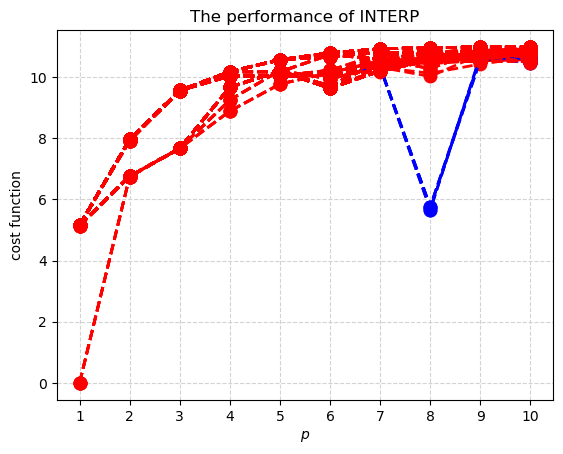

平均目标函数值信息: avg = [5.10295, 7.71503, 9.17788, 10.04408, 10.40188, 10.44234, 10.69404, 10.74435, 10.8408, 10.87804]


Text(0.5, 1.0, 'The  average performance of INTERP')

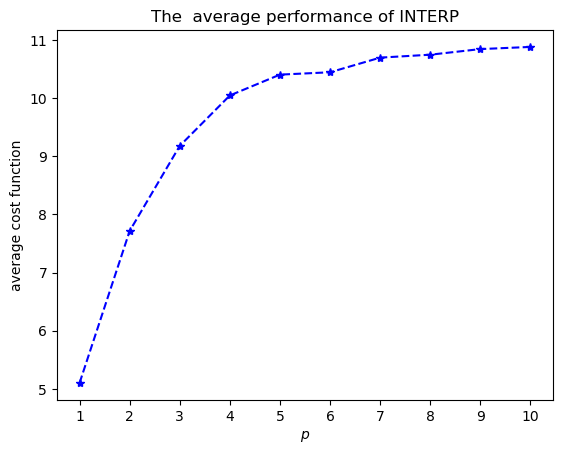

In [14]:
# # 可视化每次优化运行中期望函数值随层深的变化

# import numpy as np
# import matplotlib.pyplot as plt
# import networkx as nx
# import random


# depth = []
# for i in range(1,p+1):
#     depth.append(i)
# # 记录达到全局最优的次数
# sum = 0

# #画图 
# for i in range(0,len(value)):
#     #设置坐标轴刻度
#     my_x_ticks = np.arange(0, p+1, 1.0)
#     plt.xticks(my_x_ticks)
#     if value[i][7]> 7.97:
#         sum += 1
# #         plt.plot(depth,value[i], 'ro--', alpha=1.0, linewidth=2.0)
#         plt.plot(depth,value[i], color = 'r' ,linestyle = '--',alpha=1.0, linewidth=2.0,marker='o',markeredgecolor ='r',markerfacecolor='r',markersize = '9.0')

#     else:
# #         plt.plot(depth,value[i], 'bo--', alpha=1.0, linewidth=2.0)
#         plt.plot(depth,value[i], color = 'b' ,linestyle = '--',alpha=1.0, linewidth=2.0,marker='o',markeredgecolor ='b',markerfacecolor='b',markersize = '9.0')

# # plt.legend()  #显示上面的label
# plt.grid(color="lightgray", linestyle="--") # 绘制背景内的网格
# plt.xlabel('$p$')
# plt.ylabel('cost function')#accuracy

# plt.title('The performance of INTERP')
# my_logger.info('达到上层曲线的概率为：{}'.format(sum/len(value)))

# #plt.ylim(-1,1)#仅设置y轴坐标范围
# plt.show()
# # plt.savefig('G_INTERP with 10 tests')

# avg0 = []  # 记录第i+1层的平均目标函数值
# # 可视化平均性能
# for j in range(0,len(value[0])):
#     s = 0
#     for i in range(0,len(value)):
#         s += value[i][j]
#     avg0.append(round(float(s/len(value)),5))
    
# my_logger.info('平均目标函数值信息: avg = {}'.format(avg0))
# my_x_ticks = np.arange(0, p+1, 1.0)
# plt.xticks(my_x_ticks)
# plt.plot(depth,avg0, 'b*--', alpha=1.0, linewidth=1.5)
# plt.xlabel('$p$')
# plt.ylabel('average cost function')#accuracy
# plt.title('The  average performance of INTERP')